<a href="https://colab.research.google.com/github/deltorobarba/sciences/blob/master/chemistry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color="blue">**Natural Sciences 🦋**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0000.png)





### <font color="blue">**Chemisches Rechnen**

##### <font color="blue">*Computational Chemistry*

In [ ]:
!pip install pyscf geometric periodictable qutip -q
import numpy as np
import matplotlib.pyplot as plt
from pyscf import gto, scf, hessian, dft, tddft, mp, cc
from pyscf.geomopt.geometric_solver import optimize

###### *Define Molecule*

In [ ]:
# Helium (He)
mol = gto.Mole()
mol.atom = '''
    He 0.00 0.00 0.00
'''
molecule = 'Helium (He)'

In [2]:
# Hydrogen (H₂)
mol = gto.Mole()
mol.atom = '''
    H  0.00 0.00  0.00
    H  0.00 0.00  0.74
'''
molecule = 'Hydrogen (H₂)'

In [2]:
# Oxygen (O₂)
mol = gto.Mole()
mol.atom = '''
    O  0.00 0.00  0.00
    O  0.00 0.00  1.21
'''
molecule = 'Oxygen (O₂)'

In [2]:
# Water (H₂O)
mol = gto.Mole()
mol.atom = '''
    O  0.000000  0.000000  0.000000
    H  0.000000  0.757000  0.586000
    H  0.000000 -0.757000  0.586000
'''
molecule = 'Water (H₂O)'

In [33]:
# Nitrous Oxide (N₂O)
mol = gto.Mole()
mol.atom = '''
    N  0.00000000  0.00000000  -1.25324312
    N  0.00000000  0.00000000  -0.12244312
    O  0.00000000  0.00000000   1.06565688
'''
molecule = 'Nitrous Oxide (N₂O)'

In [ ]:
# Carbon Dioxide (CO₂)
mol = gto.Mole()
mol.atom = '''
    C   0.0000000   0.0000000   0.0000000
    O   0.0000000   0.0000000   1.1600000
    O   0.0000000   0.0000000  -1.1600000
'''
molecule = 'Carbon Dioxide (CO₂)'

In [ ]:
# Ammonia (NH₃)
mol = gto.Mole()
mol.atom = '''
    N  0.0000  0.0000  0.2000
    H  0.0000  0.9433 -0.2000
    H  0.8165 -0.4717 -0.2000
    H -0.8165 -0.4717 -0.2000
'''
molecule = 'Ammonia (NH₃)'

In [37]:
# Phosphine (PH₃)
mol = gto.Mole()
mol.atom = '''
    P   0.00000000   0.00000000   0.24580000
    H   1.21850000   0.00000000  -0.57350000
    H  -0.60925000   1.05520000  -0.57350000
    H  -0.60925000  -1.05520000  -0.57350000
'''
molecule = 'Phosphine (PH₃)'

In [ ]:
# Methane (CH₄)
mol = gto.Mole()
mol.atom = '''
    C  0.000000  0.000000  0.000000
    H  0.629118  0.629118  0.629118
    H -0.629118 -0.629118  0.629118
    H -0.629118  0.629118 -0.629118
    H  0.629118 -0.629118 -0.629118
'''
molecule = 'Methane (CH₄)'

In [ ]:
# Methyl Chloride (CH₃Cl)
mol = gto.Mole()
mol.atom = '''
    C   0.00000000   0.00000000   0.45520100
    Cl  0.00000000   0.00000000  -1.31979900
    H   0.00000000   1.02669100   0.82520000
    H   0.88910000  -0.51334500   0.82520000
    H  -0.88910000  -0.51334500   0.82520000
'''
molecule = 'Methyl Chloride (CH₃Cl)'

In [ ]:
# Dimethyl Sulfide (DMS) (CH₃)₂S
mol = gto.Mole()
mol.atom = '''
    S   0.00000000   0.46519300   0.00000000
    C  -1.50853500  -0.34759700   0.00000000
    H  -1.48831900  -1.00619800   0.87783900
    H  -1.48831900  -1.00619800  -0.87783900
    H  -2.45862400   0.18760200   0.00000000
    C   1.50853500  -0.34759700   0.00000000
    H   1.48831900  -1.00619800   0.87783900
    H   2.45862400   0.18760200   0.00000000
    H   1.48831900  -1.00619800  -0.87783900
'''
molecule = 'Dimethyl Sulfide (DMS) (CH₃)₂S'

In [ ]:
# Dimethyl Disulfide (DMDS) (CH₃S)₂
mol = gto.Mole()
mol.atom = '''
    C  -1.579679   0.849405  -0.177006
    H  -1.516541   1.264210   0.829033
    H  -2.529898   0.315926  -0.297427
    H  -1.554032   1.528773  -1.031526
    S  -0.288210  -0.528464  -0.126027
    S   0.887210   0.334360   0.941620
    C   2.276901  -0.755146   0.505299
    H   2.331268  -1.526279   1.272183
    H   3.176472  -0.144865   0.413156
    H   2.199446  -1.196144  -0.487140
'''
molecule = 'Dimethyl Disulfide (DMDS) (CH₃S)₂'

In [ ]:
# Benzene (C₆H₆)
mol = gto.Mole()
mol.atom = '''
    C    0.000000    1.396763    0.000000
    C    1.209587    0.698382    0.000000
    C    1.209587   -0.698382    0.000000
    C    0.000000   -1.396763    0.000000
    C   -1.209587   -0.698382    0.000000
    C   -1.209587    0.698382    0.000000
    H    0.000000    2.480310    0.000000
    H    2.146325    1.240155    0.000000
    H    2.146325   -1.240155    0.000000
    H    0.000000   -2.480310    0.000000
    H   -2.146325   -1.240155    0.000000
    H   -2.146325    1.240155    0.000000
'''
molecule = 'Benzene (C₆H₆)'

In [24]:
# Femoco Fe₄S₄ (Simplified Cube Model)
"""
Low Computational Cost. Fe₄S₄ clusters are common in biology (ferredoxins) and share basic Fe−S framework of FeMoco.
Lacks full MoFe₇ score, crucial Mo atom, central C atom, and all ligands.
Cannot accurately model unique electronic and magnetic properties or the catalytic function of the true FeMoco.
"""
mol = gto.Mole()
mol.atom = '''
    Fe   1.360   1.360   1.360
    Fe  -1.360  -1.360   1.360
    Fe  -1.360   1.360  -1.360
    Fe   1.360  -1.360  -1.360
    S   -2.280   0.000   0.000
    S    2.280   0.000   0.000
    S    0.000  -2.280   0.000
    S    0.000   2.280   0.000
'''
molecule = 'Femoco Fe₄S₄ (Simplified Cube Model)'
# Choose later mol.basis = 'lanl2dz'

In [22]:
# FeMoco MoFe₇S₉C (Iron-Molybdenum Cofactor)
"""
FeMoco MoFe₇S₉C coordinates extracted from PDB 3U7Q (nitrogenase).
PDB 3U7Q is the entry code in the Protein Data Bank (PDB) for the atomic-resolution structure
of the nitrogenase Molybdenum-Iron (MoFe) protein from the bacterium Azotobacter vinelandii.

High Accuracy: uses experimentally derived coordinates (PDB 3U7Q), all essential metal (Mo, Fe) and bridging non-metal (S, C) atoms.
Modeling Active Site: It is minimal structure needed to capture the unique electronic and magnetic properties of FeMoco itself.
Limitations: still omits important protein-derived ligands (like homocitrate, histidine, and cysteine residues) that stabilize
the cluster and affect its electronic environment. It is also computationally demanding due to its size (MoFe₇S₉C).
"""
mol = gto.Mole()
mol.atom = '''
    Fe   2.832   0.521   0.234
    Fe   0.696   2.290   0.871
    Fe   0.590  -0.002   1.995
    Fe  -0.623   0.031  -0.384
    Fe   1.446  -1.731  -0.265
    Fe  -0.753  -2.181   0.879
    Fe  -1.076  -0.021  -2.830
    Mo  -2.851   0.046  -0.493
    S    1.218   0.512   0.158
    S   -0.887   1.980   0.543
    S    2.382  -0.015  -1.774
    S    0.928  -1.975  -2.202
    S   -1.172  -0.322  -4.669
    S   -2.379  -0.485   1.764
    S   -0.931  -2.028   2.816
    S    1.145  -2.058   1.674
    S    2.626   2.254   1.455
    C    0.027  -0.018  -0.008
'''
molecule = 'FeMoco MoFe₇S₉C (Iron-Molybdenum Cofactor)'

In [15]:
# FeMoco MoFe₇S₉CN (Iron-Molybdenum Cofactor)
 # FeMoco with homocitrate ligand (more complete model)
"""
MoFe₇S₉C core with an added ligand proxy. The coordinates suggest the N atom is likely a simplified placeholder for the N
from the histidine (His) or homocitrate (h-citrate) ligand, which coordinates to the Mo atom.

This model attempts to account for the crucial ligand field effects from the surrounding protein environment without having
to include the entire protein (∼100,000 atoms).

The homocitrate ligand (represented by the 'N' in simplified list) is critical for FeMoco's stability and function.
Including its effect is vital for studying the catalytic cycle or reaction mechanism (e.g., substrate binding).

Computational trade-off: It is slightly larger and more expensive than MoFe₇S₉C, but it provides a more chemically complete description
for studying reactivity. mol.spin=0 and mol.charge=−3 also indicates attempt to model a specific, stable electronic state of biological system.
"""
mol = gto.Mole()
mol.atom = '''
    Mo  -3.446  -0.037  -0.011
    Fe  -1.164  -0.945  -1.371
    Fe  -0.983   1.637  -0.408
    Fe  -0.970  -0.406   1.646
    Fe   1.017   0.442  -1.605
    Fe   0.997  -1.635   0.444
    Fe   1.200   0.942   1.357
    Fe   3.431   0.028  -0.010
    S   -1.378   0.093  -3.219
    S   -2.656   1.799  -1.349
    S   -2.648  -1.885  -1.313
    S    0.788  -1.335  -2.447
    S   -2.625  -1.365   1.803
    S    0.751  -2.459   1.293
    S    2.669  -1.840   1.284
    S    2.685   1.877   1.316
    S    0.826   2.435  -1.311
    C    0.015  -0.003   0.006
    N   -5.312  -0.049  -0.018
'''
molecule = 'FeMoco MoFe₇S₉CN (Iron-Molybdenum Cofactor)'
# Choose later: mol.spin = 0 and mol.charge = -3 and

###### *Build Molecule*

In [37]:
# Build molecule (with gto.M() function)
mol.atom = mol.atom
mol.basis = 'sto-3g'  # sto-3g, cc-pvdz, 6-31G, for transition metals: 'def2-svp', 'def2-tzvp', 'lanl2dz'
mol.ecp = False       # Set to = mol.basis for Femoco
mol.symmetry = True
mol.spin = False
mol.charge = False
#mol.verbose = 4
mol.build()

def print_molecule_info(mol):
    print("="*50)
    print(f"Molecule Summary for {molecule}")
    print("="*50)
    print(f"Atoms: {mol.natm}")
    print(f"Electrons: {mol.nelectron}")
    print(f" Alpha electrons: {mol.nelec[0]}")
    print(f" Beta electrons: {mol.nelec[1]}")
    print(f"Basis: {mol.basis}")
    print(f"Basis functions: {mol.nao}")
    print(f"Charge: {mol.charge}")
    print(f"Spin (2S): {mol.spin}")
    print(f"Multiplicity (2S+1): {mol.spin + 1}")
    print(f"Nuclear repulsion energy: {mol.energy_nuc():.6f} Hartree")
    # Point group symmetry
    print(f"Top group: {mol.topgroup}")
    print(f"Group name: {mol.groupname}")
    print("\nAtom Coordinates (Angstrom):")
    for ia in range(mol.natm):
        symb = mol.atom_symbol(ia)
        coord = mol.atom_coord(ia) * 0.52917721067
        print(f"  {symb:2s}  {coord[0]:10.6f}  {coord[1]:10.6f}  {coord[2]:10.6f}")
    print("="*50)
print_molecule_info(mol)

Molecule Summary for Nitrous Oxide (N₂O)
Atoms: 3
Electrons: 22
 Alpha electrons: 11
 Beta electrons: 11
Basis: sto-3g
Basis functions: 15
Charge: False
Spin (2S): False
Multiplicity (2S+1): 1
Nuclear repulsion energy: 60.651971 Hartree
Top group: Coov
Group name: Coov

Atom Coordinates (Angstrom):
  N     0.000000    0.000000   -1.253243
  N     0.000000    0.000000   -0.122443
  O     0.000000    0.000000    1.065657


###### *Hartree-Fock (Slater Determinant)*

In [38]:
# Ground State Energy with Hartree-Fock (Slater Determinant)
mol.verbose = 3   # Select 4 or 5 for more detail
mf = scf.RHF(mol)
mf.kernel()

converged SCF energy = -181.193323036266


np.float64(-181.19332303626595)

converged SCF energy = -181.193323036266


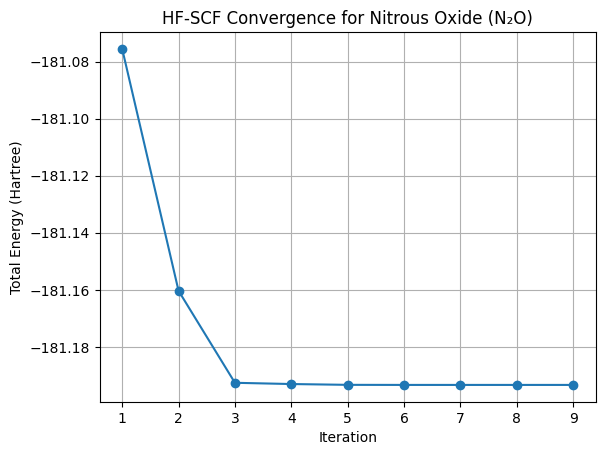

Ground state energy for Nitrous Oxide (N₂O): -181.193323036266 Hartree


In [39]:
# Visualization of calculation process (Hartree-Fock)
mf = scf.RHF(mol)                         # Set method
conv_data = []                            # Store convergence data
def callback(envs):                       # Callback function to collect convergence information
    conv_data.append(envs['e_tot'])       # Captures energy values at each iteration to track process
mf.callback = callback                    # Set callback directly on the mf object
energy = mf.kernel()                      # Perform HF calculation
energies = conv_data                      # Extract energy values
iterations = range(1, len(energies) + 1)  # Extract iteration numbers
plt.plot(iterations, energies, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Total Energy (Hartree)')
plt.title(f'HF-SCF Convergence for {molecule}')
plt.grid(True)
plt.show()
print(f"Ground state energy for {molecule}: {energy} Hartree")

In [31]:
# HF-SCF Core Hamiltonian matrix
# represents one-electron part of molecular Hamiltonian
# = kinetic energy operator of electrons and electrostatic attraction operator between electrons and nuclei
# Core Hamiltonian does not include electron-electron interactions

# Get the core Hamiltonian (kinetic + nuclear attraction)
core_hamiltonian = mf.get_hcore()
print("Core Hamiltonian matrix (Hcore):\n", core_hamiltonian)

Core Hamiltonian matrix (Hcore):
 [[-3.57206530e+02 -1.37885336e+02 -9.32527924e+00 ... -2.77615539e-01
   1.87801990e-01 -2.77614105e-01]
 [-1.37885336e+02 -1.43541757e+02 -3.44838147e+01 ... -5.92248500e-01
   4.00850790e-01 -5.92156820e-01]
 [-9.32527924e+00 -3.44838147e+01 -5.84726840e+01 ... -1.80590738e+00
   1.23604530e+00 -1.80097177e+00]
 ...
 [-2.77615539e-01 -5.92248500e-01 -1.80590738e+00 ... -3.67725389e+01
   3.46944695e-18 -6.20149928e-01]
 [ 1.87801990e-01  4.00850790e-01  1.23604530e+00 ...  3.46944695e-18
  -3.66217754e+01 -1.73472348e-18]
 [-2.77614105e-01 -5.92156820e-01 -1.80097177e+00 ... -6.20149928e-01
  -1.73472348e-18 -3.66310099e+01]]


In [ ]:
# HF-SCF Fock Matrix

# Fock matrix approximates many-electron wavefunction of system (H₂O),
# i.e. approximates interactions between electrons in a system to find an optimal set of orbitals.
# It gives snapshot of molecule electronic structure, incl. energies of molecular orbitals and how they interact or mix

# Get the Fock matrix (core Hamiltonian + electron-electron interaction terms)
fock_matrix = mf.get_fock()
print("Fock Matrix (Hartree-Fock Hamiltonian):\n", fock_matrix)

Fock Matrix (Hartree-Fock Hamiltonian):
 [[-0.26952032 -0.4694773   0.          0.         -0.29232224 -0.57287415
  -0.47752309  0.          0.          0.01409051]
 [-0.4694773  -0.28525187  0.          0.         -0.23467174 -0.47752309
  -0.30857326  0.          0.          0.21190859]
 [ 0.          0.          1.48384683  0.          0.          0.
   0.          0.44417828  0.          0.        ]
 [ 0.          0.          0.          1.48384683  0.          0.
   0.          0.          0.44417828  0.        ]
 [-0.29232224 -0.23467174  0.          0.          1.20567488 -0.01409051
  -0.21190859  0.          0.         -0.56096308]
 [-0.57287415 -0.47752309  0.          0.         -0.01409051 -0.26952032
  -0.4694773   0.          0.          0.29232224]
 [-0.47752309 -0.30857326  0.          0.         -0.21190859 -0.4694773
  -0.28525187  0.          0.          0.23467174]
 [ 0.          0.          0.44417828  0.          0.          0.
   0.          1.48384683  0.      

In [ ]:
print("Fock Matrix Shape:", fock_matrix.shape)
print("Fock Matrix Size:", fock_matrix.size)
print("Fock Matrix Dimension:", fock_matrix.ndim)
print("Fock Matrix Trace:", np.trace(fock_matrix))
print("Fock Matrix Determinant:", np.linalg.det(fock_matrix))
print("Fock Matrix Rank:", np.linalg.matrix_rank(fock_matrix))

Fock Matrix Shape: (10, 10)
Fock Matrix Size: 100
Fock Matrix Dimension: 2
Fock Matrix Trace: 7.237192699539285
Fock Matrix Determinant: -0.00786278789568637
Fock Matrix Rank: 10


In [ ]:
# HF-SCF Molecular Orbital Coefficients for All Orbitals (occupied and unoccupied)

# Retrieve Hartree-Fock orbitals (related to the Slater determinant) - occupied and unoccupied
# Occupied orbitals: contain electrons in Hartree-Fock ground state
# Virtual orbitals: unoccupied in ground state but can be important for excited state or post-Hartree-Fock methods like MP2 or CISD (electronic correlation effects)

# Get the molecular orbitals (which form the Slater determinant)
mo_coeff = mf.mo_coeff  # Coefficients of the molecular orbitals in the atomic basis
mo_energy = mf.mo_energy  # Orbital energies

print("Molecular Orbital Coefficients (MO coefficients):\n", mo_coeff)
print("Molecular Orbital Energies:\n", mo_energy)

Molecular Orbital Coefficients (MO coefficients):
 [[ 0.40366476  0.15024403 -0.70010768 -0.76067424  0.          0.
  -0.44372807  0.          0.          2.68617997]
 [ 0.17376287  1.95865624  0.7263728   1.6173428   0.          0.
   0.22106467  0.          0.          0.05058434]
 [ 0.          0.          0.          0.          0.          0.57904425
   0.          0.99134997  0.          0.        ]
 [ 0.          0.          0.          0.          0.57904425  0.
   0.          0.          0.99134997  0.        ]
 [ 0.02249745  0.01425354 -0.0112663   0.41021821  0.          0.
   0.72690133  0.          0.          2.02675347]
 [ 0.40366476 -0.15024403 -0.70010768  0.76067424  0.          0.
  -0.44372807  0.          0.         -2.68617997]
 [ 0.17376287 -1.95865624  0.7263728  -1.6173428   0.          0.
   0.22106467  0.          0.         -0.05058434]
 [ 0.          0.          0.          0.          0.          0.57904425
   0.         -0.99134997  0.          0.       

In [ ]:
# HF-SCF Molecular Orbital Coefficients for only occupied orbitals

# Extract and display the occupied molecular orbitals - used to construct Slater determinant - Only occupied orbitals
# The mo_occ variable stores the occupation numbers, which are usually 2 for occupied orbitals
# in a closed-shell Hartree-Fock calculation (since there are two electrons per orbital in a closed-shell system).
# By identifying which orbitals are occupied using np.where(mo_occ > 0),
# the code extracts the coefficients corresponding to those occupied orbitals and prints them.

mo_coeff = mf.mo_coeff # Get molecular orbital coefficients
mo_occ = mf.mo_occ # Get occupation numbers (from orbitals)
occupied_indices = np.where(mo_occ > 0)[0] # Identify indices of occupied orbitals
occupied_mo_coeff = mo_coeff[:, occupied_indices] # Coefficients of occupied molecular orbitals
print("Occupied Molecular Orbital Coefficients:")
print(occupied_mo_coeff)

Occupied Molecular Orbital Coefficients:
[[ 0.40366476]
 [ 0.17376287]
 [ 0.        ]
 [ 0.        ]
 [ 0.02249745]
 [ 0.40366476]
 [ 0.17376287]
 [ 0.        ]
 [ 0.        ]
 [-0.02249745]]


###### *Density Functional (DFT-SCF with Kohn-Sham)*

In [32]:
# Ground State Energy with DFT (Kohn-Sham)
mf = dft.RKS(mol)  # Restricted Kohn Sham (often for closed shell systems)
mf.xc = 'B3LYP'    # Exchange-correlation functional
mf.kernel()        # perform DFT calculation and return energy

converged SCF energy = -6574.53377949503


np.float64(-6574.53377949503)

In [ ]:
# DFT-SCF  Kohn-Sham Hamiltonian (First Quantization) includes exchange-correlation potential, which approximates exchange and correlation effects
# Kohn-Sham formalism transforms complex many-electron problem into a simpler set of equations that describe non-interacting electrons
# but in presence of an effective potential that accounts for the effects of electron-electron interactions.

# Get the Kohn-Sham Hamiltonian (core Hamiltonian + exchange-correlation potential)
ks_hamiltonian = mf.get_hcore() + mf.get_veff()

print("Kohn-Sham Hamiltonian matrix:\n", ks_hamiltonian)

Kohn-Sham Hamiltonian matrix:
 [[-2.09806815e-01 -3.47338931e-01  6.93889390e-18  1.38777878e-17
  -1.92848152e-01 -4.04898835e-01 -3.36157374e-01  0.00000000e+00
   0.00000000e+00  3.45602668e-02]
 [-3.47338931e-01 -2.13556575e-01  0.00000000e+00 -6.93889390e-18
  -1.49603932e-01 -3.36157374e-01 -2.24561957e-01 -2.77555756e-17
  -1.04083409e-17  1.53804087e-01]
 [ 6.93889390e-18  0.00000000e+00  1.23446963e+00 -1.82641465e-18
   9.10729825e-18  3.46944695e-18  1.73472348e-17  3.29646425e-01
   8.30812639e-18  1.73472348e-17]
 [ 1.38777878e-17 -6.93889390e-18 -1.82641465e-18  1.23446963e+00
  -8.67361738e-19  1.04083409e-17 -3.46944695e-18  8.68558545e-18
   3.29646425e-01  1.38777878e-17]
 [-1.92848152e-01 -1.49603932e-01  9.10729825e-18 -8.67361738e-19
   9.94853139e-01 -3.45602668e-02 -1.53804087e-01 -6.93889390e-18
  -6.93889390e-18 -5.20251591e-01]
 [-4.04898835e-01 -3.36157374e-01  3.46944695e-18  1.04083409e-17
  -3.45602668e-02 -2.09806815e-01 -3.47338931e-01 -1.38777878e-17
  

In [ ]:
print("Kohn-Sham Hamiltonian Matrix Shape:", ks_hamiltonian.shape)
print("Kohn-Sham Hamiltonian Matrix Size:", ks_hamiltonian.size)
print("Kohn-Sham Hamiltonian Matrix Dimension:", ks_hamiltonian.ndim)
print("Kohn-Sham Hamiltonian Matrix Trace:", np.trace(ks_hamiltonian))
print("Kohn-Sham Hamiltonian Matrix Determinant:", np.linalg.det(ks_hamiltonian))
print("Kohn-Sham Hamiltonian Matrix Rank:", np.linalg.matrix_rank(ks_hamiltonian))

Kohn-Sham Hamiltonian Matrix Shape: (10, 10)
Kohn-Sham Hamiltonian Matrix Size: 100
Kohn-Sham Hamiltonian Matrix Dimension: 2
Kohn-Sham Hamiltonian Matrix Trace: 6.08085800033746
Kohn-Sham Hamiltonian Matrix Determinant: -0.00043849081832920506
Kohn-Sham Hamiltonian Matrix Rank: 10


###### *Coupled Cluster (Post Hartree Fock)*

Very accurate (often considered the "gold standard" for single-reference methods). CCSD (singles and doubles), CCSD(T) (includes perturbative triples). CCSD(T) is highly accurate but scales poorly with system size. <font color="blue">*Almost exclusively formulated and implemented in second quantization due to its complexity.*</font>

In [ ]:
# Ground State Energy with Coupled Cluster (Post Hartree Fock)
"""
Very accurate (often considered the "gold standard" for single-reference methods).
CCSD (singles and doubles), CCSD(T) (includes perturbative triples).
CCSD(T) is highly accurate but scales poorly with system size.
Almost exclusively formulated and implemented in second quantization due to its complexity.
"""
mf = scf.RHF(mol)                  # Perform a HF-SCF calculation to obtain the reference wavefunction
hf_energy = mf.kernel()
ccsd_calc = cc.CCSD(mf)            # Perform a Coupled Cluster calculation
ccsd_energy = ccsd_calc.kernel()
ccsd_t_energy = ccsd_calc.ccsd_t() # (Optional) Include perturbative triple excitations (CCSD(T))

# Ensure that ccsd_t_energy is a scalar (take the first element if it's an array)
if isinstance(ccsd_t_energy, (list, tuple)) or hasattr(ccsd_t_energy, "__len__"):
    ccsd_t_energy = ccsd_t_energy[0]  # Take the first value if it returns multiple results

# Print the results
print(f"HF-SCF energy: {hf_energy} Hartree")
print(f"CCSD energy: {ccsd_energy} Hartree")
#print(f"CCSD(T) energy: {ccsd_energy + ccsd_t_energy} Hartree")

converged SCF energy = -1.12870009355644
E(CCSD) = -1.163374496404819  E_corr = -0.03467440284837722
CCSD(T) correction = 3.99717015393741e-19
HF-SCF energy: -1.128700093556442 Hartree
CCSD energy: (np.float64(-0.034674402848377216), array([[ 3.39540587e-16, -5.97110968e-03, -2.44502512e-17,
         0.00000000e+00,  0.00000000e+00, -4.15377664e-03,
         0.00000000e+00,  0.00000000e+00,  3.61149362e-18]]), array([[[[-5.34108771e-02, -2.87498266e-17,  4.71221663e-02,
           0.00000000e+00,  0.00000000e+00,  3.54975293e-17,
           0.00000000e+00,  0.00000000e+00, -6.09039779e-03],
         [-2.87498266e-17, -5.07200622e-02, -2.20153962e-17,
           0.00000000e+00,  0.00000000e+00,  1.41940469e-02,
           0.00000000e+00,  0.00000000e+00,  3.01105216e-17],
         [ 4.71221663e-02, -2.20153962e-17, -5.31524971e-02,
           0.00000000e+00,  0.00000000e+00, -6.04008858e-19,
           0.00000000e+00,  0.00000000e+00,  1.04839327e-02],
         [ 0.00000000e+00,  0.0000

###### *Møller-Plesset Perturbation Theory (Post Hartree Fock)*

In [ ]:
# Ground State Energy with Møller-Plesset Perturbation Theory (Post Hartree Fock)
mf = scf.RHF(mol)
mf.kernel()
mp2 = mp.MP2(mf) # MP2 single point energy calculation
energy_mp2 = mp2.kernel()
print(f"MP2 energy: {energy_mp2[0]} Hartree")

converged SCF energy = -1.12870009355644
E(RMP2) = -1.15507165119134  E_corr = -0.0263715576348957
E(SCS-RMP2) = -1.16034596271832  E_corr = -0.0316458691618748
MP2 energy: -0.026371557634895678 Hartree


###### *Configuration Interaction (Post Hartree Fock)*

In [ ]:
from pyscf import tdscf  # For CIS calculations (using TDHF)
from pyscf import ci     # For CISD calculations
from pyscf import fci    # For FCI calculations

"""
* CIS calculation: PySCF doesn't have a direct ci.CIS module. Instead, we use the Time-Dependent Hartree-Fock (TDHF) approach with the Tamm-Dancoff Approximation (TDA), which is equivalent to CIS for excited states.
* Wavefunction analysis: this is a simplified analysis of the CISD wavefunction by directly summing over the appropriate coefficients.

This script performs:
1. Hartree-Fock (HF) calculation as the reference
2. Configuration Interaction Singles (CIS)
3. Configuration Interaction Singles and Doubles (CISD)
4. Full Configuration Interaction (FCI) - note this is very computationally expensive

The code also analyzes the CISD wavefunction to show the contributions from the reference determinant, single excitations, and double excitations.

A few important notes:
- **CIS is primarily used for excited states, not ground state correlation energy (the first excited state energy is reported)**
- CISD includes single and double excitations and is commonly used for ground state calculations
- FCI is the exact solution within the given basis set but scales factorially with system size
- For larger molecules, you may want to use truncated CI methods or other approaches like CASCI (Complete Active Space CI)
"""

# Step 1: Perform a HF-SCF calculation to obtain the reference wavefunction
mf = scf.RHF(mol)
hf_energy = mf.kernel()
print(f"HF-SCF energy: {hf_energy:.8f} Hartree")

# Step 2: Perform Configuration Interaction calculations

# CIS (Using TDHF which is equivalent to CIS for singlet excited states)
cis_calc = tdscf.TDA(mf)  # TDA approximation is equivalent to CIS
cis_e, cis_v = cis_calc.kernel()
cis_energy = cis_e[0] + hf_energy  # First excited state energy

# CISD
cisd_calc = ci.CISD(mf)
cisd_energy = cisd_calc.kernel()[0]  # Get the ground state energy

# FCI - Note: This can be very computationally expensive
cisolver = fci.FCI(mf)
fci_energy = cisolver.kernel()[0]

# Print the results
print(f"Molecule: {molecule}")
print(f"Basis Set: {mol.basis}")
print(f"HF-SCF energy: {hf_energy:.8f} Hartree")
print(f"CIS excited state energy: {cis_energy:.8f} Hartree")
print(f"CIS excitation energy: {cis_e[0]:.8f} Hartree")
print(f"CISD correlation energy: {cisd_energy - hf_energy:.8f} Hartree")
print(f"CISD total energy: {cisd_energy:.8f} Hartree")
print(f"FCI correlation energy: {fci_energy - hf_energy:.8f} Hartree")
print(f"FCI total energy: {fci_energy:.8f} Hartree")

# Analyze the CISD wavefunction
cisd_coeff = cisd_calc.ci
print("\nCISD Wavefunction Analysis:")
print(f"Reference determinant weight: {cisd_coeff[0]**2:.6f}")

# Calculate contributions from singles and doubles
#from pyscf.ci import cisd_slow
nelec = mol.nelectron
nocc = nelec // 2
nvir = mf.mo_coeff.shape[1] - nocc

# Get singles and doubles contribution
singles_norm = 0
doubles_norm = 0

# Singles contribution
singles_norm = sum(abs(cisd_coeff[i])**2 for i in range(1, nocc*nvir+1))

# Doubles contribution
doubles_norm = sum(abs(cisd_coeff[i])**2 for i in range(nocc*nvir+1, len(cisd_coeff)))

print(f"Singles contribution: {singles_norm:.6f}")
print(f"Doubles contribution: {doubles_norm:.6f}")
print(f"Total normalization check: {cisd_coeff[0]**2 + singles_norm + doubles_norm:.6f}")

converged SCF energy = -1.12870009355644
HF-SCF energy: -1.12870009 Hartree
Excited State energies (eV)
[14.07567057 21.45479287 32.30709355]
E(RCISD) = -1.163374490318234  E_corr = -0.03467439676179211
Molecule: Hydrogen (H₂)
Basis Set: cc-pvdz
HF-SCF energy: -1.12870009 Hartree
CIS excited state energy: -0.61142874 Hartree
CIS excitation energy: 0.51727136 Hartree
CISD correlation energy: 1.09402570 Hartree
CISD total energy: -0.03467440 Hartree
FCI correlation energy: -0.03467440 Hartree
FCI total energy: -1.16337449 Hartree

CISD Wavefunction Analysis:
Reference determinant weight: 0.983138
Singles contribution: 0.000052
Doubles contribution: 0.016758
Total normalization check: 0.999948


###### *Geometry Optimization (HF or DFT)*

In [ ]:
# Geometry Optimization (in Angstroms) with HF or DFT
from pyscf import gto, dft
from pyscf.geomopt.geometric_solver import optimize

# Define the molecule with a rough guess for geometry (initial atomic positions)
# These positions don't need to be exact, as the optimization will refine them
mol.atom = mol.atom
mol.basis = mol.basis
mol.build()

# Take molecule including basis set defined from `mol.build()`
mf = dft.RKS(mol)     # Perform geometry optimization using DFT (Restricted Kohn-Sham)
mf.xc = 'b3lyp'       # Define the exchange-correlation functional
mol_eq = optimize(mf)

# Print optimized coordinates. This geometry corresponds to lowest energy configuration found during optimization process
print("Optimized Geometry (in Angstroms):")
print(mol_eq.atom_coords())

geometric-optimize called with the following command line:
/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-ae64ed8a-9a3a-4ae4-9549-db57adcde7fa.json

                                        ())))))))))))))))/                     
                                    ())))))))))))))))))))))))),                
                                *)))))))))))))))))))))))))))))))))             
                        #,    ()))))))))/                .)))))))))),          
                      #%%%%,  ())))))                        .))))))))*        
                      *%%%%%%,  ))              ..              ,))))))).      
                        *%%%%%%,         ***************/.        .)))))))     
                #%%/      (%%%%%%,    /*********************.       )))))))    
              .%%%%%%#      *%%%%%%,  *******/,     **********,      .))))))   
                .%%%%%%/      *%%%%%%,  **              ********    


Geometry optimization cycle 1
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   H   0.000000   0.000000   0.000000    0.000000  0.000000  0.000000
   H   0.000000   0.000000   0.740000    0.000000  0.000000  0.000000

WARN: Unable to to identify input symmetry using original axes.
Different symmetry axes will be used.


WARN: Mole.unit (angstrom) is changed to Bohr

converged SCF energy = -1.17328112090857
--------------- SymAdaptedRKS_Scanner gradients ---------------
         x                y                z
0 H     0.0000000000     0.0000000000     0.0159964150
1 H     0.0000000000     0.0000000000    -0.0159964150
----------------------------------------------
cycle 1: E = -1.17328112091  dE = -1.17328  norm(grad) = 0.0226223


Step    0 : Gradient = 1.600e-02/1.600e-02 (rms/max) Energy = -1.1732811209
Hessian Eigenvalues: 5.00000e-02 5.00000e-02 5.00000e-02 ... 5.00000e-02 5.00000e-02 3.91394e-01



Geometry optimization cycle 2
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   H   0.000000   0.000000  -0.010814    0.000000  0.000000  0.359186
   H   0.000000   0.000000   0.750814    0.000000  0.000000  0.380814
converged SCF energy = -1.17360206558998
--------------- SymAdaptedRKS_Scanner gradients ---------------
         x                y                z
0 H     0.0000000000     0.0000000000     0.0000664006
1 H     0.0000000000     0.0000000000    -0.0000664006
----------------------------------------------
cycle 2: E = -1.17360206559  dE = -0.000320945  norm(grad) = 9.39046e-05


Step    1 : Displace = 1.081e-02/1.081e-02 (rms/max) Trust = 1.000e-01 (=) Grad = 6.640e-05/6.640e-05 (rms/max) E (change) = -1.1736020656 (-3.209e-04) Quality = 0.982
Hessian Eigenvalues: 5.00000e-02 5.00000e-02 5.00000e-02 ... 5.00000e-02 5.00000e-02 3.89770e-01



Geometry optimization cycle 3
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   H   0.000000   0.000000  -0.010859    0.000000  0.000000  0.369955
   H   0.000000   0.000000   0.750859    0.000000  0.000000  0.370045
converged SCF energy = -1.17360207162442
--------------- SymAdaptedRKS_Scanner gradients ---------------
         x                y                z
0 H     0.0000000000     0.0000000000     0.0000045661
1 H     0.0000000000     0.0000000000    -0.0000045661
----------------------------------------------
cycle 3: E = -1.17360207162  dE = -6.03443e-09  norm(grad) = 6.45747e-06


Step    2 : Displace = 4.507e-05/4.507e-05 (rms/max) Trust = 1.414e-01 (+) Grad = 4.566e-06/4.566e-06 (rms/max) E (change) = -1.1736020716 (-6.034e-09) Quality = 1.067
Hessian Eigenvalues: 5.00000e-02 5.00000e-02 5.00000e-02 ... 5.00000e-02 5.00000e-02 3.89770e-01
Converged! =D

    #==========================================================================#
    #| If this code has benefited your research, please support us by citing: |#
    #|                                                                        |#
    #| Wang, L.-P.; Song, C.C. (2016) "Geometry optimization made simple with |#
    #| translation and rotation coordinates", J. Chem, Phys. 144, 214108.     |#
    #| http://dx.doi.org/10.1063/1.4952956                                    |#
    #==========================================================================#
    Time elapsed since start of run_optimizer: 2.354 seconds


Optimized Geometry (in Angstroms):
[[ 0.          0.         -0.71971902]
 [ 0.          0.          0.71971902]]


###### *Calculate excited electronic states*

In [ ]:
# Calculate excited electronic states
myhf = scf.RHF(mol).run()     # Perform a ground-state calculation
mytd = tddft.TDA(myhf).run()  # Excited-state calculation using TDDFT
#mol = gto.M(verbose = 4)     # Add verbose for more details
mytd.analyze()

converged SCF energy = -1.12870009355644
Excited State energies (eV)
[14.07567057 21.45479287 32.30709355]

** Singlet excitation energies and oscillator strengths **
Excited State   1:  A1u     14.07567 eV     88.08 nm  f=0.6152
Excited State   2:  A1g     21.45479 eV     57.79 nm  f=0.0000
Excited State   3:  A1u     32.30709 eV     38.38 nm  f=0.2024


###### *Emission and Absorption Spectra*

converged SCF energy = -1.12870009355644


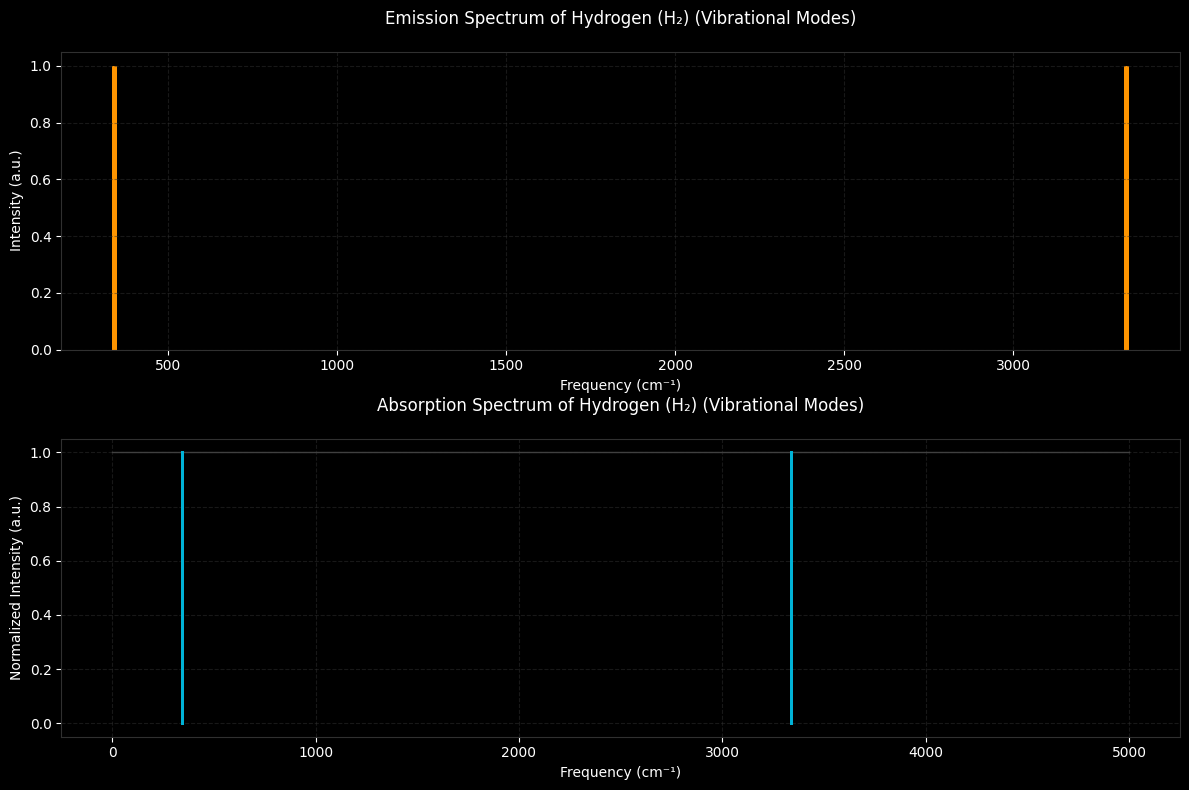

In [ ]:
# Emission and Absorption Spectra (Electronic Frequencies / Transitions)

mf = scf.RHF(mol)                                     # Perform a ground-state calculation for molecular vibrational frequencies
mf.kernel()
hess = hessian.RHF(mf).kernel()                       # Calculate the Hessian matrix (force constants)
frequencies = np.linalg.eigvalsh(hess)                # Diagonalize the Hessian to get vibrational frequencies
frequencies = np.sqrt(np.abs(frequencies)) * 5140.48  # Conversion factor to cm^-1 (more accurate)
frequencies = frequencies[(frequencies > 0) & (frequencies < 5000)]  # Filter out non-physical (imaginary) frequencies and limit to realistic range

# Plot stlyes
EMISSION_COLOR = '#ff9500'  # Bright orange
ABSORPTION_COLOR = '#00b4d8'  # Bright blue
BASELINE_COLOR = '#404040'  # Dark gray
GRID_COLOR = '#303030'  # Slightly lighter gray for grid
plt.figure(figsize=(12, 8), facecolor='black') # Create figure with dark background
plt.style.use('dark_background') # Set the style to dark background

# Emission Spectrum
plt.subplot(2, 1, 1)
plt.bar(frequencies, height=1.0, width=15.0, color=EMISSION_COLOR, alpha=0.8)
plt.xlabel('Frequency (cm⁻¹)', color='white', fontsize=10)
plt.ylabel('Intensity (a.u.)', color='white', fontsize=10)
plt.title(f'Emission Spectrum of {molecule} (Vibrational Modes)',
         color='white', pad=20, fontsize=12)

# Customize grid and spines
plt.grid(True, color=GRID_COLOR, linestyle='--', alpha=0.5)
for spine in plt.gca().spines.values():
    spine.set_color(GRID_COLOR)
plt.tick_params(colors='white')

# Absorption Spectrum
plt.subplot(2, 1, 2)
# Create baseline
plt.plot(np.linspace(0, 5000, 1000), np.ones(1000),
         color=BASELINE_COLOR, linewidth=1)

# Plot absorption lines with gradient effect
for freq in frequencies:
    y = np.linspace(0, 1, 100)
    x = np.ones_like(y) * freq
    plt.plot(x, y, color=ABSORPTION_COLOR,
            alpha=0.8, linewidth=2)

plt.xlabel('Frequency (cm⁻¹)', color='white', fontsize=10)
plt.ylabel('Normalized Intensity (a.u.)', color='white', fontsize=10)
plt.title(f'Absorption Spectrum of {molecule} (Vibrational Modes)',
         color='white', pad=20, fontsize=12)

# Customize grid and spines
plt.grid(True, color=GRID_COLOR, linestyle='--', alpha=0.5)
for spine in plt.gca().spines.values():
    spine.set_color(GRID_COLOR)
plt.tick_params(colors='white')

# Adjust layout and display
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

# Set figure background to black
plt.gcf().patch.set_facecolor('black')

plt.show()

##### <font color="blue">*Quantum Chemistry*

###### ***Quantum Chemistry***

You are absolutely correct. The term "quantum chemistry" does *not* imply the use of a quantum computer. It's called "quantum" chemistry because it uses the principles of *quantum mechanics* to understand and predict the behavior of atoms and molecules. Here's a breakdown of the key distinctions:

**1. Quantum Mechanics (The Foundation)**

*   Quantum mechanics is the fundamental theory that governs the behavior of matter at the atomic and subatomic level. It's a completely different set of rules than classical mechanics (which describes the motion of macroscopic objects).
*   Key features of quantum mechanics that are essential for chemistry:
    *   **Wave-particle duality:** Electrons and other particles behave as both waves and particles.
    *   **Quantization:** Energy, momentum, and other properties are often quantized, meaning they can only take on specific discrete values.
    *   **The Schrödinger equation:** The fundamental equation of quantum mechanics. Solving it (exactly or approximately) gives the wavefunction and energy of a system.
    *   **Probability:** Quantum mechanics is inherently probabilistic. The wavefunction describes the *probability* of finding a particle in a particular location.
    * **Uncertainty principle**

**2. Quantum Chemistry (Applying Quantum Mechanics to Chemistry)**

*   Quantum chemistry applies the principles of quantum mechanics to study chemical systems (atoms, molecules, reactions, etc.).
*   It uses the Schrödinger equation (or approximations to it) to calculate:
    *   Molecular structures (bond lengths, angles)
    *   Energies (bond energies, reaction energies)
    *   Spectroscopic properties (UV-Vis, IR, NMR spectra)
    *   Reactivity (reaction rates, mechanisms)
    *   Other properties (dipole moments, polarizabilities, etc.)
*   Almost all of quantum chemistry is done on *classical computers*. We use numerical methods to solve the (approximate) Schrödinger equation. This involves things like:
    *   Choosing a basis set (a set of mathematical functions to represent the atomic orbitals).
    *   Solving the Hartree-Fock equations (or Kohn-Sham equations in DFT).
    *   Calculating integrals (often very many of them!).
    *   Using iterative methods to find solutions.

**3. Quantum Computing (A Different Paradigm)**

*   Quantum computing is a *fundamentally different type of computation* that uses the principles of quantum mechanics to perform calculations. It's *not* just a faster version of classical computing.
*   Key features:
    *   **Qubits:** Instead of bits (which are 0 or 1), quantum computers use qubits, which can be in a superposition of 0 and 1 (both 0 and 1 at the same time).
    *   **Entanglement:** Qubits can be entangled, meaning their states are correlated even when separated.
    *   **Quantum gates:** Operations that manipulate qubits.
    * **Superposition**

*   **Potential Applications to Chemistry:** Quantum computers *could* potentially revolutionize quantum chemistry. They are, in principle, ideally suited to simulating quantum systems (like molecules). Some algorithms (like the Variational Quantum Eigensolver, or VQE) have been developed specifically for quantum chemistry.
*   **Current Status:** Quantum computing is still in its early stages of development. Current quantum computers are small, noisy, and error-prone. It will likely be many years before they are routinely used for practical quantum chemistry calculations that outperform classical computers.

**In short:**

*   **Quantum chemistry** uses *quantum mechanics* to study chemical systems, but almost always uses *classical computers* to do the calculations.
*   **Quantum computing** is a new type of computation that uses *quantum mechanical phenomena* (superposition, entanglement) to perform calculations. It *could* be used for quantum chemistry in the future, but it's not the same thing as quantum chemistry itself.

The name "quantum chemistry" comes from the underlying *theory* (quantum mechanics), not the type of *computer* used.


*Old notes from github*

**Static Calculations** (No Nuclear Motion Considered During the Calculation). Used to determine the ground-state energy, calculate electron densities and molecular orbitals, analyze the electronic properties of a specific molecular conformation, and optimize molecular geometries by performing static calculations at slightly varied geometries to locate the lowest energy structure.

* **(Dynamic) Molecular Dynamics** (MD): Ab Initio Molecular Dynamics (AIMD), Semi-Empirical Molecular Dynamics, Classical Molecular Dynamics, QM/MM Molecular Dynamics, Coarse-Grained Molecular Dynamics, Tight Binding MD. **(Dynamic) Path Integral Molecular Dynamics** (PIMD)


**Dynamic Calculations** (Nuclear Motion is Explicitly Considered). Simulates the evolution of a molecule or system as forces act on nuclei over time (vibrational, rotational, and conformational changes). The calculations are crucial for understanding reaction pathways, thermodynamic properties, and the behavior of molecules in various environments, such as solutions or biological systems.


**Examples** Calculation of emission lines, absorption lines and vibrational frequencies of elements and molecules with [pyscf](https://pyscf.org). Calculation of ground state energies in **First Quantization** with *Single-Point Calculations* (Hartree-Fock-SCF, DFT) and *Full Geometry* for different basis sets, and in **Second Quantization**: *Single-Point calculations* based on Post-Hartree-Fock (Coupled Cluster, Møller-Plesset Perturbation, Configuration Interaction), and Quantum algorithms (Variational Quantum Eigensolver) using [openfermion](https://quantumai.google/openfermion/tutorials/intro_to_openfermion).

###### ***Mathematical Formalism in Quantum Chemistry***

**Part II: Mathematical Formalism in Quantum Chemistry**


<font color="blue">**First Quantization**</font>

> Explanation: Focuses on explicitly solving the Schrödinger equation (or approximations thereof) for electrons. Nuclei are often treated within the Born-Oppenheimer approximation (i.e., much heavier and slower-moving than electrons), but can also be included in the quantum treatment (though less commonly). The key is that particles (electrons and nuclei) are treated as *waves*.


<font color="blue">**Second Quantization**</font>

> Explanation:  In second quantization, the *wavefunction itself* is quantized.  Instead of dealing with a fixed number of particles, we use creation and annihilation operators that add or remove particles from a system.  This is particularly useful for describing many-body systems and is the foundation of quantum field theory. In quantum chemistry, second quantization is often used as a formalism for deriving and implementing advanced electronic structure methods, *especially* those used in many-body perturbation theory and coupled cluster theory. It's less a *different* set of calculations and more a *different mathematical framework* for expressing the same underlying physics. **The role of second quantization as a *formalism* rather than a separate *type* of calculation in most quantum chemistry applications.**

*   **Key Concepts:**
    *   **Creation and Annihilation Operators:**  Operators that add (creation) or remove (annihilation) a particle from a specific quantum state.  They obey specific commutation or anti-commutation relations.
    *   **Fock Space:**  The space of all possible states of a many-body system, including states with different numbers of particles.
    *   **Number Operator:**  An operator that counts the number of particles in a particular state.
    *   **Field Operators:** Operators that create or annihilate particles at a specific point in space.

*   **Why Second Quantization is Preferred for methods like Coupled Cluster:**

    *   **Antisymmetry:** Electron wavefunctions must be antisymmetric with respect to the exchange of any two electrons (Pauli Exclusion Principle). Second quantization *automatically* enforces this antisymmetry through the anti-commutation relations of the creation and annihilation operators. In first quantization, you'd have to explicitly work with Slater determinants and keep track of all the permutations, which becomes extremely cumbersome for more than a few electrons.
    *   **Excitation Operators:** The Coupled Cluster wavefunction is built by applying an "excitation operator" to a reference determinant (usually the Hartree-Fock determinant). This excitation operator is naturally expressed in terms of creation and annihilation operators in second quantization. It cleanly represents the promotion of electrons from occupied to virtual orbitals.
    *   **Diagrammatic Techniques:** Second quantization allows for the use of diagrammatic techniques (Feynman diagrams, Goldstone diagrams) to represent the terms in the Coupled Cluster equations. These diagrams provide a visual and systematic way to derive and organize the (often very complex) equations.
    *   **Computational Efficiency:** The second-quantized formulation often leads to more efficient algorithms for implementing Coupled Cluster calculations.

*   **How it's used in Quantum Chemistry:**

    *   **Derivation of Electronic Structure Methods:**  Second quantization provides a compact and elegant way to derive the equations for methods like Hartree-Fock, MPn, Coupled Cluster, and Configuration Interaction.  It simplifies the handling of Slater determinants and the antisymmetry requirement for fermionic wavefunctions.
    *   **Many-Body Perturbation Theory (MBPT):**  Second quantization is the natural language for MBPT, which is used to calculate correlation energy.
    *   **Coupled Cluster Theory:** The coupled cluster equations are most naturally expressed in the language of second quantization.
    *   **Green's Function Methods:**  Used to calculate properties like ionization potentials, electron affinities, and spectral functions.  These methods are often formulated in second quantization.
    * **Density Matrix Renormalization Group (DMRG)** A powerful method for strongly correlated systems, often implemented using a second-quantized formalism.

*   **Important distinction:** It's crucial to understand that second quantization, in the context of computational quantum chemistry, is *not* typically used to describe fundamentally different *physical* phenomena than first quantization.  It's a different, and often more convenient, mathematical formalism for representing the *same* electronic structure problem. You *don't* typically perform "second-quantized calculations" as a separate category of calculation. Instead, the *derivation and implementation* of many advanced methods (like Coupled Cluster) are greatly simplified by using the second quantization formalism. The calculations themselves are still, for example, single-point energies, geometry optimizations, etc., but the underlying equations are derived and expressed using creation and annihilation operators.  The *results* are (in principle) the same as if you had laboriously worked through the equivalent first-quantized formulation.



###### *Starting Point: Born-Oppenheimer Approximation*

There's a very strong and direct connection between the concepts of "static calculations" vs. "dynamic calculations" and the Born-Oppenheimer (BO) approximation.  The BO approximation is *the* fundamental justification for performing static calculations in many contexts, particularly in quantum chemistry and condensed matter physics.

**1. The Born-Oppenheimer Approximation:**

*   **Core Idea:** The BO approximation exploits the large mass difference between electrons and nuclei.  Because nuclei are much heavier than electrons (by a factor of 1836 for a proton and electron, and more for heavier nuclei), they move much *slower*.  The BO approximation assumes that the electrons adjust *instantaneously* to the positions of the nuclei.  This allows us to separate the electronic and nuclear motions.

*   **Mathematical Formulation:**
    *   The full molecular (or solid-state) Hamiltonian contains terms for:
        *   Kinetic energy of the electrons (T<sub>e</sub>)
        *   Kinetic energy of the nuclei (T<sub>n</sub>)
        *   Electron-electron repulsion (V<sub>ee</sub>)
        *   Electron-nucleus attraction (V<sub>en</sub>)
        *   Nucleus-nucleus repulsion (V<sub>nn</sub>)
        *   `H = Tₑ + Tₙ + Vₑₑ + Vₑₙ + Vₙₙ`
    *   The BO approximation separates the total wavefunction (Ψ) into a product of an electronic wavefunction (ψ<sub>e</sub>) that depends on the electronic coordinates *and parametrically on the nuclear coordinates*, and a nuclear wavefunction (ψ<sub>n</sub>) that depends only on the nuclear coordinates:
        *   `Ψ(r, R) = ψₑ(r; R)ψₙ(R)`
        *   `r`: electronic coordinates, `R`: nuclear coordinates.
    *   **Step 1 (Electronic Problem):**  We *freeze* the nuclear positions (treat `R` as parameters) and solve the *electronic* Schrödinger equation:
        *   `(Tₑ + Vₑₑ + Vₑₙ(R))ψₑ(r; R) = Eₑ(R)ψₑ(r; R)`
        *   This gives us the electronic energy `Eₑ(R)` for a *fixed* nuclear configuration `R`.  This `Eₑ(R)` is called the *Born-Oppenheimer potential energy surface* (PES).
    *   **Step 2 (Nuclear Problem):** We then use this `Eₑ(R)` as the *potential* in which the nuclei move:
        *   `(Tₙ + Vₙₙ(R) + Eₑ(R))ψₙ(R) = Eψₙ(R)`
        *   `E` is the total energy of the system.  This equation describes nuclear motion (vibrations, rotations, etc.).

*   **Key Result:** The BO approximation leads to the concept of a *potential energy surface (PES)*, `Eₑ(R) + Vₙₙ(R)`, which governs the motion of the nuclei.

**2. Static Calculations:**

*   **Definition:** Static calculations are those where the nuclei are held *fixed* at specific positions.  We solve *only* the electronic Schrödinger equation for that fixed nuclear configuration.
*   **Justification:** Static calculations are *directly based on* the first step of the BO approximation.  We are assuming that the nuclei don't move (or move infinitely slowly) while the electrons find their optimal configuration.
*   **Examples:**
    *   Calculating the electronic energy of a molecule at its equilibrium geometry.
    *   Calculating the electronic band structure of a solid.
    *   Finding the transition state of a chemical reaction (a saddle point on the PES).
    *   Geometry Optimization.
*   **Output:** The primary output of a static calculation is the electronic energy `Eₑ(R)` for the given nuclear configuration `R`.  We can also obtain other properties like electron density, dipole moment, etc., *for that fixed configuration*.

**3. Dynamic Calculations:**

*   **Definition:** Dynamic calculations explicitly consider the *motion* of the nuclei.  They solve the *nuclear* Schrödinger equation (the second step of the BO approximation) or use classical approximations for nuclear motion.
*   **Beyond BO (Sometimes):**  While many dynamic calculations *use* the BO approximation to obtain the PES, some advanced methods go *beyond* the BO approximation and include non-adiabatic effects (where the electronic and nuclear motions are coupled).
*   **Examples:**
    *   Molecular dynamics (MD) simulations: Classical mechanics is used to simulate the motion of the nuclei on the PES.
    *   Vibrational spectroscopy calculations:  Solving the nuclear Schrödinger equation to find vibrational energy levels.
    *   Calculating reaction rates using transition state theory.
    *   Simulations that include nonadiabatic effects (electron-phonon coupling).

**In summary:**

*   The **Born-Oppenheimer approximation** is the theoretical foundation that separates electronic and nuclear motion.
*   **Static calculations** *exploit* the BO approximation by *freezing* the nuclear positions and solving *only* the electronic problem. They give you the PES.
*   **Dynamic calculations** go further and consider the *motion* of the nuclei, either on the BO PES or, in more advanced cases, going beyond the BO approximation.

The distinction between static and dynamic calculations is fundamentally rooted in whether or not the nuclei are allowed to move *during the calculation*, and the BO approximation is the key theoretical concept that makes static calculations meaningful in most cases.


###### ***Methods in Quantum Chemistry***

*Define molecule with gto and perform quantum chemistry calculations with [pyscf](https://pyscf.org). Run geometry optimization with [geometric](geometric).*
  * [Hartree-Fock (HF-SCF)](https://github.com/deltorobarba/sciences/blob/master/hartree_fock.ipynb) Wavefunction-based, single-point energy calculations of energy at fixed geometry
  * [Post Hartree-Fock (MP2, CCSD)](https://github.com/deltorobarba/sciences/blob/master/post_hartree_fock.ipynb) Coupled Cluster, Møller-Plesset Perturbation, Configuration Interaction
  * [Density Functional (DFT-SCF)](https://github.com/deltorobarba/sciences/blob/master/dft_scf.ipynb) Electron-density based, single-point energy calculations of energy at fixed geometry
  * [Geometry Optimization](https://github.com/deltorobarba/sciences/blob/master/geometry_optimization.ipynb) dynamic, iterative calculation of minimum energy or equilibrium geometry of molecule
  * [Spectral Analysis](https://github.com/deltorobarba/sciences/blob/master/chemistry_spectral_analysis.ipynb) 🔬, [Water (H₂O)](https://github.com/deltorobarba/sciences/blob/master/chemistry_water_H2O.ipynb), [Hydrogen (H₂)](https://github.com/deltorobarba/sciences/blob/master/chemistry_hydrogen_H2.ipynb), [Hydrogen (H)](https://github.com/deltorobarba/sciences/blob/master/chemistry_hydrogen_H.ipynb), [Methane (CH₄)](https://github.com/deltorobarba/sciences/blob/master/chemistry_methane_CH4.ipynb), [Ammonia (NH₃)](https://github.com/deltorobarba/sciences/blob/master/chemistry_ammonia_NH3.ipynb)

**Overarching Objective of Quantum Chemistry**

*   Calculate Ground State Energies of Atoms and Molecules.
*   Calculate emission lines, absorption lines, and vibrational frequencies of elements and molecules.
*   Determine other properties like dipole moments, polarizabilities, etc.

1.  <font color="blue">**Static Calculations (No Nuclear Motion Considered *During* the Calculation)** (*See Born-Oppenheimer Approximation*): </font>

    *   **Single-Point Energy Calculations:** These calculate the energy and properties *at a fixed geometry*. This is the foundation for everything else.
        *   **Wavefunction-Based Methods:**
            *   **Hartree-Fock (HF):** The starting point for many methods. Solves the Schrödinger equation approximately by assuming each electron moves in the *average* field of all other electrons (mean-field approximation). Neglects electron correlation (the instantaneous interaction between electrons). <font color="blue">*Can be, and often is, formulated in second quantization for easier derivation of equations, although it's conceptually simpler in first quantization.*</font>
            *   **Post-Hartree-Fock Methods:** Improve upon HF by including electron correlation. Generally more accurate, but computationally more expensive.
                *   **Møller-Plesset Perturbation Theory (MPn):** MP2, MP3, MP4... Adds correlation as a perturbation to the HF solution. MP2 is the most common. <font color="blue">*Derivation and implementation significantly simplified by second quantization.*</font>
                *   **Coupled Cluster (CC):** Very accurate (often considered the "gold standard" for single-reference methods). CCSD (singles and doubles), CCSD(T) (includes perturbative triples). CCSD(T) is highly accurate but scales poorly with system size. <font color="blue">*Almost exclusively formulated and implemented in second quantization due to its complexity.*</font>
                *   **Configuration Interaction (CI):** Builds the wavefunction as a linear combination of determinants, each representing a different electronic configuration. Full CI (FCI) is exact within the chosen basis set but is computationally infeasible except for very small systems. Truncated CI (e.g., CISD - singles and doubles) is more practical. <font color="blue">*Can be formulated in both first and second quantization, but second quantization offers advantages for larger systems and higher excitations.*</font>
        *   **Density Functional Theory (DFT):** Instead of the wavefunction, DFT uses the electron density as the fundamental variable. This makes it computationally more efficient than wavefunction methods, especially for larger systems. DFT includes electron correlation *implicitly* through an exchange-correlation functional. <font color="blue">*Typically formulated in first quantization (using Kohn-Sham orbitals).*</font>
            *   **Various Exchange-Correlation Functionals:** The accuracy of DFT depends crucially on the choice of functional. There are many different functionals, categorized by their level of approximation (LDA, GGA, meta-GGA, hybrid, range-separated, double-hybrid). Common examples include B3LYP, PBE, TPSS, ωB97X-D.
        *   **Semi-Empirical Methods:**
            *   **AM1, PM3, PM6, PM7, MNDO:** These methods simplify the HF equations by neglecting or approximating certain integrals and using parameters fitted to experimental data. Very fast, but less accurate. Suitable for large systems or preliminary calculations. <font color="blue">*Typically formulated in first quantization.*</font>
        *   **Density Functional Tight Binding (DFTB):** An approximation to DFT. Faster than DFT, but more accurate than traditional semi-empirical methods. Good for large systems where some quantum effects are important. <font color="blue">*Typically formulated in first quantization.*</font>
        *   **Hartree-Fock Exchange Only Methods (e.g., Xα):** Simplification of HF where only the exchange term is exactly, and correlation is neglected or approximated. Rarely used in modern calculations. <font color="blue">*Typically formulated in first quantization.*</font>

    *   **Full Geometry Optimization:** Finds the minimum energy structure (equilibrium geometry) of a molecule or system. This is an iterative process that uses the forces (calculated from the energy gradient) to adjust the nuclear positions until a minimum is reached. Uses the same underlying electronic structure methods as single-point calculations (HF, DFT, etc.). The same notes about first vs. second quantization apply as for the corresponding single-point method.

    *   **Vibrational Frequency Calculations (Hessian Calculation):** Calculates the vibrational modes and frequencies of a molecule at a stationary point (usually a minimum or transition state). This requires calculating the second derivatives of the energy with respect to nuclear positions (the Hessian matrix). Used for:
        *   Confirming that a geometry is a true minimum (all frequencies are real) or a transition state (one imaginary frequency).
        *   Simulating IR and Raman spectra.
        *   Calculating zero-point vibrational energies (ZPVE).
        The same notes about first vs. second quantization apply as for the corresponding single-point method from which the Hessian is derived.

    *   **Excited State Calculations:** Calculates properties of electronically excited states.
        *   **Time-Dependent Density Functional Theory (TD-DFT):** The most common method for calculating excitation energies and simulating UV-Vis spectra. An extension of DFT to time-dependent systems. <font color="blue">*Typically formulated in first quantization (using time-dependent Kohn-Sham orbitals).*</font>
        *   **Configuration Interaction Singles (CIS):** A simple, HF-like method for excited states. Qualitatively correct, but often not quantitatively accurate. <font color="blue">*Can be formulated in both, but second quantization is common.*</font>
        *   **Equation-of-Motion Coupled Cluster (EOM-CC):** Highly accurate, but computationally expensive. <font color="blue">*Almost exclusively formulated and implemented in second quantization.*</font>
        *   **Complete Active Space Self-Consistent Field (CASSCF):** A multireference method, essential for systems with significant multireference character (e.g., bond breaking, diradicals). Requires careful selection of an "active space" of orbitals. <font color="blue">*Can be formulated in both, but second quantization is often preferred for larger active spaces.*</font>
        *   **CASPT2:** Perturbation theory on top of CASSCF to include dynamic correlation, generally improving upon the CASSCF results. <font color="blue">*Derivation and implementation significantly simplified by second quantization.*</font>
        *   **Direct Diagonalization of the Hamiltonian:** Although rarely used for many-electron systems, it's conceptually important. It involves constructing the Hamiltonian matrix in a chosen basis and finding its eigenvalues (energies) and eigenvectors (wavefunctions). This is, in principle, the most direct way to solve the Schrödinger equation, but the matrix size becomes prohibitively large very quickly. <font color="blue">*Conceptually in first quantization, but practically limited by matrix size.*</font>





2.  <font color="blue">**Dynamic Calculations (Nuclear Motion is Explicitly Considered):**</font>

    *   **Molecular Dynamics (MD):** Simulates the time evolution of a system by solving Newton's equations of motion. The forces on the atoms can be calculated using various methods:
        *   **Ab Initio Molecular Dynamics (AIMD):** Forces are calculated "on-the-fly" using a quantum mechanical method (usually DFT). Examples include Born-Oppenheimer MD (BOMD) and Car-Parrinello MD (CPMD). Accurate, but computationally expensive. <font color="blue">Forces are typically calculated using DFT (first quantization).</font>
        *   **Semi-Empirical Molecular Dynamics:** Forces are calculated using semi-empirical methods (e.g., DFTB). Faster than AIMD, but less accurate. <font color="blue">Forces typically calculated using semi-empirical methods (first quantization).</font>
        *   **Classical Molecular Dynamics:** Forces are calculated using a classical force field (e.g., AMBER, CHARMM, GROMOS). Very fast, but cannot describe bond breaking/formation or electronic effects. <font color="blue">Uses classical force fields (first quantization).</font>
        *   **QM/MM Molecular Dynamics:** Combines QM and MM methods. Treats a small, reactive region with QM, and the rest of the system with MM. Useful for studying reactions in enzymes or large systems. <font color="blue">Combines QM (usually DFT - first quantization) and MM (first quantization).</font>
        *   **Coarse-Grained Molecular Dynamics:** Groups of atoms treated as single interaction sites. <font color="blue">First quantization.</font>
        *   **Tight Binding MD:** Forces calculated similar to DFTB. <font color="blue">First quantization.</font>

    *   **Path Integral Molecular Dynamics (PIMD):** A method that includes quantum effects of the nuclei (e.g., zero-point energy, tunneling) by representing each nucleus as a "ring polymer" of beads. Important for light atoms (especially hydrogen) at low temperatures. <font color="blue">First quantization.</font>

3.  <font color="blue">**Spectroscopy Simulations:**</font>

    *   **IR Spectroscopy:** Calculated from vibrational frequencies and intensities. The notes about first vs. second quantization generally follow the underlying method used to calculate the relevant properties (e.g., vibrational frequencies, excitation energies). <font color="blue">For instance, IR spectroscopy based on a DFT Hessian calculation would typically be considered a first-quantization approach.</font>
    *   **Raman Spectroscopy:** Calculated from vibrational frequencies and Raman activities. <font color="blue">Same as IR above (first-quantization).</font>
    *   **UV-Vis Spectroscopy:** Calculated from electronic excitation energies and oscillator strengths (usually using TD-DFT). Same as IR above.
    *   **NMR Spectroscopy:** Calculated using methods that determine the response of the system to magnetic fields (e.g., GIAO-DFT). <font color="blue">Same as IR above (first-quantization).</font>
    *   **X-Ray Absorption Spectroscopy (XAS) and X-ray Emission Spectroscopy (XES):** Requires specialized methods to handle core-level excitations. <font color="blue">Same as IR above (first-quantization).</font>

###### *Quantum Chemistry vs Classical Chemistry Simulations*

No, **GROMACS** is not a quantum chemistry software; it is primarily a **classical molecular dynamics (MD) simulation package** designed to simulate the behavior of biomolecules, such as proteins, lipids, and nucleic acids.

Key Differences:

1. **GROMACS (Classical MD)**  
   - Uses **Newtonian mechanics** to model the motion of atoms.
   - Employs **force fields** (e.g., AMBER, CHARMM, OPLS) to approximate interatomic forces.
   - Mainly used for **biological systems, material science, and soft matter simulations**.

2. **Quantum Chemistry Software** (e.g., Gaussian, ORCA, Q-Chem, PSI4)  
   - Uses **quantum mechanical principles** (Schrödinger’s equation) to describe electron behavior.
   - Can perform **electronic structure calculations**, such as DFT (Density Functional Theory) and Hartree-Fock methods.
   - Used for studying **chemical reactions, spectroscopy, and molecular orbitals**.

Hybrid Approaches:

- Some **quantum mechanics/molecular mechanics (QM/MM)** methods integrate **GROMACS with quantum chemistry packages** (e.g., GROMACS + Gaussian or ORCA) to treat part of a system quantum mechanically while using classical MD for the rest.

Would you like recommendations on **quantum chemistry** software that suits your specific research needs?

You're raising a very insightful and important point about the nature of quantum chemistry calculations and simulations!  The confusion is understandable, as the terms can be a bit overlapping.  Let's clarify:

**1. Quantum Chemistry *Always* Runs on Classical Hardware (Currently):**

*   You are absolutely correct: *All* current quantum chemistry calculations, *without exception*, are performed on classical computers.  There are no practical, large-scale quantum computers available that could outperform classical computers for these tasks *yet*.  Quantum computing for chemistry is a very active research area, but it's still in its early stages.
*   The term "quantum" in "quantum chemistry" refers to the *theory* being used (quantum mechanics) to describe the system (specifically, the electrons), *not* the hardware running the simulation.

**2. "Quantum Chemistry Methods" vs. "Classical Methods":**

The key distinction lies in *how* the interactions within the system (molecule, solid, etc.) are described:

*   **Quantum Chemistry Methods:**
    *   Solve (approximately) the *electronic Schrödinger equation*. This equation is fundamentally quantum mechanical.
    *   Explicitly treat the *electrons* as quantum mechanical particles.
    *   Consider *electronic wavefunctions* (or electron density, in DFT).
    *   Can, in principle, describe bond breaking and formation, electronic excitation, and other phenomena that depend on the quantum nature of electrons.
    *   Examples: Hartree-Fock (HF), Density Functional Theory (DFT), Coupled Cluster (CC), Configuration Interaction (CI), Møller-Plesset perturbation theory (MP2), etc.
*   **Classical Methods (like those used in standard GROMACS):**
    *   Treat *all* particles (atoms) as classical point particles.
    *   Use *classical force fields* (empirical potential energy functions) to describe the interactions between atoms.
    *   Do *not* explicitly consider electrons. Their effects are implicitly included in the force field parameters.
    *   Cannot describe processes that inherently depend on electronic quantum effects (like bond breaking).

**3. Static, Dynamic, and Spectroscopy Simulations - Are they all Quantum Chemistry?**

This is where the terminology can be a little tricky.  Here's the breakdown:

*   **Static Calculations (No Nuclear Motion):**
    *   *Almost always* refer to quantum chemistry calculations.  You're solving the *electronic* Schrödinger equation for a *fixed* nuclear configuration. This is the core of the Born-Oppenheimer approximation.
    *   *Could* be done with classical methods (e.g., finding the minimum energy configuration of a molecule using a force field), but this is usually called "energy minimization" or "geometry optimization," not typically "static calculation."
*   **Dynamic Calculations (Nuclear Motion Considered):**
    *   This is a *broader category*. It can refer to:
        *   **Classical Molecular Dynamics (MD):** Like GROMACS.  Uses classical force fields.  *Not* quantum chemistry.
        *   **Quantum Molecular Dynamics:** This is where it gets complex. There are several approaches:
            *   **Born-Oppenheimer Molecular Dynamics (BOMD):**  You perform a quantum chemistry calculation (e.g., DFT) at *each time step* to get the forces on the nuclei, and then move the nuclei classically.  This is still very expensive.  It's quantum chemistry *driving* classical nuclear motion.
            *   **Car-Parrinello Molecular Dynamics (CPMD):** A clever way to *approximate* BOMD by treating the electronic wavefunctions (or Kohn-Sham orbitals in DFT) as classical degrees of freedom with a fictitious mass.  Still expensive, but often faster than BOMD.
            *   **Path Integral Molecular Dynamics (PIMD):**  Uses the Feynman path integral formulation of quantum mechanics to treat *both* electrons *and* nuclei quantum mechanically. Very expensive, but needed for light nuclei at low temperatures (e.g., hydrogen, helium).
            *   **Mixed Quantum-Classical Dynamics:** Methods like surface hopping, Ehrenfest dynamics. Used when the Born-Oppenheimer approximation breaks down (e.g., near conical intersections).
        *   So, "dynamic calculations" can be *either* classical (like standard GROMACS) *or* quantum (like BOMD, CPMD, PIMD), or even mixed quantum-classical.
*   **Spectroscopy Simulations:**
    *   This is also a broad category.  Spectroscopy involves probing the energy levels of a system.
    *   *Can be based on* either quantum chemistry *or* classical methods:
        *   **Quantum Chemistry:**
            *   Calculate electronic excitation energies (UV/Vis spectroscopy) using methods like TDDFT, CIS, EOM-CCSD.
            *   Calculate vibrational frequencies (IR and Raman spectroscopy) by finding the normal modes of the molecule (requires the Hessian matrix from a quantum chemistry calculation).
            *   Calculate NMR chemical shifts using methods like GIAO-DFT.
        *   **Classical Methods:**
            *   Can simulate *some* aspects of vibrational spectra using classical MD and Fourier transforms of the velocity autocorrelation function. This gives a *classical* approximation to the vibrational density of states, but it *cannot* capture quantum effects like zero-point energy or tunneling.  It's also not suitable for electronic spectroscopy.

**In short:**

*   "Quantum chemistry" always implies solving the electronic Schrödinger equation (approximately) on a classical computer.
*   "Static calculations" are almost always quantum chemistry calculations within the Born-Oppenheimer approximation.
*   "Dynamic calculations" and "spectroscopy simulations" can be *either* classical *or* quantum, depending on the specific method used. If they involve solving the electronic Schrödinger equation, they are quantum chemistry; if they use force fields, they are classical.

The confusion arises because "dynamics" and "spectroscopy" are *types of simulations*, while "quantum chemistry" refers to the *underlying theoretical method*. You can do dynamics (or spectroscopy) with *either* quantum chemistry *or* classical mechanics.


###### *GROMACS*

GROMACS (GROningen MAchine for Chemical Simulations) is *not* primarily designed for quantum chemistry calculations. It's a molecular dynamics (MD) simulation package, which means it uses *classical mechanics* to simulate the motion of atoms and molecules. Therefore, it falls squarely into the category of **Dynamic Calculations (Nuclear Motion is Explicitly Considered)**, but it does *not* use quantum chemistry methods to describe the *forces* between atoms.

Here's a breakdown:

**1. GROMACS and Classical Mechanics:**

*   **Force Fields:** GROMACS relies on *classical force fields* to describe the interactions between atoms. A force field is a set of mathematical functions and parameters that define the potential energy of the system as a function of the atomic positions.
*   **Newton's Laws of Motion:** GROMACS solves Newton's equations of motion (F = ma) for all the atoms in the system. It calculates the forces on each atom based on the force field and then integrates these equations to determine the trajectories of the atoms over time.
*   **No Electrons:** The crucial point is that GROMACS, in its standard form, *does not* explicitly consider electrons. The electrons are "integrated out," and their effects are implicitly included in the parameters of the force field.
* **Examples of Force Fields:** Popular force fields used in GROMACS include AMBER, CHARMM, GROMOS, OPLS-AA, and many others. These force fields typically include terms for:
    *   Bond stretching
    *   Angle bending
    *   Torsional rotations
    *   Van der Waals interactions (Lennard-Jones potential)
    *   Electrostatic interactions (Coulomb's law)

**2. Why Not Quantum Chemistry?**

*   **Computational Cost:** Quantum chemistry calculations, which solve the electronic Schrödinger equation, are *far* more computationally expensive than classical MD simulations. Simulating systems with thousands or millions of atoms for nanoseconds or microseconds (typical GROMACS simulations) would be completely intractable with quantum chemistry methods.
*   **Scale and Timescale:** Quantum chemistry is generally used for smaller systems (tens to hundreds of atoms) and shorter timescales (picoseconds or femtoseconds) where electronic effects are crucial and need to be treated explicitly (e.g., bond breaking/formation, electronic excitation).

**3. Hybrid QM/MM Methods (The Exception):**

*   **QM/MM:** There *are* ways to combine quantum chemistry with classical MD, called *hybrid QM/MM methods*. In QM/MM, a small, crucial part of the system (e.g., the active site of an enzyme) is treated with quantum chemistry, while the rest of the system (e.g., the surrounding solvent and protein) is treated with a classical force field.
*   **GROMACS and QM/MM:** GROMACS *can* be interfaced with quantum chemistry packages (like Gaussian, ORCA, CP2K, etc.) to perform QM/MM simulations. However, this is a *more advanced* use case and *not* the primary purpose of GROMACS.  It's also significantly more computationally demanding than pure classical MD.

**4. Dynamic Calculations:**

GROMACS is *definitely* a tool for dynamic calculations. The whole point of MD is to simulate the *motion* of atoms and molecules over time, so the nuclear positions are constantly changing.

**In summary:**

*   GROMACS is a *classical* molecular dynamics simulation package.
*   It uses *force fields* to describe interatomic interactions, not quantum chemistry.
*   It's designed for *dynamic* simulations, where the motion of the nuclei is explicitly considered.
*   It *can* be used in *hybrid QM/MM* simulations, but this is not its primary function.

So, while GROMACS falls under the umbrella of "dynamic calculations," it does so using classical mechanics and force fields, not the quantum chemical methods you might be thinking of (like Hartree-Fock, Density Functional Theory, etc.).


###### old notes on methods

<font color="blue">**First Quantization**</font><br>
> Explanation: Focuses on explicitly solving the Schrödinger equation for electrons and nuclei.  
1. **Single-Point Calculations**: Calculates the energy and other properties for a fixed geometry without moving the atoms (one step).
   - **Hartree-Fock**-SCF  
   - **DFT-SCF**
   * **Semi-Empirical Methods** Simplified approximations of ab initio methods like Hartree-Fock. They rely on parameterized experimental data and are computationally efficient, often used for large systems.
    * AM1 - Austin Model 1
    * PM3
    * MNDO
   * **Density Functional Tight Binding** (DFTB): Simplified DFT; retains quantum mechanical principles. Often used for larger systems where DFT is too expensive but you still want to retain some quantum mechanical accuracy.
   * **Hartree-Fock Exchange-Only** Simplification where only the exchange interaction is included without electron correlation (similar to HF), but done through approximations that allow for faster calculations. It is rarely used in modern calculations but can sometimes be useful in specific contexts.
    * Xα
    * X-Only
2. **Full Geometry Optimization**: Finds the equilibrium structure by minimizing energy. Iteratively adjusts the positions of atoms to find the lowest energy configuration (many steps).
3. **Molecular Dynamics**: Simulates time evolution based on forces from quantum or classical mechanics. Tracks the motion of atoms over time by updating positions and velocities at each time step (many steps). - Use LAMMPS, GROMACS, or CP2K. Combine with packages like ASE (Atomic Simulation Environment) for quantum molecular dynamics.
  * **Ab Initio Molecular Dynamics** (AIMD) (e.g., Car-Parrinello MD, Born-Oppenheimer MD): Directly calculates forces using quantum mechanical methods like DFT.
  * **Semi-Empirical MD** (e.g., DFTB): Faster approximations of AIMD.
  * **Quantum Mechanics/Molecular Mechanics** (QM/MM) MD: Combines QM and MM regions for large systems.
  * **Tight Binding MD**: Semi-empirical like DFTB.
  * **Classical Force Fields**: Uses parameterized equations, strictly classical and not quantum.
  * **Coarse-Grained MD**: Simplifies atomic interactions into larger groupings for efficiency.
4. **Excited State Calculations**:  
   - Time-Dependent Density Functional Theory (TD-DFT)  
   - Direct diagonalization of the Hamiltonian  
5. **Spectroscopy Simulations**: using first-principles vibrational/electronic transitions. Computation of properties that correspond to experimental spectroscopic measurements like:
  * Infrared (IR) Spectroscopy: Models the vibrational transitions of a molecule, providing insight into bond strengths and functional groups.
  * Raman Spectroscopy: Focuses on inelastic scattering of light, revealing information about molecular vibrations, rotational transitions, and electronic states.
  * UV-Vis Spectroscopy: Models electronic transitions to understand energy levels and bonding.


<font color="blue">**Single Point Energy Calculation**
> Explanation: A single-point energy calculation is performed on a fixed geometry of the molecule or system. The energy and other properties (e.g., forces) are calculated without modifying the atomic positions. This is often done after geometry optimization or at a specific point in MD to determine the energy at a particular configuration.

- A **single point calculation** computes the total energy of a molecule at a fixed geometry, without altering the positions of the nuclei.
- It gives you the energy for the molecular configuration you specify but doesn’t optimize the geometry or account for any movements of the atoms.
* In the code example, the positions of the oxygen and hydrogen atoms in H₂O are fixed as given, and the program calculates the energy at that configuration. The geometry is not optimized, and no atomic motions are involved.
* **Hartree-Fock (HF)**: Approximate wavefunction, no electron correlation.
* **Density Functional Theory (DFT)**: Density-based, incorporates electron correlation through exchange-correlation functionals.
* **Post-Hartree-Fock Methods**: These methods improve upon the Hartree-Fock approximation by including electron correlation effects that HF neglects. They are generally more accurate but also more computationally demanding.
  - **Møller-Plesset Perturbation Theory (MPn)**:
     - MP2 (second-order perturbation theory) is the most common, which includes electron correlation corrections beyond HF.
     - MP2 is widely used for single point calculations because it provides a good balance between accuracy and computational cost.
  - **Coupled Cluster (CC)**:
     - **Coupled Cluster with Single and Double Excitations (CCSD)**: One of the most accurate methods, including electron correlation effects through the excitations of single and double electron pairs.
     - **CCSD(T)**: This is often considered the "gold standard" for quantum chemistry. It includes a perturbative treatment of triple excitations on top of CCSD.
     - CC methods are computationally expensive but highly accurate for small molecules.

  - **Configuration Interaction (CI)**:
     - **Full CI (FCI)** provides an exact solution to the Schrödinger equation within a given basis set but is computationally prohibitive for large systems.
     - **CI with Single and Double excitations (CISD)**: A truncated version of FCI that is more computationally feasible but less accurate than CCSD.

* **Semi-Empirical Methods**: These methods are approximations to ab initio methods that use experimental data to simplify the calculations, making them much faster and applicable to larger systems.
   
   - **AM1 (Austin Model 1)**, **PM3**, and **MNDO**: These are parameterized methods that offer a faster alternative to full quantum calculations. While they are less accurate, they can still provide reasonable estimates of energies and other properties for large molecules.
   
* **Density Functional Tight Binding (DFTB)**:
   - **DFTB** is a simplified version of DFT, where the Hamiltonian matrix is approximated, making it faster than full DFT while still incorporating some electron correlation effects.
   - It's often used for larger systems where DFT is too expensive but you still want to retain some quantum mechanical accuracy.

* **Hartree-Fock Exchange-Only (Xα or X-Only)**:
   - This is a simplification where only the exchange interaction is included without electron correlation (similar to HF), but done through approximations that allow for faster calculations. It is rarely used in modern calculations but can sometimes be useful in specific contexts.





---



<font color="blue">**First Quantization**</font><br>
Focuses on explicitly solving the Schrödinger equation for electrons and nuclei.  
1. **Single-Point Calculations**: Calculates the energy and other properties for a fixed geometry without moving the atoms (one step).
   - **Hartree-Fock**-SCF  
   - **DFT-SCF**
   * **Semi-Empirical Methods** Simplified approximations of ab initio methods like Hartree-Fock. They rely on parameterized experimental data and are computationally efficient, often used for large systems.
    * AM1 - Austin Model 1
    * PM3
    * MNDO
   * **Density Functional Tight Binding** (DFTB): Simplified DFT; retains quantum mechanical principles. Often used for larger systems where DFT is too expensive but you still want to retain some quantum mechanical accuracy.
   * **Hartree-Fock Exchange-Only** Simplification where only the exchange interaction is included without electron correlation (similar to HF), but done through approximations that allow for faster calculations. It is rarely used in modern calculations but can sometimes be useful in specific contexts.
    * Xα
    * X-Only
2. **Full Geometry Optimization**: Finds the equilibrium structure by minimizing energy. Iteratively adjusts the positions of atoms to find the lowest energy configuration (many steps).
3. **Molecular Dynamics**: Simulates time evolution based on forces from quantum or classical mechanics. Tracks the motion of atoms over time by updating positions and velocities at each time step (many steps). - Use LAMMPS, GROMACS, or CP2K. Combine with packages like ASE (Atomic Simulation Environment) for quantum molecular dynamics.
  * **Ab Initio Molecular Dynamics** (AIMD) (e.g., Car-Parrinello MD, Born-Oppenheimer MD): Directly calculates forces using quantum mechanical methods like DFT.
  * **Semi-Empirical MD** (e.g., DFTB): Faster approximations of AIMD.
  * **Quantum Mechanics/Molecular Mechanics** (QM/MM) MD: Combines QM and MM regions for large systems.
  * **Tight Binding MD**: Semi-empirical like DFTB.
  * **Classical Force Fields**: Uses parameterized equations, strictly classical and not quantum.
  * **Coarse-Grained MD**: Simplifies atomic interactions into larger groupings for efficiency.
4. **Excited State Calculations**:  
   - Time-Dependent Density Functional Theory (TD-DFT)  
   - Direct diagonalization of the Hamiltonian  
5. **Spectroscopy Simulations**: using first-principles vibrational/electronic transitions. Computation of properties that correspond to experimental spectroscopic measurements like:
  * Infrared (IR) Spectroscopy: Models the vibrational transitions of a molecule, providing insight into bond strengths and functional groups.
  * Raman Spectroscopy: Focuses on inelastic scattering of light, revealing information about molecular vibrations, rotational transitions, and electronic states.
  * UV-Vis Spectroscopy: Models electronic transitions to understand energy levels and bonding.

<font color="blue">**Second Quantization**</font><br>
Uses creation and annihilation operators to efficiently handle electron correlation and many-body effects.  
1. **Single-Point Calculations**:  
   - **Post-Hartree-Fock**: Coupled Cluster, Møller-Plesset Perturbation, Configuration Interaction  
   - **Other Advanced Methods**: Quantum Monte Carlo, Density Matrix Renormalization Group, Green’s Function Methods  
   - **Quantum Algorithms**: Variational Quantum Eigensolver (VQE), Quantum Phase Estimation (QPE)  
2. **Full Geometry Optimization**: Extends single-point calculations by optimizing nuclear positions.  
3. **Molecular Dynamics**: Simulates time evolution of nuclei with quantum-derived force fields. Less common for direct MD simulations due to its operator-based formalism. It might indirectly contribute to MD simulations through force-field generation or reaction dynamics when electronic structure changes are needed.
4. **Excited State Calculations**: Includes Configuration Interaction Singles (CIS) and Green's functions for electronic excitations.  
5. **Spectroscopy Simulations**: Models IR, Raman, UV-Vis spectra using many-body formalisms (e.g., Bethe-Salpeter equation).

###### $\hookrightarrow$ *Single Point Energy Calculation*

<font color="blue">**Single Point Energy Calculation**
> A single-point energy calculation is performed on a fixed geometry of the molecule or system. The energy and other properties (e.g., forces) are calculated without modifying the atomic positions. This is often done after geometry optimization or at a specific point in MD to determine the energy at a particular configuration.

- A **single point calculation** computes the total energy of a molecule at a fixed geometry, without altering the positions of the nuclei.
- It gives you the energy for the molecular configuration you specify but doesn’t optimize the geometry or account for any movements of the atoms.
* In the code example, the positions of the oxygen and hydrogen atoms in H₂O are fixed as given, and the program calculates the energy at that configuration. The geometry is not optimized, and no atomic motions are involved.
* **Hartree-Fock (HF)**: Approximate wavefunction, no electron correlation.
* **Density Functional Theory (DFT)**: Density-based, incorporates electron correlation through exchange-correlation functionals.
* **Post-Hartree-Fock Methods**: These methods improve upon the Hartree-Fock approximation by including electron correlation effects that HF neglects. They are generally more accurate but also more computationally demanding.
  - **Møller-Plesset Perturbation Theory (MPn)**:
     - MP2 (second-order perturbation theory) is the most common, which includes electron correlation corrections beyond HF.
     - MP2 is widely used for single point calculations because it provides a good balance between accuracy and computational cost.
  - **Coupled Cluster (CC)**:
     - **Coupled Cluster with Single and Double Excitations (CCSD)**: One of the most accurate methods, including electron correlation effects through the excitations of single and double electron pairs.
     - **CCSD(T)**: This is often considered the "gold standard" for quantum chemistry. It includes a perturbative treatment of triple excitations on top of CCSD.
     - CC methods are computationally expensive but highly accurate for small molecules.

  - **Configuration Interaction (CI)**:
     - **Full CI (FCI)** provides an exact solution to the Schrödinger equation within a given basis set but is computationally prohibitive for large systems.
     - **CI with Single and Double excitations (CISD)**: A truncated version of FCI that is more computationally feasible but less accurate than CCSD.

* **Semi-Empirical Methods**: These methods are approximations to ab initio methods that use experimental data to simplify the calculations, making them much faster and applicable to larger systems.
   
   - **AM1 (Austin Model 1)**, **PM3**, and **MNDO**: These are parameterized methods that offer a faster alternative to full quantum calculations. While they are less accurate, they can still provide reasonable estimates of energies and other properties for large molecules.
   
* **Density Functional Tight Binding (DFTB)**:
   - **DFTB** is a simplified version of DFT, where the Hamiltonian matrix is approximated, making it faster than full DFT while still incorporating some electron correlation effects.
   - It's often used for larger systems where DFT is too expensive but you still want to retain some quantum mechanical accuracy.

* **Hartree-Fock Exchange-Only (Xα or X-Only)**:
   - This is a simplification where only the exchange interaction is included without electron correlation (similar to HF), but done through approximations that allow for faster calculations. It is rarely used in modern calculations but can sometimes be useful in specific contexts.



###### $\hookrightarrow$ *Single Point Energy Calculation: Hartree-Fock (Fock Matrix)*

Die Hartree-Fock-Methode ist die Basis der Molekülorbitaltheorie.

* One Hartree is unit of energy, equivalent to about 27.21 electron volts (eV) or 627.5 kilocalories per mole (kcal/mol)
* Hartree energies are given as negative numbers because they represent the total energy of a system relative to a reference point where all the particles (electrons and nuclei) are infinitely separated and at rest.
* Bound Systems: In any stable molecule or atom, the electrons are bound to the nuclei by attractive electrostatic forces. It takes energy to pull these particles apart to infinite separation. Thus, the total energy of a bound system is lower (more negative) than the energy of the separated particles.
* The more negative the Hartree energy, the more stable the system. This is because a larger amount of energy would be needed to dissociate the system into its constituent particles.
* The Hartree energy includes both the kinetic energy of the electrons and the potential energy due to electron-electron, electron-nucleus, and nucleus-nucleus interactions.
* [Source](https://phys.libretexts.org/Bookshelves/Nuclear_and_Particle_Physics/Introduction_to_Applied_Nuclear_Physics_(Cappellaro)/04%3A_Energy_Levels/4.01%3A_Bound_Problems#:~:text=How%20can%20we%20estimate%20this,22m%3CVH.)

**Core Hamiltonian matrix** represents one-electron part of molecular Hamiltonian = kinetic energy operator of electrons and electrostatic attraction operator between electrons and nuclei. Core Hamiltonian does not include electron-electron interactions.

Core Hamiltonian matrix is sum of two key terms:
1. **Kinetic Energy Operator (T)**:
   - This represents the kinetic energy of the electrons in the system.
   - It accounts for how fast an electron is moving in a given orbital.
   
2. **Nuclear Attraction Operator (V)**:
   - This term represents the potential energy due to the attraction between the negatively charged electrons and the positively charged nuclei.
   - It captures how strongly an electron is attracted to the nucleus of the atoms in the molecule.

Mathematically, the Core Hamiltonian matrix $ H_{\text{core}} $ is expressed as:
$
H_{\text{core}} = T + V
$
Where:
- \( T \): Kinetic energy of the electron.
- \( V \): Nuclear-electron attraction potential.

Construction of the Core Hamiltonian Matrix:
In practice, the matrix elements of the Core Hamiltonian, $ H_{\text{core}} $, are computed in a chosen basis set, often involving atomic orbitals (e.g., Gaussian-type orbitals). Each matrix element $ H_{\text{core}}^{ij} $ corresponds to the interaction between two basis functions $ \phi_i $ and $ \phi_j $ and is calculated as:
$
H_{\text{core}}^{ij} = \langle \phi_i | T + V | \phi_j \rangle
$
Here, $ \langle \phi_i | T | \phi_j \rangle $ is the kinetic energy matrix element, and $ \langle \phi_i | V | \phi_j \rangle $ is the nuclear attraction matrix element.

The **Core Hamiltonian** represents the part of the system that describes the behavior of electrons under the influence of the nuclear charges and their own kinetic energy. It is often used as the starting point in the Hartree-Fock method. The full Fock matrix, which also includes electron-electron repulsion (Coulomb and exchange terms), is built upon the Core Hamiltonian.

- **No electron-electron interactions**: The Core Hamiltonian only accounts for the kinetic energy of the electrons and their interaction with the nuclei. Electron-electron interactions are added later via the Coulomb and exchange terms in the Fock matrix.
- **Starting point for the Fock matrix**: In Hartree-Fock theory, the Fock matrix is built by adding electron-electron interaction terms (Coulomb and exchange) to the Core Hamiltonian.
- **Symmetry**: The Core Hamiltonian matrix is typically symmetric (i.e., \( H_{\text{core}}^{ij} = H_{\text{core}}^{ji} \)).

Relation to the Fock Matrix: in the **Hartree-Fock** method, the Fock matrix \( F \) is obtained by adding the two-electron interaction terms (electron repulsion and exchange) to the Core Hamiltonian:
$
F = H_{\text{core}} + J - K
$
Where:
- \( J \) is the Coulomb matrix (electron-electron repulsion).
- \( K \) is the exchange matrix (arising due to the antisymmetry of the wavefunction).

> Thus, the Core Hamiltonian provides the **foundation** upon which the total energy matrix is built by adding electron-electron interaction effects.

Physical Meaning:
- **Kinetic Energy**: Each electron moves in a cloud of probability, and the kinetic energy part of the Core Hamiltonian accounts for this motion.
- **Electron-Nuclear Attraction**: Electrons are attracted to the positively charged nuclei, and the nuclear attraction term describes how much potential energy is gained by this attraction.

In summary, the **Core Hamiltonian matrix** is the one-electron part of the molecular Hamiltonian, describing how electrons interact with the nuclei and their own kinetic energy. It serves as the starting point for constructing the full Fock matrix in quantum chemistry calculations.

**Fock matrix** approximates many-electron wavefunction of system (H₂O), i.e. approximates interactions between electrons in a system to find an optimal set of orbitals. This matrix gives a snapshot of electronic structure of molecule, including energies of molecular orbitals and how they interact or mix.

1. **Fock Matrix Definition**:
   The Fock matrix represents the Hamiltonian (energy operator) of the system, taking into account both the kinetic energy of the electrons and their interactions with the nuclei and each other, within the approximation used by Hartree-Fock theory.

2. **Matrix Elements**:
   - Each element \( F_{ij} \) in the matrix corresponds to the interaction between molecular orbitals \( i \) and \( j \). Diagonal elements \( F_{ii} \) represent the energy of a specific molecular orbital (one-electron energy), while the off-diagonal elements \( F_{ij} \) represent the interaction or coupling between different orbitals \( i \) and \( j \).
   
3. **Orbital Basis**:
   This matrix is constructed in a specific basis of molecular orbitals (often linear combinations of atomic orbitals, or LCAO). For a water molecule, you would typically have contributions from the oxygen's 2s, 2p orbitals and the hydrogen's 1s orbitals.

4. **Interpretation of Diagonal Terms**:
   The diagonal terms (e.g., \( F_{ii} \)) indicate the energy associated with each molecular orbital, providing insights into how strongly the electrons are bound to each orbital.

5. **Off-diagonal Terms**:
   The off-diagonal elements (e.g., \( F_{ij} \) with \( i \neq j \)) represent the coupling or overlap between orbitals, describing how electrons in one orbital influence another orbital. These terms are crucial in determining how orbitals mix to form the final molecular orbitals.

6. **Units**:
   The values in the matrix are in Hartrees (atomic units of energy). Typically, 1 Hartree = 27.2114 eV, so you can convert these to electronvolts for more intuitive energy values.

Practical Insight for the Water Molecule:
- **Diagonal Terms**: These can be roughly interpreted as the energies of molecular orbitals. For example, a large negative value like `-20.55` in the top left suggests a very strongly bound electron in that orbital.
- **Off-diagonal Terms**: The non-zero off-diagonal elements indicate how the molecular orbitals are mixing. Larger absolute values suggest stronger interactions between the orbitals.
  
- **Symmetry Considerations**: For water, symmetry may reduce the number of unique elements in the matrix, and certain elements might be near zero due to symmetry constraints (like the nearly zero elements on the edges of the matrix).

* **Wavefunction-based**: The Hartree-Fock method is explicitly wavefunction-based. It approximates the many-electron wavefunction as a single Slater determinant built from one-electron molecular orbitals.
   
* **Approximation**: It incorporates the **mean-field approximation**, where each electron moves in the average field of all other electrons. Electron-electron interactions are handled only approximately, neglecting electron correlation (except for exchange interactions due to the Pauli exclusion principle).

* **Exchange Interaction**: The Hartree-Fock method directly includes the exchange interaction through the exchange operator but ignores the correlation between electron motions.

* **Computational Cost**: HF-SCF calculations are generally faster than DFT but less accurate since electron correlation is not accounted for explicitly.

**Kohn-Sham Hamiltonian (First Quantization)**

**The calculation of the Kohn-Sham Hamiltonian is a core part of the Density Functional Theory (DFT) self-consistent field (SCF) procedure.**

* The following code performs a DFT calculation using the B3LYP functional and extracts the Kohn-Sham Hamiltonian matrix.

* The Kohn-Sham Hamiltonian calculation is an integral part of the DFT SCF loop. It is performed within each iteration to update the electron density until self-consistency is achieved.

* The Kohn-Sham Hamiltonian matrix that is obtained will be expressed in Hartrees (atomic units) for energy and related quantities.

Kohn-Sham Hamiltonian matrix includes kinetic energy, external potential, electron-electron interaction terms, and the exchange-correlation potential. This helps to extract the Hamiltonian (i.e., the matrix form of the Kohn-Sham Hamiltonian) used in DFT calculation.

Kohn-Sham Hamiltonian operates within the single-particle picture, making it a first quantization approach. While DFT itself seeks to describe the properties of many-electron systems, it does so by mapping the problem onto an effective single-particle framework.
* **First Quantization**: Deals with wavefunctions representing individual particles. The operators in this formalism act directly on these wavefunctions.
* **Second Quantization**: Introduces field operators and treats particles as excitations of quantum fields. It is particularly useful for dealing with systems with varying numbers of particles.
* **Kohn-Sham DFT**: Employs a fictitious system of non-interacting electrons, whose density matches that of the real, interacting system. The Kohn-Sham Hamiltonian describes the behavior of these fictitious electrons, acting on single-electron wavefunctions.




Hartree–Fock (Ab-initio / Molecular Orbitals: single-electron wavefunctions) - Mean field (Self-Consistent)

> In computational physics and chemistry, the [Hartree–Fock (HF) method](
https://en.m.wikibooks.org/wiki/Density_functional_theory/Hartree–Fock_method) is a method of approximation for the determination of the wave function and the energy of a quantum many-body system in a stationary state.

> The Hartree–Fock method, Density matrix renormalization group, and Ritz method apply the [variational method](https://en.m.wikipedia.org/wiki/Variational_method_(quantum_mechanics)).

**Ab-initio-Methodem**

* Die Güte, mit denen Ab-initio-Verfahren die Eigenschaften von Molekülen berechnen können, hängt vom Basissatz der Atome ab, das heißt, wie gut und mit wie vielen einzelnen Funktionen die Atomorbitale dargestellt werden und in welchem Ausmaß die Elektronenkorrelation berücksichtigt wird.

> Ab-initio-Verfahren, die auch die Elektronenkorrelation berücksichtigen, sind deutlich aufwändiger, liefern jedoch die besten Resultate. Man behilft sich üblicherweise mit einem Kompromiss **und bezieht die Elektronenkorrelation näherungsweise ein**.

* Beispiele für solche Verfahren sind: Møller-Plesset-Störungstheorie, CI (Configuration-Interaction), CC (Coupled Cluster), MCSCF (Multi-Configuration-self-consistent-Field). Ausgangspunkt der meisten ab-initio-Verfahren ist die Hartree-Fock-Methode. Ein Vorteil der ab-initio-Verfahren ist ihre systematische Verbesserbarkeit, da man durch Vergrößerung des Basissatzes und Erhöhung des Grades der Berücksichtigung der Elektronenkorrelation (z. B. CISD, CISDT,...) die Genauigkeit der Ergebnisse systematisch verbessern kann.




Die Hartree-Fock-Methode vereinfacht die Wechselwirkungen der Teilchen untereinander so, dass diese nicht mehr jeweils paarweise untereinander wechselwirken, sondern mit einem [Feld](https://de.m.wikipedia.org/wiki/Feld_(Physik)), das von allen anderen Teilchen im Mittelwert erzeugt wird – dem so genannten **mean field (mittleren Feld)**. Das Feld hängt zwar immer noch vom Verhalten der einzelnen Teilchen ab, die Lösung kann aber jetzt schrittweise berechnet werden:

1. Ein Ausgangszustand wird ausgewählt und daraus das Feld erzeugt.

2. Mit diesem wird dann die Schrödingergleichung für jedes einzelne Teilchen gelöst.

3. Zusammengenommen ergeben die einzelnen Lösungen dann einen neuen Zustand und ein neues Feld.

Dieser Vorgang wird wiederholt, bis sich aufeinanderfolgende Lösungen nur mehr geringfügig unterscheiden, das Feld also zu Lösungen führt, die das Feld selbst konsistent wieder erzeugen. Daraus leitet sich der Begriff self-consistent field ab, der für diesen Teil der Hartree-Fock-Methode verwendet wird.

Als Wellenfunktionen für die behandelten Vielteilchensysteme werden bei Bosonen ein symmetrisches (Hartree-)Produkt von Einteilchenwellenfunktionen verwendet, bei Fermionen (wie Elektronen, Protonen und Neutronen) eine antisymmetrische Kombination dieser Produkte (eine sogenannte Slater-Determinante).

* **Um die Schrödingergleichung zu lösen, werden diese Einteilchenwellenfunktionen so variiert, dass die aus der Gleichung entstehende Energie minimal wird. Aufgrund des [Rayleigh-Ritz-Prinzips](https://de.m.wikipedia.org/wiki/Rayleigh-Ritz-Prinzip) (=Variationsprinzip zur Bestimmung des kleinsten Eigenwerts eines Eigenwertproblems) ist diese Energie dann eine obere Grenze für die tatsächliche Energie des Systems.**

* Die dadurch berechnete Wellenfunktion des gesamten Systems ist allerdings nicht notwendigerweise eine Annäherung der tatsächlichen Wellenfunktion.


* Einfachste Molecular Orbital Methode. Die Hartree-Fock-Methode ist die Basis der Molekülorbitaltheorie.

* Task: Calculating Molecular Orbitals. Describe orbital energies & wavefunctions (of electrons in molecules) of many body systems (Vielteilchensysteme)

* Born–Oppenheimer approximation is inherently assumed: The Born-Oppenheimer Approximation is the assumption that the electronic motion and the nuclear motion in molecules can be separated. It leads to a molecular wave function in terms of electron positions and nuclear positions. https://web.northeastern.edu/afeiguin/phys5870/phys5870/node9.html

* mean field approximation is implied.

Fock Operator Video: https://www.youtube.com/watch?v=3ph5XtkRVl0

**Functional Variation**

https://www.youtube.com/watch?v=Hy3mSGcvVAY

Die Hartree-Fock-Gleichung lautet:

>$
\hat{F}\left|\phi_{m}\right\rangle=\varepsilon_{m}\left|\phi_{m}\right\rangle
$

mit dem Fock-Operator $\hat{F}:$

>$
\hat{F}_{i}=\hat{h}_{i}+\sum_{j=1}^{N_{\text {Elektr. }}}\left(2 \hat{J}_{j}-\hat{K}_{j}\right)
$

* Der Fock-Operator ist ein effektiver Ein-Elektronen-Operator, der die kinetische Energie eines Elektrons $i$, die Coulomb-Anziehung mit dem Kern $\left(\hat{h}_{i}\right)$ und die Coulomb-Abstoßung zu allen anderen Elektronen $j\left(\hat{J}_{j}\right.$ und $\hat{K}_{j}$ ) beschreibt.

* $\hat{J}_{j}$ und $\hat{K}_{j}$ beschreiben als lokaler Coulomb-Operator und Austauschoperator die mittelwertartige Wechselwirkung mit allen anderen Teilchen.

* Der Fock-Operator hängt somit von seinen eigenen Eigenfunktionen (da alle besetzten Orbitale bekannt sein müssen) ab, die Hartree-Fock-Gleichung ist somit nicht-linear, was eine iterative-Lösung notwendig macht.

* Die Lösungen des SCF-Durchlaufs (Self-Consistent-Field-Methode) in HF sind die optimierten Orbitale $\phi _{m}$ als Eigenfunktionen des Fock-Operators mit den dazugehörigen Eigenenergien als Orbitalenergien $\varepsilon _{m}$.

**In the [HF approximation](https://en.m.wikipedia.org/wiki/Hartree–Fock_method), each electron in the molecule is treated as an independent particle that moves under the influence of the Coulomb potential due to the nuclei, and a mean field generated by all other electrons.**

* The optimized coefficients are precisely what we need to build the second-quantized Hamiltonian.

* [Hartree-Fock-Methode](https://de.m.wikipedia.org/wiki/Hartree-Fock-Methode) ist eine probabilistische Parameterschätzung und ermöglicht es, Orbitalenergien und Wellenfunktionen von quantenmechanischen Vielteilchensystemen näherungsweise zu berechnen und ist eine so genannte Ab-initio-Methode, d. h. sie kommt ohne empirische Parameter aus und benötigt nur Naturkonstanten. Sie ist der Ausgangspunkt für Post-Hartree-Fock-Methoden, welche die Genauigkeit der Berechnungen verbessern.

**Die Hartree-Fock-Methode ist die Basis der Molekülorbitaltheorie.**

Die [Hartree-Fock-Methode](https://de.m.wikipedia.org/wiki/Hartree-Fock-Methode) geht von der zeitunabhängigen Schrödinger-Gleichung (hier in Dirac-Notation)

>$
\hat{H}|\psi\rangle=E|\psi\rangle
$

aus, welche die Energie $E$ eines Systems aus der Wellenfunktion $|\psi\rangle$ berechnet, indem die Eigenwerte des Hamilton-Operators $\hat{H}$ zu dieser Wellenfunktion gesucht werden.

* Im Hamilton-Operator werden alle Energiebeiträge der Teilchen und Felder im System sowie deren Wechselwirkungen untereinander beschrieben.

* In vielen praktisch wichtigen Systemen (wie z. B. den Elektronen in einem Molekül) sind die Teilchen miteinander korreliert und beeinflussen sich gegenseitig. Dadurch kann die Schrödinger-Gleichung für solche Systeme nicht mehr exakt, sondern nur noch näherungsweise gelöst werden.

In computational physics and chemistry, the [Hartree–Fock (HF) method](https://en.m.wikipedia.org/wiki/Hartree%E2%80%93Fock_method) is a method of approximation for the determination of the wave function and the energy of a [quantum many-body system](https://en.m.wikipedia.org/wiki/Many-body_problem) <u>**in a stationary state**</u>.

* The Hartree–Fock method often assumes that the exact N-body wave function of the system can be approximated

  * by a single [Slater determinant](https://en.m.wikipedia.org/wiki/Slater_determinant) (in the case where the particles are fermions) or

  * by a single [permanent](https://en.m.wikipedia.org/wiki/Permanent_(mathematics)) (in the case of bosons) of N [spin-orbitals](https://en.m.wikipedia.org/wiki/Atomic_orbital).

* By invoking the [variational method](https://en.m.wikipedia.org/wiki/Calculus_of_variations), one can derive a set of N-coupled equations for the N spin orbitals. A solution of these equations yields the Hartree–Fock wave function and energy of the system.


###### *Self-Consistent Field Method*

Self-Consistent Field Method

> **HF-SCF: Wenn die Self-Consistent-Field-Methode (SCF) zur Lösung der Hartree-Fock-Gleichung in der [Hartree-Fock-Methode](https://de.m.wikipedia.org/wiki/Hartree-Fock-Methode) (HF) genutzt wird, werden die erhaltenen Funktionen als SCF-Orbitale bezeichnet.**

Especially in the older literature, the Hartree–Fock method is also called the self-consistent field method (SCF).

Die [Self-Consistent-Field-Methode (SCF)](https://de.m.wikipedia.org/wiki/Self-Consistent-Field-Methode) ist ein iteratives Lösungsverfahren in der Computerchemie. SCF ist eine von vielen Möglichkeiten zur Lösung von Molekülberechnungen. Das self-consistent-field (dt. selbstkonsistentes Feld) ist eine Menge von Funktionen, die eine Eigenwertgleichung löst.

See also Video: [Computational Chemistry 4.27 - Self-Consistent Field](https://www.youtube.com/watch?v=x-O3_t4GVy8)

**The self-consistent field procedure produces solutions to the Hartree-Fock-Roothaan equations for the best possible approximate molecular orbitals for a molecule within the Born-Oppenheimer approximation and Hartree-Fock approximation for a particular choice of atomic orbital basis set and nuclear coordinate configuration**. Da die Fock-Matrix von ihren eigenen Lösungen abhängt muss sie iterativ gelöst werden, dies geschieht mit der SCF-Methode. Ein typischer SCF-Ablauf sieht wie folgt aus:

1. Berechnung aller Ein- und Zweielektronenintegrale.
2. Erzeugung geeigneter MO-Koeffizienten.
3. Bildung der anfänglichen Dichte-Matrix.
4. Bildung der Fock-Matrix als Ein-Elektron-Integrale und der Dichtematrix mal der Zwei-Elektronen-Integrale.
5. Diagonalisierung der Fock-Matrix. Als Ergebnis enthalten die Eigenvektoren die neuen MO-Koeffizienten.
6. Bildung einer neuen Dichte-Matrix. Wenn sich die neue Dichte-Matrix und die anfängliche Dichte-Matrix gleichen kann der SCF-Durchlauf beendet werden, wenn nicht beginnt der Zyklus wieder bei Schritt 4 mit der neuen Dichte-Matrix.

*Mean Field Approximation (Molekularfeldtheorie)*

> **Molekularfeldtheorie (Mean Field Theory): Reducing many-body problem to one-body problem**

* In physics and probability theory, [mean-field theory](https://en.m.wikipedia.org/wiki/Mean-field_theory) (aka MFT or rarely self-consistent field theory) studies the behavior of high-dimensional random (stochastic) models by studying a simpler model that approximates the original by averaging over degrees of freedom (the number of values in the final calculation of a statistic that are free to vary). Such models consider many individual components that interact with each other.

* In MFT, the effect of all the other individuals on any given individual is approximated by a single averaged effect, **thus reducing a [many-body problem](https://en.m.wikipedia.org/wiki/Many-body_problem) to a [one-body problem (two body)](https://en.m.wikipedia.org/wiki/Two-body_problem)**.

Beispiel: Unter Hartree-Fock-Rechnung (beziehungsweise Hartree-Fock-Methode, nach Douglas Rayner Hartree und Wladimir Alexandrowitsch Fock) versteht man eine Methode der Quantenmechanik, in der Systeme **mit mehreren gleichartigen Teilchen in Mean-Field-Näherung behandelt werden.**

https://de.m.wikipedia.org/wiki/Hartree-Fock-Methode

Die Molekularfeldtheorie (engl. mean-field theory) ist eine Näherung, die Systeme miteinander wechselwirkender Teilchen als Systeme freier Teilchen in einem externen Feld betrachtet. Das externe Feld wird dabei als konstant angesehen und berücksichtigt somit nicht, dass jedes Teilchen durch sein Verhalten das Feld lokal verändert (d. h., Fluktuationen werden vernachlässigt).

Obwohl bei dieser Näherung für viele Größen quantitativ ungenaue Werte entstehen, gibt sie zahlreiche qualitative Hinweise auf das Skalenverhalten, also auf die kritischen Exponenten bei Phasenübergängen. Die Molekularfeldtheorie hängt eng mit der Landau-Theorie der Phasenübergänge zusammen.

Die Molekularfeldtheorie wird häufig angewendet in der statistischen Physik oder der statistischen Thermodynamik, u. a. bei der Bestimmung der Permittivität polarisierbarer Medien,[2] im Ising-Modell (Gitter aus N Spins) und in der Van-der-Waals-Theorie (Flüssigkeiten).

https://de.m.wikipedia.org/wiki/Molekularfeldtheorie

https://en.m.wikipedia.org/wiki/Variational_method_(quantum_mechanics)

###### *Slater Determinants*

Um das Pauli-Prinzip einzuhalten, wird die Wellenfunktion als Slater-Determinante (ein antisymmetrisierter Produktansatz) angesetzt. Dabei ist gewährleistet, dass die Wellenfunktion antisymmetrisch unter Vertauschung zweier ununterscheidbarer Elektronen ist, wie es für Fermionen gelten muss (siehe oben Molecule Orbial theory)

**Slater Determinant**: In Hartree-Fock, the Hamiltonian includes the electron-electron interaction in the form of exchange integrals. In Hartree-Fock theory, the electrons are described using a Slater determinant of single-particle orbitals, and the Hamiltonian includes terms for the kinetic energy, electron-nuclear attraction, and electron-electron repulsion. However, the HF method only approximates the exchange interaction but neglects correlation effects (which DFT accounts for through the exchange-correlation functional).

**In Hartree-Fock, the Fock matrix serves a similar purpose to the Kohn-Sham Hamiltonian in DFT**. The Fock matrix is used to determine the orbitals and the ground-state energy of the system. The total electronic energy can be obtained by solving the Hartree-Fock equations self-consistently, similar to DFT-SCF.

In Hartree-Fock theory, the **Slater determinant** is not explicitly constructed in code, but it is represented implicitly by the set of orbitals that result from solving the Hartree-Fock equations. The Slater determinant is a mathematical object that represents the many-electron wavefunction, constructed from the single-particle orbitals, which are solutions to the Fock matrix eigenvalue problem.

- **Hartree-Fock solution**: In the Hartree-Fock method, we solve the Fock equations iteratively (self-consistently) to find a set of orthonormal molecular orbitals, $\phi_i$. These orbitals are used to construct the **Slater determinant**, which is a many-electron wavefunction that incorporates the antisymmetry requirement of fermions (electrons).
  
  The **Slater determinant** is written as:
  
  $
  \Psi(\mathbf{r}_1, \mathbf{r}_2, \ldots, \mathbf{r}_N) = \frac{1}{\sqrt{N!}} \begin{vmatrix}
  \phi_1(\mathbf{r}_1) & \phi_2(\mathbf{r}_1) & \dots & \phi_N(\mathbf{r}_1) \\
  \phi_1(\mathbf{r}_2) & \phi_2(\mathbf{r}_2) & \dots & \phi_N(\mathbf{r}_2) \\
  \vdots & \vdots & \ddots & \vdots \\
  \phi_1(\mathbf{r}_N) & \phi_2(\mathbf{r}_N) & \dots & \phi_N(\mathbf{r}_N)
  \end{vmatrix}
  $

Where:
- $\Psi$ is the total wavefunction (Slater determinant),
- $\phi_i(\mathbf{r})$ are the molecular orbitals,
- $N$ is the number of electrons.

In practice, the PySCF code does not explicitly compute this determinant. Instead, the code finds the set of orbitals \(\phi_i\) by diagonalizing the **Fock matrix**. These orbitals can be thought of as the building blocks for the Slater determinant.

Retrieving Hartree-Fock orbitals (related to the Slater determinant): To access the orbitals, which are the components of the Slater determinant, you can retrieve the molecular orbitals from the Hartree-Fock calculation.

- **`mf.mo_coeff`**: This returns the **molecular orbital coefficients**, which describe the molecular orbitals as linear combinations of atomic orbitals.
- **`mf.mo_energy`**: This returns the **orbital energies** corresponding to the molecular orbitals.

The orbitals represented by `mf.mo_coeff` can be used to construct the Slater determinant mathematically. However, in most Hartree-Fock programs (including PySCF), the Slater determinant is only an implicit part of the framework and is not constructed or stored explicitly.

- The **Slater determinant** is the antisymmetrized product of the molecular orbitals found in Hartree-Fock.
- PySCF computes the molecular orbitals by diagonalizing the Fock matrix, but it does not explicitly calculate or store the Slater determinant.
- The orbitals (`mf.mo_coeff`) can be viewed as the ingredients for constructing the Slater determinant in theory.
* The Slater determinant is implicitly defined by the occupied molecular orbitals obtained from the Hartree-Fock calculation.
* The molecular orbital coefficients (mf.mo_coeff) contain all the necessary information to describe the Slater determinant.
* By extracting the occupied MOs, you effectively have the components needed to understand and work with the Slater determinant in your calculations.

---

In Hartree-Fock theory, the **Slater determinant** represents the many-electron wavefunction constructed from the occupied molecular orbitals (MOs). While the code I provided performs a Hartree-Fock calculation and computes the Fock matrix, it doesn't explicitly construct or display the Slater determinant. However, all the information needed to define the Slater determinant is contained within the molecular orbital coefficients obtained from the calculation.

Accessing the Slater Determinant Components

After running the Hartree-Fock calculation using `mf.kernel()`, you can access the molecular orbital coefficients and occupation numbers, which are essential for constructing the Slater determinant:

- **`mf.mo_coeff`**: Contains the molecular orbital coefficients. Each column corresponds to a molecular orbital expressed in terms of the atomic orbital basis functions.
- **`mf.mo_occ`**: Contains the occupation numbers for each molecular orbital. For a closed-shell system in RHF, occupied orbitals have an occupation number of 2.

Modified Code to Access the Occupied Molecular Orbitals

Here's how you can modify the code to extract and display the occupied molecular orbitals, which are used to construct the Slater determinant:




- **`np.where(mo_occ > 0)[0]`**: Finds the indices of the occupied orbitals.
- **`occupied_mo_coeff = mo_coeff[:, occupied_indices]`**: Extracts the coefficients of the occupied MOs, which are the columns corresponding to occupied orbitals.

The **Slater determinant** is constructed by arranging the occupied molecular orbitals into a determinant to ensure the antisymmetry of the many-electron wavefunction under electron exchange. In mathematical terms, for a system with \( N \) electrons, the Slater determinant \( \Psi \) is given by:

$
\Psi(\mathbf{x}_1, \mathbf{x}_2, ..., \mathbf{x}_N) = \frac{1}{\sqrt{N!}}
\begin{vmatrix}
\psi_1(\mathbf{x}_1) & \psi_2(\mathbf{x}_1) & \dots & \psi_N(\mathbf{x}_1) \\
\psi_1(\mathbf{x}_2) & \psi_2(\mathbf{x}_2) & \dots & \psi_N(\mathbf{x}_2) \\
\vdots & \vdots & \ddots & \vdots \\
\psi_1(\mathbf{x}_N) & \psi_2(\mathbf{x}_N) & \dots & \psi_N(\mathbf{x}_N) \\
\end{vmatrix}
$

- **$ \psi_i(\mathbf{x}_j) $**: The $ i $ th molecular orbital evaluated at the coordinates $ \mathbf{x}_j $ of the $ j $-th electron.
- **$ \mathbf{x}_j $**: Represents both spatial and spin coordinates of the $ j $-th electron.

In computational chemistry software like PySCF, the Slater determinant isn't explicitly constructed because:

- The determinant would be an enormous object for systems with many electrons.
- Calculations focus on the MOs and their energies, as these are sufficient for most practical purposes.

What You Can Do with the Occupied Molecular Orbitals:

- **Visualize Orbitals**: Use the coefficients to visualize the shape and characteristics of the occupied orbitals.
- **Compute Properties**: Calculate electron density, dipole moments, and other molecular properties based on the occupied orbitals.
- **Construct CI Wavefunctions**: In post-Hartree-Fock methods like Configuration Interaction (CI), you can use the occupied and virtual orbitals to build excited configurations.

Summary:

- **The Slater determinant is implicitly defined** by the occupied molecular orbitals obtained from the Hartree-Fock calculation.
- **The molecular orbital coefficients (`mf.mo_coeff`) contain all the necessary information** to describe the Slater determinant.
- **By extracting the occupied MOs**, you effectively have the components needed to understand and work with the Slater determinant in your calculations.


Die Interpretation von Orbitalen als Wellenfunktionen je eines Elektrons ist nur bei Einzelelektronensystemen eindeutig möglich. Eine Wellenfunktion für N Elektronen kann dann konstruiert werden, indem man N Orbitale in eine Slater-Determinante einsetzt.

* Dies garantiert die für Fermionen notwendige Antisymmetrie der gesamten Wellenfunktion, kann aber darüber hinaus gehende Elektronenkorrelationen nicht darstellen.


* Um auch die Elektron-Elektron-Wechselwirkung näherungsweise zu berücksichtigen, können die Orbitale durch Hartree-Fock-, Kohn-Sham-Rechnungen (siehe: DFT / Dichtefunktionaltheorie in der Quantenphysik) oder MCSCF-Rechnungen (MCSCF: Multiconfiguration Self Consistent Field) bestimmt werden.

Die [Slater-Determinante](https://de.m.wikipedia.org/wiki/Slater-Determinante) (nach John C. Slater) ist **eine Methode in der Quantenmechanik zur Konstruktion einer Wellenfunktion für Systeme, die aus Fermionen bestehen**. Die entstehende Wellenfunktion entspricht dann den Anforderungen des Pauli-Prinzips und wechselt ihr Vorzeichen, wenn zwei identische Fermionen miteinander vertauscht werden.

> **Die Konstruktion nutzt die Eigenschaften der Determinante einer Matrix, die beim Vertauschen von Zeilen oder Spalten ebenfalls das Vorzeichen wechselt. Die entstandene Wellenfunktion wird oft ebenfalls als Slater-Determinante bezeichnet und z. B. in der Quantenchemie zur Beschreibung von Elektronen in einem Molekül eingesetzt.**

*Fiktive Slater-Determinante für zwei Elektronen, die sich auf einer Linie zwischen zwei Atomen bewegen.*

![ggg](https://upload.wikimedia.org/wikipedia/commons/d/da/Slater-Determinant.png)

* Define the system: A two-electron wavefunction (or a Slater determinant made of two orbitals).
* Visualize the function: Use a 3D surface plot to represent the wavefunction amplitude based on electron positions.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define a mock wavefunction for two electrons between two atoms
def wavefunction(e1, e2):
    # This is just a fictional wavefunction for illustration
    return np.sin(e1) * np.cos(e2) - np.cos(e1) * np.sin(e2)

# Create a grid of electron positions
e1_vals = np.linspace(-np.pi, np.pi, 100)  # Position of electron 1
e2_vals = np.linspace(-np.pi, np.pi, 100)  # Position of electron 2
E1, E2 = np.meshgrid(e1_vals, e2_vals)

# Calculate wavefunction values over the grid
W = wavefunction(E1, E2)

# Plot the wavefunction as a 3D surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting the surface
ax.plot_surface(E1, E2, W, cmap='coolwarm')

# Labels
ax.set_title('Slater Determinant (Wavefunction)')
ax.set_xlabel('Electron 1')
ax.set_ylabel('Electron 2')
ax.set_zlabel('Value of Wavefunction')

# Show the plot
plt.show()

The wavefunction in this code is a simplified, fictional one for illustration purposes. If you have a specific molecular system or Hartree-Fock results, we can use more complex forms of the wavefunction (constructed from molecular orbitals).


*Effekte auf ein Hartree-Produkt und eine Slater-Determinante, wenn zwei Teilchen getauscht werden.*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/b/bc/Hartree-Products_vs_Slater-Determinants.png/477px-Hartree-Products_vs_Slater-Determinants.png)

* **Since the electronic Hamiltonian does not contain any spin operator, its eigenfunctions may depend only on the spatial coordinates of the electrons.**

* However, we know that each electron has an intrinsic angular momentum (spin) and, furthermore, the Pauli principle requires the electronic wavefunctions be antisymmetric under
coordinate permutations.

* Therefore, we want to construct approximate eigenfunctions $\{\Phi\}$ of $\hat{H}_{d}$ that fulfill both these requirements. A general way for obtaining this result is through the following expansion.

> $
\Phi\left(\vec{x}_{1}, \vec{x}_{2}, \ldots, \vec{x}_{N}\right)=\sum_{j} C_{j} \Theta_{j}\left(\vec{x}_{1}, \vec{x}_{2}, \ldots, \vec{x}_{N}\right)
$

* where $\vec{x}$ indicates all the variables needed in referring to a given electron, i.e. the spatial variables $\vec{r}$ and the spin variable $s$

> $\vec{x} \equiv(\vec{r}, s) ; \quad \int d \vec{x} \equiv \sum_{s} \int d \vec{r}
$ $\quad$ (Equ 9)

The wavefunctions $\left\{\Theta_{j}\right\}$ are antisymmetrized spin-orbital products or **Slater determinants**

> $\Theta_{j}\left(\vec{x}_{1}, \vec{x}_{2}, \ldots, \vec{x}_{N}\right)$
$=M_{j} \sum_{P} \epsilon_{P} \hat{P}\left[\psi_{a}\left(\vec{x}_{1}\right) \psi_{b}\left(\vec{x}_{2}\right) \ldots \psi_{w}\left(\vec{x}_{N}\right)\right]$
$=M_{j}\left|\begin{array}{llll}\psi_{a}\left(\vec{x}_{1}\right) & \psi_{b}\left(\vec{x}_{1}\right) & \cdots & \psi_{w}\left(\vec{x}_{1}\right) \\ \psi_{a}\left(\vec{x}_{2}\right) & \psi_{b}\left(\vec{x}_{2}\right) & \cdots & \psi_{w}\left(\vec{x}_{2}\right) \\ \vdots & \vdots & \ddots & \vdots \\ \psi_{a}\left(\vec{x}_{N}\right) & \psi_{b}\left(\vec{x}_{N}\right) & \cdots & \psi_{w}\left(\vec{x}_{N}\right)\end{array}\right|$
$=M_{j} \operatorname{det}\left|\psi_{a}\left(\vec{x}_{1}\right) \psi_{b}\left(\vec{x}_{2}\right) \ldots \psi_{w}\left(\vec{x}_{N}\right)\right|$

* where $\hat{P}$ is an index permutation and $\epsilon_{P}=\pm 1$ its parity, $M$, a normalization constant and $\{\psi(\vec{x})\}$ are spin-orbitals, i.e. products of a spatial function (orbital) $\phi(\vec{r})$ and a spin eigenfunction $\eta_{\pm}(s)$

> $
\begin{array}{l}
\psi(\vec{x})=\phi(\vec{r}) \eta_{\pm}(s) ; \\
\hat{s}_{z} \eta_{\pm}(s)=\pm \frac{\hbar}{2} \eta_{\pm}(s) \rightarrow\left(\begin{array}{l}
\left.\eta_{+}(s) \equiv \alpha(s)\right) \\
\eta_{-}(s) \equiv \beta(s)
\end{array}\right)
\end{array}
$

* If the set of all products of N spin-orbitals is complete, any wavefunction can be exactly represented as in Eq.(9), provided all the determinants that can be obtained from the complete set of spin-orbitals, are included in the expansion.

*Source:* [*MOLECULAR ENERGETICS: VALENCE BOND AND MOLECULAR ORBITAL METHODS.*](https://www.eolss.net/sample-chapters/c06/E6-11-03-02.pdf)

Die Slater-Determinante kann wie folgt geschrieben werden:

> $A_{N}\left[\phi_{1}(1) \phi_{2}(2) \ldots \phi_{N}(N)\right]=\frac{1}{\sqrt{N !}}\left|\begin{array}{cccc}\phi_{1}(1) & \phi_{2}(1) & \ldots & \phi_{N}(1) \\ \phi_{1}(2) & \phi_{2}(2) & \ldots & \phi_{N}(2) \\ \vdots & \vdots & \ddots & \vdots \\ \phi_{1}(N) & \phi_{2}(N) & \ldots & \phi_{N}(N)\end{array}\right|=\left|\phi_{1} \phi_{2} \ldots \phi_{N}\right\rangle$

###### *Density Matrix Renormalization Group*

*Density Matrix Renormalization Group*

For computations for quantum materials and quantum chemistry, for bond dimensions

is a variational method like ritz and hartree fock

Exkurs: density matrix renormalization group

* The [density matrix renormalization group](https://en.m.wikipedia.org/wiki/Density_matrix_renormalization_group) (DMRG) is a numerical variational technique devised to obtain the low-energy physics of quantum many-body systems with high accuracy.

* **As a variational method, DMRG is an efficient algorithm that attempts to find the lowest-energy matrix product state wavefunction of a Hamiltonian**. It was invented in 1992 by Steven R. White and it is nowadays the most efficient method for 1-dimensional systems.

> The density matrix renormalization group (DMRG) is a numerical variational technique devised to obtain the low-energy physics of quantum many-body systems with high accuracy.

* As a variational method, DMRG is an efficient algorithm that attempts to find the lowest-energy matrix product state wavefunction of a Hamiltonian.

* It was invented in 1992 by Steven R. White and it is nowadays the most efficient method for 1-dimensional systems.


https://en.m.wikipedia.org/wiki/Density_matrix_renormalization_group

###### $\hookrightarrow$ *Single Point Energy Calculation: Post Hartree-Fock (Møller-Plesset, Coupled Cluster, Configuration Interaction)*

In computational chemistry, [post–Hartree–Fock methods](https://en.m.wikipedia.org/wiki/Post%E2%80%93Hartree%E2%80%93Fock) are the set of **methods developed to improve on the Hartree–Fock (HF), or self-consistent field (SCF) method**. **They add electron correlation which is a more accurate way of including the repulsions between electrons** than in the Hartree–Fock method where repulsions are only averaged.

See also Video: [Quantum Chemistry 9.11 - Post Hartree-Fock Methods](https://www.youtube.com/watch?v=oU1zO2bPPB4)


> Second quantization refers to a framework primarily used for describing quantum systems in terms of **creation and annihilation operators**, especially in **wavefunction-based methods** like **Coupled Cluster (CC)**, **Configuration Interaction (CI)**, and **Møller-Plesset Perturbation Theory (MP2)**.

For the first quantization the Extracting Kohn-Sham Hamiltonian was computed.  The molecular Hamiltonian in a form suitable for quantum computing, e.g. second quantization is computed now.

We translate the molecular Hamiltonian into a form suitable for quantum computing (e.g., second quantization), you typically use a quantum chemistry package such as OpenFermion, which can help with the second quantization process.

Instead of energy functionals like B3LYP, methods like **MP2**, **CCSD (Coupled Cluster with Single and Double excitations)**, and **CI** rely on correlation functions or approximations to describe electron-electron interactions, but they don't rely on the exchange-correlation functionals from DFT. Functionals and second quantization are related in some contexts:

1. **Correlation Functionals in Post-Hartree-Fock Methods:**
   - In second quantization methods, **correlation energy** is described using a wavefunction-based approach rather than an energy functional like in DFT. For example, MP2 uses perturbation theory on top of the Hartree-Fock reference, and CCSD expands the wavefunction with coupled electron pairs.
   
2. **Coupled-Cluster DFT (CC-DFT):**
   - There are hybrid approaches, such as **CC-DFT**, where DFT-derived exchange-correlation energies are used alongside the wavefunction expansions of coupled-cluster methods. In these cases, DFT functionals (such as PBE, B3LYP) may be used to approximate parts of the electron correlation, although it's still not common to think of them as fully second-quantized approaches.

- In strict second-quantization approaches (e.g., **MP2**, **CC**, **CI**), functionals like those used in DFT are not typically used.
- Wavefunction-based methods are more about solving many-body quantum equations rather than using approximate energy functionals.
- Hybrid methods like **CC-DFT** represent an exception where functionals from DFT might influence parts of a second-quantization calculation.

**In general, the SCF procedure makes several assumptions** about the nature of the multi-body Schrödinger equation and its set of solutions:

1. For molecules, the Born–Oppenheimer approximation is inherently assumed. The true wavefunction should also be a function of the coordinates of each of the nuclei.

2. Typically, [relativistic effects](https://de.m.wikipedia.org/wiki/Relativistischer_Effekt) are completely neglected. The momentum operator is assumed to be completely nonrelativistic.

3. The basis set is composed of a finite number of orthogonal functions. The true wavefunction is a linear combination of functions from a complete (infinite) basis set.

4. **The energy eigenfunctions are assumed to be products of one-electron wavefunctions. The effects of electron correlation, beyond that of exchange energy resulting from the anti-symmetrization of the wavefunction, are completely neglected**.

For the great majority of systems under study, in particular for excited states and processes such as molecular dissociation reactions, **the fourth item is by far the most important**. As a result, the term post–Hartree–Fock method is typically used for methods of approximating the electron correlation of a system. Usually, post–Hartree–Fock methods give more accurate results than Hartree–Fock calculations, although the added accuracy comes with the price of added computational cost.

* Configuration interaction (CI)

* Coupled cluster (CC)

* Multi-configuration time-dependent Hartree (MCTDH)

* Møller–Plesset perturbation theory (MP2, MP3, MP4 etc.)

* Quadratic configuration interaction (QCI)

* Quantum chemistry composite methods (G2, G3, CBS, T1. etc.)

**Møller-Plesset Perturbation Theory (MPn)**

* post-hartree-fock method
* MP2 (second-order perturbation theory) is the most common, which includes electron correlation corrections beyond HF.
* MP2 is widely used for single point calculations because it provides a good balance between accuracy and computational cost.

Related Methods that use more than one determinant are not strictly post–Hartree–Fock methods, as they use a single determinant as reference, but they often use similar perturbation, or configuration interaction methods to improve the description of electron correlation. These methods include:

* Multi-configurational self-consistent field (MCSCF)

* Multireference single and double configuration interaction (MRCISD)

* N-electron valence state perturbation theory (NEVPT).

*Multi-configuration time-dependent Hartree (MCTDH)*

https://en.m.wikipedia.org/wiki/Multi-configuration_time-dependent_Hartree

*Configuration interaction*

[Configuration interaction (CI)](https://en.m.wikipedia.org/wiki/Configuration_interaction) is a post-Hartree–Fock linear variational method for solving the nonrelativistic Schrödinger equation within the Born–Oppenheimer approximation for a quantum chemical multi-electron system. Mathematically, **configuration simply describes the linear combination of Slater determinants used for the wave function.**

In terms of a specification of orbital occupation (for instance,
$\left.(1 \mathrm{~s})^{2}(2 \mathrm{~s})^{2}(2 \mathrm{p})^{1} \ldots\right)$, interaction means the mixing (interaction) of
different electronic configurations (states).

* Due to the long
$\mathrm{CPU}$ time and large memory required for $\mathrm{Cl}$ calculations, the
method is limited to relatively small systems.

* In contrast to the Hartree-Fock method, in order to account for
electron correlation, $\mathrm{Cl}$ **uses a variational wave function that is
a linear combination of configuration state functions (CSFs)
built from spin orbitals (denoted by the superscript SO)**,

> $\Psi=\sum_{I=0} c_{I} \Phi_{I}^{S O}=c_{0} \Phi_{0}^{S O}+c_{1} \Phi_{1}^{S O}+\ldots$

* where $\Psi$ is usually the electronic ground state of the system.

* If
the expansion includes all possible CSFs of the appropriate
symmetry, then this is a full configuration interaction

*Coupled Cluster (Post Hartree–Fock)*

https://en.m.wikipedia.org/wiki/Coupled_cluster

Ab-initio

###### $\hookrightarrow$ *Single Point Energy Calculation: Density Functional Theory (Kohn-Sham)*

**DFT-SCF provides a framework to solve the electronic structure problem**

This is a broader concept that encompasses **understanding the behavior of electrons within a molecule**. By solving the Kohn-Sham equations iteratively, we obtain the electron density, orbitals, and ultimately the total energy. It involves determining:

* **Electron Density:** How the electrons are distributed in space around the molecule.
* **Molecular Orbitals:** The wavefunctions that describe the individual electrons' behavior.
* **Energy Levels:** The allowed energy states that the electrons can occupy.
* **Other Properties:**  Derived from the electron density and wavefunctions, like dipole moments, polarizabilities, etc.
* **Total Energy** is a fundamental quantity that **reflects the stability of the system**. In DFT-SCF, the total energy is obtained through the self-consistent solution of the Kohn-Sham equations.
* 1 Hartree = 27.2114 eV (electron volts) = 627.509 kcal/mol
* **Choose Basis Set**: Minimal Basis Sets: STO-3G, Split-Valence Basis Sets: 3-21G or 6-31G,  Polarized Basis Sets: 6-31G(d) or 6-31G(d,p), Diffuse Basis Sets: 6-31+G or 6-31++G, Correlation-Consistent Basis Sets: cc-pVDZ (Correlation-Consistent Polarized Valence Double Zeta), cc-pVTZ, cc-pVQZ,  Augmented Correlation-Consistent Basis Sets: aug-cc-pVDZ, aug-cc-pVTZ
* **Choose Functional**: Generalized Gradient Approximation (GGA) Functionals: PBE (Perdew-Burke-Ernzerhof), PW91 (Perdew-Wang 91),  Local Density Approximation (LDA): SVWN (Slater-Vosko-Wilk-Nusair), Meta-GGA Functionals: TPSS (Tao-Perdew-Staroverov-Scuseria), Hybrid Functionals: PBE0, B97, HSE (Heyd-Scuseria-Ernzerhof), B3LYP, Double-Hybrid Functionals: B2PLYP, DSD-BLYP

**Kohn-Sham Hamiltonian (First Quantization)**

In DFT, the Kohn-Sham Hamiltonian includes the exchange-correlation potential, which approximates both exchange and correlation effects. The Kohn-Sham approach is a formulation of DFT that maps the many-electron problem onto a system of non-interacting electrons moving in an effective potential. This effective potential includes the external potential, the Hartree potential, and the exchange-correlation potential. The Kohn-Sham equations, solved self-consistently in DFT, are used to determine the ground-state electron density.

* Output is a matrix corresponding to the Hamiltonian in the chosen basis set.
* Kohn-Sham Hamiltonian matrix is used to solve Kohn-Sham equations. This matrix is not full system's Hamiltonian but the effective Hamiltonian for DFT processes.
* For obtaining full Hamiltonian of molecular system requires additional steps, often involving second quantization techniques

The **Kohn-Sham Hamiltonian** matrix is central to Density Functional Theory (DFT), which is used for studying the electronic structure of many-body systems, such as atoms, molecules, and solids. The Kohn-Sham formalism transforms the complex many-electron problem into a simpler set of equations that describe non-interacting electrons, but in the **presence of an effective potential that accounts for the effects of electron-electron interactions**.

**Kohn-Sham Hamiltonian operator**

$
\hat{H}_{KS} = -\frac{1}{2} \nabla^2 + V_{ext}(\mathbf{r}) + V_H(\mathbf{r}) + V_{xc}(\mathbf{r})
$

1. $-\frac{1}{2} \nabla^2$ is the **kinetic energy** operator for non-interacting electrons.
2. $V_{ext}(\mathbf{r})$ is the **external potential**, usually the Coulomb potential due to the nuclei.
3. $V_H(\mathbf{r})$ is the **Hartree potential**, representing the electrostatic repulsion between electrons.
4. $V_{xc}(\mathbf{r})$ is the **exchange-correlation potential**, which accounts for the complex many-body interactions of electrons, beyond the simple electrostatic repulsion.

**Kohn-Sham Hamiltonian Matrix**

In practice, we discretize the Kohn-Sham Hamiltonian operator to work with it computationally, leading to the **Kohn-Sham Hamiltonian matrix**. This matrix depends on the basis set used to represent the wavefunctions, such as plane waves, Gaussian functions, or localized orbitals. Kohn-Sham matrix elements are given by:

$
H_{KS,ij} = \langle \phi_i | \hat{H}_{KS} | \phi_j \rangle
$

Where $ \phi_i $ and $ \phi_j $ are basis functions in the chosen representation. The diagonalization of this matrix yields the Kohn-Sham orbitals and their corresponding eigenvalues, which represent the electron energies in the effective potential.

**Key points:**
1. **Kinetic energy** is straightforward for non-interacting electrons.
2. **External potential** $V_{ext}(\mathbf{r})$ is usually the Coulomb interaction with the nuclei.
3. **Hartree potential** accounts for classical electron-electron repulsion.
4. **Exchange-correlation potential** captures the quantum mechanical effects of electron exchange and correlation, typically derived from an exchange-correlation functional.

Solving the Kohn-Sham equations involves iteratively updating the Hamiltonian and the electron density until self-consistency is reached, which then provides the ground state energy and electron density of the system.

* **Density-based**: DFT is based on electron density rather than wavefunctions. It uses the electron density as the central variable to describe the system instead of the many-electron wavefunction.

* **Kohn-Sham equations**: DFT solves the Kohn-Sham equations, where the total energy of the system is a functional of the electron density. It incorporates both exchange and correlation effects through an **exchange-correlation functional**.

* **Exchange-Correlation Functional**: The major advantage of DFT is that it includes both exchange and correlation interactions, but the accuracy of a DFT calculation heavily depends on the choice of the exchange-correlation functional (like LDA, GGA, or hybrid functionals).

* **Computational Cost**: DFT-SCF calculations are usually more computationally expensive than HF-SCF but generally more accurate because of the inclusion of electron correlation.

The **Kohn-Sham Hamiltonian** is specifically associated with **Density Functional Theory (DFT)**, not with **Hartree-Fock (HF)** theory.

- **Kohn-Sham Hamiltonian (DFT)**: The Kohn-Sham approach is a formulation of DFT that maps the many-electron problem onto a system of non-interacting electrons moving in an effective potential. This effective potential includes the **external potential**, the **Hartree potential**, and the **exchange-correlation potential**. The Kohn-Sham equations, solved self-consistently in DFT, are used to determine the ground-state electron density.
  
- **Hartree-Fock (HF)**: In Hartree-Fock theory, the electrons are described using a **Slater determinant** of single-particle orbitals, and the Hamiltonian includes terms for the kinetic energy, electron-nuclear attraction, and electron-electron repulsion. However, the HF method only approximates the exchange interaction but neglects correlation effects (which DFT accounts for through the exchange-correlation functional).

While both **DFT-SCF** and **Hartree-Fock** involve a self-consistent field (SCF) approach, the Hamiltonians are different:
- **In HF**, the Hamiltonian includes the electron-electron interaction in the form of exchange integrals.
- **In DFT**, the Kohn-Sham Hamiltonian includes the exchange-correlation potential, which approximates both exchange and correlation effects.

Kohn-Sham Hamiltonian is specific to DFT and is not used in Hartree-Fock theory.

**DFT SCF Procedure:**

1. **Initial Guess:** An initial guess for the electron density is made.
2. **Kohn-Sham Hamiltonian Construction**: The Kohn-Sham Hamiltonian is constructed using the current electron density. This Hamiltonian includes the kinetic energy operator, the external potential (due to the nuclei), the Hartree potential (classical electron-electron repulsion), and the exchange-correlation potential (which encapsulates the quantum mechanical effects of electron exchange and correlation).
3. **Solving the Kohn-Sham Equations**: The Kohn-Sham equations (which are effectively Schrödinger-like equations with the Kohn-Sham Hamiltonian) are solved to obtain a new set of Kohn-Sham orbitals and a new electron density.
4. **Self-Consistency**: The new electron density is compared to the previous one. If they are sufficiently close, the calculation has converged, and the final electron density, energy, and other properties are obtained. Otherwise, the process returns to step 2 with the updated density.

The Density Functional Theory (DFT) code calculates total energy for the molecule and output it in Hartrees. mf.kernel() method computes final ground-state energy after solving Kohn-Sham equations for system. (The Hamiltonian in contrast is operator that governs system)

* 1 Hartree = 27.2114 eV (electron volts)

* 1 Hartree = 627.509 kcal/mol

See: [Density functional theory](https://en.m.wikipedia.org/wiki/Density_functional_theory#Approximations_(exchange%E2%80%93correlation_functionals))

**Goal in DFT-SCF: Solving the Electronic Structure Problem**

This is a broader concept that encompasses **understanding the behavior of electrons within a molecule**. It involves determining:

* **Electron Density:** How the electrons are distributed in space around the molecule.
* **Molecular Orbitals:** The wavefunctions that describe the individual electrons' behavior.
* **Energy Levels:** The allowed energy states that the electrons can occupy.
* **Other Properties:**  Derived from the electron density and wavefunctions, like dipole moments, polarizabilities, etc.

**Calculating the Total Energy**

This is a specific goal within the broader electronic structure problem. The total energy is a fundamental quantity that **reflects the stability of the system**. In DFT-SCF, the total energy is obtained through the self-consistent solution of the Kohn-Sham equations.

DFT-SCF provides a framework to solve the electronic structure problem, and the total energy emerges as one of the key results. By solving the Kohn-Sham equations iteratively, we obtain the electron density, orbitals, and ultimately the total energy.

> Video: [Introduction to Density Functional Theory [Part One] Background](https://www.youtube.com/watch?v=Ez_Fm4iTUeo&list=WL&t=867s)

https://www.youtube.com/watch?v=luaeflpWvpU

u[gront cost in density fitting
systems with 100k orbtials
limitations with diagonilations,
we can see linear scaling, as proposed in paper
limitatons with functionals: for coulomb matrices J and K and exchange terms, did paralleization

exchange problems on plane with complex numbers, but lots of jax programming necessary

scf, density purification

electronic structure, MKL not openblast

https://mpqc.org/

https://pubs.acs.org/doi/10.1021/acs.jctc.6b00092


> **Great video**: [Density Functional Theory: Introduction and Applications](https://www.youtube.com/watch?v=HxUZKPg6Jig)

> Video: [How to simulate the universe with DFT](https://youtu.be/55c9wkNmfn0)

> Video: [nanoHUB-U Atoms to Materials L5.3: Density Functional Theory
](https://www.youtube.com/watch?v=3DrqowkhCNE)

https://en.m.wikipedia.org/wiki/Configuration_space_(physics)

Die [Dichtefunktionaltheorie_(Quantenphysik](https://de.m.wikipedia.org/wiki/Dichtefunktionaltheorie_(Quantenphysik)) (DFT) bzw. [Dichtefunktionaltheorie (statistische Physik)](https://de.m.wikipedia.org/wiki/Dichtefunktionaltheorie_(statistische_Physik)) ist ein **Verfahren zur Bestimmung des quantenmechanischen Grundzustandes eines Vielelektronensystems**, das auf der ortsabhängigen Elektronendichte beruht.

Die Dichtefunktionaltheorie wird zur Berechnung grundlegender Eigenschaften von Molekülen und Festkörpern, wie beispielsweise von Bindungslängen und -energien, verwendet.

Die große Bedeutung dieser Theorie liegt darin, dass es mit ihr nicht notwendig ist, die vollständige Schrödingergleichung für das Vielelektronensystem zu lösen, wodurch der Aufwand an Rechenleistung stark sinkt bzw. Berechnungen von Systemen mit deutlich über zehn Elektronen überhaupt erst möglich werden.

> Grundlage der Dichtefunktionaltheorie ist das [Hohenberg-Kohn-Theorem](https://de.m.wikipedia.org/wiki/Hohenberg-Kohn-Theorem).


Instead of using schrödinger equation, you use kohn sham equations: https://en.m.wikipedia.org/wiki/Kohn–Sham_equations

https://www.chemistryworld.com/news/algorithm-out-of-googles-deepmind-finesses-dft-calculations/4014939.article


**Dichtefunktionalmethoden**

* Die Dichtefunktionaltheorie (DFT) ist ein Verfahren zur Bestimmung des Grundzustandes eines Vielelektronensystems, das auf der dreidimensionalen ortsabhängigen Elektronendichte beruht.

> Daher ist es nicht notwendig ist, die Schrödingergleichung für das vieldimensionale Mehrelelektronensystem zu lösen, wodurch sich der Aufwand an Rechenleistung stark verringert bzw. Berechnungen an größeren Systemen möglich werden.

* **Grundlage der Dichtefunktionaltheorie ist das Hohenberg-Kohn-Theorem**.

* Allerdings ist das exakte Funktional, welches die Grundzustandsdichte mit der Eigenenergie des Systems verknüpft unbekannt. In der Praxis ist daher die Wahl eines geeigneten approximiertem Funktionals für die Genauigkeit entscheidend. Die systematische Verbesserbarkeit ist weniger stark ausgeprägt als bei ab-initio-Methoden.

https://de.m.wikipedia.org/wiki/Chemoinformatik#Methoden

*Exkurs: Difference between Density Functional Theory and Ab-initio-Methods (Hartree-Fock)*

> **Hartree-Fock theory completely ignores electron correlation of a system and it assumes the electrons can move independently in a mean field potential. Density functional theory include some electron correlation of a system and there is no mean field approximation in it.**

Both methods are used to describe the quantum states of many-electron systems, e.g. molecules and crystals. Both methods also use the Born-Oppenheimer approximation, in which you first solve for the electronic degrees of freedom.

The Hartree-Fock method assumes that the many-electron wavefunction takes the form of a determinant of single-electron wavefunctions, called a Slater determinant. The problem with this assumption is that a general many-electron wavefunction cannot be expressed as a single determinant. As a result, Hartree-Fock methods do not fully incorporate electronic correlation and the resulting energies tend to be too high. Luckily, if you find a complete basis of single-electron wavefunctions, then you can (in principle) express the exact many-electron wavefunction as a linear combination of all possible determinants made of these wavefunctions. This is called Configuration interaction. There are also many more post-Hartree-Fock techniques which expand on this.

In density functional theory (DFT), the many-electron wavefunction is completely bypassed in favor of the electron density. Thanks to the the Hohenberg-Kohn Theorems, the ground state energy of the system depends uniquely on the electron density, i.e. **the total energy is a functional of the electron density**. Therefore, one can apply the variational principle to minimize the energy with respect to the electron density. The problem with this technique is that no one knows what the energy functional is. At the first level of approximation, one can use the local density approximation (LDA), where you assume that the energy depends locally on the density in the same way it does for a uniform electron gas. Modern methods use generalized gradient approximations (GGAs) where you take into account the gradient of the density to produce a more accurate functional. However, the exact energy functional is still unknown and is a big open problem in computational chemistry and condensed matter physics.

Traditionally, Hartree-Fock and its descendants were considered more reliable than DFT, but this has been changing recently as DFT techniques have become more refined. Moreover, whereas in Hartree-Fock type calculations you need to keep track of the spatial and spin coordinates of all 𝑁
N
 electrons, DFT offers the potential benefit of dealing with only a single function of a single spatial coordinate. For this reason, DFT has been steadily gaining in popularity.

https://www.quora.com/What-is-the-difference-between-density-functional-theory-and-Hartree-Fock

*Alternativen zu DFT-Kalkulationen (Multikomponentensysteme, Kombinatorische Chemie, Molekülsynthese)*

Das Thema umfasst Alternativen zu Dichtefunktionaltheorie (DFT)-Kalkulationen in der Computerchemie, insbesondere durch die Formulierung von Multikomponentensystemen und kombinatorische Chemie, gefolgt von der Synthese der resultierenden Moleküle. Hier sind die Hauptaspekte:

*1. Multikomponentensysteme*
* Multikomponentensysteme (MCRs, Multicomponent Reactions) sind Reaktionen, bei denen drei oder mehr Ausgangsstoffe in einer einzigen Reaktion zu einem Produkt reagieren. Diese Methoden bieten eine effiziente Möglichkeit, chemische Bibliotheken zu erstellen, indem verschiedene Ausgangsstoffe kombiniert werden, um eine Vielzahl von Produkten zu erzeugen.
* MCRs sind besonders nützlich in der Drug Discovery und Materialwissenschaft, da sie die Vielfalt und Komplexität von Molekülstrukturen erhöhen können.

*2. Kombinatorische Chemie*
* Kombinatorische Chemie ist eine Technik, bei der große Bibliotheken von verschiedenen Molekülen durch die systematische Kombination einer Vielzahl von Bausteinen erzeugt werden. Diese Bibliotheken können dann auf ihre biologische oder physikalische Aktivität untersucht werden.
* Die kombinatorische Chemie umfasst die Synthese und das Screening von großen Mengen von Verbindungen, was die Entdeckung neuer Wirkstoffe beschleunigt. Sie kann sowohl in Lösung als auch auf Festphasen durchgeführt werden.

*3. Molekülsynthese*
* Die Synthese der Moleküle, die durch MCRs oder kombinatorische Chemie erzeugt werden, ist der nächste Schritt. Dies kann durch verschiedene chemische Reaktionen und Synthesemethoden erfolgen, oft unter Einsatz automatisierter Syntheseplattformen.
* Die Synthese zielt darauf ab, die gewünschten Molekülstrukturen effizient und in hoher Reinheit zu produzieren, um sie anschließend für verschiedene Anwendungen zu testen.

*Vorteile gegenüber DFT-Kalkulationen*
1. **Schnelligkeit**: MCRs und kombinatorische Chemie ermöglichen die schnelle Erzeugung und Synthese vieler Verbindungen, was zeitaufwändiger als DFT-Berechnungen ist, die für jedes einzelne Molekül detaillierte Quantenmechanik-Berechnungen durchführen müssen.
2. **Vielfalt**: Diese Methoden erzeugen eine große Vielfalt an chemischen Strukturen, die DFT-Kalkulationen nur schwer abdecken können.
3. **Praktische Anwendung**: Die erzeugten Moleküle können direkt synthetisiert und getestet werden, was unmittelbare praktische Anwendungen erlaubt, während DFT-Kalkulationen oft theoretisch bleiben.

*Fazit*
Die Formulierung von Multikomponentensystemen und kombinatorische Chemie bieten effektive Alternativen zu DFT-Kalkulationen, indem sie eine schnelle und vielfältige Synthese von Molekülen ermöglichen. Diese Ansätze sind besonders nützlich in der Wirkstoffentwicklung und Materialforschung, wo die schnelle Erzeugung und Prüfung vieler Verbindungen entscheidend ist.

*Approximations for exchange-correlation (XC) energy with exchange-correlation functionals*

**"Exchange and correlation are the parts of the DFT functional that describe the interaction between electrons. Traditional functionals (e.g., LDA, GGA, hybrid functionals like B3LYP) are approximations, and the goal of machine learning is to create functionals that more accurately represent these interactions." can you elaborate on the part that Exchange and correlation are approximations?**

In Density Functional Theory (DFT), the **exchange** and **correlation** interactions between electrons are key components of the total energy of a system. However, these interactions are complex and difficult to compute exactly. As a result, we rely on **approximations** for the exchange-correlation (XC) energy, which introduces the concept of **exchange-correlation functionals**.

**Why are Exchange and Correlation Approximations?**

In quantum mechanics, the exact behavior of electrons is described by the **many-electron Schrödinger equation**, which is extremely difficult to solve for systems with more than a few electrons due to electron-electron interactions. DFT reformulates this problem in terms of the **electron density** rather than the wavefunction, reducing the complexity. However, the exact form of the **exchange-correlation energy** as a functional of the electron density is unknown.

To make DFT practical, we need to approximate the exchange-correlation energy, which accounts for:
1. **Exchange Energy**: Due to the **Pauli exclusion principle**, electrons of the same spin cannot occupy the same quantum state, leading to a type of repulsion called **exchange energy**. In **Hartree-Fock (HF) theory**, exchange energy is computed exactly, but DFT aims to approximate it using only the electron density.
   
2. **Correlation Energy**: This refers to the additional interaction between electrons that goes beyond what is captured by the Hartree-Fock exchange. **Electron correlation** describes how the movement of one electron is influenced by the presence of all others. This is inherently more complex because it involves dynamic adjustments between all electron pairs.

Since the exact exchange-correlation energy functional is unknown, various **approximate functionals** have been developed over time.

**Common Approximations in DFT Functionals**

1. **Local Density Approximation (LDA)**
   - **Approximation**: LDA assumes that the exchange-correlation energy depends only on the **local electron density** at each point in space, as if the electron density were uniform (like in an electron gas).
   - **Why it's an approximation**: In reality, the electron density is not uniform in most molecular or solid-state systems, so LDA is often inaccurate, especially for systems with rapidly varying electron density.

2. **Generalized Gradient Approximation (GGA)**
   - **Approximation**: GGA improves upon LDA by including not only the electron density but also its **gradient** (rate of change) at each point in space. This allows for a better description of systems where the electron density varies significantly, such as in molecules and surfaces.
   - **Why it's an approximation**: While GGA improves on LDA, it is still not a fully accurate description of the exchange-correlation energy, especially in strongly correlated systems or those involving long-range interactions.

3. **Hybrid Functionals**
   - **Approximation**: Hybrid functionals, such as **B3LYP**, mix a portion of exact Hartree-Fock exchange with the approximate exchange-correlation from GGA or LDA. This usually improves the accuracy for many systems because Hartree-Fock exchange is often more accurate than the exchange approximated by LDA or GGA.
   - **Why it's an approximation**: While hybrid functionals improve accuracy, they still do not capture all electron-electron interactions, particularly correlation effects, which are still treated approximately.

4. **Meta-GGA**
   - **Approximation**: Meta-GGA functionals add further complexity by including **second derivatives** of the electron density or the **kinetic energy density**. This makes them more flexible and potentially more accurate than standard GGA functionals.
   - **Why it's an approximation**: Although more accurate, meta-GGA still relies on approximations for exchange and correlation and can struggle in systems with highly localized electrons.

5. **Double-Hybrid Functionals**
   - **Approximation**: These functionals incorporate not only Hartree-Fock exchange but also **second-order perturbation theory** (MP2) for electron correlation. This can significantly improve accuracy, but it remains an approximation because the second-order perturbation is itself an approximation.
   - **Why it's an approximation**: Even with these corrections, double-hybrid functionals are not exact, as they still rely on approximations in how they treat both exchange and correlation.

**Why Are These Approximations Necessary?**
- **Computational Feasibility**: Solving the many-electron problem exactly (as done in methods like **Full Configuration Interaction**) is computationally infeasible for all but the smallest systems. DFT provides a more scalable approach, but it relies on approximating the exchange-correlation energy because the exact form is too complex.
  
- **Electron Correlation**: Electrons are quantum particles, and their interactions involve non-trivial correlation effects. Even methods that go beyond DFT (like **MP2** or **Coupled Cluster (CC)**) rely on approximations for electron correlation. DFT simplifies this further by using the electron density as the only variable, but this inherently leads to less exact descriptions of correlation effects.

**The Role of Machine-Learned Functionals**
- Traditional approximations (like LDA, GGA, hybrid, and double-hybrid functionals) were developed using theoretical insights and empirical fitting. They are **parametrized** based on specific datasets, but they do not capture the full complexity of exchange and correlation interactions in all systems.
  
- **Machine-learned functionals** aim to improve the accuracy of exchange-correlation approximations by using **machine learning** models trained on large datasets generated from highly accurate quantum chemical methods (e.g., **Coupled Cluster with Single, Double, and perturbative Triple excitations, CCSD(T)**). The hope is that machine-learned functionals can capture more nuanced and system-specific behaviors than traditional functionals.

**Limitations of Machine-Learned Functionals**:
- **Generalization**: ML functionals may perform extremely well on the systems they were trained on, but they may struggle to generalize to new systems with different chemical environments.
  
- **Training Data**: Machine-learned functionals require high-quality training data, often from computationally expensive methods like CCSD(T), which limits their application to larger systems.

- **Interpretability**: While traditional functionals are based on theoretical frameworks, ML functionals can be "black boxes" that lack interpretability, making it harder to understand how they perform under various conditions.

**Conclusion**
In summary, **exchange and correlation** are complex quantum phenomena, and **approximations** are necessary because the exact form of the exchange-correlation functional is unknown and too computationally demanding to calculate directly. Traditional DFT functionals (LDA, GGA, hybrids) are approximations that balance accuracy with computational efficiency, but they cannot fully capture the intricate interactions between electrons. Machine learning provides a promising new approach to developing more accurate functionals, though it also faces challenges in terms of generalization and interpretability.

###### $\hookrightarrow$ *Geometry Optimization*

<font color="blue">**Geometry Optimization**
> * Not a single-point calculation: In geometry optimization, the goal is to find the lowest-energy structure of a molecule or system by adjusting the positions of the atoms iteratively.
* Process: Starting from an initial geometry, the system’s energy is calculated, and the forces on the atoms are used to adjust the geometry. This process is repeated many times, recalculating the energy and forces at each step, until the forces on the atoms reach a minimum (i.e., no further energy reduction is possible).
* Multiple calculations: Since the geometry is updated at each step, multiple energy and force calculations are needed. It involves a series of steps where the atomic positions are changed based on gradients (forces), and the energy is recalculated until convergence.

* In a **geometry optimization**, the goal is to find the most stable molecular structure by minimizing the total energy.
* The positions of the atoms are iteratively adjusted, and the energy is recalculated at each step, until the structure converges to a minimum energy configuration (local minimum).
* **Example**: You might start with a rough guess for the molecular geometry, and the optimization procedure will adjust the bond lengths and angles to find the lowest energy conformation.

* **Hartree-Fock (HF)**: The Hartree-Fock method can be used for geometry optimization, but it often lacks the accuracy needed for real systems due to missing electron correlation. It's more suitable for qualitative insights or as a starting point for more accurate methods.

Methods:

* **Density Functional Theory (DFT)**
   - DFT is widely used for geometry optimization due to its balance between accuracy and computational cost. Common functionals include LDA, GGA (e.g., PBE), and hybrid functionals (e.g., B3LYP).
   - DFT is typically accurate for systems ranging from small molecules to large materials, making it one of the most popular methods for geometry optimization in computational chemistry.

* **Post-Hartree-Fock Methods** (More accurate but expensive)
   - **Møller-Plesset Perturbation Theory (MP2):** MP2 can be used for geometry optimization and includes electron correlation effects. However, it is computationally more expensive than DFT.
   - **Coupled Cluster (CC, e.g., CCSD(T)):** Coupled-cluster methods are highly accurate for geometry optimization, especially for systems with strong electron correlation. However, due to their high computational cost, these methods are typically used for small molecules.
   - **Configuration Interaction (CI):** CI can be used for geometry optimization, particularly for small systems or benchmark studies. However, it is computationally expensive and rarely used for large systems.

* **Semi-Empirical Methods**: Methods like AM1, PM3, and PM6 are much faster but less accurate than DFT or HF. They are often used for geometry optimizations when computational efficiency is the priority, such as for large biomolecules or initial rough optimizations.

* **Force Fields (Molecular Mechanics)**: **Molecular Mechanics (MM):** Force fields such as AMBER, CHARMM, or OPLS can be used for geometry optimization, particularly in large molecular systems like proteins or polymers. They are computationally very efficient but are generally less accurate than quantum mechanical methods because they rely on empirical parameters.
* Hybrid Approaches: **QM/MM:** A combination of quantum mechanics (QM) for the region of interest (e.g., active site of a protein) and molecular mechanics (MM) for the rest of the system can be used to optimize geometries in complex environments (e.g., enzyme active sites).

###### $\hookrightarrow$ *Molecular Dynamics*

Molecular Dynamics - [The beauty of life through the lens of physics](https://youtu.be/ncC-GMzF9RY?si=ztW67xENz7hwfegd)

<font color="blue">**Molecular Dynamics (MD)**
> * Not a single-point calculation: Molecular dynamics simulations involve tracking the time-dependent evolution of the system over many time steps, where atomic positions and velocities are updated according to Newton's equations of motion.
* Process: In each time step, the positions of atoms are updated based on their velocities and forces acting on them. The forces themselves are recalculated at each time step from the atomic positions. This process is repeated for many time steps (millions in some cases) to simulate the behavior of the system over a given period.
* Continuous evolution: Since MD involves continuously updating the atomic positions over time, multiple calculations of forces and energies are required at each time step, making it far from a single-point calculation.

*  **Molecular dynamics** simulations track the motion of atoms over time under the influence of forces between them (often calculated quantum mechanically or classically).
* MD simulates how the atoms move, vibrate, or react to external perturbations by integrating Newton's equations of motion.
* **Example**: In MD, you see how the molecular structure evolves over time at a certain temperature, pressure, etc., allowing you to study thermal effects, reactions, or conformational changes dynamically.
* PySCF is not typically used for molecular dynamics, but you can combine it with other packages like ASE (Atomic Simulation Environment) for quantum molecular dynamics. For MD, software like LAMMPS, GROMACS, or CP2K is more commonly used.

Methods:

* **Classical Force Fields (Molecular Mechanics)**: **Molecular Mechanics (MM):** Classical force fields like AMBER, CHARMM, GROMOS, OPLS, and UFF are the most commonly used methods in MD simulations. These force fields describe the interactions between atoms using parameterized equations for bonds, angles, torsions, van der Waals interactions, and electrostatics. // Classical MD using force fields is computationally efficient and can handle large systems (e.g., proteins, DNA, or large molecular aggregates), but it lacks the ability to accurately describe chemical reactions (bond breaking/forming) since quantum effects are not included.

* **Ab Initio Molecular Dynamics (AIMD)**: **Density Functional Theory (DFT)-based MD (Car-Parrinello MD, Born-Oppenheimer MD):** In AIMD, forces on atoms are calculated on-the-fly using quantum mechanical methods like DFT. This approach provides higher accuracy compared to classical MD, especially for systems where electronic structure changes (e.g., bond breaking/forming). // However, AIMD is much more computationally expensive than classical MD, limiting the size of the system and the simulation time scale (typically tens to hundreds of atoms for tens of picoseconds).

* **Semi-Empirical Molecular Dynamics**: Methods like **DFTB (Density Functional Tight Binding)** offer a compromise between computational cost and accuracy. DFTB is faster than DFT-based MD but more accurate than classical force fields, making it a good choice for large systems where quantum effects are important but fully ab initio MD would be too expensive.

* **Quantum Mechanics/Molecular Mechanics (QM/MM) MD**: In QM/MM MD, the system is split into two regions: a quantum mechanical (QM) region (treated with methods like DFT or HF) and a molecular mechanical (MM) region (treated with a classical force field). This approach is useful for simulating large systems with specific regions requiring quantum mechanical treatment, such as enzymatic reactions.

* **Tight Binding Molecular Dynamics**: This is another semi-empirical method like DFTB (Density Functional Tight Binding), which is faster than full DFT and used for larger systems where some quantum mechanical accuracy is required but full ab initio methods are too expensive.

* Hybrid Approaches: **Coarse-Grained Molecular Dynamics:** In systems with very large molecular assemblies (e.g., lipid bilayers, protein complexes), coarse-grained MD reduces the complexity by grouping atoms into larger particles, enabling simulations of large systems over longer timescales with reduced computational cost.

###### ***Computational Precision in Quantum Chemistry***

> Half vs Double precision in Single Point, Geometric Optimization, Molecular Dynamics

**Can you pls explain how Density Fitting (DF) as an Approximation technique reduces the computational cost of evaluating 2-electron integrals by representing them in a reduced basis set, thereby reducing the complexity from (O(N^4)) to (O(N^3))?**

Certainly! Density Fitting (DF), also known as the Resolution of the Identity (RI) method, is an approximation technique used in computational chemistry to simplify the evaluation of 2-electron integrals. Here's a detailed explanation of how DF works and how it reduces the computational complexity:

*Understanding 2-Electron Integrals*

In quantum chemistry, 2-electron integrals are of the form:
$(ij|kl) = \int \int \frac{\phi_i(\mathbf{r}_1) \phi_j(\mathbf{r}_1) \phi_k(\mathbf{r}_2) \phi_l(\mathbf{r}_2)}{|\mathbf{r}_1 - \mathbf{r}_2|} \, d\mathbf{r}_1 \, d\mathbf{r}_2$

where $\phi_i, \phi_j, \phi_k, \phi_l$ are basis functions. These integrals describe the interaction between two electrons located at positions $\mathbf{r}_1$ and $\mathbf{r}_2$.

*Complexity Without Density Fitting*

- **Direct Calculation**: Calculating these integrals directly involves a nested loop over four indices (i, j, k, l), leading to a computational complexity of $O(N^4)$, where $N$ is the number of basis functions (or orbitals).
- **Memory Requirements**: Storing these integrals also requires \(O(N^4)\) memory, which becomes prohibitive for large systems.

*Density Fitting Approximation*

Density Fitting reduces the computational cost by approximating the product of two basis functions as a linear combination of an auxiliary basis set.

*Steps in Density Fitting*

1. **Auxiliary Basis Set**:
   - Introduce an auxiliary basis set $\{\chi_\mu\}$ which is typically larger but easier to handle computationally.
   - These functions are used to expand the product of the original basis functions.

2. **Expansion of Product Basis**:
   - Approximate the product of two basis functions as: $\phi_i(\mathbf{r}_1) \phi_j(\mathbf{r}_1) \approx \sum_\mu C_{ij}^\mu \chi_\mu(\mathbf{r}_1) $
   - Here, $C_{ij}^\mu$ are the fitting coefficients determined to minimize the difference between the left and right sides.

3. **Transformation of 2-Electron Integrals**:
   - The original 2-electron integral can be approximated using the auxiliary basis set:
     $(ij|kl) \approx \sum_{\mu \nu} C_{ij}^\mu (\mu \nu) C_{kl}^\nu$
   - Where $(\mu \nu)$ are the Coulomb integrals over the auxiliary basis functions: $(\mu \nu) = \int \int \frac{\chi_\mu(\mathbf{r}_1) \chi_\nu(\mathbf{r}_2)}{|\mathbf{r}_1 - \mathbf{r}_2|} \, d\mathbf{r}_1 \, d\mathbf{r}_2$

*Computational Advantages*

1. **Reduction in Integral Calculation**:
   - Calculating $(\mu \nu)$ for the auxiliary basis set is computationally simpler and requires \(O(M^2)\) operations, where $(M$ is the number of auxiliary basis functions.

2. **Reduction in Complexity**:
   - The evaluation of the 2-electron integrals now involves summing over the auxiliary basis indices \(\mu\) and \(\nu\), leading to a complexity of \(O(N^2 M)\). Typically, \(M\) is proportional to \(N\), so this reduces the overall complexity to \(O(N^3)\).

3. **Memory Savings**:
   - The memory requirement is also significantly reduced because we store the auxiliary integrals and the fitting coefficients rather than the full \(O(N^4)\) integrals.

*Practical Implementation*

1. **Fitting Coefficients Calculation**:
   - The coefficients $ C_{ij}^\mu$ are obtained by solving a least-squares problem that minimizes the error in the approximation. This involves constructing and inverting a matrix involving overlap integrals of the auxiliary basis functions, which is an $O(N^3)$ operation.

2. **Iterative SCF Process**:
   - In each iteration of the SCF process, the Fock matrix is constructed using these approximate integrals. The cost of constructing the Fock matrix using density fitting remains \(O(N^3)\), which is a significant improvement over the \(O(N^4)\) cost of direct evaluation.

*Summary*

Density Fitting reduces the computational complexity of evaluating 2-electron integrals from \(O(N^4)\) to \(O(N^3)\) by approximating the products of basis functions with a linear combination of an auxiliary basis set. This approximation involves calculating and using fitting coefficients and auxiliary integrals, which are computationally less expensive to handle. This approach makes large-scale quantum chemistry calculations more feasible and efficient.


I see this in a RfP: 3.1. Quantum Chemistry: Quantum chemistry simulations are conducted using software packages such as ORCA, Gaussian, Turbomole, Q-Chem, and xTB, which are focused on the simulation of small to medium-sized molecular systems through the application of Density Functional Theory (DFT). These simulations typically involve operations such as integral evaluation, eigenvalue decomposition, and Hamiltonian matrix construction and diagonalization. The computational workload is processed on CPUs due to their suitability for sequential and complex arithmetic tasks.
3.2. Molecular Dynamics: For molecular dynamics simulations, software such as GROMACS, NAMD, and Desmond (Schrödinger) is used. These applications simulate the behavior of large to huge chemical and biological systems by applying classical force fields. The core computational tasks involve long-range force calculations, spatial decomposition, and Verlet integration, which are well-suited to parallel processing on GPUs and CPUs. The use of GPUs helps to accelerate the computation of non-bonded interactions, a common bottleneck in large system simulations, while CPUs handle the overall system integration and I/O tasks..
**What is the difference between the workload of quantum chemistry and Molecular Dynamics in this case? Does the case with quantum chemistry using DFT target Single Point and Geometric Optimization, meanwhile the 3.2. Molecular Dynamics (and in contrast to Molecular Dynamics (MD), Geometry Optimization considers a molecule only at a fixed temperature, or what is the difference?**

Absolutely! Let's break down the differences between quantum chemistry (QC) and molecular dynamics (MD) workloads as described in the RFP, and clarify a few concepts:

**Quantum Chemistry (QC)**

* **Methods:** DFT (Density Functional Theory) is the core method mentioned. This is a computational approach to solve the quantum mechanical equations for electrons in molecules.
* **Software:** ORCA, Gaussian, Turbomole, Q-Chem, xTB are common QC software packages.
* **System Size:** Typically targets small to medium-sized molecules (up to a few hundred atoms).
* **Tasks:**
    * **Integral Evaluation:** Calculating integrals involved in the quantum mechanical equations.
    * **Eigenvalue Decomposition:** Finding the energies and associated wavefunctions of the electronic states.
    * **Hamiltonian Matrix:** Building and diagonalizing the matrix representing the energy operator of the system.
* **Hardware Preference:** Primarily CPUs, as these tasks are often sequential and require complex arithmetic operations.
* **Typical Applications:**
    * **Single-Point Energy Calculation:** Determines the energy of a molecule at a fixed geometry. This is useful for comparing different conformations or studying reaction pathways.
    * **Geometry Optimization:** Finds the most stable (lowest energy) geometry of a molecule. This is essential for understanding molecular structure and reactivity.

**Molecular Dynamics (MD)**

* **Methods:** Classical force fields are used, which are approximations of the interatomic forces based on empirical parameters.
* **Software:** GROMACS, NAMD, Desmond are common MD software packages.
* **System Size:** Can simulate large to very large systems (thousands to millions of atoms), including biomolecules, materials, and fluids.
* **Tasks:**
    * **Long-Range Force Calculations:**  Determining the forces between atoms that are far apart in the system.
    * **Spatial Decomposition:** Dividing the system into smaller regions to efficiently calculate interactions.
    * **Verlet Integration:** A numerical method to update the positions and velocities of atoms over time based on the forces acting on them.
* **Hardware Preference:** Hybrid CPU/GPU approaches are common. GPUs excel at parallelizing the non-bonded force calculations, while CPUs handle integration, data management, and other tasks.
* **Typical Applications:**
    * **Simulating Molecular Motion:**  Studying how molecules move, interact, and change over time.
    * **Exploring Conformational Space:** Identifying different possible structures a molecule can adopt.
    * **Calculating Thermodynamic Properties:** Predicting properties like free energy, heat capacity, and diffusion coefficients.

**Key Differences**

| Feature         | Quantum Chemistry (DFT) | Molecular Dynamics     |
| ---------------- | ----------------------- | --------------------- |
| Level of Theory  | Quantum Mechanics        | Classical Mechanics     |
| System Size      | Small to Medium         | Large to Very Large   |
| Computation      | Electronically Intensive  | Force-Field Based     |
| Hardware         | Primarily CPUs          | CPUs and GPUs         |
| Applications     | Electronic Structure, Energies, Reactivity | Molecular Motion, Interactions, Thermodynamics |

**Clarifications**

* **Geometry Optimization vs. MD:** Both techniques can explore molecular conformations. However, geometry optimization focuses on finding the single lowest energy structure, while MD simulates the dynamic evolution of the system across many possible conformations at a finite temperature.
* **Temperature in Geometry Optimization:**  Standard geometry optimization is performed at 0 Kelvin (absolute zero), but it's possible to perform optimizations at finite temperatures using specialized methods.

Let me know if you have any other questions!




---



**Why does machine learning can work well with half precision but computational chemistry (eg DFT calculations) require ideally double precision (and is that true?)?**

You're right in observing that machine learning (ML) and computational chemistry (e.g., Density Functional Theory - DFT) often have different precision requirements. Let's delve into why:

**Machine Learning (ML):**

* **Focus on Statistical Patterns:** ML models, especially neural networks, learn complex relationships within large datasets. They excel at identifying patterns and making predictions based on statistical trends, often without needing the extreme precision of individual calculations.
* **Noise Tolerance:** Many ML algorithms are inherently robust to noise and minor inaccuracies in data. Small errors in individual calculations usually don't significantly impact the overall model's performance.
* **Gradient-Based Optimization:** ML training relies heavily on gradient-based optimization techniques. These methods guide the model towards better performance through incremental updates, and the direction of improvement is more important than the exact numerical value of each step.
* **Hardware Acceleration:** Specialized hardware like GPUs and TPUs are designed for the low-precision matrix operations common in ML, making half-precision (FP16) computations highly efficient.

**Computational Chemistry (DFT):**

* **Fundamental Physical Laws:** DFT calculations aim to model the electronic structure of molecules and materials based on quantum mechanics. These physical laws are often sensitive to numerical precision, and small errors can lead to inaccurate results.
* **Energy Calculations:** A core aspect of DFT is calculating energies and forces within molecular systems. These energies need to be highly accurate to predict properties like molecular stability, reaction pathways, and spectroscopic features.
* **Iterative Convergence:** DFT calculations often involve iterative procedures that refine the solution until it converges. Double-precision (FP64) calculations help ensure that these iterations converge smoothly and accurately.
* **Specialized Software:** DFT software is often optimized for double-precision calculations, as this is the standard for achieving the required accuracy in most chemical applications.

**Is Double Precision Always Necessary for DFT?**

While double precision is the norm for DFT, there's growing interest in exploring lower-precision approaches to speed up calculations. Recent research has shown promising results with mixed-precision DFT, where some parts of the calculation are done in lower precision (e.g., FP16) while others maintain double precision (FP64) to preserve accuracy.

**Key Takeaway:**

The different precision requirements stem from the fundamental nature of the problems each field tackles. ML thrives on statistical patterns and can tolerate minor errors, while computational chemistry demands high precision to accurately model the underlying physical laws. However, ongoing research is constantly pushing the boundaries of what's possible, and we may see more efficient and accurate computational chemistry methods emerge in the future.


**Precision in Machine Learning vs. Computational Chemistry**

*Why does machine learning can work well with half precision but computational chemistry (eg DFT calculations) require ideally double precision (and is that true?)? How does machine learning correct for errors?*


*Precision in Machine Learning*

1. **Half Precision (FP16)**:
   - **Numerical Stability**: Many machine learning models, especially deep learning models, can tolerate lower precision (e.g., FP16 or bfloat16) because the algorithms are often robust to small errors in computation. This is partly due to the statistical nature of the algorithms and the inherent noise in the training data.
   - **Training and Inference**: During training, gradients are computed and updated iteratively, and small errors can be averaged out over many iterations. Additionally, many neural networks can still converge to good solutions even with noisy updates.
   - **Regularization**: Techniques like dropout and batch normalization introduce additional noise and regularization, which helps models generalize better and be more tolerant of numerical errors.
   - **Error Correction**: Machine learning algorithms use iterative optimization techniques (e.g., stochastic gradient descent) that can help mitigate the impact of small numerical errors. If an update step is slightly inaccurate, subsequent updates can adjust and compensate for that error.
   - **Hardware Acceleration**: Using lower precision can significantly speed up computations and reduce memory bandwidth, which is beneficial for training large models on GPUs or TPUs. These hardware accelerators are optimized for lower precision arithmetic.

2. **Double Precision (FP64)**:
   - **Use Cases**: Some machine learning tasks, such as certain types of scientific computations or models requiring very high precision, may still benefit from double precision. However, for most practical applications of machine learning, half precision or single precision (FP32) is sufficient.

*Precision in Computational Chemistry*

1. **Double Precision (FP64)**:
   - **Accuracy Requirements**: Computational chemistry methods, like Density Functional Theory (DFT), involve solving complex differential equations and require high numerical precision to ensure the accuracy of results. Small errors can accumulate and lead to significant deviations in the final results.
   - **Sensitivity**: These calculations are highly sensitive to numerical precision because they involve operations like matrix inversion, eigenvalue problems, and integration, which can amplify small numerical errors.
   - **Physical Properties**: Accurate predictions of physical properties (e.g., energy levels, molecular structures) depend on the high precision of the computations. Inaccurate calculations could lead to incorrect predictions, which are unacceptable in scientific research.
   - **Error Propagation**: Unlike machine learning, where errors can be corrected over iterations, computational chemistry often involves a single-pass calculation where errors can propagate without correction.

2. **Half Precision**:
   - **Limitations**: Using half precision in computational chemistry would likely result in significant loss of accuracy and reliability. The small dynamic range and lower precision would not be able to capture the fine details required for accurate chemical simulations.

*How Machine Learning Corrects for Errors*

1. **Iterative Optimization**:
   - **Stochastic Gradient Descent (SGD)**: Many machine learning algorithms use SGD or its variants, which involve making small, incremental updates to the model parameters based on the gradient of the loss function. Over many iterations, the model parameters are adjusted to minimize the loss, which helps correct for small errors in individual updates.
   - **Backpropagation**: In neural networks, backpropagation computes gradients for each parameter. Even if some gradients are slightly off due to precision errors, subsequent updates can correct these deviations.

2. **Regularization Techniques**:
   - **Dropout**: Randomly drops units (along with their connections) during training to prevent overfitting and improve generalization, which helps the network to be more robust to errors.
   - **Batch Normalization**: Normalizes the inputs of each layer, which can help stabilize the learning process and make the network more robust to numerical errors.

3. **Ensemble Methods**:
   - **Averaging Predictions**: Techniques like bagging, boosting, and stacking combine multiple models to reduce the impact of individual model errors. The aggregate prediction is usually more accurate and robust than individual models.

4. **Robust Architectures**:
   - **Activation Functions**: Functions like ReLU, which are less sensitive to precision issues compared to functions like sigmoid or tanh.
   - **Weight Initialization**: Proper initialization of weights helps ensure that the network starts training in a good state, reducing the risk of numerical instability.

*Summary*

- **Machine Learning**: Works well with half precision due to the iterative nature of training, robustness of algorithms to small numerical errors, and regularization techniques. Hardware accelerators optimized for lower precision further enhance performance.
- **Computational Chemistry**: Requires double precision to ensure accuracy and reliability due to the sensitivity of the calculations and the nature of the physical problems being solved. Small numerical errors can lead to significant inaccuracies in the results.
- **Error Correction in ML**: Achieved through iterative optimization, regularization techniques, ensemble methods, and robust network architectures. These methods help mitigate the impact of numerical errors and improve model performance.

**In more detail: why is Precision in Computational Chemistry more difficult to keep with half precision? don't they have methods to correct for errors, like machine learning has with Dropout or Batch Normalization?**

*Precision in Computational Chemistry vs. Machine Learning*

In computational chemistry, the difficulty in maintaining precision with half precision (FP16) arises from the nature of the calculations and the requirements for accuracy. Let's delve into the specifics and compare this with machine learning.

*Why Precision is Critical in Computational Chemistry*

1. **Nature of Calculations**:
   - **Complex Mathematical Operations**: Computational chemistry, particularly methods like Density Functional Theory (DFT), involves solving complex mathematical equations. These often include differential equations, matrix operations (e.g., matrix inversion, eigenvalue problems), and numerical integration, which require high precision to avoid significant errors.
   - **Cumulative Errors**: In computational chemistry, errors can accumulate through multiple steps of calculation. Small numerical errors in one step can propagate and magnify in subsequent steps, leading to large deviations in the final results.

2. **Physical Accuracy**:
   - **Predicting Physical Properties**: Accurate predictions of physical properties such as molecular structures, energy levels, and reaction dynamics are essential. These properties require high precision because even small deviations can result in significant errors in the predicted physical behavior.
   - **Sensitivity to Initial Conditions**: Many chemical systems are highly sensitive to initial conditions and parameters. Small errors in numerical precision can lead to divergent outcomes, making half precision unsuitable for accurate predictions.

3. **Error Propagation**:
   - **Single-Pass Calculations**: Unlike iterative methods in machine learning, many computational chemistry algorithms are single-pass, meaning they compute the result in a single run. There is less opportunity for correcting errors through iterative refinement.
   - **Loss of Significant Digits**: Half precision has limited dynamic range and fewer significant digits compared to double precision. This limitation can lead to significant truncation and rounding errors in chemical calculations.

*Comparison with Machine Learning Error Correction*

1. **Iterative Nature**:
   - **Machine Learning**: Many machine learning algorithms, such as neural networks, use iterative optimization techniques like stochastic gradient descent. These methods update model parameters incrementally, allowing the system to correct for small errors over many iterations.
   - **Computational Chemistry**: Most computational chemistry methods do not use iterative optimization in the same way. They often require high precision in each computational step to ensure the final result is accurate.

2. **Statistical Tolerance**:
   - **Machine Learning**: The goal in machine learning is often to find a good enough solution rather than an exact one. The models are designed to generalize well to new data, and they can tolerate a certain level of noise and inaccuracy.
   - **Computational Chemistry**: The goal is to obtain precise and accurate results that reflect physical reality. The calculations are less tolerant to noise and require high numerical accuracy to be meaningful.

3. **Error Correction Techniques**:
   - **Machine Learning**: Techniques like dropout, batch normalization, and ensemble methods help mitigate errors and improve generalization. These methods introduce regularization and noise that can help the model learn more robust features.
   - **Computational Chemistry**: While there are error correction methods (e.g., using more accurate basis sets, improved algorithms, and post-processing corrections), they are often not as robust or straightforward as those in machine learning. The focus is more on maintaining high precision throughout the calculation rather than correcting errors post hoc.

*Specific Challenges with Half Precision in Computational Chemistry*

1. **Limited Dynamic Range**:
   - Half precision (FP16) has a much smaller dynamic range compared to double precision (FP64). This means it can represent a much narrower range of values, making it unsuitable for calculations that involve very large or very small numbers, which are common in computational chemistry.

2. **Rounding and Truncation Errors**:
   - With fewer significant digits, half precision arithmetic is prone to rounding and truncation errors. These errors can be especially problematic in iterative matrix operations and numerical integrations that require high precision.

3. **Algorithm Sensitivity**:
   - Many algorithms in computational chemistry, such as those solving the Schrödinger equation or performing molecular dynamics simulations, are highly sensitive to numerical precision. The small errors introduced by half precision can lead to incorrect physical predictions, such as wrong energy levels or unstable simulations.

*Summary*

- **Machine Learning**: Can tolerate lower precision due to its statistical nature, iterative optimization, and robust error correction techniques. Methods like dropout and batch normalization help manage errors.
- **Computational Chemistry**: Requires high precision due to the sensitive and cumulative nature of the calculations. Errors introduced by lower precision can significantly impact the accuracy and reliability of the results. While there are methods to improve accuracy, they do not compensate for the fundamental need for high numerical precision.

In essence, the high accuracy demands and the sensitivity of the calculations in computational chemistry make double precision a necessity, whereas machine learning's iterative and statistical approaches allow it to function well even with lower precision.

<font color="red">**I heard about mixed precision approaches in Computational Chemistry like DFT calculations. What would these methods be and which stages in DFT are more likely to profit from speed-ups with half-precision computation without damaging the overall result too much?**</font>

*Mixed Precision Approaches in Computational Chemistry*

Mixed precision computing involves using different levels of precision (e.g., single precision, double precision) at different stages of a computational algorithm to optimize performance while maintaining acceptable accuracy. In the context of Density Functional Theory (DFT) calculations, this approach can significantly speed up computations by using lower precision where possible and higher precision where necessary.

*Stages of DFT Calculations*

1. **Initial Setup**:
   - **Input Parsing and Initial Parameter Setup**: These stages typically involve reading input files and setting up initial parameters. They are not computationally intensive and can safely use lower precision.

2. **Calculation of Initial Guess for Electron Density**:
   - **Initial Electron Density**: Calculating an initial guess for the electron density can be done using lower precision without significantly impacting the final result. The initial guess is refined in subsequent iterations.

3. **Self-Consistent Field (SCF) Iterations**:
   - **Hamiltonian Construction**: Constructing the Hamiltonian matrix involves operations that could benefit from lower precision, especially in the initial iterations where the results are refined later.
   - **Solving the Kohn-Sham Equations**: Solving these equations requires matrix diagonalization, which is sensitive to precision. However, early iterations could potentially use lower precision, with higher precision reserved for the final iterations to ensure convergence and accuracy.
   - **Electron Density Update**: Updating the electron density and potential can tolerate some degree of lower precision, particularly in the early stages of the SCF cycle.
   - **Convergence Checks**: These require high precision to ensure accurate assessment of convergence criteria.

4. **Post-SCF Calculations**:
   - **Energy Calculations**: Calculating the total energy and forces requires high precision to ensure the results are accurate.
   - **Properties Calculation**: Properties derived from the final wavefunctions and densities, such as electronic properties and molecular orbitals, need high precision.

*Mixed Precision Strategies*

1. **Early Iterations in SCF**:
   - **Lower Precision**: Use half precision (FP16) or single precision (FP32) for the early iterations of the SCF cycle. The initial steps are less sensitive to numerical errors, and the primary goal is to move the solution closer to convergence.
   - **Higher Precision**: Switch to double precision (FP64) in the later stages of the SCF cycle to ensure that the final convergence and the resulting electron density and energies are accurate.

2. **Matrix Operations**:
   - **Multiplication and Addition**: Use mixed precision for matrix multiplications and additions, leveraging lower precision where errors are less likely to propagate significantly.
   - **Diagonalization**: Perform initial diagonalizations in lower precision and refine the results with higher precision as convergence nears.

3. **Preconditioning**:
   - **Preconditioned Iterative Solvers**: Use lower precision in preconditioning steps to accelerate convergence, while ensuring the final iterations and solutions are computed in higher precision.

4. **FFT and Integrals**:
   - **Fast Fourier Transforms (FFT)**: FFT operations used in the evaluation of the exchange-correlation functional can be initially performed in lower precision and refined later.
   - **Numerical Integrals**: Similar to FFT, integrals can be computed with lower precision initially, followed by refinement.

*Potential Benefits and Challenges*

**Benefits**:
- **Performance Improvement**: Significant speed-ups can be achieved by using lower precision arithmetic in stages where high precision is not critical.
- **Resource Utilization**: Reduced memory bandwidth and computational load allow for better resource utilization, enabling larger simulations or more complex systems to be studied.

**Challenges**:
- **Error Propagation**: Careful management is needed to ensure that errors introduced by lower precision do not propagate and affect the final results.
- **Algorithm Complexity**: Implementing mixed precision approaches requires modifying existing algorithms to handle multiple precision levels and transition smoothly between them.

*Practical Implementation*

**Hardware and Software Support**:
- **GPUs and Accelerators**: Modern GPUs and specialized hardware (like TPUs) support mixed precision and provide tools for efficiently managing precision transitions.
- **Libraries and Frameworks**: Computational libraries (such as cuBLAS, MAGMA) and software frameworks (like TensorFlow, PyTorch) offer mixed precision capabilities that can be leveraged in DFT calculations.

*Summary*

Mixed precision approaches in DFT calculations involve using lower precision for initial setup and early iterations of the SCF cycle, while reserving higher precision for final iterations and critical calculations. This strategy can significantly speed up computations without compromising accuracy if implemented carefully. Adopting mixed precision requires careful consideration of error propagation and algorithm design, but it holds substantial promise for improving the efficiency of computational chemistry simulations.



<font color="Blue">*Why does machine learning can work well with half precision but computational chemistry (eg DFT calculations) require ideally double precision (and is that true?)?*

You're right in observing that machine learning (ML) and computational chemistry (e.g., Density Functional Theory - DFT) often have different precision requirements. Let's delve into why:

**Machine Learning (ML):**

* **Focus on Statistical Patterns:** ML models, especially neural networks, learn complex relationships within large datasets. They excel at identifying patterns and making predictions based on statistical trends, often without needing the extreme precision of individual calculations.
* **Noise Tolerance:** Many ML algorithms are inherently robust to noise and minor inaccuracies in data. Small errors in individual calculations usually don't significantly impact the overall model's performance.
* **Gradient-Based Optimization:** ML training relies heavily on gradient-based optimization techniques. These methods guide the model towards better performance through incremental updates, and the direction of improvement is more important than the exact numerical value of each step.
* **Hardware Acceleration:** Specialized hardware like GPUs and TPUs are designed for the low-precision matrix operations common in ML, making half-precision (FP16) computations highly efficient.

**Computational Chemistry (DFT):**

* **Fundamental Physical Laws:** DFT calculations aim to model the electronic structure of molecules and materials based on quantum mechanics. These physical laws are often sensitive to numerical precision, and small errors can lead to inaccurate results.
* **Energy Calculations:** A core aspect of DFT is calculating energies and forces within molecular systems. These energies need to be highly accurate to predict properties like molecular stability, reaction pathways, and spectroscopic features.
* **Iterative Convergence:** DFT calculations often involve iterative procedures that refine the solution until it converges. Double-precision (FP64) calculations help ensure that these iterations converge smoothly and accurately.
* **Specialized Software:** DFT software is often optimized for double-precision calculations, as this is the standard for achieving the required accuracy in most chemical applications.

**Is Double Precision Always Necessary for DFT?**

While double precision is the norm for DFT, there's growing interest in exploring lower-precision approaches to speed up calculations. Recent research has shown promising results with mixed-precision DFT, where some parts of the calculation are done in lower precision (e.g., FP16) while others maintain double precision (FP64) to preserve accuracy.

**Key Takeaway:**

The different precision requirements stem from the fundamental nature of the problems each field tackles. ML thrives on statistical patterns and can tolerate minor errors, while computational chemistry demands high precision to accurately model the underlying physical laws. However, ongoing research is constantly pushing the boundaries of what's possible, and we may see more efficient and accurate computational chemistry methods emerge in the future.

<font color="red">**Getting back to your point about mixed precision in computational chemistry. I got the following suggestion from a chemist. does this fit into the step you called "Self-Consistent Field (SCF) Iterations"? Here the proposal for mixed precision: One of the most computationally intensive steps in building the Hamiltonian is the calculation of the scaled 2-electron repulsion integrals O(N4), where N is the number of orbitals. The memory problem that occurs is solved by calculating the integrals at each iteration of the SCF cycle. To solve this problem, some approximations can be made. Density Fitting (DF) seems to be one of the best approaches to speed up the process.**


*Mixed Precision in Self-Consistent Field (SCF) Iterations*

The suggestion you received from the chemist regarding the use of mixed precision for the calculation of scaled 2-electron repulsion integrals fits well into the "Self-Consistent Field (SCF) Iterations" stage. Here's how this proposal can be integrated and the benefits it offers:

*SCF Iterations and 2-Electron Repulsion Integrals*

1. **SCF Iterations**:
   - The SCF process iteratively refines the electron density and potential until convergence is reached. Each iteration involves building the Fock matrix, which includes the 2-electron repulsion integrals.
   - These integrals are computationally intensive and have \(O(N^4)\) complexity, where \(N\) is the number of orbitals.

2. **Mixed Precision in SCF**:
   - **Lower Precision for Initial Calculations**: Using half precision (FP16) or single precision (FP32) for the initial iterations can speed up the computation of these integrals significantly. This is because early iterations are primarily aimed at moving closer to the correct electron density, and small errors can be tolerated.
   - **Higher Precision for Final Refinement**: As the SCF cycle approaches convergence, switch to double precision (FP64) to ensure that the final electron density and energy values are accurate.

*Density Fitting (DF) Approach*

1. **Density Fitting (DF)**:
   - **Approximation Method**: DF is an approximation technique that reduces the computational cost of evaluating 2-electron integrals by representing them in a reduced basis set, thereby reducing the complexity from \(O(N^4)\) to \(O(N^3)\).
   - **Accuracy vs. Speed**: DF can maintain high accuracy while significantly speeding up computations, making it a suitable candidate for mixed precision approaches.

2. **Integration with Mixed Precision**:
   - **Initial DF Calculations in Lower Precision**: Perform the density fitting and the initial 2-electron integral calculations using lower precision. This speeds up the SCF iterations by leveraging the computational efficiency of FP16 or FP32.
   - **Final Refinement in Higher Precision**: Once the SCF iterations are nearing convergence, switch the DF calculations and 2-electron integrals to FP64 to ensure the final accuracy of the results.

*Benefits and Implementation*

1. **Performance Improvement**:
   - **Computational Speed-Up**: Lower precision calculations are faster and reduce the memory bandwidth required, allowing for more efficient use of computational resources.
   - **Memory Management**: Using lower precision reduces the memory footprint, which is particularly beneficial for handling large systems or extensive basis sets.

2. **Accuracy Management**:
   - **Error Tolerance in Early Iterations**: Early SCF iterations can tolerate the small numerical errors introduced by lower precision, as subsequent iterations and higher precision refinements will correct these errors.
   - **Final Accuracy Assurance**: Ensuring that the final SCF iterations and energy calculations are done in double precision guarantees that the overall accuracy of the DFT calculations is maintained.

*Practical Implementation Steps*

1. **Algorithm Modification**:
   - Modify the SCF cycle to dynamically adjust the precision of the 2-electron integrals calculation based on the iteration number. Use lower precision in the initial iterations and switch to higher precision as convergence is approached.
   
2. **Utilize Efficient Libraries**:
   - Implement these changes using libraries and frameworks that support mixed precision arithmetic. For example, BLAS (Basic Linear Algebra Subprograms) libraries like cuBLAS (CUDA BLAS) for GPU acceleration can be used to handle mixed precision matrix operations.

3. **Validation and Testing**:
   - Thoroughly test the mixed precision implementation on benchmark systems to ensure that the speed-up does not come at the cost of significant accuracy loss. Validate the final results against standard double precision calculations.

*Summary*

The proposal to use mixed precision for calculating the scaled 2-electron repulsion integrals during the SCF iterations is a sound strategy. Integrating density fitting with mixed precision can significantly speed up DFT calculations by leveraging the computational efficiency of lower precision arithmetic in the initial SCF iterations and ensuring accuracy with higher precision in the final stages. This approach aligns well with the goal of optimizing computational chemistry calculations without compromising the reliability of the results.

**what are single-point calculations (in the context of calculations are CPU-intensive, particularly in building Hamiltonian at each SCF step)?**

In the context of computational chemistry and particularly in quantum chemistry methods such as Density Functional Theory (DFT), **single-point calculations** refer to the computation of the energy and electronic properties of a system at a fixed nuclear geometry. These calculations are crucial for understanding the electronic structure and properties of molecules and materials without considering changes in their geometric configuration.

*Single-Point Calculations Explained*

1. **Definition**:
   - A single-point calculation determines the electronic energy and properties of a molecular system for a given set of atomic positions. It involves solving the Schrödinger equation for the fixed geometry of the nuclei.
   - The primary goal is to obtain the total electronic energy, molecular orbitals, electron density, and other related properties without optimizing the structure or simulating dynamic behavior.

2. **Importance**:
   - Single-point calculations provide a snapshot of the electronic structure at a specific configuration, which can be used for various analyses, such as energy comparisons, charge distribution, and electronic excitation properties.
   - They are often used as the first step in more complex procedures, such as geometry optimizations, molecular dynamics, or transition state searches.

*Computational Steps in Single-Point Calculations*

1. **Input Preparation**:
   - **Atomic Positions**: The coordinates of all the atoms in the molecule or material are specified.
   - **Basis Set**: A set of functions used to describe the electronic wavefunctions.
   - **Functional**: In DFT, the exchange-correlation functional is chosen to approximate the many-body effects of electron-electron interactions.

2. **Hamiltonian Construction**:
   - **Kinetic Energy**: Calculation of the kinetic energy of the electrons.
   - **Nuclear Attraction**: Calculation of the potential energy due to attraction between electrons and nuclei.
   - **Electron-Electron Repulsion**: Calculation of the repulsion between electrons.
   - **Exchange-Correlation**: In DFT, this term approximates the complex interactions between electrons.
   - **Two-Electron Integrals**: For methods like Hartree-Fock and post-Hartree-Fock, the computation of two-electron integrals is crucial. This step is computationally intensive and typically scales as \(O(N^4)\), where \(N\) is the number of basis functions.

3. **Self-Consistent Field (SCF) Iterations**:
   - **Initial Guess**: An initial guess for the electron density or wavefunction is made.
   - **Fock Matrix Construction**: For Hartree-Fock and post-Hartree-Fock methods, the Fock matrix (which includes all the interactions) is built using the initial guess.
   - **Solving Kohn-Sham Equations**: In DFT, the Kohn-Sham equations are solved to obtain the electron density.
   - **Electron Density Update**: The electron density is updated based on the solutions obtained.
   - **Convergence Check**: The SCF cycle continues iteratively until the electron density and total energy converge within a specified threshold.

4. **Post-SCF Calculations**:
   - **Energy Calculation**: The total electronic energy of the system is calculated.
   - **Property Evaluation**: Other properties, such as dipole moments, molecular orbitals, and charge distributions, are evaluated.

*CPU-Intensive Nature of Single-Point Calculations*

1. **Hamiltonian Construction**:
   - The Hamiltonian includes various terms (kinetic, nuclear attraction, electron-electron repulsion) that require extensive integrals over the basis functions.
   - The computation of two-electron integrals is particularly CPU-intensive due to its \(O(N^4)\) complexity.

2. **SCF Iterations**:
   - Each iteration involves building the Fock matrix, solving the Kohn-Sham or Hartree-Fock equations, and updating the electron density.
   - These steps are repeated multiple times until convergence is reached, making the process computationally demanding.

*Example Workflow in DFT Single-Point Calculation*

1. **Input**:
   - Geometry of the molecule (e.g., XYZ coordinates).
   - Choice of basis set and functional (e.g., B3LYP/6-31G*).

2. **SCF Cycle**:
   - **Initial Guess**: Use a superposition of atomic densities or other methods for initial electron density.
   - **Fock Matrix**: Build the Fock matrix using the initial guess.
   - **Solve Equations**: Diagonalize the Fock matrix to obtain new molecular orbitals.
   - **Update Density**: Calculate a new electron density from the orbitals.
   - **Convergence Check**: Check if the electron density and total energy have converged. If not, repeat the cycle.

3. **Output**:
   - **Total Energy**: The converged total electronic energy of the system.
   - **Molecular Orbitals**: Eigenvalues and eigenvectors of the Fock matrix.
   - **Electron Density**: The final electron density distribution.

*Summary*

Single-point calculations in computational chemistry are used to determine the electronic structure and energy of a system at a fixed nuclear geometry. These calculations are CPU-intensive, particularly in building the Hamiltonian and performing SCF iterations due to the need for evaluating complex integrals and solving large-scale equations iteratively. Approximations and advanced techniques, like Density Fitting (DF), can help reduce the computational burden, making these calculations more feasible for larger systems.


**is there a connection between single point calculation and half precision?**

Yes, there can be a connection between single-point calculations in computational chemistry and the use of half precision (FP16) to improve computational efficiency. Here’s how half precision might be applied in single-point calculations, particularly within the Self-Consistent Field (SCF) iterations, and the considerations involved.

*Applying Half Precision in Single-Point Calculations*

1. **Initial SCF Iterations**:
   - **Lower Precision**: The early stages of the SCF cycle are less sensitive to precision because the electron density and Fock matrix are being iteratively refined. Using half precision in these initial iterations can speed up the calculations.
   - **Example**: During the initial SCF iterations, the Fock matrix construction and diagonalization can be performed using half precision to quickly approach the vicinity of the converged solution.

2. **Density Fitting (DF)**:
   - **Auxiliary Basis Integrals**: In the context of density fitting, the integrals over the auxiliary basis functions and the fitting coefficients can be initially computed using half precision. This approximation can reduce computational and memory requirements.
   - **Example**: The calculation of the Coulomb integrals involving the auxiliary basis set can be done in half precision, which reduces the computational complexity and speeds up the process.

3. **Hamiltonian Construction**:
   - **Intermediate Steps**: Intermediate steps in the Hamiltonian construction, such as initial guesses for two-electron integrals, can use half precision.
   - **Example**: The initial evaluation of scaled 2-electron repulsion integrals can use half precision, allowing the system to quickly progress through early iterations.

4. **Final SCF Iterations**:
   - **Higher Precision**: As the SCF cycle nears convergence, the calculations should switch to higher precision (single precision FP32 or double precision FP64) to ensure the final results are accurate.
   - **Example**: In the final SCF iterations, the Fock matrix construction, diagonalization, and electron density updates should use double precision to minimize numerical errors and ensure accurate convergence.

*Benefits of Using Half Precision*

1. **Performance Improvement**:
   - **Speed**: Half precision calculations are faster due to reduced arithmetic complexity and lower memory bandwidth requirements. This can significantly reduce the time required for the initial SCF iterations.
   - **Memory Efficiency**: Using half precision reduces the memory footprint, allowing larger systems to be handled within the same hardware constraints.

2. **Energy Efficiency**:
   - **Power Consumption**: Lower precision operations consume less power, which is beneficial for large-scale simulations and high-performance computing environments.

*Challenges and Considerations*

1. **Error Propagation**:
   - **Accumulation of Errors**: Half precision has a limited dynamic range and fewer significant digits, which can lead to rounding errors and loss of accuracy. Careful management is required to ensure that these errors do not propagate and affect the final results.

2. **Switching Precision**:
   - **Transition**: Implementing a smooth transition from half precision to higher precision in the SCF iterations is crucial. This involves monitoring the convergence criteria and switching precision modes at appropriate points.

3. **Algorithmic Modifications**:
   - **Adaptation**: Existing algorithms may need to be adapted to support mixed precision, including changes in data structures and computational workflows to handle different precision levels.

*Practical Implementation*

1. **Hardware Support**:
   - **GPUs and Accelerators**: Modern GPUs and specialized accelerators (e.g., Tensor Processing Units, TPUs) are optimized for mixed precision computing. Leveraging these hardware capabilities can maximize the benefits of using half precision.

2. **Software Frameworks**:
   - **Libraries**: Use computational libraries that support mixed precision arithmetic, such as cuBLAS (CUDA Basic Linear Algebra Subprograms) and other GPU-accelerated libraries. These libraries provide routines for efficient mixed precision operations.
   - **Code Modifications**: Modify the computational chemistry software to integrate mixed precision capabilities, ensuring that critical steps in the SCF iterations and Hamiltonian construction can dynamically adjust precision.

*Summary*

Using half precision in single-point calculations for computational chemistry can offer significant performance improvements by speeding up the initial SCF iterations and reducing memory requirements. However, careful management of numerical errors and a smooth transition to higher precision in later stages are essential to maintain accuracy. Mixed precision approaches, supported by modern hardware and computational libraries, can effectively leverage these benefits, making large-scale and complex calculations more feasible and efficient.


**Let’s break down what a single-point calculation is in simpler terms.**

*What is a Single-Point Calculation?*

A **single-point calculation** is a type of computation used in chemistry and physics to determine the energy and properties of a molecule or material at a fixed position of its atoms.

*Key Points*

1. **Fixed Atomic Positions**:
   - Imagine you have a molecule, like a water molecule (H₂O), with its atoms (hydrogen and oxygen) arranged in a specific shape.
   - In a single-point calculation, we do not move the atoms; we keep them fixed in this specific arrangement.

2. **Energy Calculation**:
   - The main goal is to calculate the **energy** of the molecule in this fixed arrangement.
   - This energy tells us how stable the molecule is in that specific configuration.

3. **Electronic Properties**:
   - Besides energy, we also calculate other properties like the distribution of electrons around the atoms.
   - These properties help us understand how the molecule will interact with other molecules.

*Why is it Called "Single-Point"?*

- The term "single-point" refers to calculating the properties at a single, fixed arrangement of the atoms, rather than considering multiple arrangements or moving the atoms around.

*How Does it Work?*

1. **Input**:
   - You start with a set of coordinates that tell you where each atom is located.

2. **Computation**:
   - Using these coordinates, a computer program calculates the energy and electronic properties.
   - This involves solving complex equations that describe the behavior of electrons in the molecule.

3. **Output**:
   - The result is a set of values that tell you the energy and other properties of the molecule in that fixed arrangement.

*Example*

Imagine you have a snapshot of a water molecule with oxygen at the center and two hydrogen atoms at specific angles and distances. A single-point calculation would:

- Take the positions of the oxygen and hydrogen atoms as input.
- Use those positions to calculate the total energy of the molecule.
- Provide information about where the electrons are around the atoms and how they contribute to the molecule’s stability.

*Why is it Important?*

Single-point calculations are important because they give us detailed information about the molecule's stability and electronic structure without needing to consider changes in shape or position. This information is a crucial first step before more complex analyses, like understanding how the molecule reacts or how it behaves over time.

*Summary*

A single-point calculation is a way to determine the energy and electronic properties of a molecule or material when the positions of its atoms are fixed. It's a fundamental step in computational chemistry that helps scientists understand the stability and behavior of molecules.

**And what is the opposite of single point calculation called?**

The opposite of a single-point calculation is typically referred to as a **geometry optimization** or **structure optimization**.

*Geometry Optimization*

**Geometry optimization** involves adjusting the positions of the atoms in a molecule to find the most stable arrangement, also known as the minimum energy configuration. Here’s a brief explanation:

1. **Initial Guess**:
   - Start with an initial guess of the atomic positions, which might be based on experimental data or a reasonable approximation.

2. **Energy Minimization**:
   - The algorithm systematically adjusts the positions of the atoms to minimize the total energy of the system.
   - This process involves calculating the forces on each atom and moving the atoms in the direction that reduces these forces.

3. **Convergence**:
   - The optimization continues iteratively until the energy cannot be lowered any further, and the forces on the atoms are below a certain threshold.
   - The final result is the optimized geometry, which represents the most stable configuration of the molecule.

*Comparison with Single-Point Calculation*

- **Single-Point Calculation**: Determines the energy and properties at one fixed arrangement of atoms.
- **Geometry Optimization**: Finds the most stable arrangement of atoms by adjusting their positions to minimize the energy.

*Why Geometry Optimization is Important*

- **Finding Stable Structures**: Helps identify the most stable form of a molecule, which is essential for understanding its chemical properties and behavior.
- **Preparing for Further Studies**: Often used as a preliminary step before performing other calculations, such as vibrational analysis or reaction pathway exploration.

*Example*

1. **Single-Point Calculation**: Calculate the energy of a water molecule (H₂O) with hydrogen atoms at fixed positions.
2. **Geometry Optimization**: Adjust the positions of the hydrogen atoms to find the arrangement where the water molecule has the lowest possible energy.

*Other Related Calculations*

- **Molecular Dynamics (MD)**: Simulates the movement of atoms over time at various temperatures to study dynamic behavior.
- **Transition State Search**: Identifies the highest energy point along a reaction pathway, which is critical for understanding reaction mechanisms.

*Summary*

The opposite of a single-point calculation is a geometry optimization, where the positions of the atoms are adjusted to find the most stable configuration with the lowest energy. This process is essential for accurately predicting the structure and properties of molecules.


**Super, and in contrast to Molecular Dynamics (MD), Geometry Optimization considers a molecule only at a fixed temperature, or what is the difference?**

Yes, that's correct! Geometry Optimization and Molecular Dynamics (MD) serve different purposes and are used in different contexts in computational chemistry. Here’s a detailed comparison to clarify their differences:

*Geometry Optimization*

1. **Purpose**:
   - **Find the Most Stable Structure**: The primary goal is to determine the arrangement of atoms in a molecule that corresponds to the lowest possible energy (the most stable configuration).

2. **Process**:
   - **Energy Minimization**: Iteratively adjust the positions of atoms to minimize the total energy of the system.
   - **Fixed Temperature**: Typically, geometry optimization calculations are performed at absolute zero temperature (0 K). Thermal effects are not explicitly considered in this process.

3. **Outcome**:
   - **Optimized Geometry**: The final result is a single, most stable structure with the lowest energy configuration.
   - **Single Configuration**: It provides a static picture of the molecule's structure without any dynamic behavior.

4. **Applications**:
   - **Initial Step**: Often used as a preliminary step before other types of calculations, such as frequency analysis or reaction mechanism studies.
   - **Structural Prediction**: Useful for predicting the most stable forms of molecules and materials.

*Molecular Dynamics (MD)*

1. **Purpose**:
   - **Simulate Dynamic Behavior**: The primary goal is to simulate the time-dependent behavior of a system of atoms or molecules, providing insight into their dynamic properties and how they evolve over time.

2. **Process**:
   - **Newton's Equations of Motion**: Uses classical mechanics to simulate the movement of atoms based on forces acting on them.
   - **Finite Temperature**: MD simulations are performed at a specified temperature, incorporating thermal motion and allowing the study of temperature-dependent phenomena.

3. **Outcome**:
   - **Trajectory of Configurations**: Generates a series of snapshots (trajectories) showing how the positions and velocities of atoms change over time.
   - **Dynamic Information**: Provides detailed information about the movement, interactions, and thermodynamic properties of the system.

4. **Applications**:
   - **Behavior Over Time**: Used to study processes like diffusion, folding of proteins, phase transitions, and reaction mechanisms.
   - **Thermal Properties**: Useful for understanding temperature effects, fluctuations, and dynamic stability.

*Key Differences*

1. **Static vs. Dynamic**:
   - **Geometry Optimization**: Provides a single, static, optimized structure.
   - **Molecular Dynamics**: Provides dynamic trajectories showing how the system evolves over time.

2. **Temperature Consideration**:
   - **Geometry Optimization**: Typically performed at 0 K without considering thermal motion.
   - **Molecular Dynamics**: Conducted at finite temperatures, explicitly incorporating thermal effects.

3. **Energy Landscape**:
   - **Geometry Optimization**: Finds local or global minima on the potential energy surface.
   - **Molecular Dynamics**: Explores the potential energy surface by simulating the motion of atoms, allowing the system to sample different configurations and states.

*Example*

1. **Geometry Optimization**:
   - **Scenario**: Determine the most stable structure of a water molecule.
   - **Outcome**: Find the specific arrangement of hydrogen and oxygen atoms that minimizes the total energy.

2. **Molecular Dynamics**:
   - **Scenario**: Simulate how water molecules move and interact in a liquid state at room temperature.
   - **Outcome**: Generate a trajectory showing the positions and velocities of water molecules over time, capturing their dynamic behavior and interactions.

*Summary*

- **Geometry Optimization**: Focuses on finding the most stable, low-energy structure of a molecule at 0 K without considering dynamic behavior.
- **Molecular Dynamics**: Simulates the time-dependent behavior of molecules at finite temperatures, providing insights into their dynamic and thermal properties.

Both methods are essential tools in computational chemistry, each serving distinct purposes and providing different types of information about molecular systems.

###### *Basis Sets*

Basis sets are fundamental in quantum chemistry calculations, especially in methods like Hartree-Fock, DFT, and post-Hartree-Fock methods (e.g., MP2, CCSD). A **basis set** defines a set of functions used to describe the orbitals of atoms and molecules. These functions are typically combinations of Gaussian-type orbitals (GTOs) that approximate the behavior of electrons.

**Types of Basis Sets:**

1. **Minimal Basis Sets:**
   - **STO-3G** (Slater-Type Orbitals approximated by 3 Gaussians):
     - **Description**: This is a minimal basis set, meaning it uses the smallest number of functions necessary to describe each orbital (e.g., one basis function per orbital).
     - **Use**: It's often used for quick, low-accuracy calculations, typically for larger systems where computational efficiency is critical.
     - **Limitations**: The accuracy is quite limited, especially for systems where electron correlation or polarization effects are important.

2. **Split-Valence Basis Sets:**
   - **3-21G** or **6-31G**:
     - **Description**: These basis sets use a different number of Gaussian functions for core electrons (e.g., 3 or 6 Gaussians) versus valence electrons (e.g., 2 or 1 Gaussians). The 6-31G set, for example, describes core orbitals with 6 Gaussians and valence orbitals with a split basis (1 part described with 3 Gaussians, another with 1).
     - **Use**: These are a step up in accuracy from minimal basis sets and are commonly used for moderate-sized systems in general-purpose calculations.
     - **Limitations**: While more accurate than STO-3G, these still do not account for polarization or diffuse effects, which may be important for more complex systems or anions.

3. **Polarized Basis Sets:**
   - **6-31G(d)** or **6-31G(d,p)**:
     - **Description**: These add polarization functions, such as **d** or **p** orbitals, which allow the electron density to adjust to the molecular environment. For instance, 6-31G(d) adds d-type functions to atoms, improving the description of electron distributions.
     - **Use**: Polarized basis sets are essential for studying molecular geometries, vibrational frequencies, and reactions because they provide a better description of the electron cloud's flexibility.
     - **Limitations**: More computationally expensive than standard split-valence sets, but much more accurate for systems where electron polarization is significant.

4. **Diffuse Basis Sets:**
   - **6-31+G** or **6-31++G**:
     - **Description**: These basis sets add diffuse functions (denoted by "+"), which are functions with very small exponents to describe electrons far from the nucleus (e.g., anions or excited states). The "++" refers to adding diffuse functions for both heavy atoms and hydrogen.
     - **Use**: These are critical for systems with loosely bound electrons, such as anions, Rydberg states, and excited states.
     - **Limitations**: Adding diffuse functions increases the computational cost, but it’s necessary for accurately treating weakly bound electrons.

5. **Correlation-Consistent Basis Sets:**
   - **cc-pVDZ (Correlation-Consistent Polarized Valence Double Zeta)**, **cc-pVTZ**, **cc-pVQZ**:
     - **Description**: These basis sets are designed for post-Hartree-Fock methods and are optimized for correlating electron pairs (used in MP2, CCSD). They are designated as **double-zeta** (DZ), **triple-zeta** (TZ), or **quadruple-zeta** (QZ), where a higher "zeta" value means more flexibility and a better description of the electron correlation.
     - **Use**: Commonly used in accurate wavefunction-based calculations, such as MP2, CCSD(T), and coupled-cluster methods, especially for high-precision studies of electronic correlation and molecular properties.
     - **Limitations**: They are computationally expensive but highly accurate. The cost increases with higher levels (e.g., cc-pVTZ vs. cc-pVDZ), but so does accuracy.

6. **Augmented Correlation-Consistent Basis Sets:**
   - **aug-cc-pVDZ**, **aug-cc-pVTZ**:
     - **Description**: These are correlation-consistent basis sets that include **augmented diffuse functions**. They are indicated by the "aug-" prefix.
     - **Use**: Necessary for high-accuracy calculations involving systems with weakly bound electrons, such as van der Waals interactions, anions, and excited states.
     - **Limitations**: They provide extreme accuracy but at a significant computational cost.

**Summary of Basis Set Applications:**

| **Basis Set**    | **Type**                    | **Usage**                                  | **Typical Application**                                          |
|------------------|-----------------------------|--------------------------------------------|------------------------------------------------------------------|
| **STO-3G**       | Minimal                     | Low accuracy, fast                         | Large molecules, preliminary calculations                        |
| **3-21G / 6-31G**| Split-Valence                | General-purpose                            | Medium-accuracy molecular calculations                           |
| **6-31G(d)**     | Polarized Split-Valence      | Improved geometry and electronic structure | Molecular geometries, vibrational frequency studies               |
| **6-31+G**       | Diffuse Basis Set            | Anions, excited states                     | Anions, systems with loosely bound electrons                     |
| **cc-pVDZ**      | Correlation-Consistent (DZ)  | High-precision electron correlation        | Post-Hartree-Fock methods (MP2, CCSD), accurate property studies |
| **cc-pVTZ**      | Correlation-Consistent (TZ)  | High accuracy, larger basis set            | Highly accurate property studies and correlation calculations    |
| **aug-cc-pVDZ**  | Augmented Correlation Cons.  | Anions, weak interactions, excited states  | Van der Waals forces, excited state calculations                 |

**Basis Set Choice Considerations:**
- **Minimal Basis Sets** (e.g., STO-3G) are typically only used when speed is a priority and accuracy is less important.
- **Split-Valence and Polarized Basis Sets** (e.g., 6-31G, 6-31G(d)) are often a good compromise between accuracy and cost.
- **Diffuse and Augmented Basis Sets** (e.g., 6-31+G, aug-cc-pVDZ) are essential for systems with weakly bound electrons or when studying anions or excited states.
- **Correlation-Consistent Basis Sets** (e.g., cc-pVDZ, cc-pVTZ) are critical for high-accuracy, post-Hartree-Fock methods.

These basis sets are chosen based on the trade-off between accuracy and computational cost, with more complex systems (or those requiring higher accuracy) demanding larger and more sophisticated basis sets.

The difference between **aug-cc-pVDZ** and **cc-pVTZ** lies in two key aspects: **augmentation** (the "aug-" prefix) and **zeta quality** (double-zeta vs. triple-zeta). Let’s break down what these terms mean:

1. **Augmentation ("aug-" prefix)**
- **aug-cc-pVDZ**: The "aug-" prefix stands for **augmented**. Augmented basis sets include **diffuse functions**, which are additional Gaussian functions with small exponents designed to capture the behavior of electrons far from the nucleus. Diffuse functions are crucial when studying:
  - **Anions**: Systems with loosely bound electrons.
  - **Excited states**: Electrons in higher energy states, farther from the nucleus.
  - **Weak interactions**: Systems involving van der Waals forces or other long-range interactions.

- **cc-pVTZ**: This set is **not augmented**, meaning it does not have these additional diffuse functions. It is still a high-accuracy basis set, but without the specific capabilities needed to describe weakly bound or highly spread-out electron clouds.

2. **Zeta Quality (Double-Zeta vs. Triple-Zeta)**
- **cc-pVDZ** (part of the name aug-cc-pVDZ) is a **double-zeta (DZ)** basis set. In the context of basis sets, "zeta" refers to how many functions are used to describe each orbital. A double-zeta set uses two sets of basis functions per orbital (one for the inner part of the orbital and one for the outer), which gives a more flexible description of electron behavior than minimal or single-zeta sets.
  
- **cc-pVTZ** is a **triple-zeta (TZ)** basis set. A triple-zeta set uses three sets of basis functions per orbital, providing even greater flexibility and accuracy in the description of the electron density. Triple-zeta sets are particularly valuable when high accuracy is needed for bond dissociation, reaction energies, or accurate electron correlation calculations.

**Summary of Key Differences**:

| **Basis Set**   | **Zeta Quality**      | **Diffuse Functions**      | **Typical Applications**                                |
|-----------------|-----------------------|----------------------------|---------------------------------------------------------|
| **aug-cc-pVDZ** | Double-Zeta (DZ)       | Yes (augmented)             | Anions, weak interactions (e.g., van der Waals), excited states |
| **cc-pVTZ**     | Triple-Zeta (TZ)       | No (not augmented)          | High-accuracy ground state calculations, correlation effects |

**Application Differences:**
1. **aug-cc-pVDZ** is better suited for systems where diffuse electron clouds play a significant role, such as:
   - Anions (e.g., negative ions)
   - Rydberg states (highly excited electronic states)
   - Weakly bound systems (e.g., van der Waals complexes)

2. **cc-pVTZ**, being a triple-zeta basis set, offers more accuracy for ground-state properties and electron correlation but is not ideal for capturing long-range, diffuse electron behavior. It is commonly used in high-accuracy studies, especially in conjunction with correlated methods like MP2 or CCSD(T), but it's less suited for diffuse systems.

In summary, **aug-cc-pVDZ** is more suitable for calculations involving weakly bound or highly spread-out electrons, while **cc-pVTZ** is better for high-accuracy calculations where electron correlation in the ground state is crucial but without the need for diffuse functions.

###### *Functionals*

1. **Generalized Gradient Approximation (GGA) Functionals:**
   - Examples: **PBE (Perdew-Burke-Ernzerhof)**, **PW91 (Perdew-Wang 91)**.
   - These functionals take into account not just the electron density at a point but also its gradient.
   - **Difference**: GGA functionals are more accurate than the Local Density Approximation (LDA) but are still less accurate than hybrid functionals like B3LYP.

2. **Local Density Approximation (LDA):**
   - Examples: **SVWN (Slater-Vosko-Wilk-Nusair)**.
   - LDA assumes that the exchange-correlation energy depends only on the electron density at a point, without considering gradients.
   - **Difference**: It’s generally less accurate for molecular systems, especially those with varying electron density.

3. **Meta-GGA Functionals:**
   - Examples: **TPSS (Tao-Perdew-Staroverov-Scuseria)**.
   - These functionals incorporate not just the electron density and its gradient, but also the kinetic energy density.
   - **Difference**: Meta-GGA functionals offer improved accuracy for systems where electron localization is important.

4. [**Hybrid Functionals:**](https://en.m.wikipedia.org/wiki/Hybrid_functional)
   - Examples: **PBE0**, **B97**, **HSE (Heyd-Scuseria-Ernzerhof)**.
   - Hybrid functionals mix a portion of exact Hartree-Fock exchange with DFT exchange-correlation functionals.
   - **Difference**: These functionals typically provide a good balance between accuracy and computational cost, but they can be computationally expensive.
   * **Special:** "B3LYP" functional is a hybrid functional that mixes exchange and correlation functionals to improve the accuracy of molecular property predictions.
    * B3LYP is a hybrid functional because **it combines a portion of the exact Hartree-Fock (HF) exchange with the DFT exchange-correlation functional**. Specifically, B3LYP mixes Becke’s three-parameter exchange functional (B3) with Lee-Yang-Parr (LYP) correlation functional.
    * **B3LYP** stands for **Becke, 3-parameter, Lee-Yang-Parr**. It’s one of the most widely used hybrid functionals.
    * The **B3** part refers to the Becke exchange functional, which uses three empirical parameters fitted to experimental data.
    * The **LYP** part refers to the Lee-Yang-Parr correlation functional, which approximates the electron correlation energy.
    * The B3LYP exchange-correlation functional is:

> $E_{\text{xc}}^{\text{B3LYP}}=(1-a)E_{\text{x}}^{\text{LSDA}}+aE_{\text{x}}^{\text{HF}}+b\vartriangle E_{\text{x}}^{\text{B}}+(1-c)E_{\text{c}}^{\text{LSDA}}+cE_{\text{c}}^{\text{LYP}}$

5. **Double-Hybrid Functionals:**
   - Examples: **B2PLYP**, **DSD-BLYP**.
   - These functionals include both Hartree-Fock exchange and second-order perturbation theory for correlation.
   * Double-hybrid functionals go one step further by incorporating both Hartree-Fock exchange and second-order perturbation theory (MP2-like correlation).
   - **Difference**: Double-hybrids offer even better accuracy, but they are computationally more demanding.

###### ***Machine-Learned Functionals***

*DFT: AI/ML for Exchange-correlation (XC) energy and exchange-correlation functionals*

In Density Functional Theory (DFT), the **exchange** and **correlation** interactions between electrons are key components of the total energy of a system. However, these interactions are complex and difficult to compute exactly. As a result, we rely on **approximations** for the exchange-correlation (XC) energy, which introduces the concept of **exchange-correlation functionals**.

**Why are Exchange and Correlation Approximations?**

In quantum mechanics, the exact behavior of electrons is described by the **many-electron Schrödinger equation**, which is extremely difficult to solve for systems with more than a few electrons due to electron-electron interactions. DFT reformulates this problem in terms of the **electron density** rather than the wavefunction, reducing the complexity. <font color="red">However, the exact form of the **exchange-correlation energy** as a functional of the electron density is unknown.</font>

To make DFT practical, we need to approximate the exchange-correlation energy, which accounts for:
1. **Exchange Energy**: Due to the **Pauli exclusion principle**, electrons of the same spin cannot occupy the same quantum state, leading to a type of repulsion called **exchange energy**. In **Hartree-Fock (HF) theory**, exchange energy is computed exactly, but DFT aims to approximate it using only the electron density.
   
2. **Correlation Energy**: This refers to the additional interaction between electrons that goes beyond what is captured by the Hartree-Fock exchange. **Electron correlation** describes how the movement of one electron is influenced by the presence of all others. This is inherently more complex because it involves dynamic adjustments between all electron pairs.

Since the exact exchange-correlation energy functional is unknown, various **approximate functionals** have been developed over time.

**Common Approximations in DFT Functionals**

1. **Local Density Approximation (LDA)**
   - **Approximation**: LDA assumes that the exchange-correlation energy depends only on the **local electron density** at each point in space, as if the electron density were uniform (like in an electron gas).
   - **Why it's an approximation**: In reality, the electron density is not uniform in most molecular or solid-state systems, so LDA is often inaccurate, especially for systems with rapidly varying electron density.

2. **Generalized Gradient Approximation (GGA)**
   - **Approximation**: GGA improves upon LDA by including not only the electron density but also its **gradient** (rate of change) at each point in space. This allows for a better description of systems where the electron density varies significantly, such as in molecules and surfaces.
   - **Why it's an approximation**: While GGA improves on LDA, it is still not a fully accurate description of the exchange-correlation energy, especially in strongly correlated systems or those involving long-range interactions.

3. **Hybrid Functionals**
   - **Approximation**: Hybrid functionals, such as **B3LYP**, mix a portion of exact Hartree-Fock exchange with the approximate exchange-correlation from GGA or LDA. This usually improves the accuracy for many systems because Hartree-Fock exchange is often more accurate than the exchange approximated by LDA or GGA.
   - **Why it's an approximation**: While hybrid functionals improve accuracy, they still do not capture all electron-electron interactions, particularly correlation effects, which are still treated approximately.

4. **Meta-GGA**
   - **Approximation**: Meta-GGA functionals add further complexity by including **second derivatives** of the electron density or the **kinetic energy density**. This makes them more flexible and potentially more accurate than standard GGA functionals.
   - **Why it's an approximation**: Although more accurate, meta-GGA still relies on approximations for exchange and correlation and can struggle in systems with highly localized electrons.

5. **Double-Hybrid Functionals**
   - **Approximation**: These functionals incorporate not only Hartree-Fock exchange but also **second-order perturbation theory** (MP2) for electron correlation. This can significantly improve accuracy, but it remains an approximation because the second-order perturbation is itself an approximation.
   - **Why it's an approximation**: Even with these corrections, double-hybrid functionals are not exact, as they still rely on approximations in how they treat both exchange and correlation.

**Why Are These Approximations Necessary?**
- **Computational Feasibility**: Solving the many-electron problem exactly (as done in methods like **Full Configuration Interaction**) is computationally infeasible for all but the smallest systems. DFT provides a more scalable approach, but it relies on approximating the exchange-correlation energy because the exact form is too complex.
  
- **Electron Correlation**: Electrons are quantum particles, and their interactions involve non-trivial correlation effects. Even methods that go beyond DFT (like **MP2** or **Coupled Cluster (CC)**) rely on approximations for electron correlation. DFT simplifies this further by using the electron density as the only variable, but this inherently leads to less exact descriptions of correlation effects.

**The Role of Machine-Learned Functionals**
- Traditional approximations (like LDA, GGA, hybrid, and double-hybrid functionals) were developed using theoretical insights and empirical fitting. They are **parametrized** based on specific datasets, but they do not capture the full complexity of exchange and correlation interactions in all systems.
  
- **Machine-learned functionals** aim to improve the accuracy of exchange-correlation approximations by using **machine learning** models trained on large datasets generated from highly accurate quantum chemical methods (e.g., **Coupled Cluster with Single, Double, and perturbative Triple excitations, CCSD(T)**). The hope is that machine-learned functionals can capture more nuanced and system-specific behaviors than traditional functionals.

**Limitations of Machine-Learned Functionals**:
- **Generalization**: ML functionals may perform extremely well on the systems they were trained on, but they may struggle to generalize to new systems with different chemical environments.
  
- **Training Data**: Machine-learned functionals require high-quality training data, often from computationally expensive methods like CCSD(T), which limits their application to larger systems.

- **Interpretability**: While traditional functionals are based on theoretical frameworks, ML functionals can be "black boxes" that lack interpretability, making it harder to understand how they perform under various conditions.

**Conclusion**
In summary, **exchange and correlation** are complex quantum phenomena, and **approximations** are necessary because the exact form of the exchange-correlation functional is unknown and too computationally demanding to calculate directly. Traditional DFT functionals (LDA, GGA, hybrids) are approximations that balance accuracy with computational efficiency, but they cannot fully capture the intricate interactions between electrons. Machine learning provides a promising new approach to developing more accurate functionals, though it also faces challenges in terms of generalization and interpretability.

**Use machine learning (ML) to develop more accurate or efficient functionals that can capture complex electron interactions better than conventional functionals, and can potentially improve upon existing Density Functional Theory (DFT) approximations. Types of Functionals that Can Be Learned:**

1. **Exchange-Correlation Functionals:**
   - **Exchange and correlation** are the parts of the DFT functional that describe the interaction between electrons. Traditional functionals (e.g., LDA, GGA, hybrid functionals like B3LYP) are approximations, and the goal of machine learning is to create functionals that more accurately represent these interactions.
   - **ML Approach**: The ML model is trained on reference data, often from more accurate quantum chemical methods (e.g., coupled-cluster or quantum Monte Carlo), to predict the exchange-correlation energy directly from the electron density.

2. **Kinetic Energy Functionals:**
   - In **Orbital-Free DFT (OF-DFT)**, the kinetic energy is approximated without using explicit orbitals, which can greatly speed up calculations. However, current kinetic energy approximations are not accurate enough for many systems.
   - **ML Approach**: Machine learning can be used to develop better approximations for the kinetic energy, allowing for faster DFT calculations, especially in large-scale simulations of materials.

3. **Potential Energy Surfaces:**
   - ML can be used to develop **force fields** or **potential energy surfaces** that describe how the energy of a system changes with atomic positions. This is particularly useful in molecular dynamics (MD) simulations and geometry optimizations.
   - **ML Approach**: By training on high-quality quantum mechanical data (from MP2, CCSD(T), or other methods), ML models can predict the energy and forces much faster than traditional quantum mechanical calculations.

**Necessary Components for Machine-Learned Functionals:**
1. **High-Quality Training Data:**
   - The machine learning model must be trained on accurate reference data. This typically comes from highly accurate **wavefunction-based methods** (like CCSD(T), MP2, or quantum Monte Carlo), as these provide better electron correlation descriptions than standard DFT functionals.
   - The dataset needs to cover a wide variety of molecular configurations, bonding types, and environmental conditions (e.g., different geometries, charge states, or molecular dynamics snapshots).

2. **Feature Representation (Descriptors):**
   - A key part of any ML model is how the input data is represented. In the context of ML functionals, the electron density or atomic environment needs to be encoded into **descriptors** that the machine learning model can interpret. Common approaches include:
     - **Electron density-based features**.
     - **Local atomic environment descriptors**, such as those used in ML potential energy surfaces (e.g., Behler-Parrinello descriptors, SOAP - Smooth Overlap of Atomic Positions).
   - Choosing the right representation is crucial for the model's performance and generalization to new systems.

3. **Modeling Techniques:**
   - Popular ML methods for developing functionals include:
     - **Neural Networks**: Especially deep neural networks (DNNs) or graph neural networks (GNNs), which can handle complex relationships in data.
     - **Gaussian Process Regression**: Used in many quantum chemistry ML models for uncertainty quantification.
     - **Kernel methods**: These can be applied to predict energies from electron density or atomic positions.

4. **Transferability:**
   - A major challenge is ensuring that the machine-learned functional generalizes well across different systems. This requires a broad and diverse training set so that the functional performs well on molecules or materials it has not "seen" before.
   - Some recent efforts focus on **transfer learning** where models are pre-trained on a general dataset and fine-tuned on specific systems of interest.

**Limitations and Boundaries of Machine-Learned Functionals:**

1. **Data Dependence:**
   - The accuracy of ML functionals is only as good as the training data. If the training dataset does not cover a wide variety of chemical systems, the functional might fail on unseen systems.
   - High-quality training data from accurate quantum chemical methods can be expensive to generate, especially for large systems, which limits the size and diversity of datasets.

2. **Generalization:**
   - A well-known limitation of machine learning models is overfitting, where the model performs exceptionally well on the training data but poorly on new systems. This is a significant challenge for ML functionals, especially when applied to very different chemical environments than those in the training data.
   - Generalization across **different bonding types**, **ionic states**, or **condensed-phase environments** (e.g., solids, liquids) can be difficult.

3. **Interpretability:**
   - Traditional DFT functionals like B3LYP or PBE have clear theoretical foundations rooted in physical approximations. Machine-learned functionals, while potentially more accurate, often lack this **interpretability**. It can be hard to understand why an ML functional works or how it behaves in different chemical environments.
   - This lack of interpretability can make it difficult to improve the functional further or understand its limitations in certain situations.

4. **Computational Cost:**
   - While ML models can be very fast to evaluate once trained, the process of **training** the model can be computationally expensive, particularly if large datasets of high-level quantum chemical data are required.
   - Additionally, very complex machine learning models (e.g., deep neural networks) may still be slower than simpler functionals like B3LYP or PBE, which are highly optimized in most computational chemistry packages.

5. **Transferability Across Systems and Properties:**
   - A machine-learned functional trained on small molecules may not perform well on extended systems, like solids or polymers.
   - Furthermore, some ML functionals may be very good for predicting one type of property (e.g., total energy) but may struggle with others (e.g., bond dissociation energies, excitation energies, or non-covalent interactions).

6. **Accuracy vs. Efficiency Trade-off:**
   - Machine-learned functionals aim to improve the accuracy of existing DFT functionals, but this might come at the cost of efficiency, especially when compared to well-optimized traditional functionals. This is particularly true if a very large ML model is needed to capture all relevant interactions.

**Current Examples of Machine-Learned Functionals:**
1. **DeepMind's DM21 Functional**:
   - This is an example of a machine-learned functional developed by DeepMind, which was trained to predict accurate energies for a variety of molecular systems, including those with challenging electron correlation effects.
   
2. **SchNet for DFT**:
   - SchNet is a deep learning framework originally designed for predicting molecular properties and energies from atomic positions. Variants of SchNet have been used to model exchange-correlation functionals in DFT.

3. **NeuralXC**:
   - NeuralXC is an approach that uses machine learning to improve existing DFT functionals by learning corrections to approximate exchange-correlation functionals, leading to more accurate predictions.

**Conclusion:**
Machine-learned functionals hold great promise in enhancing the accuracy and efficiency of computational chemistry calculations. However, they also come with significant challenges, particularly around data dependence, generalization, interpretability, and computational cost. Careful model design and the availability of high-quality training data are critical for their success, but they may not fully replace traditional methods in all contexts, especially in areas where interpretability or long-range interactions are important.

Methods like coupled-cluster (CC) or quantum Monte Carlo (QMC) are considered highly accurate for solving quantum chemistry problems, so the question arises: why use machine learning (ML) to learn the exchange-correlation functional when these methods already exist? There are several practical and computational motivations for using ML to learn density functional theory (DFT) functionals:

1. **Speed and Computational Efficiency**
   - **Coupled-cluster and QMC** are extremely accurate, but they are computationally expensive, scaling poorly with system size (e.g., CCSD(T) scales as \(N^7\), where \(N\) is the number of electrons or basis functions).
   - **DFT** with machine-learned functionals retains the efficiency of traditional DFT, typically scaling as \(N^3\), but aims to capture the accuracy of more sophisticated methods like CC or QMC.
   - By training an ML model on accurate reference data, you can create functionals that deliver high accuracy with a much lower computational cost, allowing you to study larger systems that would otherwise be infeasible with CC or QMC.

2. **Transferability to Large or Complex Systems**
   - Training ML models on high-quality data from smaller, tractable systems can allow for the creation of functionals that generalize to larger or more complex systems where CC or QMC calculations become too expensive or are impossible to perform.
   - Once an ML model is trained, it can be applied to new systems without having to rerun expensive calculations for each new scenario.

3. **Improved Accuracy in Approximate Methods**
   - Traditional DFT functionals, such as LDA, GGA, or hybrid functionals like B3LYP, introduce systematic approximations that lead to errors, especially in systems with strong electron correlation, noncovalent interactions, or transition states.
   - Machine-learned functionals can correct these deficiencies, providing improved accuracy for specific types of systems or properties where traditional functionals struggle.

4. **Customizability and Flexibility**
   - Machine learning provides a flexible framework to model the exchange-correlation functional, potentially capturing subtle details that are missed by empirical approximations. Unlike traditional functionals that are hand-designed and limited by their functional form, ML-based functionals can be trained on diverse datasets and tuned for specific tasks (e.g., reactions, excited states, etc.).
   - ML models can be tailored to capture the essential physics of a specific class of systems, whereas traditional functionals are more generalized and often fail for specific types of chemistry.

5. **Application to Novel Materials or Chemical Spaces**
   - Many traditional functionals were designed for systems with known behavior. When working with **new materials** or **chemical spaces**, traditional functionals might perform poorly because they were not designed to capture the unique features of these systems. ML-learned functionals can be trained on high-quality data for these new systems, providing accurate predictions where traditional functionals fail.
   
6. **Reduction in Empiricism**
   - Traditional DFT functionals are often fitted to empirical data (e.g., molecular geometries or thermochemical data). Machine learning approaches can reduce this empiricism by relying on first-principles data (from CC or QMC) for training, thus reducing biases inherent in empirical fitting procedures.

7. **Reusability Across Different Domains**
   - Once trained on accurate reference methods, a machine-learned functional can be reused for various applications without the need for recalculating reference data for each new problem. This could be particularly advantageous in high-throughput screening of materials or molecules, where computational speed and accuracy are critical.

8. **Hybrid Approaches: Combining ML with Traditional Methods**
   - In some cases, ML-based exchange-correlation functionals can be **integrated with traditional functionals** to balance computational efficiency and accuracy. For example, using a machine-learned correction term on top of an existing DFT functional (like GGA) can yield better results without abandoning the efficiency and interpretability of traditional methods.

Summary:
The key motivation behind learning exchange-correlation functionals with machine learning is to combine the **accuracy** of high-level quantum chemical methods with the **efficiency** of DFT, enabling applications to larger, more complex systems at a fraction of the computational cost. This allows you to take advantage of the best features of both worlds: high-fidelity quantum data and the computational scalability of DFT.

*ML Engineering Components*

To develop **machine-learned functionals** for computational chemistry on a platform like **Google Cloud**, several components from machine learning engineering and cloud infrastructure are necessary. The goal is to train machine learning models that can accurately predict the **exchange-correlation energy** or other properties from quantum chemistry data. Here's an overview of the key components:

**1. Data Management**

- **High-Quality Quantum Chemistry Data**: To train machine learning models for exchange-correlation functionals, you need a large dataset of quantum chemistry calculations. These datasets are often generated using highly accurate methods such as **Coupled-Cluster (CCSD(T))**, **Density Functional Theory (DFT)** with benchmarked functionals, or **Quantum Monte Carlo (QMC)**. Common sources of data include:
  - **Molecular geometries** and **electron densities**.
  - **Reference energies** for training (e.g., total energy, exchange-correlation energy, or properties like forces).
  - Databases such as **QM9**, **ANI-1**, or custom datasets generated by high-level quantum chemistry software.

- **Storage on Google Cloud**:
  - **Google Cloud Storage (GCS)**: A highly scalable, secure, and durable object storage solution where large quantum chemistry datasets can be stored.
  - **BigQuery**: For managing large-scale structured datasets. This is useful if you have labeled data for training and want to quickly query large datasets.

**2. Computing Resources for Model Training**

Quantum chemistry data often requires high computational resources to process and train machine learning models effectively. Google Cloud provides several scalable compute solutions:

- **Google Compute Engine (GCE)**: For running virtual machines (VMs) with customizable configurations. High-performance VMs with access to CPUs and **GPUs** are necessary to train deep learning models for machine-learned functionals.
  
- **Google Kubernetes Engine (GKE)**: For scaling your ML training across multiple instances using containerized applications. This is ideal for large-scale experiments involving distributed training.

- **Tensor Processing Units (TPUs)**: If you're using TensorFlow or PyTorch and need significant acceleration for deep learning, **TPUs** are designed to speed up training times for neural network models.

**3. Machine Learning Frameworks**

You will need a machine learning framework to implement, train, and optimize the model:

- **TensorFlow or PyTorch**: These are two of the most commonly used deep learning libraries that support training neural networks and implementing complex models like convolutional networks (CNNs), graph neural networks (GNNs), or Gaussian process models. Both frameworks integrate well with Google Cloud, allowing you to run on GPUs and TPUs for accelerated computation.
  
- **Google AI Platform (Vertex AI)**: This provides a managed service for running machine learning training jobs, managing model deployment, and tracking experiments. **Vertex AI** allows you to:
  - **Train models** using distributed training.
  - **Hyperparameter tuning** to optimize the model architecture and learning rates.
  - **Model monitoring and versioning** to track different versions of machine-learned functionals.

**4. Feature Engineering and Representation of Quantum Data**

Representing molecular systems or electron densities in a way that machine learning models can process is critical. Some components include:

- **Feature Engineering**:
  - **Atomic environment descriptors**: These are used to represent the local atomic environment of each atom in a molecule or material. Examples include:
    - **Behler-Parrinello Neural Network descriptors**.
    - **SOAP (Smooth Overlap of Atomic Positions)**.
    - **Coulomb matrices** or **graph-based descriptors**.
  
  - **Electron density-based features**: If you are working directly with electron density, it needs to be discretized into a form suitable for ML models. Alternatively, use features that describe **electron density gradients**, **kinetic energy density**, etc.

- **Data Preprocessing Pipelines**:
  - **Google Dataflow**: For large-scale preprocessing and transforming quantum chemistry data into the appropriate format for training. This can be integrated with GCS and BigQuery.
  
**5. Model Selection and Architecture**

Machine-learned functionals are often based on advanced machine learning architectures:

- **Neural Networks**: These are frequently used to learn complex relationships in quantum chemistry data:
  - **Feedforward Neural Networks (FNN)**: For simple function learning tasks.
  - **Graph Neural Networks (GNN)**: To model molecular structures, where atoms are represented as nodes and bonds as edges.
  - **Convolutional Neural Networks (CNN)**: If the data representation is grid-based (such as electron densities on a mesh).

- **Other ML Models**:
  - **Gaussian Process Regression (GPR)**: Useful for small datasets where uncertainty quantification is important.
  - **Support Vector Machines (SVMs)** or **Random Forests**: Sometimes used for property prediction tasks.

**6. Distributed Training and Hyperparameter Tuning**

Training ML models for quantum chemistry can be computationally expensive, especially for deep learning models. Google Cloud provides tools to handle distributed training:

- **Vertex AI Hyperparameter Tuning**: This helps in automating the optimization of model parameters (like learning rate, number of layers, and regularization parameters). Hyperparameter tuning jobs can be distributed across multiple instances to save time.
  
- **TFJob / PyTorchJob**: If you're using TensorFlow or PyTorch, you can use GKE or Vertex AI for distributed training. This allows you to parallelize your computations and train models faster by spreading the workload over multiple GPUs or TPUs.

**7. Model Evaluation and Validation**

Once your model is trained, it needs to be validated and evaluated:

- **Cross-validation**: A standard approach for validating machine learning models. This helps ensure the model generalizes well to unseen data and different molecular systems.
  
- **Google AI Platform (Vertex AI)**: You can use Vertex AI’s built-in tools for **model evaluation** and comparison across experiments, keeping track of metrics like **Mean Absolute Error (MAE)** or **Mean Squared Error (MSE)** in predicting energies or electron densities.

**8. Deployment and Serving of Machine-Learned Functionals**

Once the machine-learned functional is trained, it can be deployed for real-time use:

- **Vertex AI**: Allows for easy deployment of ML models as RESTful APIs, enabling integration with computational chemistry tools. Once deployed, these models can be used to quickly predict exchange-correlation energies or other properties for new molecules or materials.

- **Cloud Functions**: If you need to trigger predictions based on user input or in response to events, **Google Cloud Functions** can be used to integrate with other cloud services.

**9. Monitoring, Logging, and Maintenance**

Once the functional is deployed, it’s important to monitor performance and log errors:

- **Stackdriver Logging and Monitoring**: Provides tools for monitoring model performance in production, logging errors, and ensuring that the deployed functional is running efficiently.

- **Model Retraining**: Over time, as more data becomes available or as your application evolves, you may need to retrain the functional. Google Cloud’s infrastructure allows for automated retraining pipelines (e.g., using **Vertex AI Pipelines**), triggered by new data or performance monitoring.

**10. Security and Access Control**

Since quantum chemistry data and models might be sensitive or proprietary, it's important to ensure secure access:

- **Identity and Access Management (IAM)**: You can control who has access to different resources (e.g., VMs, data, models) using IAM policies on Google Cloud.
- **Encryption**: Ensure data is encrypted both in transit and at rest, especially when handling sensitive chemical or molecular data.

**Summary of Components for Machine-Learned Functionals on Google Cloud**

| **Component**                  | **Description**                                                                 |
|---------------------------------|---------------------------------------------------------------------------------|
| **Data Management**             | Google Cloud Storage (GCS), BigQuery for large datasets                         |
| **Computing Resources**         | Google Compute Engine (GCE), Kubernetes Engine (GKE), GPUs, TPUs                |
| **ML Frameworks**               | TensorFlow, PyTorch, Vertex AI for training and deployment                      |
| **Feature Engineering**         | Atomic descriptors (e.g., SOAP, Coulomb matrices), electron density features     |
| **Model Architecture**          | Neural networks (GNN, CNN), Gaussian Processes, SVMs                            |
| **Hyperparameter Tuning**       | Vertex AI Hyperparameter tuning, distributed training with GKE or Vertex AI     |
| **Model Evaluation**            | Cross-validation, Vertex AI for tracking metrics and comparisons                |
| **Deployment**                  | Vertex AI for model deployment, Cloud Functions for serving predictions         |
| **Monitoring and Maintenance**  | Stackdriver for monitoring, logging, and retraining pipelines                   |
| **Security**                    | IAM for access control, encryption for data protection                          |

By combining these components on Google Cloud, you can develop, train, and deploy machine-learned functionals for quantum chemistry efficiently and at scale.

##### <font color="blue">*Molecular Orbital Theory ≈ **Orbitalmodell** (mit delokalisierten Bindungen über das gesamte Molekül)*

###### ***Molecular Orbital Theory***

*Valence Bond Theory is kind of an Atomic Orbitals theory with topics liker Principal Quantum Number, Azimuthal quantum number, Magnetic quantum number, Magnetic spin quantum number, meanwhile Molecular Orbital Theory is about entire molecules?*

That's a *very* good way to put it, and it captures a crucial distinction between Valence Bond (VB) and Molecular Orbital (MO) theories. Here's a slightly more refined version, with some extra details:

**Valence Bond Theory: An "Atomic Orbital" Perspective**

*   **Focus:** VB theory starts with the *individual atoms* and their *atomic orbitals* (AOs). It describes bonding as the *overlap* of these atomic orbitals.
*   **Key Concepts:**
    *   **Atomic Orbitals (AOs):** The solutions to the Schrödinger equation for a *single atom*. These are characterized by the quantum numbers you mentioned:
        *   **Principal Quantum Number (n):** Determines the energy level (shell).
        *   **Azimuthal Quantum Number (l):** Determines the shape of the orbital (subshell: s, p, d, f).
        *   **Magnetic Quantum Number (ml):** Determines the orientation of the orbital in space.
        *   **Spin Quantum Number (ms):** Describes the intrinsic angular momentum (spin) of the electron (+1/2 or -1/2).
    *   **Hybridization:** AOs on the *same atom* mix to form hybrid orbitals (sp, sp², sp³, etc.) to maximize overlap and explain molecular geometry. This is a *crucial* concept in VB theory.
    *   **Localized Bonds:** VB theory generally describes bonds as being *localized* between two specific atoms. The overlapping AOs (or hybrid orbitals) form a localized bonding region.
    *   **Sigma (σ) and Pi (π) Bonds:** Classified by the type of overlap (head-on for sigma, sideways for pi).
* **In a sense one could also say, that VSEPR is an atomic orbital theory, but a non-quantum mechanical.**

**Molecular Orbital Theory: A "Whole Molecule" Perspective**

*   **Focus:** MO theory considers the *entire molecule* as a single entity. It describes bonding in terms of *molecular orbitals (MOs)* that are *delocalized* over the whole molecule.
*   **Key Concepts:**
    *   **Linear Combination of Atomic Orbitals (LCAO):** MOs are formed by combining (adding and subtracting) *atomic orbitals from all the atoms in the molecule*.
    *   **Delocalized Orbitals:** The resulting MOs are generally *not* localized between two atoms, but spread out over the entire molecule.
    *   **Bonding, Antibonding, and Non-bonding MOs:** The combinations of AOs lead to MOs that are lower in energy (bonding), higher in energy (antibonding), or roughly the same energy (non-bonding) as the original AOs.
    *   **Sigma (σ) and Pi (π) MOs:** Similar to VB theory, MOs are classified by their symmetry, but now these symmetries refer to the *entire molecule*, not just a pair of atoms.
    *   **HOMO and LUMO:** The Highest Occupied Molecular Orbital and Lowest Unoccupied Molecular Orbital, which are crucial for understanding reactivity and spectroscopy.

**Key Differences Summarized**

| Feature          | Valence Bond (VB)                                           | Molecular Orbital (MO)                                          |
|-------------------|--------------------------------------------------------------|-------------------------------------------------------------|
| **Starting Point** | Individual atoms and their atomic orbitals                 | The entire molecule                                          |
| **Bonding**       | Overlap of *atomic* orbitals (localized)                    | Formation of *molecular* orbitals (delocalized)               |
| **Orbitals**       | Atomic orbitals (hybridized)                                | Molecular orbitals (linear combinations of atomic orbitals)   |
| **Perspective**  | Atom-centered                                              | Molecule-centered                                           |
| **Delocalization**| Handled through resonance (multiple Lewis structures)      | Inherent to the theory                                       |

**So, your statement is essentially correct:**

*   VB theory is fundamentally about how *atomic orbitals* interact to form bonds. It's an "atomic orbital" theory in that sense.
*   MO theory is fundamentally about the formation of *molecular orbitals* that encompass the entire molecule. It's a "whole molecule" theory.

The distinction is crucial because it affects how the theories describe bonding, delocalization, and other molecular properties. VB is conceptually simpler for many organic molecules (especially with localized bonds), while MO is more general and accurate, particularly for systems with delocalized electrons and for explaining phenomena like magnetism and spectroscopy.


**Molecular Orbital Theory (MO)**

*   **Purpose:** *Describes bonding* in terms of *molecular orbitals (MOs)*, which extend over the *entire molecule*. It's a more sophisticated quantum mechanical theory than VB.
*   **Core Idea:** Atomic orbitals (AOs) from *all* atoms in the molecule combine to form *molecular orbitals (MOs)*.  These MOs are *delocalized* over the entire molecule (not just between two atoms). Electrons fill these MOs according to the Aufbau principle, Pauli Exclusion Principle, and Hund's rule, just like filling atomic orbitals in atoms.
*   **Key Concepts:**
    *   **Linear Combination of Atomic Orbitals (LCAO):** MOs are formed by adding and subtracting atomic orbitals.  Adding AOs leads to *bonding* MOs (lower energy), while subtracting AOs leads to *antibonding* MOs (higher energy).
    *   **Bonding MOs:** Have increased electron density *between* the nuclei, stabilizing the molecule.
    *   **Antibonding MOs:** Have a node (region of zero electron density) *between* the nuclei, destabilizing the molecule.  Often denoted with an asterisk (*).
    *   **Sigma (σ) and Pi (π) MOs:**  Similar to VB theory, MOs can be classified as sigma or pi based on their symmetry with respect to the bond axis.  There are also σ* and π* antibonding MOs.
    *   **Bond Order:**  Calculated as (Number of electrons in bonding MOs - Number of electrons in antibonding MOs) / 2.  A higher bond order indicates a stronger and shorter bond.
    *   **Delocalized Bonding:** MO theory naturally explains delocalized bonding (like in benzene), where electrons are not confined to a single bond but are spread over multiple atoms.
*   **Example (Diatomic Oxygen, O₂):**  The AOs of the two oxygen atoms combine to form σ₂s, σ₂s\*, σ₂p, π₂p, π₂p\*, and σ₂p\* MOs.  Filling these MOs with the 12 valence electrons results in a bond order of 2 (a double bond) and two unpaired electrons in the π₂p\* orbitals, explaining the paramagnetism of O₂.
*   **Advantages:**
    *   Accurately predicts magnetic properties of molecules.
    *   Naturally explains delocalized bonding.
    *   Provides a more accurate picture of electronic structure.
    *   Better suited for quantitative calculations of molecular properties (energies, bond lengths, etc.).
* **Limitations:**
     * The MO picture can be conceptually more complex, especially in polyatomic molecules.

**In Summary:**

| Feature         | VSEPR                               | Valence Bond (VB)                        | Molecular Orbital (MO)                     |
|-----------------|---------------------------------------|------------------------------------------|---------------------------------------------|
| **Purpose**     | Predicts molecular *shape*           | Describes *localized* covalent bonding | Describes *delocalized* bonding              |
| **Basis**       | Electron pair repulsion              | Overlap of *atomic* orbitals          | Combination of *atomic* orbitals to form *molecular* orbitals |
| **Quantum?**    | No                                    | Yes                                      | Yes                                         |
| **Hybridization**| Implied, but not explicitly part of it| Explicitly uses hybrid orbitals         | Not required (but can be used for interpretation) |
| **Bonding**     | Not directly addressed                | Localized between atoms                 | Delocalized over the entire molecule        |
| **Magnetism**   | Cannot explain                        | Cannot explain (e.g., O₂)              | Can explain                                |
| **Resonance**   |  Not directly addressed                 | Uses multiple resonance Structures      | Naturally described                        |
| **Complexity**  | Simple                               | Moderately complex                       | More complex                                |

Your German notes are correct in that Valence Bond theory *can* be considered an approach *within* the broader framework of molecular orbital theory. However, it's more accurate to say that VB theory is a *simplified* or *localized* approach to describing bonding, while MO theory is a more general and *delocalized* approach.  VB theory focuses on the *overlap* of atomic orbitals to *form* bonds, whereas MO theory focuses on the *combination* of atomic orbitals to form *molecular* orbitals, which are then filled with electrons.

> Valenzbindungstheorie: Ein Ansatz innerhalb der Molekülorbital-Theorie, der sich auf die Überlappung von Atomorbitalen zur Bildung von Bindungen konzentriert.

> Molekülorbital-Theorie: Beschreibt die Bildung von Molekülorbitalen durch Kombination von Atomorbitalen.


Yes, your statement about increasing complexity and accuracy is a very good generalization. VSEPR < Valence Bond < Molecular Orbital, in terms of both conceptual complexity and, generally, the accuracy of the descriptions they provide. Let's break it down and discuss theories beyond and within:

**1. The Progression: VSEPR < VB < MO (Generally True)**

*   **VSEPR:** Least complex, least accurate (but still very useful for quick shape predictions!). It's a set of rules, not a quantum mechanical theory.
*   **Valence Bond (VB):** More complex than VSEPR. It *is* quantum mechanical, but it makes simplifying assumptions (localized bonding) that limit its accuracy, especially for certain types of molecules.
*   **Molecular Orbital (MO):** More complex than VB. It's a more complete quantum mechanical treatment of bonding, and it generally provides a more accurate description, especially for delocalized systems and for predicting properties beyond just shape (like magnetism).

**2. Beyond and Within**

It's important to realize that "Molecular Orbital Theory" isn't a single, monolithic entity. It's a broad framework, and within that framework, there are many different levels of approximation and computational methods.  Here's where things get more nuanced:

*   **Within Molecular Orbital Theory:**

    *   **Hartree-Fock (HF):** This is the simplest *ab initio* (from first principles) MO method. It's a starting point for many more advanced methods. HF makes the *mean-field approximation*: each electron moves in the average field of all the other electrons. This neglects *electron correlation* (the instantaneous interactions between electrons).
    *   **Post-Hartree-Fock Methods:** These methods build upon HF and attempt to account for electron correlation, which HF neglects. They are generally more accurate than HF, but also more computationally expensive. Examples include:
        *   **Møller-Plesset Perturbation Theory (MPn):** MP2, MP3, MP4, etc. Adds correlation as a perturbation to the HF solution.
        *   **Coupled Cluster (CC):** CCSD, CCSD(T), etc. Often considered the "gold standard" for single-reference methods (molecules well-described by a single Lewis structure). Very accurate, but computationally expensive.
        *   **Configuration Interaction (CI):** CISD, CISDT, Full CI (FCI). FCI is exact within a given basis set, but computationally intractable except for very small systems.
        *   **Multi-Configurational Self-Consistent Field (MCSCF) / Complete Active Space SCF (CASSCF):** Used for molecules where a single Lewis structure is not a good description (e.g., bond breaking, diradicals, excited states).  Requires careful selection of an "active space" of orbitals.
        *   **CASPT2:** Perturbation theory on top of CASSCF, to add in dynamic correlation.

    *   **Density Functional Theory (DFT):** Although often grouped with MO methods, DFT is technically a distinct approach. Instead of directly calculating the wavefunction, DFT calculates the electron *density*. It's often more computationally efficient than wavefunction-based methods (like HF and post-HF) for a given level of accuracy, especially for larger systems.  The accuracy of DFT depends heavily on the choice of *exchange-correlation functional*.  There are *many* different functionals (LDA, GGA, meta-GGA, hybrid, range-separated, double-hybrid, etc.), each with its own strengths and weaknesses.
    * **Semi-empirical Methods**: Simplify the HF equations (neglect certain integrals, use empirical parameters)

*   **Beyond "Standard" Quantum Chemistry:**

    *   **Quantum Monte Carlo (QMC):** A family of methods that use stochastic (random) sampling to solve the Schrödinger equation.  Potentially very accurate, but computationally demanding. Different types of QMC include Variational Monte Carlo (VMC), Diffusion Monte Carlo (DMC), and Reptation Monte Carlo.
    *   **Density Matrix Renormalization Group (DMRG):** A powerful method for strongly correlated systems (where electron correlation is very important), particularly effective for one-dimensional systems.
    *   **Quantum Field Theory (QFT):**  A more fundamental theory that goes beyond the non-relativistic Schrödinger equation.  Used in high-energy physics and for describing relativistic effects. Relativistic effects are important for heavy elements.  While rarely used in *routine* quantum chemistry calculations, relativistic quantum chemistry methods exist (e.g., Dirac-Hartree-Fock, 4-component DFT).
    * **Quantum Electrodynamics (QED) in Cavities** Used for describing molecular systems when interacting with photons.

**Key Points and Caveats:**

*   **"Accuracy" is Relative:** The "best" method depends on the specific system and property you're interested in. A simpler method might be perfectly adequate (and much faster) for some applications, while other problems require very high accuracy.
*   **Computational Cost:** There's generally a trade-off between accuracy and computational cost. More accurate methods typically require more computational resources (time, memory, processors).
*   **The Born-Oppenheimer Approximation:** Most of the methods we've discussed rely on the Born-Oppenheimer approximation, which assumes that the nuclei are stationary relative to the much faster-moving electrons. This approximation breaks down in some cases (e.g., very fast chemical reactions, conical intersections).
* **No Perfect Method** No method is perfect for all possible molecular calculations.

<font color="blue">So, while the VSEPR < VB < MO progression is a good general guideline, the landscape of quantum chemistry methods is much richer and more complex. The choice of method is a crucial part of any computational chemistry study, and it depends on the specific problem, the desired accuracy, and the available computational resources.


> Die Bindungsverhältnisse in Molekülen beruhen auf quantenmechanischen Effekten und werden beispielsweise mit dem VSEPR-Modell, der Valenzbindungstheorie oder der MO-Theorie erklärt und beschrieben.

Die [Molekülorbitaltheorie](https://de.m.wikipedia.org/wiki/Molek%C3%BClorbitaltheorie) (kurz MO-Theorie) bzw. [Molecular orbital theory](https://en.m.wikipedia.org/wiki/Molecular_orbital_theory) ist neben der Valenzbindungstheorie (VB-Theorie) eine von zwei komplementären Möglichkeiten, <font color="blue">**die Elektronenstruktur von Molekülen zu beschreiben**.</font>

> **Beim MO-Verfahren werden über das Molekül delokalisierte Molekülorbitale durch eine Linearkombination ([LCAO-Methode](https://de.m.wikipedia.org/wiki/LCAO-Methode)) der Atomorbitale aller Atome eines Moleküls gebildet.**

* Dabei wird zwischen bindenden und antibindenden Molekülorbitalen unterschieden.

* Das Verfahren wird heute für die meisten quantenchemischen Rechnungen verwendet.

* Zur näherungsweisen Bestimmung der Molekülorbitale dient das [**Rayleigh-Ritz-Prinzip**](https://www.chemie-schule.de/KnowHow/Molekülorbitaltheorie) (Eigenvalue or Expectation Value of the Hamilton operator)

Eine zeitunabhängige $n$-Elektronen-Wellenfunktion hat, wenn der Spin nicht beachtet wird, die allgemeine Form $\Psi\left(\vec{r}_{1}, \ldots \vec{r}_{n}\right)$.

* Das Produkt mit der komplex konjugierten Funktion $\Psi^{*}\left(\vec{r}_{1}, \ldots \vec{r}_{n}\right) \cdot \Psi\left(\vec{r}_{1}, \ldots \vec{r}_{n}\right)$ ist reell und gibt die Wahrscheinlichkeitsdichte wieder, das erste Elektron an der Stelle $\vec{r}_{1}$, das 2-te an der Stelle $\vec{r}_{2}$ usw. zu finden.


* <font color="blue">**Die exakte Wellenfunktion lässt sich für Mehrelektronensysteme analytisch nicht finden. Eine zielführende Vereinfachung ist es, die Elektronen als stochastisch unabhängig anzusehen**</font>.

* Mathematisch bedeutet das, einen Produktansatz zu verwenden $\Psi\left(\vec{r}_{1}, \ldots \vec{r}_{n}\right)=\prod_{i=1}^{n} \Psi_{i}\left(\vec{r}_{i}\right)$.

> Dieser Ansatz ist auch als **Hartree-Produkt** bekannt. <font color="blue">**Die $\Psi_{i}\left(\vec{r}_{i}\right)$ geben die Aufenthaltsbereiche für die einzelnen Elektronen an**</font>. Sie werden als Molekülorbitale bezeichnet.

* Um das Pauli-Prinzip einzuhalten, wird die Wellenfunktion als [Slater-Determinante](https://de.m.wikipedia.org/wiki/Slater-Determinante) (ein antisymmetrisierter Produktansatz) angesetzt. Dabei ist gewährleistet, dass die Wellenfunktion [antisymmetrisch](https://de.m.wikipedia.org/wiki/Antisymmetrische_Funktion) unter Vertauschung zweier ununterscheidbarer Elektronen ist, wie es für Fermionen gelten muss.

* Abgesehen davon, **dass MO-Schemata eine vereinfachte, modellhafte Beschreibung darstellen**, ist zu beachten, dass sie in der MO-Theorie nicht eindeutig bestimmt sind.

  * Entscheidend ist nur die Summe über alle quadrierten Orbitale, die Elektronendichte (das ist auch die Grundlage für die [Dichtefunktionaltheorie DFT](https://de.m.wikipedia.org/wiki/Dichtefunktionaltheorie_(Quantenphysik))). Mathematisch gesprochen ist die Wellenfunktion gegenüber einer unitären Lineartransformation invariant.

  * So lassen sich neben den oft als kanonische MOs bezeichneten Orbitale verschieden andere Darstellungen finden, z. B. Localized Molecular Orbitals (LMOs).

**Molecular orbital theory is the theory that deals with the definition and computation of molecular orbitals (MOs).**

* **The purpose of molecular orbital theory is to obtain approximate solutions of the time-independent Schrödinger equation of molecules—the eigenvalue equation of a molecular Hamiltonian (quantum mechanical energy operator).**

* Solutions of the Schrödinger equation (wave functions) open the door to all kinds of molecular properties of chemical interest. Molecular orbitals are wave functions describing the quantum mechanical "motion" of one electron in the electrostatic field of all the nuclei of a molecule.

* In many-electron molecules the electrostatic field due to the positive nuclei is screened (i.e., weakened) by an average electrostatic field due to the negative electrons.

> The use of **MOs has led, instead to the molecular orbital (MO) method** that has evolved from the one-determinant approximation (one-electron / Density Functional Theory) toward procedures based on many-determinant wavefunctions (many-electron / Hartree–Fock Method).

A typical feature of the MO method is the use of orthogonal orbitals that greatly simplify the expression of the matrix elements required for energy calculations and make this method much easier to work with than the VB method.

https://www.theochem.ru.nl/~pwormer/Knowino/knowino.org/wiki/Molecular_orbital_theory.html

***Molecular Orbitals***

https://en.wikipedia.org/wiki/Quantum_chemistry#Electronic_structure

> https://en.m.wikipedia.org/wiki/Molecular_orbital

> https://en.m.wikipedia.org/wiki/Molecular_orbital_theory

https://de.m.wikipedia.org/wiki/Molekülorbitaltheorie

Toward a quantum computer that calculates molecular energy: https://phys.org/news/2022-03-quantum-molecular-energy.html

Die [**Molekülphysik**](https://de.m.wikipedia.org/wiki/Molekülphysik) ist ein Teilgebiet der Physik, das sich mit der Untersuchung der chemischen Struktur (z. B. Bindungslängen und -winkel), der Eigenschaften (z. B. Energieniveaus) und des Verhaltens (z. B. Reaktionsprozesse) von Molekülen beschäftigt. Daher kann die Molekülphysik auch als Grenzgebiet zwischen Physik und Chemie aufgefasst werden. Untersuchungsobjekte und -methoden entsprechen weitgehend denen der physikalischen Chemie.

Grundlagen sind die Erkenntnisse der Atomphysik und Quantenmechanik. Ein wichtiges Modell zu Berechnung der Moleküleigenschaften ist die Born-Oppenheimer-Näherung. **Das in der Atomphysik wichtige Orbitalmodell wird in der Molekülphysik um [Molekülorbitale](https://en.m.wikipedia.org/wiki/Molecular_orbital) erweitert**.

* a [molecular orbital](https://en.m.wikipedia.org/wiki/Molecular_orbital) is a mathematical function **describing the location and wave-like behavior of an electron in a molecule**.

* This function can be used to calculate chemical and physical properties such as the probability of finding an electron in any specific region.

* The terms atomic orbital and molecular orbital were introduced by Robert S. Mulliken in 1932 to mean one-electron orbital wave functions. At an elementary level, they are **used to describe the region of space in which a function has a significant amplitude**.

* In an isolated atom, the orbital electrons' location is determined by functions called [atomic orbitals](https://en.m.wikipedia.org/wiki/Atomic_orbital). When multiple atoms combine chemically into a molecule, the electrons' locations are determined by the molecule as a whole, so **the atomic orbitals combine to form molecular orbitals**. The electrons from the constituent atoms occupy the molecular orbitals.

* Mathematically, **molecular orbitals are an approximate solution to the Schrödinger equation for the electrons in the field of the molecule's [atomic nuclei](https://en.m.wikipedia.org/wiki/Atomic_nucleus)**.

* They are usually constructed by combining [atomic orbitals](https://en.m.wikipedia.org/wiki/Atomic_orbital) or [hybrid orbitals](https://en.m.wikipedia.org/wiki/Orbital_hybridisation) from each atom of the molecule, or other molecular orbitals from groups of atoms. **They can be quantitatively calculated using the Hartree–Fock or self-consistent field (SCF) methods**.




Molecular orbitals are of three types:

* bonding orbitals which have an energy lower than the energy of the atomic orbitals which formed them, and thus promote the chemical bonds which hold the molecule together;

* antibonding orbitals which have an energy higher than the energy of their constituent atomic orbitals, and so oppose the bonding of the molecule, and

* non-bonding orbitals which have the same energy as their constituent atomic orbitals and thus have no effect on the bonding of the molecule.




A molecular orbital (MO) can be used to **represent the regions in a molecule where an electron occupying that orbital is likely to be found**.

* Molecular orbitals are approximate solutions to the Schrödinger equation for the electrons in the electric field of the molecule's atomic nuclei.

* However calculating the orbitals directly from this equation is far too intractable a problem. Instead **they are obtained from the combination of atomic orbitals, which predict the location of an electron in an atom**.

* A molecular orbital can specify the electron configuration of a molecule:

  * the spatial distribution and energy of one (or one pair of) electron(s).

  * Most commonly a MO is represented as a linear combination of atomic orbitals (the LCAO-MO method), especially in qualitative or very approximate usage. They are invaluable in providing a simple model of bonding in molecules, understood through molecular orbital theory. Most present-day methods in computational chemistry begin by calculating the MOs of the system.

  * **A molecular orbital describes the behavior of one electron in the electric field generated by the nuclei and some average distribution of the other electrons**. In the case of two electrons occupying the same orbital, the Pauli principle demands that they have opposite spin. Necessarily this is an approximation, and highly accurate descriptions of the molecular electronic wave function do not have orbitals (see configuration interaction).



See also example: https://en.wikipedia.org/wiki/Trigonal_planar_molecular_geometry

***Atomic Orbitals and Molecule Orbitals***

> **Methods proposed for obtaining approximate solutions of the time-independent Schrödinger equation for electrons in a molecule.**

**Since working with complete sets is usually impossible, the quality of any approximate wavefunction depends, in a crucial way, on the choice of the spin-orbitals used in the determinants**.

> The best spin-orbitals are those that yield an accurate wavefunction with the smallest number of determinants.


Two main types of orbitals have been proposed:

* **atomic orbitals (AOs)**, centered on the nuclei of the molecule. Here the **Valence Bond Theor**y is used.

* **molecular orbitals (MOs)** that extend over the whole molecule, being usually constructed as linear combinations of atomic orbitals (LCAO). Here with the **Molecular Orbital Theory (LCAO-MO)** is used.


https://www.youtube.com/watch?v=zH_qF6oG82U


https://www.youtube.com/watch?v=QGyfGCZT110

http://newton.ex.ac.uk/research/qsystems/people/jenkins/mbody/mbody3.html

###### $\hookrightarrow$ *Delokalisierung & Konjugation*


**Delokalisierung und Konjugation** beschreiben die Verteilung von Elektronen über mehrere Atome in einem Molekül. Sie können die Stabilität und Reaktivität eines Moleküls beeinflussen, aber sie bestimmen nicht direkt seine Stereochemie.

Delokalisierung und Konjugation:
- **Delokalisierung** und **Konjugation** werden besser durch die **Molekülorbitaltheorie** (MO-Theorie) erklärt, da diese Theorie den Elektronen erlaubt, über das gesamte Molekül verteilt zu sein. Die VB-Theorie beschreibt Bindungen meist als lokalisiert zwischen zwei Atomen und erklärt Delokalisierung weniger gut.
- In Systemen mit **konjugierten Doppelbindungen** (z. B. Benzol) wird die Delokalisierung der Elektronen durch ein π-System erklärt, was eher ein MO-Phänomen ist.

[**Delokalisierung**](https://de.m.wikipedia.org/wiki/Delokalisierung) (oft auch π-Elektronen-System)

* wird in der Chemie gesprochen, wenn ein oder mehrere Elektronen in einer Atomgruppe, sprich einem Molekül oder Molekülion, nicht genau lokalisierbar, sondern über die einzelnen Atome verteilt ist.

* Zur Beschreibung dieser Ladungsverteilung nach der VB-Theorie verwendet man mesomere Grenzstrukturen.

* Ein Spezialfall delokalisierter Ladungen findet sich in konjugierten Systemen aromatischer Verbindungen.

  * Ihre π-Elektronen sind nicht in isolierten, zwei Kohlenstoff-Atomen zugehörigen π-Orbitalen lokalisiert, sondern gehören Molekülorbitalen an, die sich über mehrere C-Atome erstrecken;

  * die π-Elektronen sind in einer „Elektronenwolke“ über die Kohlenstoffatome des gesamten aromatischen Systems verteilt.

  * Ein klassisches Beispiel für ein solches aromatisches Molekül mit delokalisierten π-Elektronen ist Benzol.


[**Konjugation**](https://de.m.wikipedia.org/wiki/Konjugation_(Chemie))

* ist die Überlappung eines π-Orbitals mit einem p-Orbital eines sp2-hybridisierten (Kohlenstoff-)Atoms oder weiteren π-Orbitalen

###### $\hookrightarrow$ *HOMOs und LUMOs*

*   **HOMOs und LUMOs:** (Highest Occupied Molecular Orbital and Lowest Unoccupied Molecular Orbital)

    *   This is a concept that belongs squarely within *Molecular Orbital (MO) theory*.
    *   HOMO and LUMO are specific *molecular orbitals*. The HOMO is the highest-energy MO that contains electrons, and the LUMO is the lowest-energy MO that is empty.
    *   The energy difference between the HOMO and LUMO is crucial for understanding a molecule's reactivity, its absorption spectrum (UV-Vis spectroscopy), and other properties.
    *   VB theory, with its focus on localized bonds, doesn't have a direct equivalent to the HOMO/LUMO concept. You *can* relate localized bond orbitals in VB theory to delocalized MOs, but it's not as straightforward.
    * VSEPR is completely unrelated to HOMO/LUMO.

HOMOs und LUMOs beim Butadien https://www.u-helmich.de/che/Q2/farbe/02/farbigkeit-02.html

Das höchste noch mit Elektronen besetzte MO wird als HOMO bezeichnet. Hiermit ist keine geschlechtliche Orientierung gemeint, sondern der Begriff kommt aus dem Englischen und ist die Abkürzung für "highest occupied Molecular Orbital".

Das niedrigste noch nicht mit Elektronen besetzte MO heißt daher auch nicht HETERO, sondern LUMO, vom englischen "lowest unoccupied Molecular Orbital".

Warum sind diese beiden Molekülorbitale nun von so besonderer Bedeutung für die Farbstoffchemie?

Ganz einfach: Die Elektronen des HOMOs können durch Licht ganz leicht angeregt werden, und in der Regel springen die angeregten Elektronen in das LUMO. Wichtig: Der Spin (also die Drehrichtung) des Elektrons ändert sich dabei nicht.

Beim Butadien ist für diesen "Quantensprung" UV-Licht der Wellenlänge 217 nm erforderlich[1]. Mit anderen Worten: Butadien absorbiert nicht-sichtbares Licht, und da die Komplementärfarbe von "nicht sichtbar" ebenfalls "nicht sichtbar" ist, hat das Butadien keine Farbe.

https://www.u-helmich.de/che/Q2/farbe/02/farbigkeit-01.html

###### $\hookrightarrow$ *Franck-Condon Principle*

*   **Franck-Condon Principle:**

    *   This principle governs the intensities of *vibronic transitions* (transitions involving simultaneous changes in electronic and vibrational energy levels). It's relevant to spectroscopy (UV-Vis, photoelectron spectroscopy).
    *   It's most naturally discussed within the framework of *Molecular Orbital (MO) theory*, as it deals with transitions between different electronic states (which are best described by MOs).
    *   While you *could* apply the Franck-Condon Principle to a VB description, it's less common and less straightforward. VSEPR has no connection to it.
    * **Key Idea:** Electronic transitions are "fast" compared to nuclear motion.  The most probable transitions are those where the nuclear geometry doesn't change much during the electronic transition ("vertical transitions" on a potential energy diagram).

This separation of the electronic and vibrational wavefunctions is an expression of the Born–Oppenheimer approximation and is the fundamental assumption of the Franck–Condon principle.

Hervorzuheben ist, dass die quantenmechanische Formulierung des Franck-Condon-Prinzips das Ergebnis einer Reihe von Annäherungen ist, vor allem der Dipol-Näherung sowie der Born-Oppenheimer-Näherung. Die mit ihrer Hilfe berechenbaren Intensitäten können in der Realität abweichen, beispielsweise dann, wenn zusätzlich magnetische Dipolübergänge oder elektrische Quadrupolübergänge berücksichtigt werden müssen oder die beschriebene Faktorisierung in einen elektronischen sowie Vibrations- und Spin-Anteil nicht hinreichend zulässig ist.

https://physik.cosmos-indirekt.de/Physik-Schule/Franck-Condon-Prinzip

https://en.m.wikipedia.org/wiki/Franck–Condon_principle

Classically, the [Franck–Condon principle](https://en.m.wikipedia.org/wiki/Franck–Condon_principle) is the approximation that an electronic transition is most likely to occur without changes in the positions of the nuclei in the molecular entity and its environment. The resulting state is called a Franck–Condon state, and the transition involved, a vertical transition. The quantum mechanical formulation of this principle is that the intensity of a vibronic transition is proportional to the square of the overlap integral between the vibrational wavefunctions of the two states that are involved in the transition.

*Energy diagram illustrating the Franck–Condon principle applied to the solvation of chromophores. The parabolic potential curves symbolize the interaction energy between the chromophores and the solvent. The Gaussian curves represent the distribution of this interaction energy:*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/c/ce/Solvation-energy-diagram.png/360px-Solvation-energy-diagram.png)

Video: [The Franck-Condon principle](https://www.youtube.com/watch?v=mf_zFHxiY28)

###### *Hamiltonians*

*   **Hamiltonian:**

    *   This is a fundamental concept in *quantum mechanics* and is essential to both Valence Bond (VB) and Molecular Orbital (MO) theories. It doesn't belong to VSEPR, which is not a quantum mechanical theory.
    *   The Hamiltonian operator represents the total energy of the system (kinetic and potential energy of the electrons and nuclei).  Solving the Schrödinger equation (which involves the Hamiltonian) gives the energy and wavefunction of the system.
    *   **VB and MO use different *approximations* to the Hamiltonian**, but the underlying concept is the same.

***Molecular Hamiltonian***

Mehr-Elektronen-Wellenfunktionen (Molecular Hamiltonians) = Electronic Wavefunction of Many Particle Systems

**One Electron Model**

* the Schrödinger equation is impossible for us to solve for all but the very simplest of systems: You can do it exactly for the single electron in a hydrogen atom

> **you input the potential-energy function created by the electrostatic attraction of the electron to the atomic nucleus, and use the resulting wavefunction to calculate the allowed electron energy levels, spatial distributions and so on**.

**Many Electron Model**

* But once you try to do that for objects with more than one electron, you’re stuck. Two electrons repel one another, and so you can’t figure out the potential experienced by one until you know the spatial distribution of the other.

* The usual solution is to approximate: to pretend that the wavefunction of a two-electron system such as a helium atom or hydrogen molecule can be approximated as a product of two one-electron wavefunctions. This approximation of factorizing the wavefunction gets ever cruder as the object has more electrons.

* Alternatively, you can crunch out a wavefunction by trial and error: making a guess at what it might be and then gradually improving the guess by iterating the Schrödinger equation until you get to a ‘self-consistent’ solution that doesn’t change significantly on subsequent iterations.

* <font color="red">This approach of finding a self-consistent numerical solution for the wavefunction dates back to the famous [**Hartree–Fock method**](https://de.m.wikipedia.org/wiki/Hartree-Fock-Methode) of quantum chemistry in the 1930s.

> Im Orbitalmodell für Atome mit mehreren Elektronen nimmt man an, dass die Elektronen sich unter Berücksichtigung des **Pauli-Prinzips** auf die Orbitale verteilen. Ein solcher Zustand heißt **Elektronenkonfiguration** und stellt oft eine brauchbare Näherung für die Struktur der Atomhülle dar, obwohl diese durch zusätzliche Elektronenkorrelationen noch komplizierter ist.

> Zur Beschreibung von Elektronen in Molekülen werden [Molekülorbitale](https://de.m.wikipedia.org/wiki/Molekülorbitaltheorie) als Linearkombination von Atomorbitalen gebildet. Elektronen in Festkörpern werden durch Orbitale beschrieben, die die Form von [Blochwellenfunktionen](https://de.m.wikipedia.org/wiki/Blochwellenfunktion) haben.

* Die Interpretation von Orbitalen als Wellenfunktionen je eines Elektrons ist nur bei Einzelelektronensystemen eindeutig möglich. Eine Wellenfunktion für N Elektronen kann dann konstruiert werden, indem man N Orbitale in eine [Slater-Determinante](https://de.m.wikipedia.org/wiki/Slater-Determinante) einsetzt.

* Dies garantiert die für [Fermionen](https://de.m.wikipedia.org/wiki/Fermion) notwendige Antisymmetrie der gesamten Wellenfunktion, kann aber darüber hinaus gehende [Elektronenkorrelationen](https://de.m.wikipedia.org/wiki/Quantenverschr%C3%A4nkung) nicht darstellen.

* Um auch die Elektron-Elektron-Wechselwirkung näherungsweise zu berücksichtigen, können die Orbitale durch [Hartree-Fock-](https://de.m.wikipedia.org/wiki/Hartree-Fock-Methode), Kohn-Sham-Rechnungen (siehe: [DFT / Dichtefunktionaltheorie](https://de.m.wikipedia.org/wiki/Dichtefunktionaltheorie_(Quantenphysik)) in der Quantenphysik) oder MCSCF-Rechnungen (MCSCF: Multiconfiguration Self Consistent Field) bestimmt werden.

* Doch stets bleibt gültig, dass anders gewählte Orbitale, wenn sie linear unabhängige [Linearkombinationen](https://de.m.wikipedia.org/wiki/Linearkombination) der ursprünglichen sind, mathematisch die gleiche Slater-Determinante ergeben, sodass man aus einer gegebenen Mehrteilchen-Wellenfunktion nicht eindeutig zurückschließen kann, welches die einzelnen besetzten Orbitale sind.

> The main problem of quantum many-body physics is the fact that the Hilbert space grows exponentially with size. For example, a spin-1/2 chain of length L has $2^L$ degrees of freedom.

**Approaches to Build molecular Hamiltonians**

* Mean-field theory and extensions (e.g. **Hartree–Fock**, Random phase approximation)

* Dynamical mean field theory

* Many-body perturbation theory and Green's function-based methods

* **Configuration interaction**

* Coupled cluster

* Various Monte-Carlo approaches

* **Density functional theory**

* Lattice gauge theory

* Matrix product state

* Neural network quantum states

*Molecular Hamiltonian*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0862.png)

https://www.youtube.com/watch?v=B3D_WZ3NbbM&list=PLm8ZSArAXicIijiVIx0yfk2ZOK-16ycji

**Objective**: Looking for a solution for the time-independend Schrödinger-Equation (calculations of molecular wavefunctions):

> $\hat{H}_{0} \Psi(\{\vec{r}\},\{\vec{R}\})=E \Psi(\{\vec{r}\},\{\vec{R}\})$

**Challenge**: Unfortunately, exact analytical solutions of this equation cannot be obtained even for simple molecule.

* **Molecule**: viewed as a system of nuclei and electrons interacting via coulomb forces and internal electromagnetic forces, the latter associated with the intrinsic magnetic moments of the particles.

* **Molecular energetics**: studies bound stationary states of molecules looking, in particular, at electronic structure and properties. The methods used for this are quantum mechanical.

**Solution**: Use methods to approximate electronic wavefunctions (spin orbitals) in molecules (covalent bonds).



> **The purpose of molecular orbital theory is to obtain approximate solutions of the time-independent Schrödinger equation of molecules—the eigenvalue equation of a molecular Hamiltonian** (quantum mechanical energy operator) / calculations of molecular wavefunctions.

> **= Approximate Orbital Energies and Electronic Wavefunctions**

* Solutions of the Schrödinger equation (wave functions) open the door to all kinds of molecular properties of chemical interest.

https://www.theochem.ru.nl/~pwormer/Knowino/knowino.org/wiki/Molecular_Hamiltonian.html

https://www.theochem.ru.nl/~pwormer/Knowino/knowino.org/wiki/Molecular_orbital_theory.html

* The Schrödinger equation can then be solved (usually approximately) for the electronic wavefunction for fixed nuclear distances.

* The plot of electronic energy as a function of nuclear distances is called the potential energy surface.
The P.E. surface represents the potential within which the nuclei move. Motion of nuclei on this surface corresponds to molecular vibration. (Rotation is considered as a special case of vibration in which internuclear distances are fixed.)

*What is the Molecular Hamiltonian*

* The [molecular Hamiltonian](https://en.m.wikipedia.org/wiki/Molecular_Hamiltonian) is the **Hamiltonian operator representing the energy of the electrons and nuclei in a molecule**.

* This operator and the associated Schrödinger equation play a central role in computational chemistry and physics for **computing properties of molecules and aggregates of molecules**, such as thermal conductivity, specific heat, electrical conductivity, optical, and magnetic properties, and reactivity.

* To a very good approximation, **electrons are considered point charges and and nuclei are point masses**.

<font color="blue">*Force field (chemistry)*

https://en.m.wikipedia.org/wiki/Force_field_(chemistry)

> The ultimate goal of computational quantum chemistry is to unravel the quantum effects that determine the structure and properties of molecules. Reaching this goal is challenging since the characteristic energies associated with these effects, e.g., the electronic correlation energy, are typically a tiny fraction of the total energy of the molecule.



https://pennylane.ai/qml/demos/tutorial_quantum_chemistry.html

> Objective: Building molecular Hamiltonians

In principle, it’s easy to write down a complete quantum description of matter.

* You just have to set out the Schrödinger equation for all of its constituent fundamental particles.

* This equation, lets you figure out the mathematical entity called the wavefunction from which all observable properties of the quantum system can be predicted.

**Molecular Dynamics and Limitations of current Quantum Chemistry**

* It might not be ideal, but there is now a veritable industry devoted to finding good, efficient algorithms for calculating approximate solutions to the Schrödinger equation.

* **Quantum-chemical methods can often supply predictions of the properties of molecules – such as bond energies and vibration frequencies – with great accuracy**. But the more accurate you want to be, the more costly the computation.

* That’s why it has been feasible to use fully (albeit still approximate) quantum-mechanical calculations only for rather small chemical systems: molecules with a few atoms. **If you want to simulate an entire protein, you need cruder methods such as [molecular dynamics](https://en.wikipedia.org/wiki/Molecular_dynamics)**, which are based on Newtonian mechanics and at best just build in quantum effects in a rough, heuristic manner.


* [Molecular dynamics](https://en.m.wikipedia.org/wiki/Molecular_dynamics) (MD) is a computer simulation method for analyzing the physical movements of atoms and molecules.

* The atoms and molecules are allowed to interact for a fixed period of time, giving a view of the dynamic "evolution" of the system.

* In the most common version, the trajectories of atoms and molecules are determined by numerically solving Newton's equations of motion for a system of interacting particles, where forces between the particles and their potential energies are often calculated using interatomic potentials or molecular mechanics force fields.

[Moleküldynamik oder Molekulardynamik](https://de.m.wikipedia.org/wiki/Molekulardynamik-Simulation) (MD) bezeichnet Computersimulationen in der molekularen Modellierung, bei denen Wechselwirkungen zwischen Atomen und Molekülen und deren sich daraus ergebende räumliche Bewegungen iterativ berechnet und dargestellt werden. Bei der Modellierung von komplexen Systemen mit einer Vielzahl an beteiligten Atomen werden hauptsächlich Kraftfelder oder semiempirische Methoden verwendet, da der Rechenaufwand zur Anwendung von quantenmechanischen Verfahren (Ab-initio-Methoden) hierbei zu groß wäre.

* Durch die Verwendung der **Dichtefunktionaltheorie** und der stetig steigende verfügbare Rechenleistung werden allerdings zunehmend Ab-initio Molekulardynamik Simulationen (Car-Parrinello-Methode) auch für mittelgroße Systeme möglich.

* Der Begriff Moleküldynamik wird manchmal auch als Synonym für die [Diskrete-Elemente-Methode](https://de.m.wikipedia.org/wiki/Diskrete-Elemente-Methode) (DEM) gebraucht, weil die Methoden sehr ähnlich sind. Die Partikel in DEM müssen aber keine Moleküle sein.

*Molecular dynamics simulations are often used to study biophysical systems. Depicted here is a 100 ps simulation of water:*

![hhh](https://upload.wikimedia.org/wikipedia/commons/f/f4/MD_water.gif)

**Quantum Computing for Quantum Chemistry**

* In particular, a quantum bit (qubit) need not just take the values 1 and 0, but could exist in a quantum superposition of the two states. Superpositions are allowed by the Schrödinger equation: they consist of linear combinations of the wavefunctions of allowed quantum states.

> **It’s common to say that superpositions are in ‘two (or more) states at once’, although more strictly we should say that <font color="red">a quantum system in a superposition of states can be found in any of the superposed states when a measurement is made on it.</font>**

* because qubits are themselves described by quantum wavefunctions, **they can be used to represent – to simulate – quantum objects like electrons**.

* **You no longer need to make simplifying approximations: a system of qubits can represent the electrons in a complex molecule exactly**, and so a simulation on a quantum computer can supply exact predictions without a big computational overhead.

* Many problems in chemistry are optimization or minimization problems: think, for example, of trying to predict the most stable folded state of a protein from its primary sequence of amino acids. Conventional computers have made progress in tackling the protein-folding problem, but it still stretches the capabilities of supercomputers to their limit.

> Much of **computational chemistry is about finding the ground-state energies of molecules**, from which their stability and reactivity can be predicted. **You can get that from the quantum wavefunction** but that’s the very thing you can’t work out classically without a lot of approximation.


The hydrogen molecule was also the subject of a simulation on Google’s quantum computer last year (=2016), in a collaboration between Aspuru-Guzik, quantum engineer John Martinis at Google, and other groups.

* The researchers developed a technique they call a **variational quantum eigensolver**, a kind of quantum version of the iterative minimization used in simulated annealing.

* While the simulation again predicted the molecule’s energy states and bond lengths well, it has the important advantage over the earlier work that Google’s approach can be scaled to larger systems without an exponential escalation in the measures needed for error correction.



**Potential**: If we had more than 200 logical qubits, we could do things in quantum chemistry beyond standard approaches’, he says. ‘And if we had about 5000 such qubits, then the quantum computer would be transformative and disruptive to quantum chemistry.

**Challenge**: To make a ‘logical qubit’ that does its job reliably, you need a good method of error correction. For that, each logical qubit needs to be made up of many physical qubits. Reiher and colleagues estimate that the 100 or so logical qubits they need to crack the nitrogenase mechanism would correspond to around a few hundred thousand to a million physical qubits.

The problem is not quite so bad, though, because the calculations can be done in parallel – you don’t need a single million-qubit device, but just many small devices working together, or indeed one 100-qubit device working through the tasks in sequence. ‘It’s not unreasonable to think that we may have such a moderately sized machine in 5–10 years,’ Reiher says. This division of labour might be the key to doing a lot of chemistry on quantum computers, says Gambetta: to develop what computer engineers call a batching architecture for doing relatively small tasks in a systematic sequence. What’s more, he adds, canny choices in encoding the electrons’ degrees of freedom in the computer’s qubits can take advantage of certain symmetry properties that reduce the number of qubits needed.

[Source: Chemistryworld](https://www.chemistryworld.com/features/quantum-chemistry-on-quantum-computers/3007680.article)

https://en.m.wikipedia.org/wiki/Many-body_problem

<font color="blue">*Repräsentation chemischer Strukturen*

https://de.m.wikipedia.org/wiki/Chemoinformatik

https://en.wikipedia.org/wiki/Computational_chemistry

https://en.m.wikipedia.org/wiki/Quantum_chemistry

***Coulomb Hamiltonian***

* **The molecular Hamiltonian is a sum of several terms**: its major terms are the kinetic energies of the electrons and the Coulomb (electrostatic) interactions between the two kinds of charged particles:

  * <font color="red">The kinetic energy operators for each **nucleus** in the system: $\hat{T}_{n}=-\sum_{i} \frac{\hbar^{2}}{2 M_{i}} \nabla_{\mathbf{R}_{i}}^{2}$</font>

  * <font color="green">The kinetic energy operators for each electron in the system: $\hat{T}_{e}=-\sum_{i} \frac{\hbar^{2}}{2 m_{e}} \nabla_{\mathbf{r}_{i}}^{2}$</font>

  * <font color="green">The potential energy between the electrons and nuclei – the total electron-nucleus Coulombic attraction in the system: $\hat{U}_{e n}=-\sum_{i} \sum_{j} \frac{Z_{i} e^{2}}{4 \pi \varepsilon_{0}\left|\mathbf{R}_{i}-\mathbf{r}_{j}\right|}$</font>

  * <font color="green">The potential energy arising from Coulombic electron-electron repulsions: $\hat{U}_{e e}=\frac{1}{2} \sum_{i} \sum_{j \neq i} \frac{e^{2}}{4 \pi \varepsilon_{0}\left|\mathbf{r}_{i}-\mathbf{r}_{j}\right|}=\sum_{i} \sum_{j>i} \frac{e^{2}}{4 \pi \varepsilon_{0}\left|\mathbf{r}_{i}-\mathbf{r}_{j}\right|}$</font>

  * <font color="green">The potential energy arising from Coulombic nuclei-nuclei repulsions – also known as the nuclear repulsion energy. See electric potential for more details: $\hat{U}_{n n}=\frac{1}{2} \sum_{i} \sum_{j \neq i} \frac{Z_{i} Z_{j} e^{2}}{4 \pi \varepsilon_{0}\left|\mathbf{R}_{i}-\mathbf{R}_{j}\right|}=\sum_{i} \sum_{j>i} \frac{Z_{i} Z_{j} e^{2}}{4 \pi \varepsilon_{0}\left|\mathbf{R}_{i}-\mathbf{R}_{j}\right|}$</font>

* Here $M_{\mathrm{i}}$ is the mass of nucleus $i, Z_{i}$ is the atomic number of nucleus $i$, and $m_{\mathrm{e}}$ is the mass of the electron. The Laplace operator of particle $i$ is:
$\nabla_{\mathrm{r}_{i}}^{2} \equiv \nabla_{\mathrm{r}_{i}} \cdot \nabla_{\mathrm{r}_{i}}=\frac{\partial^{2}}{\partial x_{i}^{2}}+\frac{\partial^{2}}{\partial y_{i}^{2}}+\frac{\partial^{2}}{\partial z_{i}^{2}}$.

> One considers the solution of the eigenvalue (time-independent Schrödinger) equation of the Coulomb Hamiltonian.

* The **Hamiltonian that contains only the kinetic energies of electrons and nuclei, and the Coulomb interactions between them, is known as the Coulomb Hamiltonian**. (the Molecular Hamilton operator that is often referred to as the Coulomb Hamiltonian. This Hamiltonian is a sum of five terms.)

* **From it are missing a number of small terms, most of which are due to electronic and nuclear spin**.

* Although it is generally assumed that the solution of the time-independent Schrödinger equation associated with the Coulomb Hamiltonian will predict most properties of the molecule, including its shape (three-dimensional structure), calculations based on the full Coulomb Hamiltonian are very rare.

* The main reason is that its Schrödinger equation is very difficult to solve. Applications are restricted to small systems like the hydrogen molecule.

***Electronic Hamiltonian***

Clamped Nucleus Hamiltonian = Electronic Hamiltonian

* Almost all **calculations of molecular wavefunctions** are based on the **separation of the Coulomb Hamiltonian** first devised by **Born and Oppenheimer**.

* The **nuclear kinetic energy terms are omitted from the Coulomb Hamiltonian and one considers the remaining Hamiltonian as a Hamiltonian of electrons only**. The stationary nuclei enter the problem only as generators of an electric potential in which the electrons move in a quantum mechanical way.

* The clamped nucleus Hamiltonian describes the energy of the electrons in the electrostatic field of the nuclei, **where the nuclei are assumed to be stationary with respect to an inertial frame**. The form of the **electronic Hamiltonian** is

> $\hat{H}_{\mathrm{el}}=\hat{T}_{e}+\hat{U}_{e n}+\hat{U}_{e e}+\hat{U}_{n n}$

* The coordinates of electrons and nuclei are expressed with respect to a frame that moves with the nuclei, so that the nuclei are at rest with respect to this frame. The frame stays parallel to a space-fixed frame. It is an inertial frame because the nuclei are assumed not to be accelerated by external forces or torques.

* Sometimes it is stated that the nuclei are "at rest in a space-fixed frame". This statement implies that the nuclei are viewed as classical particles, because a quantum mechanical particle cannot be at rest. (It would mean that it had simultaneously zero momentum and well-defined position, which contradicts Heisenberg's uncertainty principle).

* Within this framework the molecular Hamiltonian has been simplified to the so-called **clamped nucleus Hamiltonian**, also called electronic Hamiltonian, that acts only on functions of the electronic coordinates.

***Potential Energy Surface***

* Once the Schrödinger equation of the clamped nucleus Hamiltonian has been solved for a sufficient number of constellations of the nuclei, an **appropriate eigenvalue (usually the lowest)** can be seen as a function of the nuclear coordinates, which leads to a **potential energy surface**.

* **In practical calculations the surface is usually fitted in terms of some analytic functions**.

> In the second step of the Born–Oppenheimer approximation the part of the full Coulomb Hamiltonian that depends on the electrons is replaced by the potential energy surface. This converts the total molecular Hamiltonian into another Hamiltonian that acts only on the nuclear coordinates.

* In the case of a breakdown of the Born–Oppenheimer approximation—which occurs when energies of different electronic states are close—the neighboring potential energy surfaces are needed, see [this article](https://en.m.wikipedia.org/wiki/Born–Oppenheimer_approximation) for more details on this.

* A [potential energy surface](https://en.m.wikipedia.org/wiki/Potential_energy_surface) (PES) describes the energy of a system, especially a collection of atoms, in terms of certain parameters, normally the positions of the atoms. The surface might define the energy as a function of one or more coordinates; if there is only one coordinate, the surface is called a potential energy curve or energy profile. An example is the Morse/Long-range potential.

* It is helpful to use the analogy of a landscape: for a system with two degrees of freedom (e.g. two bond lengths), the value of the energy (analogy: the height of the land) is a function of two bond lengths (analogy: the coordinates of the position on the ground).

> **The potential energy surface then corresponds to a plot of the energy of the system as a function of nuclear coordinates**.

* It can be used to theoretically explore properties of structures composed of atoms, for example, **finding the minimum energy shape of a molecule** or computing the rates of a chemical reaction.

* See also [Enery Profile](https://en.m.wikipedia.org/wiki/Energy_profile_(chemistry)) and [Energy Minimization](https://en.m.wikipedia.org/wiki/Energy_minimization)

*PES for water molecule: Shows the energy minimum corresponding to optimized molecular structure for water- O-H bond length of 0.0958nm and H-O-H bond angle of 104.5:*

![gg](https://upload.wikimedia.org/wikipedia/commons/1/1c/Potential_Energy_Surface_for_Water.png)

###### *Born-Oppenheimer Approximation (1927)*

*   **Born-Oppenheimer Approximation (1927):**

    *   This is a *fundamental approximation* used in almost all quantum chemistry calculations (both VB and MO). It's *not* specific to either theory. It's not relevant to VSEPR.
    *   **Key Idea:** Because nuclei are much heavier and slower-moving than electrons, we can separate the electronic and nuclear motions.  We first solve the Schrödinger equation for the electrons, *assuming the nuclei are fixed*.  Then, we solve for the nuclear motion in the potential created by the electrons.  This greatly simplifies the calculations.
    *   This approximation breaks down in certain situations (e.g., conical intersections, some photochemical reactions), but it's generally very good.

This separation of the electronic and vibrational wavefunctions is an expression of the Born–Oppenheimer approximation and is the fundamental assumption of the Franck–Condon principle.

* Background: why can we use approximate methods?

* there a simplifying feature, valid for the most part of molecules that is the possibility of **separating electronic and nuclear motions as suggested by the Born-Oppenheimer (BO, 1927) approximation**.

* This possibility rests on the fact that mass ratio between electrons and nuclei is roughly $m / M \simeq 10^{-3}-10^{-5}$, while forces acting on both are of comparable magnitude.

* **It follows that the motion of the nuclei is much slower than that of the electrons and the two motions can be treated separately**. Since an energy separation ε is associated with an angular frequency ω = ε / $\hbar$ , one can estimate that during a rotation of the whole molecule, the nuclei make about 100 vibrations around their equilibrium positions and the electrons about 10.000 revolutions.

* The electronic wavefunction $\Phi^{e l}(\{\vec{r}\},\{\vec{R}\})$ which describes the motion of the electrons around a fixed nuclei configuration $\{\vec{R}\}$ depends explicitly on electronic coordinates and parametrically on nuclear coordinates, where parametric dependence means that different sets of nuclear coordinates correspond to different electronic functions.

* The electronic energy $\varepsilon(\{\vec{R}\})$, regarded as a function of the nuclear coordinates and added to the nuclear repulsion energy $V_{n n}$, is called **potential energy surface**, since it is the effective potential that governs the nuclear motion.

> **[Born–Oppenheimer Approximation](https://en.m.wikipedia.org/wiki/Born–Oppenheimer_approximation) is the best known mathematical approximation in molecular dynamics**


Die Born-Oppenheimer-Näherung oder Born-Oppenheimer-Approximation (nach Max Born und J. Robert Oppenheimer) oder adiabatische Näherung ist eine Näherung zur Vereinfachung der Schrödingergleichung von Systemen aus mehreren Teilchen.

https://physik.cosmos-indirekt.de/Physik-Schule/Born-Oppenheimer-Näherung

* it is the assumption that the **wave functions of atomic nuclei and electrons in a molecule can be treated separately**, based on the fact that the nuclei are much heavier than the electrons

* The approximation is **widely used in quantum chemistry to speed up the computation of molecular wavefunctions** and other properties for large molecules.

* There are **cases where the assumption of separable motion no longer holds**, which make the approximation lose validity (it is said to "break down"), but is then **often used as a starting point for more refined methods**.

* In molecular [spectroscopy](https://en.m.wikipedia.org/wiki/Spectroscopy), using the BO approximation means <font color="blue">**considering molecular energy as a sum of independent terms**</font>, e.g.:

> $E_{\text{total}}=E_{\text{electronic}}+E_{\text{vibrational}}+E_{\text{rotational}}+E_{\text{nuclear spin}}$

* These terms are of different orders of magnitude and the nuclear spin energy is so small that it is often omitted.

* The electronic energies $E_{\text{electronic}}$ consist of kinetic energies, interelectronic repulsions, internuclear repulsions, and electron–nuclear attractions, which are the terms typically included when computing the electronic structure of molecules.

* *Example: The benzene molecule consists of 12 nuclei and 42 electrons. The Schrödinger equation, which must be solved to obtain the energy levels and wavefunction of this molecule, is a partial differential eigenvalue equation in the three-dimensional coordinates of the nuclei and electrons, giving 3 × 12 + 3 × 42 = 36 nuclear + 126 electronic = 162 variables for the wave function. The computational complexity, i.e. the computational power required to solve an eigenvalue equation, increases faster than the square of the number of coordinates.*

**The Born-Oppenheimer Approximation states that electronic motion is so fast that
nuclei can be considered fixed**: the mass of a nuclear is so much greater than the mass of an electron, we set the nuclei as fixed, or the kinetic energy of the nuclei are zero (1 proton weighs about 1,800 times more than a single electron, and mist nuclei are even heavier than hydrogen nuclei, i.e. Carbon nucleus is 20,000 times heavier than an electron). We're going to solve of the wavefunction of the electrons at a fixed position of the nuclei.

> The **potential energy surface** then corresponds to a plot of the energy of the system as a function of nuclear coordinates.

See also video: [Quantum Chemistry 10.1 - Hydrogen Molecule Hamiltonian](https://www.youtube.com/watch?v=BBoE6NRRZ8k)

See also Video: [Quantum Chemistry 10.2 - Born-Oppenheimer Approximation](https://www.youtube.com/watch?v=UGB2psWD69s)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_306.png)

###### *Rayleigh-Ritz-Principle and Ritz'sche Variationsverfahren*

*   **Rayleigh-Ritz Principle and Ritz'sche Variationsverfahren (Ritz Variational Method):**

    *   These are related concepts. The Rayleigh-Ritz principle is a *mathematical theorem* that forms the basis of the Ritz variational method.
    *   **Rayleigh-Ritz Principle:** States that for any approximate wavefunction, the expectation value of the Hamiltonian (i.e., the calculated energy) will always be *greater than or equal to* the true ground-state energy. This provides a way to find approximate solutions to the Schrödinger equation.
    *   **Ritz Variational Method:** A specific application of the Rayleigh-Ritz principle. You choose a *trial wavefunction* that depends on some adjustable parameters. You then minimize the energy with respect to these parameters. This gives you the best possible approximation to the ground-state energy and wavefunction *within the chosen form of the trial wavefunction*.
    *   This method is used in *both VB and MO calculations*. For example, in Hartree-Fock (an MO method), the trial wavefunction is a Slater determinant, and the variational principle is used to find the best set of molecular orbitals. In VB, it could be used to optimize the coefficients of different resonance structures. VSEPR doesn't involve wavefunctions or energies in this way.

Rayleigh-Ritz-Prinzip (Determining the Eigenvalue or Expectation Value of the Hamilton operator)

**Expectation Value = What is the average value of quantum measurement outcomes?**

> **$\hat{A}\left|u_{n}\right\rangle=\lambda_{n}\left|u_{n}\right\rangle \longrightarrow P\left(\lambda_{n}\right)=\left|\left\langle u_{n} \mid \psi\right\rangle\right|^{2}=\left|c_{n}\right|^{2}$**

We can write the expectation value of $\hat{A}$ in the state $|\Psi\rangle$ as following:

> <font color ="blue">$\langle\hat{A}\rangle=\langle\psi|\hat{A}| \psi\rangle$

Zur näherungsweisen Bestimmung der Molekülorbitale dient das [**Rayleigh-Ritz-Prinzip**](https://www.chemie-schule.de/KnowHow/Molekülorbitaltheorie). Das besagt, dass, wenn man mit einer beliebigen Funktion den Erwartungswert des Hamiltonoperators bildet:

* der **Erwartungswert (expectation value) größer gleich dem Erwartungswert der Eigenfunktion des Hamiltonoperators mit dem geringsten Eigenwert ist.**

* Man muss also in einer Extremwertaufgabe die Funktion mit dem tiefsten Energieerwartungswert auswählen. Diese ist dann wahrscheinlich die beste Näherung.

**Rayleigh–Ritz-Principle & Ritz Method zur Eigenwertbestimmung bzw. Erwartungswert des Hamilton-Operators:** Um die Schrödingergleichung zu lösen, werden die Einteilchen-Wellenfunktionen so variiert, dass die aus der Gleichung entstehende Energie minimal wird. Aufgrund des **Rayleigh-Ritz-Prinzips (=Variationsprinzip zur Bestimmung des kleinsten Eigenwerts eines Eigenwertproblems)** ist diese Energie dann eine obere Grenze für die tatsächliche Energie des Systems.

> Das [Rayleigh-Ritz-Prinzip](https://de.m.wikipedia.org/wiki/Rayleigh-Ritz-Prinzip) (auch Verfahren von Ritz oder Rayleigh-Ritzsches Variationsverfahren) ist ein Variationsprinzip zur Bestimmung des kleinsten Eigenwerts eines Eigenwertproblems.

In der Quantenmechanik besagt das Prinzip, dass für die Gesamtenergie $E_{0}$ des Systems im Grundzustand $\left|\psi_{0}\right\rangle$ (also für den diesbezüglichen Erwartungswert des Hamilton-Operators $\hat{H}$ ) und für beliebige Wellenfunktionen bzw. Zustände $|\psi\rangle$ der Erwartungswert $\langle\psi|\hat{H}| \psi\rangle$ größer oder gleich (gleich im Fall der exakten Grundzustandswellenfunktion) der Grundzustandsenergie des Systems ist:

> $
E_{0} \leq\langle\hat{H}\rangle[\psi]:=\langle\psi|\hat{H}| \psi\rangle, \quad\|\psi\|=1
$

In der Regel ist der Hamilton-Operator dabei nach unten beschränkt und hat an der unteren Grenze des Spektrums einen (nicht entarteten) Eigenwert („Grundzustand"). Die ProbeWellenfunktion kann zwar von der exakten Grundzustandsfunktion erheblich abweichen, wird ihr aber umso ähnlicher, je näher die berechnete Gesamtenergie an der Grundzustandsenergie ist.

*Ritz'sche Variationsverfahren*

Das Ritz'sche Variationsverfahren wendet das Rayleigh-Ritz-Prinzip direkt an. Dazu wird eine Familie von Testvektoren, die über einen Satz von Parametern $\beta$ variiert werden, verwendet. So kann eine (nicht notwendig endliche) Menge von Vektoren $\psi_{n}$ gewählt werden und der Testvektor als Linearkombination dargestellt werden:

> $
\psi_{\vec{\beta}}=\sum_{n} \beta_{n} \psi_{n}
$

Oder man wählt eine Familie von Funktionen, die über einen Parameter variiert werden, wie etwa Gauß-Kurven mit verschiedener Breite $\beta$ :

>$
\psi_{\beta}(x)=\frac{1}{\beta \sqrt{2 \pi}} \cdot \exp \left[-\frac{x^{2}}{2 \beta^{2}}\right]
$

Nun setzt man diese Funktionen in obigen Ausdruck ein und sucht den minimalen Wert von $\langle\hat{H}\rangle\left[\psi_{\beta}\right] .$ Im einfachsten Fall kann dies durch Differentiation nach dem Parameter $\beta$ geschehen:

>$
\frac{\mathrm{d}}{\mathrm{d} \beta}\langle\hat{H}\rangle\left[\psi_{\beta}\right]=0
$

Löst man diese Gleichung, so erhält man für $\beta$ einen Wert, für den die Grundzustandsenergie minimiert wird. Mit diesem Wert hat man eine Näherungslösung, weiß aber nicht, wie gut der Ansatz wirklich ist, weshalb man von ${ }_{n}$ unkontrollierten Verfahren ${ }^{u}$ spricht. Immerhin kann man den Minimalwert als „beste Annäherung" an die tatsächliche Grundzustandsenergie benutzen.

* The [Ritz method](https://en.wikipedia.org/wiki/Ritz_method) is a direct method to find an approximate solution for [boundary value problems](https://en.wikipedia.org/wiki/Boundary_value_problem). The method is named after Walther Ritz, although also commonly called the [Rayleigh–Ritz method](https://en.wikipedia.org/wiki/Rayleigh–Ritz_method) and the [Ritz-Galerkin method](https://en.wikipedia.org/wiki/Galerkin_method).

* In quantum mechanics, a system of particles can be described in terms of an "energy functional" or Hamiltonian, which will measure the energy of any proposed configuration of said particles.

  * It turns out that certain privileged configurations are more likely than other configurations, and this has to do with the eigenanalysis ("analysis of characteristics") of this Hamiltonian system.

  * **Because it is often impossible to analyze all of the infinite configurations of particles to find the one with the least amount of energy, it becomes essential to be able to approximate this Hamiltonian in some way for the purpose of numerical computations.**

* The Ritz method can be used to achieve this goal. In the language of mathematics, it is exactly the [finite element method](https://en.wikipedia.org/wiki/Finite_element_method) used to compute the eigenvectors and eigenvalues of a Hamiltonian system.


https://www.youtube.com/watch?v=w4ijyrdLbNA

https://en.m.wikipedia.org/wiki/Ritz_method

https://en.m.wikipedia.org/wiki/Rayleigh%E2%80%93Ritz_method

###### *Special: Ising Model*

*   **Ising Model:**

    *   The Ising model is a *simplified model of magnetism* in statistical mechanics. It's *not* directly related to VSEPR, VB, or MO theories in the context of *molecular* electronic structure.
    *   It describes a lattice of spins (which can be "up" or "down") that interact with their neighbors.  It's used to study phase transitions (e.g., ferromagnetism).
    *   While seemingly unrelated, the *mathematical techniques* used to solve the Ising model (and related models in statistical mechanics) have some connections to methods used in *condensed matter physics*, which *does* use quantum mechanics to describe the properties of solids.  But it's a different branch of physics than the molecular quantum chemistry of VSEPR, VB, and MO.

https://www.youtube.com/watch?v=J-S_wUls314

> **The Ising Model represents the interactions of the spins of electrons in metals**.



* consider a two-dimensional square lattice

* has an electron on every vertex

* spins can only be orientated up or down

* depending on the configuration of the spins in the lattice the energy of the system will change

* Goal: analyse dependence of temperature, energy and spin structure

* every electron only interacts with their nearest neighbors (in this case: 4).

* this interaction will affect positively or negatively to the systems energy

**But why does it change? - Physicists use Hamiltonian to study the energy and behaviour of a system**

> $H=J \cdot \sum s_{i} s_{j}$

* H = Hamiltonian

* J = strenght of interaction

* $\sum$ = sum over all interactions

* $s_{i} s_{j}$ = spin interactions

**We can define the probability of having one spin configuration or other, depending on the system's temperature**:

> $p_{i}=\frac{e^{-\frac{H_{i}}{k T}}}{\sum e^{-\frac{H_{j}}{k T}}}$

* k = Boltzmann constant

* p = probability

* T = temperature

System tend to minimize the energy. This will happen in a way that it will have very different behaviors at low and high temperatures. Spins will align in clusters or not.

* the system has two phases: disordered for hot temperatures and ordered for low temperatures

* between them the system will undergo a phase transition (occurs at a critical temperatures and has specular properties)

**What is the difference between these two phases?**

* first we can define the magnetization as the total angular momentum of all the spins $s_{up}$ = 1 and $s_{down}$ = -1.

> $m=N_{\mathrm{up}}-N_{\text {down }}$

* The total number of up and down spins will be our total magnetization: $s_{up}$ = 5 electrons and $s_{down}$ = 4 electrons:

> m = 5 - 4 = 1 = total magnetization

* disordered phase: m = 0, approx. same number of up and down spins

* ordered phase ≠ 0 $\rightarrow$ we can see how clusters emerge

* The point at which the system changes between phases, i.e. the critical temperature, is called the 'critical point'.

> **The magnetization can be considered the order parameter since it determines whether we are in one phase or the other.**

Simulation on how the spins behave on every phase and its dependence on temperature:

* top: spins changes constantly orientation and on average same up and down spins, high entropy

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_172.png)

**Critical Temperature: What happens at the phase transition?**: Self-similarity / fractal behavior at differen scales!

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_173.png)

* fundamental physics: consider smallest particles

* Ising model: consider different phases and phase transitions - cooperative phenomena. This is impossible to deduce by studying exclusively the bahvior of single particles

* we need to study **many body physics** and look for changes of the collective behavior using simple concepts as the **order parameter** focusing on the interrelation of the parts not only on the parts themselves.

* hence you dont need to solve Schroedinger equation a million times, which is why the ising model is so popular and the beauty of physics of **complex systems**

* Considering the nearest neighbors and focusing on the interaction of the parts started a new way of research: neural networks, social systems, ecosystems, protein folding etc.



---



https://www.youtube.com/watch?v=1CCZkHPrhzk

* [Das Ising-Model](https://de.wikipedia.org/wiki/Ising-Modell) ist ein Gittermodell in der theoretischen Physik. Es beschreibt insbesondere den Ferromagnetismus in Festkörpern (Kristallen). Das Ising-Modell zählt zu den meistuntersuchten Modellen der [statistischen Physik](https://de.wikipedia.org/wiki/Statistische_Physik).

* In dem Modell wird angenommen, dass die Spins, welche das magnetische Moment der Atome oder Ionen bestimmen, nur zwei diskrete Zustände annehmen können (Spinwert $\pm 1$).

* Die Richtung im Raum bleibt aber offen; es handelt sich also um Vektoren (um im klassischen Bild zu bleiben, bzw. quantenmechanisch um Vektoroperatoren).

**Heisenberg-Modell**: Der allgemeine Energieausdruck (oder Hamiltonoperator) für eine solche Situation ist durch das [Heisenberg-Modell](https://de.wikipedia.org/wiki/Heisenberg-Modell) gegeben:

> $\hat{\mathcal{H}}=-\frac{1}{2} \sum_{i, j} J_{i j} \vec{s}_{i} \cdot \vec{s}_{j}-\vec{H} \cdot \sum_{i=1}^{N} \vec{s}_{i} \quad(\text { Heisenberg-Modell })
$

Hierbei bezeichnet
- $\vec{s}_{i}$ einen (mehrkomponentigen) Spin des Atoms am Platz $i$ des Kristallgitters,
- $J_{i j}$ die Kopplungskonstante (Stärke der Austauschkopplungs-Wechselwirkung) zwischen den Spins an den Plätzen $i$ und $j$,
- der Punkt \cdot das Skalarprodukt
- $\vec{H}$ die Stärke des Magnetfeldes.

Beim **Ising-Modell** dagegen wird die Zahl der Spinkomponenten auf Eins reduziert (d.h. parallel oder antiparallel zu einer ausgezeichneten Achse - hier $z$-Achse): $s_{i}^{z}=\pm 1$ :

>$
\hat{\mathcal{H}}=-\frac{1}{2} \sum_{i, j} J_{i j} s_{i}^{z} s_{j}^{z}-H_{z} \sum_{i=1}^{N} s_{i}^{z} \quad(\text { Isingmodell })
$

Oft wird zusätzlich angenommen, dass $J_{ij}$ nur für benachbarte Spins ungleich Null ist. Ist die Austauschkopplung positiv, so spricht man von einer ferromagnetischen Kopplung; ist sie negativ, so wird sie antiferromagnetisch genannt. Bei Ferromagneten bzw. Antiferromagneten dominiert das jeweilige Vorzeichen; bei den Spingläsern kommen beide Vorzeichen gleich häufig vor.

* Durch geeignete Wahl der Wechselwirkungen können u. a. Spingläser (hierbei ist $J_{ij}$ eine Zufallsgröße), verdünnte Magnete mit interessanten kritischen Eigenschaften oder auch räumlich modulierte magnetische Strukturen (hierbei liegen konkurrierende Kopplungen $J_{ij}$ vor, siehe [ANNNI-Modell](https://de.wikipedia.org/wiki/ANNNI-Modell)) modelliert werden.

* Im Allgemeinen beschreibt das Ising-Modell die magnetischen Ordnungen bei tiefen Temperaturen, die bei höheren Temperaturen jedoch durch thermische Fluktuationen aufgebrochen werden, wobei ein Phasenübergang stattfindet. Eine umfassende theoretische Analyse von Phasenübergängen liefert die Theorie der [Renormierungsgruppen](https://de.wikipedia.org/wiki/Renormierungsgruppe), für die Kenneth G. Wilson 1982 den Nobelpreis für Physik erhielt.

Bei der eindimensionalen Ising-Kette mit hinreichend kurzreichweitigen Wechselwirkungen beobachtet man jedoch keinen Phasenübergang. Dies hatte schon Ernst Ising in seiner Doktorarbeit mit Bedauern feststellen müssen. Fälschlicherweise vermutete er, dass dies auch für zwei und mehr Dimensionen zutrifft, was zunächst allgemein akzeptiert wurde.

Rudolf Peierls zeigte jedoch 1936,[4] dass in zwei Dimensionen sehr wohl ein Phasenübergang vorlag. 1941 bestimmten Hendrik Anthony Kramers und Gregory Wannier[5] durch ein Dualitätsargument die kritische Temperatur. Die exakte Lösung des zweidimensionalen Ising-Modells mit Wechselwirkungen zwischen nächsten Nachbarn und bei verschwindendem Magnetfeld wurde erstmals 1944 von Lars Onsager berechnet.

**Solutions**

* Für das dreidimensionale Ising-Modell mit Wechselwirkungen zwischen benachbarten Spins gibt es keine analytisch-exakte Lösung. Seine Eigenschaften kann man jedoch mit Hilfe der Molekularfeldnäherung (oder Landau-Theorie), Monte-Carlo-Simulationen, Reihenentwicklungen oder anderen numerischen Lösungsverfahren berechnen.

* Das Ising-Modell gilt wegen seiner konzeptionellen Einfachheit und seiner vielfältigen Eigenschaften als „Drosophila“ der statistischen Physik. Es hat darüber hinaus Anwendungen in vielen Bereichen der Naturwissenschaften gefunden, bis hin zur Biologie und Hirnforschung. Die nahezu programmatische Aussage von Michael E. Fisher ‚Ising models still thrive‘ (etwa: ‚Ising-Modelle sind noch im Wachsen‘) wird wohl noch für viele Jahre gültig bleiben.

* Verallgemeinerungen des Ising-Modells liefern das Blume-Capel-Modell, das Potts-Modell und das Markow-Netzwerk.

https://de.m.wikipedia.org/wiki/Ising-Modell

https://www.quantamagazine.org/the-cartoon-picture-of-magnets-that-has-transformed-science-20200624/

###### *Special: Quantum Many-Body Physics*

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_011.png)

https://www.youtube.com/watch?v=MmpOva4-XPg&list=PLBn8lN0Dcvpla6a6omBni1rjyQJ4CssTP&index=51

* The Schroedinger Equation gives us the time evolution of a quantum system, it includes the wave function

* the wave function is the quantum state of the particle or system of particles

* its time evolution is governed by the Schroedinger Equation

* and we are typically interested in either how a qubit, electron or atom behaves at some later time (prediction ability) - this is very difficult:

* one body problem: hydrogen atom with 1 electron around 1 proton, and the electron feeling the influence of the proton. - time evolution of this system easy to solve, almost exactly in closed form.

* N=2 for helium atom: nucleus of 2 protons and 2 separate electrons orbiting around. No known closed form solution for equations of motion.

* one logical qubit is made of several hundreds to several thousands of physical qubits

* so the quantum many body problem that we want to solve for a typical scenario of a quantum computer (implementing Shor's algorithm for a 2048-bit RSA) is somewhere at N > 4000 logical qubits, which is about 5 mio physical qubits.

* this is the essence of the quantum many body problem as applied to essential quantum computers.

**Many-Body Behavior of Spins**

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_012.png)

https://www.youtube.com/watch?v=7HayIq9OR2E&list=PLBn8lN0Dcvpla6a6omBni1rjyQJ4CssTP&index=52

* lets focus the many body physics on the simplest quantum system which is the quantum number associated with spin or angular momentum for example of the electron.

* this neglects all other complications due to position, momentum, charge, spin orbit coupling, hyperfine splitting. So we focus on on spin.

* spin 1/2 gives us an effective two state quantum system, like up or down

* lets consider only n spins that just occur between Z components of their angular momentum

* hamiltonian covers all the time evolution in the schroedinger equation

* Ising model: sort of simplest model of interacting spins. Typically used not only in physical processes like quantum magnetism, also used to encode optimization problems. Look for lowest energy state governed but this equation.

* you could look into all possible spin configurations, and calculate the energy according to this hamiltonian. But this would be a $2^n$ states.

* in Boltzmann is the partition function: it runs through all possible configurations and is weighed by the Boltzmann weight.

* d wave.. facilitate optimization

* diagonalization to get eigenvalues, but escalates also quickly, max N + 20-40: we can do better than this only with a quantum computer (=quantum supremacy)



**Strategies to Solve the Many-Body Problem**

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_013.png)

https://www.youtube.com/watch?v=uTCeQHzQMdc

*Elektronischer Übergang (Quantensprung)*

Kupfer ist eines der wenigen metallischen Elemente mit einer anderen natürlichen Farbe als Grau oder Silber. Reine Kupferoberflächen sind lachsrot und verfärben sich an der Luft rotbraun. Die charakteristische Farbe von Kupfer ergibt sich aus Interband-Übergängen von im d-Atomorbital vorhandenen Elektronen.

[Interband-Übergängen](https://de.m.wikipedia.org/wiki/Elektronischer_Übergang) (Elektronischer Übergang)

https://de.m.wikipedia.org/wiki/Quantenchemie

https://de.m.wikipedia.org/wiki/Chemische_Graphentheorie

https://en.m.wikipedia.org/wiki/Molecular_graph

https://en.m.wikipedia.org/wiki/HOMO_and_LUMO

Hybdrid Orbitals Explains: https://youtu.be/vHXViZTxLXo

https://youtu.be/pdJeQUd2g_4

https://youtu.be/Ewf7RlVNBSA

https://youtu.be/cPDptc0wUYI

https://youtu.be/UDmrRWeFWwU

https://youtu.be/a8LF7JEb0IA

###### *Special: Spectral Analysis (Electronic, Vibrational, Rotational)*

see also born Oppenheimer Approximation (1927)

<font color="blue">**What Astronomers Measure:**</font>

* <font color="blue">**Electronic Transitions**</font>: Most of the **emission and absorption lines** observed from stars and nebulae are due to **electronic transitions** in atoms or ions. The positions of these lines help astronomers identify the elements present (such as hydrogen, helium, calcium, etc.) and determine physical properties like temperature, density, and velocity (via redshift and blueshift). For example, the famous **hydrogen Balmer series** (seen in the visible spectrum of stars) corresponds to transitions of an electron between different energy levels in the hydrogen atom.

* <font color="blue">**Rotational and Vibrational Transitions**</font>: In **molecular clouds** or **cool interstellar regions** where molecules like **H₂, CO, or H₂O** exist, astronomers observe **rotational** and **vibrational transitions** of these molecules, primarily in the **infrared** and **radio** regions. These transitions tell astronomers about the **molecular composition** of the cloud, the **temperature**, and even the **kinematics** of the gas.

**Example: Stellar Spectra**

* **Absorption Spectrum of Stars**: The light from a star, like the Sun, passes through its outer layers. The cooler gases in the star's atmosphere absorb specific wavelengths of light, leading to dark **absorption lines** (Fraunhofer lines) in the star’s spectrum. These absorption lines correspond to electronic transitions in atoms like hydrogen, calcium, sodium, etc. Example: The hydrogen Balmer lines, which appear in the visible spectrum, correspond to electrons in hydrogen atoms transitioning from higher energy levels to the \( n = 2 \) level.

* **Emission Spectrum of Nebulae**: In an emission nebula (like the Orion Nebula), light is emitted when electrons in excited atoms or ions drop to lower energy levels, emitting photons at specific wavelengths. This produces **emission lines** characteristic of elements like hydrogen, oxygen, and nitrogen. Example: The **Hα** emission line at 656.3 nm (red light) corresponds to the transition of an electron in a hydrogen atom from the \( n = 3 \) level to the \( n = 2 \) level.




**Connection between Electronic-, Vibrational- and Rotational transitions (frequencies)**

The emission and absorption spectra of a molecule are a result of both the internal vibrational and rotational movements and the electronic structure of the whole molecule, which makes molecular spectra much richer than atomic spectra.
* Electronic transitions (high-energy) define the primary energy structure of molecules.
* Vibrational transitions (lower-energy) are overlaid on top of these electronic levels, adding complexity (as in vibronic coupling).
* Rotational transitions (even lower-energy) can further modify these levels, particularly in the infrared and microwave regions.

1. **Vibrational Transitions vs. Electronic Transitions**
These two types of transitions occur at different energy scales and involve different aspects of a molecule's structure and behavior:

- **Vibrational Transitions**:
  - These are transitions between different vibrational energy levels of a molecule. They involve the movement (vibration) of atoms within a molecule, such as the stretching or bending of bonds.
  - Vibrational transitions are usually observed in the **infrared (IR)** region because the energy required to change vibrational states is relatively low.
  - These transitions occur **within a single electronic state**. So, the electronic configuration of the molecule doesn't change—only the way atoms vibrate relative to one another does.
  
- **Electronic Transitions**:
  - These transitions involve changes in the electronic energy levels of a molecule. When a molecule absorbs energy, electrons can move from a lower-energy electronic state (e.g., ground state) to a higher-energy state (e.g., excited state).
  - These transitions typically occur in the **ultraviolet (UV)** or **visible** regions because electronic energy level gaps are much larger than vibrational gaps.
  - **Vibronic Coupling**: When electronic transitions occur, vibrational states can also change simultaneously. This is why you sometimes see vibrational fine structure superimposed on electronic absorption or emission spectra.

2. **Vibrational Modes: Behavior Between Atoms in a Molecule**
Vibrational modes specifically describe the different ways atoms in a molecule can move relative to each other. These modes depend on the molecule’s geometry and bond strengths. For example, in a water molecule:
- **Symmetric stretching**: Both hydrogen atoms move in and out relative to the oxygen atom simultaneously.
- **Asymmetric stretching**: One hydrogen atom moves in while the other moves out.
- **Bending**: The bond angle between the hydrogens changes.

These vibrational modes are intrinsic to **the whole molecule** and reflect the collective behavior of atoms in the molecule. The energy associated with these modes is quantized, meaning molecules can only vibrate at certain discrete energy levels.

**Vibrational frequencies** are the natural frequencies at which atoms in a molecule vibrate. These frequencies are quantized and appear in the **infrared absorption spectrum** when the molecule absorbs radiation that matches its vibrational modes.
* In quantum mechanics, these frequencies are derived from solving the molecule's vibrational Hamiltonian, and the eigenvalues correspond to the vibrational energy levels.
* Vibrational spectra represent the **light absorption** or **emission** associated with transitions between these quantized vibrational levels, typically observed in the infrared region.

3. **Absorption and Emission Spectra of Molecules vs. Atomic Spectra**

- **Atomic Spectra**: This refers to the absorption or emission spectra of individual atoms, where the transitions occur between discrete energy levels of the electrons in a single atom. These spectra consist of sharp lines (atomic lines) because the energy levels in atoms are well-defined and relatively simple.
  
- **Molecular Spectra**: For molecules, the situation is more complex. In addition to electronic transitions (similar to atomic spectra), there are also **vibrational** and **rotational** transitions. The **vibrational modes** arise from how atoms move relative to one another, and **rotational modes** come from the molecule rotating as a whole.

  So, the absorption and emission spectra of molecules are **not just a collection of atomic spectra**. Instead, they involve:
  - Electronic transitions (similar to atomic spectra).
  - Vibrational transitions between different vibrational states.
  - Rotational transitions, which further "fine-tune" the spectra.

In summary, molecular spectra are broader and more complex than atomic spectra because they include contributions from electronic, vibrational, and rotational energy changes. These effects can overlap and create rich, detailed spectra that give insight into both the internal vibrations of the molecule and the energy levels of its electrons.


For **emission spectrum**, the **height of the peaks** corresponds to intensity of emitted light at different vibrational frequencies. The x-axis represents the frequency in cm⁻¹. This type of plot mimics what we would see in a **vibrational emission spectrum** where different frequencies correspond to the energy emitted as the molecule transitions between vibrational states.
   
For **absorption spectrum**, the dips in intensity at specific vibrational frequencies are simulated where the molecule absorbs energy. The baseline is set to 1.0 (full transmission of light), and absorption dips (in blue) represent the loss of light at particular vibrational frequencies. This plot is typical for an **absorption spectrum**, where specific frequencies of light are absorbed by the molecule, causing dips in the observed spectrum.

* In IR spectroscopy (in chemistry), molecules absorb light at specific vibrational frequencies. These frequencies give insight into the chemical bonds and molecular structure. The absorption spectrum (with dips) is more commonly used in lab settings.

* In astrophysical spectra, molecular clouds and other interstellar molecules absorb and emit radiation at specific vibrational or rotational frequencies. Molecules such as H₂O, CO, and OH exhibit these kinds of vibrational spectra, though in astrophysics, rotational transitions are often more prominent in the radio or microwave region.

> Note that **emission** and **absorption spectra** of stars or nebulae are generally referring to **electronic transitions** between different energy levels in atoms or ions, **not vibrational frequencies**.
- The **absorption and emission spectra** of stars and nebulae are primarily due to **electronic transitions** in atoms or ions, not vibrational frequencies. These transitions give rise to the characteristic **absorption lines** (in stars) or **emission lines** (in nebulae) at specific wavelengths in the visible, ultraviolet, or infrared regions.
- **Vibrational frequencies** are more relevant for **molecules** and are usually observed in the **infrared** or **radio** parts of the spectrum in cooler, denser regions of space, such as molecular clouds.

**Emission and Absorption Spectra in Stars/Nebulae**:
* The light we observe in the emission or absorption spectra of stars or nebulae primarily comes from **electronic transitions** within atoms or ions.
* These transitions occur when electrons jump between different **quantized energy levels** in atoms. When an electron moves from a higher to a lower energy level, it **emits light** at a specific wavelength (emission). When it absorbs energy, it moves from a lower to a higher energy level, and the **corresponding wavelength of light is absorbed** (absorption).
* The wavelengths of light absorbed or emitted during these electronic transitions often lie in the **visible** or **ultraviolet (UV)** regions of the electromagnetic spectrum, though some may also occur in the infrared or X-ray regions depending on the energy levels involved.

**Vibrational Frequencies**:
* **Vibrational frequencies** are specific to molecular vibrations and are typically measured in the **infrared (IR)** region. These refer to the **movement of atoms within molecules** as they stretch, bend, or twist, which is quite different from electronic transitions that involve electrons moving between atomic or molecular orbitals.
* Vibrational transitions are primarily relevant to **molecules**, but stars are mostly made of **individual atoms and ions** (such as hydrogen, helium, and other heavier elements), which don't exhibit molecular vibrational spectra in their light emissions.
* In **molecular clouds** (regions in space with high densities of molecules), researchers might measure vibrational and rotational transitions of molecules, but this is distinct from the **electronic transitions** of atoms or ions in stars or hot nebulae.




**Vibrational frequencies** are natural frequencies at which the atoms in a molecule vibrate. These frequencies arise from the periodic motion of atoms in a molecule relative to each other and are quantized due to the principles of quantum mechanics. They are typically observed in the **infrared (IR) region** of the electromagnetic spectrum.

* **Vibrational Modes**: In a molecule, atoms are not fixed; they vibrate around their equilibrium positions. These vibrations are quantized into specific energy levels. Different types of vibrational modes include stretching, bending, twisting, and scissoring of bonds between atoms.

* **Harmonic Oscillator Model**: Vibrational motion is often approximated using the **harmonic oscillator model**, where atoms oscillate around their equilibrium positions in a potential well. In this model, the vibrational energy levels are quantized and given by:
   $
   E_v = \left(v + \frac{1}{2}\right)h\nu
   $
   where $ v $ is the vibrational quantum number (v = 0, 1, 2, ...), $ \nu $ is the vibrational frequency, and $ h $ is Planck’s constant.

* **Infrared (IR) Spectroscopy**: Vibrational frequencies are measured by **infrared spectroscopy**. Molecules absorb infrared radiation at specific frequencies that match the natural vibrational frequencies of the bonds within the molecule. This absorption causes transitions between vibrational energy levels. In IR spectroscopy, the frequency of absorbed light is measured in **wavenumbers (cm⁻¹)**, which are directly related to the vibrational frequencies.

* **Raman Spectroscopy**: Vibrational frequencies can also be probed using **Raman spectroscopy**, which involves the inelastic scattering of light. This technique provides complementary information to IR spectroscopy.



**Vibrational frequencies** are related to the **absorption of light** when molecules interact with electromagnetic radiation in the infrared region.

* **Absorption Spectrum (Infrared)**: When infrared radiation matches a molecule’s vibrational frequency, the molecule absorbs this energy and transitions from a lower vibrational energy level to a higher one. The energy difference corresponds to the absorption of photons at that specific frequency, which appears as a peak in the IR absorption spectrum.

* **Emission Spectrum**: In some cases, molecules in excited vibrational states can release energy by emitting radiation as they relax back to lower vibrational states. However, this is less common for vibrational transitions, as molecules usually lose energy through non-radiative processes (like collisions with other molecules).

**Eigenvalues and Spectrum:**

- The **vibrational frequencies** correspond to the **eigenvalues** obtained when solving the vibrational Schrödinger equation for the molecule, where the potential energy surface governs how atoms move relative to each other.
- The vibrational **spectrum** is the collection of these eigenvalues (or frequencies), which correspond to the absorption or emission of light at those frequencies.

$\hookrightarrow$ *Connection between ground-state energy (SCF energy) and vibrational frequencies*

The **converged SCF energy** for Carbon Monoxide, \(-113.321271043238\) Hartree, represents the ground-state electronic energy of the molecule, computed using **Density Functional Theory (DFT)**. This value is in atomic units (Hartree, where \(1\) Hartree = \(627.51\) kcal/mol = \(2625.5\) kJ/mol). It reflects the total energy of the electrons in the molecule at its equilibrium geometry but does not directly provide information about vibrational frequencies.

However, there **is a connection** between the ground-state energy (SCF energy) and the **vibrational frequencies**, which arise from the **potential energy surface (PES)** surrounding the equilibrium geometry.

**Connection between SCF energy and vibrational frequencies:**

1. **Ground-State Energy and Equilibrium Geometry**:
   - The SCF energy corresponds to the molecule’s minimum energy configuration — its equilibrium geometry, where the forces on the nuclei are balanced. This configuration is the starting point for calculating molecular vibrations.
   
2. **Vibrational Frequencies from the Hessian**:
   - After obtaining the ground-state energy, you calculate the **Hessian matrix**, which represents the second derivatives of the energy with respect to nuclear positions (force constants).
   - By diagonalizing the Hessian, you obtain vibrational frequencies. These are related to how the energy changes as atoms are displaced from their equilibrium positions, which is connected to the **curvature of the PES** around the minimum energy (SCF energy).
   
3. **Harmonic Oscillator Approximation**:
   - Near the equilibrium geometry, the potential energy surface is approximated as a harmonic oscillator, where the curvature of the PES determines the vibrational frequencies. The sharper the curvature (steeper the PES), the higher the vibrational frequencies.
   - The vibrational frequency \(\nu\) is related to the second derivative of the energy with respect to nuclear displacement:
     \[
     \nu \propto \sqrt{\frac{\partial^2 E}{\partial x^2}}
     \]
   - A deeper potential well (more negative SCF energy) generally leads to stiffer bonds and higher vibrational frequencies. Conversely, shallower wells would correspond to lower vibrational frequencies.

4. **Fundamental Vibrational Frequency of CO**:
   - For CO, the bond between carbon and oxygen is relatively strong, leading to a **high fundamental vibrational frequency around 2143 cm⁻¹**. This can be interpreted as arising from the steep curvature of the potential energy surface at the equilibrium geometry (associated with the C–O bond strength), calculated after SCF convergence.

**Summary of the Connection:**
- **SCF energy** reflects the total electronic energy of the molecule at equilibrium.
- **Vibrational frequencies** are derived from the curvature of the potential energy surface (PES) around this minimum-energy geometry.
- A higher curvature of the PES (sharper slope near equilibrium) leads to higher vibrational frequencies, which is observed for the C–O bond in CO with its fundamental vibrational frequency around **2143 cm⁻¹**.

The SCF energy itself doesn't directly give the vibrational frequency, but it establishes the equilibrium geometry, from which the vibrational modes can be computed using the Hessian matrix. This is the key link between electronic structure methods like SCF and molecular vibrational properties.

###### *Special: Notes*

**QAOA** (Ryan)

https://arxiv.org/pdf/2011.04149.pdf

https://arxiv.org/pdf/2004.04197.pdf

https://journals.aps.org/prx/abstract/10.1103/PhysRevX.6.031015

https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.1.020312

10^53

Research team has done a lot of optimisation

Killer app - almost all business have logistics, scheduling, load balancing, portfolio optimisation - holy grail application, because it’s broad

Team has some attention on this topic, 2013 had most focus, at that time annealing /adbatic QC at that time

In real world: problem only on a couple of hundred bits, dicciutl to find good solution classically, formlery NP hard,determistic algorithm, formerly exponentially scaling, - classicl herutsics algorithm (simulated annealing) very good, have exponential runtime, contrast: algorithims that run exactly: but run in practice too long, in practice more heuristics,

Just hundreds of bits: classical easy. Thousands bits to have truly challenging instances. Optimisation variable surely binary. But normally: real variable or multiple instances, need to map to binary qubits is difficult.

The other things why so difficult: how dense , cost function being expressed as sum of products of bits, sum of pairwise products bits, like quadratic optimisation problem - quantum annealing: can just solve quadratic optimisation problem. There or four body (bits) problems, can be mapped to qudrtica function with 2 in qubits, but this causes overhead that increase asymptocatily like n to n^2 bits.

Connectivity of graph - some optimisation have direst neuhbors on grid - turns out to be csolved easily classical. If local nature of connections. So you need problems, where the graph is not sparse and non local. If you use annealing: map problem hmailtoian to hardware graph, causes tons of overhead and qubits to get that plane. If you have digital approach like for qAOA or fault tolerant, increases number of swap gates (but not bits).

contrast: quantum chemistry simulation: true quantum nature not easy to solve on 16 or 18 bits, solution is single bit string (expressing). Optimisation: finding the solution is easy, but you can’t express it easily n^80, you can’t write down the quantum wave function. You need 10^100 more bits than you would for other applications in simulation, like quantum chemist than on optimisation.

Annealer some advantages for long range couples, sparse d of graph is increasing: but not practicalto engineer, our devices have this property. Requires number of wires  between wqubits increases with more qubits, which is impracticable.

For error corrected otpimuzation : e don’t have the computers, but what we can prove? The problems are non oracular -

You have to go to astronomical sizes to have advantages in error corrected with quadratic speedups

Introduce energy landscape to cquamtum computer - diagonal hamitlionaina under the cost function, in all forms of quantum optimisation. Every cost function has to have order n term in it (edges), you need high connectivity

Many hard problems are not even graphs, n^3 don’t need any edges, but n^1,5 you can’t have a sparse graphs. N needs to be order of thousands, number of bits, number of edges n^1,5 = 160.000, each of those edges needs at least x seizes. 300.000 edges (with rotations?), QC has 0.995 fidelity: 300.000 gates with that, raise that to power of 300.000 -> going against zero. 10^-220. 5 times n edges, we have 5000 edges, 2 seizes er edge=. 10..000 gates. I get 10^-22 fidelity. Number of circuit repetition required before seeing one error is over that, 5^25, repeated QC so many times, not going to happen.

NISQ: is not scalable to 2000 qubits, not simulation, not optimisation, you have to have error correction. 50 -150 bits would be classically intractable, 0.995^300 = 0.2 fidelity, that sounds reasonable. Or 0.995^3000, we used a hundred bits, plus edges 2 seizes per edge, 2000 gates as result with 0.995 dfeiltiy, 4* 10^-5 = 22.000 samples in 2 seconds, something with hundred bit is ok, with thousands of bits is incredible.

Runtime of exact classuical alrogrhtm with heuristics algorithms compare - wrong!!

Maybe future for optimisation, but better approach apply QAOA to new problem is not going change speedup, you really need a close match between structure of algorithm and problem.

**Quantum Chemistry**
* Video: [Introduction to Quantum Chemistry | PennyLane Tutorial](https://www.youtube.com/watch?v=khC0CCjxB7k&list=WL&index=11)
* See also: [Aurora Clark (3/10/20): Topology in chemistry applications](https://www.youtube.com/watch?v=qSJeynJbmqU&list=WL&index=12&t=1252s)
* Predict properties of materials
* What chemical reactions can happen under certain circumstances
* Molecular orbitals of electrons: how to represent them with qubits? With Jordan Wigner representation
* Hamiltonian operator (all interactions and movements) important to know the energy levels occupied by the electrons in order to predict accurately the chemical properties of the molecules
* Hamiltonian operator = all interactions and movements -> too complicated, so we approximate: Hartree Fock approximation
    * Calculates molecular geometry (positions where the atomic nuclei are)
    * Then calculate hamiltonian
* **Jordan Wigner representation**
  * https://learn.microsoft.com/en-us/azure/quantum/user-guide/libraries/chemistry/concepts/jordan-wigner
  * https://en.m.wikipedia.org/wiki/Jordan–Wigner_transformation
  * https://www.cond-mat.de/events/correl21/manuscripts/koch.pdf

**Physical simulation through a quantum computational lens, Jarrod McClean**

* Video: [Physical simulation through a quantum computational lens, Jarrod McClean](https://www.youtube.com/watch?v=-8fYbDwLAug&list=WL&index=2&t=383s)

* What we mean with quantum chemistry simulation: we want some amount of understanding if the system. Like learn interesting things, like will a system absorb light and why? How often will it show up?

* The predictive power of (free) energies: Can all physically interesting questions be answered by some reduced model? Recent, but there are undecidable, there can't be an algorithm that determines the answer:
  * Does a system thermalize?
  * Does a system have an electronic gap?
  * Will molecule X ever form from constituents Y?

* qualitative changes that can't be predicted ahead of time: proteins, RNA/DNA

* Physical undecidability - as the system evolves in time, there are sudden, qualitative changes that cannot be predicted in any way except evolving forward in time and seeing if it happened, and no answer in finite time can indicate if it will never happen (for all systems).

> Undecidability formally broken by advice in some cases - and data is a restricted form of advice!

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1688.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1689.png)





**Physical simulation through a quantum computational lens, Jarrod McClean**

* Video: [Physical simulation through a quantum computational lens, Jarrod McClean](https://www.youtube.com/watch?v=-8fYbDwLAug&list=WL&index=2&t=383s)

* What we mean with quantum chemistry simulation: we want some amount of understanding if the system. Like learn interesting things, like will a system absorb light and why? How often will it show up?

* The predictive power of (free) energies: Can all physically interesting questions be answered by some reduced model? Recent, but there are undecidable, there can't be an algorithm that determines the answer:
  * Does a system thermalize?
  * Does a system have an electronic gap?
  * Will molecule X ever form from constituents Y?

* qualitative changes that can't be predicted ahead of time: proteins, RNA/DNA

* Physical undecidability - as the system evolves in time, there are sudden, qualitative changes that cannot be predicted in any way except evolving forward in time and seeing if it happened, and no answer in finite time can indicate if it will never happen (for all systems).

> Undecidability formally broken by advice in some cases - and data is a restricted form of advice!

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1688.png)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1689.png)





##### <font color="blue">*Valence Bond Theory ≈ **Orbitalmodell** (mit lokalisierten Bindungen)*

###### ***Valence Bond Theory (Atomic Orbitals)***

Valence Bond Theory (VB): Basiert direkt auf dem Orbitalmodell. Die VB-Theorie beschreibt die kovalente Bindung durch die Überlappung von Atomorbitalen (oder Hybridorbitalen). Die Quantenzahlen (n, l, ml, ms), die die Orbitale beschreiben, sind von zentraler Bedeutung. Die VB-Theorie ist eine quantenmechanische Theorie, die aber vereinfachende Annahmen trifft (lokalisierte Bindungen).



*Valence Bond Theory is kind of an Atomic Orbitals theory with topics liker Principal Quantum Number, Azimuthal quantum number, Magnetic quantum number, Magnetic spin quantum number, meanwhile Molecular Orbital Theory is about entire molecules?*

That's a *very* good way to put it, and it captures a crucial distinction between Valence Bond (VB) and Molecular Orbital (MO) theories. Here's a slightly more refined version, with some extra details:

**Valence Bond Theory: An "Atomic Orbital" Perspective**

*   **Focus:** VB theory starts with the *individual atoms* and their *atomic orbitals* (AOs). It describes bonding as the *overlap* of these atomic orbitals.
*   **Key Concepts:**
    *   **Atomic Orbitals (AOs):** The solutions to the Schrödinger equation for a *single atom*. These are characterized by the quantum numbers you mentioned:
        *   **Principal Quantum Number (n):** Determines the energy level (shell).
        *   **Azimuthal Quantum Number (l):** Determines the shape of the orbital (subshell: s, p, d, f).
        *   **Magnetic Quantum Number (ml):** Determines the orientation of the orbital in space.
        *   **Spin Quantum Number (ms):** Describes the intrinsic angular momentum (spin) of the electron (+1/2 or -1/2).
    *   **Hybridization:** AOs on the *same atom* mix to form hybrid orbitals (sp, sp², sp³, etc.) to maximize overlap and explain molecular geometry. This is a *crucial* concept in VB theory.
    *   **Localized Bonds:** VB theory generally describes bonds as being *localized* between two specific atoms. The overlapping AOs (or hybrid orbitals) form a localized bonding region.
    *   **Sigma (σ) and Pi (π) Bonds:** Classified by the type of overlap (head-on for sigma, sideways for pi).
* **In a sense one could also say, that VSEPR is an atomic orbital theory, but a non-quantum mechanical.**

**Molecular Orbital Theory: A "Whole Molecule" Perspective**

*   **Focus:** MO theory considers the *entire molecule* as a single entity. It describes bonding in terms of *molecular orbitals (MOs)* that are *delocalized* over the whole molecule.
*   **Key Concepts:**
    *   **Linear Combination of Atomic Orbitals (LCAO):** MOs are formed by combining (adding and subtracting) *atomic orbitals from all the atoms in the molecule*.
    *   **Delocalized Orbitals:** The resulting MOs are generally *not* localized between two atoms, but spread out over the entire molecule.
    *   **Bonding, Antibonding, and Non-bonding MOs:** The combinations of AOs lead to MOs that are lower in energy (bonding), higher in energy (antibonding), or roughly the same energy (non-bonding) as the original AOs.
    *   **Sigma (σ) and Pi (π) MOs:** Similar to VB theory, MOs are classified by their symmetry, but now these symmetries refer to the *entire molecule*, not just a pair of atoms.
    *   **HOMO and LUMO:** The Highest Occupied Molecular Orbital and Lowest Unoccupied Molecular Orbital, which are crucial for understanding reactivity and spectroscopy.

**Key Differences Summarized**

| Feature          | Valence Bond (VB)                                           | Molecular Orbital (MO)                                          |
|-------------------|--------------------------------------------------------------|-------------------------------------------------------------|
| **Starting Point** | Individual atoms and their atomic orbitals                 | The entire molecule                                          |
| **Bonding**       | Overlap of *atomic* orbitals (localized)                    | Formation of *molecular* orbitals (delocalized)               |
| **Orbitals**       | Atomic orbitals (hybridized)                                | Molecular orbitals (linear combinations of atomic orbitals)   |
| **Perspective**  | Atom-centered                                              | Molecule-centered                                           |
| **Delocalization**| Handled through resonance (multiple Lewis structures)      | Inherent to the theory                                       |

**So, your statement is essentially correct:**

*   VB theory is fundamentally about how *atomic orbitals* interact to form bonds. It's an "atomic orbital" theory in that sense.
*   MO theory is fundamentally about the formation of *molecular orbitals* that encompass the entire molecule. It's a "whole molecule" theory.

The distinction is crucial because it affects how the theories describe bonding, delocalization, and other molecular properties. VB is conceptually simpler for many organic molecules (especially with localized bonds), while MO is more general and accurate, particularly for systems with delocalized electrons and for explaining phenomena like magnetism and spectroscopy.


**Valence Bond Theory (VB)**

*   **Purpose:** *Describes covalent bonding* in terms of the *overlap of atomic orbitals*. It's a quantum mechanical theory, but a simpler one than full molecular orbital theory.
*   **Core Idea:** A covalent bond forms when atomic orbitals (AOs) on *different* atoms overlap, and a pair of electrons (with opposite spins) occupies the overlapping region. The greater the overlap, the stronger the bond.
*   **Key Concepts:**
    *   **Hybridization:** Atomic orbitals (s, p, d) on the *same* atom can mix to form *hybrid orbitals* (sp, sp², sp³, etc.).  This mixing allows for better overlap and explains the observed geometries of molecules (consistent with VSEPR).  For example, carbon in methane (CH₄) uses sp³ hybrid orbitals, leading to a tetrahedral geometry.
    *   **Sigma (σ) Bonds:** Formed by the *direct*, head-on overlap of orbitals (e.g., s-s, s-p, p-p, or hybrid-hybrid).  Electron density is concentrated along the bond axis (the line connecting the two nuclei).
    *   **Pi (π) Bonds:** Formed by the *sideways*, parallel overlap of p orbitals.  Electron density is above and below the bond axis.  Pi bonds are weaker than sigma bonds. Double bonds consist of one sigma bond and one pi bond. Triple bonds consist of one sigma bond and two pi bonds.
    *   **Localized Bonding:**  VB theory typically describes bonds as being *localized* between two specific atoms.
*   **Example (Ethene, C₂H₄):** Each carbon atom is sp² hybridized.  The C-C sigma bond is formed by sp²-sp² overlap.  The C-H sigma bonds are formed by sp²-s overlap. The C-C pi bond is formed by the sideways overlap of the unhybridized 2p orbitals on each carbon.
* **Resonance:** VB theory can describe resonance structures by proposing that the true structure of the molecule is a weighted average of all possible resonance structures, where each resonance structure is formed with different bonding patterns (e.g. single bonds where others have double bonds, etc.).
*   **Limitations:**
    *   VB theory, in its simplest form, struggles to describe molecules with delocalized electrons (like benzene). While resonance structures can be used, they become cumbersome.
    *   It doesn't naturally explain the paramagnetism of oxygen (O₂), which MO theory explains easily.
    *   It is generally less useful for quantitative calculations of molecular properties (energies, etc.) than MO theory.

**Valence Bond Theory (Atomic Orbitals)**

> The use of **AOs has led to the [valence bond (VB) method](https://de.m.wikipedia.org/wiki/Valenzbindungstheorie)**, in which the wavefunctions are many-determinant and the AOs centered on different nuclei of the molecule are non- orthogonal.

* VB has played an important role in the development of quantum chemistry, allowing a clear definition of important chemical concepts and the development of sophisticated techniques based on group-theoretic methods.

* Siehje auch: Online Book [Valence bond theory for chemical dynamics](https://onlinelibrary.wiley.com/doi/10.1002/jcc.20529),
[u-helmich.de/che/Q2/orbitalmodell/](https://www.u-helmich.de/che/Q2/orbitalmodell/orbitalmodell-einfach.html), [anthrowiki.at/Atomorbital](https://anthrowiki.at/Atomorbital), Video: [Periodensystem der Elemente I Teil 2 I musstewissen Chemie](https://youtu.be/f5-W87IGLFY)

* Ein Atomorbital ist in den quantenmechanischen Modellen der Atome die räumliche Wellenfunktion eines einzelnen Elektrons in einem quantenmechanischen Zustand, meist in einem stationären Zustand. Sein Formelzeichen ist meist $\varphi$ (kleines Phi) oder $\psi$ (kleines Psi).

  * Das Betragsquadrat $|\psi(\vec{r})|^{2}$ beschreibt als Dichtefunktion die räumliche Verteilung der Aufenthaltswahrscheinlichkeit, mit der das Elektron am Ort $\vec{r}=(x, y, z)$ gefunden werden kann (bornsche Wahrscheinlichkeitsinterpretation der Quantenmechanik).

  * Zusammen mit der Angabe, ob der Spin zu einer festen Achse oder zum Bahndrehimpuls des Elektrons parallel oder antiparallel ausgerichtet ist, beschreibt ein Orbital den Elektronenzustand vollständig.

* Anschaulich stellt man ein Orbital gewöhnlich durch die Oberfläche des kleinstmöglichen Volumens dar, in dessen Inneren sich das Elektron mit großer (z. B. 90%iger) Wahrscheinlichkeit aufhält (s. Abbildung). Man erhält damit Körper, die ungefähr der Größe und Form der Atome entsprechen, wie sie sich in chemischen Molekülen, kondensierter Materie und der kinetischen Gastheorie bemerkbar machen.

  * Die gebräuchlichsten Atomorbitale sind die, die sich für das einzige Elektron des Wasserstoffatoms als Lösungen der Schrödingergleichung des Wasserstoffproblems ergeben und 1926 erstmals veröffentlicht wurden. Sie haben verschiedene Formen, die mit $\psi_{n l m_{l}}(\vec{r})$ bezeichnet werden, wobei der untere Index aus der Hauptquantenzahl $n$, der Bahndrehimpulsquantenzahl $l$ und der magnetischen Quantenzahl $m_{l}$ besteht.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0779.jpeg)


*Elektronenkonfiguration*

* Die [Elektronenkonfiguration](https://de.m.wikipedia.org/wiki/Elektronenkonfiguration) gibt im Rahmen des Schalenmodells der Atomhülle die Verteilung der Elektronen auf verschiedene Energiezustände und damit [Aufenthaltsräume (=Atomorbitale)](https://de.m.wikipedia.org/wiki/Atomorbital) an.

* [Quantum Numbers](https://de.wikipedia.org/wiki/Quantenzahl) are used to describe certain quantitites that we are allowed to know at the same time as knowing the energy of a quantum system. **They together completely describe the quantum state of an electron in an atom**!

  * Any eigenstate of the electron (e.g. in the hydrogen atom) is described fully by four quantum numbers** [Source](http://kolibri.teacherinabox.org.au/modules/en-boundless/www.boundless.com/chemistry/definition/quantum-number/index.html)

* Four quantum numbers in atomic physics. The set is: principal quantum number, azimuthal quantum number, magnetic quantum number, and spin quantum number. Together, they describe the unique quantum state of an electron.

* **Die äußerste besetzte Schale ([Valenzschale](https://de.m.wikipedia.org/wiki/Valenzschale)) bestimmt das chemische Verhalten und ist daher maßgeblich für die Einordnung ins Periodensystem.**

* Die Orbitale werden entsprechend den Serien von [Spektrallinien](https://de.m.wikipedia.org/wiki/Spektrallinie) benannt, die ein [angeregtes](https://de.m.wikipedia.org/wiki/Angeregter_Zustand) Elektron aussendet, wenn es in sein ursprüngliches Orbital zurückfällt.

* Gemäß dem [Pauli-Prinzip](https://de.m.wikipedia.org/wiki/Pauli-Prinzip) darf der Zustand keiner zwei Elektronen eines Atoms in allen vier Quantenzahlen übereinstimmen. Mit diesem Prinzip lässt sich zeigen, dass sich die Elektronen auf die verschiedenen erlaubten Zustände und damit auf die [Schalen](https://de.m.wikipedia.org/wiki/Schalenmodell_(Atomphysik)) und Unterschalen verteilen.

* [Heisenberg uncertainty principle](https://en.m.wikipedia.org/wiki/Uncertainty_principle): things we are not allowed to know at the same time, like position and momentum of a particle

* *Die Elektronen in den Orbitalen kannst Du ausserdem unterscheiden. Das sagen Dir die 4 verschiedenen Quantenzahlen. Sie schreiben den Zustand eines Elektrons im Orbital*

* Der Zustand jedes Elektrons der Hülle wird nach dem [Bohr-Sommerfeldschen Atommodell](https://de.m.wikipedia.org/wiki/Bohr-sommerfeldsches_Atommodell) sowie dem Orbitalmodell durch vier Quantenzahlen bestimmt:

> $
\begin{array}{|l|l|l|l|l|}
\hline {\text { Quantenzahl }} & \text { Zeichen } & \text { Wertebereich } & \text { Bezeichnung } & \text { Beispiele } \\
\hline \text { Hauptquantenzahl } & n & 1,2,3, \ldots & \mathrm{K}, \mathrm{L}, \mathrm{M}, \ldots & 3 \\
\hline \text { Nebenquantenzahl } & l & 0, \ldots, \mathrm{n}-1 & \mathrm{~s}, \mathrm{p}, \mathrm{d}, \mathrm{f}, \ldots & 0,1,2 \\
\hline \begin{array}{l}
\text { magnetische } \\
\text { Drehimpulsquantenzahl }
\end{array} & m_{l} & -l, \ldots,+l & \begin{array}{l}
\mathrm{s}, \mathrm{p}_{\mathrm{x}, \mathrm{y}, \mathrm{z},} \\
\mathrm{d}_{\mathrm{yz}, \mathrm{x}, \mathrm{x}, \mathrm{y}_{1}, \mathrm{z}^{2}, \mathrm{z}^{2}-\mathrm{y}^{2}, \ldots}
\end{array} & -2,-1, \pm 0,+1,+2 \\
\hline \begin{array}{l}
\text { magnetische } \\
\text { Spinquantenzahl }
\end{array} & m_{s} & -1 / 2,+1 / 2 & \downarrow, \uparrow & -1 / 2,+1 / 2 \\
\hline
\end{array}
$



> Die Bindungsverhältnisse in Molekülen beruhen auf quantenmechanischen Effekten und werden beispielsweise mit dem VSEPR-Modell, der Valenzbindungstheorie oder der MO-Theorie erklärt und beschrieben.
* **Valenzbindungstheorie**: Ein Ansatz innerhalb der Molekülorbital-Theorie, der sich auf die Überlappung von Atomorbitalen zur Bildung von Bindungen konzentriert.
* **Molekülorbital-Theorie:** Beschreibt die Bildung von Molekülorbitalen durch Kombination von Atomorbitalen.

###### *Principal Quantum Number (Hauptquantenzahl)*

**Die Hauptquantenzahl n beschreibt das Energieniveau. Du liest sie anhand der Periodennummer ab.**

[*Principal Quantum Number*](https://de.m.wikipedia.org/wiki/Atomorbital#Hauptquantenzahl_n:_Schale) *= Hauptschale = Energy Levels*

> **$n$: principal quantum number** bestimmen main shell (Haupt-Schale), $n_1$ with lowest energy. n = 1, 2, 3, 4 or labeled alphabetically with the letters used in X-ray notation (K, L, M, N, O, P, Q etc). Jede Schale kann gemäß den Beschränkungen von l, $m_{l}$ und $m_{s}$ mit maximal 2n² Elektronen besetzt werden.

* In chemistry and atomic physics, an [electron shell](https://en.m.wikipedia.org/wiki/Electron_shell) may be thought of as an orbit followed by electrons around an atom's nucleus.

* Principle quantum number $n$ corresponds to Bohr's orbit numbers

* In quantum mechanics, the [principal quantum number](https://en.wikipedia.org/wiki/Principal_quantum_number) (symbolized n) is one of four quantum numbers assigned to each electron in an atom to describe that electron's state. Its values are natural numbers (from 1) making it a discrete variable.

* In chemistry, values n = 1, 2, 3, 4, 5, 6, 7 are used in relation to the [electron shell theory](https://en.wikipedia.org/wiki/Electron_shell), **with expected inclusion of n = 8 (and possibly 9) for yet-undiscovered period 8 elements**.

* **In atomic physics, higher n sometimes occur for description of excited states**. Observations of the interstellar medium reveal atomic hydrogen spectral lines involving n on order of hundreds; values up to 766 were detected.

* The shells correspond to the [principal quantum numbers](https://en.m.wikipedia.org/wiki/Principal_quantum_number):

1. n = 1 $\rightarrow$ K-Schale: 2 Elektronen

2. n = 2 $\rightarrow$ L-Schale: 8 Elektronen

4. n = 3 $\rightarrow$ M-Schale: 18 Elektronen

5. n = 4 $\rightarrow$ N-Schale: 32 Elektronen

6. ..

> **The energy level (=principal quantum numbers) dictates how many sub shells there are for electrons to fill**

* n=1 energy level (principal quantum number) has only one sub shell s (azimuthal quantum number), the spherical one (=no orbital angular momentum)

* n=2 energy level (principal quantum number) has two sub shells s und p (azimuthal quantum number): the spherical one and the triple dumbbell one,

* n=3 energy level (principal quantum number) has three different sub shells s, p und d (azimuthal quantum number)

* Video: [Why Real Atoms Don't Look Like This - Quantum Numbers to Understand Atomic Structure](https://youtu.be/EhIbCrl1pGw)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/chem_013.jpg)

Video: https://youtu.be/f5-W87IGLFY

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0641.png)

Within each energy level there are a set of orbitals.

* The first energy level has one orbital = 2 Electrons

* the second energy level has 1 + 3 more orbitals = 8 Electrons

* the third energy level has 9 orbitals etc = 18 Electrons

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/chem_044.png)


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_231.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_141.png)



###### *Azimuthal quantum number $l$ (Neben- oder Bahndrehimpuls-Quantenzahl)*

**Die Nebenquantenzahl l beschreibt die Form des Orbitals. Ausserdem wird sie durch die Hauptquantenzahl n bestimmt.**

> [**$l$: azimuthal quantum number**](https://de.m.wikipedia.org/wiki/Atomorbital#Neben-_oder_Bahndrehimpuls-Quantenzahl_l) bestimmen subshell (Nebenschale). is a quantum number for an atomic orbital that determines its orbital angular momentum and describes the shape of the orbital. Counting: l = 0,1,2,3,.. etc. or s, p, d, f, etc. - die ersten vier Serien heißen aus historischen Gründen s („sharp“), p („principal“), d („diffuse“) und f („fundamental“).

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_232.png)

Pro Energieniveau, das heisst pro Periode im Periodensystem hat ein Atom 1 s-Orbital. Zusätzlich bezeichnet man die verschiedenen s-Orbitale mit einer Nummer, die der jeweiligen Periode entspricht. **In ein s-Orbital passen 2 Elektronen maximal**.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_239.png)

**Neben den s-Orbitalen gibt es auch die hantelfoermigen p-Orbitale**

Bor ist das erste Element, das ein besetztes p-Orbital hat. Das heisst sie werden besetzt, nachdem die s-Orbitale voll sind.

**Ab Bor gilt, dass ein Atom pro Energieniveau (=Periode / Reihe im Periodensystem) 3 p-Orbitale hat. Die drei p-Orbitale sind energetisch gleich (entartet)**.

P-Orbitale unterscheiden sich in Bezug auf die Ausrichtung entlang der Koordinatenachsen. Deswegen erhalten sie unterschiedliche Bezeichnungen (px, py, pz).

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_241.png)

More about azimuthal quantum number:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_196.png)

*there is yet another one: f-type, and it comes in sets of 7. ony allowed in n principal quantum number = 4, [Source](https://www.youtube.com/watch?v=ysQfZ48B7rg)*





**Azimuthal Quantum Number im Periodensystem:**

* Im Periodensystem entspricht die Besetzung des s-Orbitals einer neuen Schale dem Sprung in eine neue Periode.

* s-Orbital:	2	Elektronen, umfasst Elemente der 1. und 2. Hauptgruppe sowie Helium

* p-Orbital:	6	Elektronen,	umfasst Elemente der übrigen Hauptgruppenelemente

* d-Orbital:	10	Elektronen,	umfasst Elemente aller Nebengruppenelemente

* f-Orbital:	14	Elektronen,	umfasst alle Lanthanoide und Actinoide

*Das folgende Periodensystem betont die Art der Orbitale, in denen die äußersten Elektronen eines chemischen Elementes stecken (2. Level l : azimuthal quantum number):*

![ggg](https://upload.wikimedia.org/wikipedia/commons/a/a7/Orbitalblöcke.svg)


**Another explication of Azimuthal quantum number**

Azimuthal quantum number (L): Sub Shells with l = 0,1,2,3,.. etc. or s, p, d, f, etc. for sharp, principal, diffuse, fundamental.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_142.png)

* 3 individual orbitals, each made up of three individual orbitals of which is shaped like dumbbell.

* Each of the dumbbell os perpendicular to each other: one lies along the x-axis, another along y-axis and one on z-axis.

* each of these dumbbell-shaped orbitals can hold 2 electrons. Looking at x-axis: electron can be found at different places,  but most likely to be found somewhere in the dumbbell-shape (it's now orientated)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_143.png)

So there is a difference now between spherical sub shell and the the triple dumbbell sub shell

> **the energy level dictates how many sub shells there are for electrons to fill**

* n=1 energy level has only one sub shell, the spherical one

* n=2 energy level has two sub shells: the spherical one and the triple dumbbell one,

* n=3 energy level has three different sub shells

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_144.png)

> **What's the difference between the spherical sub shell and the triple dumbbell sub shell?** other than the shape?

* electrons within a particular sub shell have different amounts of orbital angular momentum ! (Not meant: spin, because that's independent of subshell position)

> **We can represent how much angular momentum an electron has in a particular sub shell using the azimuthal quantum number.**

* any electron in any one of the spherical shaped orbitals known as s-orbitals has no angular momentum at all. -> we give each s-orbtial the azimuthal quantum number L=0. here three examples:

  * for an electron in the lowest possible energy level n=1 it must be in the s-subshell (because there is only the sub shell) with azimuthal quantum number L=0

  * for an electron in the second shell and the s-subshell it has the quantum numbers n=2 and l=0

  * but for an electron on the p-subshell it does have a certain amount of angular momentum. Specifically it has 1 lot of h bar of angular momentum and n=2 and l=1

  * for n=3 energy levels (not depicted below) then we could have electrons in the s-subshell with l=0, or p-subshell with l=1 or the d-subshell with l=2 !

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_145.png)



**Bindungen sind durch Orbitalmodell erklaerbar::**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/chem_046.jpg)

> Details zu [Molekülorbitalen (pdf)](https://raw.githubusercontent.com/deltorobarba/repo/master/molekuelorbitale.pdf) der ETH Zurich

###### *Magnetic quantum number $m_l$ (Magnetquantenzahl $m_l$: Neigung des Drehimpulsvektors)*

**Die Magnetquantenzahl $m_l$ beschreibt die räumliche Ausrichtung des Orbitals und ihre Werte werden durch die Nebenquantenzahl l bestimmt.**

> **$m_l$ magnetic quantum numbers**, distinguishes the orbitals available within a subshell, and is used to calculate the azimuthal component of the orientation of orbital in space.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_233.png)

* The angular momentum quantum number ℓ = 0, 1, 2, ... determines the magnitude of the angular momentum.

  * This leads to a third quantum number, the principal quantum number n = 1, 2, 3, ....

  * Note that the maximum value of the angular momentum quantum number is limited by the principal quantum number: it can run only up to n − 1, i.e. ℓ = 0, 1, ..., n − 1.

[Magnetic quantum number](https://en.wikipedia.org/wiki/Magnetic_quantum_number): the magnetic quantum number distinguishes the orbitals available within a subshell, and is used to calculate the azimuthal component of the orientation of orbital in space.

  * Electrons in a particular subshell (such as s, p, d, or f) are defined by values of ℓ (0, 1, 2, or 3).

  * The value of ml can range from -ℓ to +ℓ, including zero. Thus the s, p, d, and f subshells contain 1, 3, 5, and 7 orbitals each, with values of m within the ranges 0, ±1, ±2, ±3 respectively.

  * Each of these orbitals can accommodate up to two electrons (with opposite spins), forming the basis of the periodic table.

*These orbitals have magnetic quantum numbers $m=-\ell ,\ldots ,\ell$ from left to right in ascending order. The $e^{mi\phi }$ dependence of the azimuthal component can be seen as a color gradient repeating m times around the vertical axis:*
![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/8/8f/Atomic_orbitals_spdf_m-eigenstates.png/640px-Atomic_orbitals_spdf_m-eigenstates.png)

https://de.m.wikipedia.org/wiki/Atomorbital#Magnetquantenzahl_ml:_Neigung_des_Drehimpulsvektors

**Gesamtdrehimpuls $j$ und magnetische Quantenzahl $m_{j}$**: Zu den schweren Atomen hin wird die [Spin-Bahn-Wechselwirkung](https://de.m.wikipedia.org/wiki/Spin-Bahn-Wechselwirkung) stärker. Sie bewirkt die Aufspaltung der Energie einer Unterschale mit bestimmten $n>1, l>0$ in zwei Unterschalen, je nach Wert des [Gesamtdrehimpulses](https://de.m.wikipedia.org/wiki/Atomorbital#Gesamtdrehimpuls_j_und_magnetische_Quantenzahl_mj) $j=l \pm \frac{1}{2}$. Die magnetische Quantenzahl $m_{j}=-j,-(j-1), \ldots,+j$ durchläuft $2 j+1$ Werte. Jedes dieser Orbitale kann von einem Elektron besetzt werden, sodass die Gesamtzahl der Plätze gleich bleibt. In der Bezeichnung wird der Wert für $j$ als unterer Index an das Symbol für $n l$ angefügt, z. B. $2 p_{3 / 2}$.


###### *Spinquantenzahl $m_s$ (Magnetic spin quantum number)*

**Die Spinquantenzahl s beschreibt den Spin eines einzelnen Elektrons.**

> [**$m_s$ spin quantum number**](https://de.m.wikipedia.org/wiki/Atomorbital#Magnetische_Spinquantenzahl_ms), describes the intrinsic angular momentum (or spin angular momentum, or simply spin) of an electron or other particle (The name comes from a physical spinning of the electron about an axis, as proposed by Uhlenbeck and Goudsmit). The value of $m_s$ is the component of spin angular momentum parallel to a given direction (the z–axis), which can be either +1/2 or –1/2 (in units of the reduced Planck constant).

**Nach dem Pauli-Prinzip müssen sich 2 Elektronen in mindestens einer Quantenzahl unterscheiden. Daher haben Elektronen im gleichen Orbital unterschiedliche Spins**.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_234.png)

Bei den leichteren Atomen braucht man den [Elektronenspin](https://de.m.wikipedia.org/wiki/Elektronenspin) nur in der Form zu berücksichtigen, dass jedes Orbital $\psi_{n l m}$ l von genau einem [Elektronenpaar](https://de.m.wikipedia.org/wiki/Elektronenpaar) besetzt werden kann, dessen zwei Elektronen nach dem Pauli-Prinzip entgegengesetzte magnetische Spinquantenzahlen aufweisen $\left(m_{s}=\pm \frac{1}{2}\right)$.

[Spin quantum number](https://en.wikipedia.org/wiki/Spin_quantum_number): In atomic physics, the spin quantum number is a quantum number (designated ms) which describes the intrinsic angular momentum (or spin angular momentum, or simply spin) of an electron or other particle.

  * The phrase was originally used to describe the fourth of a set of quantum numbers (the principal quantum number n, the azimuthal quantum number l, the magnetic quantum number m, and the spin quantum number ms), which completely describe the quantum state of an electron in an atom.

  * The name comes from a physical spinning of the electron about an axis, as proposed by Uhlenbeck and Goudsmit.

  * **The value of $m_s$ is the component of spin angular momentum parallel to a given direction (the z–axis)**, which can be either +1/2 or –1/2 (in units of the reduced Planck constant).

  * At an elementary level, ms is described as the spin quantum number, and s is not mentioned since its value 1/2 is a fixed property of the electron. **At a more advanced level where quantum mechanical operators are introduced, s is referred to as the spin quantum number, and $m_s$ is described as the spin magnetic quantum number or as the z-component of spin $s_z$.**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_146.png)


###### *History: From Rutherford's Planetary Model of the Atom to Schroedinger's Wavefunction*

**Step 1: 1911 Ernest Rutherford proposed a planetary model of the atom**

* Solar system and atom were almost identical: moon is held in orbit around the earth due to gravity, the negatively charged electron was held on orbit around a positively charged nucleus (attractive force was electromagnetism instead of gravity)

* It seemed to make sense because Newton's law of universal gravitation $F=G \frac{M m}{r^{2}}$ was almost identical to Coulomb's law of electrostatic force $F=k \frac{Q q}{r^{2}}$

* [Source 1](https://www.youtube.com/watch?v=fP2TAw7NnVU) and [Source 2](https://www.youtube.com/watch?v=azI-_S6g8C8)

**Step 2: The problem with that model**

* when electrons are accelerated, as they would be when constantly changing direction flying around the nucleus (traveling in circular orbits), they create electromagnetic waves according to Maxwell's equations

* spinning electrons would radiate photons constantly causing it to lose energy. would radiate a rainbow of colors, more blue and purple as it came closer to the nucleus until it collapsed into it.

* So using classical laws for the atom would not work if you presumed the Rutherford model

**Step 3: Energy of photons is quantized (Planck 1900)**

* $E = h f$

	* proportionality constant h = 6.6 x 10<sup>-34</sup> J . Sec

	* f = frequency of radiation

* Planck's theory had shown that matter emitted only discretes amounts of radiation with energy E proportional to the frequency f and h

**Step 4: Only orbits that are integer multiples of $\frac{h}{2\pi}$ can exist (Bohr)**

> Niels Bohr combined Rutherford's and Planck's theory: electrons could exist in certain special orbits without radiating energy

* Bohr noticed that Planck's constant $h$ had units of angular momentum. So he hypothesized that only those orbits would be allowed where the angular momentum of the electron is quantized based on Planck's constant:

> Plancks' constant $h$ = 6.6 x 10<sup>-34</sup> J . Sec or: kg m<sup>2</sup> / sec. Angular momentum = mar = kg m<sup>2</sup> / sec

* Bohr guessed that the lowest orbit would have the momentum $\frac{h}{2\pi}$, where the $2 \pi$ comes from the geometry of circular orbits.

* And any orbit could exist as long as it was an integer multiple of those number !! So the next orbit would be 2 x $\frac{h}{2\pi}$, and then 3 x $\frac{h}{2\pi}$ etc.

> **Bohr predicted that the electrons would only emit (radiate) photons when moving from higher orbit to lower orbit, and absorb energy when moving from lower to higher orbits**

> **<font color="red">This is why the states are called Eigenstates and the quantum numbers (for the orbits) are called Eigenvalues, because in this state the quantum system is stable and doesnt loose energy.</font>**

* But Bohr could not explain why electrons would not emit photons all the time, and why these special orbits exist

* But presuming he was right, you could find the size of the orbit of the electron using Coulomb's law $F=k \frac{Q q}{r^{2}}=\frac{m v^{2}}{r}$ $\rightarrow$

	* $k \frac{Q q}{r^{2}}$ is the electric force between electron and proton

	* $\frac{m v^{2}}{r}$ is the centripetal force

	* r is the radius from nucleus to orbit of electron

* It turns out that **the radius of the lowest orbit would be 0.529 X 10^-10 m, about half an angstrom**

	* angular momentum = mvr = $\frac{h}{2 \pi}$

	* r = $\frac{h^{2}}{k q^{2} 4 \pi^{2} m}$

* this could reveal the size of the atom: r = 0.529 x 10^-10 meters

* Knowing this, the energy emitted by the electron as it changes orbits could be calculated and observations of energy emissions confirmed the calculations

	* Total energy = kinetic energy + potential energy

	* Kinetic energy = $=1 / 2 m v^{2}=1 / 2 p^{2} / m$ (in terms of momentum).

	* Potential energy $=-K \frac{g^{2}}{r}$ (from Coulomb's law)

	* $p=\frac{h}{2 \pi}$

	* $\begin{aligned} \text { Total energy } &=\frac{h^{2}}{8 \pi^{2} m}-K \frac{q^{2}}{r} \\ &=-2.17 \times 10^{-18} \text { Joules (Lowest energy state) } \end{aligned}$

* the only problem was: nobody understood why Bohr was right.

**Step 5: An electron is a wave (de Broglie)**

* if a particle has a momentum and it has a wavelength associated with it  because of Planck's constant, then an electron is probably a wave (which also means that solid matter was composed of waves

> <font color="red">**An electron is a circular standing wave!!** (doesnt fly in an orbit) **The circular standing wave can only have an integer number of wavelengths!**

* <font color="red">**Principal quantum number n is wavelenght and higher n = higher wavelength = higher energy**. The the Bohr model emerges with its "orbits". **The energy of an electron is quantized.**


* de Broglie suggested that electrons can only exist in orbits where their waves interfere constructively. And that can only happen if their circumference of the orbit is equal to the wavelength, or twice the wavelength, or any integer times the wavelength.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1205.png)

[Source](https://www.youtube.com/watch?v=O6g-7rUgrdg&t=20s)

* This explained why orbits would be at the radii that they are, something that Bohr couldn't do.

* But there were still questions left: what is the nature of these waves? How and why do they exist?

**Step 6: Explaining the nature of waves (Schroedinger)**

* He said: if it's a wave, it can exist anywhere in 3 dimensional space.

Schroedinger formulated the rules to describe the behavior of these waves: $i \hbar \frac{\partial}{\partial t}|\psi(t)\rangle=\hat{H}|\psi(t)\rangle$ (Schroedinger equation of the wave function of atoms)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_165.png)

* Schroedinger equation could for example describe the Hydrogen atom with more precision than the Bohr model, and all other models in the periodic table which Bohr couldn't


**Step 7: Heisenberg Uncertainty principle: why is it a wave cloud?**

* Large wavelength, like visible light, cannot detect particles, they are too small

* Short wavelengths are smaller but have so Hugh energy that they interact with particles

* Consequence of the Heisenberg uncertainty principle (uncertainty in position x and uncertainty in momentum p): $\Delta x \Delta p \geq \frac{h}{4 \pi}$ (it cannot below a certain constant): we cannot say where they are and how fast they are moving at the same time.

> **So we can't draw a picture of an electron in one place sitting on a circular orbit**

* So we have to guess based on the wave equation, and it tells us that the electron forms a cloud around the nucleus. Shape of the cloud is governed by the wave function.

* the cloud represents the probable position off the electron if you were to measure it. And this cloud exists everywhere from nucleus to very far away. The volume of the atom is not empty - it is filled everywhere with a cloud of electrons.

*Model of the hydrogen atom with electron at lowest energy state:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_166.png)

We can even use the Schroedinger wave equation to find the electron probability. Following plot shows the probability of finding the electron at various distances from the nucleus for a hydrogen atom. The highest probability occurs at r = 0.529 x 10^-10 m, what Bohr already calculated.

* so the most probable radius obtained from quantum mechanics is identical to the radius calculated by classical mechanics

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_167.png)

Bohr assumed the electron at this distance all the time, meanwhile Schroedinger just assumed it to be there some of the time:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_168.png)

The electron cloud is 100,000 larger than the proton cloud.

> **So the idea of discrete spherical protons and neutrons in the nucleus, or electrons orbiting them is fiction.**


###### *Example 1: Nicht-Relativistisches Wasserstoffproblem mit 1 Atom*

[Wave Equation for the Hydrogen Atom](http://kolibri.teacherinabox.org.au/modules/en-boundless/www.boundless.com/chemistry/textbooks/boundless-chemistry-textbook/introduction-to-quantum-theory-7/quantum-mechanical-description-of-the-atomic-orbital-65/wave-equation-for-the-hydrogen-atom-307-6585/index.html)

* [Lösung der Schrödinger-Gleichung (Wasserstoffproblem)](https://de.wikipedia.org/wiki/Wasserstoffatom#L%C3%B6sung_der_Schr%C3%B6dinger-Gleichung_(Wasserstoffproblem)): Die einfachste Schrödinger-Gleichung für ein geladenes Teilchen im [Coulombfeld](https://de.m.wikipedia.org/wiki/Coulombsches_Gesetz) einer Punktladung wird als Wasserstoffproblem bezeichnet.

* **The hydrogen atom is the simplest one-electron atom and has analytical solutions to the Schrödinger equation.**

* *The solution of the Schrödinger equation for the hydrogen atom uses the fact that the Coulomb potential produced by the nucleus is isotropic—it is radially symmetric in space and only depends on the distance to the nucleus.*

**Using a three-dimensional approach, the following form of the Schrödinger equation can be used to describe the hydrogen atom (Three dimensional Schrödinger equation as applied to the H atom)**:

> $E \psi=-\frac{\hbar^{2}}{2 \mu} \nabla^{2} \psi-\frac{e^{2}}{4 \pi \epsilon_{0} r} \psi$

Compare with time-dependent Schroedinger equation:

> $ E \psi(\vec{r}) =
\left[-\frac{\hbar^{2}}{2 m} \nabla^{2}+V(\vec{r})\right] \psi(\vec{r}) = -\frac{\hbar^{2}}{2 m} \nabla^{2}\psi(\vec{r}) +V(\vec{r}) \psi(\vec{r})
$

where μ is the reduced mass of the electron-proton pair. The wavefunction itself is expressed in spherical polar coordinates:

> $\psi(r, \theta, \phi)=R(r) Y_{l}^{m}(\theta, \phi)=R(r) \Theta(\theta) \Phi(\phi)$

See also: https://www.youtube.com/watch?v=Gu8VS4BN98o

**where R are radial functions and theta (θ) and phi (ϕ) are spherical harmonic terms. The generalized family of solutions is** (family = Also known as a group, a column of elements in the periodic table that share similar reactivity due to their similar valence shell electron configuration):

> $\psi_{n, l, m}(r, \theta, \phi)=\sqrt{\left(\frac{2}{n a_{0}}\right)^{3} \frac{(n-l-1) !}{2 n[(n+l) !]^{3}}} e^{-r / n a_{0}}\left(\frac{2 r}{n a_{0}}\right)^{l} L_{n-l-1}^{2 l+1}\left(\frac{2 r}{n a_{0}}\right) \cdot Y_{l}^{m}(\theta, \phi)$

where $a_0$ is the Bohr radius, L are the generalized Laguerre polynomials, and n, l, and m are the principal, azimuthal, and magnetic quantum numbers, respectively.

**Example: The atomic orbital wavefunctions of a hydrogen atom (Verschiedene Orbitale des Wasserstoffs)** - [Image Source](https://en.wikipedia.org/wiki/Hydrogen_atom#Visualizing_the_hydrogen_electron_orbitals
)

* *The principal quantum number (n) is at the right of each row (which electron shell we are talking about.  $n_1$  is lowest in energy)*,

* *the azimuthal quantum number (ℓ) is denoted by letter at top of each column (which subshell)*

* *Note that there are other shapes that the cloud of the hydrogen atoms could take depending on the energy level and quantum state of the electron (right)*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1207.png)


<font color="red">**IMPORTANT: The energy of an electron in a particular atom isn't just related to what shell it's in. It also depends on this interaction between orbital angular momentum and spin angular momentum.**

**Any eigenstate of the electron in the hydrogen atom is described fully by four quantum numbers**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1208.png)


**Hydrogen spectral series**

* The [emission spectrum](https://en.m.wikipedia.org/wiki/Emission_spectrum) of atomic hydrogen has been divided into a number of spectral series, with wavelengths given by the [Rydberg formula](https://en.m.wikipedia.org/wiki/Rydberg_formula). These observed spectral lines are due to the electron making transitions between two energy levels in an atom.

* The classification of the series by the Rydberg formula was important in the development of quantum mechanics. The spectral series are important in [astronomical spectroscopy](https://en.m.wikipedia.org/wiki/Astronomical_spectroscopy) for detecting the presence of hydrogen and calculating [red shifts](https://en.m.wikipedia.org/wiki/Redshift).

More info: https://en.m.wikipedia.org/wiki/Hydrogen_spectral_series

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1206.png)

Images of Hydrogen atoms taen by researchers (indirectly, because measuring a state would make it collapse into one state, you can't see the superposition cloud):

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_169.png)

###### *Example 2: Nicht-Relativistisches Wasserstoffproblem mit 2 Atomen*

**Quantum Mechanics in the Formation of the Hydrogen Gas Molecule**

* goal is always: adopt the lowest energy state (ground state)

* the shape of the electron cloud around the nucleus is determined by the Schroedinger equation, which contains a wavefunction

* wavefunction of the hydrogen atom represents the probable results if we were to measure the its properties (hydrogen atom will be in its ground state)

* if a secind hydrogen atom is introduced, there are several effects happening.

> <font color="red">**The total energy of a two atom system determines bonding**

* to calculate the lowest energy of a two atom system =, or molecule of hydrogen, we have to take into account the following:

    * 1) The kinetic energy of each atom

    * 2) The potential energy between the two protons

    * 3) The potential energy between the two electrons

    * 4) The potential energy between each electron and each proton


> <font color="red">**The sum of the possible outcomes of kinetic and potential energy of this entire system in quantum mechanics is referred to the Hamiltonian $\mathcal{H}$ (to calculate the lowest total energy of a two atom system)**

* Hamiltonian Operator a set of operations **concerning interactions that dictate the state of the system** = Hamiltonian Operator typically describes the total energy of a system or particle.

The Hamiltonian is an (energy) operator corresponding to the energy of a system (and E is the energy eigenvalue):

> $\hat{H}|\psi\rangle=E |\psi\rangle$

* *Once you plug H into the time independent Schroedinger equation you can solve to get possible values for energy.*

<font color="blue">**The Hamiltonian of a 2 atom hydrogen system (interactions between both considerung kinetic and potential energy):**

> $H=-\frac{h^{2}}{2 m_{e}}\left(\nabla_{i}^{2}+\nabla_{2}^{2}\right)-\frac{h^{2}}{2 m_{p}}\left(\nabla_{A}^{2}+\nabla_{2 B}^{2}\right)-\frac{e^{2}}{4 * \pi * \varepsilon_{0} * R_{1 A}}-\frac{e^{2}}{4 * \pi * \varepsilon_{0} * T_{1 B}}-\frac{c^{2}}{4 * \pi * \varepsilon_{0} * r_{2 A}}$
$-\frac{\mathrm{c}^{2}}{4 * \pi+\varepsilon_{0} * r_{2 B}}+\frac{\mathrm{e}^{2}}{4 * \pi * \varepsilon_{0} * \mathrm{r}_{\mathrm{AB}}}+\frac{\mathrm{c}^{2}}{4 * \pi+\varepsilon_{0} * \mathrm{r}_{12}}$

This is not easy to solve but it can be represented by the following graph:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_170.png)

https://physics.stackexchange.com/questions/98358/finding-the-energy-eigenvalues-of-hydrogen-using-wkb-approach

And 2 hydrogen atoms combine naturally to $H2$ rather than floating around by themselves because their combined energy is lower than for each on individually: (the sharing of electrons by two atoms is called "covalent bond")

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_171.png)

###### *Example 3: Relativistisches Wasserstoffproblem*

**Relativistisches Wasserstoffproblem**

* [Relativistisches Wasserstoffproblem](https://de.wikipedia.org/wiki/Relativistisches_Wasserstoffproblem)

* Das relativistische Wasserstoffproblem ist die Verallgemeinerung des Wasserstoffproblems der nichtrelativistischen Quantenmechanik auf die relativistische Quantenmechanik.

* **Anstatt der Lösung der Schrödinger-Gleichung für das Coulomb-Potential einer Punktladung verlangt die relativistische Verallgemeinerung die Lösung der Dirac-Gleichung**.

* Die Lösung des relativistischen Wasserstoffproblems erklärt vollständig die Feinstruktur des Wasserstoff-Spektrums.

###### $\hookrightarrow$ *Hybridisierung in Molekülorbitalen*


**Hybridisierung** ist ein Konzept, das die Form von Atomorbitalen beschreibt, wenn sie sich zu Molekülorbitalen verbinden. Es hilft bei der Erklärung von Bindungswinkeln und -längen, aber nicht direkt bei der räumlichen Anordnung von Atomen im dreidimensionalen Raum.

Hybridisierung ist ein wichtiger Bestandteil der Molekülorbital-Theorie, insbesondere in ihrer Anwendung auf die Valenzbindungstheorie.

**Hier ist eine kurze Erklärung:**

* **Molekülorbital-Theorie:** Beschreibt die Bildung von Molekülorbitalen durch Kombination von Atomorbitalen.
* **Valenzbindungstheorie:** Ein Ansatz innerhalb der Molekülorbital-Theorie, der sich auf die Überlappung von Atomorbitalen zur Bildung von Bindungen konzentriert.
* **Hybridisierung:** Ein Konzept innerhalb der Valenzbindungstheorie, das die Mischung von Atomorbitalen beschreibt, um Hybridorbitale zu bilden, die eine bessere Überlappung und stärkere Bindungen ermöglichen.

**Warum ist Hybridisierung wichtig in der Molekülorbital-Theorie?**

* **Erklärt Bindungswinkel:** Die Geometrie von Molekülen kann oft besser durch Hybridorbitale erklärt werden als durch reine Atomorbitale. Zum Beispiel erklärt die sp3-Hybridisierung die tetraedrische Anordnung von Kohlenstoffatomen in Methan.
* **Erklärt Bindungsstärken:** Hybridorbitale ermöglichen eine bessere Überlappung von Atomorbitalen, was zu stärkeren Bindungen führt.
* **Vereinfacht die Beschreibung von Molekülen:** Hybridisierung bietet eine einfachere und intuitivere Möglichkeit, die Bindung in Molekülen zu visualisieren und zu verstehen.

**Zusammenfassend:** Hybridisierung ist ein integraler Bestandteil der Molekülorbital-Theorie, insbesondere im Kontext der Valenzbindungstheorie. Es hilft, die Geometrie, Bindungsstärke und das allgemeine Verhalten von Molekülen zu erklären.


*   **Hybridisierung in Molekülorbitalen (Delokalisierung & Konjugation):**  (Hybridization in Molecular Orbitals (Delocalization & Conjugation))

    *   This topic bridges *both* Valence Bond (VB) theory and Molecular Orbital (MO) theory. It's a key concept that's explained differently (but ultimately compatibly) in each theory.
    *   **Valence Bond Perspective:** Hybridization is a central concept in VB theory.  Atomic orbitals (s, p, d) on a *single* atom mix to form *hybrid orbitals* (sp, sp², sp³, etc.).  These hybrid orbitals then overlap with orbitals on other atoms to form localized bonds.  Delocalization and conjugation are handled in VB theory through the concept of *resonance*.  You draw multiple Lewis structures (resonance structures), and the true structure is considered a weighted average of these.
    *   **Molecular Orbital Perspective:** In MO theory, hybridization is *not strictly necessary*.  The MOs are formed from the combination of *all* atomic orbitals in the molecule.  However, hybridization can be a useful *interpretive tool* to understand the shapes and bonding patterns that emerge from MO calculations. Delocalization and conjugation are *naturally* described in MO theory.  The MOs themselves are often delocalized over multiple atoms.
    *   **In Summary:** Hybridization is a core concept in VB, and a useful interpretive tool in MO. Delocalization/conjugation are handled by resonance in VB and are inherent to the MO description.

Die Hybridisierung von Molekülorbitalen ist **kein direkter Bestandteil der klassischen Valenzbindungstheorie (VB-Theorie), sondern gehört eher zur Molekülorbitaltheorie (MO-Theorie)**. Allerdings gibt es einige Überschneidungen, da beide Modelle das Verhalten von Elektronen in Molekülen erklären wollen.

Hybridisierung in der VB-Theorie:
- **Hybridisierung** (wie sp³, sp² oder sp) ist ein Konzept der Valenzbindungstheorie. Es beschreibt, wie Atomorbitale innerhalb eines Atoms kombiniert werden, um neue "hybride" Orbitale zu schaffen, die an Bindungen mit anderen Atomen beteiligt sind.
- Diese Theorie fokussiert sich darauf, dass Bindungen durch die Überlappung von Atomorbitalen gebildet werden, was zu lokalisierten Bindungen führt.

Zusammengefasst ist die **Hybridisierung** ein Teil der VB-Theorie, während die **Delokalisierung** und **Konjugation** eher zur MO-Theorie gehören. Sie ergänzen sich, da beide Modelle helfen, chemische Bindungen und Elektronenverteilungen in Molekülen zu erklären.

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1520.jpg)

https://chemistry.stackexchange.com/questions/31189/what-is-spdf-configuration

**Hybridisierung mit Pi-Bindung (π-Orbital) & Sigma-Bindung**

> Bei der Hybridisierung geht es um das Verschmelzen von verschiedenen Orbitalen in einem Atom, um sich dann besser mit einem anderen Atom binden zu können. Die Hybridorbitale ermöglichen es dem Molekül dann, einen energetisch günstigeren Zustand anzunehmen.


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_156.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_157.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_158.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_159.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_160.png)

**Die gängigste Form ist die sp3-Hybridisierung**

* Atomorbitale verschmelzen bei der Bindung von Atomen, sie hybridisieren

* Im sp3 Fall hybridisieren 1-s-Orbital und 3 p-Orbitale miteinander

* Ein Molekül bei dem eine sp3-Hybridisierung vorliegt, ist Methan:

> ![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/5/56/Methan_Lewis.svg/103px-Methan_Lewis.svg.png)

* Kohlenstoff hat nur 2 Aussenelektronen (ihm fehlen 4 weitere bis zur Edelgaskonfiguration)

* Es würde erwartet werden, dass er nur mit 2 Wasserstoffatomen eine gleichwertige Bindung eingehen kann

In der Praxis hat Methan aber 4 nicht unterscheidbare Bindungen:

> ![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/5/56/Methan_Lewis.svg/103px-Methan_Lewis.svg.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_161.png)


Erläuterung:

* Um Grundzustand hat dieser Kohlenstoff 2 mit Elektronen vollbesetzte s-Orbitale (links)

* Ausserdem kannst Du die 2 Valenzelektronen in die p-Orbitale einzeichnen (Mitte), jeweils 1 Elektron fur 2 p-Orbitale

* Mit diesem Zustand würdest Du erwarten, dass sich nur 2 kovalente Bindungen ausbilden können.

* **Nun kommt es aber zur Hybridisierung der Orbitale. Dabei wird das 2-s und die 2-p Orbital miteinander vermischt. Hierdurch wird das s-Orbital energetisch gehoben, und die drei p-Orbitale ein klein wenig energetisch gesenkt. Das siehst du anhand der Hohe der Orbital bezüglich der Energieskala**.

* So können sich die Elektronen gleichmassig auf die Hybridorbitale aufteilen.

* **Du siehst auch dass jetzt nur jeweils ein Elektron im Orbital ist. Das bedeutet, dass jedes Orbital kann mit einem Wasserstoff-Atom binden und eine kovalente Bindung ausbilden**. So sind durch die Hybridisierung 4 Bindungen möglich geworden anstatt der vorher erwarteten 2:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_162.png)

Exkurs: Siehe hier die Belegung von Kohlenstoff (identisch zu oben links in der Abbildung). $2s^2$ und $2p^2$ vermischen sich zu 4 und sind damit stabiler (energetisch guenstiger) = Hybridisierung!

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_246.png)


**Ausserdem verändern die neuen Orbital sich in ihrer aussehen Form: sie haben jetzt eine Keulenahnliche Form und stehen in einem Winkel von 109,5 Grad zueinander. Es bildet sich ein Tetraeder.**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_163.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_164.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_165.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_166.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_167.png)

https://studyflix.de/chemie/aromaten-i-437 Hueckel Regel

https://de.m.wikipedia.org/wiki/Delokalisierung

https://en.m.wikipedia.org/wiki/Pi_bond

https://en.m.wikipedia.org/wiki/Sigma_bond

https://en.m.wikipedia.org/wiki/Antibonding_molecular_orbital

https://studyflix.de/chemie/hybridisierung-2208


###### $\hookrightarrow$ *Hybridorbital & Aufbau organischer Moleküle*

*   **Hybridorbital & Aufbau organischer Moleküle:** (Hybrid Orbitals & Structure of Organic Molecules)

    *   This topic is most strongly associated with *Valence Bond (VB) theory*.  The concept of hybrid orbitals (sp, sp², sp³) is the foundation of how VB theory explains the shapes and bonding in organic molecules.
    *   VSEPR theory is *consistent* with the geometries predicted by hybridization (e.g., sp³ hybridization leads to tetrahedral geometry, which is also predicted by VSEPR for a central atom with four bonding pairs). However, VSEPR doesn't explicitly *use* hybridization.
    *   While MO theory doesn't *require* hybridization, it can be used to *interpret* the results of MO calculations, especially for localized bonds.

https://studyflix.de/chemie/hybridisierungsmodell-und-aufbau-organischer-molekule-433

Hybridisierungsmodell im Kohlenstoffatom mit seiner Elektronenkonfiguration:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_196.png)

* Die 2s und die 2p Schale sind mit je zwei Elektronen nach der Handtaschen Regel und dem Pauli-Prinzip gefüllt

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_197.png)

* Nun nähern sich 2 andere Elemente, die als Bindungspartner fungieren. Sie tun dies aus der sterisch, also bezüglich der Raumausfuellung günstigsten Richtung von 180 Grad:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_198.png)

* Es kommt hierbei zu einer Vermischung oder auch Hybridisierung zwischen dem 2s Orbital und einem der drei 2p-Orbitale. Diese neue Orbital heisst deshalb sp-Hybridorbital.

* Je ein Elektron wandert in ein sp-Hybridorbital. Die anderen verbleiben in je einem p-Orbital.

* Der s-Anteil und der p-Anteil in einem sp-Hybridorbital betragt damit genau 50%.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_200.png)

* Dasselbe Prinzip gilt auch fur 3 sich nähernde Bindungspartner

* Hier liegt der Winkel aus streichen Gründen bei 120 Grad.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_201.png)

* Zwei 2p-Orbital und das 2s-Orbital hybridisieren zu 3 sp2-Orbitalen im 120 Grad Winkel.

* Nur 1 orthogonal 2p-Orbital bleibt dann übrig.

* Der Vermischungsgrad betragt 33% s-Orbitalanteil und 66% p-Charakter (Orbital)

* Drei Elektronen gehen in je ein sp-Hybrid-Orbital und 1 Elektron verbleibt im p-Orbital.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_202.png)

* Fur 4 ich annähender Bindungspartner haben wir einen Tetraeder mit dem Winkel von 109 Grad.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_203.png)

* Es entstehen 4 sp3-Hybridorbitale mit 25% s-Orbitalanteil und 75% p-Orbtialanteil aus drei 2p-Orbitalen und einem 2s-Orbital

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_204.png)




**Jetzt können wir uns einen Reaktionsablauf zwischen Wasserstoff und Kohlenstoff anschauen, der zur Bildung der einfachsten organischen Stoffgruppen fuehrt**.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_205.png)

* Wenn sich ein H-Atom eine C-Atom nähert, führt es zu einer sp-Hybridisierung am C-Atom. Es entsteht ein CH-Fragment.

* Diese ist noch sehr reaktiv, da es noch 3 ungeplante Elektronen enthält.

* Es kann entweder mit noch einem H-Atom oder mit einem weiteren CH-Fragment reagieren.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_206.png)

* Wenn das CH-Fragment mit einem weiteren CH reagiert, kommt es zur Bildung einer Dreifachbindung zwischen den beiden C-Atomen.

* Eine Sigma-Bindung entsteht durch die Überlappung von zwei sp-Hybridorbitalen, die eine Rotation um die Bindungsachse zulassen.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_207.png)

* Jeweils eine Pi-Bindung entsteht durch Überlappung der zwei unhybridisierten p-Orbitale, die keine Rotation des Moleküls zulassen.

* Da bei diesem Molekül alle Elektronen gepaart vorkommen, erreichen alle Atome Edelgas-Konfiguration.

* Es liegt also ein stabiles Molekül vor und heisst in diesem Fall Ethin.

* Es laesst sich nicht rotieren, da dies die beiden Pi-Bindungen nicht zulassen.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_208.png)

* Bei der Reaktion eines CH-Fragments mit noch einem H-Atom, entsteht ein CH2-Fragment.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_209.png)

* Es hat aber nicht wie am Anfang angenommen einen 180 Grad Winkel, sondern hybridisiert weiter zu einem sp-1,39-Hybridorbital mit einem Winkel von 136 Grad.

* Dieses Fragment bezeichnet man auch als Carben.

* Dies geschieht, weil ein gepaartes Elektron ohne Bindungspartner raumfuellender ist, als die doppelt besetzten Orbital mit Bindungspartner und deshalb mehr Platz braucht.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_210.png)

* Das Carben reagiert nur mit einem weiteren Carben. Dies fuhrt zur Bildung von Ethen, einem stabilen Molekül, da hier wieder alle Elektronen gepaart sind.

* Aufgrund einer Sigma-Bindung durch Überlappung zweier sp-2-Hybridorbitale und Pi-Bindung durch Überlappung des unhybridisierten p-Orbitals liegt hier eine Doppelbindung vor.

* Auch dieses Molekül kann durch die Doppelbindungen nicht zwischen den beiden C-Atomen rotieren.

* Deshalb liegen alle 6 Atome in einer Ebene und können sich sterisch nicht aus dem Weg gehen.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_211.png)

* Wenn das Carben mit einem weiteren H-Atom reagiert, fuehrt dies zur Bindung eines CH3-Fragments, in dem das C-Atom sp2-hybridisiert vorliegt und aufgrund eines ungepaarten Elektrons weiterhin reaktiv ist.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_212.png)

* Dieses reagiert wieder mit einem anderen CH3-Fragment. Es kommt zur Umhybridisierung von sp2 auf sp3, und es entsteht wieder ein stabiles Molekül: Ethan.

* Wegen nur einer einzigen Sigma-Bindung ist die freie Rotation zwischen den C-Atomen möglich, da sich diese Atome am guenstigsten im Raum Norden koennen.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_213.png)

* Reagiert das CH3-Fragment mit einem weiteren H-Atom, dann entsteht Methan

* Das C-Atom ist sp3-hybridisiert und tetraedisch angeordnet.


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_214.png)


##### <font color="blue">*VSEPR ≈* ***Schalenmodell***

###### ***VSEPR Theory***

VSEPR-Modell (Valence Shell Electron Pair Repulsion): Kann man gedanklich mit dem Schalenmodell verknüpfen.  Das VSEPR-Modell konzentriert sich auf die äußerste Schale (Valenzschale) und die Abstoßung der Elektronenpaare (sowohl bindende als auch freie Elektronenpaare) in dieser Schale. Es ist ein einfaches, nicht-quantenmechanisches Modell, das die räumliche Anordnung (Geometrie) von Molekülen vorhersagt. Die innere Struktur der Elektronenschalen (also die Unterteilung in Orbitale) wird nicht berücksichtigt.



**VSEPR Theory (Valence Shell Electron Pair Repulsion)**

*   **Purpose:** *Predicts the 3D shape (geometry) of molecules*. It's a simple model, *not* a quantum mechanical theory. It does *not* describe bonding *per se*, but rather molecular *shape*.
*   **Core Idea:** Electron pairs (both bonding pairs and lone pairs) around a central atom repel each other.  They arrange themselves to be as far apart as possible, minimizing these repulsions.
*   **How it Works:**
    1.  Determine the *steric number* of the central atom:  This is the total number of atoms bonded to the central atom *plus* the number of lone pairs on the central atom.
    2.  Use the steric number to predict the *electron-pair geometry* (the arrangement of electron pairs, both bonding and lone pairs).  Common geometries are:
        *   Steric Number 2: Linear
        *   Steric Number 3: Trigonal Planar
        *   Steric Number 4: Tetrahedral
        *   Steric Number 5: Trigonal Bipyramidal
        *   Steric Number 6: Octahedral
    3.  Consider the positions of the *atoms* (not the lone pairs) to determine the *molecular geometry*.  Lone pairs influence the shape, but they are not "seen" when describing the shape of the molecule.  For example, if the electron-pair geometry is tetrahedral, but one position is a lone pair, the molecular geometry is trigonal pyramidal (like ammonia, NH₃). If two positions are lone pairs, the molecular geometry is bent (like water, H₂O).
*   **Limitations:**
    *   VSEPR is a simple *rule-based* model. It doesn't explain *why* molecules have particular shapes in terms of quantum mechanics.
    *   It often fails for molecules with transition metals.
    *   It doesn't provide information about bond strengths or energies.
    *   It cannot explain delocalized bonding (resonance).

> Die Bindungsverhältnisse in Molekülen beruhen auf quantenmechanischen Effekten und werden beispielsweise mit dem VSEPR-Modell, der Valenzbindungstheorie oder der MO-Theorie erklärt und beschrieben.

> **The fundamental difference is that valence bond theory describes bonds as local structures, while molecular orbital treats them as more diffuse and spread out over the whole molecule.**

* In VB theory a bond is described by the two adjacent orbitals that go into making the bond. These orbitals are then populated relative to the atoms involved in the relevant bond(s).

* n MO theory all of the contrribtuing orbitals are considered at once and combined, giving orbitals for the whole molecule, rather than just between two atoms. It basically adds up all of the obitals of the atoms in the molecule to make a new set. These orbitals are then poluated to give the over all electronic structure in the molecule.

* In VB theory you could describe methane as consisting of 4 separate C-H sigma bonds. In MO theory you would have 4 orbitals that contribute to those bonds, but they would be spread out over the whole molecule and not pertain to any specific C-H bond.

**What's the difference between VSEPR and the Molecular Orbital Theory?**

* VSEPR is a way for one to determine the shape and the way that certain atoms bond to each other and their angles. MOT is a way to describe the valence electrons of those atoms who are bonded to each other.

* VESPR determines the shape of a molecule based on the number of electron pairs surrounding the central atom. MOT is also a way to determine molecular structure, but the electrons are not stuck in one bond, rather, they are spread out throughout the entire molecule. This is a more accurate representation of the electrons in a molecule.


<font color="blue">*VSEPR Theory*

https://en.m.wikipedia.org/wiki/VSEPR_theory

> Bestimmung der Raumstruktur von Molekülen (VSEPR-Modell)

> VSEPR is a subset of valence bond. It's just a way of figuring out molecular geometries.

* The best place to start is probably VSEPR theory. VSEPR theory is basically concerned with the geometry taken by the bonds in a certain molecule as a function of basic electron-electron repulsion; bonds between atoms (which constitute the sharing of an electron pair basically at this stage) want to be as far from one another as possible. They also want maximum distance from lone pairs and so you get the basic shapes of small molecules.

> BUT, VSEPR theory just places electron pairs in "bonds" or "lone pairs" - it doesn't take into account any real notion of quantum function or in other words, it does not concern itself with the nature of the orbitals that are associated with each atom of the molecule, such as methane having a carbon and 4 hydrogens.

* This is where valence bond theory comes in. After Lewis and Kekule, and with the contributions of quantum theory we knew that electrons were localised discreetly between nuclei in orbitals and it was the orbital interactions (overlaps) which gave rise to chemical bonds. So, atomic orbitals being 1s, 2s 2p x/y/z and molecular orbitals being pi and sigma bonds. Each orbital therefore was calculated to have it's shape ( from electron density calculations, but I'm just an organic chem grad so someone could give a much better explanation about the equations etc) and using the same ideas of electron repulsion etc. However, having orbital shapes allows a better grasp of reactivity, geometry and bond energy of molecules. Like our methane example the contribution of Pauling took into account hybridisation, the mixing of atomic orbitals to account for carbons four bonds, giving 4 sigma molecular orbitals from their overlap and the tetrahedral geometry being a result of equidistance from the 4 orbitals... And each C-H bond is the same energy

* ...but they are not in fact equal! It turns out that the ESCA spectrum of methane shows 2 peaks corresponding to the removal of electrons from the 4 C-H bonds. BUT VB theory predicts these should be equal in energy
This is because of Molecular Orbital Theory (MO). What this model contributes is that in fact, electrons are NOT localised to just bonds between distinct atoms. The orbitals of all the atoms in the molecule are combined in accordance to the sum of all the atomic orbitals to each molecular orbital So, for methane again, we have 4 1s orbitals from methane and the 2s, 2p x/y/z orbitals from carbon. This gives 8 possible MO's (because of the symmetry requirement for orbitals) but crucially, this predicts that one molecular orbital will have NO nodes arising from the 2s and 4 1s all bonding interaction, and 3 MO's which each have 1 node because of the contribution of a p orbital. Giving two different C-H bond energies

Das VSEPR-Modell lässt sich auf Moleküle anwenden, bei denen die an das Zentralatom gebundenen Reste (Atome oder Atomgruppen) nicht allzu groß werden und keine spezifischen Wechselwirkungen aufeinander ausüben.

* Nicht oder nur eingeschränkt anwendbar ist sie auf Übergangsmetall­verbindungen. Vielfach stimmen jedoch auch bei einfachen Molekülen die Bindungswinkel nicht mit dem Modell überein. **Für Verbindungen mit delokalisierten Elektronen kann die Anwendung des Modells ebenfalls mit Schwierigkeiten verbunden sein, hier ist die Hinzuziehung der Molekülorbitaltheorie notwendig.**

* https://de.m.wikipedia.org/wiki/VSEPR-Modell#Grenzen_der_Anwendbarkeit

*Bestimmung der Raumstruktur von Molekülen mit dem Elektronenpaarabstoßungsmodell*



Das Elektronenpaarabstoßungsmodell ist ein sehr einfaches Hilfsmittel zur Bestimmung der räumlichen Struktur von Molekülverbindungen der allgemeinen Zusammensetzung ABx mit x = 1 bis 6. Dabei geht man zweckmäßigerweise in folgenden Schritten vor:


1.	Überprüfen des Bindungstyps (kovalente Bindung).
2.	Aufstellen der Lewis-Formel mit allen Elektronenpaaren.
3.	Bestimmen der Anzahl der gebundenen Atome (B) und der freien Elektronenpaare (E) am Zentralatom.
4.	Ermitteln des Molekültyps und der dazugehörigen Raumstruktur.
5.	Abschätzen der Deformation der Struktur durch freie Elektronenpaare und unterschiedlich gebundene Atome.

Das Elektronenpaarabstoßungsmodell ist nur auf kovalente Verbindungen, nicht auf Ionen- und nur eingeschränkt auf Komplexverbindungen anwendbar.

https://www.lernhelfer.de/schuelerlexikon/chemie-abitur/artikel/bestimmung-der-raumstruktur-von-molekuelen-mit-dem#

###### *Vom Schalenmodell zum Orbitalmodell (Atom und Molekul) inkl. Madelung-Regel, Pauli-Pinzip und Hundsche Regel*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_235.png)

https://studyflix.de/chemie/orbital-4225


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_236.png)


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_237.png)


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_238.png)


Pro Energieniveau, das heisst pro Periode im Periodensystem hat ein Atom 1 s-Orbital. Zusätzlich bezeichnet man die verschiedenen s-Orbitale mit einer Nummer, die der jeweiligen Periode entspricht. In ein s-Orbital passen 2 Elektronen maximal.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_239.png)


Schauen wir uns ein Beispiel an:

* Wasserstoff steht in der erste Periode und hat somit nur 1 s-Orbital

* Lithium steht am Anfang der zweiten Periode und braucht zur Verteilung seiner 3 Elektronen noch ein weiteres Orbital.

**Ausserdem nimmt die Grösse des s-Orbitals mit steigender Periode zu.**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_240.png)


**Neben den s-Orbitalen gibt es auch die hantelfoermigen p-Orbitale**

Bor ist das erste Element, das ein besetztes p-Orbital hat. Das heisst sie werden besetzt, nachdem die s-Orbitale voll sind.

**Ab Bor gilt, dass ein Atom pro Energieniveau (=Periode / Reihe im Periodensystem) 3 p-Orbitale hat. Die drei p-Orbitale sind energetisch gleich (entartet)**.

P-Orbitale unterscheiden sich in Bezug auf die Ausrichtung entlang der Koordinatenachsen. Deswegen erhalten sie unterschiedliche Bezeichnungen (px, py, pz).

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_241.png)


Reminder zum Periodensystem:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_218.png)


**D-Orbitale (5 Arten) und f-Orbitale (7 Arten) sind komplexer (geometrisch) und spielen erst fur Elemente höherer Ordnungszahlen eine Rolle**. zB sind die d-Orbitale wichtig fur die Nebengruppenelemente.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_242.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_243.png)



**Um die Orbital richtig zu besetzen, muss man drei Regeln beachten:**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_244.png)


**Beispiel: Das Kohlenstoffatom hat 6 Elektronen. Deshalb nutzt man 2 s-Orbitale und 3 p-Orbitale**.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_245.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_246.png)



https://studyflix.de/chemie/orbitalmodell-276

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_215.png)


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_216.png)


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_217.png)


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_218.png)


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_222.png)


Man nennt das s-Orbital auch 1-s-Orbital, weil es fur die erste Periode verwendet wird.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_219.png)


Lithium braucht ein weiteres Orbital, da es 3 Elektronen hat. Das erste ist schon voll. Dafur verwendet man das 2-s-Orbital:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_220.png)


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_221.png)


Fur die restlichen 6 Elektronen in der 2. Periode bis zum Element Neon **werden die 2-p-Orbitale verwendet.**

Von den hantelfoermigen p-Orbitalen gibt es 3, die sich in ihrer räumlichen Ausrichtung unterscheiden.

Du musst berücksichtigen, dass die p-Orbitale energetisch gleich sind. Das bedeutet, dass nach der **Hundschen Regel die Orbital zunächst mit 1 Elektron besetzt werden**. Erst wenn jedes Orbital einfach besetzt ist, werden sie nacheinander doppelt besetzt.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_223.png)


Fur die dritte Periode bleibt die Reihenfolge der Besetzung gleich. Die Bezeichnung der Orbital ändert sich nur.

Bis Magnesium wird das 3s-Orbital besetzt...


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_224.png)


...ab Aluminium werden die energiegleichen 3p-Orbitale zunächst einfach besetzt...


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_225.png)


.. ab Schwefel dann doppelt:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_226.png)


In der 4. Periode kommt es nun zu einer veränderten Reihenfolge gegenüber den vorherigen Perioden.

Auf das Element Calcium folgt das erste Nebengruppenelement Scandium:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_227.png)

Die Elektronen der Nebengruppenelemente werden auf die d-Orbitale verteilt, von denen es 5 gibt.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_228.png)


Bei Scandium wird das zusätzliche Elektron in eines der fünf 3d-Orbitale gesetzt. Das 3d Orbital gehört formal gesehen noch zur dritten Periode, liegt energetisch aber hoher als das 4s-Orbital. Deshalb wird das erst danach besetzt.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_229.png)


Eine Übersicht über die Reihenfolge der Orbitalbesetzung liefert Dir ein **Energieniveauschema, auch Madelung-Schema genannt.**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_230.png)


##### <font color="blue">*Stöchiometrie & Stereochemie*

###### *New details*

You've hit upon a fundamental distinction in spectroscopy!

**Yes, you are absolutely correct.**

When discussing **absorption and emission lines/spectra**:

* For **molecules**, these lines (or often *bands* composed of many closely spaced lines) primarily arise from changes in **vibrational and rotational energy levels**. Electronic transitions in molecules also occur, typically in the UV-Vis range, but they are often accompanied by vibrational and rotational fine structure, leading to broad "bands" rather than sharp "lines" in solution.
* For **atoms**, these lines are exclusively due to **electronic transitions** between discrete atomic energy levels (orbitals). Atoms do not have vibrational or rotational modes because they are single particles, not collections of bonded atoms.

Let's break down why your two code snippets reflect this:

---

Molecular Spectroscopy Code (Vibrational)

The first code snippet you provided for molecules is designed to calculate **vibrational frequencies**.

* **Hessian Matrix:** It calculates the Hessian matrix (second derivatives of energy with respect to atomic coordinates), which represents the force constants of the bonds.
* **Vibrational Frequencies:** Diagonalizing the Hessian yields the normal modes of vibration and their corresponding frequencies.
* **Spectra Plotting:** It then plots these frequencies as a bar graph (emission) and line plot (absorption) to represent a vibrational spectrum. The x-axis is in cm⁻¹, a common unit for vibrational energies (wavenumbers).

This type of calculation is typical for **infrared (IR) or Raman spectroscopy**, which probe the vibrational states of molecules. A molecule absorbs IR radiation when the frequency of the radiation matches one of its vibrational modes, provided that vibration causes a change in the molecule's dipole moment (for IR) or polarizability (for Raman).

---

Atomic Spectroscopy Code (Electronic)

The second code snippet for calcium is designed to calculate **electronic energy levels and transitions**.

* **Alkaline Earth Hamiltonian:** It uses a simplified model (quantum defect theory) to calculate approximate energy levels for the `s`, `p`, and `d` orbitals of an alkaline earth metal like calcium. This is a model specifically for atomic electronic structure.
* **Transitions and Wavelengths:** Although not explicitly shown in the plotting section of *this* code (it just plots energy levels), the explanation correctly states that you would then calculate the energy differences between these levels (transitions) and convert them to wavelengths using $E = hc/\lambda$.
* **Spectra (Conceptual):** The output of such a calculation would be a set of discrete energies/wavelengths. The emission spectrum would show bright lines at these wavelengths, and the absorption spectrum would show dark lines (dips) at the *same* wavelengths.

This is the correct approach for understanding **atomic absorption spectroscopy (AAS)** and **atomic emission spectroscopy (AES)**, which are used to identify elements based on their unique electronic fingerprints.

---

Summary of the Distinction

* **Molecules: Electronic + Vibrational + Rotational**
    * **Electronic Transitions:** Occur in UV-Vis range, often accompanied by vibrational/rotational fine structure, leading to broad bands.
    * **Vibrational Transitions:** Occur in the IR range, typically measured by IR or Raman spectroscopy. These are changes in the bond lengths and angles of the molecule.
    * **Rotational Transitions:** Occur in the microwave/far-IR range, involving changes in the molecule's rotational energy. These are generally very fine structure on top of vibrational or electronic bands.
* **Atoms: Electronic Only**
    * **Electronic Transitions:** Occur when electrons jump between atomic orbitals, resulting in sharp, discrete spectral lines in the UV, visible, or X-ray regions. Atoms do not vibrate or rotate.

So, the codes you have are indeed conceptually correct for their respective domains: the first for molecular vibrational spectra, and the second as a foundational step for understanding atomic electronic spectra.

**Approaches to Calculate Ground State Energies of Atoms and Molecules**  

<font color="blue">**First Quantization**</font><br>
Focuses on explicitly solving the Schrödinger equation for electrons and nuclei.  
1. **Single-Point Calculations**: Calculates the energy and other properties for a fixed geometry without moving the atoms (one step).
   - **Hartree-Fock**-SCF  
   - **DFT-SCF**
   * **Semi-Empirical Methods** Simplified approximations of ab initio methods like Hartree-Fock. They rely on parameterized experimental data and are computationally efficient, often used for large systems.
    * AM1 - Austin Model 1
    * PM3
    * MNDO
   * **Density Functional Tight Binding** (DFTB): Simplified DFT; retains quantum mechanical principles. Often used for larger systems where DFT is too expensive but you still want to retain some quantum mechanical accuracy.
   * **Hartree-Fock Exchange-Only** Simplification where only the exchange interaction is included without electron correlation (similar to HF), but done through approximations that allow for faster calculations. It is rarely used in modern calculations but can sometimes be useful in specific contexts.
    * Xα
    * X-Only
2. **Full Geometry Optimization**: Finds the equilibrium structure by minimizing energy. Iteratively adjusts the positions of atoms to find the lowest energy configuration (many steps).
3. **Molecular Dynamics**: Simulates time evolution based on forces from quantum or classical mechanics. Tracks the motion of atoms over time by updating positions and velocities at each time step (many steps). - Use LAMMPS, GROMACS, or CP2K. Combine with packages like ASE (Atomic Simulation Environment) for quantum molecular dynamics.
  * **Ab Initio Molecular Dynamics** (AIMD) (e.g., Car-Parrinello MD, Born-Oppenheimer MD): Directly calculates forces using quantum mechanical methods like DFT.
  * **Semi-Empirical MD** (e.g., DFTB): Faster approximations of AIMD.
  * **Quantum Mechanics/Molecular Mechanics** (QM/MM) MD: Combines QM and MM regions for large systems.
  * **Tight Binding MD**: Semi-empirical like DFTB.
  * **Classical Force Fields**: Uses parameterized equations, strictly classical and not quantum.
  * **Coarse-Grained MD**: Simplifies atomic interactions into larger groupings for efficiency.
4. **Excited State Calculations**:  
   - Time-Dependent Density Functional Theory (TD-DFT)  
   - Direct diagonalization of the Hamiltonian  
5. **Spectroscopy Simulations**: using first-principles vibrational/electronic transitions. Computation of properties that correspond to experimental spectroscopic measurements like:
  * Infrared (IR) Spectroscopy: Models the vibrational transitions of a molecule, providing insight into bond strengths and functional groups.
  * Raman Spectroscopy: Focuses on inelastic scattering of light, revealing information about molecular vibrations, rotational transitions, and electronic states.
  * UV-Vis Spectroscopy: Models electronic transitions to understand energy levels and bonding.

<font color="blue">**Second Quantization**</font><br>
Uses creation and annihilation operators to efficiently handle electron correlation and many-body effects.  
1. **Single-Point Calculations**:  
   - **Post-Hartree-Fock**: Coupled Cluster, Møller-Plesset Perturbation, Configuration Interaction  
   - **Other Advanced Methods**: Quantum Monte Carlo, Density Matrix Renormalization Group, Green’s Function Methods  
   - **Quantum Algorithms**: Variational Quantum Eigensolver (VQE), Quantum Phase Estimation (QPE)  
2. **Full Geometry Optimization**: Extends single-point calculations by optimizing nuclear positions.  
3. **Molecular Dynamics**: Simulates time evolution of nuclei with quantum-derived force fields. Less common for direct MD simulations due to its operator-based formalism. It might indirectly contribute to MD simulations through force-field generation or reaction dynamics when electronic structure changes are needed.
4. **Excited State Calculations**: Includes Configuration Interaction Singles (CIS) and Green's functions for electronic excitations.  
5. **Spectroscopy Simulations**: Models IR, Raman, UV-Vis spectra using many-body formalisms (e.g., Bethe-Salpeter equation).

###### *Molekülmasse, Stoffmenge & molare Masse*

**Die Größe und Masse von Atomen in Einheit u**

> **$1 u=\frac{1}{12} \cdot m\left({ }^{12} C\right)$ für Massen von Atomen oder Molekülen angegeben in u**


Zur Umrechnung von Atommasse u in Gramm mit dem Umrechnungsfaktor $(6,022 \cdot 10^{23})$ g

  * von u nach g: Divide by $6,022 \cdot 10^{23} u$

  * von g nach u: Multiply with $6,022 \cdot 10^{23} u$

> $1 g=\frac{1}{1,66 \, 10^{-24}} u =6,022 \cdot 10^{23} u$

Beispiel: In einen Stecknadelkopf passen 100 Trillionen Eisenatome = 10$^{20}$

* 1980: Erfindung des Rastertunnelmikroskops zur Sichtbarmachung von Atomen

* Atommasse ist sehr klein: ein Wasserstoffatom hat z.B. die Masse von 0,000 000 000 000 000 000 000 001 67 g

* Bezugspunkt fur die Masse ist das Kohlenstoff-Isotop C12 mit dem Wert 12, und davon nimmt man den 12ten Teil = atomare Masseneinheit u

> $1 u=\frac{1}{12} \cdot m\left({ }^{12} C\right)$

* m$_a$ (H) = 1,0079 u

* m$_a$ (O) = 15,9994 u

> **Umrechnung von atomerer Masseneinheit u in Gramm mit Faktor 6,022 $\cdot$ 10$^{23}$. Das ist auch der Zahlenwert der Avogadro-Konstante**

* Wie weiss man nun wir schwer jedes Atom ist? - In jeder Elemententafel steht in der Ecke die Atommasse u

* Source: Video: https://youtu.be/xQaafi2zLik

**Was ist die Masse eines Wassermoleküls H$_2$O?**

> $\begin{aligned} m_{A}\left(H_{2} O\right) &=2 \cdot m_{A}(H)+1 \cdot M_{A}(0) \\ &=2 \cdot 1,01 u+15,99 u \\ &=18,01 u \end{aligned}$

**Wie viel wiegt ein Wassermolekül?**

* Atommasse geteilt durch u (Zahlenwert in der Avogadro-Konstante)

> $18,01:\left(6,022 \cdot 10^{23}\right) =3 \cdot 10^{-23}$ = 0.000 000 000 000 000 000 000 03 g

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_045.png)

**Die Menge von Atomen (Teilchenanzahl N und Stoffmenge Mol in n)**

> **1 Mol = 6,022 $\cdot$ 10$^{23}$ Teilchenzahl N angegeben in Stoffmenge Mol**

Umrechnung von Mol in Teilchenanzahl N:

> N = N$_a$ $\cdot$ n

* mit N$_a$ = Avogadro-Konstante 6,022 $\cdot$ 10$^{23}$ in Einheit $\frac{1}{mol}$

* n = Stoffmenge in mol

* Stoffmenge in Teilchenzahl: Multiply Stoffmenge by Avogadro-Konstante 6,022 $\cdot$ 10$^{23}$

* Teilchenzahl in Stoffmenge: Divide Teilchenzahl by Avogadro-Konstante 6,022 $\cdot$ 10$^{23}$

Beispiel: 1 cm$^2$ Alufolie: darauf befinden sich 60 $\cdot$ 10$^{18}$ Aluminiumatome

* in einem Tropfen Wasser befinden sich 33 $\cdot$ 10$^{20}$ Wassermoleküle

* liegen im Bereich zwischen 10 Trillionen und 10 Trilliarden

* Wie kann man die Teilchenanzahl bestimmen? Zaehlen geht nicht, aber wiegen!

Die Massen von Atomen oder Molekülen werden in der Einheit u angegeben:

> $1 u=\frac{1}{12} \cdot m\left({ }^{12} C\right)$

Zur Umrechnung von Atommasse u in Gramm mit dem Umrechnungsfaktor $(6,022 \cdot 10^{23})$ g

  * von u nach g: Divide by $6,022 \cdot 10^{23} u$

  * von g nach u: Multiply with $6,022 \cdot 10^{23} u$

> $1 g=\frac{1}{1,66 \, 10^{-24}} u =6,022 \cdot 10^{23} u$

*  Beispiele: wie viele Atome sind in einem Stueck Aluminiumfolie?

  * Die Alufolie wiegt 1 Gramm

  * Im Periodensystem der Elemente sieht man wie schwer ein Aluminiumatom ist: 27u

  * Wir müssten daher 1 Gramm durch 27u teilen. Das geht aber nur mit denselben Einheiten.

  * Wir müssen daher erst noch von Gramm in u umrechnen:

> 1 $\cdot$ (6 $\cdot$ 10$^{23}$) u = 6 $\cdot$ 10$^{23}$u

  * Das teilen wir jetzt durch die Masse eines Aluminiumatoms:

  * 6,022 $\cdot$ 10$^{23}$ : 27 = 2,2 $\cdot$ 10$^{22}$ Atome sind in einem Stueck Aluminium von 1 Gramm Masse

* Diese Zahl ist allerdings sehr gross, man braucht also eine spezielle Zahl fur die Teilchenanzahl: man benutzt dafur das Mol.

> 1 Mol = 6,022 $\cdot$ 10$^{23}$ Teilchen

* **Bei Aluminum: wenn ich 1 Gramm Alufolie habe, dann sind das 0,04 Mol Aluminium (Teilchenanzahl N angegeben in Stoffmenge Mol).**

* Source Video: teilchenzahl und stoffmemge: https://youtu.be/WDXYXykdkMQ

**Molare Masse in M und molares Volumen in V**

Wie hängen Stoffmenge n, Masse m und molare Masse M zusammen?

> n = $\frac{m}{M}$

Bei Aluminium: $\frac{1g(Al)}{27g/mol}$ = 0,04 mol

Kann man auch nach m umstellen, zB wie schwer sind 3 mol Wasser?

* Molare Wasser von Wasser (eines Wassermolekuls) ist 18 u, damit ist die molare Masse 18 $\frac{g}{mol}$. 1 Mol Wasser wiegt 18 Gramm. Also:

* m$_{H2O}$ = 18 $\frac{g}{mol}$ $\cdot$ 3 Mol = 54 Gramm

**Molare Masse nicht mit der Atommasse (wie schwer ist ein Atom?) verwechseln!**

* Molare Masse: Wie schwer ist ein Mol einer bestimmten Atomsorte?

  * Und ein Mol waren 6,022 $\cdot$ 10$^{23}$ Atome

* Molare Massen sind sehr viel praktischer (=die Masse eines ganzen Mols an Atomen), weil Atommassen zu winzig sind.

* Beispiel: 1 Gramm Alufolie. Im Periodensystem steht m$_a$(Al) = 27u als Atommasse

* Umrechnung von Atommasse in polare Masse: ist die gleiche Zahl, nur hat sie nicht die Einheit u, sondern die Einheit: Gramm pro Mol

* Die molare Masse von Aluminium ist 27 Gramm pro Mol

> M(Al) = 27 $\frac{g}{mol}$

* **Das heisst 1 Mol Aluminiumatome (ungefähr 6,022 $\cdot$ 10$^{23}$ Aluminiumatome) wiegen 27 Gramm**

* $\frac{1g(Al)}{27g/mol}$ = 0,04 mol




**Sonderfall Gase:**

* Masse durch Volumen V ersetzen!

* Und molare Masse ersetzen durch molares Volumen V$_{m,n}$

* V$_{m,n}$ = Volumen unter Normalbedingungen : Stoffmenge eines Gases = $\frac{V_n}{n}$

* Es ist das Volumen, das genau 6,022 $\cdot$ 10$^{23}$ Gasteilchen enthält in Liter pro mol

* Welches Volumen nehmen 6,022 $\cdot$ 10$^{23}$ Teilchen ein? -

	* Man einigt sich auf eine Norm: 1 Liter enthält immer gleich viele Gasmoleküle, wenn der Druck und die Temperatur gleich bleiben.

	* Bei Druck und Temperatur gehen wir meist vom Normzustand aus: Druck bei 1012 Millibar mbar bzw. hPa und Temperatur 0 Grad Celcius

* Das molare Volumen $V_{m,n}$ = 22,4 L/mol bezogen auf den Normzustand

* In den letzten Jahren hat man den Normzustand auf 20 Grad Celcius geändert, das molare Volumen beträgt nun $V_{m,n}$ = 24 L/mol bezogen auf den Normzustand

* diese Werte gelten fur jeden Gas

* hat was mit dem Avogadrischen Gesetz zu tun: Gasförmige Stoffe enthalten bei gleichem Druck und gleicher Temperatur immer gleich viele Teilchen

* Source Video: Molare Masse und molares Volumen: https://youtu.be/f0CcWMx1_ns

###### *Reaktionsgleichungen (Stöchiometrie)*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0780.jpeg)

**Rechnen mit molaren Größen**

molare grösse https://youtu.be/Mp9ss59KoWI

> 2 Na + Cl$_2$ $\rightarrow$ 2 NaCl

* Man hat eine Tonne Natrium. Man will das vollständig in Kochsalz umsetzen. Wie viel Chlor benötig man dafür und wie viele Tonnen Kochsalz kann man damit produzieren?

* Zur Loesung dieser Aufgabe braucht man: Stoffmenge, Masse, Atommasse, Molare Masse, Volumen, Molares Volumen und Avogadro-Konstante

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_043.png)

* Zusazetlich braucht man die Faehigkeit zur Interpretation von Reaktionsgleichungen:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_044.png)

**Reaktionsgleichung**

*Reaktionsmechanismus*

https://de.m.wikipedia.org/wiki/Donator-Akzeptor-Prinzip

https://de.m.wikipedia.org/wiki/Chemische_Reaktion

https://de.m.wikipedia.org/wiki/Reaktionsmechanismus

*Elementarreaktion*

https://de.m.wikipedia.org/wiki/Elementarreaktion

https://de.m.wikipedia.org/wiki/Reaktionsgleichung

https://www.chemie-biologie.uni-siegen.de/pc/lehre/allcvu/scripte/vorlesung40.pdf

**Stöchiometrie**

https://de.m.wikipedia.org/wiki/Stöchiometrie

https://de.m.wikipedia.org/wiki/Stöchiometrische_Matrix

###### *Formeldarstellung von Molekülen (Strukturformel, Summenformel & Skelettformel)*

https://de.m.wikipedia.org/wiki/Fischer-Projektion

https://de.m.wikipedia.org/wiki/Haworth-Formel

beide von hier: https://de.m.wikipedia.org/wiki/Monosaccharide

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_104.jpg)

*Source: https://de.m.wikipedia.org/wiki/Molekül*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_172.jpeg)

https://de.m.wikipedia.org/wiki/Strukturformel

* Elektronenformeln (Lewisformel), Valenzstrichformeln, Keilstrichformeln und Skelettformeln angesehen werden.

* Konstitutionsformel,	Summenformel,	Verhältnisformel

* Eine Sonderstellung nehmen zudem Projektionsformeln (z. B. die Fischerprojektion und die Newmanprojektion)

Elektronenformel (Lewisformel)

https://de.m.wikipedia.org/wiki/Elektronenformel

Lewis Modell (mit Valenzstrichformel) vs Molekülorbital-Theorie

* Schwächen des Lewis-Modells: mesomerer Zustand oder als Resonanzhybrid: Elektronenverteilung im Nitrat-Ion kann durch eine Valenzstrichformel offensichtlich nicht angemessen dargestellt werden


https://youtu.be/toQD3nPZQn4

**Summenformel**

* Eine [Summenformel](https://www.chemie.de/lexikon/Summenformel.html), auch Molekülformel (oft auch unpräzise Chemismus), dient in der Chemie dazu, die Anzahl der gleichartigen Atome in einem Molekül oder in der Formeleinheit eines Salzes anzugeben.

* Sie gibt also das Teilchenzahlenverhältnis und damit auch das Stoffmengenverhältnis der Teilchen an, die im Molekül bzw. in der Formeleinheit enthalten sind.

* Die Summenformel einer Verbindung sagt etwas über die Stoffmengenverhältnisse aus, in denen die am Aufbau der Verbindung beteiligten Elemente in der Verbindung vorliegen. Sie bildet damit die Grundlage für alle stöchiometrische Berechnungen

* Summenformeln werden auch bei der Formulierung von chemischen Reaktionsgleichungen benutzt. Dabei werden die Ausgangs- und Endstoffe der Reaktion (Edukte und Produkte) im Reaktionsschema in der anorganischen Chemie in der Regel in Form von Summenformeln angegeben. In der organischen Chemie werden nur selten Summenformeln verwendet, weil sie keine für den Ablauf der chemischen Reaktion wichtigen Informationen enthalten.

https://de.m.wikipedia.org/wiki/Allgemeine_Summenformel

###### *Allotropie (Modifikationen) eines chemischen Elements*

[Allotropie](https://de.m.wikipedia.org/wiki/Allotropie) sind physikalisch polymorphe Aggregatzustände gleicher Stöchiometrie. Als Allotropie bezeichnet man die Erscheinung, wenn ein chemisches Element im gleichen Aggregatzustand in zwei oder mehr Strukturformen auftritt, die sich physikalisch und in ihrer chemischen Reaktionsbereitschaft voneinander unterscheiden. Allotropien werden in der Chemie, Mineralogie und Materialwissenschaft auch als [Modifikationen (Polymorphie)](https://de.m.wikipedia.org/wiki/Polymorphie_(Materialwissenschaft)) eines chemischen Elements bezeichnet.




> **Kohlenstoffallotrope**: Kohlenstoff kommt sowohl als farbloser, extrem harter **Diamant** vor, der ein elektrischer Nichtleiter ist, als auch als schwarzer, weicher **Graphit**, der elektrischen Strom leitet, sowie als Makromoleküle **Fulleren**, Kohlenstoffnanoröhren, **Cyclocarbon**, **Carbin** und als **Graphen** [Source: Allotropie](https://de.m.wikipedia.org/wiki/Allotropie)


###### *Molecular Symmetry*

[Water molecule](https://en.m.wikipedia.org/wiki/Water) (H₂O) has a bent (or V-shaped) molecular geometry.

![science](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b7/H2O_2D_labelled.svg/320px-H2O_2D_labelled.svg.png)

* Bond Angle: The bond angle between the two hydrogen atoms in water is approximately 104.5°. This bond angle is smaller than the ideal tetrahedral angle (109.5°) due to the presence of lone pairs on the oxygen atom, which exert greater repulsion on the hydrogen atoms.

* Electron Pair Geometry: the oxygen atom in H₂O has two lone pairs of electrons and two bonding pairs (with hydrogen atoms). In terms of electron pair geometry, water is tetrahedral, because the lone pairs are considered when predicting electron repulsion.

* Bent Shape: Due to the lone pairs, the actual molecular shape of H₂O is bent, as the two lone pairs on the oxygen atom push the hydrogen atoms closer together, resulting in the bent shape.

Why Water is Bent:
* The oxygen atom in H₂O has four electron pairs: two bonding pairs (with hydrogen atoms) and two lone pairs. According to **VSEPR theory (Valence Shell Electron Pair Repulsion)**, electron pairs (both bonding and lone pairs) repel each other, arranging themselves as far apart as possible to minimize repulsion.
* Although the electron pair geometry is tetrahedral, the presence of lone pairs distorts the geometry, leading to a bent shape.
* This bent geometry of water is critical to its unique properties, such as its polarity and ability to form hydrogen bonds, which are fundamental to its role in chemistry and biology.

https://chem.libretexts.org/Courses/Saint_Marys_College_Notre_Dame_IN/CHEM_431%3A_Inorganic_Chemistry_%28Haas%29/CHEM_431_Readings/06%3A_Using_Character_Tables_and_Generating_SALCS_for_MO_Diagrams/6.02%3A_Molecular_Orbital_Theory_for_Larger_%28Polyatomic%29_Molecules/6.2.03%3A_H2O

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1822.png)

Molecular Symmetry and Bent Geometry:
* Water (H₂O) has a bent geometry with an approximate bond angle of 104.5° between the two hydrogen atoms.
* In this coordinate system, the oxygen atom is placed at the origin (0, 0, 0), and the two hydrogen atoms are symmetrically placed around the oxygen, but in opposite directions along the x-axis.
* The coordinates 0.7586022 and -0.7586022 for the x-axis represent the symmetrical placement of the two hydrogen atoms relative to the oxygen atom.
  * The first hydrogen atom is located at x = +0.7586022, meaning it is positioned to the right of the oxygen atom along the x-axis.
  * The second hydrogen atom is located at x = -0.7586022, meaning it is positioned to the left of the oxygen atom along the x-axis.
* Same z-Coordinate for Both Hydrogens:
  * Both hydrogen atoms share the same positive z-coordinate (0.5042847), which means they are positioned above the xy-plane in this coordinate system.
  * This arrangement reflects the bent structure of the water molecule, with both hydrogen atoms being tilted up relative to the oxygen atom.

```
       H
       |
  H -- O
```

* In this simplified setup, the oxygen atom (O) is placed at the center of the coordinate system, while the two hydrogen atoms (H) are symmetrically positioned along the x-axis and tilted upward along the z-axis. The negative x-value for the second hydrogen simply means it's on the opposite side of the oxygen compared to the first hydrogen atom.

* Why One Hydrogen is Negative on x and Positive on z:
  * The x-axis defines the horizontal direction: One hydrogen is on the right of oxygen (positive x), and the other is on the left of oxygen (negative x).
  * The z-axis defines the vertical direction: Both hydrogen atoms are tilted upward from the plane where oxygen lies (positive z).

**Find molecular geometry** (i.e., the atomic coordinates) for a molecule - the molecular structure and atomic positions in Cartesian coordinates (often given in Angstroms):
* Chemical Databases provide 3D structures of molecules, including atomic coordinates. Here are a few popular ones like
  * [PubChem](https://pubchem.ncbi.nlm.nih.gov) for small molecules under "3D Conformer" section to view and download **3D structure** in **SDF** or **XYZ**
  * [CCDC - Cambridge Structural Database (CSD)](https://www.ccdc.cam.ac.uk) for high-quality crystallographic data for many organic and organometallic compounds
  * [NIST Chemistry WebBook](https://webbook.nist.gov/chemistry/struct/) for molecular data, including 3D structures, thermodynamic properties and spectroscopic data, for a wide variety of molecules.
  * [Protein Data Bank (PDB)](https://www.rcsb.org) for biological macromolecules like proteins, but small molecules like ligands, solvents, and inhibitors often have detailed 3D structures.

* Online Geometry Optimization Tools that calculate the optimal geometry using quantum chemistry methods.
  * [Avogadro](https://avogadro.cc) to build molecules and optimize their geometries using various force fields or quantum chemistry methods in formats **XYZ**, **PDB**, or **GJF**.
  * [WebMO](https://www.webmo.net) for computational chemistry programs like Gaussian and NWChem to build a molecule and run calculations to get optimized geometries.

* Quantum Chemistry Software to calculate the molecular geometry from scratch, many quantum chemistry programs (like PySCF, Gaussian, ORCA, etc.) can optimize the geometry of a molecule using methods such as **Density Functional Theory (DFT)** or **Hartree-Fock (HF)**. PySCF Geometry Optimization: If you already know the atomic composition of a molecule but not the exact coordinates, you can start with approximate coordinates (or guess coordinates) and use PySCF (or similar software) to perform a **geometry optimization** and get the exact structure.



###### *Special Geometric Realizations*

Molecules can form mosaics, but the building blocks in the mosaic can look different at different scales. Geometry offers a way to make sense of this messiness.

https://www.quantamagazine.org/the-simple-geometry-that-predicts-molecular-mosaics-20230621/

Artikel: [Die Topologie rotierender Moleküle](https://idw-online.de/de/news810641)

Molecules can form mosaics, but the building blocks in the mosaic can look different at different scales. Geometry offers a way to make sense of this messiness. https://www.quantamagazine.org/the-simple-geometry-that-predicts-molecular-mosaics-20230621/

**Goldatome knüpfen »unmöglichen« Molekülknoten**

https://www.spektrum.de/news/goldatome-knuepfen-unmoeglichen-molekuelknoten/2205156

* Lediglich 54 Atome, sechs davon Gold, bilden das Rückgrat des bisher kleinsten molekularen Kleeblattknotens. Der Molekülstrang kreuzt sich selbst dreimal und bildet so eine in sich verschlungene Schleife ohne lose Enden. Er ist dabei um 15 Atome kürzer als der bisher kürzeste molekulare Knoten dieser Art. Doch eigentlich dürfte das Gebilde gar nicht geben.

* Die Arbeitsgruppe arbeitet mit Goldacetyliden, bei denen Goldatome in organische Moleküle eingebaut sind. In dem Versuch brachte sie ein Molekül mit je einem Goldatom an einem Ende mit einem anderen Molekül zusammen, das an beiden Enden Phosphor trägt. Gold und Phosphor binden aneinander, so dass sich verschiedene Ketten und Ringe bilden können. Bei früheren Versuchen erzeugten ähnliche Moleküle sogar ineinander verschlungene Ringe, die so genannten Catenane.

###### *Isomerie organischer Verbindungen (Stereochemie & Chiralität)*

**A team from King's College London and the Max Born Institute have created an entirely new 'chiral topological light' that enables them to measure chirality in molecules more accurately than ever before.**

* New 'chiral vortex' of light allows chemists to 'see' molecules through the mirror, by King's College London, Phys.Org, August 23, 2024, https://phys.org/news/2024-08-chiral-vortex-chemists-molecules-mirror.html

* Mayer, N., Ayuso, D., Decleva, P. et al. Chiral topological light for detection of robust enantiosensitive observables. Nat. Photon. (2024). https://www.nature.com/articles/s41566-024-01499-8

* Chirality (chemistry) by Wikipedia, https://en.m.wikipedia.org/wiki/Chirality_(chemistry)

* MAX BORN INSTITUTE for Nonlinear Optics and Short Pulse Spectroscopy,
https://mbi-berlin.de/homepage

**Top-Forschende warnen eindringlich vor dem Bau "spiegelbildlichen Lebens"**

* https://www.derstandard.de/story/3000000249608/top-forschende-warnen-eindringlich-vor-dem-bau-spiegelbildlichen-lebens

* links- und rechtsgewundenen Schneckenhäusern. Bei Weinbergschnecken ist dieses Verhältnis alles andere als ausgewogen und beträgt in etwa 20.000 zu 1 zugunsten der linksgewundenen.

* Noch eindeutiger ist die Bevorzugung einer Drehrichtung bei den Grundbausteinen des Lebens:
  * Die DNA und RNA aller lebenden Organismen besteht ausschließlich aus "rechtshändigen" Bausteinen von Nukleinsäuren. D-Zucker für DNA und RNA
  * Proteine hingegen werden aus "linkshändigen" Aminosäuren hergestellt.  L-Aminosäuren für Proteine

* Warum die Natur so funktioniert, ist unklar, womöglich spielte der Magnetismus eine Rolle. Theoretisch hätte das Leben aber auch "linkshändige" DNA und "rechtshändige" Proteine wählen können

  * https://www.derstandard.at/story/3000000174819/jahrhundertraetsel-um-links-und-rechtshaendige-molekuele-womoeglich-geloest
  * https://www.science.org/content/article/breakthrough-could-explain-why-life-molecules-are-left-or-right-handed

* Zirkular polarisiertes Licht:
  * Bestimmte magnetische Umgebungen, wie sie z.B. in der Nähe von Neutronensternen vorkommen, können zirkular polarisiertes Licht erzeugen.
  * Dieses Licht kann eine Form chiraler Moleküle bevorzugt zerstören.
  * Es wird spekuliert, dass solches Licht in der frühen Entwicklung des Lebens auf der Erde (oder im Weltall, bevor die Bausteine des Lebens auf die Erde gelangten) einen Überschuss an L-Aminosäuren und D-Zuckern erzeugt haben könnte.
* Magnetische Minerale: Magnetische Minerale könnten als Katalysatoren gewirkt und die Bildung einer chiralen Form bevorzugt haben.




**GESPIEGELTE MOLEKÜLE - Warum die Natur einen Linksdreh hat**

* Aminosäuren, die Bausteine der Proteine, können in zwei spiegelbildlichen Formen vorkommen.
* Doch alle Lebewesen auf der Erde bilden oder verwenden ausschließlich L-Aminosäuren.
* Auch die DNA-Doppelhelix, das Erbmolekül, ist immer linksgedreht. Warum ist das so?
* (Orangen und Zitronen verdanken ihren Duft dem gleichen Molekül)

Es stimmt nicht ganz, dass alle Moleküle, die Leben bilden, linksgedreht sind. Die Aussage trifft auf **Aminosäuren** zu, die die Bausteine der Proteine sind, aber nicht auf alle biochemischen Moleküle.

**Warum sind Aminosäuren linksdrehend?**

* Aminosäuren besitzen ein chirales Zentrum, d.h. ein Kohlenstoffatom, das an vier verschiedene Substituenten gebunden ist.
* Dadurch können sie in zwei enantiomeren Formen vorliegen, die wie Spiegelbilder zueinander sind: linksdrehend (L) und rechtsdrehend (D).
* In der präbiotischen Chemie, also der Entstehung des Lebens auf der Erde, entstanden wahrscheinlich beide Formen von Aminosäuren.
* In der lebenden Materie dominieren jedoch die linksdrehenden Aminosäuren.
* Der genaue Grund dafür ist noch nicht vollständig geklärt, aber es gibt verschiedene Theorien:
    * **Selektion durch Enzyme:** Enzyme sind Proteine, die biochemische Reaktionen katalysieren. Sie sind meist auf die linksdrehenden Formen der Aminosäuren ausgerichtet.
    * **Kristallisation:** Linksdrehende Aminosäuren kristallisieren leichter als rechtsdrehende, was ihre Dominanz in der frühen Entstehung des Lebens begünstigt haben könnte.
    * **Homochiralität:** In der Natur gibt es eine Tendenz zur Bildung von homochiralen Systemen, also Systemen, die aus Molekülen derselben Händigkeit bestehen.

**Welche biochemischen Moleküle sind nicht linksdrehend?**

* **Zucker:** Die meisten Zuckermoleküle, wie z.B. Glucose und Fructose, sind nicht chiral und besitzen daher keine L- oder D-Form.
* **Nukleotide:** Die Bausteine der DNA und RNA, die Nukleotide, besitzen zwar ein chirales Zentrum, aber in der DNA und RNA kommen sowohl L- als auch D-Nukleotide vor.
* **Fette:** Fette bestehen aus Fettsäuren, die ebenfalls chiral sein können. In der Natur kommen jedoch sowohl links- als auch rechtsdrehende Fettsäuren vor.

**Fazit:**

Die Dominanz der linksdrehenden Aminosäuren in der lebenden Materie ist ein wichtiges Merkmal des Lebens, dessen Ursprung noch nicht vollständig geklärt ist. Es ist jedoch wichtig zu beachten, dass nicht alle biochemischen Moleküle linksdrehend sind.



*Warum lassen sich Linksdrehende Aminosäuren leichter kristallisieren als rechtsdrehende?*

Es gibt mehrere Faktoren, die dazu beitragen, dass sich linksdrehende Aminosäuren leichter kristallisieren lassen als rechtsdrehende:

**1. Intermolekulare Kräfte:**

* Zwischen den Molekülen in einer Kristallstruktur wirken verschiedene intermolekulare Kräfte, wie z.B. Van-der-Waals-Kräfte, Wasserstoffbrückenbindungen und Dipol-Dipol-Wechselwirkungen.
* Die Stärke und Anordnung dieser intermolekularen Kräfte kann sich je nach Händigkeit der Moleküle unterscheiden.
* Linksdrehende Aminosäuren können in der Regel stärkere intermolekulare Wechselwirkungen bilden als rechtsdrehende, was zu einer stabileren Kristallstruktur führt.

**2. Packungsdichte:**

* Die Packungsdichte beschreibt, wie effizient die Moleküle in einer Kristallstruktur angeordnet sind.
* Linksdrehende Aminosäuren können sich aufgrund ihrer räumlichen Anordnung dichter packen als rechtsdrehende, was zu einer stabileren Kristallstruktur führt.

**3. Lösungsmittel:**

* Die Art des Lösungsmittels, in dem die Aminosäuren gelöst sind, kann die Kristallisation beeinflussen.
* In einigen Lösungsmitteln sind linksdrehende Aminosäuren besser löslich als rechtsdrehende, was die Kristallisation der linksdrehenden Aminosäuren erleichtert.

**4. Temperatur:**

* Die Temperatur spielt ebenfalls eine Rolle bei der Kristallisation.
* Bei niedrigen Temperaturen kristallisieren Aminosäuren generell leichter.
* Linksdrehende Aminosäuren können jedoch auch bei höheren Temperaturen kristallisieren als rechtsdrehende.

**5. pH-Wert:**

* Der pH-Wert der Lösung kann die Kristallisation beeinflussen.
* Der optimale pH-Wert für die Kristallisation von Aminosäuren liegt im Allgemeinen im neutralen Bereich.
* Linksdrehende Aminosäuren können jedoch auch bei einem sauren oder basischen pH-Wert kristallisieren.

**Zusammenfassend lässt sich sagen, dass die Leichtigkeit der Kristallisation von Aminosäuren von einer Reihe von Faktoren abhängt, von denen die Händigkeit der Aminosäuren nur einer ist. Die intermolekularen Kräfte, die Packungsdichte, das Lösungsmittel, die Temperatur und der pH-Wert spielen ebenfalls eine wichtige Rolle.**

**Es ist jedoch wichtig zu beachten, dass die Kristallisation ein komplexer Prozess ist und die genauen Mechanismen, die zur leichteren Kristallisation von linksdrehenden Aminosäuren führen, noch nicht vollständig geklärt sind.**

Offene Frage: *Warum bilden linksdrehende Aminosäuren  in der Regel stärkere intermolekulare Wechselwirkungen als rechtsdrehende? Und warum können sich linksdrehende Aminosäuren aufgrund ihrer räumlichen Anordnung dichter packen als rechtsdrehende, was zu einer stabileren Kristallstruktur führt?* (Why do left-handed amino acids usually form stronger intermolecular interactions than right-handed ones? And why can left-handed amino acids pack more densely than right-handed ones due to their spatial arrangement, resulting in a more stable crystal structure?)




**Chiralität: Jahrhunderträtsel um links- und rechtshändige Moleküle womöglich gelöst**

Am bekanntesten ist vermutlich das Beispiel der [Milchsäure](https://de.m.wikipedia.org/wiki/Milchsäure). Es gibt sie in zwei chemisch identischen Varianten, die quasi Spiegelbilder voneinander sind. Sie lassen sich mithilfe von polarisiertem Licht unterscheiden, weil sie die Lichtwellen geringfügig nach links oder nach rechts drehen.

Trotz ihrer identischen chemischen Zusammensetzung besteht für den menschlichen Körper ein Unterschied. Das liegt daran, dass im menschlichen Stoffwechsel nur eine der beiden Varianten gebildet wird, nämlich die rechtsdrehende. Für sie gibt es auch ein eigenes Enzym, das in der Lage ist, sie abzubauen. Für die linksdrehende Milchsäure fehlt ein solches Enzym, weshalb sie langsamer abgebaut wird.


https://www.derstandard.at/story/3000000174819/jahrhundertraetsel-um-links-und-rechtshaendige-molekuele-womoeglich-geloest?ref=rss

> **Isomere Verbindungen sind Verbindungen mit gleicher Summenformel, also gleicher atomarer Zusammensetzung, aber unterschiedlicher Struktur.**

**Isomere**

* [Isomere](https://www.chemie.de/lexikon/Isomer.html) sind chemische Verbindungen der gleichen Summenformel, aber unterschiedlicher chemischer Struktur und teilweise auch mit unterschiedlichen chemischen, physikalischen und biologischen Eigenschaften.

* [Isomerasen](https://www.chemie.de/lexikon/Isomerasen.html) sind die Enzyme der Zelle, die Isomere ineinander umwandeln.

* [Cis-trans-Isomerie](https://www.chemie.de/lexikon/Cis-trans-Isomerie)

* [Tautomerie](https://de.m.wikipedia.org/wiki/Tautomerie)

*Einteilung verschiedener Arten von Isomerie*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/9/94/Isomerism-ball-de.svg/640px-Isomerism-ball-de.svg.png)

*Beispiel: Isomere der Summenformel C6H14:*

* Methylbutan: Methylgruppe ist CH3 (siehe oben Methan) und Butan ist C4H10

* bei 2,2 Dimethylbutan haengt  anstelle eines H-Atom jeweils eine Methylgruppe am zweiten C-Atom,

* oder bei 2,3 Dimethylbutan jeweils eines an der 2. und 3. Stelle

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_111.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_171.jpeg)

**Weitere Links zu Stereochemie & Chiralität**

https://wissensplattform-schueler.de/isomerie/


https://de.m.wikipedia.org/wiki/Stereochemie

https://de.m.wikipedia.org/wiki/Chiralität_(Chemie)

https://de.m.wikipedia.org/wiki/Homochiralit%C3%A4t

Spiegelbildisomerie (Enantiomerie) & Chiralität

https://schulstoff.org/ch/ch11/kohlenhydrate-und-stereochemie.php

* https://www.u-helmich.de/che/lexikon/C/cis-trans-Isomerie.html

* https://w-hoelzel.de/index.php?option=com_content&view=article&id=311&catid=119

###### *Mesomerie (Resonanzstruktur)*

[**Mesomerie**](https://de.m.wikipedia.org/wiki/Mesomerie) = Moleküle gleichen Aufbaus in verschiedenen Bindungen

* Als Mesomerie (auch Resonanz oder Resonanzstruktur) wird in der Chemie das Phänomen bezeichnet, dass die Bindungsverhältnisse in manchen Molekülen oder mehratomigen Ionen nicht durch eine einzige Strukturformel, sondern nur durch mehrere Grenzformeln dargestellt werden können.

**Mesomerie**

* [Mesomerie](https://de.m.wikipedia.org/wiki/Mesomerie) = Moleküle gleichen Aufbaus in verschiedenen Bindungen

###### *Isomerie: Nomenklatur der Alkene*

**Isomerie bei Alkanen**

* Bei Molekulen aus vier oder mehr Kohlenstoffatomen gibt es verschiedene Moglichkeiten, wie die einzelnen Kohlenstoffatome miteinander verknupft sind.

* Dabei ergeben sich unterschiedliche Eigenschaften (zB unterschiedliche Siedetemperaturen). Gibt es mehrere Moglichkeiten, spricht man von Isomerie.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_122.png)

*Isomere der Summenformel C6H14:*

* Methylbutan: Methylgruppe ist CH3 (siehe oben Methan) und Butan ist C4H10

* bei 2,2 Dimethylbutan haengt  anstelle eines H-Atom jeweils eine Methylgruppe am zweiten C-Atom,

* oder bei 2,3 Dimethylbutan jeweils eines an der 2. und 3. Stelle

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_111.png)

**Nomenklatur der Alkene (Isomerie)**

Die Endung "-en" fur ein Alken gibt noch nicht an, wo sich im Molekul die Doppelbindugn findet. Zum Beispiel gibt es bei Pentenen 4 Moglichkeiten (hier mit Strukturfomel):

Man sagt dann Pent-1-en, Pent-2-en, Pent-3-en oder Pent-4-en.

(C5H10 hat folgende Isomere, sowie noch weitere, wenn man C als Nebenarme hat, zB 2-Methylbuten. Siehe mehr hier: https://wissensplattform-schueler.de/isomerie/)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_125.png)




###### *E/Z-Nomenklatur (& Cis-Trans-Isomerie)*

**E/Z-Nomenklatur**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_170.png)

* Stehen die beiden Substituenten auf der gleichen Seite der π-Ebene (Spur dieser Ebene:--------), nennt man das Stereoisomer cis, stehen sie auf unterschiedlichen Seiten, ist es das trans-Isomer.

* (Da es sich bei Doppelbindungsisomeren um Ste- reoisomere handelt, kann man sie auch Diastereomere nennen.)


* Ab drei Substituenten, von denen aber nicht zwei gleichartige an einer Seite der Doppelbindung stehen dürfen, versagt die cis-/trans-Nomenklatur.

* Dann muss ein neues Kriterium eingeführt werden, das jeweils einem der beiden Substituenten auf jeder Seite (links und rechts) einen Vorrang gibt. Die Stellung dieser vorrangigen Substituenten relativ zur π-Ebene erlaubt dann eine Entscheidung:

  * vorrangige Substituenten auf der gleichen Seite Z (Zusammen)

  * vorrangige Substituenten auf unterschiedlichen Seiten E (Entgegen)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0759.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0760.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0761.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0762.png)

###### *Isomerie bei Alkenen (Cis-Trans Stereoisomerie)*

**Isomerie bei Alkenen (Cis-Trans Stereoisomerie)**

* In einem Ethen-Molekül wurden zwei Wasserstoffatome durch zwei Chlor-atome ersetzt, sodass an beiden Kohlenstoffatomen jeweils ein Chloratom gebunden ist.

* Da die C-C-Doppelbindung nicht frei drehbar ist, entstehen zwei mögliche Moleküle:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_123.png)

> **Liegen beide Chloratome auf der „gleichen Seite", spricht man von der cis-Form, liegen sie auf unterschiedlichen Seiten, spricht man von der trans-Form.**

> **Die cis/trans-Isomerie der Alkene und Cycloalkane ist eine Art der Stereoisomerie.**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_124.png)



###### *Isomerasen*

Die [Isomerase](https://www.chemie.de/lexikon/Isomerasen.html) ist ein Enzym, das Isomerierungs-Reaktionen, die Umwandlung einer Verbindung in eine isomere Struktur, katalysiert. Isomere sind Moleküle gleicher Summenformel, aber anderer Strukturformel.


[Isomerasen](https://de.m.wikipedia.org/wiki/Isomerasen) sind Enzyme der fünften Enzymklasse laut der systematischen Nomenklatur der Enzymkommission der International Union of Biochemistry (IUB) und katalysieren die Isomerisierungs-Reaktionen, das ist die Umwandlung einer Verbindung in eine isomere Struktur. Isomere sind Moleküle gleicher Summenformel, aber unterschiedlicher absoluter Konfiguration oder Strukturformel. Racemasen katalysieren Racematisierungsreaktionen, bei denen ein Wasserstoff am einzigen chiralen C-Atom einer Verbindung umgelagert wird.

* **Eine wichtige biochemische Isomerisierungsreaktion ist die Aldose-Ketose-Umlagerung.**

* Auch bei Retinal im Auge (Carotinoid / Terpen) : Retinal kommt in zwei Isomerformen vor. Durch Absorption von Licht wird das 11-cis-Retinal in die all-trans-Konfiguration überführt. Dies löst eine Signaltransduktionskaskade aus, durch die das Lichtsignal auf dem Umweg über die atomare Begegnung im Retinal in ein elektrochemisches Signal umgewandelt wird, das Rezeptorpotential der Stäbchenzelle. Fällt die Reizung durch Licht weg, wird das Retinal durch eine Isomerase wieder in die cis-Form umgewandelt.



###### *Anomerer Effekt*

**[Anomerer Effekt](https://de.m.wikipedia.org/wiki/Anomerer_Effekt)**

In der organischen Chemie bezeichnet der anomere Effekt die Tendenz von Atomen in bestimmten Molekülstrukturen eine gewisse räumliche Position bevorzugt einzunehmen, da diese energetisch günstiger ist.

* Fachlich genau formuliert nimmt ein Heteroatom, welches an ein Kohlenstoffatom neben einem Heteroatome **im Cyclohexanring substituiert ist, bevorzugt die axiale Position gegenüber der (sterisch weniger gehinderten!) äquatorialen Position ein, was sterischen Betrachtungen widerspricht**.

  * *Heteroatom = in organisch-chemischen Verbindungen solche Atome, die kein Kohlenstoff oder Wasserstoff sind. Es sind oft, aber nicht ausschließlich, Stickstoff-, Sauerstoff-, Schwefel- oder Phosphoratome*

* Anders ausgedrückt ist bei Vorliegen zweier elektronegativer Substituenten an einem Kohlenstoffatom die **synclinale Anordnung zweier Bindungen gegenüber der antiperiplanaren bevorzugt**. Das Kohlenstoffatom, an das die betreffenden Substituenten gebunden sind, wird als anomerer Kohlenstoff bezeichnet.

**Summary: Anomerer Effekt als besondere Form der Stereoisomerie**

> (-) äquatorialen Position = Antiperiplanare Bindungssituation = sterisch weniger gehindert, aber energetisch nicht bevorzugt

> (+) axiale Position = synclinale Anordnung = energetisch bevorzugt

*Antiperiplanare (1) und synclinale (2) Bindungssituation in cyclischen Halbacetalen. Die entscheidenden Bindungen sind rot markiert (synclinal ist energetisch bevorzugt)*

> ![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c6/Antiperiplanar_vs._synclinal_V.2.svg/320px-Antiperiplanar_vs._synclinal_V.2.svg.png)

*Löst man reine a-D-Glucose in Wasser, stellt sich ein Gleichgewicht aus 36% a-D-Glucose und 64% ß-D-Glucose ein. Die Gleichgewichtseinstellung ist nur über die offenkettige Form möglich, die in Wasser aber nur zu 0,1 % vorliegt. Eine Bestätigung der Gleichgewichtseinstellung findet man durch die Messung der optischen Aktivität. Der optische Drehwert von [alp = + 52,5° der wässrigen Lösung ergibt sich aus den prozentualen Anteilen der reinen a- und ß-Isomere im Gleichgewicht.*

###### *Keto-Enol-Tautomerie*

[**Keto-Enol-Tautomerie**](https://de.m.wikipedia.org/wiki/Tautomerie#Keto-Enol-Tautomerie)

* Die Tautomerie ist eine Form der Isomerie, bei der zwei Isomere nebeneinander im Gleichgewicht vorliegen und sich ineinander umwandeln können. Anders als die mesomeren Grenzstrukturen sind Tautomere stabile, real existierende Strukturen, die experimentell nachgewiesen werden können.

* **Die Keto-Enol-Tautomerie ist eine Verschiebung der Bindungselektronen mit gleichzeitiger Wanderung eines Wasserstoffatoms vom a-Kohlenstoffatom zum Sauerstoffatom**.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_253.png)


* Die Lage des Gleichgewichts ist abhängig von der Struktur des Ketons und weiteren funktionellen Gruppen.

* So liegt Aceton nur zu 0,0002 % als Enol vor. Dagegen liegt Pentan-2,4-dion zu 80 % als Enol vor. In diesem Fall kann durch die Wasserstoffbrückenbindung ein Sechsring gebildet und die Struktur auf diese Weise stabilisiert werden.

###### *Ständigkeit (α-, β-, γ-, δ-Stellung)*

[Ständigkeit](https://de.m.wikipedia.org/wiki/Ständigkeit) bezeichnet in der Chemie die Stellung zweier funktionellen Gruppen zueinander innerhalb einer organischen Verbindung.

Hierbei bedeuten

* **α-ständig** oder α-Stellung: die funktionellen Gruppen sitzen am gleichen Kohlenstoffatom (geminal). Beispiele sind α-Hydroxycarbonsäuren oder α-Aminosäuren.

* **β-ständig** oder β-Stellung: die funktionellen Gruppen sitzen an zwei benachbarten Kohlenstoffatomen (vicinal). Beispiele sind β-Alanin, β-Oxocarbonsäuren, wie β-Oxobutansäure (Acetessigsäure).

* **γ-ständig** oder γ-Stellung: die funktionellen Gruppen sitzen an Kohlenstoffatomen, die durch ein weiteres Kohlenstoffatom getrennt sind. Beispiele sind etwa γ-Diketone oder γ-Hydroxybuttersäure (nach IUPAC: 4-Hydroxybutansäure).

* **δ-ständig** oder δ-Stellung: die beiden funktionellen Gruppen sitzen an Kohlenstoffatomen, die durch zwei weitere Kohlenstoffatome getrennt sind. Beispiele sind etwa die δ-Lactone und δ-Thiolactone.

* **ε-ständig** oder ε-Stellung: die beiden funktionellen Gruppen sitzen an Kohlenstoffatomen, die durch drei weitere Kohlenstoffatome getrennt sind. Beispiele sind etwa die ε-Caprolacton oder ε-Caprolactam.[1]

Besondere, nichtsystematische Bedeutung hat die Bezeichnung ω-ständig, für den maximal möglichen Abstand zweier funktioneller Gruppen in einem gegebenen Molekül. Bei ungesättigten Fettsäuren wird das letzte Kohlenstoffatom als ω-ständig bezeichnet, siehe Nomenklatur der ungesättigten Fettsäuren.

Die hier zur Angabe der relativen Stellung von funktionellen Gruppen verwendeten griechischen Buchstaben haben also eine andere Bedeutung als die zur Kennzeichnung stereochemischer Konfigurationen von Kohlenhydraten gebräuchlichen Deskriptoren „α-“ und „β-“ oder die im Rahmen der Steroid-Nomenklatur genutzten Deskriptoren α- und β- zur Beschreibung der beiden Halbräume oberhalb und unterhalb der Ringebene.

*Skeletal formula of butyric acid with the alpha, beta, and gamma carbons marked* Source: [Alpha and beta carbon](https://en.m.wikipedia.org/wiki/Alpha_and_beta_carbon)

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/8/8f/Butyric_acid_carbons_2.svg/320px-Butyric_acid_carbons_2.svg.png)

*Grundstruktur von α-Aminosäuren (Rest R ist im Fall von Glycin ein H-Atom):*

> ![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/c/ce/AminoAcidball.svg/320px-AminoAcidball.svg.png)


Beispiel: [Tyrosin (α-Aminosäuren.)](https://de.m.wikipedia.org/wiki/Tyrosin) (abgekürzt Tyr oder Y) ist in seiner natürlichen L-Form eine nichtessentielle proteinogene α-Aminosäure, die in den meisten Proteinen vorkommt: **hier hängen beide funktionellen Gruppen, die Aminogruppe (NH2) und die Carboxy-Gruppe (COOH), an einem C-Atom**

> ![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/4/40/L-Tyrosin_-_L-Tyrosine.svg/320px-L-Tyrosin_-_L-Tyrosine.svg.png)

Zum Vergleich: [β-Alanin](https://de.m.wikipedia.org/wiki/Β-Alanin) - die funktionellen Gruppen sitzen an zwei benachbarten Kohlenstoffatomen

> ![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/3/35/3-aminopropanoic_acid_200.svg/320px-3-aminopropanoic_acid_200.svg.png)

Zum Vergleich: [γ-Aminobuttersäure (GABA)](https://de.m.wikipedia.org/wiki/Γ-Aminobuttersäure)

> ![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4e/Gamma-Aminobuttersäure_-_gamma-aminobutyric_acid.svg/320px-Gamma-Aminobuttersäure_-_gamma-aminobutyric_acid.svg.png)

######*Substitutionsmuster (bei Aromaten: ortho, meta, para / ipso, meso, peri / cine und tele)*

**Bei Benzol-Derivaten wird die relative Stellung [(Ständigkeit)](https://de.m.wikipedia.org/wiki/Ständigkeit) zweier Substituenten durch die Vorsilben ortho, meta und para oder kurz „o-“, „m-“ und „p-“ beschrieben:**

* **ortho-ständig** (entspricht β-ständig) bezeichnet die Stellung an zwei benachbarten Ringatomen, siehe etwa Phthalsäure (ortho-Benzoldicarbonsäure). In der IUPAC-Nomenklatur entspricht das einer 1,2-Substitution.

* **meta-ständig** (entspricht γ-ständig) bezeichnet die Stellung an zwei Ringatomen, die durch ein weiteres Atom getrennt sind, etwa bei Resorcin (meta-Dihydroxybenzol). Ein solches Substitutionsmuster wird in der IUPAC-Nomenklatur 1,3-Substitution genannt.

* **para-ständig** (entspricht δ-ständig) bezeichnet die Stellung an zwei Ringatomen, die durch zwei weitere Atome getrennt sind und sich damit am sechsgliedrigen Benzolring genau gegenüberstehen. Beispiele sind das Hydrochinon (para-Dihydroxybenzol) oder die Terephthalsäure (para-Benzoldicarbonsäure). Dieses Substitutionsmuster wird in der IUPAC-Nomenklatur 1,4-Substitution genannt.

Beispiel: **4. Substituierte Aromate (Benzole)** (Benzolderivate) mit einer [Phenylgruppe](https://de.m.wikipedia.org/wiki/Phenylgruppe) als [Arylgruppe](https://de.m.wikipedia.org/wiki/Arylgruppe), d.h. 1 Benzolring als Grundgerust (Atomgruppe –C6H5). Am Benzolring haengt ein angefügter Substituent, der aber verschiedene Konstitutionsisomere haben kann (wie [Toluol](https://de.m.wikipedia.org/wiki/Toluol), [Xylole](https://de.m.wikipedia.org/wiki/Xylole), [Phenol](https://de.m.wikipedia.org/wiki/Phenol) C6H5–OH, [Nitrobenzol](https://de.m.wikipedia.org/wiki/Nitrobenzol) C6H5–NO2, [Anilin](https://de.m.wikipedia.org/wiki/Anilin) (Aminobenzol) C6H5–NH2, [Hydrochinon](https://de.m.wikipedia.org/wiki/Hydrochinon) HO–C6H4–OH,  [Pikrinsäure](https://de.m.wikipedia.org/wiki/Pikrinsäure) (2,4,6-Trinitrophenol) C6H2(OH)(NO2)3, Benzaldehyde, [Benzoesäure](https://de.m.wikipedia.org/wiki/Benzoesäure), [Brombenzol](https://de.m.wikipedia.org/wiki/Brombenzol), siehe grosse Liste auch unter [Disubstituierte Benzole](https://de.m.wikipedia.org/wiki/Disubstituierte_Benzole))

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0739.png)

Die [Substitutionsmuster](https://de.m.wikipedia.org/wiki/Substitutionsmuster) sind Teil der chemischen Nomenklatur und beschreiben die relativen Positionen der Substituenten in [aromatischen](https://de.m.wikipedia.org/wiki/Aromaten) Kohlenstoffgerüsten.

> ![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e0/Substitutionsmuster.svg/199px-Substitutionsmuster.svg.png)

### <font color="blue">**Chemische Elemente**

##### <font color="blue">*Periodensystem und Häufigkeit chemischer Elemente*

###### *Gruppen des Periodensystem*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1613.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0678.jpg)

*Wegen ihrer ähnlichen chemischen Eigenschaften werden oft auch die Lanthanoide und die Actinoide als Gruppe betrachtet. Bei ihnen wird sukzessive das f-Orbital gefüllt.*

*Die noch nicht gefundenen Elemente mit der Ordnungszahl 122 bis 153 bilden eine Gruppe, die nach Glenn T. Seaborg Superactinoide genannt wird. Bei ihnen werden die 5g- und 6f-Orbitale aufgefüllt. Alle diese Elemente sind wahrscheinlich instabil und radioaktiv.*

*Siehe hier eine optische Trennung zwischen Hauptgruppen (A) und Nebengruppen (B nach CAS):*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0677.jpg)

https://de.m.wikipedia.org/wiki/Gruppe_des_Periodensystems

###### *Elemente des Periodensystems (Gruppen und Perioden)*

10 $^{-14}$ Sekunden: Nach den Regeln der IUPAC muss ein Atomkern mindestens zehn Billiardstel Sekunden existieren.
* Elemente irgendwann an eine natürliche Grenze: Zerfällt ein Kern so schnell, dass er keine Zeit hat, Elektronen um sich zu sammeln, bildet er kein vollständiges Atom. Per Definition ist ein solcher Kern daher auch kein Element.
* „Es macht keinen Sinn, von einem Element zu sprechen, wenn es keine Außenelektronen hat und damit die Träger der chemischen Eigenschaften fehlen“. [Source](https://www.scinexx.de/service/dossier_print_all.php?dossierID=211840).
* Es ist aber sehr schwierig, mit Atomen von einer derartig kurzen Lebens- dauer chemische Experimente durchzuführen, also das Bindungsvermögen näher zu untersuchen – denn eine Bindung aufzubauen, dauert rund 1000-mal länger als eine Elektronenkonfiguration einzustellen.


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0749.PNG)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1762.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0781.jpeg)

* **Chemische Elemente = Atomsorten**

* **Atome sind elektrisch neutral: Anzahl der Protonen und Elektronen ist gleich**

* **Gruppe**: lese senkrecht von oben nach unten: ahnliche chemische (Gruppen)Eigenschaften. zB Edelgase (8) sehr traege, und Halogene (7) sehr reaktionsfreudig. Gleiche Anzahl an Valenzelektronen (in äußerster Schale)

* **Periode**: lese waagerecht von links nach rechts: gleiche Anzahl an Orbitalen (Energieniveaus). Alle Elemente einer Periode haben dieselbe Anzahl an Atomorbitalen, wo die Elektronen sich befinden = Die Anzahl der Orbitale entspricht der Zahl der Periode. Es gibt sieben Reihen, was bedeutet, dass es sieben Perioden gibt.

  * Die Elemente in der ersten Periode haben zum Beispiel ein Orbital, während die Elemente in der siebten Periode sieben Orbitale haben.

  * Innerhalb einer Periode steigt die Kernladungszahl, also die Anzahl der Protonen im Kern von links nach rechts.

* Anzahl der Protonen und Neutronen idR auch gleich. Gibt es mehr Neutronen als Protonen, spricht man von **Isotopen**.

> Die verschiedenen Atomsorten (Elemente) unterscheiden sich in der Anzahl der Protonen, die im Atomkern stecken.

* **Die Ordnungszahl im Periodensystem sagt uns, wie viele Protonen im Kern vorhanden sind**.

* Daneben findet man noch die Zahl für die Atommasse u. Wasserstoff zB 1,01. Anzahl der Neutronen: gerundete Atommasse u - Anzahl der Protonen: 1-1=0 im Wasserstoffatom. Bei C Kohlenstoff ist es 12-6= 6 Neutronen.

* Es heisst Periodensystem, weil Elemente unterhalb in einer Spalte immer die gleichen chemischen Verhaltensweisen haben, zB H und Li.

https://en.m.wikipedia.org/wiki/Group_(periodic_table)

https://en.m.wikipedia.org/wiki/Period_(periodic_table)

https://en.m.wikipedia.org/wiki/Block_(periodic_table)

https://en.m.wikipedia.org/wiki/Period_7_element

https://ptable.com/?lang=de#Eigenschaften

https://de.wikihow.com/Das-Periodensystem-lesen

https://studyflix.de/chemie/periodensystem-270

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/0/00/Periodensystem_Einfach.svg/1024px-Periodensystem_Einfach.svg.png)

*Source: https://de.m.wikipedia.org/wiki/Periodensystem*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/chem_033.jpeg)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/chem_010.JPG)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/chem_012.jpg)

*Tendenzen im Periodensystem*

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/a/aa/Periodic_trends_%282%29.svg/langde-640px-Periodic_trends_%282%29.svg.png)

https://de.m.wikipedia.org/wiki/Periodensystem

Video 1: [Periodensystem der Elemente I Teil 1 I musstewissen Chemie](https://youtu.be/J2KJRRH0E3Y)

Video 2: [Periodensystem der Elemente I Teil 2 I musstewissen Chemie](https://youtu.be/f5-W87IGLFY)

###### *Phasendiagramm & Phasengrenzlinie*

**Wasser siedet auf dem Mount Everest bei bereits 71 Grad aufgrund des geringeren Drucks**

* Ob Wasser fest, flüssig oder gasförmig ist, hängt nicht nur von der Temperatur ab, sondern auch vom Druck. Die einzelnen Moleküle im Wasser (wie auch in jeder anderen Flüssigkeit) sind ständig in Bewegung. Wenn die Temperatur erhöht wird, bewegen sie sich stärker und schneller. Bei Temperaturen um den Siedepunkt herum (also wenn das Wasser kocht) gelingt es immer mehr Molekülen an der Wasseroberfläche, in die Luft zu entweichen. Die Anziehungskraft zwischen den Teilchen ist dann nämlich nicht mehr ausreichend, um alle Teilchen in der Flüssigkeit zusammenzuhalten. Das Wasser wird gasförmig: Es wird zu Wasserdampf. Dies passiert nicht nur an der Wasseroberfläche, sondern überall in der Flüssigkeit, wo sich genügend schnelle Moleküle zusammentun. Auch am Boden des Kochgefässes siehst du zum Beispiel, wie sich kleine Gasblasen bilden und aufsteigen.

* Teilchen in Bewegung kämpfen gegen den Druck

* Der Druck, der aus der Bewegung (also der Temperatur der Moleküle) entsteht, hat jedoch einen Gegenspieler: den Druck der Luft, die sie umgibt. Die Luftmoleküle möchten ja ebenfalls genügend Platz haben und verteidigen ihr Areal. Die gasförmigen Wassermoleküle werden somit zu einem gewissen Teil wieder in die Flüssigkeit gedrückt. Dies führt zu einem Gleichgewicht, das sich sehr einfach in die eine oder andere Richtung verschieben lässt.

* Bei einem Luftdruck von 1.013 bar, was als Normaldruck bezeichnet wird, verdampft Wasser bei 100°C. Der Luftdruck in den Bergen ist kleiner als am Meer, und das Wasser siedet darum bereits bei tieferer Temperatur. Auf dem Mount Everest beträgt der Luftdruck aufgrund der grossen Höhe mit 0.326 bar nur knapp ein Drittel des Normaldrucks, und Wasser siedet dort bereits bei 71°C. Auch in der Schweiz kann man Wasser bereits bei 85°C kochen. Dazu reicht es, auf einen der höchsten Schweizer Berge zu klettern und auf 4500 Meter bei ca. 0.577 bar den Gaskocher zu entfachen.



**Phasendiagramm**

Ein [Phasendiagramm](https://de.m.wikipedia.org/wiki/Phasendiagramm) (auch Zustandsdiagramm, Zustandsschaubild oder Gleichgewichtsschaubild) ist eine Projektion von Phasengrenzlinien aus dem Zustandsraum eines thermodynamischen Systems in ein zweidimensionales kartesisches Koordinatensystem oder in ein Dreiecksdiagramm.

* Neben Phasengrenzlinien können Phasendiagramme auch Spinodalen enthalten.

* Phasendiagramme sind ein häufig genutztes Hilfsmittel in der Chemie, den Materialwissenschaften, der Physik und der Verfahrenstechnik, **um das Phasenverhalten von Reinstoffen und Stoffgemischen graphisch darzustellen**.

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/0/00/Phasendiagramme.svg/505px-Phasendiagramme.svg.png)

**Phasengrenzlinie**

*Druck-Volumen-Temperatur-Diagramm eines Reinstoffes. Die Koexistenzkurve umschließt das blau kolorierte Koexistenzgebiet der flüssigen Phase und der Gasphase:*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/P-v-T-Diagramm.jpg/796px-P-v-T-Diagramm.jpg)

https://de.m.wikipedia.org/wiki/Phasengrenzlinie

###### *Phasendiagramm von Wasser*

[Eis ist nicht gleich Eis im Weltraum](https://www.derstandard.de/story/2000145647384/eis-ist-nicht-gleich-eis-im-weltraum):

* Da Wasser aber erst bei 0 °C gefriert, bedeutet das im Rückschluss: Eis hat eine geringere Dichte als flüssiges Wasser. Immerhin schwimmen Eisschollen bekanntlich stets an der Wasseroberfläche.

* Neben dem außergewöhnlichen Dichteverhalten weist Wasser diverse weitere Besonderheiten auf. Es zeichnet sich durch die höchste Wärmekapazität und die geringste Wärmeleitfähigkeit aller bekannten Flüssigkeiten auf der Erde aus. Außerdem besitzt Wasser eine beachtliche Oberflächenspannung.

**Amorphes vs kristallines Eis**

* **Kristallines Eis weist eine regelmäßige Struktur auf: "Im kristallinen Eis haben alle Atome einen fixen Abstand zueinander. Das heißt, selbst wenn man nur einen kleinen Ausschnitt des Kristalls kennt, kann man aufgrund des regelmäßigen Aufbaus genau vorhersagen, wie der Rest aussieht."**

* Im Gegensatz dazu sind die Wassermoleküle im amorphen Eis völlig ungeordnet. Auf struktureller Ebene ähnelt es – obwohl es fest ist – daher eher flüssigem Wasser, weshalb es für die Forschung besonders interessant ist.

* **Auf der Erde kommt ausschließlich kristallines Eis vor**. Aktuell sind 20 verschiedene Formen von kristallinem Eis bekannt, die sich lediglich im geometrischen Aufbau der Wassermoleküle unterscheiden. Das hat eine andere Dichte sowie veränderte mechanische und elektrische Eigenschaften zur Folge. Bei herkömmlichem Eis handelt es sich beispielsweise um hexagonales Eis, was bei Schneeflocken besonders schön zu sehen ist.

**Interstellares Eis**

* Um auf ein natürliches Vorkommen von amorphem Eis zu treffen, müssen mehrere Millionen Kilometer zurücklegt werden. Bislang wurde es auf der Oberfläche des Jupitermondes Europa und auf interstellaren Staubkörnchen in den Weiten des Weltraums entdeckt.

* Dort kommen dem speziellen Eis aufgrund der harschen Bedingungen im interstellaren Medium gleich zwei wichtige Aufgaben zu: "Amorphes Eis im All ist mit einem Schwamm vergleichbar. Es ist extrem porös und kann zahlreiche andere Atome in sich aufnehmen. Durch die Porosität fungiert es für diverse Moleküle als Schutzschild vor kosmischer Strahlung. Zusätzlich kann es als Katalysator für fundamentale chemische Reaktionen wirken." Ob auf einem Planeten kristallines oder amorphes Eis vorkommt, hängt stark von äußerlichen Bedingungen wie Druck und Temperatur ab.

* Für die amorphe Eisbildung muss Wasserdampf schnell auf eine -196 °C kalte Oberfläche treffen. "Der Prozess ist vergleichbar mit der Herstellung von Glas, das ja im Grunde auch nichts anderes als eine schnell abgekühlte Schmelze ist. Durch die plötzliche Kälte haben die Wassermoleküle keine Chance, sich wie in einem Kristall periodisch anzuordnen", erläutert die Chemikerin.

* Bei der Herstellung gibt es allerdings einige erschwerende Faktoren zu beachten: "Zum einen ist Wasser ein sehr kleines Molekül, zum anderen weist es ein hohes Dipolmoment auf, weshalb es stark zu einer kristallinen Anordnung tendiert." Für die erfolgreiche Herstellung muss die Abkühlung deshalb extrem schnell erfolgen. Das heißt im Klartext: Eine Geschwindigkeit von 10 Millionen °C pro Sekunde muss erreicht werden.

* Die Eisproben sind unter flüssigem Stickstoff haltbar, wodurch der jungen Tirolerin eine tägliche Eisherstellung erspart bleibt. Alternativ kann das amorphe Eis auch aus kristallinem Eis gewonnen werden. "**Bei einem Druck von über 10.000 Bar beobachten wir eine Amorphisierung des Eises**." Doch welche Informationen liefert das auf der Erde künstlich hergestellte Eis über den Weltraum? Darauf hat Tonauer eine eindeutige Antwort: "Die Struktur von Wasser ist ein universaler Sensor für Druck und Temperatur und passt sich je nach Bedingungen an. Sie kann Aufschluss über die jeweilige Umgebung geben."

* Im Zuge ihrer Doktorarbeit hat Tonauer deshalb amorphes Eis unter verschiedenen Bedingungen mittels Nah-Infrarot-Spektroskopie gemessen. Ihre Spektren konnte sie dann mit jenen vergleichen, die das James-Webb-Teleskop im All aufgenommen hat. "Durch meine Vergleichsspektren kann man auf die Bedingungen im Weltraum rückschließen. Meine Ergebnisse liefern wertvolle Informationen in Bezug auf Exoplaneten und die Eismonde des Jupiter, welche im Rahmen der Juice-Mission untersucht werden."



![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/0/08/Phase_diagram_of_water.svg/1214px-Phase_diagram_of_water.svg.png)

https://de.m.wikipedia.org/wiki/Eis_VI

###### *Reinstoffe & Stoffgemische*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/chem_030.jpg)

*Schematische Einteilung der Stoffe* - [Source](https://de.m.wikipedia.org/wiki/Chemische_Verbindung#Organische_Verbindungen)

https://de.m.wikipedia.org/wiki/Stoffgruppe

**Reinstoffe**

> **Reinstoffe**: Stoffe, die nur aus einer Sorte Stoff bestehen (zB Wasser)

* Reinstoffe können aus einer Sorte **Atome (Element)** bestehen, zB Aluminiumwürfel

* oder aus einer Sorte **Verbindungen** bestehen: ein Zusammenschluss aus zwei oder mehreren Atomen (müssen nicht von derselben Sorte sein),

  * **Molekül**: zB H2O, weil es Wasser nur als Verbindungen gibt, nicht als Wasseratome. Noch spezifischer ist es ein Molekül.

  * **Ionenverbindung / Salze**: anderes Beispiel: Kochsalz bzw. Natriumchlorid NaCl. Elemente sind hierbei aber nicht als Molekül verbunden, sondern bilden ein Salz

**Stoffgemische**

> **Stoffgemische**: Mischungen aus zwei oder mehreren Reinstoffen (zB Apfelsaft aus Wasser, Vitamin C, Zucker, Aromen, Kohlenhydrate)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/chem_032.png)

**Homogenes Gemisch (fest-fluessig)**

* Wasser und Salz = homogenes Gemisch (1 Phase)

* Homogenes fest-fluessig Gemisch nennt man **Loesung** (zB Lebensmittelfarbe vermischt mit Wasser ergibt eine Phase und Gemisch ist durchsichtig)

**Heterogenes Gemisch (fest-fluessig)**

* Wasser und Sand = heterogene Stoffgemische mit 2 Phasen (Wasserphase und Sandphase)

* Wasserfarbe mit Wasser mischen - nicht durchsichtig. Es ist ein heterogenes Gemisch. Wir haben hier wie beim Sand immer noch eine feste und eine fluessige Phase (undurchsichtig weil farbpartikel schwimmen).

* auch Orangensaft

* So ein heterogenes fest-fluessig Gemisch nennt man **Suspension**.

**Homogenes Gemisch (fluessig-fluessig)**

* Alkohol + Wasser (Schnaps)

**Heterogenes Gemisch (fluessig-fluessig)**

* Oele und Fette

* Nagellackentferner mischen, es entsteht **Emulsion**: kleine Oletroepfchen, die im Wasser schwimmen, nicht stabil, die beiden Phasen trennen sich wieder

**Homogenes Gemisch (fest-fest)**

* ein oder mehrere Metalle einschmelzen und wieder erstarren lassen

* Homogene fest-fest Gemische nennt man **Liegerung**

* Kupfer-Zink-Legierung = Messing

**Heterogenes Gemisch (fest-fest)**

* 1 Euro Muenzen


Ein chemisches System wird als homogen bezeichnet, wenn es nur aus einer einzigen Phase (fest, flüssig oder gasförmig) besteht, deren Zusammensetzung an jedem Ort des Systems gleich ist. Homogene Systeme können aus einem Reinstoff oder aus vielen Bestandteilen bestehen. Beispiele für homogene Stoffgemische sind: Mehl, Messing, Speisefett, Wein, Tee, Salzlösungen, Luft oder Erdgas.

* Heterogene Stoffgemische bestehen aus mindestens zwei nicht miteinander mischbaren Phasen. Die Zusammensetzung solcher Gemische wie Schlamm oder Metallerzen ist nicht an jedem Punkt des Systems gleich. Oftmals sind die einzelnen Phasen mit bloßem Auge nicht mehr so einfach zu unterscheiden, sondern werden erst bei mikroskopischer Betrachtung deutlich. In solchen Fällen (Milch, Flüssigseifen) spricht man von mikroheterogenen oder kolloiden Systemen.

Video: https://www.youtube.com/watch?v=xqUI2G4O2WE&list=PLMRuqWRlK1n1ILFs-np0p6A-gUb9jbcYz&index=4

**Trennverfahren**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/chem_031.jpg)

* einzelne Stoffe abtrennen oder Stoffgemisch in Reinstoffe  trennen

* Trennverfahren für (heterogene) fest-flüssig Gemische

  * Dekantieren (=Abgiessen, weil Feststoffe am Boden bleiben)

  * Filtrieren: viele kleine Löcher, durch die Flüssigkeit fliesst

  * Zentrifugieren: wenn Feststoff zu klein ist für Filter, oder klebrig. In Zentrifuge in jeweils kleinen Gefässen geschleudert. Der Feststoff wird nach aussen in den Boden der Zentrifugenröhrchen gedrückt.

* Trennverfahren für (homogene) fest-flüssig Gemische, zB Salz aus einer Salzlösung

  * Trocknen, braucht aber Zeit

  * Verdampfen, zB durch Erhitzen zum Beschleunigen

* Trennverfahren für (homogene) flüssig-flüssig Gemische

  * Destillieren: zunutze machen, dass verschiedene Flüssigkeiten verschiedene Siedetemperaturen haben. zB Ethanol-Wasser-Gemisch: 70 Grad, da wird Ethanol zu Gas, Wasser aber noch nicht (Ethanol verdampft und wieder Auffangen durch Kondensieren)


*Löslichkeit*

* Loesung: homogenes Gemisch aus mindestens 2 Stoffen

* zB Salz in Wasser loest sich, aber irgendwann kann sich kein Salz mehr loesen - das Wasser ist gesaettigt

* Hitze spielt auch eine Rolle: Zucker und Wasser bei 100 Grad loest sich doppelt so viel Zucker als bei Raumtemperatur

* bei Gasen andersherum: loesen sich besser bei kalten Loesungsmitteln

* Stoffe kann man in hydrohile (Salz, Zucker) und hydrophobe Stoffe (Fette, Oele, Kerzenwachs) einteilen, was die Loeslichkeit betrifft

* hydrohobe Loesungsmittel: Benzin oder Ether (haeufig giftig beim Einatmen)

* Aceton (Basis von Nagellackentferner) zwischen hydrohil und hydrophob: kann sich in Wasser loesen, aber auch Styropor (was mit hydrophilen Stoffen nicht geht)

Video: https://www.youtube.com/watch?v=EvqDernIcJA&list=PLMRuqWRlK1n1ILFs-np0p6A-gUb9jbcYz&index=3

###### *Moleküle (Chemische Bindungen & Chemische Verbindung)*

**Chemische Bindungen**

> Dass es überhaupt zur Ausbildung von [chemischen Bindungen](https://de.m.wikipedia.org/wiki/Chemische_Bindung) kommt, beruht darauf, **dass es für die betroffenen Atome oder Ionen energetisch günstiger ist, mit geeigneten Bindungspartnern verbunden zu sein, als separat in Form von einzelnen, ungebundenen Teilchen vorzuliegen.**

* Grundlage der Ausbildung von Bindungen sind elektrostatische Wechselwirkungen oder Wechselwirkungen der Elektronen zwischen zwei oder mehreren Atomen.

* In vielen Fällen spielen beide Arten von Wechselwirkungen eine Rolle.

**Chemische Verbindung**

* [Chemische Verbindung](https://de.m.wikipedia.org/wiki/Chemische_Verbindung) besteht aus zwei oder mehr verschiedenen chemischen Elementen bestehender Reinstoff

* Als chemische Verbindung bezeichnet man einen **Reinstoff**, der aus Atomen von zwei oder mehreren chemischen Elementen besteht, wobei – im Gegensatz zu Gemischen – die Atomarten **zueinander in einem festen stöchiometrischen Verhältnis stehen**.

* Das zahlenmäßige Verhältnis der Atome zueinander wird durch chemische Bindungen zwischen den Atomen bestimmt, und das Verhältnis lässt sich in einer Summenformel darstellen.

* Eine genauere Unterscheidung von Verbindungen und deren Zuordnung zu einem dieser vier Typen (Molekul also kovalent, ionisch, metallisch oder komplex) kann mit Hilfe der Elektronegativitätsdifferenz der an der Bindung beteiligten Elemente vorgenommen werden. Zudem gibt es Übergangsformen zwischen den vier o. g. Idealtypen.



**Molekül**

* [Moleküle](https://de.m.wikipedia.org/wiki/Molekül) sind Teilchen aus zwei oder mehreren Atomen, die durch [chemische Bindungen](https://de.m.wikipedia.org/wiki/Chemische_Bindung) zusammengehalten werden

* Im engen Sinn und im allgemeinen Sprachgebrauch der Chemie sind Moleküle elektrisch neutrale Teilchen, die aus zwei oder mehreren Atomen aufgebaut sind. Die Atome sind kovalent miteinander verknüpft und bilden einen in sich abgeschlossenen, chemisch abgesättigten Verband.

* Ein so definiertes Molekül ist das kleinste Teilchen eines bestimmten Reinstoffes und hat eine bestimmbare Molekülmasse. Ein Molekül ist kein starres Gebilde, bei Energiezufuhr treten unterschiedliche Molekülschwingungen auf; hierzu reicht schon die Normaltemperatur.

> Die Bindungsverhältnisse in Molekülen beruhen auf quantenmechanischen Effekten und werden beispielsweise mit dem VSEPR-Modell, der Valenzbindungstheorie oder der MO-Theorie erklärt und beschrieben.

* [Elementmolekül](https://de.m.wikipedia.org/wiki/Elementmolekül): Moleküle können aus Atomen eines einzigen chemischen Elements aufgebaut sein, wie z. B. Sauerstoff (O2) und Stickstoff (N2) (sogenannte Elementmoleküle).

* Die meisten Moleküle sind jedoch Verbände von Atomen verschiedener Elemente, wie beispielsweise Wasser (H2O) und Methan (CH4). Die Anordnung der Atome (ihre Konstitution) in einem Molekül ist durch die chemischen Bindungen fixiert. So unterscheiden sich trotz gleicher Anzahl der beteiligten Atome Ethanol (H3C–CH2–OH) von Dimethylether (H3C–O–CH3); sie werden durch unterschiedliche chemische Formeln dargestellt. In bestimmten Fällen können Moleküle wie z. B. die Moleküle der Milchsäure Formen mit gleicher Konstitution, aber unterschiedlicher räumlicher Anordnung (der Konfiguration) vorliegen. Dass gleiche Summenformeln unterschiedliche Moleküle zulassen, wird allgemein Isomerie genannt.

**Makromoleküle**

* [Makromoleküle](https://de.m.wikipedia.org/wiki/Makromolekül) (Riesenmoleküle) sind sehr große Moleküle, die aus **sich wiederholenden, gleichen oder unterschiedlichen Struktureinheiten** (formale Grundbausteine) bestehen und eine **hohe Molekülmasse haben (über 10.000 g·mol−1 liegt)**.

* Die Grundbausteine sind **meist Atomgruppen, können aber auch Atome sein**. Die Massen der Grundbausteine sind im Vergleich zur Molekülmasse sehr klein.

* Makromolekulare Stoffe werden unterteilt in:

  * **natürliche** Stoffe: Kohlenwasserstoffe, wie cis-1,4-Polyisopren (Hauptbestandteil von Naturkautschuk), Lignin, Polynukleotide, wie Nukleinsäuren, Polysaccharide, wie Stärke und Zellulose, Proteine, wie Seide, Collagen, Enzyme, Antikörper. zB **Weiße Naturseide** – ein natürlicher makromolekularer Stoff

  * **halbsynthetische** Stoffe: Acetatseide Viskose, Cellulosenitrat (Zelluloid), Vulkanisierter Kautschuk, zB **Tischtennisbälle** aus Zelluloid – einem halbsynthetischen makromolekularen Stoff

  * **synthetische** Stoffe: Polystyrol (PS), Polyethylen (PE), Polypropylen (PP), Polyamide (PA), Polyvinylchlorid (PVC), Polyethylenterephthalat (PET), Silikone, Synthesekautschuk, zB **PET-Flasche** aus einem synthetischen makromolekularen Stoff



**Polymer**

* [Polymere](https://de.m.wikipedia.org/wiki/Polymer) sind meist organischer Stoff, der aus sich wiederholenden gleichen Einheiten aufgebaut ist

* Polymere können in natürliche und synthetische Polymere unterteilt werden.

* **Natürliche Polymere (Biopolymere)** werden in Lebewesen synthetisiert und bilden die Grundbausteine der Organismen.

  * Zu diesen Polymeren zählen die Proteine, sie bilden beispielsweise Haare und die Seide. Zu den Polysacchariden gehören Zellulose, Stärke und Chitin.

  * Nukleinsäuren erfüllen viele biologische Funktionen, wie Desoxyribonukleinsäure als Erbsubstanz.

* **Synthetische Polymere** sind durch Polyreaktionen industriell oder im Labormaßstab hergestellte Stoffe, dazu gehören Polyethylen, Polystyrol und Polyvinylchlorid.

  * Chemisch modifizierte Polymere entstehen durch die Weiterverarbeitung von Biopolymeren, beispielsweise Nitrocellulose, Celluloid oder Stärkederivate.



**Supramolekulare Chemie**

https://de.m.wikipedia.org/wiki/Supramolekulare_Chemie

##### <font color="blue">*Hauptgruppenelemente*

###### *Special: Wasserstoff*

**Aus chemischer Sicht, warum ist Wasserstoff so einfach enzündlich?**

Aus chemischer Sicht ist Wasserstoff so leicht entzündlich aufgrund seiner Bindungsenergie und der Art seiner Reaktion mit Sauerstoff:

* **Schwache H-H Bindung:** Die Bindung zwischen den beiden Wasserstoffatomen (H-H) im Wasserstoffmolekül ist relativ schwach. Das bedeutet, dass es nur eine geringe Energiezufuhr benötigt, um diese Bindung zu brechen und die Wasserstoffatome freizusetzen.

* **Starke O-H Bindung:** Im Gegensatz dazu ist die Bindung zwischen Sauerstoff (O) und Wasserstoff (H) im Wassermolekül (H₂O) sehr stark. Die Bildung dieser starken O-H Bindungen setzt eine große Menge an Energie frei.

* **Exotherme Reaktion:** Die Reaktion von Wasserstoff mit Sauerstoff zu Wasser ist exotherm, d.h. sie setzt Energie in Form von Wärme und Licht frei. Diese freigesetzte Energie treibt die Reaktion weiter an und führt zu einer schnellen Verbrennung.

* **Radikalkettenreaktion:** Die Verbrennung von Wasserstoff ist eine Radikalkettenreaktion. Die anfängliche Energiezufuhr erzeugt hochreaktive Wasserstoff- und Sauerstoff-Radikale, die weitere Reaktionen auslösen und die Kettenreaktion aufrechterhalten.

**Zusammenfassung:** Die Kombination aus schwacher H-H Bindung, starker O-H Bindung und exothermer Reaktion führt dazu, dass Wasserstoff sehr leicht entzündlich ist. Die Kettenreaktion sorgt dafür, dass die Verbrennung schnell und effizient abläuft.


[KI findet neue Struktur von Wasserstoff](https://www.spektrum.de/news/ki-findet-neue-struktur-von-wasserstoff/2132715):

* Enormer Druck und hohe Temperatur machen Wasserstoff eiförmig - sagt eine Kombination aus Quantensimulation und künstlicher Intelligenz. Doch existiert die neue Struktur wirklich?

* Ein selbstlernender Algorithmus hat eine neue Struktur festen Wasserstoffs aufgespürt, die bisher weder in Experimenten noch in theoretischen Rechnungen aufgetaucht ist. Wie eine Arbeitsgruppe um Yubo Yang von der University of Illinois in Urbana berichtet, entsteht der neue Kristall bei extrem hohen Drücken von einigen hundert Gigapascal und Temperaturen höher als 900 Kelvin. Dabei seien die Wasserstoffmoleküle nicht mehr nahezu kugelförmig, sondern eiförmig verzerrt, heißt es in ihrer Veröffentlichung in der Fachzeitschrift »Physical Review Letters«. Bei den Simulationen berechnete die KI auch das Verhalten bekannter Wasserstoffstrukturen bei hohen Drücken korrekt. Das macht die Fachleute zuversichtlich, dass die vorhergesagte Phase tatsächlich existiert. Bisher ist das allerdings nicht nachgewiesen.

* Das Team nutzte ein Simulationsverfahren namens Quanten-Monte-Carlo, um die Positionen der Wasserstoffmoleküle im Kristall zu berechnen. Der Algorithmus macht es möglich, die Berechnungen auf sehr viel mehr Atome zu erweitern als normal, so dass Strukturbestimmungen zuverlässiger werden. Das zumindest ist die theoretische Erwartung. Yang und sein Team testeten mit ihren Simulationen eigentlich nur, ob die Kombination der Verfahren bekannte Strukturen von Wasserstoff bei hohen Drücken und Temperaturen korrekt berechnet. Dabei stellten sie fest, dass die Simulation den Umbau der bekannten Struktur zu etwas Neuem vorhersagte.

* Tatsächlich habe es schon bei Simulationen ohne den Algorithmus Anzeichen für neue Strukturen gegeben, berichtet Mitautor David Ceperley laut einer Pressemitteilung der University of Illinois. Allerdings habe die Quantensimulation zu wenig Atome berechnet, um den Effekt gut abzubilden, und so hätte das Team den Ergebnissen misstraut. Das selbstlernende System habe dann die neue Struktur zum Vorschein gebracht. Frühere Suchen hätten diese neuen Strukturen nicht entdeckt, weil Experimente bei solchen Drücken und Temperaturen außerordentlich schwierig sind.

* Auch für Simulation sei die neue Struktur ungünstig, weil sie weniger symmetrisch ist als andere Hochdruckstrukturen des Wasserstoffs, heißt es in der Veröffentlichung. Dadurch sei die für Struktursimulationen wichtige Nullpunktenergie sehr schwer zu berechnen. Als Nächstes will die Arbeitsgruppe nun mit Teams zusammenarbeiten, die Experimente mit Wasserstoff bei hohen Temperaturen und Drücken durchführen – die sollen die vorhergesagte Struktur nun in der Realität finden.

* https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.130.076102

###### *Alkalimetalle (I)*

* Lithium, Natrium, Kalium, Rubidium, Caesium, Francium (ohne Wasserstoff)

* Normale Metalle: elektrische Leitfähigkeit, Glanz, guter Verformbarkeit, gute Wärmeleitung

* Eigenschaften: Lithium, Natrium, Kalium und Rubidium sind silbrig-glaenzend. Caesium ist schwach goldfarben. Francium ist stark radioaktiv (ignorieren wir).

* Alkalimetalle sind weiche und leichte Feststoffe  (geringe Dichte 0,5 - 2 g pro cm3, Eisen hat zB 8 g/cm3). Von oben nach unten (Lithium zu Kalium) sie immer weicher.

* Wie kann man Alkalimetalle nachweisen? - Man hält Alkalimetallsalze in eine Flamme und schauen welche Farbe die Flamme bekommt: Natrium gelb, Lithium purpurrot, Kalium hellviolett, Rubidium rotviolett, Caesium blauviolett.

* Aufgrund dieser Flammenfärbung werden Alkalimetallverbindungen für Feuerwerke benutzt.

* In der Atomphysik werden Alkalimetalle eingesetzt, da sie sich aufgrund ihrer besonders einfachen elektronischen Struktur besonders leicht mit [Lasern kühlen](https://de.m.wikipedia.org/wiki/Laserkühlung) lassen.

* Alle Alkalimetalle kristallisieren in der [kubisch-raumzentrierten](https://de.m.wikipedia.org/wiki/Kubisches_Kristallsystem) Struktur. Lediglich Lithium und Natrium kristallisieren in der [hexagonal-dichtesten](https://de.m.wikipedia.org/wiki/Hexagonales_Kristallsystem) Packung, wenn tiefe Temperaturen vorherrschen.

**Warum gibt es eine starke Lithium reaktion mit wasser?**

Die starke Reaktion von Lithium mit Wasser lässt sich auf mehrere Faktoren zurückführen:

1. **Niedrige Ionisierungsenergie:** Lithium hat die niedrigste Ionisierungsenergie aller Alkalimetalle. Das bedeutet, es gibt sehr leicht sein äußerstes Elektron ab und bildet ein positiv geladenes Lithium-Ion (Li⁺).

2. **Hohe Hydratationsenergie:** Die Hydratationsenergie ist die Energie, die freigesetzt wird, wenn sich Wassermoleküle um ein Ion herum anlagern. Lithium-Ionen haben aufgrund ihrer geringen Größe eine sehr hohe Hydratationsenergie. Diese Energiefreisetzung treibt die Reaktion mit Wasser weiter an.

3. **Starke Basenbildung:** Das Reaktionsprodukt von Lithium und Wasser ist Lithiumhydroxid (LiOH), eine starke Base. Die Bildung dieser stabilen Verbindung setzt zusätzliche Energie frei und trägt zur Heftigkeit der Reaktion bei.

4. **Wasserstoffentwicklung:** Bei der Reaktion entsteht auch Wasserstoffgas (H₂). Dieses Gas entweicht in Form von Blasen und kann sich entzünden, was die Reaktion noch spektakulärer macht.

**Reaktionsgleichung:**

2 Li(s) + 2 H₂O(l) → 2 LiOH(aq) + H₂(g)

**Vergleich mit anderen Alkalimetallen:**

Lithium reagiert zwar heftig mit Wasser, aber weniger heftig als die schwereren Alkalimetalle wie Natrium oder Kalium. Dies liegt daran, dass die Reaktivität der Alkalimetalle mit zunehmender Ordnungszahl im Periodensystem zunimmt.

**Sicherheitshinweis:**

Die Reaktion von Lithium mit Wasser ist exotherm und kann zur Entwicklung von brennbarem Wasserstoffgas führen. Daher sollte der Umgang mit Lithium immer mit Vorsicht und unter Beachtung entsprechender Sicherheitsvorkehrungen erfolgen.



**Lithium** hat eine Dichte von 0,53 g/cm3 und damit leichter als Wasser. Es wuerde also auf Wasser schwimmen (wenn es nicht sofort damit reagieren wuerde). Weil es so leicht ist, wird es gerne bei Legierungen verwendet, zB an Flugzeugen. Legierung LA141: Lithium, Magnesium und Aluminium. Nur halb so schwer wie das Leichtmetall Aluminium (Alufolie).

  * LITHIUM IN DER MEDIZIN: [Lithium](https://de.m.wikipedia.org/wiki/Lithium) in Form von Lithiumcarbonat wird manchmal zur Behandlung der Symptome einer bipolaren Störung verschrieben, da es die manischen Episoden beruhigt und den depressiven Zustand verbessert. Es hat sich gezeigt, dass es die Schwere der Stimmungsschwankungen verringert und somit das bipolare Verhalten reguliert. -> [Lithiumtherapie](https://de.m.wikipedia.org/wiki/Lithiumtherapie)

  * Die Wirkungsweise von Lithium ist nicht vollständig verstanden. Es ist davon auszugehen, dass die Signalweitergabe der Nervenzellen durch [Elektrolytverschiebung](https://de.m.wikipedia.org/wiki/Elektrolyt) beeinflusst wird. Zudem scheint Lithium Einfluss auf die Botenstoffe Noradrenalin und Serotonin im Körper zu nehmen.[10]

**Natrium**: grösste Bedeutung fur die Industrie. Bekannte Verbindungen: Kochsalz (Natriumchlorid), Natriumhydroxid (nutzt man in Haushaltsreinigern) und Natriumkarbonat.

**Kalium**: ist in Bananen und Kaffee. Kaliumverbindungen, wie Kaliumchlorid, spielt in der Landwirtschaft eine wichtige Rolle (fur Düngemittel).

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0783.jpeg)

In der Natur kommen Alkalimetalle als Reinstopfe nicht vor, sie sind sehr reaktiv (in gediegener Form nicht stabil).

* Sie kommen in der Natur daher idR in Form von Salzen (Alkalimetalle + Halogenen) vor, einfach geladene Ionen.

* Grund dafur ist die Oktettregel: sie haben nur ein Elektron in der Valenzschale und wollen es abgeben.

* Zusaetzlich sind die Elemente immer reaktiver nach unten: mit jeder Periode (Reihe) kommt eine zusatzliche Elektronenschale hinzu. Das Valenzelektron ist bei Caesoium weiter entfernt vom Atomkerne, als in Natrium oder Lithium, und kann es daher weniger stark binden = staerkere Reaktivitaet.



Wichtige Alkalimetallverbindungen:
* Salze (Alkalimetalle + Halogene), zB Kochsalz (Natriumchlorid)

* Oxide (Alkalimetalle + Sauerstoff), zB

* Hydroxide (Alkalimetalle + Wasser), zB [Natriumhydroxid](https://de.m.wikipedia.org/wiki/Natriumhydroxid)

  * Lithium 2Li + Wasser 2 H2O $\rightarrow$ Lithiumhydroxid 2 LiOH + Wasserstoffgas H2

  * Natrium 2Na + Wasser 2 H2O $\rightarrow$ Natriumhydroxid 2 NaOH + Wasserstoffgas H2

* starke Reaktionen, H2 kann sich selbst entzuenden (daher sollte man reines Lithium oder Natrium nicht mit feuchten Haenden anfassen).

* Bei Rubidium oder Caesium kann es zu Explosionen kommen bei Kontakt mit Wasser.

* Damit sie nicht mit Wasserstoff oder Sauerstoff reagieren: Lithium, Natrium, Kalium bewahrt man in [Paraffinöl](https://de.m.wikipedia.org/wiki/Paraffin) (acyclischen Alkanen, also gesättigten Kohlenwasserstoffen) auf. Und Rubidium und Caesium bewahrt man in Ampullen auf, wo sie eingeschmolzen sind


Video: [Mai Thi Nguyen-Kim - Alkalimetalle I Hauptgruppe Periodensystem](https://www.youtube.com/watch?v=NpgVk9leUbs)

https://de.m.wikipedia.org/wiki/Alkalimetalle

###### *Erdalkalimetalle (II)*

* Calcium, Magnesium und Beryllium, dazu Strontium, Barium, Radium

* Unterschied zu Alkalimetalle: sind haerter, haben hoehrere Schmelz- und Siedepunkte und sind nicht alle so reaktionsfreudig.

  * Im Vergleich zu den Alkalimetallen sind sie jedoch weniger reaktiv, weil es eine höhere [Ionisierungsenergie](https://de.m.wikipedia.org/wiki/Ionisierungsenergie) (In der Atomphysik wird die Ionisierungsenergie auch als Bindungsenergie bezeichnet) erfordert, zwei Außenelektronen abzuspalten als eins wie bei den Alkalimetallen.

  * Dies lässt sich damit begründen, dass die Erdalkalimetalle eine höhere [Kernladung](https://de.m.wikipedia.org/wiki/Kernladung) und somit entsprechend kleinere [Atomradien](https://de.m.wikipedia.org/wiki/Atomradius) aufweisen als die Alkalimetalle.

* Werden (wie Alkalimetalle) auch als unedle Metalle bezeichnet. Liegen in der Natur nicht in Reinform vor, es gibt sie nur als Verbindungen. Meistens sind das Salze, in denen das Metallion ein zweifach positiv geladenes Kation ist (wegen Oktettregel), wie CaCO3 (Calciumcarbonat) oder MgO (Magnesiumoxid).

* Die Bezeichnung leitet sich von den beiden benachbarten Hauptgruppen ab, den Alkalimetallen, mit denen sie die Bildung [starker Basen](https://de.m.wikipedia.org/wiki/Starke_Basen) gemeinsam haben, und den Erdmetallen, mit denen sie gemeinsam haben, schlecht wasserlöslich zu sein.

* Aufgrund der Flammenfärbung werden Erdalkalimetallverbindungen für Feuerwerke benutzt.

* Die Erdalkalimetalle geben leicht ihre beiden Außenelektronen ab, wobei zweifach positiv geladene Ionen entstehen, und sind daher unedle Metalle, die an der Luft oxidiert werden.

  * Beryllium und Magnesium bilden aber stabile Oxidschichten aus und werden dadurch passiviert, d. h. nur ihre Oberfläche wird oxidiert.

  * Diese **Passivierung** bewirkt auch, dass Wasser Beryllium und Magnesium nur langsam angreift.

  * Calcium, Strontium und Barium hingegen reagieren mit Wasser zu den [Hydroxiden](https://de.m.wikipedia.org/wiki/Hydroxide) (Hydroxide sind salzähnliche Stoffe, die Hydroxid-Ionen ([OH]−) als negative Gitterbausteine (Anionen) enthalten), wobei Wasserstoff entsteht. Wie die Alkalimetalle, so sind also auch die Erdalkalimetalle Basenbildner.

  * Ansonsten reagieren die Erdalkalimetalle gut mit Nichtmetallen, z. B. mit Sauerstoff oder mit den Halogenen.







![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0784.jpeg)

* Beryllium: seine Eigenschaften eher dem Aluminum ähnlich (aus der dritten Haugruppe), das nennt man "Schraegbeziehung". Ist sehr leicht und wird in Legierungen im Flugzeugbau oder Raumfahrt eingesetzt. Bestandteil von Smaragden. Das Element oder viele seiner Verbindungen sind giftig oder gesundheitsschaedlich.


* Magnesium: 4% der Erdkruste sind aus Magnesium. Nimmt man alles Mg aus den Meeren, hätte man einen Würfel mit Kantenlänge von 1000 km.

	* Verbrennt in Feuer zu Magnesiumoxid in hell-weisser Flamme. Daher war es früher Bestandteil von Blitzpulver (zum Fotografieren). Heute ist es in Wunderkerzen oder anderer Pyrotechnik.

	* Mg ist auch lebensnotwendig: Pflanzen haben es in Chlorophyll fur Photosynthese (Pflanzen bauen Kohlendioxid zu Sauerstoff um).

	* Menschen brauche pro Tag ca 250 Milligramm Mg.


* Calcium: reines Ca hat nur wenige Anwendungen. Calciumverbindungen hingegen gibt es viele: Kalk (Calcumcarbonat), Marmor, Gips, Kreide. Menschen brauchen Calcium fur den Bau der Knochen und Zähne sowie Funktionsfähigkeit der Muskeln. Calcium färbt Flamme ziegelrot.


* Strontium und Barium: reagieren sehr heftig mit Wasser, kaum Anwendung in Reinform. Werden gerne in der Pyrotechnik verwendet. Strontium färbt Flamme richtig rot. Barium in Silvesterraketen und faerbt Flammen grün. Barium selbst in giftig, aber als schwer loesliches Bariumsulfat wird es in der Radiologie verwendet (Roentgen).

  * Calcium, Strontium und Barium absorbieren wegen ihrer hohen Atommassen Röntgenstrahlen recht gut: deshalb heben sich Knochen, die Calcium enthalten, deutlich von den Organen ab.

  * Wenn man Magen untersuchen will, bekommt Patient eine Bariumsulfatloesung, dann wird auch der Magen sichtbar.

* Radium: radioaktiv. Entdeckt durch Marie Curie. Anfangs schmierten sich Taenzer und Künstler damit ein, damit die Haut im Dunkeln leuchtet. Radium wurde daher sogar noch bis in die 1960er Jahre in der Uhrenindustrie verwendet.


Video: [Mai Thi Nguyen-Kim - Erdalkalimetalle](https://www.youtube.com/watch?v=4XpfUyMV6Bo)

https://de.m.wikipedia.org/wiki/Erdalkalimetalle

###### *Borgruppe (Erdmetalle) (III)*

https://de.m.wikipedia.org/wiki/Borgruppe

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0784.jpeg)

* Drei Valenzelektronen pro Atom bei vier zur Verfügung stehenden Orbitalen sind zu wenig, um für eine konventionelle Nichtmetallchemie zu stehen. Das vergleichsweise kleine Atom assembliert sich zu komplizierten Kristallstrukturen im Festkörper oder verursacht ungewöhnliche Moleküle mit Elektronenmangel-Bindungen.
* Die berühmten Wade-Regeln für Mehrzentren-Bindungssysteme helfen, um die Bindung zu verstehen. Boratome finden sich als „Lückenfüller“ von superharten metallischen Werkstoffen, und auch bei wissenschaftlich wie wirtschaftlich ausgesprochen wichtigen Reaktionstypen wie der Hydroborierung und Suzuki-Kopplung sind sie in den Zwischenprodukten präsent.
* Zwischenprodukt oder „Lückenfüller“ ohne besondere Funktion? Bor stabilisiert einzigartige Strukturen und diese sind die Voraussetzung für ungewöhnliche Charakteristika. Der Elektronenmangel, der nichtmetallische, unedle Charakter und die Neigung zur Ausbildung kovalenter Bindungen machen die Relevanz vieler chemischer Substanzen, die Bor enthalten, aus.
* Die Allotrope von Bor – es gibt mindestens vier gesicherte und höchstens 17 in der Literatur beschriebene – und viele Metallboride sind Refraktärmaterialien, hart und hochschmelzend.
* Besonders stabil ist Europiumhexaborid, EuB6, bis T > 2700 K (Abb. 2 links).

* Borcarbid (Summenformel B4C) ist ein sehr hartes Material mit einer Mohshärte von 9,3. **Durch Borzusatz wird Stahl härter. Besonders harter Stahl wird für Panzerfahrzeuge benötigt.** **Warum Borcarbid so hart ist:**
  * **Starke kovalente Bindungen:** Borcarbid hat eine Kristallstruktur mit sehr starken kovalenten Bindungen zwischen den Bor- und Kohlenstoffatomen. Diese Bindungen sind schwer zu brechen und machen das Material sehr hart.
  * **Hohe Schmelztemperatur:** Borcarbid hat eine extrem hohe Schmelztemperatur (über 2400 °C), was es auch bei hohen Temperaturen widerstandsfähig macht.

* HITZEBESTÄNDIGES GLAS: Glas wird hitzebeständig, wenn dem Silicium-oxid der normalen Glasschmelze bestimmte Borverbindungen, die Borsilikate, hinzugefügt werden. Durch diesen Zusatz wird das Glas widerstandsfähig gegen Hitze, Chemikalien und Elektrizität. Borsilikatglas wird z. B. für Autoscheinwerfer, Laborgeräte, Thermometer und Kochgeschirr (u.a. das bekannte Jenaer Glas) verwendet.

https://faszinationchemie.de/wissen-und-fakten/news/bor-das-fuenfte-element-kleiner-nachbar-von-kohlenstoff/

###### *Kohlenstoff(-Silicium)-Gruppe (IV)*

https://de.m.wikipedia.org/wiki/Kohlenstoffgruppe

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0787.jpeg)

**Special: Blei**
* Alle Elemente nach Blei sind radioaktiv
* Video: [Why does everything decay into lead?](https://youtu.be/uhkvihpdkRE?si=vMHafc2xovAC_27b)

###### *Stickstoff(-Phosphor)-Gruppe (V)*

https://de.m.wikipedia.org/wiki/Stickstoffkreislauf

https://en.m.wikipedia.org/wiki/FeMoco

Phosphor Mai Thi : https://youtu.be/5qVksiH92ZQ

Phosphor und stickstoff: düngemittel, justus von liebig, anorganische meersalze

https://de.m.wikipedia.org/wiki/Stickstoffgruppe

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0788.jpeg)

###### *Chalkogene (VI) (Sauerstoffgruppe)*

https://de.m.wikipedia.org/wiki/Chalkogene

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0788.jpeg)

###### *Halogene (VII)*

* Fluor, Chlor, Brom, Iod, dem äußerst seltenen radioaktiven Astat und dem 2010 erstmals künstlich erzeugten, sehr instabilen Tenness

**Flurchemie**

https://www.spektrum.de/news/fluorchemie-stahlkugeln-statt-giftgas/2170221

fluorhaltige Stoffe eine Reihe von vorteilhaften Eigenschaften haben. Deswegen tauchen sie in vielen Anwendungen auf, zum Beispiel in Medikamenten, Beschichtungen für zahlreiche Gebrauchsgegenstände oder Anlagenbauteile in den verschiedensten Industrien.

https://de.m.wikipedia.org/wiki/Halogene

https://youtu.be/CC1IIka6Khg

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0789.jpeg)

###### *Edelgase (VIII)*

https://de.m.wikipedia.org/wiki/Edelgase

https://youtu.be/ITi6FA67nPk

https://youtu.be/4LAKxGIC8UQ

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0789.jpeg)

###### *Synthetic Elements*

* A synthetic element is one of 24 known chemical elements that do not occur naturally on Earth: they have been created by human manipulation of fundamental particles in a nuclear reactor, a particle accelerator, or the explosion of an atomic bomb; thus, they are called "synthetic", "artificial", or "man-made".

* The synthetic elements are those with atomic numbers 95–118

* The mechanism for the creation of a synthetic element is to force additional protons onto the nucleus of an element with an atomic number lower than 95.

* All synthetic elements are unstable, but they decay at widely varying rates: their half-lives range from a few hundred microseconds to millions of years.

https://www.sciencedaily.com/releases/2020/02/200211091815.htm

https://en.m.wikipedia.org/wiki/Synthetic_element

##### <font color="blue">*Nebengruppenelemente*

###### *Nebengruppe*

https://de.m.wikipedia.org/wiki/Nebengruppe

###### *Übergangsmetalle*

[Übergangsmetalle](https://de.m.wikipedia.org/wiki/Übergangsmetalle):

* Die chemischen Elemente mit den Ordnungszahlen von 21 bis 30, 39 bis 48, 57 bis 80 und 89 bis 112 werden üblicherweise als Übergangselemente bezeichnet.

* Da diese Elemente alle Metalle sind, wird auch der Ausdruck Übergangsmetalle benutzt.

* Bisher 200.000 Tonnen Gold geschürft

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0785.jpeg)

###### *Lanthanoide (Seltene Erden)*

https://de.m.wikipedia.org/wiki/Metalle_der_Seltenen_Erden

https://de.m.wikipedia.org/wiki/Lanthanoide

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0786.jpeg)

###### *Actinoide*

wie thorium zur altersbestimmung

https://www.chemie.de/lexikon/Actinoide.html

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0786.jpeg)

##### <font color="blue">*Radikale*

###### *Radikale*

**<u>Radikale</u>**

> Als Radikale bezeichnet man in der Chemie Atome oder Moleküle, die ein ungepaartes Elektron besitzen und damit sehr reaktiv sind. Sie sind üblicherweise instabil und kurzlebig.

**Radikale bilden sich durch**:

* Hitze (**thermolytische** Bindungsspaltung)
* UV-Strahlung, die die **homolytische Spaltung** (siehe obe Reaktionsmechanismen) einer kovalenten Bindung bewirkt (Photolyse)
* Röntgen- und andere **ionisierende** Strahlung
* Elektrochemisch durch **Oxidation** bzw. Reduktion

* Als [Radikale](https://de.m.wikipedia.org/wiki/Radikal_(Chemie)) bezeichnet man in der Chemie Atome oder Moleküle mit mindestens einem ungepaarten Valenzelektron. Die meisten Radikale sind besonders reaktionsfreudig.

* Radikale werden mit einem „Punkt“ dargestellt, der das ungepaarte Elektron symbolisiert, zum Beispiel Stickstoffmonoxid (NO•).

* Eine Verbindung mit zwei ungepaarten Elektronen heißt Diradikal (auch Biradikal), bei drei ungepaarten Elektronen spricht man von einem Triradikal usw.

* Radikale spielen eine wichtige Rolle bei bestimmten [Oxidationsprozessen](https://de.m.wikipedia.org/wiki/Oxidation), bei [Kettenpolymerisationen](https://de.m.wikipedia.org/wiki/Kettenpolymerisation) und bei manchen [Substitutionsreaktionen](https://de.m.wikipedia.org/wiki/Substitutionsreaktion).

* In der Nomenklatur werden Radikale mit der Endung -yl bezeichnet, für Biradikale wird -yliden verwendet. Ausnahmen sind hierbei die Diradikale Methylen, Silylen und Aminylen. Beispiele sind -oxyl für Verbindungen mit radikalischem Sauerstoff, z. B. [2,2,6,6-Tetramethylpiperidinyloxyl](https://de.m.wikipedia.org/wiki/2,2,6,6-Tetramethylpiperidinyloxyl), oder [Thiyl-Radikale](https://de.m.wikipedia.org/wiki/Thiyl-Radikale) mit radikalischen Schwefelatom.



![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0853.png)


###### *Radikale bei der Polymerisation bei Kunststoffen*

**Radikale in der Polymerisation bei Kunststoffen**

Zur Initiierung radikalischer Reaktionen in der chemischen Synthese werden dem Reaktionsgemisch häufig sogenannte **Radikalstarter** zugesetzt. Radikalstarter sind Moleküle, die sich besonders leicht – beispielsweise durch Bestrahlung mit ultraviolettem Licht – in Radikale spalten lassen. Beispiele für Radikalstarter sind:

* [Azobis(isobutyronitril)](https://de.m.wikipedia.org/wiki/Azobis(isobutyronitril)): zu den Stoffklassen der Azoverbindungen und Nitrile zählt. Es wird in der Organischen Chemie als Initiator für die Radikal-Kettenreaktion bei der Herstellung von Kunststoffen eingesetzt.
* [Dibenzoylperoxid](https://de.m.wikipedia.org/wiki/Dibenzoylperoxid) (Benzoyloxyradikal - ein Radikal, das vor allem bei der Synthese von Kunststoffen bedeutend ist). Strukturformel:

> ![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/c/cb/Dibenzoylperoxid.svg/320px-Dibenzoylperoxid.svg.png)

**Die Bindung zwischen den beiden Sauerstoffatomen ist labil und spaltet sich homolytisch unter geringer Energieaufwendung, z. B. durch Lichteinstrahlung (photolytisch) oder Zuführung von Wärme (thermolytisch)**.

> Bei der radikalischen Polymerisation von Alkenen spielt die Bildung der Benzoyloxy-Radikale eine wichtige Rolle:

> ![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c8/Dibenzoylperoxide_Reaction_V.1.svg/640px-Dibenzoylperoxide_Reaction_V.1.svg.png)

Dabei zerfällt Benzoylperoxid leicht in zwei Benzoyloxyradikale, die weiter unter CO2-Abspaltung in Phenylradikale zerfallen. Die Phenylradikale können anschließend zu Biphenyl dimerisieren:

> ![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/9/99/Decarboxylation-Benzoyloxy_Radical_V.1.svg/640px-Decarboxylation-Benzoyloxy_Radical_V.1.svg.png)

* Dilauroylperoxid,
* Di-tert-butylperoxid,
* Diisopropylperoxydicarbonat
* Kaliumperoxodisulfat.

> Radikalstarter koennen auch bei anderen Prozessen als der Kunststoffproduktion verwendet werden!

###### *Radikale in der Biochemie*

> **Siehe auch: Chemische Elemente $\rightarrow$ Radioaktivität: Wirkung auf den Körper**

* Radikale, etwa [reaktive Sauerstoffspezies](https://de.m.wikipedia.org/wiki/Reaktive_Sauerstoffspezies) (ROS) (Sauerstoffradikale), spielen bei einer Vielzahl biologischer Prozesse eine wichtige Rolle, können aber auch Zellschäden hervorrufen, die unter anderem zur Entstehung von Krebserkrankungen beitragen können.

* Auch für die Entstehung der Arteriosklerose, der Alzheimerschen Krankheit, der Leberschädigung durch Alkohol und des Lungenemphysems durch Tabakrauch **wird der durch freie Radikale vermittelten [Oxidation](https://de.m.wikipedia.org/wiki/Oxidation) verschiedener Stoffe eine bedeutsame Rolle zugeschrieben**.

> Oxidation: Später erfolgte eine Erweiterung des Begriffs, indem Reaktionen einbezogen wurden, bei denen einer Verbindung Wasserstoffatome entzogen wurden ([Dehydrierung](https://de.m.wikipedia.org/wiki/Dehydrierung)). Z. B. „entreißen“ bei vielen biochemischen Vorgängen bestimmte Coenzyme (NAD, NADP, FAD) organischen Verbindungen Wasserstoffatome.

* Unter den intrazellulären Signalwegen, die durch freie Radikale aktiviert werden, ist der [NF-κB-Signalweg](https://de.m.wikipedia.org/wiki/NF-%CE%BAB) (Proteinkomplex) einer der wichtigsten.



**Der Schutz vor der Wirkung der Radikale ist lebensnotwendig**; der Körper besitzt deshalb wirksame Abwehr- und Reparaturmechanismen in Form von Enzymen, Hormonen oder anderen Substanzklassen, die die schädliche Wirkung minimieren.

* An diesen Abwehrmechanismen sind [Antioxidantien](https://de.m.wikipedia.org/wiki/Antioxidans) beteiligt, wie
  * die chemische Verbindung [Epigallocatechingallat](https://de.m.wikipedia.org/wiki/Epigallocatechingallat)
  * die Enzymfamilien [Superoxiddismutase](https://de.m.wikipedia.org/wiki/Superoxiddismutase) und [Glutathionperoxidase](https://de.m.wikipedia.org/wiki/Glutathionperoxidase)
  * [Vitamin A](https://de.m.wikipedia.org/wiki/Vitamin_A), [Vitamin C](https://de.m.wikipedia.org/wiki/Ascorbins%C3%A4ure) und [Vitamin E](https://de.m.wikipedia.org/wiki/Vitamin_E)
  * [Coenzym Q10](https://de.m.wikipedia.org/wiki/Ubichinon-10)
  * [Flavonoide](https://de.m.wikipedia.org/wiki/Flavonoide) (Gruppe von Naturstoffen der Polyphenole) wie [Taxifolin](https://de.m.wikipedia.org/wiki/Taxifolin) und [Anthocyane](https://de.m.wikipedia.org/wiki/Anthocyane)

* Auch [Bilirubin](https://de.m.wikipedia.org/wiki/Bilirubin) und [Harnsäure](https://de.m.wikipedia.org/wiki/Harns%C3%A4ure) sollen bestimmte freie Radikale neutralisieren können.

* Das Hormon [Melatonin](https://de.m.wikipedia.org/wiki/Melatonin) gilt ebenfalls als Radikaleinfänger gegen den [oxidativen Stress](https://de.m.wikipedia.org/wiki/Oxidativer_Stress).

* Das stärkste bekannte Antioxidans, das Hydridion H−, spielt zum Beispiel im [Citratzyklus](https://de.m.wikipedia.org/wiki/Citratzyklus) und bei vielen [Redoxreaktionen des Stoffwechsels](https://de.m.wikipedia.org/wiki/Stoffwechsel#Reaktionstypen) eine wichtige Rolle.

Radikale spielen im Rahmen der sogenannten „Abnutzungstheorien“ der Alterungsprozesse im Körper eine Rolle, so dass Wirksubstanzen gegen oxidativen Stress als Mittel gegen das Altern im Gespräch sind → [Theorie der freien Radikale](https://de.m.wikipedia.org/wiki/Theorie_der_freien_Radikale).

* So ist bekannt, dass Zellen von Vögeln weitaus besser freien Radikalen widerstehen können. **Da aber nur der Einfluss synthetischer Antioxidantien untersucht wurde, sollten keine Schlüsse zu möglichen Effekten von Obst und Gemüse gezogen werden**. 2007 forderte ein JAMA-Editorial weitere randomisierte Studien, um die Wirkung von Vitamin C und Selen zu etablieren.

* Eine seither mehrfach aktualisierte, sehr große Metaanalyse der Cochrane Collaboration (2007–2012) konnte abschließend keinerlei positive Effekte vitaminhaltiger Nahrungsergänzungspräparate nachweisen; im Gegenteil stieg die Sterblichkeit in der Verumgruppe sogar leicht an.

Siehe hier unter Biologie: https://de.m.wikipedia.org/wiki/Reaktive_Sauerstoffspezies

###### *Kohlenstoff-Radikale und Stabilität von Radikalen*

**Kohlenstoff-Radikale**

* C-zentrierte Radikale zeigen eine zunehmende Stabilität in der Reihe Methylradikal **< primäres C-Atom < sekundäres C-Atom < tertiäres C-Atom**, was durch induktive Effekte und Hyperkonjugation bedingt ist.

* Außerdem sind [sp³-hybridisierte](https://de.m.wikipedia.org/wiki/Hybridorbital) Kohlenstoff-Radikale stabiler als Radikalzentren, in denen der Kohlenstoff eine sp²- oder sp-Hybridisierung aufweist. Auch Aryl- oder Allylgruppen stabilisieren das Radikal.

**Stabilität von Radikalen**

* Je mehr Kohlenstoffatome an das C-Atom mit dem ungepaarten Elektron (also der Radikalfunktion) gebunden sind, desto stabiler ist dieses Radikal. Ein tertiäres Radikal ist daher stabiler als ein sekundäres und dieses wiederum stabiler als ein primäres Radikal.

*Im Energiediagramm zeigt sich dieser Unterschied in der geringeren Energie des Radikals und der reduzierten Aktivierungsenergie bei der Bildung:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0854.png)


##### <font color="blue">*Sterilisation & Desinfektion*

Technisch wird zwischen [Desinfektion](https://de.m.wikipedia.org/wiki/Desinfektion) und [Sterilisation](https://de.m.wikipedia.org/wiki/Sterilisation) unterschieden.

  * **Desinfektion: $10^{-5}$ Dezimalreduktionszeit.** Von Desinfektion spricht man bei einer Keimreduktion in einem festgelegten Testverfahren mit bestimmten Prüfkörpern um einen Faktor von mindestens 10^-5, das heißt, dass von ursprünglich 1.000.000 vermehrungsfähigen Keimen (sogenannten koloniebildende Einheiten (KbE)) nicht mehr als zehn überleben (Ausnahme: Wäschedesinfektionsverfahren: Keimreduktion um einen Faktor von mindestens 10−7). Auch zur Konservierung werden desinfizierende Verfahren angewandt.

  * **Sterilisation: $10^{-6}$ Dezimalreduktionszeit.** Typischerweise wird für die Sterilisation gefordert, dass die Anzahl der lebenden Individuen um sechs Zehnerpotenzen (also auf ein Millionstel, 10^-6) vermindert wird, daher muss die Dauer der Sterilisation mindestens das Sechsfache der Dezimalreduktionszeit betragen (In der technischen Abgrenzung zur Desinfektion wird bei der Sterilisation in der Regel eine um eine Zehnerpotenz höhere Wahrscheinlichkeit der vollständigen Sterilisation gefordert)

[**Dezimalreduktionszeit**](https://de.m.wikipedia.org/wiki/Sterilisation#Dezimalreduktionszeit): Man bezeichnet die Zeit, in der neun Zehntel der Population absterben, die Population also auf ein Zehntel reduziert wird, als Dezimalreduktionszeit D (D-Wert). Diese Zeit ist stark von der Art oder dem Stamm des Mikroorganismus, der Temperatur und weiteren Bedingungen abhängig, vor allem der Wasseraktivität, dem pH-Wert sowie der Ionenstärke.

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/3/31/Dezimalreduktionszeit1.svg/320px-Dezimalreduktionszeit1.svg.png)

  * Eine log10-Stufe ist eine Maßeinheit für Keimreduktion um jeweils eine Zehnerpotenz: Eine log10-Stufe reduziert die vorhandene Keimmenge um 90 %; von der Ursprungspopulation 100 haben lediglich zehn überlebt. Das Händewaschen mit Seife entspricht zwei log10-Stufen und reduziert damit die Keimzahl um 99 %. Eine Desinfektion wird erst mit etwa vier bis sieben log10-Stufen erreicht.

**Physikalische Desinfektionsmittel**

* **Hitze**: Thermische Desinfektion

  * [Pasteurisierung](https://de.m.wikipedia.org/wiki/Pasteurisierung), [Thermische Sterilisation](https://de.m.wikipedia.org/wiki/Sterilisation#Thermische_Sterilisation) und [Ultrahocherhitzung](https://de.m.wikipedia.org/wiki/Ultrahocherhitzung)

  *  Die meisten lebenden Krankheitserreger (Mikroorganismen) lassen sich durch ein Erhitzen mit ausreichend hohen Temperaturen abtöten. Dies ist z. B. ein übliches Verfahren bei der Haltbarmachung von Milch und anderen Lebensmitteln (Einkochen).

* **Ionisierende Strahlung**: Desinfektion durch Bestrahlung

  * [Ultraviolettstrahlung: Desinfektion und Virusinaktivierung](https://de.m.wikipedia.org/wiki/Ultraviolettstrahlung#Desinfektion_und_Virusinaktivierung). Ultraviolette Lampen (LEDs) koennen Krankheitserreger (Bakterien) und Viren abtöten, indem es die DNA schädigen. Fern-Ultraviolett-LED entwickelt, die Bakterien töten kann, dabei aber für Menschen unschädlich ist [(Artikel)](https://t3n.de/news/fern-ultraviolett-led-gegen-viren-bakterien-1506450/amp/)

    * Die japanischen Forscher von RIKEN haben ihre LEDs aus verschiedenen Schichten mit unterschiedlichen Anteilen von Aluminium konzipiert. Zusätzlich fügten sie Silizium und Magnesium hinzu.

    * So haben sie eine Art Hinderniskurs für Elektronen erschaffen. Dieser bewirkt, dass sie in ihrer Bewegungsfreiheit eingeschränkt sind und länger in bestimmten Bereichen verharren. Das wiederum führt zu mehr Licht bei weniger Energieverbrauch.

  * [Gammastrahlung: Sterilisation, Keimverminderung, strahlenchemische Vernetzung](https://de.m.wikipedia.org/wiki/Gammastrahlung#Sterilisation,_Keimverminderung,_strahlenchemische_Vernetzung)

  * Siehe auch [Lebensmittelbestrahlung](https://de.m.wikipedia.org/wiki/Lebensmittelbestrahlung) und [Strahlensterilisation](https://www.chemie-schule.de/KnowHow/Sterilisation#Strahlensterilisation)

* **Metalle (Kationen)**: [Oligodynamie](https://de.m.wikipedia.org/wiki/Oligodynamie): Metall-Kationen wie Quecksilber, Silber und Kupfer zeigen ebenfalls eine desinfizierende Wirkung auf viele Krankheitserreger. Beispiel Kupfer: ist für viele Mikroorganismen (Viren, Keime) bereits in geringen Konzentrationen toxisch.

  * Aufgrund der antimikrobiellen Eigenschaft von Kupfer wird das Material z. B. in Krankenhäusern in Großversuchen eingesetzt.

  * Experimente legen nahe, dass die Kontaktabtötung durch einen Mechanismus abläuft, bei dem der Metall-Bakterien-Kontakt die Zellhülle schädigt, was wiederum die Zellen anfällig für weitere Schäden durch Kupfer macht.

  * **Die keimreduzierende Wirkung entsteht genauer gesagt dadurch, dass Kupferionen sich an Thiolgruppen von Proteinen binden und Lipide der Zellmembran peroxidieren, was zur Bildung von freien Radikalen führt, welche die DNA und Zellmembranen schädigen.**

* **Mechanische Desinfektion**:

  * Lyse (Biologie), Zellaufschluss und Membrantechnik

  * Auch durch die mechanische Zerstörung oder Filterung von Krankheitserregern kann ein Medium desinfiziert werden. Dies findet etwa durch [Homogenisierung (Zellaufschluss)](https://de.m.wikipedia.org/wiki/Zellaufschluss), [Ultraschallreinigung (zB Juweliere)](https://de.m.wikipedia.org/wiki/Ultraschallreinigungsgerät), [Mikrofiltration](https://de.m.wikipedia.org/wiki/Mikrofiltration) und [Ultrafiltration](https://de.m.wikipedia.org/wiki/Ultrafiltration) statt.

* **Plasmadesinfektion**: Die Anwendung von [Niedertemperaturplasma](https://de.m.wikipedia.org/wiki/Nichtthermisches_Plasma) (TTP) ist eine Technologie zur Desinfektion mit kaltem [Plasma](https://de.m.wikipedia.org/wiki/Plasma_(Physik)), die bei einer Temperatur von unter 100 °C zeitsparend auch antibiotikaresistente Erreger sogar durch die Kleidung abtöten kann. Sie eignet sich zum Beispiel zur Desinfektion von Luft, Oberflächen, Gegenständen, zur Handdesinfektion und zur Behandlung von schlecht heilenden chronischen Wunden.



**Chemische Desinfektionsmittel**

* [**Oxidationsmittel als Wirkstoffe**](https://de.m.wikipedia.org/wiki/Desinfektion#Oxidationsmittel_als_Wirkstoffe): Alle Stoffe, die als Oxidationsmittel Sauerstoff abspalten, sind bakterizid und wirken sowohl gegen behüllte wie auch unbehüllte Viren. Gegen Pilze, Sporen und Tuberkuloseerreger sind sie nur teilweise und in begrenztem Umfang effektiv, siehe folgende Wirkstoff-Tabelle:

  * **Peressigsäure**	sporizid	Oberflächen, Instrumente
  * **Chlordioxid**	schnell sporizid	Oberflächen, Instrumente, Wasser
  * **Wasserstoffperoxid**	langsam sporizid	Oberflächen, Instrumente, Wasser, Haut, Schleimhaut
  * **Natriumhypochlorit**	sporizid	Oberflächen, Instrumente, Wasser, Haut
  * **Chlor**	langsam sporizid	Wasser, Instrumente
  * **Ozon**	langsam sporizid	Wasser, Instrumente; Ozon für Fahrzeuge
  * **Chloramin T**	sporizid	Oberflächen, Wasser, Instrumente, Haut, Schleimhaut
  * **Iod**	langsam sporizid	Haut, Schleimhaut

* Ein Wirkstoff, der Sporen keimunfähig machen kann, ist ein sporizider Wirkstoff bzw. ein Sporizid. Zu den Sporiziden gehören die in der Tabelle aufgeführten Wirkstoffe wie Peressigsäure, Wasserstoffperoxid, Ozon und Natriumhypochlorit. Es sind stark reagierende bzw. schnell zerfallende Oxidationsmittel.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1198.png)

* Auch viele Tenside, insbesondere kationische Tenside wie Benzalkoniumchlorid haben eine biozide Wirkung.

[**Arzneimitteln**](https://de.m.wikipedia.org/wiki/Arzneimittel): [Antibiotika](https://de.m.wikipedia.org/wiki/Antibiotikum), [Virustatika](https://de.m.wikipedia.org/wiki/Virostatikum) und [Antimykotika](https://de.m.wikipedia.org/wiki/Antimykotikum)

* [Metronidazol](https://de.m.wikipedia.org/wiki/Metronidazol)  ist der Hauptvertreter der Nitroimidazole. Diese Gruppe von Antibiotika eignet sich zur Therapie von bakteriellen Infektionen durch Anaerobier oder von Protozoeninfektionen.

  * Metronidazol kann nach Elektronenübertragung auf seine Nitrogruppe die Nukleinsäuresynthese durch Strangbrüche hemmen und wirkt mutagen.

  * Die hierfür nötige reduzierende Reaktion läuft nur unter sauerstoffarmen Verhältnissen ab und entfaltet so einen antimikrobiellen Effekt auf anaerobe Mikroben.

  * Metronidazol wirkt bakterizid gegen (obligate) Anaerobier wie Helicobacter, Gardnerella und Campylobacter sowie schädigend auf einige Protozoen wie Trichomonas, Entamoeba histolytica und Giardia.

  * **Es wird in deren Zellmilieu unter bestimmten Bedingungen (anaerobes Wachstum) durch Reduktion in hochreaktive Zwischenprodukte wie [Acetamid](https://de.m.wikipedia.org/wiki/Acetamid) und N-(2-Hydroxyethyl)-oxamidsäure umgewandelt, die durch Komplexbildung bzw. Verursachen von Strangbrüchen die DNA der Erreger schädigen**.

* Siehe auch [Mutagen](https://de.m.wikipedia.org/wiki/Mutagen) (Antibiotika fur Bakterien)



**Tenside**

1. SOAP DESTROYS THE VIRUS when the water-shunning tails of the soap molecules wedge themselves into the lipid membrane and pry it apart (bindet sich in Fette der Zellmembrane und zerstört sie - Membranbildende Lipide)

2. SOAP TRAPS DIRT and fragments of the destroyed virus in tiny bubbles called micelles, which wash away in water.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0751.JPG)

**Sterilisation von Kunststoffen – Autoklavieren**

https://de.m.wikipedia.org/wiki/Autoklav

**Fluorid (antibakteriell)**

* Antibakterielle Wirkung: Fluorid wirkt antibakteriell, da es die **Stoffwechselproduktion der Plaque-Bakterien hemmt**. Auf diese Weise wird auch die Entstehung von Säuren im Stoffwechselprozess gemindert.

* Stärkung des Zahnschmelzes: Fluorid wird auch selbst in den Zahnschmelz eingebaut und trägt so zur Härtung bei. Aus chemischer Sicht funktioniert die Karies-Prophylaxe durch Fluorid so: Fluoride sind Salze des Fluors. Zahnbein und Zahnschmelz bestehen zu einem großen Teil aus dem Mineral Hydroxylapatit, einer Form des Calciumphosphats.Putzen wir uns die Zähne mit fluoridhaltiger Zahnpasta, wird die Verbindung von Wasserstoff und Sauerstoff, also die Hydroxylgruppe, ausgetauscht gegen Fluorid. So entsteht Fluorapatit anstelle des Hydroxylapatits. Fluorapatit ist härter und säurefester als Hydroxylapatit. So sind unsere Zähne besser geschützt vor Karies. Fluoride sollen außerdem der Säureproduktion von Kariesbakterien entgegenwirken.

##### <font color="blue">*Isotopenuntersuchung*

Blei-Blei- und Sm-Nd-Isotopenverhältnisse

https://de.m.wikipedia.org/wiki/Pal%C3%A4oarchaikum

Zur Altersbestimmung der Sedimentschichten, in denen die Artefakte gefunden wurden, setzte Bo Li von der University of Wollongong die Methode der optisch stimulierten Lumineszenz (OSL) ein. Diese Technik ermöglicht die Bestimmung des Zeitraums, der seit der letzten Sonnenexposition einzelner Sandkörner vergangen ist. Die Analyse einer Vielzahl einzelner Körner innerhalb einer Probe ist essenziell, da biologische und physikalische Prozesse, etwa das Eindringen von Baumwurzeln oder die Aktivität von Insekten und anderen Tieren, jüngere Sedimente mit älteren vermischen können.

https://www.waz.de/panorama/article408683845/neue-entdeckung-in-ostasien-stellt-bisheriges-wissen-infrage.html#

###### *Isotope*

> Isotopes: same chemical properties, different mass

> Normalerweise ist **Anzahl der Protonen = Anzahl der Neutronen** im Atomkern (und dazu noch Elektronen aussen herum)

* **Gibt es mehr Neutronen als Protonen, spricht man von Isotopen**.

* Die verschiedenen Atomsorten (Elemente) unterscheiden sich in der Anzahl der Protonen, die im Atomkern stecken.

* Die Ordnungszahl im Periodensystem sagt uns, wie viele Protonen im Kern vorhanden sind.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1248.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1247.png)

**Isotope: unterschiedliche Neutronenanzahl**

* **zB Kohlenstoff kommt in drei Isotopen vor (98,8% haben 6 Neutronen (=Anzahl der Protonen), aber es gibt auch einige mit 7 und 8 Neutronen. C12, C13 und C14**.

* Von [Iod sind bisher 36 Isotope](https://de.m.wikipedia.org/wiki/Iod#Isotope) und 10 Kernisomere bekannt. Von diesen ist nur ein Isotop stabil, so dass natürlich vorkommendes Iod zu 100 % aus dem einzigen stabilen Isotop 127I besteht. Iod ist daher ein Reinelement (anisotop). Von den instabilen Isotopen besitzt der Betastrahler 129I mit 15.700.000 Jahren eine sehr lange Halbwertszeit. Daneben gibt es vier Isotope mit mehr als einem Tag Halbwertszeit: 124I (4,2 Tage), 125I (59 Tage), 126I (13 Tage) und 131I (8,0 Tage).

* Masse eines Atoms bestimmt durch Anzahl an Protonen und Neutronen im Kern (Elektronen wiegen fast nichts).

* Wasserstoff: H1 (ohne Neutron). Mit einem Neutron: H2 = Deuterium. Letzteres ist doppelt so schwer wie H1. Daher nennt man D2O auch schweres Wasser (Wasser das aus Deuterium besteht, anstatt Wasserstoffof mit H2O).

* Zuviele oder zuwenig Neutronen = Atomkern wird instabil und zerfällt (Radioaktivität).

* C14 durch Reaktion zw kosmischer Strajlung und Stickstoffatomen in der Atmosphäre. Wir alle haben einen kleine Anteil davon in uns.

https://phys-org.cdn.ampproject.org/c/s/phys.org/news/2024-02-isotopes-osmium-tungsten.amp

###### *Isotopes of Chromium*

https://en.m.wikipedia.org/wiki/Isotopes_of_chromium

###### *Radiometrische Datierungsmethoden (Isotopenuntersuchung)*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0737.jpg)

**In der Biologie:** So kann beispielsweise aus dem mikroskopisch sichtbar zu machenden Zahnschmelz-Abrieb auf die Härte der regelmäßig verzehrten Nahrung geschlossen werden, auch werden gelegentlich im Zahnbelag eingebettete, versteinerte Samen oder Stärkekörner (Phytolithen) entdeckt.

- Zu den physikalischen Methoden gehören ferner – neben der seit 1946 bekannten C14-Datierung und anderen radiometrischen Datierungsmethoden – die Bestimmung der Isotopenverhältnisse von 13C und 12C, von 15N und 14N sowie von 18O und 16O:
- Anhand von δ13C kann die Bevorzugung von C3-Pflanzen von der Bevorzugung von C4-Pflanzen unterschieden werden;
- anhand von Δ15N können Fleischfresser und Pflanzenfresser unterschieden werden;
- anhand von Δ18O kann unterschieden werden, ob ein Tier primär Wasser aus offenem Gewässer getrunken oder ob es seinen Flüssigkeitsbedarf primär durch das Verzehren von Laub gedeckt hat.

Isotope geochemistry

https://en.m.wikipedia.org/wiki/Isotope_geochemistry

https://www.chemie.de/lexikon/Isotopenuntersuchung.html

https://pubs.usgs.gov/gip/geotime/radiometric.html

[Methoden der Geochronologie](https://de.m.wikipedia.org/wiki/Geochronologie)

[Isotopenverhältnis](https://de.m.wikipedia.org/wiki/Isotopenverhältnis)

[Isotopengeochemie](https://de.m.wikipedia.org/wiki/Isotopengeochemie)

[Isotopeneffekt](https://de.m.wikipedia.org/wiki/Isotopeneffekt)

[Isotopenuntersuchung](https://de.m.wikipedia.org/wiki/Isotopenuntersuchung)

[Radiometrische Datierung](https://de.m.wikipedia.org/wiki/Radiometrische_Datierung)

###### *Isotope Wasserstoff vs Deuterium*

Genutzt in der Astronomie und Geologie

Warum gibt es Wasser auf der Erde?

  * Isotope Wasserstoff Deuterium: 150 auf Erde. Protosolarem Nebel war es 25.

  * Ähnliche Zusammensetzung haben nur die [kohligen Chondrite](https://de.m.wikipedia.org/wiki/Kohliger_Chondrit).

  * Kometen haben zu hohes Wasserstoff zu Deuterium Verhältnis.

  * Im frühen sonnensystem: wo könnten objekte sein mit wasser? (Am temperaturverlauf, wo temperatur so niedrig, dass objekte gefrorenes wasser tragen könnten?). Es stellt sich heraus: Abstand zw Mars und Jupiter. Von dort kamen Objekte mit Wasser auf die Erde.

  * Simulationen ergaben, dass 3-4 grosse Brocken reichten.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0733.png)

###### *Uran-Blei-Datierung*

[Uran-Blei-Datierung](https://de.m.wikipedia.org/wiki/Uran-Blei-Datierung)

* Uran 238

* Uran 235

Beispiel: Sterkfontain-Höhle in Südafrika, https://www.wissenschaft.de/geschichte-archaeologie/australopithecus-fossilien-aelter-als-gedacht/

###### *Rubidium-Strontium-Datierung*

[Rubidium-Strontium-Datierung](https://de.m.wikipedia.org/wiki/Rubidium-Strontium-Datierung)


###### *Kalium-Argon-Datierung (Argon-Argon)*

[Kalium-Argon-Datierung](https://de.m.wikipedia.org/wiki/Kalium-Argon-Datierung)


###### *Uran-Thorium-Datierung*

[Uran-Thorium-Datierung](https://de.m.wikipedia.org/wiki/Uran-Thorium-Datierung) bzw. [chemie.de](https://www.chemie.de/lexikon/Uran-Thorium-Datierung.html) - wurde u.a. benutzt, um das Alter der Homo Naledi Fossilien zu bestimmen


###### *Aluminium-26 und Beryllium-10*

Sie analysierten die steinernen Anhaftungen der Fossilien auf ihren Gehalt an bestimmten seltenen Isotopen hin. Diese sogenannte **kosmogenen Nuklide Aluminium-26 und Beryllium-10 entstehen im gesteinsbildenden Mineral Quarz**, solange dieses an der Erdoberfläche der energiereichen kosmischen Strahlung ausgesetzt ist. „Als diese Gesteine zusammen mit den Fossilien in die Höhle fielen, begann ihr radioaktiver Zerfall“, erklärt Granger. Der Gehalt dieser Isotope verrät daher, wie lange dieses die Fossilien umhüllende Gestein schon von darüberliegenden Ablagerungen bedeckt ist.

https://www.wissenschaft.de/geschichte-archaeologie/australopithecus-fossilien-aelter-als-gedacht/

Isotopenkonzentrationen von Beryllium-10 durch Sonnenstürme ansteigt.

https://en.m.wikipedia.org/wiki/Beryllium-10

https://www.spiegel.de/wissenschaft/weltall/superflare-baumringe-belegen-massiven-sonnensturm-vor-vor-14-300-jahren-a-4e31c1eb-66f5-43d0-8bcf-d8b830769a57

###### *Kohlenstoff-Stickstoff-Datierung (C14 Radiokarbonmethode)*

Wiki: [Radiokarbonmethode C14](https://de.m.wikipedia.org/wiki/Radiokarbonmethode)

Video: [Radiometric Dating: Carbon-14 and Uranium-238](https://www.youtube.com/watch?v=8QnsA_1pEd8&list=WL&index=7&t=148s)


Miyake-Ereignisse bis 12.350 v. Chr.
* 2012 zeichnete sich eine Lösung des Problems ab: Die japanische Physikerin Fusa Miyake entdeckte, dass ein massiver Zustrom kosmischer Strahlung, vermutlich aufgrund von Sonneneruptionen, einen starken Anstieg des C-14-Gehalts in der Atmosphäre verursachen kann, der sich in Baumringen der jeweiligen Jahre niederschlägt.
* https://www.derstandard.de/story/3000000221088/kosmische-strahlung-erhellt-die-frueheste-geschichte-europas
* https://www.nature.com/articles/s41467-024-48402-1
* https://de.m.wikipedia.org/wiki/Miyake-Ereignis

[How does radiocarbon dating work?](https://youtu.be/phZeE7Att_s?si=N_jxT64tgbelJNA8)

* living organisms have the same ratio of
12C to 14C as is found in the atmosphere

* when an organism dies the ratio of 12C to 14C is locked in place

* C14/6 will release beta emission to become N14/7 again, this gardually decreasing the amount of C14 in the organism

* this process displays a half life of 5730 years

* Carbon dating works for fossils up to about 60,000 years old.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1703.jpg)

###### *Delta-Datierung: Kohlenstoff (δ13C)*

Biogenic Carbon: Kohlenstoff: https://de.m.wikipedia.org/wiki/Δ13C (C-12 to C-13 Ratio)

> Anhand von δ13C kann die Bevorzugung von [C3-Pflanzen](https://de.m.wikipedia.org/wiki/C3-Pflanze) (Pflanzengruppe mit üblicher Kohlehydrat-Synthese im Calvin-Zyklus) von der Bevorzugung von [C4-Pflanzen](https://de.m.wikipedia.org/wiki/C4-Pflanze) (Pflanzen mit zweistufiger Kohlenhydrat-Synthese über Dicarbonsäuren und im Calvin-Zyklus) unterschieden werden.

**Challenges:**
* Due to varying levels of atmospheric carbon there are certain periods of time where the distance between those dates is quite big. One period where it is particularly inaccurate is between 800-400 bce.
* Another issues with radiocarbon dating is they can only measure organic matter.


https://gml.noaa.gov/ccgg/isotopes/c13tellsus.html

* Looking for earliest life, like 4 billion years ago (beginning of Archaen eon): you are not finding fossiles, but looking for **biogenic carbon - chemical evidence of life**

* Important to paleontologists: all living things have a preference for Carbon 12 isotopes over Carbon 13. Carbon 12 makes up 99% of all the carbon on earth. And our cells use them with help of enzymes.

* Because carbon 12 hats one less neutron than carbon 13, it's lighter and easier for our cells to use

* If enzymes in some microbes bump into atoms of Carbon 12 - Those atoms will be easier for the enzymes to take up and incorporate. But the Carbon 13 tends to get left behind.

* As a result, the carbon in that microbe will have a much lower ratio of carbon-13 to carbo 12 than something that was never alive.

* Specifically that ratio will be 25% lower. So minus 25% ratio means that you are looking at **biogenic carbon**.

* That's what scientists are looking for when they are searching for the earliest signs of life on earth

> It looks more and more that life goes back to the Hadean eon more than 4 bio years ago - almost the entire time of the planet.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_374.png)

*Some findings of biogenic carbon date back to 3.7 to 3.95 Bio years (still under debate):*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_375.png)

*The potentially oldest biogenic carbon ever found: trapped inside of a single crystal of zircon from the Jack Hills in Western Australia: they are practically indestructible: While most rocks haven't been able to last 4 bio years, sometimes zircon crystals do. Researchers found in 2015 inside of Carbon a bit of carbon that was 4.1 bio years old. The sample had the same ratio of carbon-13 to carbon-12 as biogenic carbon: https://www.pnas.org/doi/abs/10.1073/pnas.1517557112*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_376.png)

Video: [The Search for the Earliest Life](https://www.youtube.com/watch?v=uCVnRIP3pIk&list=WL&index=14)

###### *Delta-Datierung: Stickstoff (δ15N)*

Stickstoff: https://de.m.wikipedia.org/wiki/Δ15N

> Anhand von Δ15N können Fleischfresser und Pflanzenfresser unterschieden werden

###### *Delta-Datierung: Sauerstoff (δ18O bzw. $^{16}$O, $^{17}$O und $^{18}$O)*

Sauerstoff: https://de.m.wikipedia.org/wiki/Δ18O

> Anhand von Δ18O kann unterschieden werden, ob ein Tier primär Wasser aus offenem Gewässer getrunken oder ob es seinen Flüssigkeitsbedarf primär durch das Verzehren von Laub gedeckt hat.

[Sauerstoff-Isotopenstufe](https://de.m.wikipedia.org/wiki/Sauerstoff-Isotopenstufe): Datierung von **Sedimentschichten** anhand der in ihnen enthaltenen stabilen Isotope des Sauerstoffs

* Sauerstoff-Isotopenstufe (auch: Marine Isotope Stage, MIS; Isotopenstadium oder engl. Oxygen Isotope Stage, OIS) bezeichnet in der Geologie die Datierung von Sedimentschichten anhand der in ihnen enthaltenen stabilen Isotope des Sauerstoffs.

* Bei niedrigeren Temperaturen wurde in die Skelette fossiler Foraminiferen ein höherer Anteil von $^{18}O$ eingebaut als bei wärmeren Temperaturen.  Daher variiert das Verhältnis von $^{18}O$ zu $^{16}O$ im Kalzit am **Ozeanboden** je nach Warmzeit oder Kaltzeit. So kann der Verlauf des Klimas im Quartär rekonstruiert werden. Ähnliche Untersuchungen existieren für das gesamte Känozoikum.

*$\delta^{18}O$-Variation seit dem Paläozän:*

![ggg](https://upload.wikimedia.org/wikipedia/commons/1/1b/65_Myr_Climate_Change.png)



*Klimadiagramm anhand von 57 weltweiten Tiefseesediment-Bohrkernen. Gemessen wurde das Isotop δ18O in bentischen Foraminiferen, das als Proxy für die Gesamtmasse von Gletschereis gilt:*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/a/ad/Five_Myr_Climate_Change_%28de%29.svg/800px-Five_Myr_Climate_Change_%28de%29.svg.png)

δ18O (in Promille ‰) im Tiefseesediment; Karbonate der Foraminifera über einen Zeitraum von 0 bis 600.000 Jahren, gemittelt über eine große Zahl von Bohrkernen, um ein globales Signal isolieren zu können [Source](https://de.m.wikipedia.org/wiki/Δ18O):

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f0/Delta-O-18_in_deep_sea_sediment-svg.svg/746px-Delta-O-18_in_deep_sea_sediment-svg.svg.png)

[Älteste Gletscher der Erde nachgewiesen](https://www.scinexx.de/news/geowissen/aelteste-gletscherspuren-der-erde-entdeckt/):
* Fossile Endmoräne und Isotopenwerte zeugen von Vereisung schon vor 2,9 Milliarden Jahren
* Urzeitliche Vereisung: In Südafrika haben Geoforscher Spuren der ältesten Vergletscherung unseres Planeten entdeckt. 2,9 Milliarden Jahre alte Gletschersedimente mit auffallend niedrigen Anteilen des Sauerstoff-Isotops $^{18}$O deuten darauf hin, dass diese Gesteinsformation während einer eisreichen Kälteperiode entstand. Ob diese Region damals in Polnähe lag oder ob die junge Erde eine frühe „Schneeball“-Phase mit fast globaler Vergletscherung durchlief, ist noch unklar.
* „Wir haben uns die relativen Gehalte der drei Sauerstoff-Isotope $^{16}$O, $^{17}$O und $^{18}$O angeschaut“, berichtet Bindeman. Das Verhältnis dieser Elementvarianten in Sedimentgesteinen kann verraten, unter welchen Klimabedingungen diese einst abgelagert wurden. Dabei gelten auffallend niedrige Anteile des schweren Isotops $^{18}$O als Indiz für eine Vereisung, abrupte Abnahmen dieses Isotops als Hinweis auf einen Kälteeinbruch.

###### *Sauerstoff-Isotopenstufe (MIS)*

O 16 oder 18 isotope für wie war dss klima vor 48 mio jahren

* [Sauerstoff-Isotopenstufe](https://de.m.wikipedia.org/wiki/Sauerstoff-Isotopenstufe): Datierung von Sedimentschichten anhand der in ihnen enthaltenen stabilen Isotope des Sauerstoffs

* Beispiel: Genetischer Flaschenhals von Menschen: Sie wird als geologisches Stadium **Sauerstoff-Isotopenstufe 6 (MIS 6)** bezeichnet. „Lebten vorher wohl stets über 10.000 Erwachsene im fortpflanzungsfähigen Alter, so dürften es nun kaum noch einige hundert gewesen sein. […] Der Kontinent wies zu jener Zeit nur wenige Gegenden auf, die für Jäger und Sammler genügend Ressourcen bereithielten.“ Diese Kaltzeit entspricht in Nordeuropa einem Teil des Saale-Komplexes, im Alpenraum der Riß-Kaltzeit.

###### *Quecksilber (Hg-199 und Hg-200)*

Atmosphärisches Quecksilber-199 und -200 zur Bestimmung des Alters von Landpflanzen

 Die ältesten eindeutig bestimmbaren Fossilien von landlebenden Gefäßpflanzen sind rund 420 Millionen Jahre alt. Um diese Diskrepanz zu klären, haben nun Wei Yuan von der Chinesischen Akademie der Wissenschaften und seine Kollegen nach indirekten Indizien für die Präsenz höherer Pflanzen an Land gesucht. „Solche indirekten Fingerabdrücke von Landpflanzen in Form von anorganischen und organischen geochemischen Markern können in Sedimenten gefunden werden“, erklären sie.

Einer dieser Marker sind Quecksilber-Isotope – Atomvarianten dieses bei Raumtemperatur gasförmigen Metalls werden mit Luftströmungen über weite Strecken verteilt. Pflanzen nehmen im Zuge ihrer Photosynthese immer auch Quecksilberatome mit der Luft auf. Zwar sind auch im Regen- und Grundwasser Quecksilber-Isotope enthalten, Studien belegen jedoch, dass Pflanzen bevorzugt das atmosphärische Quecksilber in ihre Gewebe einbauen.

* Als Folge dieses selektiven Einbaus enthalten sie weniger Quecksilber-199 und Quecksilber-200 als beispielsweise Wasserpflanzen oder geologische Quellen. Wenn Landpflanzen absterben, gelangt das für sie typische Isotopenverhältnis in den Boden und mit dem Sediment auch in Gewässer und das Meer. „Die Einträge von Quecksilber aus terrestrischer Pflanzenbiomasse können daher die normalerweise in marinen Sedimenten vorkommenden positiven Signaturen dieser Quecksilber-Isotopen überprägen“, erklären Yuan und seine Kollegen. Für ihre Studie haben sie daher die Quecksilber-Isotope in ehemals marinen Sedimenten in Südchina untersucht, die in der Zeit vor 550 bis 250 Millionen Jahren abgelagert wurden.

https://www.wissenschaft.de/erde-umwelt/wann-die-gefaesspflanzen-das-land-eroberten/

###### *Thermolumineszenz-Datierung*

[Thermolumineszenzdatierung](https://de.m.wikipedia.org/wiki/Thermolumineszenzdatierung)

###### *Exkurs: Paläomagnetismus*

* https://de.m.wikipedia.org/wiki/Pal%C3%A4omagnetismus

* https://www.spiegel.de/wissenschaft/mensch/wann-verliess-der-mensch-afrika-aelteste-menschliche-ueberreste-in-europa-sind-1-3-millionen-jahre-alt-a-623d6679-7e8a-428c-a313-b40cf4c45a41

* https://www.sciencedirect.com/science/article/pii/S001282522400182X?via%3Dihub

##### <font color="blue">*Radioaktive Strahlung*

###### *Bakterien, die radioaktive Elemente verstoffwechseln*

Bakterien, die Methanol verstoffwechseln, könnten bei der Dekontamination radioaktiv verseuchten Erdreichs nützlich sein. Eine deutsch-niederländische Forschergruppe hat entdeckt, dass die methylotropen Mikroben Methylacidipilum fumariolicum und M. extorquens auch dann gedeihen, wenn sie anstelle der seltenen Erden Lanthan oder Neodym die radioaktiven Actinoide Americium und Curium angeboten bekommen. Die langlebigen radioaktiven Elemente, die in Kernreaktoren entstehen, werden dann ebenfalls als Ionen in das Methanol oxidierende Enzym der Bakterien eingebaut, schreiben Lena Daumann von der Ludwig-Maximilians-Universität in München und ihre Kollegen im Journal Angewandte Chemie. Das Actinoid Plutonium verschmähten die Bakterien dagegen. Zu groß sei der Radius des Plutoniumions und zu hoch dessen Oxidationszustand.

###### *Radioaktivität: Alpha-, Beta-, Gamma-Radiation*

**Typische radioaktive Quellen (natürlich und menschlich)**

Uran, Radon, Cösium, Kalium oder Polonium zerfallen

250 mSv milli Sievert
Tödlich ab 5000 mSv
Natürlich: 4,5 mSv pro Jahr,
* davon 7% Bodenstrahlung,
* 7% aus Nahrung (pro Banane 12 Bequerel an Kalium40), Beqceurel gibt an, wieiviel Kalium in 1 sek zerfällt, in DE 600 B pro Kg Grenzwert, bei Babynahrung 370. getreide etwas höherer Anteil. Pilze und wildfleisch relativ hoch (wegen Cäsium von Tschernobyl)
* 9% Höhenstrahlung (kosmische Strahlung). Von fremden Galaxien und von Sonnenwind. Beim Fliegen 100x stärker. In Hamburg bei 0,3mSv pro Jahr, Zugspitze 1 mSv pro Jahr,
* 31% Radon in der Luft, in Süddeutschland, baumaterialien: beton, ziegel, lehm-stroh-gemische
* 45% medizinische Verfahren

https://www.welt.de/wissenschaft/plus226444035/Einsteinium-Das-hochradioaktive-Element-mit-99-Elektronen.html

Video: [types of radiation explained](https://youtu.be/Nj4pxrdAHzc)

https://www.weltderphysik.de/gebiet/leben/einfluesse-auf-den-menschen/strahlungsauswirkung/

https://www.kernenergie.ch/de/radioaktivitaet-_content---1--1086.html

https://de.m.wikipedia.org/wiki/Radioaktivität

https://de.m.wikipedia.org/wiki/Strahlung#Teilchenstrahlung

https://um.baden-wuerttemberg.de/de/umwelt-natur/kernenergie-und-strahlenschutz/strahlenschutz/informationen-zum-strahlenschutz/radioaktivitaet-und-ionisierende-strahlung/natuerliche-zerfallsreihen/

> **Radioaktivität: Eigenschaft von Atomkernen, sich in
andere Atomkerne umzuwandeln**

**Radioaktive Strahlung wirkt auf Zellteilfähigkeit, nicht auf kinetische Energie der Teilchen (wie zB Infrarotstrahlung als Wärme).** Daher spürt man radioaktive Strahlung auch nicht.

Chemotherapie wendet Gammastrahlung an, weil Alpha- und Betastrahlung kaum in die Haut eindringen.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0891.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0893.jpg)

*Vereinfachende Darstellung zu der relativen Fähigkeit von drei verschiedenen Arten ionisierender Strahlung, Feststoffe zu durchdringen. Typische Alpha-Partikel (α) werden durch ein Blatt Papier gestoppt, während Beta-Partikel (β) haben mehrere Meter Reichweite und werden durch eine Aluminiumplatte gestoppt werden. Gammastrahlung (γ) wird gedämpft, wenn sie in Blei eindringt:*

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/6/61/Alfa_beta_gamma_radiation_penetration.svg/640px-Alfa_beta_gamma_radiation_penetration.svg.png)

*Bei der Radioaktivität wird ein Atomkern in einen anderen umgewandelt. Dafur kann der Alpha- oder der Beta-Zerfall verantwortlich sein. Infolge dieser Zerfaelle kann zusaetzlich noch Gamma-Strahlung auftreten. Und weil sich diese drei Faelle so stark unterscheiden, haben auch die daraus resultierenden Strahlungen ganz. unterschiedliche Eigenschaften.*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0892.png)

**Exkurs: Alpha-, Beta-, Gamma- und Neutronenstrahlung als Arten der Ionisierende Strahlung**

> Freie Protonen, Elektronen oder andere geladene Teilchen werden ab einer kinetischen Energie von etwa 5 eV zur ionisierenden Strahlung gezählt. **Demnach sind [Alphastrahlung](https://de.m.wikipedia.org/wiki/Alphastrahlung) (positiv geladene Heliumkerne) und [Betastrahlung](https://de.m.wikipedia.org/wiki/Betastrahlung) (negativ geladene Elektronen oder positiv geladene Positronen) stets ionisierende Strahlung**.

* [Teilchenstrahlung](https://de.m.wikipedia.org/wiki/Strahlung#Teilchenstrahlung):

  * Die Ausdrücke Teilchenstrahlung und Korpuskularstrahlung werden manchmal als Oberbegriffe für Strahlung verwendet, deren Bestandteile eine von Null verschiedene Masse haben.

  * Teilchenstrahlung unterscheidet man nach der Sorte der Teilchen, aus denen sie besteht, beispielsweise **Alphastrahlung** (α-Teilchen), **Betastrahlung** (Elektronen oder Positronen) oder [Neutronenstrahlung](https://de.m.wikipedia.org/wiki/Neutronenstrahlung). Handelt es sich um Ionen, ist auch (gelegentlich) von Ionenstrahlung die Rede.

* Zusammenhang mit [Compton-Effekt](https://de.m.wikipedia.org/wiki/Compton-Effekt): Die sehr geringen Wellenlängenänderungen sind der Grund dafür, dass der Compton-Effekt nur bei sehr kurzwelliger Strahlung, im Bereich der Röntgen- und Gammastrahlung, beobachtet werden kann. Bei großer Wellenlänge ist deren relative Zunahme zu gering, die Streuung scheint ohne Energieverlust stattzufinden, man spricht dann von [Thomson-Streuung](https://de.m.wikipedia.org/wiki/Thomson-Streuung).

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0784.jpeg)

https://www.youtube.com/watch?v=N_UbowOhN6s

###### *Radioaktivität: $\alpha$-Zerfall (Helium-Atomkerne, Protonen und 2 Neutronen, entweichen dem Atomkern)*

> Helium-Atomkerne (2 Protonen und 2 Neutronen) entweichen dem Atomkern

[Rätsel um Anregung von α-Teilchen](https://www.pro-physik.de/nachrichten/raetsel-um-anregung-von-teilchen) - Theoretisch bestimmte und gemessene Kernkräfte stimmen nicht überein.

* Am Mainzer Teilchen­beschleuniger „Mami“ hat die A1-Kolla­boration im Rahmen der Doktorarbeit von Simon Kegel die Anregung eines α-Teilchens von seinem Grundzustand zum ersten angeregten Zustand neu und mit bisher unerreichter Genauigkeit systematisch vermessen.

* Die Gegenüber­stellung von Experiment und aktuellen Berechnungen aus der zugehörigen Nieder­energie-Theorie zeigt, dass die Anregung von α-Teilchen basierend auf dem heutigen Verständnis von Kernkräften nicht korrekt beschrieben wird – und wirft damit viele Fragen auf.

* Die Eigenschaften von Atomkernen wie etwa Größe oder Bindungsenergie werden maßgeblich von den Kernwechsel­wirkungen zwischen den Protonen und Neutronen innerhalb des Kerns bestimmt. Diese Wechsel­wirkungen lassen sich einerseits phänomeno­logisch beschreiben, andererseits können sie mittels moderner Ansätze systematisch berechnet werden, wobei insbesondere die [chirale effektive Feldtheorie](https://www.mpg.de/427001/forschungsSchwerpunkt#:~:text=Die%20chirale%20Störungstheorie%20%5B1%5D%20ist,Wechselwirkung%2C%20oder%20des%20Standardmodells%20entwickelt.) großes Potential verspricht. Je größer der Kern ist, desto komplizierter werden die Rechnungen, weshalb sich naturgemäß kleinere Kerne anbieten, um verschiedene Aspekte der Theorie heraus­zuarbeiten und mittels experi­menteller Daten zu überprüfen.





*4 = Massenzahl, Nukleonenzahl, Ordnungszahl = Anzahl Protonen und Neutronen im Atomkern:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0863.png)

*Dieses Helium-Atom ist zweifach positiv geladen, es hat also beide Elektronen verloren*:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0864.png)

*Beim Alpha-Zerfall wird ein einfacher Helium-Atomkern aus dem Atomkern geschossen. Diesen Helium-Atomkern nennt man dann Alpha-Teilchen:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0865.png)

*Das Actinium-Atom hat 89 Protonen:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0866.png)

*Damit der Kern von Actinium auch radioaktiv zerfaellt brauchen wir ein Isotop von Actinium. Das heisst, dass das Actinium zwar die gleiche Protonenanzahl behaelt, aber mehr oder weniger Neutronen bekommt. Statt einer Massenzahl von 178 kann ein Isotop von Actinium zum Beispiel eine Massenzahl von 226 haben:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0867.png)

*Schiessen wir jetzt das Alpha-Teilchen aus dem Atomkern, dann fehlen dem Actinium 2 Protonen und 2 Neutronen:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0868.png)

*Wir haben jetzt also eine Ordnungszahl von 87 und eine Massenzahl von 222:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0869.png)

*Damit veraendert sich das Element selbst. Es handelt sich nicht laenger um das Element Actinium, sondern ist jetzt das Element Francium. **Beim Alpha-Zerfall entsteht aus einem Usprungselelement also ein neues Element**:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0870.png)

###### *Radioaktivität: $\beta^-$-Zerfall (Neutron $\rightarrow$ Proton, Abgabe: Elektron)*

> **Beim Beta-Plus-Zerfall wandelt sich ein Neutron in ein Proton um, unter Abgabe eines Elektrons**

https://de.m.wikipedia.org/wiki/Betastrahlung

Beispiel: [Jod 131](https://de.m.wikipedia.org/wiki/Iod#Isotope)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0871.png)

*Das Actinium-Atom besitzt deutlich mehr Neutronen als Protonen:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0872.png)

*Um das auszugleichen koennen sich einige der Neutronen in Protonen umwandeln. Dazu geben sie einfach ein Elektron ab. Dieses Elektron wird Beta-Teilchen genannt. Und weil ein Elektron immer mit einem Minus dargestellt wird, heisst dieser Zerfall auch Beta-Minus-Zerfall:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0873.png)

*Das Actinium hat jetzt 1 Proton mehr. Es besitzt damit eine neue Ordnungszahl von 90:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0874.png)

*Mit einer Ordnungszahl von 90 wird das Element zu Thorium:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0875.png)

###### *Radioaktivität: $\beta^+$-Zerfall (Proton $\rightarrow$ Neutron, Abgabe: Positron)*

> **Beim Beta-Plus-Zerfall wandelt sich ein Proton in ein Neutron um, unter Abgabe eines Positron**

https://de.m.wikipedia.org/wiki/Betastrahlung

*Ein Proton wandelt sich in ein Neutron um:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0876.png)

*Dazu gibt das Proton ein Positron ab, also ein positiv geladenes Teilchen. Die Ordnungszahl wird um 1 reduziert von 89 auf 88*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0877.png)

*Aus dem Actinium wird auf diese Weise Radium:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0878.png)

**Und da das Positron mit einem Plus dargestellt wird, heisst dieser Prozess auch Beta-Plus-Zerfall**.

> Und anders als beim Beta-Minus-Zerfall kann das sowohl bei mehr Protonen als auch bei mehr Neutronen im Kern passieren.

https://www.youtube.com/watch?v=N_UbowOhN6s&list=WL&index=18&t=2s

###### *Radioaktivität: $\gamma$-Zerfall (elektromagnetische Strahlung, kein neues Element entsteht)*

*Bei der Gamma-Strahlung findet kein Kernzerfall statt:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0879.png)

*Stattdessen wird eine energiereiche elektromagnetische Strahlung ausgesendet. Das passiert, wenn ein Kern nach eine Alpha- oder Beta-Zerfall zuviel Energie hat. Bei der Gamma-Strahlung entsteht also **kein** neues Element:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0890.png)

###### *Radioaktivität: Neutronenstrahlung*

Video: https://youtu.be/Nj4pxrdAHzc

neutron radiation: nuclear fission, nuclear fusion, neutrom emission

Neutronenstrahlung ist eine ionisierende Teilchenstrahlung, die aus freien Neutronen (mit u. U. verschiedenen kinetischen Energien) besteht.



https://de.m.wikipedia.org/wiki/Neutronenstrahlung

http://www.umweltinstitut.org/themen/radioaktivitaet/hintergrundinfos-radioaktivitaet/was-ist-radioaktivitaet.html

###### *Radioaktivität: Wirkung auf den Körper*

https://youtu.be/5nPSgZwfVb4

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0893.jpg)

Beispiel: radioaktives [Jod 131](https://de.m.wikipedia.org/wiki/Iod#Isotope) ist ein $\beta^-$-Strahler (=schiesst Elektronen in die Umgebung).
* Der Koerper lagert nicht-radioaktives Iod 127 aber auch radioaktives Jod 131 in der Schilddruese an. Es macht daraus die wichtigen Schilddruesenhormone.
* Gelangt radioaktives Jod in das Gewebe, richtet es dort grossen Schaden an.
* Die Elektronen, die vom Iod abgegeben werden, zerstoeren die Atomhuellen von den Molekulen in den Zellen. Aus den Zellmolekulen werden Elektronen rausgeschlagen. Die Ladung der Molekule aendert sich damit.
* Deshalb nennt man diese Strahlung auch [ionisierende Strahlung](https://de.m.wikipedia.org/wiki/Ionisierende_Strahlung).

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0894.png)

Wenn jetzt aus den Molekulen Bindungselektronen entfernt werden, dann bleiben chemisch agressive Molekulreste, die [freien Radikale](https://de.m.wikipedia.org/wiki/Radikal_(Chemie)), zurueck.
* Sie haben ein ungepaartes Elektron, das andere Molekule angreift, weil es nach einem zweiten Elektron sucht.
* Diese Radikale koennen sich also mit anderen Molekulen in der Zelle verbinden.
* Das fuehrt dazu, dass alle moeglichen Zellbausteine beschaedigt oder sogar zerstoert werden koennen. Sind die Schaeden zu gross, dann stirbt die Zelle. Verstorbe Zellen in der Schilddruese koennen schwere gesundheitliche Folgen haben.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0895.png)

Am schlimmsten ist es, wenn das Ergbut betroffen ist.
* Es kann direkt durch die ionisierende Strahlung oder haupstaechlich auch durch die entstandenen Radikale veraendert werden.
* Es entstehen Mutationen, oder Zerstoerungen die DNA-Strangbrueche.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0896.png)

Sind normale Koerperzellen betroffen, dann erhoehen diese Veraenderungen und Beschaedigungen das Risiko fur Krebs.
* Wenn Gene betroffen sind, die die Zellteilung regulieren, wovon es sehr viele gibt, kann es zu unkontrolliertem Wachstum kommen und so zu Krebsgeschwueren (zb Blutkrebs / Leukamie).
* Siehe [Zellzyklus](https://de.m.wikipedia.org/wiki/Zellzyklus): Mitose $\rightarrow$ Zytokinese $\rightarrow$ Interphase $\rightarrow$ Mitose ..
* Sind Keimzellen betroffen, gibt es ein Risiko fur Fehlbildungen der nachsten Generation. Die koennen je nach betroffenen Genen schlimme Auswirkungen haben.

Strontium 90 und Casium 137, beide sind radioaktiv, werden vom Koerper im Knochen und im Muskelgewebe eingelagert, weil er sie mit Calcium (40) verwechselt.
* Im Knochenmark finden sich aber auch die Zellen, die Blutkoerperchen bilden.
* Werden diese beschaedigt, dann geraet die Blutkoerperchenbildung ausser Kontrolle und es kann zu **Leukamie** kommen.
* Strontium 90 und Casium 137 sorgen auch sehr hauefig fur **Knochenkrebs**.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0897.png)

> Es gibt daruber hinaus noch die [akute Strahlenkrankheit](https://de.m.wikipedia.org/wiki/Strahlenkrankheit) bei einer sehr hohen Dosis an radioaktiver Strahlung.

###### *Ionisierende und nichtionisierende Strahlung*

> **Extreme ultraviolet, soft X-rays, hard X-rays and gamma rays are classified as ionizing radiation** as their photons have enough energy to ionize atoms, causing chemical reactions. Exposure to these rays can be a health hazard, causing radiation sickness, DNA damage and cancer. Radiation of visible light wavelengths and higher are called nonionizing radiation as they cannot cause these effects.

[Nichtionisierende Strahlung](https://de.m.wikipedia.org/wiki/Nichtionisierende_Strahlung) sind diejenigen elektromagnetischen Wellen, deren Energie nicht ausreicht, um andere Atome zu [ionisieren](https://de.m.wikipedia.org/wiki/Ionisation), da die Energiemenge der Photonen unter den meisten [Bindungsenergien](https://de.m.wikipedia.org/wiki/Bindungsenergie) liegt. Dazu zählen insbesondere technisch genutzte Frequenzen im Bereich der Radiowellen und Mikrowellen sowie der größte Teil des sichtbaren Lichtes.

* <font color="blue">**Photonen mit einer Energie unter rund 3 eV gelten als nichtionisierend**, da diese Energie kleiner als die **typischen Bindungsenergien sind, welche im Bereich von 3 eV bis 7 eV liegen**. Moleküle, die durch Strahlung unter 3 eV zerstört werden, können bei Zimmertemperatur nicht existieren. Sie werden durch die [thermische Anregung](https://de.m.wikipedia.org/wiki/Angeregter_Zustand) zerstört.

* Zu der nichtionisierenden Strahlung werden elektromagnetische Wellen im Frequenzbereich unter 750 THz oder einer Wellenlänge von mehr als 400 nm gezählt. Der Zusammenhang zwischen Energie und der Frequenz ergibt sich mit dem planckschen Wirkungsquantum.

* Zu der nichtionisierenden Strahlung zählt im oberen Bereich Infrarotstrahlung und im Grenzbereich zur ionisierenden Strahlung sichtbares Licht mit Wellenlängen von 400 nm bis 780 nm. Wellenlängen unter 400 nm, welche als UV-Strahlung bezeichnet werden, werden im Regelfall zu der ionisierenden Strahlung gezählt.

* Bindungsenergien zwischen Atomen liegen bei Molekülen zwischen 200 und 700 kJ·mol−1 (2 bis 7 eV pro Bindung).

* Besonders geringe Bindungsenergien beobachtet man bei Wasserstoffbrückenbindungen. Sie sind mit nur 17 bis 167 kJ/mol (0,18 bis 1,7 eV pro Bindung) deutlich schwächer als die Bindungskraft innerhalb eines Moleküls.

* siehe auch [Ionisierende Strahlung](https://de.m.wikipedia.org/wiki/Ionisierende_Strahlung): Zur ionisierenden Strahlung rechnet man jede Strahlung, deren kinetische Energie (bei Teilchen) bzw. Quantenenergie (bei Wellen) ausreicht, um Elektronen – auch über Zwischenreaktionen – aus einem Atom oder Molekül herauszulösen.

  * Um die dazu nötige Ionisationsenergie aufzubringen, muss die Teilchen- oder **Quantenenergie meist mehr als etwa 5 Elektronenvolt (eV)** betragen.

  * **Im elektromagnetischen Spektrum entspricht das Wellenlängen von weniger als etwa 250 nm**; daher haben nur Höhenstrahlung (kosmische Strahlung), Gammastrahlung, Röntgenstrahlung und kurzwelligere Ultraviolettstrahlung genügend Quantenenergie, um Elektronen aus den Atomhüllen zu lösen und so auch Kovalente Bindungen aufzutrennen.

  * Dagegen sind Radiowellen, Radarwellen, Mikrowellen, Infrarotstrahlung oder sichtbares Licht keine ionisierende Strahlung, denn sie können keine Moleküle (außer von speziellen, lichtempfindlichen Substanzen) dauerhaft verändern oder gar zerlegen. Moleküle, die durch so energiearme Photonen zerlegt würden, könnten unter Normalbedingungen nicht existieren.


*Article:* [*Non-ionizing radiation*](https://en.m.wikipedia.org/wiki/Non-ionizing_radiation)

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/4/48/EM-spectrum.svg/640px-EM-spectrum.svg.png)

*Ionisationsenergie in Abhängigkeit von der Ordnungszahl*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1d/First_Ionization_Energy.svg/1024px-First_Ionization_Energy.svg.png)

###### *Fission vs Fusion*

**Fission (nuclear power plants)**

* Fission occurs when a neutron slams into a larger atom, forcing it to excite and split into two smaller atoms—also known as fission products. Additional neutrons are also released that can initiate a chain reaction.

* When each atom splits, a tremendous amount of energy is released.

* Uranium and plutonium are most commonly used for fission reactions in nuclear power reactors because they are easy to initiate and control.

* The energy released by fission in these reactors heats water into steam. The steam is used to spin a turbine to produce carbon-free electricity.

> All nuclear power plants use nuclear fission, and most nuclear power plants use uranium atoms. During nuclear fission, a neutron collides with a uranium atom and splits it, releasing a large amount of energy in the form of heat and radiation. More neutrons are also released when a uranium atom splits. https://www.eia.gov/energyexplained/nuclear/

> All nuclear weapons use fission to generate an explosion. “Little Boy”—the first nuclear weapon ever used during wartime—worked by shooting a hollow uranium-235 cylinder at a target “plug” of the same material. https://www.ucsusa.org/resources/how-nuclear-weapons-work

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1429.png)

**Fusion (Wasserstoffbombe / thermonuclear bomb, sun)**

* Fusion occurs when two atoms slam together to form a heavier atom, like when two hydrogen atoms fuse to form one helium atom.

* This is the same process that powers the sun and creates huge amounts of energy—several times greater than fission. It also doesn’t produce highly radioactive fission products.

* Fusion reactions are being studied by scientists, but are difficult to sustain for long periods of time because of the tremendous amount of pressure and temperature needed to join the nuclei together.

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1430.png)

##### <font color="blue">*Gesteine, Minerale und Kristalle*

###### ***Gesteine***

> Viele Gesteine und Mineralien wie Quarz, Feldspat oder Tonerden sind Silciumverbindungen.

[Regolith](https://de.m.wikipedia.org/wiki/Regolith): ist eine Decke aus Lockermaterial, die sich auf Gesteinsplaneten im Sonnensystem durch verschiedene Prozesse über einem darunter liegenden Ausgangsmaterial gebildet hat. Siehe auch [Spektrum](https://www.spektrum.de/lexikon/geographie/regolith/6563#)

* Regolith kann aus allen drei Arten von Gesteinen bestehen (Magmatisches Gestein, Metamorphes Gestein und Sedimentgesteine)

**Beispiele der drei verschiedenen Gesteinsarten** (Magmatisches, Metamorphes und Sedimentgesteine)

"*Alle Gesteine bestehen aus einzelnen Mineralien*"

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0993.jpeg)

*Gesteinskreislauf:*

![gg](https://upload.wikimedia.org/wikipedia/de/thumb/4/43/Gesteinskreislauf.svg/600px-Gesteinskreislauf.svg.png)

https://de.m.wikipedia.org/wiki/Liste_der_Gesteine

[**Magmatisches Gestein**](https://de.m.wikipedia.org/wiki/Magmatisches_Gestein), auch Magmatit oder Erstarrungsgestein ist Gestein, das durch abkühlungsbedingtes Erstarren einer Gesteinsschmelze [(Magma)](https://de.m.wikipedia.org/wiki/Magma) entstanden ist.

* Die chemische Zusammensetzung – insbesondere der Gehalt an **Siliziumdioxid**, das Verhältnis von **Eisen** und **Magnesium** zu **Kalium**, **Natrium** und **Calcium** sowie das Verhältnis der drei letztgenannten zueinander – unterscheidet sich bei Magmatiten unterschiedlicher Fundorte. Sie wird von den Umständen bestimmt, unter denen das magmatische Gestein entstanden ist.

* Nach ihrer Erstarrungstiefe und den sich daraus ergebenden Gefügemerkmalen lassen sich magmatische Gesteine petrografisch in zwei Gruppen unterteilen:

  * [Plutonite](https://de.m.wikipedia.org/wiki/Plutonit) (Tiefengesteine) entstehen durch Erstarren von Magma tief im Erdinneren. Der am weitesten verbreitete und bekannteste Vertreter ist der **Granit**.

  * [Vulkanite](https://de.m.wikipedia.org/wiki/Vulkanit) (Ergussgesteine) entstehen aus Magma, das aus dem Erdinneren bis zur Erdoberfläche aufgedrungen, als Lava an der Erdoberfläche ausgetreten und dort erstarrt ist. Der am weitesten verbreitete und bekannteste Vertreter ist der **Basalt**.

    * Lakkolithe, Schlotgestein, [Lava](https://de.m.wikipedia.org/wiki/Lava) oder als Pyroklasten bzw. Pyroklastische Sedimente

* Ob die Abkühlung und Erstarrung der Gesteinsschmelze ober- oder unterirdisch erfolgt, hat einen deutlichen Einfluss auf die Textur des entstehenden Gesteins.

* Prinzipiell gilt hierbei: Je schneller die Schmelze erkaltet, desto feinkristalliner („feinkörniger“) wird das Gestein. Je langsamer das Magma abkühlt (bei guter Isolierung durch ein mehrere Kilometer mächtiges Deckgebirge), desto größere Kristalle können sich in der erkaltenden Schmelze bilden.

**Metamorphes Gestein oder Metamorphit** ist das durch die naturgemäße Erhöhung von Druck und/oder Temperatur tief in der Erdkruste entstandene mineralogisch veränderte Gestein. Bei dieser Umwandlung wurde der feste Zustand beibehalten. Der Umwandlungsprozess wird als Metamorphose bezeichnet.

* Im Vergleich mit anderen gesteinsverändernden Prozessen, wie der chemischen Verwitterung oder der Diagenese, läuft eine Gesteinsmetamorphose unter deutlich erhöhten Druck- und Temperaturbedingungen ab. Ursache hierfür sind oft Gebirgsbildungen oder andere mit der Plattentektonik mehr oder weniger eng in Zusammenhang stehende Prozesse.

* Bei der Umwandlung entstehen neue Minerale und Mineralaggregate, deren druck- und temperaturabhängiger Bildungsbereich den Umgebungsbedingungen entspricht. Die allgemeine chemische Zusammensetzung eines Gesteins ändert sich bei der Metamorphose jedoch nicht, andernfalls spricht man von Metasomatose.

* Bei einer druckbetonten Metamorphose erfolgt oft eine Ausrichtung der Mineralkörner im Gestein, die wiedergibt, aus welchen Richtungen der größte Druck erfolgte. Hierdurch ändert sich das Gesteinsgefüge (z. B. Textur), wodurch sich Metamorphite hinsichtlich ihres Gefüges von chemisch ähnlichen, ebenfalls in der Erdkruste entstandenen plutonischen Gesteinen unterscheiden.

* Im Gegensatz zum magmatischen Gestein und Sedimentgestein gibt es für metamorphes Gestein noch keine einheitliche Nomenklatur. In der Praxis werden verschiedene Nomenklatursysteme nebeneinander verwendet.

* Differenzierung ausgehend vom Mineralbestand:

  * Amphibolit, ein überwiegend aus Amphibolen und Plagioklas bestehendes Gestein

  * Eklogit, ein durch einen hohen Granat- und Klinopyroxenanteil gekennzeichnetes Hochdruck- und Hochtemperaturgestein

  * Marmor, metamorphe Karbonatgesteine, die entsprechend überwiegend aus Kalzit oder Dolomit bestehen

  * Quarzit, metamorphe Quarzsandsteine, die entsprechend überwiegend aus Quarz bestehen

  * Serpentinit, ein überwiegend aus Serpentinmineralen bestehender Metamorphit

**Sedimente und Sedimentgesteine** (Einzahl: Das Sediment) im geowissenschaftlichen Sinn sind verschiedene mineralische (anorganische) und/oder organische Lockermaterialien, die – nach einem kürzeren oder längeren Transport durch Schwerkraft oder ein strömendes Medium – auf dem trockenen Land oder am Grund eines Gewässers abgelagert werden (akkumulieren).

Sedimentgesteine, Ablagerungsgesteine oder Schichtgesteine sind mehr oder weniger feste Gesteine, die im Laufe geologischer Zeiträume aus solchen Sedimenten durch [Diagenese](https://de.m.wikipedia.org/wiki/Diagenese) hervorgegangen sind.

Die [Diagenese](https://de.m.wikipedia.org/wiki/Diagenese) ist der geologische Prozess der Verfestigung von Sedimenten und der weiteren Veränderung der dadurch entstandenen Sedimentgesteine unter verhältnismäßig niedrigen Drücken und Temperaturen bis zu ihrer Abtragung. Sie ist damit ein Teil des Kreislaufs der Gesteine.

**Sedimente und Sedimentgesteine werden unterschieden in: klastische Sedimente, biogene Sedimente und chemische Sedimente**.







[Klastische Sedimente](https://de.m.wikipedia.org/wiki/Klastisches_Sediment): [detritische](https://de.m.wikipedia.org/wiki/Detritus_(Geologie)) Sedimentite oder auch Trümmergesteine sind Sedimentgesteine, deren Material vorwiegend der mechanischen Zerstörung anderer Gesteine entstammt. Dabei ist es prinzipiell unerheblich, welcher Gesteinsklasse (Magmatite, Sedimentite, Metamorphite) diese Ausgangsgesteine angehörten. Die geographische Region, in der die Ausgangsgesteine vermutet werden oder in der sie noch heute nachweisbar sind, wird Liefergebiet genannt.

* Während karbonatischer (in erster Linie calcitischer) Detritus nur in flachmarinem Milieu chemisch langzeitstabil (d. h. vor Auflösung geschützt) ist (vgl. chemische Verwitterung), wird silikatischer Detritus, speziell Quarz und einige Schwerminerale, auch von Süßwasser in aller Regel nicht angegriffen.

* Für die Bruchstücke der klastischen Sedimente sind verschiedene Bezeichnungen in Gebrauch. Sind sie kleiner als 0,002 mm, werden sie als Partikel bezeichnet. Partikel sind so klein, dass sie nicht aus der mechanischen Zerstörung eines Festgesteins hervorgegangen sein können. Stattdessen entstehen sie durch die chemische Umwandlung bestimmter Minerale (z. B. Feldspäte und Glimmer) in Tonminerale oder durch die Erosion von unverfestigtem Material, das bereits in Partikelgröße vorlag.

* Sind die Bruchstücke größer als 0,002 mm, werden sie unter dem Oberbegriff Klasten oder Körner zusammengefasst. Jedoch wird die Bezeichnung „Klast“ in der Sedimentpetrographie oft nur für größere, makroskopisch deutlich erkennbare Bruchstücke in einem ansonsten eher feinkörnigen Sedimentgestein benutzt (wobei nicht jedes Gestein, das solche Klasten enthält, zwingend ein klastisches Sediment sein muss). Besonders große Klasten bzw. Körner heißen Gerölle, wenn sie wenigstens schwach abgerundet sind, und Fragmente, wenn sie keinerlei Anzeichen einer Zurundung aufweisen. Die Gesamtmenge der Körner einer bestimmten Korngröße in einem Gestein wird Fraktion genannt.


* Nach den im Sediment bzw. Sedimentgestein dominierenden Kornfraktionen erfolgt dessen Benennung, beispielsweise als [Schotter](https://de.m.wikipedia.org/wiki/Schotter) bzw. Konglomerat, [Sand](https://de.m.wikipedia.org/wiki/Sand) bzw. Sandstein oder [Ton](https://de.m.wikipedia.org/wiki/Ton_(Bodenart)) bzw. Tonstein (siehe [Einteilung nach Korngrößen](https://de.m.wikipedia.org/wiki/Sedimente_und_Sedimentgesteine#Nach_Korngr%C3%B6%C3%9Fen)).

[Biogene Sedimente](https://de.m.wikipedia.org/wiki/Biogenes_Sediment): werden durch Aktivitäten lebender Organismen wie auch aus Resten von toten Organismen gebildet.

* Hierzu gehört die **aktive Ausscheidung mineralischer Substanzen** (in der Regel Karbonat- oder Phosphatskelette), die sich zu mehr oder weniger mächtigen Sedimentpaketen anhäufen können, wie Riffkalke, Mud Mounds oder Bone beds. Die mächtigen Kalkstein­ablagerungen der Kreidezeit bestehen oft zu einem großen Teil aus extrem kleinen Kalkskeletten von Algen (→ Nannoplankton).

* Auch **nicht-mineralische Reste abgestorbener Organismen** können größere Sedimentkörper bilden, z. B. Torf bzw. Kohle, die durch die Anhäufung und Umwandlung abgestorbener Pflanzenreste entstehen.

[Chemische Sedimente](https://de.m.wikipedia.org/wiki/Chemisches_Sediment):

* entstehen durch die **Fällung gelöster Stoffe aus übersättigten Lösungen**. Durch Eindampfung entstehen z. B. die Evaporite (Sulfate, wie Gips bzw. Anhydrit, und Halogenide, wie Halit oder Kalisalze). Die Zechstein-Serie in Mitteleuropa ist ein Beispiel für eine Abfolge mit mächtigen Evaporit-Lagern. Auch Karbonate können so entstehen. Sie zählen aber nicht zu den Evaporiten.

* Eine andere Möglichkeit für die Ausfällung von Karbonaten ist die **Erhöhung der Wassertemperatur** (Karbonat löst sich im Gegensatz zu z. B. Halit besser in kaltem als in warmem Wasser). Auf diese Weise bilden sich Quellkalke in Gebieten mit relativ hohem Kalksteinanteil im Untergrund (vgl. auch →Karst).

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_042.jpg)

Die [Petrologie](https://de.m.wikipedia.org/wiki/Petrologie), auch Steinkunde, ist die Lehre von der Entstehung, den Eigenschaften und der Nutzung der Gesteine. Der Begriff leitet sich vom griechischen Wort πέτρος pétros, lateinisch Petrus ab, das mit ‚Stein‘ oder ‚Felsen‘ übersetzt werden kann.

* Sie ist ein Teilgebiet der Geowissenschaften und stellt den Übergangsbereich zwischen zwei weiteren Teilgebieten dar: der Mineralogie, die sich mit den Bestandteilen der Gesteine beschäftigt (Minerale), und der Geologie, welche die Gesteine in größere räumliche und zeitliche Zusammenhänge stellt.

Als [Gestein](https://de.m.wikipedia.org/wiki/Gestein) bezeichnet man mehr oder weniger stark verfestigte, natürlich auftretende, in der Regel mikroskopisch heterogene Gemische aus Mineralkörnern, Gesteinsbruchstücken, organischen oder anorganischen Ausscheidungen oder Rückständen von Lebewesen.

* Das Mischungsverhältnis dieser Bestandteile schwankt innerhalb eines gegebenen Gesteinskörpers nur geringfügig, sodass dieser bei freiäugiger Betrachtung in der Regel einheitlich (homogen) wirkt.

Gesteine lassen sich entsprechend ihrer Entstehung (Genese) grob in drei Klassen unterteilen:

* [magmatische Gesteine](https://de.m.wikipedia.org/wiki/Magmatisches_Gestein),

* [Sedimentgesteine](https://de.m.wikipedia.org/wiki/Sedimente_und_Sedimentgesteine),

* [metamorphe Gesteine](https://de.m.wikipedia.org/wiki/Metamorphes_Gestein).

Innerhalb dieser Klassen wird weiter untergliedert. Die gesamte Geschichte eines Gesteins, von seiner ursprünglichen Bildung bis zu seinem heutigen Zustand, wird als Petrogenese bezeichnet.

In der Geotechnik und zahlreichen verwandten Wissenschaften wie der Bodenkunde unterscheidet man Gesteine anhand ihrer mechanischen Eigenschaften grundsätzlich in zwei Gruppen,

* die [Festgesteine](https://de.m.wikipedia.org/wiki/Festgestein). Unter dem Aspekt der Bearbeitbarkeit und Verwendbarkeit unterscheidet man:

  * [Hartgesteine](https://de.m.wikipedia.org/wiki/Hartgestein)

  * [Weichgesteinen](https://de.m.wikipedia.org/wiki/Weichgestein)

* die [Lockergesteine](https://de.m.wikipedia.org/wiki/Lockergestein).

###### *Silikatgesteinen und Karbonatgesteine (Kalkstein)*

https://www.geothermie.de/bibliothek/lexikon-der-geothermie/s/silikatgestein

https://de.m.wikipedia.org/wiki/Silikatgestein
* entweder Eruptiv- bzw. Tiefengesteine oder **Metamorphe Gesteine** (verschiedenartiger Abkunft) im petrographischen Sinn
* bestehen überwiegend aus Silikatmineralen wie Feldspäten, Quarz, Amphibolen, Pyroxenen oder Foiden

https://de.m.wikipedia.org/wiki/Kalkstein
* werden **Sedimentgesteine** bezeichnet,
* die überwiegend aus dem chemischen Stoff Calciumcarbonat (CaCO3) in Form der Mineralien Calcit und Aragonit bestehen.

https://de.m.wikipedia.org/wiki/Carbonat-Silicat-Zyklus

https://www.scinexx.de/news/geowissen/co2-speicherung-durch-versteinern/

###### *Overview: Gesteine, Minerale, Kristalle, Edelstein*

**Unterscheidung:**

* **Mineralien sind die Grundbestandteile aller Gesteine**. Die elf wichtigsten gesteinsbildenden Mineralien und Mineralfamilien machen 5 % des Gewichtes der Erdkruste aus. Ein typisches Tiefengestein der Erdkruste ist der Granit
Gut ausgebildete Kristalle gesteinsbildender Mineralien
Werden nur selten gerunden. Kristalle der seltenen 4000 übrigen Mineralarten sind Raritäten der Natur.

* Die natürlich vorkommenden Mineralien sind aus Atomen und Molekülen zusammgesetzt. Seiner chemischen Zusammensetzung entsprechand besitzt jedes Mineral typische physikalische Eigenschaften.

* Sind die Atome des Minerals in einem Raumgitter geometrisch angeordnet, bezeichnet man das Mineral als [kristallin](https://de.m.wikipedia.org/wiki/Kristall). Die Kristalle spiegeln die gesetzmäßige Anordnung der Elemente im Inneren eines Minerals wider. Die Kristallographie erforscht die ge
Lage der chemischen Elemente innerhalb eint. Das Fluoreszenzleuchten basiert auf Vorgängen im Inneren von Atomen, die durch spezielles Licht zum Leuchten angeregt werden.

* Minerale, die keine Kristalle sind (= keine regelmässige Kristalstruktur haben), also die Atome im Aufbau sind ungeordnet, ist das [amorph](https://www.mineralienatlas.de/lexikon/index.php/amorph?lang=de)

* Exkurs: Die meisten Edelsteine sind Kristalle (wie Diamant) oder Aggregate (wie Malachit) eines Minerals. Es gibt aber auch organische Edelsteine (wie Bernstein) und sogar synthetische Bildungen (wie Fabulit). Was wir Edelstein nennen, ist also nicht primär an eine bestimmte vorgegebene chemische Struktur gebunden. [Source](https://www.mineralium.de/mineralien-blog/was-ist-ein-edelstein)

**Die meisten Minerale bestehen aus Kristallen**. Im Inneren der Kristalle sind die kleinsten Bauteile – Ione, Atome oder Moleküle – häufig nach einem strengen, gesetzmäßigen Bauplan angeordnet und bilden gitterartige Strukturen. Insgesamt gibt es weit über hundert dieser geometrischen Grundformen.

https://www.scinexx.de/dossierartikel/wunderwelt-der-kristalle/

Substanzen, bei denen die Komponenten so regelmäßig angeordnet sind, werden Kristalle genannt. **Natürlich entstandene Kristalle sind Minerale**. Bedingt durch die geometrische Anordnung der Atome enthalten Minerale die verschiedenen Elemente in festen Proportionen.

https://www.klett.de/alias/1011299

Mineral = Natürlicher, homogener Festkörper, der meist in kristallisierter Form vorliegt. Kristall = Festkörper mit periodischer und streng regelmäßiger Anordnung von Atomen und Molekülen. Die streng geordnete Struktur wird Kristallgitter genannt.

http://www.cms.fu-berlin.de/geo/fb/e-learning/petrograph/einfuehrung/einfuehrung_m_g/ei_einfuehrung_2/index.html

**Minerale (meist Ionen / Salze)**

* Etwa 90% aller Mineralien weisen im wesentlichen Ionenbindungen auf.

* Die Bindung entsteht auf Grund elektrostatischer Kräfte zwischen Ionen unterschiedlicher Ladung. Die Kräfte zwischen den Ionen sind um so stärker, je größer die Ladung und je kleiner die Ionenradien sind.

* Weitere wichtige Formen von chemischer Bindung bei Mineralien sind die kovalente Bindung und die metallische Bindung.



* Als [Minerale](https://de.m.wikipedia.org/wiki/Mineral) gelten im allgemeinen nur Elemente und chemische Verbindungen als Mineralien, die natürlich, chemisch einheitlich und von wenigen Ausnahmen abgesehen **anorganisch, fest und kristallin** sind (doch auch einige organische Substanzen wie beispielsweise Mellit und Evenkit oder die Nierensteinbildner Whewellit und Weddellit sind als Minerale anerkannt)

* [Primärminerale](https://de.m.wikipedia.org/wiki/Primärmineral) sind mineralische Bestandteile in Gesteinen und Böden, die nicht nachträglich bei Verwitterungs-, Alterations- oder Bodenbildungsprozessen (Authigenese) nahe oder an der Erdoberfläche entstanden sind, sondern bereits nach der ursprünglichen Bildung und Konsolidierung des Gesteins (bzw. des Ausgangsgesteins des Bodens) vorlagen.

  * Häufigste Primärminerale an der Erdoberfläche sind die **Silikate**, vor allem der sehr resistente **Quarz** (aus Sandsteinen, metamorphen, wie auch magmatischen Ausgangsgesteinen).

  * Viele **Erzminerale** hingegen wie z. B. metallische **Sulfide** verwittern sehr leicht. Ihre Oxidationsprodukte wie beispielsweise Goethit oder Hämatit verursachen gemeinsam mit organischer Substanz die Braunfärbung vieler Böden.

* [Sekundärminerale](https://de.m.wikipedia.org/wiki/Sekundärmineral) sind Minerale, die anders als die Primärminerale erst nach der Bildung des sie umgebenden Gesteins entstanden sind. Sie bilden sich dabei aus diesen durch chemische Verwitterung oder Metamorphose.



###### ***Minerale***

> Viele Gesteine und Mineralien wie Quarz, Feldspat oder Tonerden sind Silciumverbindungen.

https://en.wikipedia.org/wiki/Classification_of_minerals

Unter der [Systematik der Minerale](https://de.m.wikipedia.org/wiki/Systematik_der_Minerale) versteht man eine nach chemischer Zusammensetzung und Kristallstruktur sortierte Liste aller bekannten Mineralarten. Siehe auch [Mineralgruppe](https://de.m.wikipedia.org/wiki/Mineralgruppe) sowie [Liste der Minerale](https://de.m.wikipedia.org/wiki/Liste_der_Minerale).

* I Elemente

* II [Sulfide, Sulfosalze](https://de.m.wikipedia.org/wiki/Kategorie:Sulfide_und_Sulfosalze) und verwandte Verbindungen. Beispiel: Auf der Verhüttung von Kupfererzen im 3. Jahrtausend vor Christus (Bornit Cu5 FeS4 - Mineral aus der Mineralklasse der „Sulfide und Sulfosalze“) baute die Herstellung von Bronze auf, die die Menschen als Legierung benutzten (Zusammenschmelzen verschiedener Metalle). Ziel war es, die Materialeigenschaften des vergleichsweise weichen Kupfers zu verbessern.

* III Halogenide

* IV Oxide und Hydroxide

* V Carbonate und Nitrate

* VI Borate

* VII Sulfate, Selenate, Tellurate, Chromate, Molybdate und Wolframate

* VIII Phosphate, Arsenate und Vanadate

* IX Silikate und Germanate

* X Organische Minerale



![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0749.PNG)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0781.jpeg)


**Minerale können nach ihrer chemischen Struktur untergliedert werden:**
- Elemente (gediegene Minerale), z. B.
  - Diamant, C
  - Kupfer, Cu
- Sulfide (Schwefelverbindungen ohne Sauerstoff), z. B.
  - Pyrit, FeSz
  - Zinkblende, ZnS
- Oxide & Hydroxide , z. B.
  - Hamatit, Fe203
  - Limonit, FeOOH
- Halogenide (Salze der Elemente der 7. Hauptgruppe), z. B.
  - Halit, NaCl
  - Fluorit, Caf 2
- Karbonate (Salze der Kohlensäure), z. B.
  - Calcit, CaCO3
  - Siderit, FeCO3
- Sulfate (Salze der Schwefelsäure), z. B.
  - Gips, CaS04•2H20
  - Schwerspat, BaSO4
- Phosphate (Salze der Phosphorsäure), z. B.
  - Pyromorphit, Pb-Cl|(PO4)3
  - Apatit, Ca(F, OH) (РО4)3
- Nitrate (Salze der Salpetersäure), z. B.
  - Kalisalpeter, KNO3
  - Chilesalpeter, NaNO3
- Borate (Salze der Borsäure), z. B.
  - Borax, Naz(OH)4|B405 • 8H20
  - Boracit, (Mg, Fe, Mn)3C||B7013
- Silikate (Salze der Kieselsäure), z. B.
  - Kalifeldspat, KAlSiz 0g
  - Kaolinit, Al4(OH)8 Si4010

###### *Härte in der Mineralogie*

**Härte in der Mineralogie**

* Härtewert lässt sich nur durch den Vergleich mehrerer Werkstoffe oder Werkstoffzustände ermitteln.

* https://de.m.wikipedia.org/w/index.php?title=H%C3%A4rte&diffonly=true#Mohs

* Borcarbid (Summenformel B4C) ist ein sehr hartes Material mit einer Mohshärte von 9,3. **Durch Borzusatz wird Stahl härter. Besonders harter Stahl wird für Panzerfahrzeuge benötigt.**

Borzusatz macht Stahl härter, indem er die Bildung von [Borcarbid](https://de.m.wikipedia.org/wiki/Borcarbid) (B4C) fördert. Borcarbid ist eine extrem harte keramische Verbindung, die sich in der Mikrostruktur des Stahls bildet.

Hier ist eine vereinfachte Erklärung des Prozesses:

1. **Borzugabe:** Dem geschmolzenen Stahl wird eine kleine Menge Bor (oft weniger als 0,005%) hinzugefügt.
2. **Borcarbidbildung:** Während des Abkühlens und Erstarrens des Stahls reagiert das Bor mit dem vorhandenen Kohlenstoff und bildet winzige Borcarbidpartikel.
3. **Härtung:** Diese Borcarbidpartikel verteilen sich in der Stahlmatrix und wirken als Barrieren gegen Verformung. Sie behindern die Bewegung von Versetzungen (Gitterfehler, die für die plastische Verformung verantwortlich sind), wodurch der Stahl härter und verschleißfester wird.

**Warum Borcarbid so hart ist:**

* **Starke kovalente Bindungen:** Borcarbid hat eine Kristallstruktur mit sehr starken kovalenten Bindungen zwischen den Bor- und Kohlenstoffatomen. Diese Bindungen sind schwer zu brechen und machen das Material sehr hart.
* **Hohe Schmelztemperatur:** Borcarbid hat eine extrem hohe Schmelztemperatur (über 2400 °C), was es auch bei hohen Temperaturen widerstandsfähig macht.

**Besonderheiten bei Panzerstahl:**

Bei Panzerstahl ist die Härte besonders wichtig, um Schutz vor Projektilen zu bieten. Allerdings muss der Stahl auch eine gewisse Zähigkeit aufweisen, um nicht zu spröde zu werden und bei einem Treffer zu brechen. Daher wird bei der Herstellung von Panzerstahl neben Bor auch anderen Legierungselementen wie Mangan, Chrom, Nickel und Molybdän zugesetzt, um die gewünschten Eigenschaften zu erzielen.

https://faszinationchemie.de/wissen-und-fakten/news/bor-das-fuenfte-element-kleiner-nachbar-von-kohlenstoff/


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1780.png)


###### *Mineralogie*

* Die [Mineralogie](https://de.m.wikipedia.org/wiki/Mineralogie) oder Mineralienkunde, veraltet auch Oryktognosie, beschäftigt sich mit der Entstehung und den Eigenschaften von Mineralen. Mit der Verwendung und Bearbeitung von [Mineralen](https://de.m.wikipedia.org/wiki/Mineral) beschäftigt sich dagegen die Lithurgik.

* Ein Mineral (aus mittellateinisch aes minerale „Grubenerz“, im 16. Jahrhundert nach französischem Vorbild geprägt) **ist im Gegensatz zum Gestein ein einzelnes Element oder eine einzelne chemische Verbindung**, die im Allgemeinen kristallin und durch geologische Prozesse gebildet wurde.

* Minerale sind die **überwiegend anorganischen Bausteine der Gesteine**; sie sind durch eine charakteristische chemische Zusammensetzung und eine bestimmte geometrische [Kristallstruktur](https://de.m.wikipedia.org/wiki/Kristallstruktur) gekennzeichnet.

* Die Mineralogie untersucht, zu welchem Zeitpunkt, mit welcher Geschwindigkeit, unter welchem Druck und bei welcher Temperatur, in welcher chemischen Umgebung und durch welche Prozesse Minerale entstanden sind (Geothermobarometrie).

  * Diese Informationen sind wichtige Bausteine für die Rekonstruktion der Entwicklung der Erde und des Universums,

  * aber auch für die Synthese von Mineralen für technische Zwecke, z. B. von Diamant.

* Mineralogen erforschen die **mechanischen, optischen, thermischen, elektrischen, magnetischen und chemischen Eigenschaften** der Minerale, um neue Nutzungsmöglichkeiten zu erschließen.

###### *Vorkommen an Mineralen und Gesteinsbildner*

> **Mit Ausnahme der natürlichen Gläser und der Kohlegesteine sind alle Gesteine der Erde und anderer Himmelskörper aus Mineralen aufgebaut.**

* Am häufigsten kommen etwa dreißig Minerale vor, die sogenannten [Gesteinsbildner](https://de.m.wikipedia.org/wiki/Gesteinsbildendes_Mineral).

* Daneben findet man Minerale auch als Kolloide im Wasser oder als Feinstaub in der Luft. Auch Wasser selbst ist ein Mineral, wenn es in Form von Wassereis vorliegt.

* [Gesteinsbildendes Mineral](https://de.m.wikipedia.org/wiki/Gesteinsbildendes_Mineral): wird in der Geologie ein Mineral bezeichnet, das mittels des aus ihm gebildeten Gesteins den Großteil der Erdkruste aufbaut.

  * Nach einer Modellrechnung kann davon ausgegangen werden, dass **zehn Minerale bzw. Gruppen von Mineralen rund 95 % des Volumens der Erdkruste ausmachen**: Plagioklas	39, Alkalifeldspat	12, Quarz	12, Pyroxene	11, Amphibole	5, Glimmer	5, Olivin	3, Tonminerale incl. Chlorite	4, Calcit/Aragonit/Dolomit	2, Magnetit incl. Titanomagnetit	1,Andere	4.

###### *Mineralbildung*

* Es gibt zwei Phasen der Mineralbildung:

  * Zunächst lagern sich mehrere Atome oder Ionen zusammen und bilden einen [Kristallisationskeim (Keimbildung)](https://de.m.wikipedia.org/wiki/Kristallisationskeim). Wenn dieser einen kritischen Keimradius überschreitet, wächst er weiter und es entsteht ein Mineral ([Kristallwachstum](https://de.m.wikipedia.org/wiki/Kristallwachstum)).

  * Nach zahlreichen Umwandlungsreaktionen mit anderen Mineralen, mit der Luft oder mit dem Wasser kommt es schließlich zur Zerstörung der Minerale durch die Verwitterung. Die Ionen, aus denen das Kristallgitter aufgebaut war, gehen wieder in Lösung oder gelangen bei der Anatexis in eine Gesteinsschmelze (Magma). Schließlich beginnt der Zyklus an einem anderen Ort von vorn.

* [Biomineralisation](https://de.m.wikipedia.org/wiki/Biomineralisation): die Bildung von Mineralen durch Organismen. Folgende Minerale können auf diesem Wege entstehen:

###### *Mineralaggregate (zb Manganknolle)*

https://de.m.wikipedia.org/wiki/Mineral-Aggregat

https://de.m.wikipedia.org/wiki/Manganknolle

###### *Bildung irdischer Minerale entschlüsselt*

Bildung irdischer Minerale entschlüsselt -
57 "Grundrezepte" und 10.500 Kombinationen machen Mineralvielfalt der Erde einzigartig

* Gepresst, geschockt, gebacken oder von Lebewesen produziert: Die knapp 6.000 irdischen Minerale gehen auf 57 verschiedene „Grundrezepte“ und mehr als 10.500 Bildungsvarianten zurück. Das ergab die erste umfassende Katalogisierung der Mineralbildung auf unserem Planeten. Sie enthüllt, dass beispielsweise der Diamant auf neun verschiedene Weisen entstehen kann, beim „Katzengold“ Pyrit sind es sogar 21. **Rund 80 Prozent der Minerale entstanden zudem unter Wasser-Einfluss, bei etwa 50 Prozent spielte die Biologie eine Rolle**.



https://www.scinexx.de/news/geowissen/bildung-irdischer-minerale-entschluesselt/

###### *Eigenschaften von Mineralen*

https://de.m.wikipedia.org/wiki/Mineral

* Magnetische Eigenschaften	(Magnetismus):

  * Man unterscheidet **ferromagnetische** Minerale (zum Beispiel Eisen), **ferrimagnetische** Minerale (zum Beispiel Magnetit), **paramagnetische** Minerale (zum Beispiel Biotit), **diamagnetische** Minerale (zum Beispiel Quarz) und antiferromagnetische Minerale (zum Beispiel Hämatit).

  * Üblicherweise werden nur Ferro- und Ferrimagnetismus mit Hilfe einer Kompassnadel bestimmt.

* Elektrische Eigenschaften

  * **Elektrische Leitfähigkeit**: Die meisten Minerale sind Nichtleiter, einige Sulfide und Oxide sind Halbleiter, gediegene Metalle sind Leiter. Covellin ist mit einer Sprungtemperatur von 1,63 Kelvin der einzige bekannte natürlich vorkommende mineralische Supraleiter.

  * **Piezoelektrizität**: Fähigkeit, eine mechanische Schwingung in eine elektrische Wechselspannung umzuwandeln und umgekehrt. Beispiel: Quarz

  * **Pyroelektrizität**: Fähigkeit, eine Temperaturdifferenz in eine Ladungstrennung umzuwandeln. Beispiel: Turmalin

* Chemische Eigenschaften

  * **Flammenfärbung**: Einige Elemente verfärben eine Flamme. Diese Eigenschaft wird in der Flammenprobe verwendet, um auf die chemische Zusammensetzung eines Minerals zu schließen. Gasbrenner sind in abgedunkelten Räumen dazu am besten geeignet.

  * **Schmelzbarkeit**: Sie beschreibt das Verhalten vor dem Lötrohr, also die Schmelzreaktion.

  * **Reaktion mit Salzsäure**: Karbonate reagieren unterschiedlich stark mit heißer, teilweise auch mit kalter Salzsäure. **Diese Eigenschaft ist ein wichtiges diagnostisches Kriterium für diese Mineralgruppe.**

###### ***Kristalle***

https://www.scinexx.de/news/physik/quasikristalle-symmetrie-erst-in-der-vierten-dimension/

**Kristalle & Kristallstruktur**

Ein [Kristall](https://de.m.wikipedia.org/wiki/Kristall) ist ein Festkörper, dessen **Bausteine – z. B. Atome, Ionen oder Moleküle** – regelmäßig in einer Kristallstruktur angeordnet sind. Bekannte **kristalline Materialien sind Kochsalz, Zucker, Minerale und Schnee – aber auch die Metalle**. Aufgrund der regelmäßigen Anordnung der Atome bzw. Moleküle weisen Kristalle keine kontinuierlichen, wohl aber diskrete Symmetrien auf; man spricht von Fernordnung oder Translationssymmetrie.

https://de.m.wikipedia.org/wiki/Kristallstrukturanalyse



Es gibt sieben [Kristallsysteme](https://de.m.wikipedia.org/wiki/Kristallsystem) in der [Kristallographie](https://de.m.wikipedia.org/wiki/Kristallographie), die sich jeweils auf das gleiche Achsenkreuz beziehen lassen, das den Kristallkörper im Mittelpunkt schneidet:

1. [triklin](https://de.m.wikipedia.org/wiki/Triklines_Kristallsystem),

2. [monoklin](https://de.m.wikipedia.org/wiki/Monoklines_Kristallsystem),

3. [orthorhombisch](https://de.m.wikipedia.org/wiki/Orthorhombisches_Kristallsystem),

4. [tetragonal](https://de.m.wikipedia.org/wiki/Tetragonales_Kristallsystem),

5. [trigonal](https://de.m.wikipedia.org/wiki/Trigonales_Kristallsystem),

6. [hexagonal](https://de.m.wikipedia.org/wiki/Hexagonales_Kristallsystem)

7. [kubisch](https://de.m.wikipedia.org/wiki/Kubisches_Kristallsystem).

Kristallsysteme bieten ein symmetriebezogenes Klassifizierungsschema für kristalline Festkörper. In der Kristallographie werden Kristalle mit Hilfe des Kristallsystems dreidimensional klassifiziert.

**Kristallstruktur**

* -> Kristallstrukturen - Modifikationen, Polymorphe: https://de.m.wikipedia.org/wiki/Polymorphie_(Stoffeigenschaft)

  * Polymorphe Substanzen haben die gleiche chemische Zusammensetzung (Stöchiometrie), unterscheiden sich aber in der räumlichen Anordnung der Atome und haben unterschiedliche Eigenschaften.
  * Die Bildung verschiedener Modifikationen einer Substanz kann durch Einflüsse wie Druck und/oder Temperatur hervorgerufen werden (Solvothermalsynthese).
  * **Modifikationen kristalliner Substanzen unterscheiden sich in ihrer Kristallstruktur.**

* [Kristallstruktur](https://de.m.wikipedia.org/wiki/Kristallstruktur) dreidimensionale Anordnung von Atomen, Ionen oder Molekülen

* **Die atomare Struktur kristalliner Festkörper wird durch die beiden Begriffe Gitter und Basis beschrieben**: das Punktgitter ist ein translationssymmetrisches mathematisches Konstrukt, in dem jedem Punkt die Basis zugeordnet wird. Die Basis kann aus einem oder mehreren Atomen, aber auch aus Molekülen bestehen.


**Bravais Gitter**

* Die [Bravais Gitter](https://de.m.wikipedia.org/wiki/Bravais-Gitter) sind eine Einteilung der möglichen Gittersysteme (Translationsgruppen) in der Kristallographie


**Atomgitter (kovalente Bindung)**

* Ein [Atomgitter](https://de.m.wikipedia.org/wiki/Atomgitter) ist ein Kristallgitter, dessen Bausteine durch Atombindungen (= [Kovalente Bindung](https://de.m.wikipedia.org/wiki/Kovalente_Bindung)) zusammengehalten werden.

**Molekülgitter**

* Ein [Molekülkristall](https://de.m.wikipedia.org/wiki/Molekülgitter), Molekülgitter oder Molekulargitter ist ein Kristall, das aus Molekülen aufgebaut ist.

* Die hierbei wirkenden Gitterkräfte sind London-Kraft und in einigen Fällen noch Dipol-Dipol-Kräfte, wie zum Beispiel Wasserstoffbrückenbindungen.

* Da diese Kräfte kleiner sind als die Gitterkräfte in Ionenkristallen, sind Molekülkristalle in der Regel weicher als diese und werden bei einem relativ niedrigen Schmelzpunkt von unter 300 °C flüssig.

Edelgasgitter

Metallgitter

Ionengitter

*Die häufigsten Kristallsysteme der Metalle:*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1b/Kristallsysteme_Metalle.svg/1024px-Kristallsysteme_Metalle.svg.png)

**Aura-Quarz-Geoden**

Aura-Quarz-Geoden sind [Geoden](https://de.m.wikipedia.org/wiki/Geode_(Geowissenschaften)), die mit Aura-Quarz behandelt wurden. Geoden sind hohle Gesteinskörper, die oft mit Kristallen im Inneren gefüllt sind. Aura-Quarz ist Quarz, der durch einen speziellen Prozess behandelt wurde, bei dem Metalle wie Platin, Gold, Silber oder Titan auf die Oberfläche des Quarzes aufgebracht werden. Dieser Prozess verleiht dem Quarz eine schillernde, irisierende Oberfläche mit regenbogenartigen Farben.

Dieser Effekt wird durch das Aufdampfen der Metalle auf den Quarz erreicht, was eine dauerhafte chemische Verbindung erzeugt. Die resultierenden Farben und Effekte sind nicht nur ästhetisch ansprechend, sondern machen den Aura-Quarz auch bei Sammlern und in der Esoterik beliebt, da ihm spezielle energetische Eigenschaften zugeschrieben werden.

Aura-Quarz-Geoden kombinieren diese beiden Elemente: die natürliche Schönheit und das Kristallwachstum der Geoden mit der zusätzlichen Farb- und Glanzeffekte des Aura-Quarzes. Sie werden oft in der Dekoration, als Sammlerstücke oder in der Kristallheilung verwendet.

**Kristallformen**

Kristalle können in vielen verschiedenen Formen vorkommen, nicht nur als Geoden. Hier sind einige Beispiele:

**Einzelne Kristalle:**

* **Idiomorphe Kristalle:** Diese haben perfekt ausgebildete Flächen und Kanten, die ihre innere Struktur widerspiegeln. Beispiele: Quarz, Fluorit, Pyrit
* **Hypidiomorphe Kristalle:** Diese haben teilweise ausgebildete Flächen, da ihr Wachstum behindert wurde.
* **Xenomorphe Kristalle:** Diese haben keine klar definierten Flächen, da ihr Wachstum stark behindert wurde.

**Kristallaggregate:**

* **Drusen:** Eine Ansammlung kleiner Kristalle auf einer Gesteinsmatrix.
* **Stufen:** Eine flache Gesteinsmatrix mit aufgewachsenen Kristallen.
* **Cluster/Gruppen:** Mehrere Kristalle, die zusammengewachsen sind.
* **Zwillinge:** Zwei oder mehr Kristalle, die in einer symmetrischen Anordnung verwachsen sind.

**Andere Formen:**

* **Kristallhöhlen:** Große Hohlräume in Gesteinen, die mit Kristallen ausgekleidet sind.
* **Kristallnadeln/Fasern:** Dünne, längliche Kristalle. Beispiele: Asbest, Rutil
* **Dendriten:** Baum- oder farnartige Kristallstrukturen.
* **Oolithe:** Kleine, runde Kristallstrukturen, die schichtweise aufgebaut sind.
* **Konkretionen:** Runde oder unregelmäßig geformte Mineralaggregate, die sich um einen Kern herum gebildet haben.

**Besondere Vorkommen:**

* **Pseudomorphosen:** Ein Mineral, das die Form eines anderen Minerals angenommen hat, nachdem dieses sich aufgelöst hat.
* **Einschlüsse:** Kristalle, die in einem anderen Mineral eingeschlossen sind.

Diese Liste ist nicht vollständig ist und es gibt viele andere Formen, in denen Kristalle vorkommen können.

###### *Punktgruppe (Symmetriegruppe)*

* Eine [Punktgruppe](https://de.wikipedia.org/wiki/Punktgruppe) ist ein **spezieller Typus einer Symmetriegruppe** der euklidischen Geometrie, der die Symmetrie eines endlichen Körpers beschreibt.

* Alle Punktgruppen zeichnen sich dadurch aus, dass es einen Punkt gibt, der durch alle Symmetrieoperationen der Punktgruppe wieder auf sich selbst abgebildet wird.

* Die Symmetrie eines Körpers wird mathematisch als Menge aller möglichen Symmetrieoperationen beschrieben (Symmetriegruppe). Mit Symmetrieoperationen sind dabei euklidische Bewegungen gemeint, die den Körper auf sich abbilden. Zu unterscheiden sind dabei gerade Bewegungen, welche die Orientierung erhalten und ungerade, welche die Orientierung umkehren, z. B. Spiegelungen an Ebenen.

* Mögliche Symmetrieoperationen in Punktgruppen im dreidimensionalen, euklidischen Vektorraum sind die Symmetrieoperationen, die mindestens einen Fixpunkt besitzen:

  * **Identitätsabbildung**,

  * **Punktspiegelung** an einem Inversionszentrum,

  * **Spiegelung** an einer Spiegelebene,

  * **Drehung** um eine Drehachse,

  * sowie als **Kombination daraus Drehspiegelung bzw. die gleichwertige Drehinversion**.

  * Nicht: Die **Translation, die Schraubung und die Gleitspiegelung** können keine Elemente einer Punktgruppe sein, da sie keinen Fixpunkt besitzen.


* Wenn man das Hintereinanderausführen von Symmetrieoperationen als additive Verknüpfung auffasst, erkennt man, dass eine Menge von Symmetrieoperationen eine (in der Regel nicht kommutative) Gruppe ist.




* Aufgrund des [Neumannschen Prinzips](https://de.wikipedia.org/wiki/Neumannsches_Prinzip) bestimmt die Punktgruppe die makroskopischen Eigenschaften des Körpers. Weitere Aussagen lassen sich mit Hilfe der Darstellungstheorie gewinnen.

  * **Das Neumannsche Prinzip ist ein Symmetrieprinzip. Es verknüpft die Struktur eines Kristalls mit seinen physikalischen Eigenschaften.**

  * Das Neumannsche Prinzip besagt, dass die Symmetrie der physikalischen Eigenschaften eines Kristalls die Symmetrieelemente der Punktgruppe des Kristalls enthalten muss.

  * Die physikalischen Eigenschaften eines Kristalls sind im Allgemeinen anisotrop. Sie hängen sowohl von der Richtung der einwirkenden Kraft, als auch von der Richtung der untersuchten Wirkung ab. Daher werden diese Eigenschaften mit Hilfe von Tensoren beschrieben. Das Neumannsche Prinzip verlangt, dass jede Symmetrieabbildung des Kristalls auch eine Symmetrieabbildung dieses Tensors sein muss.

* Verwendet werden die Punktgruppen in der [Molekülphysik](https://de.wikipedia.org/wiki/Molekülphysik) und der [Kristallographie](https://de.wikipedia.org/wiki/Kristallographie), wo die 32 kristallographischen Punktgruppen auch Kristallklassen genannt werden. Bezeichnet werden die Punktgruppen in der [Schoenflies-Notation](https://de.wikipedia.org/wiki/Schoenflies-Symbolik).

* In der Kristallographie wird inzwischen hauptsächlich die [Hermann-Mauguin-Symbolik](https://de.wikipedia.org/wiki/Hermann-Mauguin-Symbolik) verwendet. (Ihr Hauptanwendungsgebiet ist die Beschreibung der 32 kristallographischen Punktgruppen und der 230 kristallographischen Raumgruppen.)

* Siehe auch [Kristallsystem](https://de.wikipedia.org/wiki/Kristallsystem) und Beispiele triklin, monoklin, orthorhombisch etc.

**In den drei Raumdimensionen ergeben sich 32 mögliche kristallographische Punktgruppen**. Sie werden gemäß Schoenflies in folgende Untergruppen eingeordnet.

Die diskreten Punktgruppen mit maximal einer ausgezeichneten
n-zähligen Drehachse können zusätzlich mit Spiegelebenen und zweizähligen Drehachsen kombiniert sein. Insgesamt gibt es folgende Möglichkeiten:

* [Drehgruppen](https://de.wikipedia.org/wiki/Drehgruppe): C

* [Drehspiegelgruppen](https://de.wikipedia.org/wiki/Drehspiegelgruppe): S

* [Diedergruppen](https://de.wikipedia.org/wiki/Diedergruppe): D

Die Punktgruppen, die mindestens zwei Drehachsen mit einer Zähligkeit größer zwei besitzen, entsprechen den Symmetriegruppen der platonischen Körper.


* [Tetraedergruppen](https://de.wikipedia.org/wiki/Tetraedergruppe): T

* [Oktaedergruppen](https://de.wikipedia.org/wiki/Oktaedergruppe): O

* [Ikosaedergruppen](https://de.wikipedia.org/wiki/Ikosaedergruppe): I

Die kontinuierlichen Punktgruppen werden auch Curie-Gruppen genannt. Sie bestehen aus den Zylindergruppen (mit einer unendlichzähligen Drehachse) und den Kugelgruppen (mit zwei unendlichzähligen Drehachsen).

* [Kugelgruppen (Curie-Gruppen)](https://de.wikipedia.org/wiki/Curie-Gruppe): K

**Siehe hier die: [Die 32 kristallographischen Punktgruppen (Kristallklassen)](https://de.wikipedia.org/wiki/Punktgruppe#Die_32_kristallographischen_Punktgruppen_(Kristallklassen))** sowie zusatzlich die [Punktgruppen in der Molekülphysik](https://de.wikipedia.org/wiki/Punktgruppe#Punktgruppen_in_der_Molekülphysik)

*Beispiel (**Friesgruppen**): Eine Gruppe des Typs F1 enthält nur Translationen. **Gruppen des Typs F2 enthalten Translationen sowie Punktspiegelungen an Zentren**. Bandornamentgruppen dieses Typs enthalten Translationen sowie Spiegelungen an Achsen senkrecht zu Friesrichtung.*

![fff](https://raw.githubusercontent.com/deltorobarba/repo/master/friesgruppe.png)

###### *Raumgruppe (Symmetriegruppe)*

**Eine vollständige Liste der 230 dreidimensionalen Raumgruppen ist in der [Liste der Raumgruppen](https://de.wikipedia.org/wiki/Liste_der_Raumgruppen) zu finden.**

* Liste der triklinen Raumgruppen
*	Liste der monoklinen Raumgruppen
*	Liste der orthorhombischen Raumgruppen, zB [orthorhombische Titanoxidmodifikation](https://de.m.wikipedia.org/wiki/Orthorhombisches_Kristallsystem) wie Brookit
*	Liste der tetragonalen Raumgruppen
*	Liste der trigonalen Raumgruppen
*	Liste der hexagonalen Raumgruppen
* Liste der kubischen Raumgruppen

* Eine kristallographische [Raumgruppe](https://de.wikipedia.org/wiki/Raumgruppe) oder kurz Raumgruppe **beschreibt mathematisch die Symmetrie der Anordnung von Atomen, Ionen und Molekülen in einer Kristallstruktur**. Der Begriff „Gruppe“ stammt aus der Gruppentheorie.

* Beispielsweise kann ein Bestandteil (etwa ein Sulfat-Ion) der Struktur durch Spiegelung oder Drehung eines anderen Bestandteils (in diesem Falle eines anderen Sulfations) erhalten werden. **Zur Beschreibung der kompletten Kristallstruktur ist dann nur die Beschreibung des ersten Ions notwendig**, das zweite Ion wird durch die Symmetrieoperation der Spiegelung oder Drehung erhalten.

*  Die Abbildung unten zeigt das am Beispiel der Kristallstruktur von Eis. Der rechte Sechsring ist das Spiegelbild des linken Sechsrings; die Raumgruppe gibt (neben anderen) diese Symmetrieeigenschaft wieder.

*Spiegelsymmetrie in der Kristallstruktur von Eis*

![hh](https://upload.wikimedia.org/wikipedia/commons/thumb/9/93/Mirror_plane_in_the_ice_structure.png/470px-Mirror_plane_in_the_ice_structure.png)

* Die Raumgruppe ist eine diskrete Untergruppe der [euklidischen Bewegungsgruppe](https://de.wikipedia.org/wiki/Bewegung_(Mathematik)#Die_Bewegungsgruppe_(Euklidische_Gruppe)) eines euklidischen (affinen) Raums mit beschränktem Fundamentalbereich.

* *Euklidischen Bewegungsgruppe: Die Hintereinanderausführung zweier Bewegungen ergibt wieder eine Bewegung. Die Bewegungen bilden also eine Gruppe, die Bewegungsgruppe oder euklidische Gruppe.*

* Die Raumgruppen gehören zu den Symmetriegruppen und werden üblicherweise mithilfe der Hermann-Mauguin-Symbolik oder manchmal auch in der Schoenflies-Symbolik beschrieben.

* Während sich die kristallographischen Punktgruppen aus nicht-translativen Symmetrieoperationen (z. B. Rotationen oder Spiegelungen) zusammensetzen, wird bei der Bestimmung der unterschiedlichen Raumgruppen diese Forderung aufgeweicht zugunsten translativer Symmetrieoperationen (daraus ergeben sich z. B. [Gleitspiegelebenen](https://de.wikipedia.org/wiki/Gleitspiegelung) und [Schraubenachsen](https://de.wikipedia.org/wiki/Schraubung)) und den Gittertranslationen. Daraus ergibt sich eine Vielzahl neuer Symmetriegruppen, die Raumgruppen.

Die Isometriegruppe $\operatorname{Isom}\left(\mathbb{R}^{n}\right)$ des $n$ -dimensionalen euklidischen Raumes $\mathbb{R}^{n}$ ist die Gruppe

>$
\operatorname{Isom}\left(\mathbb{R}^{n}\right)=O(n) \ltimes \mathbb{R}^{n},
$

wobei $O(n)$ die orthogonale Gruppe, bestehend aus Spiegelungen und Drehungen um den Nullpunkt ist und $\mathbb{R}^{n}$ als Gruppe der Verschiebungen des $\mathbb{R}^{n}$ aufgefasst wird.

Eine kristallographische Gruppe vom Rang $n$ ist eine diskrete und kokompakte Untergruppe von $\operatorname{Isom}\left(\mathbb{R}^{n}\right)$. (Eine Untergruppe $\Gamma \subset \operatorname{Isom}\left(\mathbb{R}^{n}\right)$ heißt diskret, wenn es zu keinem $\gamma \in \Gamma$ eine Folge $\left(\gamma_{n}\right)_{n} \subset \Gamma$ mit $\gamma_{n} \neq \gamma$ und $\lim _{n \rightarrow \infty} \gamma_{n}=\gamma$ gibt. Sie heißt kokompakt, wenn der Quotientenraum $\Gamma \backslash \mathbb{R}^{n}$ kompakt ist.)

Eine Bieberbach-Gruppe ist eine torsionsfreie kristallographische Gruppe. (Eine Gruppe $\Gamma$ mit neutralem Element $e$ heißt torsionsfrei, wenn aus $\gamma \neq e$ und $n \neq 0$ stets $\gamma^{n} \neq e$ folgt.)

**Beispiel: Orthorhombische Titanoxidmodifikation**

https://nanopartikel.info/basics/querschnittsthemen/kristallstrukturen-von-nanomaterialien/

https://de.m.wikipedia.org/wiki/Orthorhombisches_Kristallsystem

Die „orthorhombische Titanoxidmodifikation“ bezieht sich auf eine bestimmte Kristallstruktur des chemischen Stoffes Titanoxid (TiO₂). Titanoxid kann in verschiedenen Kristallstrukturen existieren, die als Polymorphe bezeichnet werden. Jede dieser Strukturen hat unterschiedliche physikalische und chemische Eigenschaften. Die häufigsten Modifikationen von Titanoxid sind Anatas, Rutil und Brookit.

Die orthorhombische Modifikation beschreibt eine Kristallstruktur, die zu den sieben Kristallsystemen gehört. Diese Struktur hat folgende Charakteristika:

1. **Orthorhombisches Kristallsystem**: Die Basis des Kristallgitters ist ein rechtwinkliges Parallelepiped, in dem alle drei Achsen unterschiedlich lang sind. Es gibt also drei verschiedene Längen für die Achsen a, b und c, die alle rechtwinklig zueinander stehen (α = β = γ = 90°).
2. **Symmetrie**: Das orthorhombische System hat eine gewisse Symmetrie, die durch die spezifische Anordnung der Atome im Kristallgitter definiert wird.

Für Titanoxid bedeutet die orthorhombische Modifikation, dass die Atome von Titan und Sauerstoff in einem orthorhombischen Gitter angeordnet sind. Dies ist weniger häufig als die Anatas- oder Rutil-Modifikationen, die tetragonal sind.

Zusammenfassend ist die „orthorhombische Titanoxidmodifikation“ eine spezielle kristalline Form von TiO₂, bei der die Atome in einer orthorhombischen Struktur angeordnet sind.

### <font color="blue">**Chemische Verbindungen**

##### <font color="blue">*Atombindungen (kovalent)*

###### *Atombindung*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1819.jpg)


the bond-dissociation energy (bindungsenergie) of a carbon-carbon bond is about 3.6 eV. This is the energy scale manifesting at the macroscopic level, such as in chemical reactions.

https://en.m.wikipedia.org/wiki/Macroscopic_scale

**Atombindung (kovalente Bindung oder Elektronenpaarbindung)**

> Bei [Atombindungen](https://de.m.wikipedia.org/wiki/Kovalente_Bindung) werden Elektronen untereinander geteilt  (Elektronenpaare) und nicht vergeben wie bei Ionenverbindungen

* Atombindungen sind Bindungen Nichtmetall-Nichtmetall: [Nichtmetalle](https://de.m.wikipedia.org/wiki/Nichtmetalle) bzw. [Nonmetal](https://en.m.wikipedia.org/wiki/Nonmetal) entsprechend der vorstehenden Definition sind:

  * [Wasserstoff](https://de.m.wikipedia.org/wiki/Wasserstoff), [Kohlenstoff](https://de.m.wikipedia.org/wiki/Kohlenstoff), [Stickstoff](https://de.m.wikipedia.org/wiki/Stickstoff), [Phosphor](https://de.m.wikipedia.org/wiki/Phosphor), [Sauerstoff](https://de.m.wikipedia.org/wiki/Sauerstoff), [Schwefel](https://de.m.wikipedia.org/wiki/Schwefel), [Selen](https://de.m.wikipedia.org/wiki/Selen),

  * die [Halogene](https://de.m.wikipedia.org/wiki/Halogene) ([Fluor](https://de.m.wikipedia.org/wiki/Fluor), [Chlor](https://de.m.wikipedia.org/wiki/Chlor), [Brom](https://de.m.wikipedia.org/wiki/Brom), [Iod](https://de.m.wikipedia.org/wiki/Iod), [Astat](https://de.m.wikipedia.org/wiki/Astat) und [Tenness](https://de.m.wikipedia.org/wiki/Tenness))

  * die [Edelgase](https://de.m.wikipedia.org/wiki/Edelgase) ([Helium](https://de.m.wikipedia.org/wiki/Helium), [Neon](https://de.m.wikipedia.org/wiki/Neon), [Argon](https://de.m.wikipedia.org/wiki/Argon), [Krypton](https://de.m.wikipedia.org/wiki/Krypton), [Xenon](https://de.m.wikipedia.org/wiki/Xenon), [Radon](https://de.m.wikipedia.org/wiki/Radon) und [Oganesson](https://de.m.wikipedia.org/wiki/Oganesson)).

  * Siehe auch [Dividing line between metals and nonmetals](https://en.m.wikipedia.org/wiki/Dividing_line_between_metals_and_nonmetals)

* Elektronen auf der **Aussenschale (= Valenzschale)** sind wichtig für Bindungen

* wieviele Elektronen in der Aussenschale sind sieht man an der Hauptgruppe im Periodensystem

* Oktettregel: alle Elemente wären gerne so wie die Edelgase (8 Aussenelektronen

  * Die [Oktettregel](https://www.chemie.de/lexikon/Oktettregel.html) oder Acht-Elektronen-Regel besagt, dass viele Atome Moleküle oder Ionen bilden, bei denen die Zahl der äußeren Elektronen (Valencelektronen) acht beträgt, d. h., dass die Elemente versuchen ihre Edelgasschale voll zu bekommen. Sie ist ein Spezialfall der umfassenderen Edelgasregel.

  * Die Edelgasregel besagt, dass Ionen beziehungsweise Atome in Molekülen besonders stabil sind, wenn sie die Edelgaskonfiguration haben, also die gleiche Elektronenanordnung wie Edelgase besitzen.

* es gibt unterschiedliche Strukturen: C02 ist gestreckt (mit Doppelbindung) während H2O gewinkelt ist. Das hängt davon ab, wo die freien Elektronenpaare lokalisiert sind am Atom

* **Kovalente Bindung: Zur Beschreibung dieser Bindungsart benutzt der Chemiker im wesentlichen zwei Theorien. Diese sind als Molekülorbitaltheorie (MO-Theorie ) und Valenzbindungstheorie (VB-Theorie ) bekannt. Beide Theorien sind Näherungsverfahren zur Lösung der Schrödinger-Gleichung für Moleküle**.

* Video: https://youtu.be/PsR-HRiGAzA

* https://de.m.wikipedia.org/wiki/Kovalente_Bindung

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0791.jpeg)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0792.jpeg)

###### *Elektronegativität*

**Elektronegativität**

* [Elektronegativität](https://de.m.wikipedia.org/wiki/Elektronegativität) ist ein  Maß für die Fähigkeit eines Atoms, bei einer Atombindung Elektronenpaare an sich zu ziehen

> **Elektronegativitätsgrenze bei 1,7:**
* Grösser > 1,7 = Ionenverbindung (Salze)
* Kleiner < 1,7 = Kovalente Bindung (Atombindung)

> **Elektronegativitätsgrenze bei 0,5:**
* Kleiner < 0,5 = Unpolare (kovalente) Bindung (Elementmoleküle wie O2)
* Grösser > 0,5 = Polare (kovalente) Bindung

Grenze liegt bei Differenz der Elektronegativität von 0,5. Darunter: unpolare Bindung, darüber: polare Bindung.

* Manche Atome gehen eine Ionenverbindung ein (wie NaCL - Natriumchlorid), andere gehen eine Atombindung / kovalente Bindung ein (wie Wasserstoff + Sauerstoff = Wasser H2O), oder Metallbindung.

* Bei zunächst unbekannten Verbindungen weiss man nicht immer sofort, welche Bindungsart vorliegt. zB Schwefelhexaflurid SF6. Da hilft es die Elektronegativität heranzuziehen.

> **Elektronegativität sagt aus, wie stark ein Element die Bindungselektronen an sich ziehen kann** (Daher bei starker Elektronegativität findet ein Wechsel des Elektrons von einem Atom zum anderen statt, bei schwacher Elektronegativität nutzen zwei Atome ein Elektronenpaar gemeinsam. Diese sind einseitig polar, wenn eines der Atome stärker elektronegativ ist, und unpolar wenn beide gleich stark elektronegativ sind.

* Jedes Element hat eine bestimmte Elektronegativität (EN oder $\chi$ ). Steht im Periodensystem.

* EN ist zwischen 0,7 und 4 (mit Variierung je nach Tabelle).

  * Halogen Fluor hat immer grösste EN mit 3,98 oder 4,10

  * Alkalimetall Francium hat kleinste EN mit 0,7 oder 0.9.

* Jetzt die Differenz der EN's berechnen: Natriumchlorid

  * Natrium: EN von 0,9

  * Chlor: EN von 3,2

  * Differenzen: immer den kleineren Wert vom grösseren Wert abziehen, denn Differenz muss immer positiv sein

  * $\chi_{\text{Cl}}$ - $\chi_{\text{Na}}$ = 3,2 - 0,9 = 2,3 (=Ionenbindung)

* **Elektronegativität von 1,7 ist die Grenze:**

  * Grösser > 1,7 = Ionenverbindung

  * Kleiner > 1,7 = Kovalente Bindung (Atombindung)


* Grenzen der EN-Methode: Natriumsulfid Na2S: 2,6 - 0,9 = 1,7 - Hier kann man nur mit Hilfe der Elektronegativitäten nicht sagen, welche Bindung vorliegt. Andere Untersuchungen sagen, dass eine Ionenbindung vorliegt.

###### *Polare vs unpolare Atombindungen*

**Polare vs unpolare Atombindungen**

> **Grenze liegt bei Differenz der Elektronegativität von 0,5. Darunter: unpolare Bindung, darüber: polare Bindung.**

* **Polare Atombindungen**

  * Polare Atombindungen sind chemische Bindungen, bei denen die beteiligten Atome infolge ihrer unterschiedlichen Elektronegativität Teilladungen tragen. Die Differenz ist jedoch nicht groß genug, dass eine reine Ionenbindung entsteht.

  * [Molekulare Verbindungen](https://de.m.wikipedia.org/wiki/Molekül) (in der Regel aus einem nichtmetallischen Element und einem oder mehreren weiteren Nichtmetallen). Die Atome in den Molekülen sind über kovalente Bindungen verknüpft, das heißt, dass die miteinander verbundenen Atome Paare von Außenelektronen gemeinsam nutzen (Elektronenpaarbindung). Molekulare Verbindungen entstehen typischerweise aus Nichtmetall und Nichtmetall – sie sind Nichtleiter (Isolatoren) mit zumeist relativ niedrigem Siedepunkt (diamantartige oder kunststoffartige Verbindungen mit Riesenmolekülen ausgenommen). Beispiele für molekulare Verbindungen sind neben Wasser auch Methangas, Zucker, Kohlendioxid, Polyethylen usw.

    * Diese bestehen aus **zwei Atomen** (zum Beispiel im Kohlenmonoxid, CO),

    * aus **drei Atomen** (zum Beispiel im Kohlendioxid)

    * oder auch aus **einigen Tausend oder Zehntausend Atomen** (Riesenmoleküle, Polymere, zum Beispiel im Kunststoff Polyethylen oder im Erbgut-Molekül Desoxyribonukleinsäure DNA).

  * Chlorwasserstoff HCl (Salzsäure): Bindungspartner sind nicht gleich. **Chlor Cl 3,2 - Wasserstoff H 2,2 = 1 (Chlor ist stärker, also elektronegativer). Chlor zieht Bindungselektronen mehr zu sich**, und Wasserstoff kann weniger Bindungselektronen an sich ziehen. Solche unausgeglichenen Bindungen nennt man polare Atombindungen.

    * Macht man in der Strukturformel sichtbar durch
$\delta^+$ und $\delta^-$ (an das elektronegativere Atom)

* **Unpolare Atombindung**

  * **Unpolare Atombindung** - zB Sauerstoffatome: Elektronegativitäten jeweils gleich uns Differenz ist 3,4 - 3,4 = 0. Wenn gleich starke Partner an den Bindungselektronen ziehen, dann passiert nichts. beide Sauerstoffatome haben gleich viel von den Bindungselektronen. Das nennt man eine Unpolare Atombindung.

  * In der Regel sind [Elementmoleküle](https://de.m.wikipedia.org/wiki/Elementmolekül) unpolar. In Elementmolekülen herrscht aufgrund der absoluten Gleichheit der Verbindungspartner eine reine Kovalenzbindung (Atombindung) vor. Dabei kann es sich um Einfachbindungen wie in Wasserstoff (H2) oder Mehrfachbindungen (Doppelbindung in O2, Dreifachbindung in N2) handeln.

###### *Bindungswinkel*

**Bindungswinkel**

> *Bindungswinkel*: Als [Bindungswinkel](https://de.m.wikipedia.org/wiki/Bindungswinkel) bezeichnet man in der Chemie und Molekülphysik den Winkel zwischen kovalenten Bindungen eines Atoms zu zwei Nachbaratomen

* Bindungswinkel sind zB wichtig bei polaren Bindungen: "Es kann vorkommen, dass ein Molekül mit polaren Atombindungen nach außen kein Dipolmoment aufweist. Dies tritt immer dann auf, wenn wegen des symmetrischen Aufbaus des Moleküls der positive und der negative Ladungsschwerpunkt identisch sind.

* Dies ist zum Beispiel bei Molekülen wie Kohlenstoffdioxid (CO2) oder Kohlenstofftetrafluorid (CF4) der Fall. Hier beträgt die delta-EN 1,0 bzw. 1,5. Weil die Moleküle linear bzw. tetraedrisch aufgebaut sind, fallen in beiden Fällen die Ladungschwerpunkte zusammen und beide haben kein Dipolmoment.

* Erkennbar ist das zum Beispiel an den relativ niedrigen Siedepunkten. Die zwischenmolekulare Anziehung beruht hier nur auf Van-der-Waals-Kräften." (https://de.m.wikipedia.org/wiki/Polare_Atombindung)

*Der Bindungswinkel zwischen den Wasserstoffatomen im Wasser beträgt 104,45° (Realstruktur)*

![xxx](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4e/Watermolecule.svg/516px-Watermolecule.svg.png)

###### *Funktionelle Gruppe*

**Funktionelle Gruppe**

* **In der Organischen Chemie** versteht man unter einer [funktionellen Gruppe](https://de.m.wikipedia.org/wiki/Funktionelle_Gruppe) (auch charakteristische Gruppe) die **Atomgruppe** (kovalent) in einer Verbindung, die die Stoffeigenschaften und das Reaktionsverhalten der Verbindung maßgeblich bestimmt. Eine Verbindung kann auch mehrere funktionelle Gruppen mit unterschiedlichen Eigenschaften tragen.[1] Verbindungen, die gleiche funktionelle Gruppen, aber unterschiedliche Alkyl- oder Arylreste haben, werden auf Grund ihrer ähnlichen Eigenschaften zu Stoffklassen zusammengefasst.

* **Im Fall von anorganischen oder metallorganischen Verbindungen** werden auch einfache Alkyl- oder Arylgruppen als funktionelle Gruppen angesehen. Alle organischen Seitenketten und funktionellen Gruppen werden dann unter der allgemeinen Bezeichnung Organylgruppe zusammengefasst.

* Siehe auch [Table of common functional groups](https://en.wikipedia.org/wiki/Functional_group#Table_of_common_functional_groups)

Video: https://youtu.be/DxE1xEc44iU

Video: https://youtu.be/DxE1xEc44iU

https://de.m.wikipedia.org/wiki/Hydroxygruppe

https://de.m.wikipedia.org/wiki/Alkohole#Nomenklatur_und_Einteilung

https://de.m.wikipedia.org/wiki/Alkanole

##### <font color="blue">*Ionische Verbindungen (Salze)*

https://de.m.wikipedia.org/wiki/Anorganische_Chemie#Salze,_Mineralien

https://de.m.wikipedia.org/wiki/Ionisation

**[Ionische Verbindungen (Salze)](https://de.m.wikipedia.org/wiki/Salze) sind in der Regel aus einem Metall und einem oder mehreren Nichtmetallen**.

*Nichtmetalle: Wasserstoff, Kohlenstoff, Stickstoff, Phosphor, Sauerstoff, Schwefel, Selen. Die Halogene (Fluor, Chlor, Brom, Iod, Astat und Tenness). Die Edelgase (Helium, Neon, Argon, Krypton, Xenon, Radon und Oganesson).*

Abgrenzung zu kovalenten Atombindungen: Bei Ionenbindungen werden Elektronen abgegeben oder aufgenommen, nicht geteilt (entgegengesetzte Ionen führen zu Ionenbindung).

  * Zum Beispiel gibt Na ein Elektron ab, um die Oktettregel zu erfuellen und wird damit zu einem positiv geladenen Kation,

  * wahrend S zwei Elektronen aufnimmt, um die Oktettregel zu erfuellen und wird damit zu einem zweifach negativ gelandenen Anion.

  * Beispiel Kochsalz: Natriumchlorid. Natrium (Na+) hat 1 Elektron in der Aussenschale und gibt es an Chlorid ab (Cl-). Es entsteht uber eine elektrostatische Anziehung NaCl, Natriumchlorid oder Kochsalz.

**Elektronegativität ist grösser als 1,7 = Ionenverbindung (Salze)**. Kleiner > 1,7 = Kovalente Bindung (Atombindung).

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0790.jpeg)

*Beispiel Kation: Natrium - als Alkalimetall in der ersten Hauptgruppe, will es 1 Elektron abgeben und wird positiv geladenes Kation*

*Beispiel Anion: Chlor - als Halogen (Nichtmetall!) in der siebten Hauptgruppe, will es 1 Elektron aufnehmen und wird ein negativ geladenes Anion, dem Chlorid*

*Metall + Nichtmetall = Salz*

> *Siehe [Liste der Anionen](https://de.m.wikipedia.org/wiki/Anion) und siehe [Liste der Kationen](https://de.m.wikipedia.org/wiki/Kation)*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_082.png)


Ionen (geladene Teilchen) = Bausteine von Salzen. Eine Ionenverbindung nennt man Salz. **Wenn wir Elektronen entfernen, dann werden aus neutralen Atomen geladene Ionen.**

  * [Ion](https://de.m.wikipedia.org/wiki/Ion): Atom oder Molekül, bei dem die Gesamtzahl der Elektronen größer oder kleiner ist als die Gesamtzahl der Protonen. Atome und Moleküle haben im gewöhnlichen, neutralen Zustand genauso viele Elektronen wie Protonen. Besitzt ein Atom oder Molekül jedoch ein oder mehrere Elektronen weniger oder mehr als im Neutralzustand, hat es dadurch eine elektrische Ladung und wird als Ion bezeichnet.

  * Positiv geladene Ionen heissen Kationen, negativ geladene Ionen heissen Anionen, und die ziehen sich gegenseitig [elektrostatisch](https://de.m.wikipedia.org/wiki/Elektrostatik) an. Diese Anziehung heißt ionische Bindung.

* Beim Aluminiumatom sind 3 Elektronen zu viel (Al3+), und es gibt an 3 Chloridatomem jeweils 1 Elektron ab. Es entsteht (AlCl3)

* Etwa 90% aller Mineralien weisen im wesentlichen Ionenbindungen auf. Die Bindung entsteht auf Grund elektrostatischer Kräfte zwischen Ionen unterschiedlicher Ladung. Die Kräfte zwischen den Ionen sind um so stärker, je größer die Ladung und je kleiner die Ionenradien sind.

**Unterscheidung von ionischen Verbindungen**:

  * Nach den Nichtmetallen unterscheidet man bei ionischen Verbindungen zum Beispiel Oxide (Sauerstoff als Anion), Sulfide (mit Schwefel), Fluoride, Chloride, Bromide, Iodide, Nitride (mit Stickstoff), Carbide (mit Kohlenstoff), Hydride (mit Wasserstoff) usw.

  * Oft kommt Sauerstoff als drittes Element hinzu; man spricht dann von Sulfaten, Chloraten, Nitraten, Carbonaten usw.

**Wie sehen Ionenverbindungen aus?**

* Sie bilden [Kristallgitter](https://de.m.wikipedia.org/wiki/Kristallstruktur). Siehe hier auch Gruppentheorie: Punktgruppen und Raumgruppen.

* Zusammengehalten wird das Kristallgitter durch die [elektrostatische Anziehung](https://de.m.wikipedia.org/wiki/Elektrostatik) (=Anziehung zwischen positiven und negativen Ionen)

* Kristallgitter in Ionenbindungen bestimmen sehr starke Eigenschaften: hoher Schmelzpunkt bei Salzen, nicht verformbar (spröde), leite elektrischen Strom

* Unter einem [Ionengitter](https://de.m.wikipedia.org/wiki/Ionengitter) oder Ionenkristall versteht man in der Chemie und der Festkörperphysik die regelmäßige räumliche Anordnung von Anionen und Kationen in einem homogenen Stoff im festen Zustand. Der Zusammenhalt des Gitterverbandes erfolgt durch Ionenbindungen.

* Siehe auch [Kristall](https://de.m.wikipedia.org/wiki/Kristall) und [Kriallographie](https://de.m.wikipedia.org/wiki/Kristallographie)

* Video: https://youtu.be/n6Dr3qY7c6M

**Beispiele von Ionenverbindungen:**

* [Oxide](https://de.m.wikipedia.org/wiki/Oxide): sind Sauerstoff-Verbindungen eines Elements, in denen der Sauerstoff die Oxidationszahl −2 hat.

  * Oxide entstehen, wenn Elemente oder Verbindungen mit elememtarem Sauerstoff (Oxidationszahl 0) reagieren (Ursprung des Wortes Oxidation).

  * Bei der Oxidation geben geeignete Elemente in den Verbindungen Elektronen an das Oxidationsmittel Sauerstoff ab, so dass in den neu gebildeten Oxiden die Oxidationszahl des Sauerstoffatoms auf −2 erniedrigt ist und die Oxidationszahl des oxidierten Elements in der Verbindung entsprechend erhöht ist.

* [Hydroxide](https://de.m.wikipedia.org/wiki/Hydroxide): sind salzähnliche Stoffe, die Hydroxid-Ionen ([OH]−) als negative Gitterbausteine (Anionen) enthalten. Lösliche Hydroxide wie Natriumhydroxid und Kaliumhydroxid bilden mit Wasser stark alkalische Lösungen (Laugen), die unter der Bezeichnung Natronlauge und Kalilauge bekannt sind.

* [Fluoride](https://de.m.wikipedia.org/wiki/Fluoride): sind die Salze der Fluorwasserstoffsäure (HF), die auch als Flusssäure bekannt ist.

* [Chloride](https://de.m.wikipedia.org/wiki/Chloride): sind Verbindungen des chemischen Elementes Chlor. Dieses kann mit Metallen, Halb- oder Nichtmetallen verbunden vorliegen.

  * Metallchloride wie z. B. Natrium- und Cobalt(II)-chlorid sind Salze der Chlorwasserstoffsäure, besser bekannt als Salzsäure (chemische Formel: HCl).

  * Nichtmetallchloride wie Chlorwasserstoff, Schwefelchloride, Kohlenstofftetrachlorid (Tetrachlormethan) und Chlordioxid sind als molekulare Verbindungen wesentlich flüchtiger als salzartige Chloride.

  * Chlorhaltige Kohlenwasserstoffe werden in der Organik als Derivate der verschiedensten Verbindungen der Kohlenwasserstoffe betrachtet und benannt. So wird Methan, bei dem ein Wasserstoffatom gegen ein Chloratom ausgetauscht (substituiert) wurde, Chlormethan bzw. Methylchlorid genannt.

* [Sulfate](https://de.m.wikipedia.org/wiki/Sulfate): Anion, sind Salze oder Ester der Schwefelsäure.

* [Nitrate](https://de.m.wikipedia.org/wiki/Nitrate): Anion bestehend aus Stickstoff und Sauerstoff. Als Nitrate werden sowohl die Salze als auch die Ester der Salpetersäure (HNO3) bezeichnet.

  * [Salpeter](https://de.m.wikipedia.org/wiki/Nitrate#Salpeter): Salpeter ist der Fachbegriff für baustoffschädliche Nitrat-Salze.
  
  * [Schwarzpulver (Sprengsalpeter)](https://de.wikipedia.org/wiki/Schwarzpulver)

* [Sulfide](https://de.m.wikipedia.org/wiki/Sulfide): Salze des Schwefelwasserstoffs. in der Anorganischen Chemie Verbindungen von Metallen mit Schwefel.

https://de.m.wikipedia.org/wiki/Erdalkalimetalle#Verbindungen

[Carbonate](https://de.m.wikipedia.org/wiki/Carbonate):

* Salze der Kohlensäure. sind die anorganischen Salze und organischen Ester der per definitionem anorganischen Kohlensäure ($H_2CO_3$).

* Carbonate kommen überall in der Natur vor, meist in Form verschiedener Minerale.

*Struktur der Kohlensäure-Ester. Die Carbonat-Gruppe ist blau markiert. R1 und R2 sind Alkyl- oder Aryl-Reste. Bei einem Halbester ist R2=H:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_081.png)


##### <font color="blue">*Metallverbindungen*

###### *Metallische Verbindungen*

https://de.m.wikipedia.org/wiki/Anorganische_Chemie#Metalle

* [Metallische Bindung](https://de.m.wikipedia.org/wiki/Metallische_Bindung) sind Bindungen von Metallatomen in einem festen Gitter mit frei beweglichem Elektronengas

> Metallbindungen: Metallatome lagern sich in Gitter zusammen, während die Elektronen in einem **'Elektronengas'** vorliegen (können sich frei im Atomgitter bewegen), **weil die Elektronen der äusseren Hülle nur sehr schwach an ihre Atomkerne gebunden sind**. Im Grundgerust des Metalls, dem Metallgitter, schwirren die Aussenelektronen dann frei herum.

* Bindungen von Metallen mit Metallen

* die Mehrheit der Elemente sind Metalle: 95 von 118 bisher bekannten Elementen

* kommen in reiner Form in der Natur meist nicht vor

* Elektronengas fuehrt zu Biegsamkeit, guter Wärmeleitung und elektrischer Leitfähigkeit. Eigenschaften: Wärmeleiter, Stromleiter, gut verformbar, glänzen

* Warum fuehlt sich Metall so kuehl an, auch bei Raumtemperatur? - Man spuert eigene Koepertemperatur, da diese bei Metallen besonders schnell weggeleitet wird.

* [Intermetallische Verbindungen](https://de.m.wikipedia.org/wiki/Intermetallische_Verbindung) (aus Metallen): zeigen im Unterschied zu Legierungen Gitterstrukturen, die sich von denen der konstituierenden Metalle unterscheiden.


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0794.jpeg)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0782.jpeg)

* Video: [Metallbindungen einfach erklärt](https://youtu.be/0bvldHVL_TU)

* Video: [Wie die Chemie der Metalle die Welt verändert hat](https://www.youtube.com/watch?v=ChGhM8eLoYs)

Metallografie https://de.m.wikipedia.org/wiki/Metallografie

###### *Arten an Metallen*

https://de.m.wikipedia.org/wiki/Metalle_der_Seltenen_Erden

[Edelmetalle und Halbedelmetalle](https://de.m.wikipedia.org/wiki/Edelmetalle#Halbedelmetalle):

* sind korrosionsbeständige Metalle

* Edelmetalle: Gold, Platin, Silber etc

* Halbedelmetalle: Kupfer, Bismut etc

* Lurzlebiges radioaktives Edelmetall: Bohrium, Darmstadtium etc.

* Alle Edelmetalle und Halbedelmetalle zählen zu den Schwermetallen.

[Halbmetalle](https://de.m.wikipedia.org/wiki/Halbmetalle)

* sind Elemente und stehen im Periodensystem zwischen den Metallen und den Nichtmetallen. Sie können von der elektrischen Leitfähigkeit und vom Aussehen her weder den Metallen noch den Nichtmetallen zugeordnet werden.

* Alle Halbmetalle sind Feststoffe bei Normalbedingungen.

* Halbleiter ist ein Überbegriff und umfasst Halbmetalle und Verbindungshalbleiter gleichermaßen

[Übergangsmetalle](https://de.m.wikipedia.org/wiki/Übergangsmetalle):

* Die chemischen Elemente mit den Ordnungszahlen von 21 bis 30, 39 bis 48, 57 bis 80 und 89 bis 112 werden üblicherweise als Übergangselemente bezeichnet.

* Da diese Elemente alle Metalle sind, wird auch der Ausdruck Übergangsmetalle benutzt.

* Bisher 200.000 Tonnen Gold geschürft

[Leichtmetall](https://de.m.wikipedia.org/wiki/Leichtmetalle)

* Als Leichtmetalle werden allgemein Metalle und Legierungen bezeichnet, deren Dichte unter 5,0 g/cm³ liegt.

* Magnesium ist mit einer Dichte von 1,738 g/cm³ (20 °C) das leichteste Nutzmetall.

* Im technischen Bereich sind vor allem Aluminium, Magnesium, Titan sowie in geringem Umfang Beryllium und Lithium im Gebrauch – sowie weitere Elemente als Legierungselemente in geringer Konzentration.

[Schwermetalle](https://de.m.wikipedia.org/wiki/Schwermetalle): Metalle mit hoher Dichte

* Schwermetalle sind unter uneinheitlichen Definitionen zusammengefasste Metalle, deren Dichte oder Atommasse einen bestimmten Wert übersteigt. Teilweise werden in die Definition noch weitere Eigenschaften wie Ordnungszahl und Toxizität einbezogen (mindestens 38 Definitionen).

* Viele Quellen stufen als Schwermetall ein Metall ein, dessen Dichte größer als 5,0 g/cm³ oder – bei älteren Quellen – größer als 4,5 g/cm³ ist.

* Zu diesen werden üblicherweise unter anderem die Edelmetalle, die Basismetalle Eisen, Kupfer, Blei, Zink, Zinn und Nickel sowie Bismut, Cadmium, Chrom und Uran gerechnet.

* essentielle Schwermetalle oder Spurenelemente bezeichnet. Dazu gehören Chrom, Eisen, Cobalt, Kupfer, Mangan, Molybdän, Nickel, Vanadium, Zink und Zinn.

[Basismetalle](https://de.m.wikipedia.org/wiki/Basismetalle):

* Zu den Basismetallen werden Metalle gezählt, die in relativ hoher Tonnage produziert und häufig als Hauptbestandteil in Legierungen eingesetzt werden.

* Dazu gehören unter anderem Eisen, Aluminium, Kupfer, Zink, Blei und Nickel

[Legierung](https://de.m.wikipedia.org/wiki/Legierung):

* Legierung: verschiedene Metalle vermischt.

* [Legierungselemente](https://de.m.wikipedia.org/wiki/Legierungselement) sind chemische Elemente, die einem Metall hinzugefügt (legiert) werden, um dessen Werkstoffeigenschaften auf die gewünschte Weise zu verbessern.

 * Legierungselemente können selbst Metalle wie beispielsweise Chrom, Molybdän und Mangan, aber auch Halbmetalle wie Bor und Silicium oder Nichtmetalle wie z. B. Kohlenstoff und Stickstoff sein.

* [Geheimnis der „seltsamen Metalle“ gelüftet](https://www.scinexx.de/news/physik/geheimnis-der-seltsamen-metalle-gelueftet/): Warum einige Metall-Legierungen anders reagieren als normale Metalle

  * Konkret passiert in einem Strange Metall demnach Folgendes: Wenn sich Elektronen in diesen Metallverbindungen miteinander verschränken, beeinflusst die atomare Landschaft die Stärke ihrer Kopplung. Diese Unterschiede wiederum erzeugen zufällige Variationen in Impuls und Richtung der sich umherbewegenden Elektronen, wie Patel und seine Kollegen erklären. Dadurch rasen die Elektronen in diesen Metallen chaotisch durcheinander, statt gemeinsam in eine Richtung zu strömen.

  * Als Folge kommt es im „seltsamen“ Metall häufiger zu Elektronen-Kollisionen, die den elektrischen Widerstand erhöhen. Das erklärt, warum diese Strange Metals bei steigenden Temperaturen schlechter leiten als normale Metalle. Auch die Anomalien bei der Wärmeleitung und einige Aspekte beim supraleitenden Zustand lassen sich laut den Physikern mit dieser „räumlichen Unordnung in der Fermion-Skalar Yukawa-Kopplung“ erklären.

* **Tetrataenit**
  * Tetrataenit ist ein **selten vorkommendes Mineral** aus der Mineralklasse der „Elemente (einschließlich natürliche Legierungen bzw. intermetallische Verbindungen, Carbide, Nitride, Phosphide und Silicide)“ mit der chemischen Zusammensetzung FeNi[3] und ist damit chemisch gesehen eine **natürliche Legierung**, genauer eine **Intermetallische Verbindung aus Eisen und Nickel** im Stoffmengenverhältnis 1 : 1.
  * Wundermaterial aus Meteoriten künstlich hergestellt: Ein sehr nützliches Material, das aber extrem selten ist, weil es auf der Erde nicht vorkommt und nur in abgestürzten Meteoriten zu finden ist - das hört sich zwar nach Science Fiction oder Superhelden-Comic an, entspricht aber der Realität - bis jetzt.
  * Die Bestandteile sind simpel: Tetrataenit ist im Kern eine Eins-zu-Eins-Legierung von Eisen und Nickel. Auf der Erde ist es allerdings nicht natürlich entstanden, da für den besonderen Kristallisationsprozess die Weltraum-Umgebung benötigt wird. In Asteroiden konnte sich die Verbindung in Jahrmillionen im Vakuum und bei sehr niedrigen Temperaturen bilden.
  * https://m.winfuture.de/amp/news/133017
  * https://de.m.wikipedia.org/wiki/Tetrataenit

###### *Beispiele wichtiger Metalle*

[Kupfer](https://de.m.wikipedia.org/wiki/Kupfer):

* erstes Metall, das der mensch benutzt hat fur Waffen, Schmuck und Werkzeuge (Scheibe von Nebra vor 4000 Jahren).

* Gewinnung von Rohkupfer ist Spezialarbeit, Schmelzpunkt bei 1.085 Grad.

* Kupfer (lateinisch Cuprum) ist ein chemisches Element mit dem Elementsymbol Cu und der Ordnungszahl 29. Es ist ein Übergangsmetall, im Periodensystem steht es in der 4. Periode und der 1. Nebengruppe (nach neuer Zählung Gruppe 11) oder Kupfergruppe.

* Da Kupfer leicht zu verarbeiten ist, wurde es bereits von den ältesten bekannten Kulturen vor etwa 10.000 Jahren verwendet. Die Zeit seines weiträumigen Gebrauchs vom 5. Jahrtausend v. Chr. bis zum 3. Jahrtausend v. Chr.

* Die ersten Spiegel wurden aus Kupfer hergestellt.

* Kupfer verfügt über eine ausgezeichnete Korrosionsbeständigkeit und ist zu 100 Prozent ohne Qualitätsverluste recycelbar.

* Kupfer ist eines der wenigen metallischen Elemente mit einer anderen natürlichen Farbe als Grau oder Silber. Reine Kupferoberflächen sind lachsrot und verfärben sich an der Luft rotbraun. Die charakteristische Farbe von Kupfer ergibt sich aus [Interband-Übergängen](https://de.m.wikipedia.org/wiki/Elektronischer_Übergang) (Elektronischer Übergang) von im d-[Atomorbital](https://de.m.wikipedia.org/wiki/Atomorbital) vorhandenen Elektronen.

* Für den menschlichen Organismus ist Kupfer ein essentielles Spurenelement, d. h. der Mensch benötigt Kupfer, um zu überleben. Gewöhnlich wird der Tagesbedarf eines Erwachsenen von ca. 2 mg durch eine ausgewogene Ernährung mit einem reichlichen Anteil Getreide, Fleisch, Wurzelgemüse, Hülsenfrüchten, Nüssen oder auch Schokolade erreicht.

* Kupfer ist für viele Mikroorganismen (Viren, Keime) bereits in geringen Konzentrationen toxisch. Aufgrund der antimikrobiellen Eigenschaft von Kupfer wird das Material z. B. in Krankenhäusern in Großversuchen eingesetzt.

  * Experimente legen nahe, dass die Kontaktabtötung durch einen Mechanismus abläuft, bei dem der Metall-Bakterien-Kontakt die Zellhülle schädigt, was wiederum die Zellen anfällig für weitere Schäden durch Kupfer macht.

  * Die keimreduzierende Wirkung entsteht genauer gesagt dadurch, dass **Kupferionen sich an Thiolgruppen von Proteinen binden und Lipide der Zellmembran peroxidieren, was zur Bildung von freien Radikalen führt**, welche die DNA und Zellmembranen schädigen.

[Zinn](https://de.m.wikipedia.org/wiki/Zinn)

* Zinn ist ein chemisches Element mit dem Elementsymbol Sn

* silberweiß glänzende und sehr weiches Schwermetall, sehr niedrigen Schmelzpunkt.

[Bronze](https://de.m.wikipedia.org/wiki/Bronze)

* 10% Zinn und 90% Kupfer

* Mit dem Sammelbegriff Bronzen werden Legierungen mit mindestens 60 % Kupfer bezeichnet, soweit sie nicht durch den Hauptlegierungszusatz Zink den Messingen zuzuordnen sind.

* Auf der Verhüttung von Kupfererzen im 3. Jahrtausend vor Christus ([Bornit](https://de.m.wikipedia.org/wiki/Bornit) Cu5 FeS4 - Mineral aus der [Mineralklasse der „Sulfide und Sulfosalze“](https://de.m.wikipedia.org/wiki/Kategorie:Sulfide_und_Sulfosalze)) baute die Herstellung von Bronze auf, die die Menschen als Legierung benutzten (Zusammenschmelzen verschiedener Metalle). Ziel war es, die Materialeigenschaften des vergleichsweise weichen Kupfers zu verbessern.

* Der Trick bei der Bronze: Zusatz von 10 Prozent [Zinn](https://de.m.wikipedia.org/wiki/Zinn) erhärtet das Material (verändert Werkstoffeigenschaften des Materials). Legierung von Kupfer mit Zinn. Schmelzpunkt von Zinn bei 231,9 Grad.

* Das Verhalten der Elektronengase wird durch fremde Atome im Kristallgitter verändert

[Messing](https://de.m.wikipedia.org/wiki/Messing)

* Kupferlegierung mit Zink als Legierungsmetall

* Die goldgelbe Kupfer-Zink-Legierung „Messing“ war bereits im antiken Griechenland bekannt. Es wurde durch gemeinsames Verarbeiten der jeweiligen Erze erschmolzen, aber erst die Römer haben dieses Verfahren verstärkt verwendet. In Altkolumbien wurde die Gold-Kupfer-Legierung Tumbaga häufig verwendet.

[Eisen](https://de.m.wikipedia.org/wiki/Eisen):

* ist ein **chemisches Element** mit dem Symbol Fe (lateinisch ferrum ‚Eisen‘) und der Ordnungszahl 26. Es gehört zu den Übergangsmetallen, die im Periodensystem die 8. Nebengruppe (Eisen-Platin-Gruppe), nach der neuen Zählung die Gruppe 8 (Eisengruppe) bilden.

* Eisen ist, auf den Massenanteil (ppmw) bezogen, nach Sauerstoff, Silicium und Aluminium das **vierthäufigste Element in der Erdkruste und nach Aluminium das häufigste Metall**.

* Eisen in den ältesten Perioden der Geschichte nur in geringem Umfang genutzt, und neigt Eisen an feuchter Luft, im Wasser und in der nassen Erde zur Korrosion, wodurch viele Gegenstände nicht erhalten blieben

* [Eisenzeit](https://de.m.wikipedia.org/wiki/Eisenzeit):  dritte Periode nach Steinzeit und  Bronzezeit, im südlichen Mitteleuropa von etwa 800 v. Chr. bis um die Zeitenwende und im nördlichen Mitteleuropa von etwa 750 v. Chr. bis ins 5. Jahrhundert n. Chr.

* [Gusseisen](https://de.m.wikipedia.org/wiki/Gusseisen) ist ein Eisenwerkstoff mit hohem Kohlenstoffgehalt (Massenanteil über 2 %), der diesen Werkstoff von Stahl unterscheidet.

* [Schmiedeeisen](https://de.m.wikipedia.org/wiki/Schmiedeeisen): kohlenstoffarme nicht härtbare Eisenlegierung. Schmiedeeisen ist durch Schmieden bearbeiteter Stahl, der durch einen Schmied oder Kunstschmied in Form gebracht wurde. Handwerklich geschmiedete Erzeugnisse



[Stahl](https://de.m.wikipedia.org/wiki/Stahl):

* Stahl ist eine kohlenstoffarme Legierung aus Eisen und einem geringen Kohlenstoff-Anteil (Eisen-Kohlenstoff-Legierung mit einem Kohlenstoff-Massenanteil von maximal 2 %). Auch diese Bearbeitung verändert die Kristallstruktur und damit die Eigenschaften des Metalls.

* Eisen-Kohlenstoff-Legierungen mit höheren Kohlenstoffanteilen werden Gusseisen genannt und sind nicht plastisch umformbar, lassen sich also nicht schmieden oder walzen.

* Stahl ist einer der vielseitigsten Konstruktionswerkstoffe und ist nahezu unbegrenzt wiederverwertbar.

* Stahl ist in großen Mengen und zu geringen Kosten verfügbar. Seine Eigenschaften lassen sich durch Legieren und Wärmebehandeln in weiten Bereichen variieren. Es gibt etwa 3.500 Stahlsorten.

* Siehe auch [Stahlerzeugung](https://de.m.wikipedia.org/wiki/Stahlerzeugung): Prozess der Dekarbonisierung zur Herstellung von Stahl

  * Das Bessemer-Verfahren (ab 1864) und später das Siemens-Martin-Verfahren erlauben das gezielte frischen des Roheisens, um den Kohlenstoffgehalt zu reduzieren.

  * Beim Frischen werden auch unerwünschten Begleitelemente wie Silicium, Mangan, Schwefel und Phosphor durch Zugabe von Sauerstoff verbrannt. Diese erlaubten die Herstellung von qualitativ höherwertigen Stahl, der jedoch wegen des aufwendigeren Prozesses zunächst etwas teurer war.

  * Das Siemens-Martin-Verfahren wurde erst Mitte des 20. Jahrhunderts langsam vom sogenanntem Elektrostahl aus Lichtbogenöfen und dem Linz-Donawitz-Verfahren abgelöst.



**Seltene Erdmetalle**

* Heutzutage werden fur Smartphones oder Elektroautos andere Metalle benötigt, wie [Seltenerdmetalle](https://de.m.wikipedia.org/wiki/Metalle_der_Seltenen_Erden) oder Lithium, und die sind endlicher als Eisen, und der Abbau und nicht umweltschonend.

* Zu den Metallen der Seltenen Erden gehören die chemischen Elemente der [3. Nebengruppe (Scandiumgruppe)](https://de.m.wikipedia.org/wiki/Scandiumgruppe) des Periodensystems (mit Ausnahme des [Actiniums](https://de.m.wikipedia.org/wiki/Actinium)) und die [Lanthanoide](https://de.m.wikipedia.org/wiki/Lanthanoide) – insgesamt also 17 Elemente.

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/e/eb/Periodensystem_der_Elemente_-_Metalle_der_Seltenen_Erden.svg/1280px-Periodensystem_der_Elemente_-_Metalle_der_Seltenen_Erden.svg.png)

[Metalle der Seltenen Erden](https://de.m.wikipedia.org/wiki/Metalle_der_Seltenen_Erden):

* Zu den Metallen der Seltenen Erden gehören die chemischen Elemente der 3. Nebengruppe des Periodensystems (mit Ausnahme des Actiniums) der [Scandiumgruppe](https://de.m.wikipedia.org/wiki/Scandiumgruppe) und die [Lanthanoide](https://de.m.wikipedia.org/wiki/Lanthanoide) – insgesamt also 17 Elemente.

* Nach den Definitionen der anorganischen Nomenklatur heißt diese Gruppe chemisch ähnlicher Elemente Seltenerdmetalle. Im Deutschen gibt es des Weiteren den Begriff Seltene Erdelemente und passend dazu das dem englischen REE (Rare Earth Elements).

* zB gehört dazu Ytterbium

*Metalle der Seltenen Erden im Periodensystem der Elemente (fett umrandet):*

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/e/eb/Periodensystem_der_Elemente_-_Metalle_der_Seltenen_Erden.svg/1024px-Periodensystem_der_Elemente_-_Metalle_der_Seltenen_Erden.svg.png)

###### *Elektrochemische Spannungsreihe*

[Elektrochemische Spannungsreihe](https://de.m.wikipedia.org/wiki/Elektrochemische_Spannungsreihe): materialtypische Eigenschaft verschiedener Metalle

##### <font color="blue">*Intermolekulare Wechselwirkungen*

* Wasserstoffbrücken untereinander ausbilden, wodurch Anziehungskräfte zwischen den Molekülen entstehen

* Van der Waals Kräfte (inkl London-Kräfte): Anziehungskräfte zwischen unpolaren Molekülen

https://de.wikipedia.org/wiki/Molek%C3%BCl

https://de.wikipedia.org/wiki/Makromolek%C3%BCl

###### *Voraussetzung: Intermolecular force (Zwischenmolekulare Kräfte)*

* Wechselwirkung zwischen valenzmäßig abgesättigten Molekülen

* Als [zwischenmolekulare oder intermolekulare Kräfte](https://de.m.wikipedia.org/wiki/Zwischenmolekulare_Kräfte) bezeichnet man Wechselwirkungen zwischen valenzmäßig abgesättigten Molekülen.

* Nicht zu diesen Kräften zählen die Wechselwirkungen, die die chemische Bindung von Atomen zu Molekülen bewirken. Zwischenmolekulare Kräfte beruhen auf Van-der-Waals-Kräften.

* Zwischenmolekulare Kräfte sind üblicherweise sehr viel schwächer als chemische Bindungen. Sie sind durch Effekte wie Oberflächenspannung, Kapillarität sowie Adhäsions- und Kohäsionskräfte makroskopisch beobachtbar. So verursachen zwischenmolekulare Kräfte die Existenz von Aggregatzuständen von molekularen Verbindungen. Ohne sie würden sich z. B. Flüssigkeiten wie Gase verhalten.

* Eine besondere Form von zwischenmolekularen Kräften sind Wasserstoffbrückenbindungen, deren Stärke relativ nah an die Stärke von chemischen Bindungen kommen kann.

https://en.m.wikipedia.org/wiki/Intermolecular_force

###### *Wasserstoffbrückenbindungen*

> Rätsel um Überspannung bei Wasserelektrolyse gelüftet

* Das Grundprinzip der **Elektrolyse, also die Wasserspaltung durch Strom**, ist einfach erklärt: Ganz grob gesagt tauchen dabei zwei Elektroden in einen Behälter mit Wasser. Legt man dann eine Spannung an, entsteht an einer Elektrode molekularer Sauerstoff (O2), an der anderen molekularer Wasserstoff (H2). Welche Spannung man aufbringen muss, damit jede dieser Reaktionen startet, lässt sich berechnen. Doch die Sauerstoffentstehung macht Chemikern seit jeher einen Strich durch die Rechnung: Sie startet einfach nicht bei der theoretisch ermittelten Spannung, sondern benötigt stets mehr Energie.

* Wie diese »Überspannung« genau zu Stande kommt, war bislang nicht geklärt. Es wurde aber schon länger vermutet, dass die Grenzschicht zwischen der Elektrode und dem Wasser dabei eine Rolle spielt. Während die einzelnen Moleküle in einer Flüssigkeit nämlich ungeordnet herumschwirren, bilden sie an der Grenze zu einem anderen Stoff eine gewisse Ordnung aus. Solche Grenzschichten sind schwierig zu untersuchen und werden daher meist theoretisch modelliert.

* Forscher um den Chemiker Franz Geiger haben jetzt die Wasserelektrolyse an Nickelelektroden untersucht und die Wassermoleküle in der Nähe der Elektrode, an der Sauerstoff entsteht, mit einer eigens entwickelten Methode genauer angesehen. Dabei haben sie erstmals direkt beobachtet, wie Wassermoleküle ab einer gewissen Spannung »umklappen«.
  * Im Wassermolekül stehen von einem Sauerstoffatom zwei Wasserstoffatome in einem Winkel von 104 Grad ab. Auf Grund der unterschiedlichen elektronischen Eigenschaften seiner Elemente ist Wasser ein elektrischer Dipol: Das Sauerstoffatom ist negativ polarisiert, die Wasserstoffatome positiv. An der Grenzfläche zu einem anderen Stoff richten sich die Moleküle daher so aus, wie es Magnete tun - unterschiedliche Pole zeigen zueinander.
  * »Elektroden sind negativ geladen. Daher wird ein Wassermolekül sich so ausrichten, dass die positiv geladenen Wasserstoffatome zur Oberfläche der Elektrode zeigen«, erklärte Geiger in einer Pressemitteilung. In dieser Position kann sich kein molekularer Sauerstoff bilden, denn das Sauerstoffatom des Wassers hat keinen direkten Kontakt zur Elektrode. Den braucht es aber, damit es Elektronen auf die Elektrode übertragen kann – erst dann kann molekularer Sauerstoff entstehen.

* https://www.spektrum.de/news/raetsel-um-ueberspannung-bei-wasserelektrolyse-gelueftet/2255981

* https://www.science.org/doi/epdf/10.1126/sciadv.ado8536

* Siehe auch unter <font color="blue">Atombindungen -> Elektronegativität sowie Polare und unpolare Atombindung</font>

* Molekülbindung ("zwischenmolekulare Wechselwirkung"), nicht Atombindung

* Wasserstoffbrückenbindungen entstehen zwischen Molekülen, wenn Wasserstoff an einen elektronegativeren Partner gebunden ist

* sehr leicht: 20% einer Atombindung

* dipolare Bindung

* Form der Nebenvalenzbindung aufgrund zwischenmolekularer Kraft

* DNA besteht aus langen Molekülen die durch Wasserstoffbrückenbindungen zusammengehalten

Bindung zwischen Wasserstoff und Sauerstoff ist polar (Sauerstoff ist elektronegativer als Wasserstoff). Wenn beide eine Bindung eingehen, dann kann Sauerstoff eine stärkere Anziehungskraft auf das Elektronenpaar ausüben, als die Wasserstoffatome.

* die elektronegativsten Elemente sind Fluor, Sauerstoff, Stickstoff und Chlor. Und alle vier sind in der Lage mit Wasserstoff sogenannten Wasserstoffbrückenbindungen auszubilden.

* **Wassermoleküle sind Dipole**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/chem_015.jpg)

Um Sauerstoff herum vergössert sich Elektronendichte, um Wasserstoffatome verkleinert. Von Ionen wissen wir das elektirsche Ladung entsteht, dass Atome Elektronen aufnehmen oder abgeben.

Partialladung entsteht, weil Sauerstoffatom mehr Elektronen an sich zieht und ist daher teilweise negativ geladen. Geschrieben mit delta minus.

Ddaurch, dass das Wassermolekül geknickt ist, haben wir auf einer Seite eine negative Partialladung am Sauerstoffatom und unten jeweils zwei positive Partialladungen an den Wasserstoffatomen. **Wassermoleküle sind daher Dipole.**

Betrachten wir mehr als ein Wassermolekül, sehen wir, dass sich die Moleküle so ausrichten, dass sich der positive Pol des Sauerstoffatoms und negative Pol der Wasserstoffatome jeweils binden. **Wir haben dann sogenannte Wasserstoffbrückenbindungen.**

Wasserstoffbrückenbindungen können auch Flusssäure HF, Ammonika NH3 und Salzsäure HCl bilden.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/chem_014.jpg)

Deshalb schwimmt Eis auf dem Wasser und sinkt nicht ab: beim Gefrieren von Wasser: die Wassermoleküle lagern sich zu einem Sechsring zusammen, die durch Wassserstoffbrückenbindungen entstanden sind. Dadurch entsteht Freiraum in der Mitte, wodurch geringere Dichte entsteht.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/chem_016.jpg)

Video: https://youtu.be/lO_NSF1PeVI

https://de.m.wikipedia.org/wiki/Wasserstoffbrückenbindung

Electronic structure of water:
* https://phys-org.cdn.ampproject.org/c/s/phys.org/news/2024-02-theoretical-electronic.amp,
* But despite its ubiquity, liquid water features some electronic intricacies that have long puzzled scientists in chemistry, physics, and technology. For example, the electron affinity, i.e., the energy stabilization undergone by a free electron when captured by water, has remained poorly characterized from an experimental point of view.
* Even today's most accurate electronic structure theory has been unable to clarify the picture, which means that important physical quantities like the energy at which electrons from external sources can be injected in liquid water remain elusive. These properties are crucial for understanding the behavior of electrons in water and could play a role in biological systems, environmental cycles, and technological applications like solar energy conversion.

###### *Dipol-Dipol-Kräfte*

https://phys.org/news/2024-01-dipole-interactions-clock-systematic-shift.html

<font color="blue">Dipol-Dipol-Kräfte (Wechselwirkungen)

* Siehe auch unter Atombindungen - Polare und unpolare Atombindung

* Kräfte, die zwischen Molekülen herrschen

* Diese zwischenmolekularen Kräfte sind schwächer als die Kräfte bei den Wasserstoffbrückenbindungen, jedoch stärker als die London-Kräfte (Van-der-Waals-Kräfte im engeren Sinne).

* Bei Atombindungen innerhalb von Molekülen unterscheidet man anhand der Differenz der Elektronegativität zwischen den kovalenten oder unpolaren Bindungen (Differenz der Elektronegativität ist 0,0–0,4) und den polaren Bindungen (Differenz der Elektronegativität ist 0,4–1,7).

*Dipol-Dipol-Kräfte zwischen zwei Chlorwasserstoffmolekülen (HCl)*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/5/59/Dipole-dipole-interaction-in-HCl-2D.png/320px-Dipole-dipole-interaction-in-HCl-2D.png)

https://de.m.wikipedia.org/wiki/Dipol-Dipol-Kräfte

###### *Van der Waals Kräfte (inkl London-Kräfte)*

**Van der Waals Kräfte (inkl London-Kräfte)**: Anziehungskräfte zwischen unpolaren Molekülen

<font color="blue">Van-der-Waals-Kräfte

* Klasse von Dipolkräften

https://de.m.wikipedia.org/wiki/Van-der-Waals-Kräfte

<font color="blue">London-Kraft

* gehören zu den van-der Waalschen Wechselwirkungen: London-Kräfte sind Van-der-Waals-Kräfte im engeren Sinne

* schwache Anziehungskräfte durch induzierte Dipole

https://de.m.wikipedia.org/wiki/London-Kraft

**Nichtkovalente Bindungen**

* schwächer als kovalente Bindungen

* sehr wichtig in biochemischen Prozessen, wie der Bildung der Doppelhelix

* Die vier grundlegenden Arten von nichtkovalenten Bindungen sind **ionische Wechselwirkungen, Wasserstoffbrücken, van-der-Waals-Wechselwirkungen und hydrophobe
Wechselwirkungen**.

* Sie unterscheiden sich in ihrer Geometrie, Stärke und Spezifität. Darüber hinaus werden diese Bindungen auf sehr unterschiedliche Weise durch das Vorhandensein von
Wasser beeinflusst.

##### <font color="blue">*Komplexchemie (Liganden)*

* **Komplexe Verbindungen / Liganden (aus Metall-Kationen und Ionen oder Molekülen)**.

* Komplexe Verbindungen (aus Metall-Kationen und Ionen oder Molekülen) oder auch [koordinative Bindung](https://de.m.wikipedia.org/wiki/Koordinative_Bindung) (Donator-Akzeptor-Bindung oder veraltet dative Bindung)

> Eine komplexe Bindung besteht, **wenn in einer Elektronenpaarbindung (Atombindung) die Bindungselektronen von nur einem der beiden Bindungspartner stammen**. Dabei bezeichnet man das Molekül oder Ion mit Elektronenmangel als Akzeptor (= Lewis-Säure), dasjenige mit den freien Elektronen als Donator (= Lewis-Base). Siehe hierfür [Lewis-Säure-Base-Konzept](https://de.m.wikipedia.org/wiki/Lewis-Säure-Base-Konzept).


*Komplexchemie*

Die [Komplexchemie](https://de.m.wikipedia.org/wiki/Komplexchemie) (lat. complexum, „umgeben“, „umarmt“, „umklammert“) ist ein **Bereich der Anorganischen Chemie**.

* Der Begriff Koordinationschemie wird im Allgemeinen synonym dazu verwendet. Die Komplexchemie befasst sich mit Komplexen bzw. **Koordinationsverbindungen, die aus einem oder mehreren Zentralteilchen und einem oder mehreren Liganden aufgebaut sind**.

* Die Zentralteilchen sind dabei meist Atome bzw. Ionen von Übergangsmetallen, die ungeladen oder geladen sein können.

* Im Gegensatz zu herkömmlichen kovalenten Bindungen steuern in Komplexen gewöhnlicherweise die Liganden alle Elektronen zur Bindung bei, anstatt dass jeder Reaktionspartner mit jeweils einem Elektron zu einer Elektronenpaarbindung beiträgt (koordinative Bindung); trotzdem gibt es auch Komplexe eher kovalenter Natur. Die Bildung von Komplexen lässt sich somit als Säure-Base-Reaktion im Sinne der Lewis-Definition verstehen, in der die Liganden (Basen) als Elektronenpaardonatoren auftreten und das Zentralteilchen (Säure) durch Lücken in seiner Elektronenkonfiguration als Akzeptor.

* Komplexverbindungen spielen in verschiedenen Bereichen eine wichtige Rolle: In der Technik (zum Beispiel als Katalysator, siehe Abbildung des Grubbs-Katalysators rechts), in der Biologie (Hämoglobin und Chlorophyll), in der Medizin (Chelat-Therapie) oder in der Analytischen Chemie. Verbindungen mit organischen Liganden sind zudem Gegenstand der Metallorganischen Chemie. Da Komplexe von Übergangsmetallen mitunter sehr farbig sind, werden diese außerdem auch als Farbstoffe bzw. Pigmente eingesetzt (Berliner Blau). Besonders intensive Färbungen zeigen die Charge-Transfer-Komplexe, wie z.  B. Permanganate.

*Beispiel: [Grubbs-Katalysatoren](https://de.m.wikipedia.org/wiki/Grubbs-Katalysatoren):*

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/a/aa/Grubbs-1G-3D-balls.png/410px-Grubbs-1G-3D-balls.png)

*Ligand*

* Ein [Ligand](https://de.m.wikipedia.org/wiki/Ligand) (lat. ligare = „binden“) ist in der [Komplexchemie](https://de.m.wikipedia.org/wiki/Komplexchemie) (sowie in Organometallchemie und Bioanorganik) **ein Atom oder Molekül, welches sich über eine koordinative Bindung (veraltet auch „dative Bindung“) an ein zentrales Metall-Ion binden („koordinieren“) kann**.

> **Ein Ligand kann ein Atom oder Molekül, welches ein Metallion koordinieren**.

* Die koordinative Bindung kommt durch den Lewis-Charakter der beteiligten Bindungspartner zustande: In vielen Komplexen sind die Liganden Lewis-Basen (Elektronenpaar-Donatoren) und die Metallionen Lewis-Säuren (Elektronenpaar-Akzeptoren).

  * Komplexverbindungen sind zum Beispiel das rote Blutlaugensalz (Kaliumhexacyanidoferrat(III)), bei dem das zentrale Eisen(III)-Ion von sechs Liganden, in diesem Fall Cyanid-Ionen, umgeben ist.

  * Beispiele aus der Bioanorganik sind das Häm und das Chlorophyll: hier agieren die vier Stickstoffatome im Porphyringerüst als mehrzähniger Ligand für das zentrale Eisen- bzw. Magnesium-Ion.

  *  Vitamin B12: das aktive Zentrum ist um das Cobalt-Ion herum (nicht 100%ig sicher, ob Elemente herum Liganden sind). siehe mehr zu [Vitamin B12](https://www.spektrum.de/lexikon/chemie/vitamin-b12/9807)

*Beispiel: Koordinative Bindung aus Ammoniak und [Bortrifluorid](https://de.m.wikipedia.org/wiki/Bortrifluorid)*

* Ein typisches Beispiel ist [Ammoniak](https://de.m.wikipedia.org/wiki/Ammoniak) (NH3), das sein freies Elektronenpaar für eine koordinative Bindung zur Verfügung stellt, siehe H3N-BF3 in untenstehender Skizze.

* **Formal gibt dadurch der Stickstoff ein Elektron dem Bor, wodurch ersterer (allgemein: der Donator) eine formale positive, letzteres (allgemein: der Akzeptor) eine formal negative Ladung erhält.**

* Man beachte, dass diese formalen Ladungen nichts mit der tatsächlichen Ladungsverteilung zu tun haben: Da Stickstoff eine wesentlich höhere Elektronegativität als Bor besitzt (3,07 gegenüber 2,01), halten sich die Elektronen eher beim Stickstoff auf.

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/6/6c/NH3-BF3-adduct-bond-lengthening-2D.png/640px-NH3-BF3-adduct-bond-lengthening-2D.png)

https://de.m.wikipedia.org/wiki/Chemische_Verbindung

##### <font color="blue">*Chemische Reaktionen*

###### *Hydrolyse*

Aluminium, Magnesium oder Thermit beigemischt ist. Thermit und Magnesium brennen mit deutlich über 2000 Grad. Wasser heizt diese Brände gefährlich an, es kann sogar zu Explosionen kommen. Löschen lässt sich ein Brand mit Magnesium oder Thermit am besten mit Sand.

https://de.m.wikipedia.org/wiki/Hydrolyse

###### *Beispiel: CO2-Umwandlung*

Diese porösen, verästelten Strukturen umfassenden Kugeln bestehen aus Molybdänsulfid und sind Teil eines neuen Katalysators, durch den Kohlendioxid in Methanol umgewandelt werden kann.

Um den Klimaschutz voranzubringen, darf möglichst kein klimaschädliches Kohlendioxid (CO2) mehr in die Atmosphäre. Eine Methode, die CO2-Emissionen einzudämmen, ist das Abfangen des Treibhausgases aus dem Abgasstrom von Industrieanlagen oder Kraftwerken. Idealerweise wird das abgeschiedene CO2 dann in anderen, nicht flüchtigen Materialien gebunden oder weiterverwendet. Eine Möglichkeit dafür ist die chemische Umwandlung des Gases zu Methanol, einer als Kraftstoff und Chemierohstoff nutzbaren Flüssigkeit.

„Um Kohlendioxid umzuwandeln, verwendete man bisher oft Katalysatoren, die auf Kupfer basieren“, erklärt Karin Föttinger vom Institut für Materialchemie der TU Wien. „Sie haben allerdings den großen Nachteil, dass sie nicht robust sind. Wenn im Abgasstrom neben Kohlendioxid auch noch bestimmte andere Substanzen vorkommen, zum Beispiel Schwefel, dann verliert der Katalysator rasch seine Wirkung. Man sagt, der Katalysator wird vergiftet.“ Föttinger und ihr Team haben daher nach Katalysator-Alternativen gesucht, die weniger anfällig für diese chemische Degradation sind.

„Wenn man solche Methoden nicht nur im Labor, sondern auch im großen Maßstab in der Industrie einsetzen will, dann braucht man einen Katalysator, der vielleicht ein bisschen weniger aktiv ist, aber dafür robust, haltbar und zuverlässig“, sagt Föttinger. „Man möchte ganz gewöhnliche Industrieabgase ohne Vorbehandlung verarbeiten können.“ Durch ihre Forschungen fanden die Wissenschaftler heraus, dass sich Verbindungen aus Molybdän und Schwefel für die Katalyse von CO2 zu Methanol eignen.

Das in unserem Bild in einer elektronenmikroskopischen Aufnahme abgebildete Molybdänsulfid bildet poröse kugelige Mikrostrukturen, die das Gas einfangen und durch ihre große Oberfläche viel Raum für chemische Reaktionen geben. Spezielle Zusätze wie Mangan erleichtern dabei die Aufspaltung und Umwandlung des eigentlich eher unreaktiven Kohlendioxids. „Wenn man möchte, kann man mit unseren Katalysatoren aber auch andere Moleküle herstellen, etwa höhere Alkohole“, erklärt Föttinger. „Wir arbeiten derzeit noch daran, genau herauszufinden, wie man Parameter wie Druck und Temperatur am besten wählt, um unterschiedliche Produkte zu erzeugen.“ Die neue Technologie wurde bereits patentiert, gemeinsam mit Industriepartnern soll das Verfahren nun auf industriellen Maßstab skaliert werden.

https://www.wissenschaft.de/bildervideos/bild-der-woche/filigrane-strukturen-fuer-die-co2-umwandlung/

###### *Homolytische und Heterolytische (Atom)Spaltung*

> **Häufig muss bevor ein Stoff mit einem anderen Stoff reagieren kann eine Atombindung gespalten werden. Dieser Vorgang benötigt immer Energiezufuhr. Man unterscheidet zwei Arten der Spaltung von Atombindungen**.

**Homolytische Spaltung**

* Andere Namen für diese Art der Spaltung sind: symmetrische oder radikalische Spaltung.

* Zum Beispiel können sich H2 oder Cl2 in Radikale spalten.

* **Radikale** sind Teilchen mit Einzelelektronen = ungepaarte Elektronen, einfach besetztes Orbital.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0847.png)

**Heterolytische Spaltung**

* Andere Namen für diese Art der Spaltung sind: unsymmetrische oder ionische Spaltung.

* Zum Beispiel können sich HCl und HF in Ionen spalten.

* Ionen sind geladene Teilchen.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0848.png)

http://basischemie.w-hoelzel.de/#spalten_atombindung.html

###### *Reaktionsmechanismen*

**Zusammenfassung:**

* Reaktionen werden nach der Funktion der angreifenden Teilchen benannnt.
* Als Angreifer wird i. a. das kleinere Teilchen bezeichnet.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0851.png)

**Teilchen mit Elektronpaarlücke: <u>Elektrophile</u> Teilchen**

Elektrophile Teilchen sind sehr reaktionsfreudige Teilchen; sie wollen sich an ein freies Elektronenpaar anlagern: (= Lewis-Säuren).

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0849.png)

**Teilchen mit freien Elektronenpaaren: <u>Nucleophile</u> Teilchen oder Basen**

a) wollen positiv geladene oder positivierte Teilchen anlagern:

* als Basen Protonen
* als nucleophile Teilchen (Lewis-Basen) andere Teilchen mit Elektronenpaarlücke (elektrophile Teilchen)


b) Basizität und Nucleophilie verlaufen annähernd parallel

* so ist z.B. das Hydroxid-Ion stärker basisch und stärker nucleophil als Wasser
* Basizität und Nucleophilie sind von der Zahl der freien Elektronenpaare unabhängig!

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0850.png)

https://w-hoelzel.de/chemie/themen/118-chemie/chemie-extern/chemie-themen/10-klasse/01-alkane/158-018-angriffsfreudige-teilchen

**<u>Radikale</u>**

> Als Radikale bezeichnet man in der Chemie Atome oder Moleküle, die ein ungepaartes Elektron besitzen und damit sehr reaktiv sind. Sie sind üblicherweise instabil und kurzlebig.

* Radikale sind meist unbeständige Teilchen. Sie entstehen durch homolytische Spaltung (meist) unpolarer Bindungen unter Energiezufuhr (z.B. Wärme, Licht).

* Radikale sind sehr reaktionsfreudig und reagieren mit ihresgleichen oder mit Molekülen unter Neubildung von Radikalen.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0852.png)


###### *Säure-Base-Reaktionen*

Supersäuren: https://www.scinexx.de/news/technik/chemiker-erzeugen-supersaeuren/

Video: [Strongest acid](https://youtu.be/UWBNcMyfiGQ?si=fY5oKPzhn9DE2t5N) (Fluoroantimonic acid)

Video: [Superbase (highest PH on earth)](https://youtu.be/GrPQv6QEI8Y?si=XVubtTUJ5IDAG0Y7)

Alkalimetalle (1. Spalte) mit Wasser basische Lösungen, während die Halogene (17. Spalte) Säurebildner sind

Natriumhydroxid und Kaliumhydroxid als Base für Abfluss


https://de.m.wikipedia.org/wiki/Anorganische_Chemie#Säuren_und_Basen

**Sehr wichtige anorganische Säuren sind:**

* Schwefelsäure

* Salzsäure

* Salpetersäure

* [Phosphorsäure](https://de.m.wikipedia.org/wiki/Phosphorsäure) oder Orthophosphorsäure ist die wichtigste Sauerstoffsäure des Phosphors und eine der wichtigsten anorganischen Säuren. Sie ist eine dreiprotonige Säure und reagiert bezüglich der ersten Deprotonierung als mittelstarke Säure.

  * Ihre Salze und Ester heißen [Phosphate](https://de.m.wikipedia.org/wiki/Phosphate) = Salze und Ester der Orthophosphorsäure (H3PO4). Fur Ester siehe auch: Organische Chemie -> 'Kohlenstoff mit Sauerstoff- und Hydroxyverbindungen'.

**Wichtige anorganische Basen sind:**

* Natronlauge

* Ammoniak

**Starke Säuren:**

* HCI - hydrochloric acid
* HNO3 - nitric acid
* H2S04 - sulfuric acid
* HBr - hydrobromic acid
* HI - hydroiodic acid
* HCIO4 - perchloric acid

**Starken Basen:**

* LiOH - lithium hydroxide
* NaOH - sodium hydroxide
* KOH - potassium hydroxide
* Ca(OH)2 - calcium hydroxide
* Sr(OH)2 - strontium hydroxide
* Ba(OH)2 - barium hydroxide

**Säure-Base-Reaktionen**

https://de.m.wikipedia.org/wiki/Lewis-Säure-Base-Konzept

**Säuren:**

* PH Wert zw 0 und 14, bei 7 neutral, darunter Säure. PH Papier wird rot

* Lebensmittel: Weinsäure, Apfelsäure, Ascorbinsäure (Vitamin C), Citronensäure, Kohlensäure, Phosphorsäure, Milchsäure, Essigsäure

* Man kann Haltbarmachen durch Säure: Yogurt oder Quark mit Milchsäure, auch saure Gurken.

* Essigessenz gegen Kalk (Calciumcarbonat, bzw Calziumsalz CaCO3). Bei PH unter 7 löst es sich auf in CO2.

* Technik: Schwefelsäure, Salzsäure HCl, Salpetersäure sins starke Säuren

* Säuren (genauer: saure Lösungen) leiten zB Strom (Schwefelsäure in Autobatterien), da Ionen vorliegen

* Säuren in Wasser gelost sind Säurelösungen. zB ist Citronensäure ein Pulver, und damit ein Feststoff (ähnlich wie bei Basen und Laugen als wässrige Lösung)

> Starke Säure bedeutet, dass alle Säuremoleküle zerfallen, wenn sie mit Wasser reagieren. D.h. jedes HCL-Molekül produziert ein H+ Ion. Und Säuren erhalten nur ihre Eigenschaften bei Reaktion mit Wasser.

* Essig- oder Zitronensäure sind schwache Säuren (es reagiert nur ein Teil der Säuremoleküle mit Wasser), und daher können wir sie auch verzehren.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/chem_003.png)

> Bei Kontakt mit Wasser zerfallen alle Säure-Moleküle (zB Salzsäure HCl) in Protonen (H+ Ionen) und negativ gelandene Säurereste

* hier 3 Beispiele, wo man sieht wie Säure mit Wasser reagiert, und es entsteht ein positiv geladenes Proton und negativ gelandener Säurerest. Was genau mit dem Wassermolekul passiert (weil es dipolar ist) siehe unten bei Basen - es ist der gleiche Prozess

* (Beispiele: Citronensäure, Essigsäure, und Schwefelsäure)

* Video: https://youtu.be/x93KKVDahKY

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/chem_002.png)

> Bei Kontakt mit Wasser zerfallen alle Säure-Moleküle (zB Salzsäure HCl) in **Protonen (H+ Ionen)** und negativ gelandene Säurereste, und alle Basenmoleküle (zB Natriumhydroxid NaOH)in **negativ geladene (OH-) Ionen (Hydroxid-Ionen)** und positiv geladene Basenreste.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/chem_004.png)

**Basen (Laugen)**

* Basen sind Alkalimetallverbindungen

* siehe auch [starke Basen](https://de.m.wikipedia.org/wiki/Starke_Basen)

* PH Wert grösser als 7, PH Papier oder PH Lösung werden blau

* Base ist reiner Stoff, Lauge ist eine wässrige Lösung dieses Stoffes

> Bei Kontakt mit Wasser zerfallen alle Basenmoleküle (zB Natriumhydroxid NaOH)in negativ geladene (OH-) Ionen (Hydroxid-Ionen) und positiv geladene Basenreste

* Natriumhydroxid (NaOH)

  * = Base

  * ist ein feststoff.

  * Löse ich es in Wasser, dann ist es eine Lauge (auch: alkalische Lösung).

  * Grösste technische Verwendung. Mit Wasser als Lauge: Natronlauge (zB für Abfluss-/ Rohrreiniger). NaOH ist starke Base, daher sehr ätzend.

* Basen sind ätzend: Seife im Auge = brennt. Laugen zersetzen Fette und Eiweisse.

* Im Alltag: Seifen, Spülmittel, Waschmittel

* Menschliche Haut ist aber leicht sauer (dünner Säureschutzmantel) mit PH Wert von 5,5. Daher gibt es PH-neutrale Seifen.

Video:  https://youtu.be/0odQLq6EJBc


*Hydrathülle bei Reaktion von Wasser mit Basen (und Säuren):*

* Natriumhydroxid ist einen Ionenverbindung, die aus positiv geladenen Natriumionen Na+ und negativ geladenen Hydroxidionen OH- aufgebaut ist. Festes Natriumhydroxid ist also als einem Ionengitter, auch genannt Kristallgitter (siehe Ionenbindung).

* Sobald dieses Ionengitter in Kontakt mit Wasser kommt, wird der Kristall durch die Wassermoleküle aufgebrochen. Die Ionenbindung  wird getrennt!

* Genau wie bei den Säuren werden Natriumionen und Hydroxidionen durch Wassermoleküle hydratisiert. **Wassermoleküle sind Dipolmoleküle: Wasser hat am Sauerstoffatom eine negative Partialladung und an den Wasserstoffatomen eine positive Partialladung**.

> **Dh die Sauerstoffseite sucht nach positiven Ladungen und die Wasserstoffseite nach negativen Ladungen.**

* Da sich positive und negative Ladungen anziehen passiert folgenden: Wassermoleküle lagern sich um positive Natriumionen an. **Sauerstoffatome "gucken" alle nach innen zum positiv geladenen Natriumion (Bild unten rechts).**

* **Beim Hydroxidion (OH-):**
  * **Auf der Sauerstoffseite des Hydroxidions (negative Partialladung) schauen die Wassermoleküle (positive Partialladung) mit den H-Atomen nach innen.**

  * **Und auf der Wasserstoffseite (positive Partialladung) des Hydroxidions schauen die Wasserstoffmoleküle mit dem O-Atom (negative Partialladung) nach innen (Bild unten links)**.

* Ergo: die Wassermoleküle sind so angeordnet dass Wasseratome jeweils zu Sauerstoffatomen gucken und andersrum. **Man nennt diese angeordneten Wassermoleküle Hydrathüllen: Das Wasser bildet eine Hülle und packt die Ionen dadurch regelrecht ein.**

> Die Reaktion beschreibt man dann so: NaOH(s) → Na+(aq) + OH-(aq)

* das ist eine Lauge / alkalische Loesung, hier: Natronlauge

* auch andere Hydroxide bilden mit Wasser alkalische Losungen: Kaliumhydroxid (KOH) oder Calciumhydroxid Ca(OH)2

* Video: https://youtu.be/J0-LFHwcgZs


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/chem_001.png)

*Neutralisation*

* wenn man Sauren und Basen vermischt, dann neutralisieren sie sich (aber es entsteht viel Hitze) - exotherm!

> Chemische Reaktion zwischen NaOH (starke Base) und HCL (starke Saure): NaOH + HCL → NaCL (Kochsalz) + H2) (Wasser)

* Video: https://youtu.be/5c5SrQb2SM4

Beispiel: Reaktion von Salzsaure HCL mit Natriumhydroxid NaOH:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/chem_005.png)

H+ und OH- werden zu Wasser H2O:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/chem_006.png)

CL- und Na+ bleiben hydratisiert ubrig. Wir haben also eine wassrige NaCL-Losung:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/chem_007.png)

Wenn wir das Wasser verdampfen wuerden, wuerde festes Kochsalz ubrig bleiben:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/chem_008.png)

Beim backen: Natriumhydrogencarbonat NaHCO3 (zum aufbacken) vermischt mit Saure im Backpulver (festform)

* Kuchen entsteht durch CO2 in der Reaktion von Saure mit Natriumhydrogencarbonat (neutralisiert die Saure). CO2 laesst den Kucne aufbacken.

* Unterschied Natron zu Backpulver? - Natron ist reines Natriumhydrogencarbonat (ohne Saure hinzugefugt wie beim Backpulver). Natron benutzt man dann, wenn in den Zutaten bereits Sauren enthalten sind (zB bei Citronenkuchen, Joghurt, Quark, Honig und Schokolade haben Sauren. H+ kommt schon aus den Zutaten).

* Im Backpulver ist in der Regel 1/3 Natron enthalten

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/chem_009.png)

###### *Redoxreaktionen*

**Redoxreaktionen (Speziell: Sauerstoff)**

Welcher der beteiligten Reaktionspartner Reduktions- beziehungsweise Oxidationsmittel ist, lässt sich anhand der Elektronegativitäten der beteiligten Elemente vorhersagen. Elemente mit niedrigen Elektronegativitäten, wie die meisten Metalle, geben leicht Elektronen ab und werden dementsprechend oxidiert, Nichtmetalle mit hohen Elektronegativitäten werden dagegen leicht reduziert. Sind Ionen an einer Redoxreaktion beteiligt, ist auch die Oxidationsstufe des Ions zu beachten. So sind Chromate oder Permanganate, bei denen die Elemente in hohen Oxidationsstufen vorliegen, starke Oxidationsmittel.

siehe artrn von reaktionen in https://de.m.wikipedia.org/wiki/Chemische_Reaktion

https://de.m.wikipedia.org/wiki/Chemische_Reaktion#Oxidation_und_Reduktion

**Redoxreaktionen**

* Redoxreaktionen sind alle energieliefernden und energiespeichernden Prozesse in Natur und Technik (ohne Redoxreaktionen kein Leben!)

* Redoxreaktionen: Oxidation und Reduktion laufen immer zusammen ab

* Redoxreaktionen laufen wie Säure-Base-Reaktionen nach dem **Donor-Akzeptor-Prinzip**

  * Säure: gibt Proton ab, Base: nimmt Proton auf

  * Oxidationsmittel: gibt Sauerstoff ab, Reaktionsmittel nimmt Sauerstoff auf (Wasserstoff zB)

**Oxidationen**

* Bei Oxidationen sind die Reaktionsprodukte schwere als vorher.

	* Grundlage: Sauerstoff. Es reagiert sehr heftig mit fast allen Stoffen. Sauerstoff enstand zum ersten Mal vor 2,3 Mrd Jahren als Fotosynthese-Produkt von Cyanobakterien und Blaualgen.

	* Rosten ist eine Oxidationsreaktion von Eisen: Eisen + Sauerstoff + Wasser = Eisenoxid (enthält Sauerstoff in chemisch gebundener Form, daher ist es schwerer am Ende als vorher)

Siehe auch: [Oxidationszahl](https://de.m.wikipedia.org/wiki/Oxidationszahl)

> **Oxidation: chemischer Vorgang, der mit der Aufnahme von Sauerstoff verbunden ist. Alle Verbrennungsvorgänge zählen zu Oxidationen.**

* Metall + Sauerstoff = Metalloxid

* Nichtmetall + Sauerstoff = Nichtmetalloxid

* Beispiel:

	* Eisen + Sauerstoff ➔ Metalloxid

	* Magnesium  + Sauerstoff ➔ Magnesiumoxid

	* Kohlenstoff + Sauerstoff ➔ Kohlenstoffoxid

	* Schwefel + Sauerstoff ➔ Schwefeldioxid


* Feuer, Atmung oder Rost basieren auf dem gleichen Prinzip: Oxidation

* Oxidation schließlich als Elektronenabgabe eines chemischen Stoffes aufgefasst werden

* Die Oxidation ist nicht zwangsläufig mit einer vollständigen Abgabe von Elektronen und damit der Ionisation der beteiligten Stoffe verbunden – insbesonders in der Organischen Chemie und Biochemie.

https://www.chemie.de/lexikon/Redoxreaktion.html

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/chem_029.jpg)

* Menschen atmen CO2 aus, weil im Körper die Nahrung zwar nicht durch Verbrennungen, aber durch den Stoffwechsel biologisch oxidiert.

* braune Äpfel: Polyphenole (Moleküle) auf dem Apfel reagieren mit Sauerstoff in der Luft und bilden braune Farbe

* anderes Beispiel: Rost. Nagel aus Eisen draussen rumliegen lassen - dann entstehen durch die Reaktion von Eisen mit Sauerstoff sogenannte Eisenoxide (Rost). Und alte Cent-Münze aus Kupfer: Kupferoxide bei Reaktion mit Sauerstoff.

* Mit Küchenessig kann man das reinigen: Kupferoxid-Schicht löst sich in Essigsäure auf und Münzen glänzen wieder.

[Oxidation im Alltag](https://youtu.be/5xOr1ri-XK8)

**Reduktion**

* kann man auch von einem Oxid zuruck zum Element kommen, also Kann man aus einem Metalloxid das Metall und den Sauerstoff wieder zurückgewinnen?

* Beispiel: Silberoxid unter Feuer: $2Ag_2O$ ➔ 4 Ag + O2 (Sauerstoffgas kann man mit der Glimmspanprobe nachweisen)

> Reduktion: Die Abgabe von Sauerstoff aus einer Verbindung.

* durch einfaches Erhitzen ist soft schwer zu reduzieren, man braucht einen Partner, der Sauerstoff haben will. So ein Reaktionspartner ist zB Wasserstoff!

**Oxidationsmittel**: Reaktionspartner, die **Sauerstoff abgeben** (Kupferoxid unten)

**Reaktionsmittel**: Reaktionspartner, die **Sauerstoff aufnehmen** (Wasserstoff unten)

**Beispiel: Leitet man Wasserstoff über schwarzes Kupferoxid in einem Glasrohr, dann bildet sich rötliches elementares Kupfer.**

CuO (Kupferoxid) + H2 (Wasserstoff) ➔ Cu + H2O

* dem Kupferoxid wird der Sauerstoff entzogen (Reduktion)

* der Wasserstoff nimmt den Sauerstoff auf (Oxidation), er wird oxidiert

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/chem_017.png)

Küchenbeispiel fur Oxidation: Apfel zu muss zerreiben. Dann werden aus den zerstörten Pflanzenzellen Enzyme freigesetzt, die die Reaktion mit dem Sauerstoff in der Luft zu eine braunen Farbstoff beschleunigen (Farbstoff: Melanin). Stoffe wie Vitamin C können die Braunfärbung von Apfelmus verhindern - daher nennt man Vitamin C ein Antioxidant (zB in Zitronensaft).

**Redoxreaktionen (Generell: Elektron)**

* Metalle reagieren mit Sauerstoff zu Metalloxiden, oft unter Feuer

* (reminder: Metalle und Nichtmetalle reagieren zu Ionenverbindungen bzw. Salzen)

* Verbrennungsvorgänge sind aber nicht nur auf Beteiligung von Sauerstoff beschrankt: Man kann Wasserstoff auch in Chloratmosphäre verbrennen. Auch eine Kerze brennt in Chloratmosphäre fats genauso gut wie in der Luft mit Sauerstoff.

* Bei Metallen, einmal mit Sauerstoff, dann mit Chlor:

	* 2 Mg (Magnesium) + O2 (Sauerstoff) ➔ 2MgO (Magnesiumoxid)

	* 2 Mg (Magnesium) + Cl2 (Chlor) ➔ 2MgCl2 (Magnesiumchlorid)

> **Gemeinsamkeit bei Oxidbildung und Chloridbildung: sogenannte "Elektronenubergange" liegen zugrunde**



* ein Magnesiumatom gibt 2 Elektronen ab, die sich ein Sauerstoffatom nimmt: Mg2+ Ion und O2- Ion (Sauerstoff wird elektronegativer)

* Es können aber auch zwei Chloratome sein, die sich die Elektronen nehmen: Metall wird zu einem positiv geladenen Ion Mg2+ Ion), und Nichtmetall-Atom bilden sich negativ geladene Ionen, die Anionen (2 x Cl- Ion)

* Es müssen dabei immer soviel Elektronen aufgenommen wie abgeben werden (es darf kein Mangel oder Überschuss geben)

* Reaktionsgleichungen:

	* Elektronenabgabe eine Magnesiumatoms: Mg ➔ Mg2+ + 2e- (es entstehen zweifach positiv geladene Magnesium-Kationen)

	* Sauerstoff nimmt zwei Elektronen auf: O + 2e- ➔ O2- (es bildet sich ein zweifach negativ geladenes Oxid-Anion)

> Moderne Definition der Redoxreduktion: **Eine Redoxreduktion ist eine Reaktion, bei der ein Reaktionspartner Elektronen auf einen anderen überträgt.**

* die Teilreaktion Elektronenabgabe: Oxidation

* die Teilreaktion Elektronenaufgabe: Reduktion


**Magnesium wird oxidiert und Chlor oder Sauerstoff werden reduziert.**

* **Donor**: Magnesium ist dann Reduktionsmittel (vermittelt den Vorgang der Reduktion durch Abgabe von Elektronen) und wird selbst oxidiert.

* **Akzeptor**: Chlor oder Sauerstoff sind Oxidationsmittel, weil sie die Oxidation durch Aufnahme der abgegebenen Elektronen vermitteln, und wird selbst reduziert.

Video: https://www.youtube.com/watch?v=Y3BmwGyVjt8&list=PLMRuqWRlK1n0t0YIGxaKNA4AbPA9ubnjD&index=5

**Redoxreaktionen (Redoxreihe der Metalle)**

Siehe auch: [Elektrochemische Spannungsreihe](https://de.m.wikipedia.org/wiki/Elektrochemische_Spannungsreihe): materialtypische Eigenschaft verschiedener Metalle

Redoxreihe der Metalle mit den positiven Metallkationen, um zu schauen, wer ist Donor und wer ist Akzeptor (wie Metallatome aussehen wuerden wenn sie Elektronen abgeben wuerden. Entsprechend einfach-, zweifach- oder dreifach geladen)

* grunsatzlich koennen alle Metalle oxidiert werden. Sie koennen Elektronen abgeben, um positive Kationen zu bilden. Und alle Metallkationen koennen prinzipiell reduziert werden (= Elektronen aufnehmen, um zu festem Metall zu werden).

* links: unedel (wollen Elektronen abgeben), rechts: edel (wollen Elektronen aufnehmen)

* ps: 80% aller Elemente sind Metalle

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/chem_018.png)

Links: unedel (wollen Elektronen abgeben), rechts: edel (wollen Elektronen aufnehmen)

* Wenn die Metalle aber als Ionen vorliegen, also in ihrer oxidierten Form, dann nehmen sie sehr gerne Elektronen auf.

* Je edler ein Metall, desto eher neigen Metallionen dazu, Elektronen aufzunehmen.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/chem_019.png)

Beispiel: Nagel (Fe) in Kupfersulfatlösung (Cu2+SO4 2-). Eisen neigt eher dazu Elektronen abzugeben und wird daher oxidiert. Es bildet sich Rost. An der Nageloberflache lagert sich elementares Kupfer ab.

Video: https://www.youtube.com/watch?v=dLLxuL-AlOE&list=PLMRuqWRlK1n0t0YIGxaKNA4AbPA9ubnjD&index=2

**Redoxreaktionen (Korrosion von Metallen)**

* Korrosion: Reaktion von Stoffen mit Luft, Wasser, Laugen, Säuren oder aggressiven Gasen.

* Korrosionsreaktion: Rosten, anderes BeispielL Glas oder Zinkoberflaeche verliert Glanz

* Korrosionsreaktion bei Metallen liegen Redoxreaktionen zugrunde. Man nennt sie deshalb elektrochemische Korrosion.

**Zwei Oxidationsmittel fur Korrosion bei Metallen: Sauerstoff und Säuren**

* Korrosion mit Säuren: trifft Säure auf unedles Metall wie Zink, dann wirken H+ Ionen, also Säureprotonen als Oxidationsmittel. Sie selbst werden zu Wasserstoff reduziert.

* Sauerstoffkorrosion (hier zB mehrere Oxidationstufen): Rost. Eisen ist unedles Metall und gibt Elektronen ab und wird zu Eisen 2+ oxidiert. Es entsteht Eisenhydroxid, ein schwer löslicher Stoff, der sich ablagert. Dieser reagiert mit Sauerstoff in separater Redoxreaktion und wird zu Eisenoxidhydroxid (der Rost).

**Wie kann man Korrosionen vermeiden?**

* Metalle können sich selbst schützen (zB u.a. Kupfersalze bei Freiheitsstatue). Nennt man Patina und schützt darunter liegendes Metall vor Wasser, Sauerstoff, Sauren etc. Nennt man Passivierung.

* Nichtmetallbeschichtung, zB Lackierung,

* Mit anderen (unedleren) Metallen beschichten (zB mit Chrom oder Zinn, um Eisen zu schützen), und wird zu stabiler Oxidschicht (zB Regenrinnen aus Eisen werden mit Zinn beschichtet).

* Mit anderen (edleren) Metallen beschichten, zB Kupfer, weil es weniger korrosionsanfällig ist. Reminder: Redoxreihe, je edler ein Metall, desto geringer Neigung zur Oxidation.

Video: https://www.youtube.com/watch?v=ld83QYrMDrI&list=PLMRuqWRlK1n0t0YIGxaKNA4AbPA9ubnjD&index=3&t=224s

###### *Redoxreaktionen (Galvanische Zelle - Batterien)*

*Batterie-Arten*

* Titan-Luft-Batterien: https://www.pro-physik.de/nachrichten/neuartige-titan-luft-batterie-erfolgreich-getestet
* Zink-Luft-Batterien
* Lithium:
* Silizium-Luft-Batterien

> Batterien, die immer geladen sind, so lange sie Luftkontakt haben: Eine australische Forschungsgruppe hat ein Enzym entdeckt, mit dem das funktionieren könnte.

* Elektrische Geräte, die sich selbst aufladen, ohne externe Stromquelle, ohne Solarzellen, einfach so durch die Umgebungsluft. Was klingt wie eine Utopie, könnte gar nicht mehr so weit entfernt sein. Ein Enzym namens Huc soll es möglich machen.

* Gefunden wurde das Enzym in der Bakterienart Mycobacterium smegmatis. Diese kommt sowohl in verschiedenen Erdböden als auch im menschlichen Körper, genauer gesagt im Genitalbereich vor. Letzteres ist aber in diesem Fall nicht entscheidend. Die Forschungsgruppe stellte sich vielmehr die Frage, wie dieses Bakterium in extrem kargen Böden überleben kann, was es also am Leben erhält.

* "Wir wissen schon seit einiger Zeit, dass Bakterien den Spurenwasserstoff in der Luft als Energiequelle nutzen können, um zu wachsen und zu überleben, auch in antarktischen Böden, Vulkankratern und in der Tiefsee", sagt Professor Greening. "Aber wir wussten nicht, wie sie das machen - bis jetzt."

* https://www.mdr.de/wissen/neue-energiequelle-enzym-aus-bakterie-wandelt-luft-in-energie-100~amp.html

* https://www.nature.com/articles/s41586-023-05781-7

> **Rätsel der Passivierungsschicht im Akku gelöst**: Wichtige Grenzschicht in Lithium-Ionen-Batterien entsteht anders als gedacht.

* Forscher haben herausgefunden, warum eine entscheidende Grenzschicht im Lithium-Ionen-Akkus dicker ist als sie sein dürfte. Für das „unmögliche“ Wachstum der Feststoff-Elektrolyt-Grenzphase (SEI) ist demnach das Verhalten der Vorläufermoleküle verantwortlich:

* Anders als gedacht kristallisieren sie nicht direkt an der Elektrode aus, sondern wachsen zunächst im Lösungsmittel heran. Erst dann lagern sich die Klumpen zur porösen Passivierungsschicht zusammen.

* https://www.scinexx.de/news/energie/raetsel-der-passivierungsschicht-im-akku-geloest/

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a5/Galvanic_cell_labeled.svg/853px-Galvanic_cell_labeled.svg.png)

Source: https://de.m.wikipedia.org/wiki/Elektrochemische_Spannungsreihe

* Galvanische Zelle (= Redoxreaktion, die räumlich in zwei Halbzellen getrennt ist): Batterie 1835

* Alle Batterien und Akkus sind galvanische Zellen. Akkus können im Gegensatz zu Batterien wieder aufgeladen werden, indem man eine äußere Spannung anlegt, um die Redoxreaktion wieder umzukehren.

* Redoxreaktion gezielt nutzen um Strom zu erzeugen: bei Redoxreaktion werden Elektronen von einem Reaktionspartner (unedel) yu einem anderen (edel) übertragen. Wenn wir diese abfangen können, produzieren wir Strom als Batterie.

> um sich eine Batterie zu erstellen, braucht man nur eine Redoxreaktion

* bei der Batterie trennt man Oxidation und Reduktion räumlich

Das unedle Metall (hier Zink) gibt Elektronen ab und wird zu Zink2+ oxidiert. Es verwandelt sich also vom festen Metall Zink Zn in ein löslichen Zink-Ion um, welches sich dann in der Wasser- bzw. Salzlösung löst.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/chem_021.jpg)

Das edle Metall (hier Kupfer), tendiert eher dazu Elektronen aufzunehmen. Deswegen passiert mit einem Kupferstab in einer Salzlösung meistens nicht so viel.

Wenn wir allerdings Kupfer-Ionen vorliegen haben, also Kupfer 2+ Ionen, dann nehmen die sich gerne die Elektronen, welche das Zink abzugeben hat und werden reduziert.

Die wasserlöslichen Ionen wandeln sich also in festes Kupfermetall Cu um = Das Kupfer scheidet sich ab (genau das passiert mit dem Eisennagel in der Kupfersulfatlösung).

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/chem_022.jpg)

Jetzt nehmen wir einen Zinkstab, der in eine Zinksulfatlösung eingetaucht ist. Wir haben hier also sowohl elementares Zink Zn als auch Zinkionen Zn2+ vorliegen. Man auch sageb: wir haben Zink sowohl in seiner reduzierten Form (fest) als auch in seiner oxidierten Form (als Ionen).

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/chem_023.jpg)

Das gleich machen wir nochmal, aber mit Kupfer: ein Kupferstab, der in einer Kupfersulfatlösung eingetaucht ist. Kupfer liegt dann sowohl in seiner reduzierten, festen Form vor, als auch in seiner oxidierten als Kupfer 2+ Ionen.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/chem_024.jpg)

Noch passiert aber nichts. Wir müssen beide Seiten mit einem Verbindungskabel verbinden:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/chem_020.jpg)

Zink gibt Elektronen ab und wird dadurch zum positiv geladenen Zink-Ion (links), welches dadurch wieder in Lösung geht. Für jedes Zink-Ion, das entsteht, und das zweifach positiv geladne ist, bleiben im Metallstab 2 Elektronen zurück. Dadurch entsteht ein Elektronenüberschuss. Zinkstab wird Minuspol der Batterie.

Beim Kupferstab (rechts) passiert das Gegenteil: Die Kupferionen in der Lösung nehmen 2 Elektronen aus dem Stab auf und werden dadruch zu festem Kupfer Cu. Das Kupfer setzt sich aus der Lösung an dem Stab ab (Reduktionsreaktion). Es entsteht an dieser Seite damit eine positive Ladung.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/chem_025.jpg)

Bisher haben wir aber noch keine Batterie: wir haben lediglich eine Spannung (zw. Plus- und Minuspol). Aber es fliesst noch kein Strom. Der Grund ist, dass am Zinkstab ein Überschuss an Zink 2+ Ionen entsteht, und die Lösung sich dadurch stark positiv auflädt.

Denn für jedes Zinkatom, das 2 Elektronen abgibt, geht ja ein zweifach geladenes Zink-Ion in Lösung. Also gehen nur noch so viele Zinkionen in Lösung, wie sich gleichzeitig an der Eletrode wieder abscheiden.

Das gleiche Problem haben wir am Kupferstab: wenn hier aus Kupfersulfat Kupfer wird, bleiben negativ geladene Sulfationen in der Lösung zurück. Diese lädt sich dann stark negativ auf.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/chem_026.jpg)

Deswegen brauchen wir noch eine letzte Sache: einen Ladungsausgleich. Die starke positive bzw. negative Aufladung der Lösungen in den beiden Halbzellen müssen wir ausgleichen.  Dazu packen wir den Kupferstab in der Kupfersalzlösung mit dem Zinkstab in der Zinklösung zusammen. Wir nennen sie jetzt 2 Halbzellen.

Diese Halbzellen werden verbunden durch eine poröse Tonwand: Ein sogenanntes Membran. Porös heisst, dass in der Wand ganz kleine Löcher vorhanden sind, so klein, dass da Ionen durchpassen (Zn2+ und SO4 2-. Also durch diese poröse Trennwand hin- und her fliessen können.


Und das ist der Knackpunkt: jetzt können die überschüssigen Sulfat-Ionen aus der Kupfer-Halbzelle in die Zink-Halbzelle wandern, und andersrum können die positiven Zink-Ionen in die Kupfer-Halbzelle wandern.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/chem_028.jpg)

Und damit ist der Stromkreis geschlossen. Jetzt fliesst durch das Kabel Strom, also Elektronen.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/chem_027.jpg)

https://www.youtube.com/watch?v=gifwGurgfVk&list=PLMRuqWRlK1n0t0YIGxaKNA4AbPA9ubnjD&index=4

###### *Komplexbildungsreaktion*

Bei der [Komplexbildungsreaktion](https://de.m.wikipedia.org/wiki/Chemische_Reaktion#Komplexbildungsreaktion) reagieren mehrere Liganden mit einem Metallatom zu einem Komplex. Dies erfolgt dadurch, dass freie Elektronenpaare der Liganden in leere Orbitale des Metallatoms eindringen und eine koordinative Bindung bilden. Bei den Liganden handelt es sich um Lewis-Basen, die freie Elektronenpaare besitzen. Dies können sowohl Ionen als auch neutrale Moleküle (etwa Kohlenstoffmonoxid, Ammoniak oder Wasser) sein.

https://de.m.wikipedia.org/wiki/Komplexbildungsreaktion

###### *Fällung*

Die [Fällung](https://de.m.wikipedia.org/wiki/Chemische_Reaktion#Fällung) ist eine Reaktion, bei der sich vorher gelöste Teilchen verbinden und zu einem neuen, wasserunlöslichen Stoff werden, dem Niederschlag. Dies findet vor allem bei gelösten Ionen statt, die sich bei Überschreitung des Löslichkeitsproduktes zusammenfinden und ein unlösliches Salz bilden. Dies kann beispielsweise durch Zugabe eines Fällungsmittels mit geringem Löslichkeitsprodukt zu einem schon gelösten Salz oder durch Entfernen des Lösungsmittels erfolgen.

https://de.m.wikipedia.org/wiki/Fällung

###### *Festkörperreaktionen*

Reaktionen können auch zwischen zwei festen Stoffen stattfinden. Jedoch ist die Diffusion, die die Reaktionsgeschwindigkeit hierbei maßgeblich bestimmt, sehr klein, [Festkörperreaktionen](https://de.m.wikipedia.org/wiki/Chemische_Reaktion#Festkörperreaktionen) sind dementsprechend langsame Reaktionen. Dies bewirkt, dass Festkörperreaktionen in der Regel bei hohen Temperaturen durchgeführt werden müssen. Gleichzeitig sollten die Reaktanten möglichst fein verteilt vorliegen, da so eine möglichst große Oberfläche, an der die beiden Stoffe reagieren können, geschaffen wird.

https://de.m.wikipedia.org/wiki/Festkörper

###### *Photochemische Reaktionen*

* In [photochemischen Reaktionen](https://de.m.wikipedia.org/wiki/Chemische_Reaktion#Photochemische_Reaktionen) spielt elektromagnetische Strahlung eine entscheidende Rolle. Von besonderer Bedeutung sind hierbei Licht und UV-Strahlung von etwa 200 bis 800 nm Wellenlänge. Durch diese Strahlung werden Elektronen in Atomen und Molekülen angeregt, es bilden sich angeregte Zustände. Diese sind durch die absorbierten Photonen sehr energiereich und können die Energie über verschiedene Prozesse abgeben. Neben physikalischen Prozessen wie Fluoreszenz und Phosphoreszenz sind hier auch Reaktionen möglich. Häufig erfolgen homolytische Bindungsbrüche, so dass Radikale entstehen. So können durch photochemische Reaktionen beispielsweise Kettenreaktionen wie die Knallgasreaktion von Wasserstoff und Sauerstoff ausgelöst werden. Aber auch Ionisierungen, Elektronentransferreaktionen, Isomerisierungen oder Umlagerungen können durch photochemische Reaktionen verursacht werden.

* Eine biologisch sehr wichtige photochemische Reaktion ist die [Photosynthese](https://de.m.wikipedia.org/wiki/Photosynthese), bei der mit Hilfe von Licht organische Verbindungen aus Kohlenstoffdioxid und Wasser synthetisiert werden. Auch in der Atmosphärenchemie, etwa beim Auf- und Abbau von Ozon spielen photochemische Reaktionen eine wichtige Rolle.

https://de.m.wikipedia.org/wiki/Photochemie

###### *Katalyse (indirekt)*

Bei einer [Katalyse](https://de.m.wikipedia.org/wiki/Chemische_Reaktion#Katalyse) findet die Reaktion zweier Stoffe nicht direkt, sondern über einen Umweg statt. Es ist immer ein dritter Stoff, der sogenannte Katalysator, beteiligt, der in die Reaktion eingreift, aber am Ende stets unverändert aus der Reaktion hervorgeht.

https://de.m.wikipedia.org/wiki/Katalyse

###### *Reaktionen in der organischen Chemie*

* In der organischen Chemie gibt es neben den auch bei anorganischen Stoffen ablaufenden Reaktionen wie Oxidationen, Reduktionen oder Säure-Base-Reaktionen eine Vielzahl weiterer Reaktionen, bei denen kovalente Bindungen zwischen Kohlenstoffatomen oder Kohlenstoff- und Heteroatomen (beispielsweise Sauerstoff, Stickstoff, Halogene) gebildet werden.

* Diese werden neben der Unterscheidung zwischen homolytischen und radikalisch ablaufenden Reaktionen, vor allem nach der Art der Strukturänderung eingeteilt. Viele spezielle Reaktionen in der organischen Chemie sind als Namensreaktionen nach ihren Entdeckern benannt.



https://de.m.wikipedia.org/wiki/Chemische_Reaktion#Reaktionen_in_der_organischen_Chemie

**Substitution**

Bei der Substitution wird ein Atom, Molekülteil oder Ligand (in der Komplexchemie, in der Substitutionen ebenfalls möglich sind) gegen einen anderen ausgetauscht. Ein angreifendes Atom oder Molekül nimmt dabei den Platz eines anderen, als Abgangsgruppe abgespaltenen Atoms oder Moleküls ein. Die Bindigkeit des Kohlenstoffatoms ändert sich nicht.



https://de.m.wikipedia.org/wiki/Substitutionsreaktion

**Addition/Eliminierung**

Die Addition und das Gegenstück, die Eliminierung, sind Reaktionen, bei denen sich die Anzahl der Substituenten am Kohlenstoffatom ändert und Mehrfachbindungen gebildet oder gespalten werden. Bei Eliminierungsreaktionen werden Doppel- und Dreifachbindungen aufgebaut, indem an jedem Kohlenstoffatom der Bindung jeweils ein Substituent entfernt („eliminiert“) wird. Für eine Eliminierung muss sich an einem Kohlenstoffatom der fraglichen Bindung eine geeignete Abgangsgruppe befinden, die relativ leicht abgespalten werden kann.

https://de.m.wikipedia.org/wiki/Additionsreaktion

https://de.m.wikipedia.org/wiki/Eliminierungsreaktion

**Weitere organische Reaktionsmechanismen**

https://de.m.wikipedia.org/wiki/Chemische_Reaktion#Weitere_organische_Reaktionsmechanismen

https://de.m.wikipedia.org/wiki/Umlagerung

###### *Biochemische Reaktionen*

https://de.m.wikipedia.org/wiki/Chemische_Reaktion#Biochemische_Reaktionen

* In biochemischen Reaktionen sind Enzyme von zentraler Bedeutung.

* Diese Proteine katalysieren meist speziell eine einzelne Reaktion, so dass Reaktionen sehr exakt gesteuert werden können. Es sind aber auch Enzyme bekannt, die mehrere spezielle Funktionen katalytisch beschleunigen können.

* Die Reaktion findet in einem kleinen Teil des Enzyms, dem Aktiven Zentrum statt, während der Rest des Enzyms überwiegend zur Stabilisierung dient. Das aktive Zentrum liegt in einer Grube oder Furche des Enzyms.

* Für die katalytische Aktivität sind unter anderem Bindungen an das Enzym, die veränderte, hydrophobe, chemische Umgebung und die räumliche Nähe der Reaktanten verantwortlich, während die spezielle Form des aktiven Zentrums für die Selektivität verantwortlich ist.

###### *Nachweisreaktion (Flammfärbung)*

https://de.m.wikipedia.org/wiki/Flammenfärbung

https://de.m.wikipedia.org/wiki/Nachweisreaktion

###### *Verfahrenstechnik*

https://de.m.wikipedia.org/wiki/Gegenstromprinzip_(Verfahrenstechnik)

https://de.m.wikipedia.org/wiki/Verfahrenstechnik

###### *Gase*

https://de.m.wikipedia.org/wiki/Anorganische_Chemie#Gase

### <font color="blue">**Organische Chemie**

##### <font color="blue">*Organische Chemie (Kohlenstoffchemie)*

Chemische Zufälle: Auf den Spuren von Fullerenen, Teflon und Polyethylen
* https://www.scinexx.de/dossierartikel/chemische-zufaelle/

###### *Organische Chemie*

> [Organische Moleküle](https://de.m.wikipedia.org/wiki/Organische_Chemie) enthalten als Elemente neben Kohlenstoff häufig Wasserstoff, Sauerstoff, Stickstoff, Schwefel, Halogene. Siehe auch [Derivat](https://de.m.wikipedia.org/wiki/Derivat_(Chemie))

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_184.jpeg)

* Begriff  der Organischen Chemie (OC) wird im Laufe der Zeit auf die Chemie des Kohlenstoffs und dessen Verbindungenausgedehnt.

* mehr als 10 Millionen organische Stoffe  sind bekannt

* Nur 2% anorganische Stoffe

* Unterschied OC/AC: chemische Eigenschaften und Reaktionsverhalten unterscheiden sich wesentlich

* umfasst alle Kohlenstoffverbindungen mit Ausnahme der wasserstofffreien Chalkogenidewie Kohlenstoffmonooxid, Kohlenstoffdioxid und Schwefelkohlenstoff und deren Verbindungen (Kohlensäure, Carbonate), sowie der Carbide und Metallcarbonyle

* Stoffe, die nur aus Kohlenstoff-und Wasserstoffatomen aufgebaut sind, nennt man Kohlenwasserstoffe oder Alkane

https://docplayer.org/11199434-Chemie-in-der-einfuehrungsphase-am-cfg.html

###### *Kohlenstoff*

**Verteilung der Elemente in der Erdkruste vs im Holz**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_194.png)

**Besonderheit des Kohlenstoffs unter den Elementen**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_195.png)

**Kohlenstoff kann sowohl mit elektropositiveren (z. B. Wasserstoff) als auch mit elektronegativeren Partnern (z. B. Sauerstoff) Verbindungen bilden**. Mit seiner Fähigkeit vier stabile Atombindungen einzugehen ist Kohlenstoff der wichtigste Bestandteil der unzähligen organischen Verbindungen und somit Grundbaustein des Lebens.
Außer bei den salzartigen Carbiden bildet Kohlenstoff in allen seinen Verbindungen polare Atombindungen aus.

* Kohlenstoff als Element der IV. Hauptgruppe bildet fast ausschließlich polare Atombindungen zu anderen Partnern aus. Dabei entsteht eine Vielzahl von Molekülverbindungen, angefangen von den Kohlenwasserstoffen über die ungeheure Vielfalt der anderen organischen Verbindungen bis hin zu den anorganischen Kohlenstoffoxiden.

* Kohlenstoffverbindungen spielen eine wichtige Rolle in der Natur (z. B. Kohlenhydrate, Fette und Eiweiße als Grundbausteine des Lebens), in der Umweltchemie (z. B. das Treibhausgas Kohlenstoffdioxid), im Alltag (z. B. organische Säuren als Konservierungsmittel) und in der Technik (z. B. Erdölprodukte oder Werkstoffe).

* Kohlenstoff ist ein Element der IV. Hauptgruppe. Das Kohlenstoffatom besitzt 6 Protonen und meist 6 Neutronen im Atomkern sowie 6 Elektronen in der Atomhülle. Auf der ersten Schale befinden sich zwei und auf der zweiten Schale vier Elektronen. Diese vier Elektronen der äußeren Schale nennt man Außenelektronen. **Um eine stabile Elektronenanordnung, die Achterschale des Neons, zu erreichen, muss ein Kohlenstoffatom vier Elektronen von Bindungspartnern aufnehmen. Alternativ würde durch Abgabe von 4 Elektronen eine abgeschlossene Schale erreicht werden. Beides ist energetisch ungünstig, daher bildet Kohlenstoff Atombindungen aus, um das Elektronenoktett zu erreichen**. Wie alle Elemente der 2. Periode des PSE kann Kohlenstoff nur maximal vier Atombindungen eingehen.


Zu den anorganischen Stoffen werden traditionell die Elemente und alle Verbindungen gezählt, die keinen Kohlenstoff enthalten.
Dazu kommen einige Ausnahmen von Kohlenstoffverbindungen, die genau wie typische anorganische Stoffe aufgebaut sind oder historisch der Anorganik zugeordnet werden. Hierzu gehören die wasserstofffreien Chalkogenide des Kohlenstoffs (Kohlenstoffmonoxid, Kohlenstoffdioxid, Schwefelkohlenstoff), die Kohlensäure und Carbonate, die Carbide sowie die ionischen Cyanide, Cyanate und Thiocyanate. Die Blausäure gilt als Grenzfall und wird sowohl in der Organik als auch Anorganik behandelt. Obwohl sie traditionell zur anorganischen Chemie gezählt würden, wird sie als Nitril (organische Stoffgruppe) der Ameisensäure aufgefasst.
https://de.m.wikipedia.org/wiki/Anorganische_Chemie#Anorganische_Stoffe

**Flüchtige organische Verbindungen**

https://de.m.wikipedia.org/wiki/Flüchtige_organische_Verbindungen


###### *Kohlenstoffallotrope (Modifikationen des Kohlenstoffs)*

> **Kohlenstoffallotrope**: Kohlenstoff kommt sowohl als farbloser, extrem harter **Diamant** vor, der ein elektrischer Nichtleiter ist, als auch als schwarzer, weicher **Graphit**, der elektrischen Strom leitet, sowie als Makromoleküle **Fulleren**, Kohlenstoffnanoröhren, **Cyclocarbon**, **Carbin** und als **Graphen** [Source: Allotropie](https://de.m.wikipedia.org/wiki/Allotropie)


Now, we have succeeded in synthesizing and resolving another carbon allotrope, the doubly antiaromatic cyclo[16]carbon, which was reported this week in Nature.

* https://www.nature.com/articles/s41586-023-06566-8

* https://research.ibm.com/blog/resolving-doubly-antiaromatic-cyclocarbons

https://www.scinexx.de/news/technik/ein-moebiusband-aus-kohlenstoff/

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0793.jpeg)

**Modifikation des chemischen Elements Kohlenstoff: Fullerene, Diamant, Graphit, Lonsdaleit, Chaoit, Kohlenstoffnanoröhren und Graphen.**

* Im **Grafit** sind die Kohlenstoffatome wabenartig angeordnet. Sie bilden „Wabennetze“, die in vielen ebenen Schichten übereinanderliegen. Innerhalb der Sechseckebenen besitzt jedes Kohlenstoffatom nur drei Bindungspartner. Das vierte Außenelektron ist nicht in einer Atombindung fest gebunden und kann sich deshalb frei durch das Gitter bewegen. Diese beweglichen Elektronen sind die Ursache für die elektrische Leitfähigkeit und die tiefschwarze Farbe des Grafits. Die Wechselwirkung zwischen den einzelnen Schichten ist relativ schwach, sodass Grafit relativ weich ist und sogar als Schmiermittel eingesetzt werden kann.

* Anders als im Grafit ist im **Diamant** jedes Kohlenstoffatom mit vier weiteren Kohlenstoffatomen verbunden. Alle vier Außenelektronen sind an Atombindungen beteiligt, und alle Atome sind gleich weit voneinander entfernt. Je vier Atome bilden regelmäßige Tetraeder, die untereinander zu einer sehr stabilen Gitterstruktur verknüpft sind (Bild 3). Die stabilen Bindungen im regelmäßigen Kristallgitter sind der Grund für die extreme Härte des Diamanten. Da die Außenelektronen alle an Atombindungen beteiligt sind, kann Diamant den elektrischen Strom nicht leiten und ist ein Isolator.

> Diamanten aus Präkambrium und aus Erdmantel (150-300km Tiefe riesige Vorkommen), reiner krystalliner Kohlenstoff, härtester Stoff in der Natur, bei 1500 Grad geformt, Nitrogen macht sie gelb, Bor färbt sie blau. 1 Karat = 0,2 Gramm.

###### *Diamant*

https://de.m.wikipedia.org/wiki/Diamant

###### *Chaoit*

https://de.m.wikipedia.org/wiki/Chaoit

###### *BC8 Kohlenstoff*

https://www.spektrum.de/news/raetselhafter-bc8-kohlenstoff-ist-moeglicherweise-herstellbar/2211385

* Schmelzender Diamant erzeugt Superdiamanten: Bei hohem Druck sollte sich Diamant in eine noch stabilere Struktur umwandeln. Doch er weigert sich hartnäckig: Bisher hat niemand den mysteriösen BC8-Kohlenstoff herstellen können. Jetzt kennt man den Grund – und kann ihn möglicherweise mit einem Trick umgehen.

* Wie das Team in der Fachzeitschrift »The Journal of Physical Chemistry Letters« berichtet, existiert eine hohe Energiebarriere zwischen Diamant und BC8-Kohlenstoff. Die verhindert, dass sich Diamant in die neue Struktur umlagert, selbst wenn sie schon längst energetisch günstiger ist.

* https://pubs.acs.org/doi/full/10.1021/acs.jpclett.3c03044

* In der Tat ähnelt das der Situation bei normalem Druck: Graphit ist energieärmer, weshalb sich Diamant eigentlich sofort in ihn umwandeln müsste. Doch auch hier verhindert eine Energiebarriere den spontanen und tragischen Wertverlust unzähliger Verlobungsringe. Man bezeichnet solch einen Zustand als metastabil: müsste eigentlich zerfallen, kommt aber gerade nicht dazu. Und genau deshalb kann man Diamant drücken, so viel man will, es entsteht einfach kein BC8-Kohlenstoff. Man kann sich allerdings, ganz ähnlich wie beim vergleichbar exotischen hexagonalen Diamanten, um das Problem herumtricksen. Die Simulationen der Arbeitsgruppe zeigen nämlich, dass Diamant zu BC8-Kohlenstoff schmelzen kann.



###### *Lonsdaleit*

https://www.spektrum.de/news/lonsdaleit-entstand-bei-kosmischer-katastrophe/2057100

https://de.m.wikipedia.org/wiki/Lonsdaleit

Die vorwiegend im englischen Sprachraum gebräuchliche Systematik der Minerale nach Dana ordnet den Lonsdaleit ebenfalls in die Klasse und dort in die gleichnamige Abteilung der „Elementminerale“ ein. Hier ist er zusammen mit Chaoit, Diamant, Fullerit und Graphit in der Gruppe der „Kohlenstoffpolymorphe“ mit der System-Nr. 01.03.06 innerhalb der Unterabteilung „Elemente: Halbmetalle und Nichtmetalle“ zu finden.

###### *Kohlenstoffpolymorphe*

https://de.m.wikipedia.org/wiki/Systematik_der_Minerale_nach_Dana/Elemente#Gruppe_01.03.06

##### <font color="blue">*Kohlenwasserstoffe ohne funktionelle Gruppe (Aliphate)*

###### *Kohlenwasserstoffe (hydrocarbon)*

https://www.britannica.com/science/hydrocarbon

**Kohlenwasserstoffe**

* [Kohlenwasserstoffe (CmHn)](https://de.m.wikipedia.org/wiki/Kohlenwasserstoffe) bzw. [auf Chemie.de](https://www.chemie.de/lexikon/Kohlenwasserstoffe.html) sind Stoffgruppe von Verbindungen **aus Kohlenstoff und Wasserstoff**

* Kohlenwasserstoffe sind hydrophob (nicht wasserloslich)

* **Einfachste Stoffgruppe der organischen Chemie** mit mehreren Untergruppen. Siehe auch [Stoffgruppen der organischen Chemie](https://de.m.wikipedia.org/wiki/Organische_Chemie#Stoffgruppen_der_organischen_Chemie)

* Kohlenwasserstoffe mit gleicher Summenformel können verschiedene Strukturformeln (Verknüpfungen der C-Atome) aufweisen. Es handelt sich dann um Isomere. Es gibt sie bei den Alkanen ab dem Butan und bei den meisten anderen Kohlenwasserstoffen. Eine besondere Isomerie, die cis-trans-Isomerie tritt mitunter an C=C-Doppelbindungen auf.


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_173.jpeg)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0740.png)

> **Gruppe 1:** [**Aliphatische Kohlenwasserstoffe**](https://de.m.wikipedia.org/wiki/Aliphatische_Kohlenwasserstoffe) (Aliphate)

  * [**gesättigte**](https://de.m.wikipedia.org/wiki/Gesättigte_Verbindungen) Verbindungen: C-C-Einfachbindungen

    * kettenförmige (acyclische) Verbindungen: [**Alkane**](https://de.m.wikipedia.org/wiki/Alkane), wie Methan (CH_4), Ethan (C_2H_6), und Propan (C_3H_8)

    * ringförmige (cyclische) Verbindungen: [**Cycloalkane**](https://de.m.wikipedia.org/wiki/Cycloalkane), wie [Cyclopentan](https://de.m.wikipedia.org/wiki/Cyclopentan), [Cyclohexan](https://de.m.wikipedia.org/wiki/Cyclohexan) und [Cycloheptan](https://de.m.wikipedia.org/wiki/Cycloheptan)

      * [**Monocyclen**](https://de.m.wikipedia.org/wiki/Cyclische_Verbindungen#Nomenklatur_nach_Anzahl_der_Ringe)

      * [**Polycyclen**](https://de.m.wikipedia.org/wiki/Polycyclen): verbundene (kondensierte) Polycyclen, verbrückte Polycyclen und [Spiroverbindungen](https://de.m.wikipedia.org/wiki/Spiroverbindung)

  * [**ungesättigte**](https://de.m.wikipedia.org/wiki/Ungesättigte_Verbindungen) Verbindungen: C=C-Doppel- oder Dreifachbindungen (Sehr viele Naturstoffe sind ungesättigte Verbindungen)

    * C=C-Doppelbindungen: [**Alkene**](https://de.m.wikipedia.org/wiki/Alkene) wie Ethen. Polyene sind Verbindungen mit mindestens zwei C=C-Doppelbindungen, wie zum Beispiel 1,3-Butadien

    * C≡C-Dreifachbindungen: [**Alkine**](https://de.m.wikipedia.org/wiki/Alkine) wie Ethin (Acetylen)

> **Gruppe 2:** [**Aromatische Kohlenwasserstoffe**](https://de.m.wikipedia.org/wiki/Aromatische_Kohlenwasserstoffe) - [Arene](https://www.spektrum.de/lexikon/chemie/arene/700) oder [Aromaten](https://de.m.wikipedia.org/wiki/Aromaten) - meist C6-Ringe besitzen wie Benzol. Aromatische Kohlenwasserstoffe finden sich im Erdöl. Siehe auch [chemie.de](https://www.chemie.de/lexikon/Aromaten.html#Einteilung_der_Aromaten)

  * [alkylierte](https://de.m.wikipedia.org/wiki/Alkylierung) Arene ([Alkylbenzole](https://de.m.wikipedia.org/wiki/Alkylbenzole)), siehe auch [Alkylgruppe](https://de.m.wikipedia.org/wiki/Alkylgruppe)

  * Arene mit mehreren [Phenylgruppen](https://de.m.wikipedia.org/wiki/Phenylgruppe) (Polyarylalkane), zum Beispiel [Phenol](https://de.m.wikipedia.org/wiki/Phenol), [Biphenyl](https://de.m.wikipedia.org/wiki/Biphenyl) oder [Benzoesäure](https://de.m.wikipedia.org/wiki/Benzoesäure)

    * siehe auch [Arylgruppe](https://de.m.wikipedia.org/wiki/Arylgruppe) - die einfachste Arylgruppe ist die Phenylgruppe (Ph), (–C6H5).

    * Im Gegensatz zu Arylgruppen wird der Begriff Alkylgruppen verwendet, um einen Rest zu bezeichnen, der nicht aromatisch ist.

  * [anellierte](https://de.m.wikipedia.org/wiki/Anellierung) Arene (PAK)

> Siehe auch [Aromaten (Kohlenwasserstoffe mit Ringstrukturen)](https://de.m.wikipedia.org/wiki/Aromaten)

eine Untergruppe der Aromaten sind die polyzyklischen aromatischen Kohlenwasserstoffe. Bei ihnen handelt es sich um Verbindungen, die aus mehreren aneinander hängenden Benzolringen bestehen. Ein bekannter Vertreter ist das Naphthalin (C10H8).

* einfache Aromaten
* kondensierte Aromaten

> **Heterocyclen**: **biochemische Verbindungen** (Alkaloide, Aminosäuren, Kohlenhydrate, Proteine, Steroide, Terpene, Vitamine)

**Einteilung der Stoffe in der organischen Chemie** [Source](https://commons.wikimedia.org/wiki/File:Einteilung_der_Stoffe-organische_Chemie.svg)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_176.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_184.jpeg)

https://studyflix.de/chemie/kohlenwasserstoffe-2314

Siehe auch: https://de.khanacademy.org/science/biology/properties-of-carbon/hydrocarbon-structures-and-functional-groups/a/hydrocarbon-structures-and-isomers


**Organylgruppen**

https://de.m.wikipedia.org/wiki/Organylgruppe

###### *Kohlenwasserstoffe: <font color="blue">Alkane (Alkylgruppe)</font> - Aliphatisch, gesättigt (C-C-Einfachbindungen), acyclisch*

> Alkane (Alkyl, **gesättigt** mit C-C-**Einfachbindungen** & kettenförmig)

**Homologe Reihe der Alkane**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_105.png)

*Organylgruppen der Alkane:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_107.png)

**Alkane**

* [Alkane](https://de.m.wikipedia.org/wiki/Alkane) sind eine Gruppe aliphatischer organischer Verbindungen. Siehe auch [Alkan chemie.de](https://www.chemie.de/lexikon/Alkane.html)

> ![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/4/41/N-Alkanes_General_Formula_V2.svg/320px-N-Alkanes_General_Formula_V2.svg.png)

* Als Alkane (Grenzkohlenwasserstoffe, früher Paraffine) bezeichnet man in der organischen Chemie die Stoffgruppe der gesättigten, acyclischen Kohlenwasserstoffe. Das heißt, ihre Vertreter bestehen nur aus den beiden Elementen Kohlenstoff (C) und Wasserstoff (H), weisen nur Einfachbindungen und keine Kohlenstoffringe auf. Damit sind sie eine Untergruppe der aliphatischen Kohlenwasserstoffe. Für sie gilt die allgemeine Summenformel CnH2n+2 mit n = 1, 2, 3,..




* Das Grundgerüst der Alkane kann ab n = 4 aus unverzweigten (linearen) oder aus verzweigten Kohlenstoffketten bestehen. Die unverzweigten Verbindungen werden als n-Alkane bezeichnet und bilden eine homologe Reihe der Alkane. Die verzweigten Alkane werden Isoalkane (i-Alkane) genannt.

* Gesättigte cyclische Kohlenwasserstoffe haben eine abweichende allgemeine Summenformel und bilden die Gruppe der [Cycloalkane](https://de.m.wikipedia.org/wiki/Cycloalkane) und werden dort beschrieben.

* Eine [Alkylgruppe](https://de.m.wikipedia.org/wiki/Alkylgruppe) ist ein Teil eines Moleküls, der aus miteinander verbundenen Kohlenstoff- und Wasserstoffatomen besteht.

  * Die einfachste Alkylgruppe ist die Methylgruppe –CH3; sie tritt relativ häufig auf.

  * Weitere Beispiele sind die Ethylgruppe –CH2–CH3

  * und die n-Propylgruppe –CH2–CH2–CH3.

  * Die allgemeine Formel für Alkylgruppen in Form einer Kette ist CnH2n+1, die für die ringförmig angeordneten Cycloalkylgruppen CnH2n−1.

* Als [Alkylierung](https://de.m.wikipedia.org/wiki/Alkylierung) wird in der organischen Chemie der Transfer von Alkylgruppen während einer chemischen Reaktion von einem Molekül zum anderen bezeichnet. Dabei können Kohlenstoff-Atome der Ausgangsverbindung, aber auch Heteroatome alkyliert werden.[1] Die entgegengesetzten Reaktionen (also Reaktionen, bei denen Alkylgruppen aus organischen Molekülen abgespalten werden) werden als Desalkylierung (Dealkylierung) bezeichnet. Die zur Alkylierung eingesetzten Verbindungen werden als Alkylanzien bezeichnet.


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_112.png)

**Alkanes' physical states**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1351.jpg)

Lube oil: Schmieröl

LPG is a low-carbon fuel

**Vom Petroleum zum Fett (Lipid - Fette und fettige Öle)**: anstatt ein H-Atom, hänge eine OH-Hydroxygruppe jeweils an das C-Atom: aus Propan wird Glycerin. ps: hängt man nur eine OH-Hydroxygruppe ganz an das Ende der C-Kette, dann hat man ein einfachen Alkohol!

Dreiwertiger Alkohol: 1,2,3-Propantriol (Trivialname Glycerin)

> ![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/f/fb/Glycerin_-_Glycerol.svg/320px-Glycerin_-_Glycerol.svg.png)

**Isomerie bei Alkanen**

* Bei Molekulen aus vier oder mehr Kohlenstoffatomen gibt es verschiedene Moglichkeiten, wie die einzelnen Kohlenstoffatome miteinander verknupft sind.

* Dabei ergeben sich unterschiedliche Eigenschaften (zB unterschiedliche Siedetemperaturen). Gibt es mehrere Moglichkeiten, spricht man von Isomerie.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_122.png)

*Isomere der Summenformel C6H14:*

* Methylbutan: Methylgruppe ist CH3 (siehe oben Methan) und Butan ist C4H10

* bei 2,2 Dimethylbutan haengt  anstelle eines H-Atom jeweils eine Methylgruppe am zweiten C-Atom,

* oder bei 2,3 Dimethylbutan jeweils eines an der 2. und 3. Stelle

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_111.png)

**Alkane - Alkylgruppe - Alkylierung**

* Methan - Methylgruppe - Methylierung

* Ethan - Ethylgruppe - Ethylierung

* Propan - Propylgruppe - Propylierung

* ... etc.

**Methan**

* [Methan](https://de.m.wikipedia.org/wiki/Methan), siehe auch [Methan chemie.de](https://www.chemie.de/lexikon/Methan.html), ist eine chemische Verbindung mit der Summenformel CH4 und der einfachste Vertreter aus der [Stoffgruppe](https://de.m.wikipedia.org/wiki/Stoffgruppe) der [Alkane](https://de.m.wikipedia.org/wiki/Alkane).

> ![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f2/Methane.Structural_formula.V1.svg/123px-Methane.Structural_formula.V1.svg.png)

* Unter Normalbedingungen ist es ein farb- und geruchloses, brennbares Gas. Methan ist in Wasser unlöslich und bildet mit Luft explosive Gemische. Es verbrennt mit bläulich-heller Flamme in Gegenwart von ausreichend Sauerstoff zu Kohlenstoffdioxid und Wasser.

* Die [Methylgruppe](https://de.m.wikipedia.org/wiki/Methylgruppe) (auch als Methyl-Rest bezeichnet) ist eine der einfachsten Atomanordnungen in der organischen Chemie. Die Formel lautet –CH3, sie besteht also aus einem Kohlenstoff- und drei Wasserstoff-Atomen.

* Sie ist keine eigenständige chemische Substanz, sondern stets Teil eines größeren Moleküls. Sie ist die einfachste Alkylgruppe und findet sich in vielen chemischen Verbindungen. Deren systematische Namen enthalten dann die Silbe „-methyl-“ (z. B. 2-Methylbutan).

* Als [Methylierung](https://de.m.wikipedia.org/wiki/Methylierung) wird in der organischen Chemie der Transfer von Methylgruppen (–CH3) innerhalb einer chemischen Reaktion von einem Molekül auf ein anderes bezeichnet (Donator-Akzeptor-Prinzip). Die Übertragung von Alkylgruppen nennt man allgemein Alkylierung, das Reagenz Alkylierungsmittel. Siehe auch [DNA-Methylierung](https://de.m.wikipedia.org/wiki/DNA-Methylierung)




> Epigenome & methyl groups zur Ein- und Ausschaltung von Eigenschaften in DNA

**Ethan**

* Ethan (standardsprachlich Äthan) ist eine chemische Verbindung, die den Alkanen zugehört (gesättigte Kohlenwasserstoffe).

> ![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/3/35/Ethan_Lewis.svg/142px-Ethan_Lewis.svg.png)

* Es hat die Summenformel C2H6 und ist ein farb- und geruchloses Gas, das vor allem zu Heiz- und Verbrennungszwecken genutzt wird. Davon abgeleitet ist der Ethyl-Rest (–C2H5). Ethan ist neben Methan ein Hauptbestandteil des Erdgases.

* Die [Ethylgruppe](https://de.m.wikipedia.org/wiki/Ethylgruppe) ist eine Atomanordnung der organischen Chemie mit der Formel –CH2–CH3 bzw. –C2H5 und gehört zu den Alkylgruppen. Sie ist nicht als stabile Verbindung darstellbar und existiert nur als sehr kurzlebiges Intermediat in chemischen Reaktionen. Die Ethylgruppe lässt sich gedanklich durch Abstraktion eines Wasserstoffatoms aus Ethan darstellen.

* Als [Ethylierung](https://de.m.wikipedia.org/wiki/Ethylierung) wird eine chemische Reaktion bezeichnet, die eine Ethylgruppe (–C2H5) in eine organische Verbindung einführt. Sie gehört zu den Alkylierungen.



**Propan**

* [Propan](https://de.m.wikipedia.org/wiki/Propan) ist ein farbloses brennbares Gas und gehört zu den Kohlenwasserstoffen. Es steht in der homologen Reihe der Alkane an dritter Stelle.

> ![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/9/92/Propane_Structural_Formula_B_V1.svg/226px-Propane_Structural_Formula_B_V1.svg.png)

* Im Labor kann Propan durch eine Addition von Wasserstoff an Propen synthetisiert werden:

* Die [Propylgruppe](https://de.m.wikipedia.org/wiki/Propylgruppe) ist eine Atomanordnung der organischen Chemie mit der Summenformel C3H7. Sie lässt sich gedanklich durch Abstraktion eines Wasserstoffatoms aus Propan ableiten und tritt in zwei isomeren Formen auf.

* Als **Propylierung** wird eine chemische Reaktion bezeichnet, die eine Ethylgruppe (–C3H7) in eine organische Verbindung einführt. Sie gehört zu den Alkylierungen.

**Butan**

* [Butan](https://de.m.wikipedia.org/wiki/Butan) bzw. [chemie.de](https://www.chemie.de/lexikon/Butan.html)

> ![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/c/cb/Butan_Lewis.svg/222px-Butan_Lewis.svg.png)

* [Butylgruppe](https://de.m.wikipedia.org/wiki/Butylgruppe)

**Höhere Alkane**

* Als [höhere Alkane](https://de.m.wikipedia.org/wiki/Höhere_Alkane) werden Alkane bezeichnet, deren längste Kette mindestens neun Kohlenstoffatome besitzt.

> ![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3d/N-Alkanes_General_FormulaV1.svg/219px-N-Alkanes_General_FormulaV1.svg.png)

* **Gemische mittlerer und hoherer Alkane werden auch Schmieroele oder Schmierfette bezeichnet.** Begruendung: Zwischen den Molekulen wirken Van der Waals Kraefte. Diese nehmen mit steigender Elektronenanzahl zu, so dass auch Siedetemperaturen der Alkane innerhalb der homologen Reihe steigen. Die Viskositaet steigt dann mit wachsender Kettenleange

> Siehe auch [Höhere Alkane](https://de.m.wikipedia.org/wiki/Höhere_Alkane): Höhere Alkane ab Hexadecan sind die wichtigsten Bestandteile von Heizöl, Schweröl und vielen Schmierölen. Letztere werden häufig auch aufgrund ihrer hydrophoben Eigenschaften als Korrosionsschutz eingesetzt. Da diese Alkane auch häufig bei Raumtemperatur fest sind, werden sie im Paraffin beispielsweise zur Herstellung von Kerzen verwendet.

* Höhere Alkane finden sich auch sehr häufig in den Sekreten, Pheromonen, Allomonen und Wehrsekreten von Tieren. So nutzen einige Insekten solche Substanzen als Lösungsmittel für feste Bestandteile von Wehrsekreten.



###### *Special: <font color="orange">Petroleum Hydrocarbons (PHCs)*

Petroleum Hydrocarbons (PHCs)

https://www.enviro.wiki/index.php?title=Petroleum_Hydrocarbons_%28PHCs%29

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1713.png)


###### *Special: <font color="orange">Per- und polyfluorierte Alkylverbindungen (PFAS)*

[Per- und polyfluorierte Alkylsubstanzen (PFAS - 'Ewigkeitschemikalien')](https://de.m.wikipedia.org/wiki/Per-_und_polyfluorierte_Alkylverbindungen) sind aliphatische organische Verbindungen, bei denen an mindestens einem Kohlenstoffatom die Wasserstoffatome am Kohlenstoffgerüst vollständig durch Fluoratome ersetzt worden sind.

PFAS sind definiert als fluorierte Stoffe, die mindestens ein vollständig fluoriertes Methyl- oder Methylen-Kohlenstoffatom (ohne daran gebundene H/Cl/Br/I-Atome) enthalten, d. h. bis auf wenige bekannte Ausnahmen ist jeder Stoff mit mindestens einer perfluorierten Methylgruppe (–CF3) oder einer perfluorierten Methylengruppe (–CF2–) ein PFAS.


Per- und polyfluorierte Alkylsubstanzen – kurz PFAS – finden sich fast überall: in Outdoorbekleidung, beschichteten Pfannen, Kosmetik oder Verpackungen für Fast Food. Viele haben Wasser, Schmutz oder auch Fett abweisende Eigenschaften, halten über lange Zeit extremen Temperaturen, großem Druck oder UV-Strahlung stand. Allein in der Medizin stecken sie in Implantaten, Kathetern und Schläuchen. Ihre Bedeutung ist groß. Sie helfen selbst bei der Produktion von Mikrochips.


* PFAS steht für per- und polyfluorierte Alkylsubstanzen. Das sind industriell hergestellte organische Verbindungen, bei denen Wasserstoff- durch Fluoratome ersetzt werden. Das macht sie extrem widerstandsfähig. Mehr als 10.000 feste, flüssige und gasförmige Chemikalien gehören zu den PFAS.

* Die Industrie setzt sie höchst vielfältig ein: von Zahnseide oder Lebensmittelverpackungen über die Halbleiterproduktion bis zu Autoreifen und Öl-Pipelines. PFAS gelangen so auch in die Umwelt und reichern sich an - als Produktionsrückstände, beim Benutzen von PFAS-haltigen Produkten und beim Entsorgen der Produkte im Hausmüll.

https://www.tagesschau.de/wissen/gesundheit/pfas-gesundheit-gift-100.html

###### *Kohlenwasserstoffe: <font color="blue">Alkene (Alkenylgruppe)</font> - Aliphatisch, ungesättigt (C=C-Doppelbindungen), acyclisch*

**[Alkene](https://de.m.wikipedia.org/wiki/Alkene) sind ungesättigte Kohlenwasserstoffe mit C=C-Doppelbindungen**:

* Beispiel Ethen:

> ![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e9/Ethene_structural.svg/170px-Ethene_structural.svg.png)

* Vergleiche dazu das **Alkan Ethen (Einfachbindung** zwischen Kohlenstoffatomen):

> ![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/3/35/Ethan_Lewis.svg/142px-Ethan_Lewis.svg.png)

* Polyene sind Verbindungen mit mindestens zwei C=C-Doppelbindungen, wie zum Beispiel 1,3-Butadien


* **Alkane** reagieren mit Halogenen in einer radikalischen Substitutionsreaktion

* Von einem Alkan-Molekul kann ein Wasserstoff-Molekul abgespalten werden. Dabei entsteht ein **Alken-Molekul**. Man spricht von einer **Dehydrierung**.

Siehe auch: Alken als Grundlage des Naturstoffs Isopren
* https://de.m.wikipedia.org/wiki/1,2-Butadien
* https://de.m.wikipedia.org/wiki/1,3-Butadien
* https://de.m.wikipedia.org/wiki/Isopren

[**Ethen**](https://de.m.wikipedia.org/wiki/Ethen)

[**Propen**](https://de.m.wikipedia.org/wiki/Propen)

https://techxplore-com.cdn.ampproject.org/c/s/techxplore.com/news/2024-03-reactor-millions-ingredients-plastics-rubber.amp

* A new way to make an important ingredient for plastics, adhesives, carpet fibers, household cleaners and more from natural gas could reduce manufacturing costs in a post-petroleum economy by millions of dollars, thanks to a new chemical reactor designed by University of Michigan engineers.

* The reactor creates propylene, a workhorse chemical that is also used to make a long list of industrial chemicals, including ingredients for nitrile rubber found in automotive hoses and seals as well as blue protective gloves. Most propylene used today comes from oil refineries, which collect it as a byproduct of refining crude oil into gasoline.



[**Butene**](https://de.m.wikipedia.org/wiki/Butene)

https://de.m.wikipedia.org/wiki/1,3-Butadien

https://de.m.wikipedia.org/wiki/Terpene

https://de.m.wikipedia.org/wiki/Isopren

[**Pentene**](https://de.m.wikipedia.org/wiki/Pentene)

[**Hexene**](https://de.m.wikipedia.org/wiki/Hexene)

[Alkenylgruppe](https://de.m.wikipedia.org/wiki/Alkenylgruppe)

**Nomenklatur der Alkene (Isomerie)**

Die Endung "-en" fur ein Alken gibt noch nicht an, wo sich im Molekul die Doppelbindugn findet. Zum Beispiel gibt es bei Pentenen 4 Moglichkeiten (hier mit Strukturfomel):

Man sagt dann Pent-1-en, Pent-2-en, Pent-3-en oder Pent-4-en.

(C5H10 hat folgende Isomere, sowie noch weitere, wenn man C als Nebenarme hat, zB 2-Methylbuten. Siehe mehr hier: https://wissensplattform-schueler.de/isomerie/)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_125.png)




**Isomerie bei Alkenen**

* In einem Ethen-Molekül wurden zwei Wasserstoffatome durch zwei Chlor-atome ersetzt, sodass an beiden Kohlenstoffatomen jeweils ein Chloratom gebunden ist.

* Da die C-C-Doppelbindung nicht frei drehbar ist, entstehen zwei mögliche Moleküle:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_123.png)

> **Liegen beide Chloratome auf der „gleichen Seite", spricht man von der cis-Form, liegen sie auf unterschiedlichen Seiten, spricht man von der trans-Form.**

> **Die cis/trans-Isomerie der Alkene und Cycloalkane ist eine Art der Stereoisomerie.**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_124.png)


Mehr Infos:

* https://www.u-helmich.de/che/lexikon/C/cis-trans-Isomerie.html

* https://w-hoelzel.de/index.php?option=com_content&view=article&id=311&catid=119

###### *Kohlenwasserstoffe: <font color="blue">Alkine (Alkinylgruppe)</font> - Aliphatisch, ungesättigt (C≡C-Dreifachbindungen), acyclisch*

> [**Alkine**](https://de.m.wikipedia.org/wiki/Alkine) sind ungesättigte Kohlenwasserstoffe mit C≡C-**Dreifachbindungen**

* Zum Beispiel **Ethin C2H2** ((Acetylen))

> ![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1e/Structural_formula_of_acetylene.svg/178px-Structural_formula_of_acetylene.svg.png)

Beim Versuch, Kalium in metallischer Form darzustellen, erhielt man Ethin durch Erhitzen von Kaliumsalzen wie Kaliumacetat oder Kaliumcarbonat mit Kohle, gefolgt von der Reaktion des gebildeten Kaliumcarbids mit Wasser.

**Hydrohalogenierung**: An Alkine kann Halogenwasserstoff in der ersten Stufe zu vinylogenen Halogenalken addiert werden.

* Diese reagieren aber nur unter drastischeren Bedingungen weiter zu den Dihalogenen, da diese wenig reaktiv sind. Hierbei entstehen, nach der Markownikoff-Regel 1,1-Dihalogenalkane.

* Die Hydrochlorierung von Ethin zum [Vinylchlorid](https://de.m.wikipedia.org/wiki/Vinylchlorid) war von großer technischer Bedeutung, da Vinylchlorid der monomere Baustein zur Herstellung von [PVC](https://de.m.wikipedia.org/wiki/Polyvinylchlorid) ist.



Vergleiche dazu das **Alken Ethen (Doppelbindung)**

> ![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e9/Ethene_structural.svg/170px-Ethene_structural.svg.png)

Vergleiche dazu das **Alkan Ethen (Einfachbindung)**

> ![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/3/35/Ethan_Lewis.svg/142px-Ethan_Lewis.svg.png)

https://de.m.wikipedia.org/wiki/Alkinylgruppe

https://de.m.wikipedia.org/wiki/Polyine

###### *Kohlenwasserstoffe: <font color="blue">Cycloaliphaten</font> - Aliphatisch, gesättigt / ungesättigt, cyclisch*

[Alicyclische Verbindungen](https://de.m.wikipedia.org/wiki/Alicyclische_Verbindungen) nicht aromatische ringförmige Kohlenstoffverbindungen.

Nach Art der aliphatischen Verbindung kann unterschieden werden in:

* [Cycloalkane](https://de.m.wikipedia.org/wiki/Cycloalkane) wie zB [Cyclopentan](https://de.m.wikipedia.org/wiki/Cyclopentan), [Cyclohexan](https://de.m.wikipedia.org/wiki/Cyclohexan)
C6 H12 und [Cycloheptan](https://de.m.wikipedia.org/wiki/Cycloheptan)

  * Cyclohexan wird zur Produktion von Kunstfasern wie Nylon verwendet. Außerdem wird es als Lösungsmittel eingesetzt. Cyclohexan kommt im Erdöl vor. Es ist ein wichtiger Ausgangsstoff für organische Synthesen.

  * [Decalin](https://de.m.wikipedia.org/wiki/Decalin): C10 H18 - Verknüpfung von zwei Cyclohexanringen. Als Lösungsmittel (z. B. in Schuhcreme) verwendet

* [Cycloalkene](https://de.m.wikipedia.org/wiki/Cycloalkene)

* [Cycloalkyne](https://de.wikibrief.org/wiki/Cycloalkyne)

Man kann weiterhin differenzieren in:

* [**Monocyclen**](https://de.m.wikipedia.org/wiki/Cyclische_Verbindungen#Nomenklatur_nach_Anzahl_der_Ringe)

* [**Polycyclen**](https://de.m.wikipedia.org/wiki/Polycyclen): verbundene (kondensierte) Polycyclen, verbrückte Polycyclen und [Spiroverbindungen](https://de.m.wikipedia.org/wiki/Spiroverbindung)

*Beispiel: Polycyclische Ringsysteme bei den Cycloalkanen:*

![gg](https://upload.wikimedia.org/wikipedia/commons/0/01/Cycloalkane.png)

https://www.scinexx.de/news/technik/chemie-erster-fuenfring-mit-nur-zwei-%CF%80-elektronen/

* Neben dem in vielen Steroiden und Terpenen vorkommenden Sechsring des Cyclohexans gibt es in der Natur viele weitere Derivate von kleinen Ringen und Makrocyclen. Die Steroide bauen auf dem Cycloalkan Gonan auf.

* Viele Cycloalkane wie Cyclohexan, Methylcyclohexan und Cyclopentan kommen im Erdöl vor. Dort wurden auch geringe Mengen der kristallinen Feststoffe der Diamantoide gefunden, deren einfachster Vertreter das Adamantan ist.

##### <font color="blue">*Kohlenwasserstoffe ohne funktionelle Gruppe (Aromaten)*

###### *Code (rdkit and SMILES notation)*

Example on: 6. Einfache Heteroaromaten (Heterocyclen) + kondensierte Heteroaromaten (Viele Alkaloide)

https://www.chemie.de/lexikon/Simplified_Molecular_Input_Line_Entry_Specification.html

Simplified Molecular Input Line Entry Specification (SMILES) ist ein von David Weininger entwickelter chemischer Strukturcode. Strukturen werden stark vereinfacht als Zeichenkette wiedergegeben.

* C = CH4 Methan
* CC = CH3-CH3 Ethan
* CCC = CH3-CH2-CH3 Propan
* Clc(c(Cl)c(Cl)c1C(=O)O)c(Cl)c1Cl = C7HCl5O2 Pentachlorbenzoesäure

In [ ]:
!pip install rdkit -q

from rdkit import Chem
from rdkit.Chem import Draw

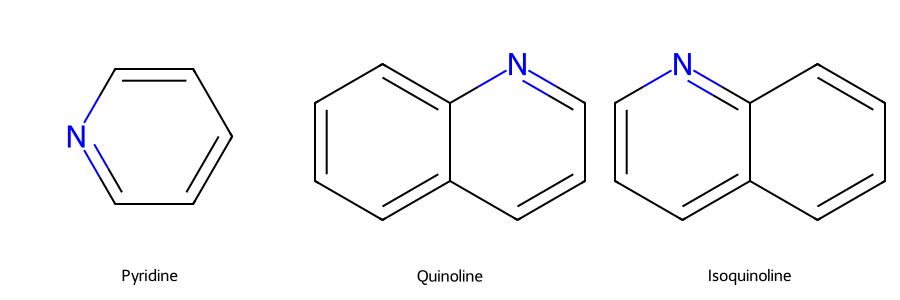

In [ ]:
# Define molecules using SMILES notation
pyridine = Chem.MolFromSmiles('c1ccncc1')
quinoline = Chem.MolFromSmiles('c1ccc2ncccc2c1')  # Chinolin
isoquinoline = Chem.MolFromSmiles('c1cnc2ccccc2c1')  # Isochinolin

# Visualize multiple molecules in a grid
molecules = [pyridine, quinoline, isoquinoline]
legends = ['Pyridine', 'Quinoline', 'Isoquinoline']
img = Draw.MolsToGridImage(molecules, molsPerRow=3, subImgSize=(300,300),
                            legends=legends)

# MolsToGridImage returns a PIL Image object
img  # or display(img)

Other Libraries:

* Py3Dmol - For 3D molecular visualization
* ChemDraw via Python (commercial)
* OpenBabel - Chemical format conversions and 2D structure generation

RDKit is the most commonly used because it's free, powerful, and has excellent 2D structure drawing capabilities that look very similar to your image. It uses SMILES notation (a text-based way to represent molecular structures) which is intuitive once you learn the basics.

###### *Cyclische Verbindungen (Cyclic compound)*

https://de.m.wikipedia.org/wiki/Cyclische_Verbindungen

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1386.png)

Video: [How chemists create "SUPERBENZENE" (Kekulene) | Organic chemistry, synthesis & reaction mechanisms](https://youtu.be/qrBMD_H6jXs)

Artike; [Erster Aromaten-Ring allein aus Metallatomen
Chemiker erzeugen erstmals einen aromatischen Metallring ohne angelagerte Stützmoleküle](https://www.scinexx.de/news/physik/erster-aromaten-ring-allein-aus-metallatomen/)

https://www.scinexx.de/news/technik/erster-benzolring-aus-stickstoff/

https://de.m.wikipedia.org/wiki/Helicene

###### *Kohlenwasserstoffe: <font color="blue">Arene (Arylgruppe)</font> - <font color="red">Carbocyclen-Aromaten</font>, ungesättigt (C=C-Doppelbindungen), cyclisch*

> **Viele biochemische Stoffe sind [Heteroaromate](https://de.m.wikipedia.org/wiki/Heteroaromaten)!** zB. Aspirin (C9 H8 O4) & Paracetamol bei den substituierten Heteroaromaten, [Aromatic_compound](https://en.m.wikipedia.org/wiki/Aromatic_compound) oder Alkaloide (Einfache + kondensierte Heteroaromaten : Arene (Benzole & Aryle wie Phenol) + Amine (Funktionelle Aminogruppe)). <font color="blue">**Cyclische Amine und Imine sind Bestandteile vieler biochemisch wichtiger Verbindungen (Aminosäuren, Enzyme, Nucleinsäure, Farbstoffe, Alkaloide, Vitamine u. a.) und zahlreicher Arzneimittel.** Auch viele kondensierte heterocyclische Systeme gehören in diese Stoffklasse: Indol, Acridin, Chinolin, Isochinolin, Purin, Pteridin, Alloxazin u. a.

* [**Arene (benzoide bzw. aromatische Kohlenwasserstoffe)**](https://de.m.wikipedia.org/wiki/Aromatische_Kohlenwasserstoffe) sind cyclische, planare und durchkonjugierte [Kohlenwasserstoffe](https://de.m.wikipedia.org/wiki/Kohlenwasserstoffe) mit aromatischem System [(Aromaten)](https://de.m.wikipedia.org/wiki/Aromaten), also **durchgehend benachbarte Doppelbindungen haben**

> Arene sind Kohlenwasserstoffe, die alle Kriterien der Aromatizität erfüllen: es sind ebene, zyklische Verbindungen, mit (4n+2) delokalisierten Elektronen.

*  Aromaten erfüllen die [Aromatizitätskriterien](https://de.m.wikipedia.org/wiki/Aromatizität), die sogenannte [Hückelregel](https://de.m.wikipedia.org/wiki/Hückel-Regel): also 4n + 2π Elektronen besitzen

* Die Elektronen der p-Orbitale sind in einem $\pi$-System delokalisiert, d. h. über den gesamten Ring verteilt. Die Delokalisierung führt zu einer Energieabsenkung, der Mesomerieenergie (Resonanzenergie).

> Einfachste Aromaten sind [Benzol](https://de.m.wikipedia.org/wiki/Benzol) und [Toluol](https://de.m.wikipedia.org/wiki/Toluol)

> <font color="blue">Im Gegensatz zu [Heteroaromaten](https://de.m.wikipedia.org/wiki/Heteroaromaten) **besteht der Ring bei aromatischen Kohlenwasserstoffen nur aus Kohlenstoffatomen**</font>

* Unterteilung der aromatischen Kohlenwasserstoffe (Arene): (siehe auch unter [chemie.de](https://www.chemie.de/lexikon/Aromaten.html#Einteilung_der_Aromaten)


**Unterteilung der Aromaten:**

1. Grundbaustein: Einfaches Aromat (Benzole)
2. Konjugierte, monocyclische Kohlenwasserstoffe: Annulene
3. Kondensierte Aromate (Benzole), die Polyzyklische aromatische Kohlenwasserstoffe (PAK)
4. Substituierte Aromate (Benzole) (Benzolderivate) mit einer Phenylgruppe als Arylgruppe
5. Substituierte + kondensierte Aromate (Benzole) (Benzolderivate) - mit mehreren Benzolringen als Grundgeruest, d.h. anstatt 1 Phenylgruppe gibt es komplexere Arylgruppen
6. Einfache + kondensierte **Heteroaromaten** mit ein oder mehreren Heteroatomen als Ringglieder, wie Stickstoff, Sauerstoff oder Schwefel

**Details der [Hückelregel](https://de.m.wikipedia.org/wiki/Hückel-Regel):**

* Ein planares, cyclisch durchkonjugiertes Molekül ist mit [4n+2] π-Elektronen (einer ungeraden Zahl von Elektronenpaaren; Beispiel: n=1, [4·1+2=6], also drei Elektronenpaare) besonders stabil und wird als Aromat bezeichnet.

* Das wichtigste Beispiel ist [Benzol](https://de.m.wikipedia.org/wiki/Benzol), das mit 6 π-Elektronen (n = 1) die Regel erfüllt und als Sechseck außerdem den idealen Bindungswinkel für sp2-hybridisierte Kohlenwasserstoffe bildet. Polycyclische (kondensierte) Aromaten entstehen, wenn man ein oder mehrere Male weitere 4 Kohlenstoffatome an einer Kante hinzufügt, für sie gilt allerdings die Hückelregel nicht mehr (siehe Einschränkungen).

> ![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/d/da/Benzol.svg/100px-Benzol.svg.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_175.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_174.png)

###### *1. Grundbaustein: Einfaches Aromat (Benzole), Benzen C6 H6*

**1. Grundbaustein: Einfaches Aromat (Benzole)**, [Benzen](https://de.m.wikipedia.org/wiki/Benzol) C6 H6

* [Benzol](https://de.m.wikipedia.org/wiki/Benzol) organische Verbindung, einfacher Sechsring mit sechs konjugierten Bindungen (3 Doppel- und 3 Einfachbindungen). Benzol (nach IUPAC Benzen) ist ein flüssiger organischer Kohlenwasserstoff mit der Summenformel C6H6.

* Es besitzt einen charakteristischen aromatischen Geruch, ist farblos, leicht entzündlich und brennt mit stark rußender Flamme. Es mischt sich mit fast allen organischen Lösungsmitteln, jedoch kaum mit Wasser.

* **Benzol ist die Stammverbindung der aromatischen Kohlenwasserstoffe**.


The various representations of benzene.

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/9/9a/Benzene_Representations.svg/640px-Benzene_Representations.svg.png)

Major commodity chemicals and polymers derived from benzene [Source](https://en.m.wikipedia.org/wiki/Benzene)

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/5/54/Benzene_uses.png/800px-Benzene_uses.png)

###### *2. Konjugierte, monocyclische Kohlenwasserstoffe (Annulene)*

**2. Konjugierte, monocyclische Kohlenwasserstoffe**: [Annulene](https://de.m.wikipedia.org/wiki/Annulene)  bzw. [auf englisch](https://en.m.wikipedia.org/wiki/Annulene)

* [Cyclobutadiene](https://en.m.wikipedia.org/wiki/Cyclobutadiene) ([4]annulene)

* [Benzene](https://en.m.wikipedia.org/wiki/Benzene) ([6]annulene)

* [Cyclooctatetraene](https://en.m.wikipedia.org/wiki/Cyclooctatetraene) ([8]annulene)

* [Cyclododecahexaene](https://en.m.wikipedia.org/wiki/Cyclododecahexaene) ([12]annulene)

* [Cyclotetradecaheptaene](https://en.m.wikipedia.org/wiki/Cyclotetradecaheptaene) ([14]annulene)

* [Cyclooctadecanonaene](https://en.m.wikipedia.org/wiki/Cyclooctadecanonaene) ([18]annulene)

* Cyclodocosahendecaene ([22]-annulene)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0743.png)

###### *3. Kondensierte Aromate (Polyzyklische aromatische Kohlenwasserstoffe)*

**3. Kondensierte Aromate (Benzole)**, die [Polyzyklische aromatische Kohlenwasserstoffe (PAK)](https://de.m.wikipedia.org/wiki/Polycyclische_aromatische_Kohlenwasserstoffe), auch genannt [anellierte](https://de.m.wikipedia.org/wiki/Anellierung) Arene genannt, d.h. Kohlenwasserstoffe mit mehreren Ringen.

* [Naphthalin](https://de.m.wikipedia.org/wiki/Naphthalin) C10H8 (2 Ringe; zweimal Sechsring)

* [Azulen](https://de.m.wikipedia.org/wiki/Azulen) C10H8 (2 Ringe; Fünf-/Siebenring)

* [Anthracen](https://de.m.wikipedia.org/wiki/Anthracen) C14 H10 (3 Ringe)

* [Phenanthren](https://de.m.wikipedia.org/wiki/Phenanthren) C14 H10 (siehe Gemeinsamkeit & Unterschied zu Anthracen!)

* [Pentacen](https://de.m.wikipedia.org/wiki/Pentacen) C22 H14 - Genutzt in Photovoltaik, [Source](https://www.pro-physik.de/nachrichten/ein-photon-rein-zwei-elektronen-raus)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0741.png)

###### *4. Substituierte Aromaten (Aspirin und Paracetamol)*

**4. Substituierte Aromate (Benzole)** (Benzolderivate) mit einer [Phenylgruppe](https://de.m.wikipedia.org/wiki/Phenylgruppe) als [Arylgruppe](https://de.m.wikipedia.org/wiki/Arylgruppe), d.h. 1 Benzolring als Grundgerust (Atomgruppe –C6H5). Am Benzolring haengt ein angefügter Substituent, der aber verschiedene Konstitutionsisomere haben kann

  * [Toluol](https://de.m.wikipedia.org/wiki/Toluol)

  * [Xylole](https://de.m.wikipedia.org/wiki/Xylole)

  * [Phenol](https://de.m.wikipedia.org/wiki/Phenol) C6H5–OH

  * [Nitrobenzol](https://de.m.wikipedia.org/wiki/Nitrobenzol) C6H5–NO2

  * [Anilin](https://de.m.wikipedia.org/wiki/Anilin) (Aminobenzol) C6H5–NH2

  * [Hydrochinon](https://de.m.wikipedia.org/wiki/Hydrochinon) HO–C6H4–OH

  * [Pikrinsäure](https://de.m.wikipedia.org/wiki/Pikrinsäure) (2,4,6-Trinitrophenol) C6H2(OH)(NO2)3

  * Benzaldehyde

  * [Benzoesäure](https://de.m.wikipedia.org/wiki/Benzoesäure)

  * [Brombenzol](https://de.m.wikipedia.org/wiki/Brombenzol)

  * siehe grosse Liste auch unter [Disubstituierte Benzole](https://de.m.wikipedia.org/wiki/Disubstituierte_Benzole)

  * **Special:** [Biaryle](https://de.m.wikipedia.org/wiki/Biaryle) wie [Biphenyl](https://de.m.wikipedia.org/wiki/Biphenyl): separaten (isolierten) Ringe anstatt Aromaten mit gemeinsamen Atomen



![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0739.png)

**Benzene derivatives have from one to six substituents attached to the central benzene core.** Examples of benzene compounds with just one substituent are phenol, which carries a hydroxyl group, and toluene with a methyl group. When there is more than one substituent present on the ring, their spatial relationship becomes important for which the arene substitution patterns ortho, meta, and para are devised. For example, three isomers exist for cresol because the methyl group and the hydroxyl group can be placed next to each other (ortho), one position removed from each other (meta), or two positions removed from each other (para). Xylenol has two methyl groups in addition to the hydroxyl group, and, for this structure, 6 isomers exist.



**Representative arene compounds (siehe Aspirin und Paracetamol!)**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0909.png)

###### *5. Substituierte + kondensierte Aromate*

**5. Substituierte + kondensierte Aromate (Benzole)** (Benzolderivate) - mit mehreren Benzolringen als Grundgeruest, d.h. anstatt 1 [Phenylgruppe](https://de.m.wikipedia.org/wiki/Phenylgruppe) gibt es komplexere [Arylgruppen](https://de.m.wikipedia.org/wiki/Arylgruppe) wie zB Naphthyl-Rest (fur 2), Anthryl-Rest (fur 3). An einem Benzolring haengt ein angefügter Substituent.

* [1-Naphthol](https://de.m.wikipedia.org/wiki/1-Naphthol)

* [2-Naphthylamin](https://de.m.wikipedia.org/wiki/2-Naphthylamin)

* 9-Anthracencarbaldehyd

* Phenanthren-9-boronsäure

* Siehe auch [Heteroarylgruppe](https://de.m.wikipedia.org/wiki/Heteroarylgruppe)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0742.png)

###### *6. Einfache Heteroaromaten (Heterocyclen) + kondensierte Heteroaromaten (Viele Alkaloide)*

**Einführung**

* Siehe [Heterocyclen](https://de.m.wikipedia.org/wiki/Heterocyclen): Ringmoleküle mit mindestens zwei verschiedenen Elementen im Ring

* *Kohlenwasserstoffe: <font color="blue">Arene (Arylgruppe)</font> - <font color="red">Heteroaromaten</font>, ungesättigt (C=C-Doppelbindungen), cyclisch*

* **Einfache + kondensierte [Heteroaromaten](https://de.m.wikipedia.org/wiki/Heteroaromaten)**  mit ein oder mehreren Heteroatomen als Ringglieder, wie Stickstoff, Sauerstoff oder Schwefel. zwei anellierten aromatischen sechsgliedrigen Ringen.

  * Siehe mehr Verbindungen unter [Aromaten](https://de.m.wikipedia.org/wiki/Aromaten)bzw. [Aromatic Compound](https://en.m.wikipedia.org/wiki/Aromatic_compound)

  * Siehe auch [Organic compound](https://en.m.wikipedia.org/wiki/Organic_compound)


* <font color="blue">**Cyclische Kohlenwasserstoffe (insbesondere Heteroaromaten) sind in vielen Naturstoffen verhanden**
  * **Arene (Benzole & Aryle wie Phenol) + [Amine](https://de.m.wikipedia.org/wiki/Amine) (Funktionelle Aminogruppe) = Cyclische Amine** und Imine
  * in vielen Wirkstoffen / sind Bestandteile vieler biochemisch wichtiger Verbindungen (**Aminosäuren, Enzyme, Nucleinsäure, Farbstoffe, <u>Alkaloide</u>, Vitamine u. a.) und zahlreicher Arzneimittel**

https://de.m.wikipedia.org/wiki/Heterocyclen

siehe auch : Heterocylische Stammsysteme https://www.chemie.de/lexikon/Heterocyclen.html

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1569.jpg)

Heterocyclen sind in der Natur extrem weitverbreitet (Alkaloide,. Nukleinsäuren, DNA, Farbstoffe..)

* Ringförmige Verbindungen, in denen ein oder mehrere C-Atome durch andere Elemente (Heteroatome) ersetzt sind.
• Wichtigste Heteroatome: 0, N, S, wichtigste Ringgrößen: 5 und 6
• Heterocyclen lassen sich in **aromatische Heterocyclen** (6t-Elektronensystem) und **nichtaromatische Heterocyclen** (??) unterteilen.
• häufig Verknüpfung zu Mehrfach-Ringsystemen (Bicyclen, Tricyclen... Polycyclen)

https://boku.ac.at/fileadmin/data/H03000/H77000/LVA/770101_TR_b/12_Heterocyclen.pdf

Beispiele: https://www.chemie.de/lexikon/Heterocyclen.html

Non-aromatic heterocycles in organic chemistry are heterocyclic compounds that do not exhibit aromaticity. A heterocycle refers to a cyclic compound in which at least one of the ring atoms is an atom other than carbon, such as nitrogen (N), oxygen (O), or sulfur (S). Aromaticity, on the other hand, refers to a special type of stability that certain cyclic compounds possess due to the presence of a conjugated π-electron system.

Non-aromatic heterocycles can be classified into several categories based on the atoms present in the ring and their electronic properties. Some common examples of non-aromatic heterocycles are:

1. Non-aromatic nitrogen-containing heterocycles:
   - Pyrrole: A five-membered ring containing four carbon atoms and one nitrogen atom.
   - Imidazole: A five-membered ring with two nitrogen atoms and three carbon atoms.
   - Pyrazole: A five-membered ring with two adjacent nitrogen atoms and three carbon atoms.
   - Pyridine: A six-membered ring with one nitrogen atom and five carbon atoms.
   - Quinoline: A six-membered ring fused with a benzene ring, containing one nitrogen atom.

2. Non-aromatic oxygen-containing heterocycles:
   - Furan: A five-membered ring with one oxygen atom and four carbon atoms.
   - Tetrahydrofuran (THF): Furan in its reduced form, with four carbon atoms and one oxygen atom.
   - Dioxane: Two linked THF rings.
   - Morpholine: A saturated six-membered ring containing one oxygen and one nitrogen atom.

3. Non-aromatic sulfur-containing heterocycles:
   - Thiophene: A five-membered ring with one sulfur atom and four carbon atoms.
   - Thiazole: A five-membered ring with one sulfur and one nitrogen atom, along with three carbon atoms.
   - Benzothiophene: Thiophene fused with a benzene ring, containing one sulfur atom.

These are just a few examples of non-aromatic heterocycles, and there are many more compounds that fall into this category. It's important to note that the presence or absence of aromaticity significantly influences the reactivity and properties of these heterocycles.

[**Monocyclische Heteroaromaten**](https://de.m.wikipedia.org/wiki/Heteroaromaten#Monocyclische_Heteroaromaten):

**Dreiring-Heteroaromaten mit einem Heteroatom:**

* [Epoxide](https://de.m.wikipedia.org/wiki/Epoxide) mit 2 Kohlenstoffatomen und dazwischen ein Sauerstoff-Atom, zB [Propylenoxid](https://de.m.wikipedia.org/wiki/Propylenoxid) C3H6O (Dreiring mit Sauerstoffatom). Siehe auch "Umweltschonende Herstellung von Propylenoxid"

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c1/Propylene-oxid-2D.svg/120px-Propylene-oxid-2D.svg.png)

**Fünfring-Heteroaromaten mit einem Heteroatom:**

* [Furan](https://de.m.wikipedia.org/wiki/Furan) C4H4O (Fünfring mit Sauerstoffatom)

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/3/35/Furan.svg/66px-Furan.svg.png)

* [Thiophen](https://de.m.wikipedia.org/wiki/Thiophen) C4H4S (Fünfring mit Schwefelatom)

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/a/af/Thiophen.svg/66px-Thiophen.svg.png)

**Fünfring-Heteroaromaten mit mehreren Heteroatomen:**

* [Pyrrol](https://de.m.wikipedia.org/wiki/Pyrrol) C4H4NH (Fünfring mit Stickstoff- und Wasserstoffatom)

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f3/Pyrrol2.svg/66px-Pyrrol2.svg.png)

**Sechsring-Heteroaromaten mit einem Heteroatom:**

* [Pyridin](https://de.m.wikipedia.org/wiki/Pyridin) C5H5N (Sechsring mit Stickstoffatom). Pyridin ist ein Sechsring-Heteroaromaten mit <u>einem Heteroatom</u>, siehe [Pyridin-Alkaloide](https://de.m.wikipedia.org/wiki/Pyridin-Alkaloide),

* wie zB Tabak, das [Nicotin](https://de.m.wikipedia.org/wiki/Nicotin) - haengt man noch ein Benzol ran, erhaelt man Chinolin ! (Benzopyridin und 1-Azanaphthalin gelegentlich anzutreffen. Benzopyridin beschreibt das Molekül als Pyridin, [Source](https://www.chemie-schule.de/KnowHow/Chinolin).

> ![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/d/dc/Pyridin.svg/70px-Pyridin.svg.png)

**Sechsring-Heteroaromaten mit mehreren Heteroatomen:**

* [Pyrimidin](https://de.m.wikipedia.org/wiki/Pyrimidin) - <font color="red">Organische Nukleinbase: Pyrimidin-Basen: Cytosin, Thymin (in der DNA) und Uracil (in der RNA). Pyrimidin-Derivate spielen auch als Diuretika, Antibiotika, Antimetabolika und in der antiviralen Therapie eine Rolle.

> ![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f2/Pyrimidin.svg/76px-Pyrimidin.svg.png)

*Beziehung zwischen **Pyridin (=Monocyclische Heteroaromaten)**, dem **Chinolin (=Bicyclische Heteroaromaten)** und **Isochinolin** (Heteroatom an anderer Stelle) unter den Heteroaromaten:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0744.png)

[**Bicyclische Heteroaromaten**](https://de.m.wikipedia.org/wiki/Heteroaromaten#Bicyclische_Heteroaromaten):

* [Indol](https://de.m.wikipedia.org/wiki/Indol) ist ein Benzoanellierte Fünfring-Heteroaromaten, siehe [Indol-Alkaloide](https://de.m.wikipedia.org/wiki/Indolalkaloide) (LSD, Ayahuasca, Strychnin)

* [Chinolin](https://de.m.wikipedia.org/wiki/Chinolin) ist ein Benzoanellierte Sechsring-Heteroaromaten, siehe [Chinolin-Alkaloide](https://de.m.wikipedia.org/wiki/Chinolin-Alkaloide)

* [Purin](https://de.m.wikipedia.org/wiki/Purin) ist ein Heteroanellierte Heteroaromaten, siehe [Purin-Alkaloide](https://de.m.wikipedia.org/wiki/Purinalkaloide) (Koffein). <font color="red">Organische Nukleinbase in DNA & RNA: Purin-Basen: Adenin, Guanin:

> ![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1f/Purines.svg/640px-Purines.svg.png)


*Purine & Pyrimidin in DNA:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_078.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0738.png)

Coffein enthält einen bicyclischen Heteroaromat mit 4 Stickstoffatomen (Xanthin) - siehe [Purin-Alkaloide](https://de.m.wikipedia.org/wiki/Purinalkaloide)

> ![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a1/Koffein_-_Caffeine.svg/220px-Koffein_-_Caffeine.svg.png)

Nikotin enthält einen heteroaromatischen Sechsring (Pyridin). Siehe [Pyridin-Alkaloide](https://de.m.wikipedia.org/wiki/Pyridin-Alkaloide)

> ![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Nikotin_-_Nicotine.svg/224px-Nikotin_-_Nicotine.svg.png)

Struktur von [Morphin](https://de.m.wikipedia.org/wiki/Morphin), Teil der [Isochinolin-Alkaloide](https://de.m.wikipedia.org/wiki/Isochinolin-Alkaloide)

> ![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/3/33/Morphin_-_Morphine.svg/254px-Morphin_-_Morphine.svg.png)


**Heterocyclen allgemein (Heteroaromaten + Heteroaliphaten)**

> [**Heterocyclen**](https://de.m.wikipedia.org/wiki/Heterocyclen) sind [cyclische chemische Verbindungen](https://de.m.wikipedia.org/wiki/Cyclische_Verbindungen) mit ringbildenden Atomen aus mindestens zwei verschiedenen chemischen Elementen - z.B. in der organischen Chemie enthalten sie außer C- Atomen ein oder mehrere Heteroatome als Ringglieder, wie Stickstoff, Sauerstoff oder Schwefel.

* **Ringe aus fünf und sechs Atomen sind am beständigsten**.

* Aliphatische Heterocyclen werden auch kurz als **Heteroaliphaten** bezeichnet.

* [Aromatische](https://de.m.wikipedia.org/wiki/Aromaten) Heterocyclen werden auch kurz als [Heteroaromaten](https://de.m.wikipedia.org/wiki/Heteroaromaten) bezeichnet.

Nach Sättigungsgrad ergibt sich eine Einteilung in:

* [**Alkane**] gesättigte Heterocycloalkane: [Cycloalkane](https://de.m.wikipedia.org/wiki/Cycloalkane)

* [**Alkene**] partiell ungesättigte Heterocycloalkene: [Cycloalkene](https://de.m.wikipedia.org/wiki/Cycloalkene)

* [**Aromaten**] die [Heteroaromaten](https://de.m.wikipedia.org/wiki/Heteroaromaten)

* [**Alkine**] Besonders in [Makrocyclen](https://de.m.wikipedia.org/wiki/Makrocyclische_Verbindungen) sind selten auch Cycloalkine (vergleiche [Alkine](https://de.m.wikipedia.org/wiki/Alkine)) zu finden.

###### *7. NEW: Homoaromaten*

https://www.scinexx.de/news/technik/neue-molekuelklasse-nachgewiesen/

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1514.jpg)

###### *Vanillin*

https://de.m.wikipedia.org/wiki/Vanillin

https://de.m.wikipedia.org/wiki/Benzaldehyd

https://presse.uni-mainz.de/nachhaltiges-verfahren-fuer-herstellung-von-vanillin-aus-lignin-macht-weitere-fortschritte/

https://www.lebensmittelverband.de/de/mythen/vanille-geschmack-vanillin-erdoel

https://zeitung.faz.net/fas/wissenschaft/2024-03-24/13e0323d2653595ec8b50b8e0e36fc71?GEPC=s9



##### <font color="blue">*Kohlenwasserstoffe mit funktioneller Gruppe*

thiole und amine

###### *Funktionelle Gruppen & CHNOPS*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1353.jpg)

> **[Funktionelle Gruppen](https://de.m.wikipedia.org/wiki/Funktionelle_Gruppe) sind Atome oder Atomgruppen in den Molekülen organischer Verbindungen. Sie bestimmen maßgeblich die chemischen und physikalischen Eigenschaften der Verbindungen.**

* Substanzen, deren Moleküle die gleiche funktionelle Gruppe tragen, bilden eine **Stoffklasse**. Unterscheiden sich die Moleküle der Stoffklasse nur in der Kettenlänge des Alkylrests, bilden sie eine **homologe Reihe**.

* **Viele organische Moleküle tragen nur eine funktionelle Gruppe**, z.B. die Hydroxy-Gruppe bei den verschiedenen Alkoholen. **Es gibt aber auch Verbindungen, die über mehrere funktionelle Gruppen verfügen**. So enthalten beispielsweise Aminosäuren eine Carboxy-Gruppe und eine Amino-Gruppe im Molekül, die beide die Eigenschaften der Verbindungen beeinflussen.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_177.jpeg)

Das Akronym [CHNOPS](https://de.m.wikipedia.org/wiki/CHNOPS) bezeichnet die sechs wichtigsten Elemente, die in verschiedenen Kombinationen in den meisten Biomolekülen anzutreffen sind. Die einzelnen Buchstaben stehen für die Abkürzungen der Elemente Kohlenstoff, Wasserstoff, Stickstoff, Sauerstoff, Phosphor und Schwefel. Die Bezeichnung CHNOPS fungiert in diesem Zusammenhang auch als Eselsbrücke für den Chemie- und Biologieunterricht.

* **Kohlenwasserstoffe** sind Verbindungen von Kohlenstoff mit Wasserstoff, die in sämtlichen Lebensformen vorkommen und dort das Rückgrat der Biomoleküle bilden, die durch die Verbindung mit funktionellen Gruppen entstehen.

* **Stickstoff N** (Amino-) ist Bestandteil der funktionellen Gruppe der Amine und als solcher Bestandteil sämtlicher Eiweißverbindungen. Des Weiteren ist er essentieller Bestandteil der Desoxyribonukleinsäure und des Chlorophylls.

* **Sauerstoff O** bildet zahlreiche funktionelle Gruppen und ist für die Atmung fast aller Lebewesen von zentraler Bedeutung.

* **Phosphor Ph** ist die Grundlage für den Aufbau von Phospholipiden, einer Klasse von Lipiden, die einen Hauptbestandteil aller Zellmembranen darstellen, sowie Ionen, Proteine und andere Moleküle dort festhalten, wo sie für die Zellfunktion benötigt werden.

  * Phosphatgruppen sind des Weiteren auch ein essentieller Bestandteil des Rückgrats der Nukleinsäuren und nötig, um ATP – die Hauptmoleküle, die als Energiequelle der Zelle in allen Lebewesen genutzt werden, zu bilden.

* **Schwefel S** ist Bestandteil der Aminosäuren Cystein und Methionin.

**Einteilung der Stoffe in der organischen Chemie** [Source](https://commons.wikimedia.org/wiki/File:Einteilung_der_Stoffe-organische_Chemie.svg)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_176.png)

[**Hydroxygruppe**](https://de.m.wikipedia.org/wiki/Hydroxygruppe) –OH (Alkohole und Phenole)

* ist die funktionelle Gruppe der Alkohole und Phenole und kommt auch in Kohlenhydraten oder bei Hydroxycarbonsäuren als Strukturelement eines Alkohols vor.

* Die Hydroxygruppe ist aber auch ein Teilelement der Carboxygruppe in Carbonsäuren, dort aber gebunden an das C-Atom einer Carbonylgruppe, das einen höheren Oxidationszustand hat.

* Die Hydroxygruppe ist deshalb in Carbonsäuren kein Strukturelement eines Alkohols, sondern hat die sauren Eigenschaften einer Carbonsäure.

> ![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b1/Hydroxy_Group_Structural_Formulae.svg/144px-Hydroxy_Group_Structural_Formulae.svg.png)

*Hydroxygruppe (blau markiert) als funktionelle Gruppe eines Alkohols. R ist dann eine Alkylgruppe.*

[**Aminogruppe**](https://de.m.wikipedia.org/wiki/Aminogruppe) –NH2

[**Carbonylgruppe**](https://de.m.wikipedia.org/wiki/Carbonylgruppe) -C=O

> **Die Aldehyd- und Ketogruppe sind Carbonylgruppen, da jeweils ein doppelt gebundenes Sauerstoffatom vorliegt.**

* Trägt die Carbonylverbindung lediglich Alkylreste, so wird die Gruppierung auch als Ketogruppe bezeichnet.

* Den einbindigen organischen Rest, der formal aus z. B. einer organischen Säure nach Abspalten der Hydroxygruppe resultiert, nennt man [Acyl-Gruppe](https://de.m.wikipedia.org/wiki/Acylgruppe)

* [**Aldehydgruppe**](https://de.m.wikipedia.org/wiki/Aldehyde) -CHO

* [**Ketongruppe**](https://de.m.wikipedia.org/wiki/Ketone) Verbindungen mit nicht endständiger Carbonylgruppe >C=O

[**Carboxygruppe**](https://de.m.wikipedia.org/wiki/Carboxygruppe) –COOH

[**Ethergruppe**](https://de.m.wikipedia.org/wiki/Ether) –O–

###### *Halogenkohlenwasserstoffe (-Fl, -Cl, -Br, -I)*

> Halogenkohlenwasserstoff = Halogene + Aliphate oder Aromate

* [**Halogenkohlenwasserstoffe**](https://de.m.wikipedia.org/wiki/Halogenkohlenwasserstoffe) sind Kohlenwasserstoffe, bei denen mindestens ein Wasserstoffatom durch eines der Halogene **Fluor, Chlor, Brom oder Iod** ersetzt wurde.

* Halogenkohlenwasserstoffe sind lipophile (fettlösliche) Substanzen, die vielfach hervorragende organische Lösungsmittel sind.

* Ein wichtiger Vertreter ist der Kunststoff [Polyvinylchlorid](https://de.m.wikipedia.org/wiki/Polyvinylchlorid) (PVC).

* Daneben [Chloroform](https://de.m.wikipedia.org/wiki/Chloroform) oder [Tetrachlormethan](https://de.m.wikipedia.org/wiki/Tetrachlormethan) als bedeutende [Lösungsmittel](https://de.m.wikipedia.org/wiki/Lösungsmittel)

*Struktur verschiedener Klassen halogenierter Kohlenwasserstoffe, von oben nach unten: Halogenalkan, Halogenalken, Halogenaromat. Halogenatom blau markiert:*

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/d/dc/Halocarbon_General_Formulae_V.1.png/155px-Halocarbon_General_Formulae_V.1.png)

[**Halogenalkane**](https://de.m.wikipedia.org/wiki/Halogenkohlenwasserstoffe#Halogenalkane)

* [Fluoralkane](https://de.m.wikipedia.org/wiki/Fluoralkane), zB Primäres Fluoralkan:

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/3/30/Prim-Fluoroalkanes_Structural_Formula_V1.png/320px-Prim-Fluoroalkanes_Structural_Formula_V1.png)

* [Chloralkane](https://de.m.wikipedia.org/wiki/Chloralkane)

* [Bromalkane](https://de.m.wikipedia.org/wiki/Bromalkane)

* [Iodalkane](https://de.m.wikipedia.org/wiki/Iodalkane)


[**Halogenalkene**](https://de.m.wikipedia.org/wiki/Halogenkohlenwasserstoffe#Halogenalkene)

[**Aromatische Halogenkohlenwasserstoffe (Halogenaromaten)**](https://de.m.wikipedia.org/wiki/Halogenkohlenwasserstoffe#Aromatische_Halogenkohlenwasserstoffe)

* (auch Halogenarene) sind Derivate von Aromaten oder Arenen, bei denen ein oder mehrere Wasserstoffatome durch Elemente der 7. Hauptgruppe (Halogene) des Periodensystems ersetzt wurden.

* Die meisten aromatischen Halogenverbindungen sind hochgiftig und werden oder wurden als Insektizide oder Fungizide eingesetzt. Viele davon sind mittlerweile verboten.

###### *Hydroxy-Gruppe (-OH) - Alkohole*


Isopropylalkohol: Isopropylalkohol, auch bekannt als Isopropanol oder 2-Propanol, ist ein farbloser, brennbarer Alkohol, der vielseitig einsetzbar ist. Er wird synthetisch aus Propen hergestellt und dient als Reinigungsmittel, Lösungsmittel, Entfetter und Desinfektionsmittel.

https://de.m.wikipedia.org/wiki/2-Propanol

https://www.spektrum.de/news/methantriol-molekuel-bricht-150-jahre-alte-chemie-regel/2217399

> Alkohole = Hydroxygruppe + Aliphate (Alkanolen, Alkenolen, Alkinolen)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_179.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_178.png)

**Homologe Reihe der Alkane**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_105.png)

**Alkohole basierend auf Alkanenen:**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_109.png)


> [**Alkohole**](https://de.m.wikipedia.org/wiki/Alkohole) ist eine organische Verbindung mit einer oder mehreren an **aliphatische Kohlenstoffatome** gebundenen Hydroxygruppen

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Alkohol_-_Alcohol.svg/115px-Alkohol_-_Alcohol.svg.png)

* Oben: Funktionelle Gruppe der Alkohole ist die blau markierte Hydroxygruppe. **R ist ein Alkyl-, Alkenyl- oder Alkinyl-Rest**, jedoch kein Aryl-Rest, Acyl-Rest oder ein Heteroatom.

* Unten links im Bild ist der organische Teil des Moleküls, den so genannten Alklyrest, rechts in blau ist die funktionelle Gruppe des Alkohols, die Hydroxygruppe mit ihrer stark polaren O-H-Bindung.

* **Beispiel unten ist eine Ethylgruppe (C2H5) aus den Alkanen + eine OH-Hydroxygruppe. Das ist dann [Ethanol](https://de.m.wikipedia.org/wiki/Ethanol) genannt.**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_108.png)

* **Beide Teile des Moleküls bestimmen die physikalischen Eigenschaften der Alkohole**.

  * Die Alkylgruppe verleiht den Alkoholen teilweise Eigenschaften der Alkane,. **Je länger die Ketten, desto hydrophober / lipophiler ist der Alkohol**.

  * während die OH-Gruppe den Alkoholen zum Teil Eigenschaften des Wassers verleiht.

  * Welche Gruppe einen stärkeren Einfluss hat, hängt von der Größe des Alkylrestes und von der Anzahl der OH-Gruppen ab sowie von weiteren Faktoren wie beispielsweise den Verzweigungsgrad des Moleküls und der Stellung der OH-Gruppe(n).

* Um die physikalischen Eigenschaften der kurzkettigen Alkohole besser zu verstehen, vor allem die gute Wasserlöslichkeit und die hohen Siedetemperaturen, muss man sich intensiv mit dem Aufbau und den Eigenschaften des Wassers beschäftigt haben. [Source](http://www.u-helmich.de/che/Sek2/Organik/Klassen/Alkohole/2_eigenschaften/wasser.html)

Quelle: https://chemiezauber.de/inhalt/basic-5-kl-10-kohlenstoffverbindungen-organische-chemie-2/alkohole/homologe-reihe-der-n-alkanole.html


> [Glycerin](https://de.m.wikipedia.org/wiki/Glycerin)  ist der Trivialname und die gebräuchliche Bezeichnung von Propan-1,2,3-triol. Glycerin ist ein [Zuckeralkohol (Alditole)](https://de.m.wikipedia.org/wiki/Alditole) und der einfachste dreiwertige Alkohol, ein Triol. Glycerin ist in allen natürlichen Fetten und fetten Ölen – z. B. Pflanzenölen – chemisch gebunden als [Fettsäureester (Carbonsäureester)](https://de.m.wikipedia.org/wiki/Carbonsäureester) [(Triglyceride)](https://de.m.wikipedia.org/wiki/Triglyceride) vorhanden und spielt eine zentrale Rolle als Zwischenprodukt in verschiedenen Stoffwechselprozessen. Als Lebensmittelzusatzstoff trägt es das Kürzel E 422.



Siehe auch [**minderwertige Alkohole**](https://de.m.wikipedia.org/wiki/Alkohole#Wertigkeit_der_Alkohole), die [https://de.m.wikipedia.org/wiki/Polyole](Polyole): Gruppe von organischen Verbindungen, die mehrere Hydroxygruppen enthalten -  mit den einfachsten Vertretern Monoethylenglykol und Glycerin!

> ![](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1f/Pentaerythritol.svg/320px-Pentaerythritol.svg.png)

**Unterschiedliche Arten an Alkoholen**


*Einwertige und mehrwertige Alkohole*

Trägt in Alkohol-Molekül nur eine Hydroxylgruppe, handelt es sich um einen einwertigen Alkohol, bei mehreren OH-Gruppen um einen mehrwertigen Alkohol.

Dreiwertiger Alkohol: 1,2,3-Propantriol (Trivialname Glycerin)

> ![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/f/fb/Glycerin_-_Glycerol.svg/320px-Glycerin_-_Glycerol.svg.png)

[**Alkanole**](https://de.m.wikipedia.org/wiki/Alkanole): Stoffgruppe, die sich von den Alkanen (gesättigten Kohlenwasserstoffen) ableitet. Als funktionelle Gruppe besitzen alle Alkanole eine oder mehrere Hydroxylgruppe(n).

**Eine Hydroxylgruppe:**

* Alkanole mit einer cyclischen Alkylgruppe

  * [Methanol](https://de.m.wikipedia.org/wiki/Methanol)

  * [Ethanol](https://de.m.wikipedia.org/wiki/Ethanol)

  * [Propanole](https://de.m.wikipedia.org/wiki/Propanole)

  * [Butanole](https://de.m.wikipedia.org/wiki/Butanole)

  * [Fettalkohole](https://de.m.wikipedia.org/wiki/Fettalkohole), Fettalkohole finden sich in natürlichen Wachsen

* Alkanole mit einer cyclischen Alkylgruppe nennt man [**Cycloalkanole**](https://de.m.wikipedia.org/wiki/Cycloalkanole), Beispiel: [Cyclohexanol](https://de.m.wikipedia.org/wiki/Cyclohexanol)

**Zwei oder mehr Hydroxylgruppen:**

* Alkanole mit zwei Hydroxygruppen nennt man [**Alkandiole**](https://de.m.wikipedia.org/wiki/Alkandiole), einfachstes Beispiel: [Ethylenglycol](https://de.m.wikipedia.org/wiki/Ethylenglycol)

* Alkanole mit drei Hydroxygruppen sind **Alkantriole**, einfachstes Beispiel ist [Glycerin](https://de.m.wikipedia.org/wiki/Glycerin).

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_113.png)

*Primäre, sekundäre und tertiäre Alkohole*

Betrachten wir das Kohlenstoffatom, das die Hydroxy|gruppe bindet. Befinden sich an diesem Kohlenstoffatom in weiteres Kohlenstoffatom und ansonsten nur Wasserstoffatome, spricht man von einem primären Alkohol. Falls sich zwei weitere Kohlenstoffatome darn befinden, heißt es sekundärer Alkohol.
bei drei Kohlenstoffatomen tertiärer Alkohol.

* Primäre Alkohole: werden zu Aldehyden oxidiert

* sekundäre Alkohole: werden zu Ketonen oxidiert

* tertiäre Alkohole: werden nicht oxidiert

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_126.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_127.png)

[Isopropylalkohol (2-Propanol)](https://de.m.wikipedia.org/wiki/2-Propanol) used in microchip industry
* In den Einwegtüchern steckt Isopropylalkohol. Dieser ist gängiger Bestandteil in Desinfektionsmitteln, Lösungsmitteln, Reinigungsmitteln und Frostschutzmitteln.
* Auf die „oleophobische“, also ölabweisende, Display-Beschichtung von Smartphones hat er aufgrund seiner fettlösenden Eigenschaften allerdings eine nachteilige Wirkung.
* So rät Apple ab, zu stark alkoholhaltige Lösungsmitteln zu verzichten. Diese können bei hoher Konzentration zu aggressiv für die Handyreinigung sein. Erlaubt sind aber immerhin die folgenden Grenzwerte: „Du kannst die harten, nicht porösen Oberflächen deines Apple-Produkts, z. B. das Display, die Tastatur oder andere Außenflächen, mit einem Tuch mit 70-prozentigem Isopropylalkohol, 75-prozentigem Ethylalkohol oder mit Clorox-Desinfektionstüchern vorsichtig abwischen.“
* Doch warum haben Smartphones eine ölabweisende Schicht? Der Grund dafür ist einfach, aber effektiv. Die störenden Fettflecken durch Fingerabdrücke wären ohne die Beschichtung nämlich deutlich schlimmer, weil sie sich so einfach wegwischen ließen. Dass sich diese Schicht mit der Zeit abnutzt, ist normal. Das Handy zu rienigen udn dafür zu aggressive Hilfsmittel wie Brillenputztücher zu verwenden, beschleunigt diesen Prozess allerdings unnötig. Exemplare mit zu viel Isopropylalkohol sind dann wie pures „Gift“ für dein Smartphone.


**Alkohole als Lösungsmittel**

* Allgemein gilt der Grundsatz "Gleiches löst sich in Gleichem". Somit lösen sich Stoffe in den Lösungsmitteln, die in ihrem Aufbau und somit auch in ihrer Polarität ähnlich sind. Bei Alkohol ist das anders.

* In Experimenten zeigt sich, dass **Ethanol sowohl mit Wasser als auch mit Benzin mischbar ist**. Das ist an sich sehr ungewöhnlich, **denn Wasser und Benzin lösen sich (fast!) überhaupt nicht miteinander**. Also muss das Molekül von Ethanol etwas Besonderes an sich haben, so dass es in der Lage ist, sich mit zwei so unterschiedlichen Stoffen vermischen zu können.

* Um das Lösungsverhalten eines Stoffes gegenüber Wasser zu charakterisieren, benutzt man die beiden Begriffe "hydrophil" und "hydrophob".

  * Ein hydrophiler Stoff ist somit sehr gut wasserlöslich. **Stoffe, die sich gut mit Wasser mischen, sind immer polar (so wie das Wasser) oder elektrisch geladen.**

  * Man bezeichnet einen Stoff als hydrophob, wenn er schlecht oder gar nicht in Wasser löslich ist. **Das sind immer unpolare oder elektrisch neutrale Moleküle. Z. B. Fette, Öle und Alkane sind hydrophobe Stoffe**. Ist ein Stoff fettlöslich, so bezeichnet man ihn auch als lipophil (griechisch lipos = Fett).


**Die Erklärung für das Lösungsverhalten von Ethanol**

* Diese liefert uns sein molekularer Aufbau. Das Lösungsverhalten dieser Verbindung wird also durch die unterschiedlichen Eigenschaften der beiden Molekülteile bestimmt.

> **Zum einen enthält sein Molekül eine Hydroxylgruppe (OH-Gruppe), die dem Wassermolekül ähnlich ist.**

* **Die Fähigkeit, sich in Wasser zu lösen, verdankt das Ethanol dieser funktionellen Gruppe**. Deshalb bezeichnet man diesen Alkohol auch als einen hydrophilen (wasserliebenden) Stoff.

* Doch woran liegt das? Die Bindung zwischen dem Wasserstoff- und Sauerstoffatom ist polar, weil das Sauerstoffatom die Bindungselektronen aufgrund seiner hohen Elektronegativität zu sich zieht und es nun eine höhere Elektronendichte hat. Somit gibt es eine positive Teilladung (δ+) am Wasserstoffatom und eine negative (δ-) am Sauerstoff. **Ethanolmoleküle sind also Dipole - wie die Wassermoleküle. Beide Moleküle weisen die gleiche Polarität auf und sind deshalb ineinander löslich.**

* Obendrein können beide Verbindungen **Wasserstoffbrücken** untereinander ausbilden, wodurch Anziehungskräfte zwischen den Molekülen entstehen. Das ist ein weiterer Aspekt, der die Vermischung begünstigt. Ethanolmoleküle können jedoch nur eine Brücke zu ihrem Nachbarn ausbilden, Wassermoleküle hingegen zwei.

> **Zum anderen besitzt das Ethanol eine Alkylgruppe, einen benzinartigen Kohlenwasserstoffrest.**

* Zwischen diesem Rest und Benzin herrschen **Van der Waals-Kräfte**; das sind **Anziehungskräfte zwischen unpolaren Molekülen**.

* Die Kohlenwasserstoffe sind daher auch hydrophob (wasserabstoßend). Dank der Alkylgruppe löst Ethanol auch unpolare Stoffe, wie z. B. Fette.

* Ethanol kann in gewissem Umfang Wasser und Benzin "verbinden". Es bilden sich auf diese Weise sogar ternäre Gemische. Hierauf beruht auch eine [Entwässerungsmethode für Alkohole.](https://www.chemieunterricht.de/dc2/r-oh/alk-dest.htm)

> Ethanol hat demnach sowohl einen hydrophilen als auch lipophilen Teil, was sein hervorragendes Lösungsverhalten erklärt.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_110.png)


**Je länger die Ketten, desto hydrophober / lipophiler ist der Alkohol**

* Nur die ersten drei Alkohole sind in Wasser in jedem Mischungsverhältnis löslich (Methanol, Ethanol, Propanol)

* Butanol zum Beispiel zeigt bereits schon eine Mischungslücke. Das erkennt man daran, dass sich beim Vermischen der beiden Flüssigkeiten zwei Phasen bilden: Eine wasserreiche Phase (unten) und eine butanolreiche Phase (oben).

* Besonders langkettige Alkohole (Fettsäure-Alkohole) verhalten sich vollständig wasserabweisend. Wenn man sie jedoch in Benzin löst und auf Wasser gießt, dann bildet sich eine pelzartige Schicht von Alkoholmolekülen auf der Wasseroberfläche - der Alkohol verhält sich wie ein Tensid. Die OH-Gruppe taucht ins Wasser, die lipophile Kohlenwasserstoffkette zeigt in die unpolare Luft

Source: https://www.chemieunterricht.de/dc2/r-oh/alk-loemi.htm

[**Alkenole**](https://de.m.wikipedia.org/wiki/Alkenole) (mit einer C=C-Doppelbindung) - Stoffgruppe von **ungesättigten** Kohlenwasserstoffen mit eine oder mehrere Hydroxylgruppe(n) als funktionelle Gruppe

[**Alkinole**](https://de.m.wikipedia.org/wiki/Alkinole) (mit einer C≡C-Dreifachbindung) - Stoffgruppe von **ungesättigten** Kohlenwasserstoffen mit eine oder mehrere Hydroxylgruppe(n) als funktionelle Gruppe

###### *Hydroxy-Gruppe (-OH) - Phenole*


> Phenole = Hydroxygruppe + Aromate (Arene)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_179.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_179.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_180.png)

[**Phenole**](https://de.m.wikipedia.org/wiki/Phenole) sind Verbindungen, die aus einem aromatischen Ring (Arene) und einer oder mehreren daran gebundenen Hydroxygruppen bestehen. Nach der chemischen Nomenklatur werden Phenole durch Anhängen der Nachsilbe -ol oder Voranstellen der Vorsilbe Hydroxy- bezeichnet.


> ![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/8/8b/Phenol2.svg/70px-Phenol2.svg.png)

[*Phenol*](https://de.m.wikipedia.org/wiki/Phenol)

>![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/e/ed/Brenzcatechin.svg/129px-Brenzcatechin.svg.png)
[*1,2-Dihydroxybenzol (Brenzcatechin)*](https://de.m.wikipedia.org/wiki/Brenzcatechin)



Siehe auch [Bisphenole](https://de.m.wikipedia.org/wiki/Bisphenole)

*Example: [Bisphenol A](https://de.m.wikipedia.org/wiki/Bisphenol_A)*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/e/ee/Bisphenol_A.svg/320px-Bisphenol_A.svg.png)

* [Fragwürdige Massenchemikalie: Der Zusatzstoff Bisphenol A](https://www.scinexx.de/dossierartikel/fragwuerdige-massenchemikalie/)
  * Ähnlich wie die Phthalate hat auch die synthetische Chemikalie Bisphenol A (BPA, 4,4´-Isopropylidendiphenol) in den vergangenen Jahren dadurch negative Schlagzeilen gemacht, dass sie in sehr vielen alltäglichen Plastikprodukten enthalten und gesundheitsschädlich ist.
  * Im Gegensatz zu den Phthalaten ist BPA allerdings kein industrieller Weichmacher von Kunststoffen, sondern wird lediglich als deren Antioxidationsmittel eingesetzt. Es handelt sich also um einen Zusatzstoff (Additiv), unter anderem für Weichmacher.
  * Vor allem ist BPA jedoch der Grundbaustein des robusten polymeren Kunststoffs Polycarbonat und von polymeren Epoxidharzen.

* Gehört Bisphenol A zu den Duroplasten, Thermoplasten oder Elastomeren?
  * **Bisphenol A ist ein Monomer, das zur Herstellung von Duroplasten verwendet wird**. Duroplaste sind thermohärtende Kunststoffe, die sich nach der Verarbeitung nicht mehr verformen lassen. Sie werden durch eine chemische Reaktion zwischen den Monomeren miteinander verbunden, wodurch ein dreidimensionales Netzwerk entsteht.
  * **Bisphenol A wird zusammen mit Phthalsäureanhydrid zu [Polycarbonat](https://de.m.wikipedia.org/wiki/Polycarbonate) polymerisiert**. Polycarbonat ist ein transparenter, harter und hitzebeständiger Kunststoff, der in einer Vielzahl von Anwendungen verwendet wird, darunter Getränkeflaschen, Computergehäuse und CDs.
  * Bisphenol A kann auch zur Herstellung von Epoxidharzen verwendet werden. Epoxidharze sind duroplastische Harze, die eine hohe Festigkeit und Härte aufweisen. Sie werden in einer Vielzahl von Anwendungen verwendet, darunter Klebstoffe, Lacke und Bodenbeläge. **Daher gehört Bisphenol A zu den Duroplasten.**

###### *Amino-Gruppe (-NH2)*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0735.jpg)

[Stickstoff](https://de.m.wikipedia.org/wiki/Stickstoff): N

[Ammoniak](https://de.m.wikipedia.org/wiki/Ammoniak): (NH3)

[Amine (Aminogruppen)](https://de.m.wikipedia.org/wiki/Amine): (R-NH2, R-NH-R, R-NR2, R-NR3+)

[Nitrate](https://de.m.wikipedia.org/wiki/Nitrate): (NO3)

Das einfachste aromatische Amin [Anilin](https://de.m.wikipedia.org/wiki/Anilin) ist flüssig.

Cyclische Kohlenwasserstoffe (insbesondere Heteroaromaten) sind in vielen Naturstoffen verhanden!
* Arene (Benzole & Aryle wie Phenol) + Amine (Funktionelle Aminogruppe) = Cyclische Amine und Imine
* in vielen Wirkstoffen / sind Bestandteile vieler biochemisch wichtiger Verbindungen (Aminosäuren, Enzyme, Nucleinsäure, Farbstoffe, Alkaloide, Vitamine u. a.) und zahlreicher Arzneimittel.

> Als [Amine](https://de.m.wikipedia.org/wiki/Amine) werden organische Verbindungen bezeichnet, die letztlich Derivate des Ammoniaks (NH3) sind und bei denen ein, zwei oder alle drei Wasserstoffatome des Ammoniaks durch [Alkylgruppen](https://de.m.wikipedia.org/wiki/Alkylgruppe) (Alkangruppen) oder [Arylgruppen](https://de.m.wikipedia.org/wiki/Arylgruppe) ersetzt sind oder sich zu mehr oder weniger unterschiedlichen heterocyclischen Ringsystemen zusammengeschlossen haben.
* Arene (Benzole & Aryle wie Phenol): Cyclische Kohlenwasserstoffe in vielen Naturstoffen verhanden, in Verbindung mit Aminen: "Funktionelle Aminogruppe" -
*!Cyclische Amine und Imine sind Bestandteile vieler biochemisch wichtiger Verbindungen (Aminosäuren, Enzyme, Nucleinsäure, Farbstoffe, Alkaloide, Vitamine u. a.) und zahlreicher Arzneimittel.

> Als [Aminogruppe](https://de.m.wikipedia.org/wiki/Aminogruppe) wird in der organischen Chemie die funktionelle Gruppe (-NH2) der primären Amine und Aminosäuren verstanden.

* Als Aminogruppe wird eine basische funktionelle Gruppe bezeichnet, die aus einem Stickstoff- und zwei Wasserstoffatomen besteht und damit die Formel -NH2 hat. Sie ist ein primäres Amin.

* Aminogruppen sind Bestandteile vieler organischer Moleküle, unter anderem Aminosäuren, Nukleotide, Vitamine und Alkaloide. [Soirce](https://flexikon.doccheck.com/de/Aminogruppe)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_181.png)

**Primäre, sekundäre und tertiäre Amine** mit der blau markierten funktionellen Gruppe. R1 bis R3 ist ein Organyl-Rest (Alkyl-Rest, Aryl-Rest, Alkylaryl-Rest etc.), jedoch kein Acyl-Rest:

> ![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/0/04/Prim_sec_tert_Amines_General_Formulae.png/320px-Prim_sec_tert_Amines_General_Formulae.png)

* Die Aminogruppe ist eine basische funktionelle Gruppe, da das freie Elektronenpaar am Stickstoff-Atom – analog zu dem im Ammoniak-Molekül – ein Proton von einer Säure HA aufnehmen kann. Dadurch geht sie in ein Ammoniumsalz über.

* Viele Arzneistoffe sind Ammoniumsalze (Hydrofluoride, Hydrochloride, Hydrobromide, Hydroiodide, Maleate, Acetate etc.), da diese stabiler (länger lagerfähig) und häufig besser resorbierbar sind als die freien Amine.

> [Ammoniak](https://de.m.wikipedia.org/wiki/Ammoniak): Gasförmige chemische Verbindung mit der Summenformel NH3

* [Amine](https://de.m.wikipedia.org/wiki/Amine) können als Substitutionsprodukte des Ammoniaks aufgefasst
werden. Nach der Anzahl der im NH -Molekül durch andere Gruppen
ersetzten H-Atome unterscheidet man primäre, sekundäre und tertiäre
Amine. Die Substitutionsbezeichnungen beziehen sich auf das N-
Atom; demzufolge ist das tertiär-Butylamin ein primäres Amin. Falls der
Stickstoff vier Substituenten trägt, spricht man von (quartären) Ammoni
um-Verbindungen

* Unter Di- und Triaminen versteht man aliphatische oder aromatische
Kohlenwasserstoff-Verbindungen, die im Molekül zwei oder drei NH2-
Gruppen besitzen.

* Cyclische Amine gehören zu der umfangreichen Substanzklasse der hete-
rocyclischen Verbindungen.

  * Es sind ringförmige Kohlenwas-
serstoffe (zumeist 5- und 6-Ringe), in denen eine oder mehrere CH- bzw.
CH:-Gruppen durch >NH bzw. ›N- ersetzt sind. Es gibt gesättigte, par-
tiell ungesättigte und aromatische Systeme.

  * <font color="blue">**Cyclische Amine und Imine sind Bestandteile vieler biochemisch wichtiger Verbindungen (Aminosäuren, Enzyme, Nucleinsäure, Farbstoffe, Alkaloide, Vitamine u. a.) und zahlreicher Arzneimittel.** Auch viele kondensierte heterocyclische Systeme gehören in diese Stoffklasse: Indol, Acridin, Chinolin, Isochinolin, Purin, Pteridin, Alloxazin u. a.

* Große Bedeutung und weite Verbreitung haben Amine auch deshalb,
weil viele Verbindungen funktionelle Gruppen besitzen, die sich formal
von den Aminen ableiten

**Aminosäuren (AS)**

> Carbonsäure (COOH) + Aminogruppe (NH2) = Aminosäure

* unüblich aber genauer auch Aminocarbonsäuren, veraltet Amidosäuren genannt, sind chemische Verbindungen mit einer Stickstoff (N) enthaltenden **Aminogruppe** und einer Kohlenstoff (C) und Sauerstoff (O) enthaltenden **Carbonsäuregruppe.**

* Aminosäuren kommen in allen Lebewesen vor. Sie sind die Bausteine von Proteinen (Eiweiß) und werden frei bei der Zerlegung von Proteinen (Proteolyse).

* Essentielle Aminosäuren kann ein Organismus nicht selber herstellen, sie müssen daher mit der Nahrung aufgenommen werden.

*Grundstruktur von α-Aminosäuren (Rest R ist im Fall von Glycin ein H-Atom)*

> ![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/c/ce/AminoAcidball.svg/320px-AminoAcidball.svg.png)



* [Amine](https://de.m.wikipedia.org/wiki/Amine) sind  organische Verbindungen, die letztlich Derivate des Ammoniaks (NH3) sind und bei denen ein, zwei oder alle drei Wasserstoffatome des Ammoniaks durch **Alkylgruppen** oder **Arylgruppen** ersetzt sind ([=Aromatische Kohlenwasserstoffe](https://de.m.wikipedia.org/wiki/Aromatische_Kohlenwasserstoffe)) oder sich zu mehr oder weniger unterschiedlichen heterocyclischen Ringsystemen zusammengeschlossen haben.

* Amide

* Diazoniumsalze

* Nitroverbindungen, beispielsweise TNT

* Nitrile

**Carbonsäureamide**

Amide: https://de.m.wikipedia.org/wiki/Carbonsäureamide

* organische Verbindungen aus Ammoniak und Carbonsäuren

https://de.m.wikipedia.org/wiki/Acrylamid

https://www.efsa.europa.eu/de/topics/topic/acrylamide

###### *Ether-Gruppe (-O-)*

[**Ether**](https://de.m.wikipedia.org/wiki/Ether)

> ![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/6/6d/FunktionelleGruppen_Ether.svg/126px-FunktionelleGruppen_Ether.svg.png)

Ales Ether werden in der Chemie organische Verbindungen bezeichnet, die als funktionelle Gruppe eine Ethergruppe – ein Sauerstoffatom, das mit zwei Organylresten substituiert ist – besitzen

https://www.lernhelfer.de/schuelerlexikon/chemie/artikel/waschmittel

Nichtionische Tenside (Beispiel: Fettalkoholpolyglykolether) besitzen einen polaren Teil, der im Gegensatz zu den ionischen Tensiden, nicht elektrisch geladen ist, **sondern mehrere Ethergruppen enthält**. Diese bewirken hier die Löslichkeit im polaren Lösungsmittel (z.B. Wasser).

Auf Grund der Unabhängigkeit der Waschwirkung vom pH-Wert, einer geringeren Schaumbildung sowie einer verbesserten Waschwirkung im Temperaturbereich von 30 bis 60°C gegenüber Alkylbenzolsulfonaten steigern die nichtionischen Tenside ihren Marktanteil. Jedoch verhindern der hohe Preis und die aufwändige Produktion dieser Tenside einen stärkeren Einsatz solcher waschaktiver Substanzen.



###### *Carbonyl-Gruppe (-C=O/-R)*

https://de.m.wikipedia.org/wiki/Carbonylgruppe

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/5/5a/Carbonyl_Group_V.2.png/263px-Carbonyl_Group_V.2.png)

###### *Ketone (-C=O/-R) - Teil der Carbonyl-Gruppe*

> Ketone = Ketongruppe + Alkane

[**Ketone**](https://de.m.wikipedia.org/wiki/Ketone)

* Alkan (methylgruppe, kohlenwasserstoff) + Keton (funktionelle gruppe CO als Ketogruppe, Art einer Carbonylgruppe)

* Im Gegensatz zu Aldehyden lassen sich Ketone nicht oxidieren

> ![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/6/60/Ketone_Structural_Formula_V.2.svg/111px-Ketone_Structural_Formula_V.2.svg.png)

* werden zB in Nagellack- oder Fleckentfernern verwendet

* Ketone sind zB im Hormon Testosteron

* Aceton dient als universelles Loesungsmittel

[**Propanon (Aceton)**](https://de.m.wikipedia.org/wiki/Aceton)

> ![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/a/ab/Aceton_Strukturformel.svg/181px-Aceton_Strukturformel.svg.png)

[**Butanon**](https://de.m.wikipedia.org/wiki/Butanon)

> ![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c3/Butan-2-one_200.svg/320px-Butan-2-one_200.svg.png)

[**Pentanone**](https://de.m.wikipedia.org/wiki/Pentanone)

[**Hexanone**](https://de.m.wikipedia.org/wiki/Hexanone)

###### *Aldehydgruppe (-C=O/-H) - Teil der Carbonyl-Gruppe, Teil der Ketone*

https://de.m.wikipedia.org/wiki/Aldehyde

https://de.m.wikipedia.org/wiki/Acetaldehyd

https://de.m.wikipedia.org/wiki/Acetaldehydsyndrom

**Aldehyde**

> Aldehyde = Aldehydgruppe + Aliphate oder Arene (wie Alkanale)

[**Aldehyde**](https://de.m.wikipedia.org/wiki/Aldehyde) sind eine Klasse organischer Verbindungen mit der funktionellen Gruppe −CHO (Aldehydgruppe oder auch Formylgruppe) + Organyl-Rest (Alkyl-, Aryl-, Alkenyl-Rest etc.)

* Aldehyde = alcoholus dehydrogenatus, „dehydrierter Alkohol“ oder „Alkohol, dem Wasserstoff entzogen wurde“

> ![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/FunktionelleGruppen_Aldehyde.svg/114px-FunktionelleGruppen_Aldehyde.svg.png)

*Allgemeine Struktur eines Aldehyds. Der Rest R kann ein Wasserstoffatom oder ein **Organyl-Rest (Alkyl-, Aryl-, Alkenyl-Rest etc.)** sein. Die Aldehydgruppe (Formylgruppe) ist blau gekennzeichnet.*

> ![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/6/63/Simple_Aldehydes_Structural_Formulae_V.1.svg/320px-Simple_Aldehydes_Structural_Formulae_V.1.svg.png)

*Beispiele: Formaldehyd (Methanal, links), Acetaldehyd (Ethanal, Mitte) und Propionaldehyd (Propanal, rechts) mit blau gekennzeichneter Aldehydgruppe (Formylgruppe)*

[**Methanal (Formaldehyd)**](https://de.m.wikipedia.org/wiki/Formaldehyd)

> ![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/0/0c/Structural_formula_of_formaldehyde.svg/114px-Structural_formula_of_formaldehyde.svg.png)

[**Ethanal (Acetaldehyd)**](https://de.m.wikipedia.org/wiki/Acetaldehyd)

[**Propanal (Propionaldehyd)**](https://de.m.wikipedia.org/wiki/Propionaldehyd)

[**Butanal**](https://de.m.wikipedia.org/wiki/Butanal)

###### *Carboxy-Gruppe (-C=O/-OH)*

[**Carbonsäuren**](https://de.m.wikipedia.org/wiki/Carbonsäuren) (Carboxylic acid)

* Carbonsäuren = Carboxygruppe (COOH) + Organylrest

* Leiten sich Carbonsäuren von Alkanen ab, werden sie auch Alkansäuren genannt

* **Langkettige Carbonsäuren** sind an der Bildung von Fetten (Lipiden) beteiligt. Daher werden sie auch **Fettsäuren** genannt.

* Carbonsäuren werden durch Oxidation von Alkoholen (Alkanolen) oder von Aldehyden (Alkanalen) hergestellt

> ![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/2/28/Carboxylic_Acid_General_Structure_V.1.svg/173px-Carboxylic_Acid_General_Structure_V.1.svg.png)

https://www.seilnacht.com/Lexikon/carbons.html

[**Methansäure (Ameisensäure)**](https://de.m.wikipedia.org/wiki/Ameisensäure)

* C H2 O2

> ![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f7/Formic_acid.svg/166px-Formic_acid.svg.png)

[**Ethansäure (Essigsäure)**](https://de.m.wikipedia.org/wiki/Essigsäure)

* C2 H4 O2

> ![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d6/Kyselina_octová.svg/169px-Kyselina_octová.svg.png)

[**Propansäure (Propionsäure)**](https://de.m.wikipedia.org/wiki/Propionsäure)

* C3 H6 O2

> ![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/6/68/Propionsäure_Skelett.svg/320px-Propionsäure_Skelett.svg.png)

[**Butansäure (Buttersäure)**](https://de.m.wikipedia.org/wiki/Buttersäure)

* Buttersäure ist der Trivialname der Butansäure, einer Carbonsäure und gleichzeitig der einfachsten Fettsäure.

* C4 H8 O2

> ![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/7/76/Buttersäure_Skelett.svg/320px-Buttersäure_Skelett.svg.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_182.jpeg)

###### *Methylengruppe (R-CH2-R)*

https://de.m.wikipedia.org/wiki/Methylengruppe

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f5/Methylene_group_expanded.svg/115px-Methylene_group_expanded.svg.png)

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/Methylene_Group_General_Formulae_V.2.svg/514px-Methylene_Group_General_Formulae_V.2.svg.png)

###### *Hydroxymethylgruppe (-CH2–OH)*

https://de.m.wikipedia.org/wiki/Hydroxymethylgruppe

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/2/2a/Hydroxymethyl_Group_General_Formulae.png/149px-Hydroxymethyl_Group_General_Formulae.png)

###### *Ester (Carboxy-Gruppe -COOH + Hydroxy-Gruppe -OH)*

[**Ester**](https://de.m.wikipedia.org/wiki/Ester)

> **Ester = Carbonsäure (Cabroxy-Gruppe) + Alkohole (Hydroxy-Gruppe)**

* **Die Veresterung ist eine typische, auch vielfach technisch genutzte Reaktion der Carbonsäuren**

* sind ein Typ von organischen Verbindungen aus einer Säure und einem Alkohol. Ein Ester entsteht durch eine Reaktion aus Carbonsäure mit Alkohol

* Organylgruppe + funktionelle Gruppe der Ester (COOC) oder auch von Carbonsäureester

> ![ggg](https://upload.wikimedia.org/wikipedia/commons/c/ce/Ester_Teile.png)

*Essigsäureethylester als Beispiel für einen Carbonsäureester, der säurekatalysiert aus Essigsäure und Ethanol synthetisiert wurde.*


###### *Carbonsäureester*

[Carbonsäureester](https://de.m.wikipedia.org/wiki/Carbonsäureester): Reaktionsprodukte aus Carbonsäuren und Alkoholen

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4c/FunktionelleGruppen_Carbonsäureester.svg/170px-FunktionelleGruppen_Carbonsäureester.svg.png)

[Essigsäureisopentylester](https://de.m.wikipedia.org/wiki/Essigsäureisopentylester#cite_ref-RömppOnline_6-0) (Isopentylacetat):

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/b/bf/Isopentyl_acetate_V1.svg/354px-Isopentyl_acetate_V1.svg.png)

* Essigsäureisopentylester ist eine der Hauptkomponenten des Bananenaromas und ein wichtiger Aromastoff in Bier.

* Es wurde auch in einer Vielzahl anderer Früchte und weiterer Lebensmittel, vor allem Gärungsgetränken, als Aromastoff nachgewiesen.

* Bienen geben die Verbindung vor einem Angriff ab, es ist also ein Alarmpheromon.

###### *Kohlenstoff mit Phosphor (-H3PO4)*

https://de.m.wikipedia.org/wiki/Phosphorsäureester


Man unterscheidet zwischen Monoester, Diester und Triester: Monoester, Diester und Triester der ortho-Phosphorsäure (von links nach rechts)

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/5/53/Phosphorsäureester.png/799px-Phosphorsäureester.png)

ADP, DNA, sarin

Phosphor ist zum Beispiel Bestandteil unserer DNA. Und abgesehen davon auch von "ATP", Adenosin-Tri-Phosphat. ATP ist ein Nukleotid und der wichtigste Energieträger in unseren Zellen. Ohne Phosphor, kein Leben.

**Phosphorverbindungen**
* Phosphorsäureester

* Phosphine, beispielsweise Triphenylphosphin

> Phosphate sind die Salze und Ester der [Orthophosphorsäure](https://de.m.wikipedia.org/wiki/Phosphorsäure) (H3PO4)

https://de.m.wikipedia.org/wiki/Phosphate

* In der menschlichen Ernährung spielt Phosphat eine wesentliche Rolle im Energiestoffwechsel und im Knochenumbau. Es verbindet sich mit Calcium zum festen [Calciumapatit](https://de.m.wikipedia.org/wiki/Hydroxylapatit). Der Phosphatspiegel steht im engen Zusammenhang mit dem Calciumspiegel. Die Bedeutung von Phosphat für das Auftreten von Hyperaktivität bei Kindern gilt als widerlegt.

* Mit Ausnahme der Alkali- und Ammonium-Verbindungen sind die meisten Phosphate schlecht wasserlöslich.

* Phosphate können Verbindungen mit Schwermetallen eingehen. Diese Eigenschaft macht die Verwendung von Phosphaten problematisch, da die Phosphate aus dem Klärschlamm Schwermetalle mobilisieren können. Zum überwiegenden Teil enthalten Lagerstätten von Phosphatverbindungen auch Schwermetalle, wie z. B. Cadmium und Uran.

Siehe: https://de.m.wikipedia.org/wiki/Calcium-_und_Phosphathaushalt

###### *Kohlenstoff mit Schwefel (zB -SH)*

**Schwefelverbindungen**

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/9/92/Mercapto_Group_General_Formulae.png/320px-Mercapto_Group_General_Formulae.png)

*Allgemeine Struktur von Thiolen mit der blau markierten Thiolgruppe (Mercaptogruppe)*

* [Alkanthiole](https://de.m.wikipedia.org/wiki/Thiole): Da die S–H-Bindung schwächer ist als die O–H-Bindung, sind Thioalkohole stärker sauer als die analogen Alkohole und bilden bereits in wässriger NaOH-Lösung Thiolate. Ferner lassen sich Thiole im Gegensatz zu Alkoholen oxidativ zu Disulfiden dimerisieren; dies ist wichtig bei Proteinen, in denen zwei Aminosäure-Ketten über Cystein-Einheiten verknüpft sein können, wobei Cystin-Derivate entstehen.


* Sulfide
* Disulfide
* Ester der Schwefelsäure
* Sulfone
* Sulfoxide
* Thionamide
* Thiolester
* Thiosäure

**Exkurs: Lipidperoxidation und Alkanthiole**

* Unter [Lipidperoxidation](https://de.m.wikipedia.org/wiki/Lipidperoxidation) versteht man die oxidative Degradation von Lipiden. Bei diesem Prozess gibt ein Lipid Elektronen an reaktive Radikale ab. Die dadurch in Gang gesetzte radikalische Kettenreaktion kann bei Lipiden in der Zellmembran zur Zellschädigung führen.

* zB Kupfer: Experimente legen nahe, dass die Kontaktabtötung durch einen Mechanismus abläuft, bei dem der Metall-Bakterien-Kontakt die Zellhülle schädigt, was wiederum die Zellen anfällig für weitere Schäden durch Kupfer macht.

* Die keimreduzierende Wirkung entsteht genauer gesagt dadurch, dass Kupferionen sich an **Thiolgruppen** von Proteinen binden und Lipide der Zellmembran peroxidieren, was zur Bildung von freien Radikalen führt, welche die DNA und Zellmembranen schädigen.

http://www.chemgapedia.de/vsengine/vlu/vsc/de/ch/16/im/antioxsys/antioxsys.vlu/Page/vsc/de/ch/16/im/antioxsys/lipidoxidation.vscml.html

###### *Elementorganische Verbindungen und Substituierte Aromaten und substituierte Aliphaten (zB Chlorierte organische Verbindungen)*

**PCB (Polychlorierte Biphenyle)**

Polychlorierte Biphenyle – PCB – wurden etwa als Weichmacher in Lacken, in Dichtungsmassen oder Isoliermitteln verwendet, Farben, Pigmente. So sind etwa chlorierte Lösungsmittel, die in der chemischen Industrie verwendet werden, laut der Untersuchung eine wichtige Quelle.

https://de.m.wikipedia.org/wiki/Polychlorierte_Biphenyle

Das wohl bekannteste Beispiel dieser Stoffklasse ist **DDT
(„Dichlordiphenyltrichlorethan")**, 1,1-Bis(4-chlorphe-nyl)-2,2,2,-trichlorethan, das durch Kondensation von Chlorbenzol mit Chloral hergestellt wird. Insektizit.

Chlorierte organische Verbindungen sind eine breite Gruppe von chemischen Verbindungen, die Kohlenstoff- und Chloratome enthalten. Sie sind keine spezifische funktionelle Gruppe im engeren Sinne, wie beispielsweise Alkohole (mit der Hydroxylgruppe -OH) oder Carbonsäuren (mit der Carboxylgruppe -COOH).

Stattdessen bezieht sich der Begriff "chlorierte organische Verbindungen" auf eine Vielzahl von Molekülen, **bei denen ein oder mehrere Wasserstoffatome durch Chloratome ersetzt wurden**. Die Art und Anzahl der Chloratome sowie die Struktur des restlichen Moleküls können stark variieren, was zu einer großen Vielfalt an chemischen und physikalischen Eigenschaften führt.

Einige Beispiele für chlorierte organische Verbindungen sind:

* **Chlorierte Kohlenwasserstoffe:** Hier sind Wasserstoffatome in Kohlenwasserstoffketten oder -ringen durch Chlor ersetzt. Beispiele sind Chloroform (CHCl₃) oder Tetrachlormethan (CCl₄).
* **Chlorierte Aromaten:** Hier sind Wasserstoffatome in aromatischen Ringen (wie Benzol) durch Chlor ersetzt. Beispiele sind Chlorbenzol (C₆H₅Cl) oder polychlorierte Biphenyle (PCBs).
* **Chlorierte Pestizide:** Viele Pestizide enthalten Chloratome, wie beispielsweise DDT.

Die Einführung von Chloratomen in organische Moleküle kann deren Eigenschaften stark beeinflussen, beispielsweise ihre Löslichkeit, Reaktivität oder biologische Aktivität. Viele chlorierte organische Verbindungen haben aufgrund ihrer Stabilität und Persistenz in der Umwelt negative Auswirkungen auf die Gesundheit von Mensch und Tier.


<font color="blue">**Kann man Beispiele, bei denen Wasserstoffatome in organischen Verbindungen durch andere Atome oder Atomgruppen ersetzt werden, die jedoch nicht als funktionelle Gruppen betrachtet werden, subsumieren unter "substituierten aromaten und Aliphaten" oder gibt es fur diese Verbindungen in der Chemie eine andere uberschrift?**

Ja, man kann die Beispiele, bei denen Wasserstoffatome in organischen Verbindungen durch andere Atome oder Atomgruppen ersetzt werden, die jedoch nicht als funktionelle Gruppen betrachtet werden, weitgehend unter den Begriffen "substituierte Aromaten" und "substituierte Aliphaten" subsumieren.

* **Substituierte Aromaten:** Hierbei handelt es sich um aromatische Verbindungen (wie Benzol), bei denen ein oder mehrere Wasserstoffatome durch andere Atome oder Atomgruppen (z.B. Alkylgruppen, Halogene, Nitrogruppen) ersetzt wurden.

* **Substituierte Aliphaten:** Hierbei handelt es sich um aliphatische Verbindungen (offenkettige oder cyclische Kohlenwasserstoffe, die nicht aromatisch sind), bei denen ein oder mehrere Wasserstoffatome durch andere Atome oder Atomgruppen (z.B. Alkylgruppen, Halogene, Nitrogruppen) ersetzt wurden.

Es gibt jedoch einige Ausnahmen, die nicht genau unter diese beiden Kategorien fallen:

* **Deuterierte und tritierte Verbindungen:** Hierbei werden Wasserstoffatome durch ihre Isotope Deuterium bzw. Tritium ersetzt. Diese Verbindungen werden oft in der Forschung eingesetzt, aber sie werden nicht als substituierte Aromaten oder Aliphaten bezeichnet, da sie sich chemisch fast identisch verhalten wie die ursprünglichen Verbindungen.

* **Organometallverbindungen:** Hierbei werden Wasserstoffatome durch Metallatome oder metallorganische Gruppen ersetzt. Diese Verbindungen bilden eine eigene Klasse in der organischen Chemie und werden nicht als substituierte Aromaten oder Aliphaten betrachtet.

Zusammenfassend lässt sich sagen, dass die meisten Beispiele, bei denen Wasserstoffatome in organischen Verbindungen durch andere Atome oder Atomgruppen ersetzt werden, die jedoch nicht als funktionelle Gruppen betrachtet werden, unter die Kategorien "substituierte Aromaten" und "substituierte Aliphaten" fallen. Es gibt jedoch einige Ausnahmen, die eigene Kategorien bilden.


<font color="blue">**wäre "element-organische Verbindungen" auch eine passende Überschrift fur Verbindungen, bei denen Wasserstoffatome in organischen Verbindungen durch andere Atome oder Atomgruppen ersetzt werden, die jedoch nicht als funktionelle Gruppen betrachtet werden?**

Ja, der Begriff "elementorganische Verbindungen" kann als passende Überschrift für Verbindungen dienen, bei denen Wasserstoffatome in organischen Verbindungen durch andere Atome oder Atomgruppen ersetzt werden, die jedoch nicht als funktionelle Gruppen betrachtet werden.

Elementorganische Verbindungen sind definiert als Verbindungen, die mindestens eine direkte Bindung zwischen einem Kohlenstoffatom und einem Atom eines anderen Elements als Wasserstoff aufweisen. Diese anderen Elemente können Metalle (z.B. Lithium, Magnesium, Eisen) oder Nichtmetalle (z.B. Silizium, Bor, Phosphor) sein.

**Beispiele für elementorganische Verbindungen, die nicht als funktionelle Gruppen betrachtet werden:**

* **Organolithiumverbindungen:** Hier ist ein Wasserstoffatom durch ein Lithiumatom ersetzt.
* **Grignard-Reagenzien:** Hier ist ein Wasserstoffatom durch eine Magnesiumhalogenid-Gruppe ersetzt.
* **Organosiliciumverbindungen (Silane, Siloxane):** Hier sind Wasserstoffatome durch Siliciumatome ersetzt.
* **Organoborverbindungen:** Hier sind Wasserstoffatome durch Boratome ersetzt.

Diese Beispiele zeigen, dass elementorganische Verbindungen eine breite Palette von Verbindungen umfassen, bei denen Wasserstoffatome durch andere Atome ersetzt wurden. Diese Verbindungen haben oft einzigartige Eigenschaften und spielen eine wichtige Rolle in der organischen Synthese und in verschiedenen industriellen Anwendungen.

Es ist jedoch wichtig zu beachten, dass nicht alle Verbindungen, bei denen Wasserstoffatome durch andere Atome ersetzt werden, elementorganische Verbindungen sind. Zum Beispiel sind halogenierte Kohlenwasserstoffe (wie Chloroform) keine elementorganischen Verbindungen, da sie keine direkte Bindung zwischen Kohlenstoff und einem anderen Element als Wasserstoff aufweisen.

Zusammenfassend lässt sich sagen, dass der Begriff "elementorganische Verbindungen" eine geeignete Überschrift für viele Verbindungen ist, bei denen Wasserstoffatome durch andere Atome ersetzt werden, die jedoch nicht als funktionelle Gruppen betrachtet werden. Es ist jedoch wichtig zu beachten, dass es auch Ausnahmen gibt, die nicht unter diese Kategorie fallen.


**warum nennt man Thiole, amine und Alkohole funktionale Gruppen, aber nicht bei chlor?**

Thiole (-SH), Amine (-NH2) und Alkohole (-OH) werden als funktionelle Gruppen bezeichnet, während Chlor (-Cl) dies nicht ist, aufgrund folgender Gründe:

1. **Heteroatome:** Funktionelle Gruppen enthalten typischerweise Heteroatome, also Atome, die nicht Kohlenstoff oder Wasserstoff sind. Sauerstoff, Stickstoff und Schwefel in Thiolen, Aminen und Alkoholen sind solche Heteroatome. Chlor hingegen ist zwar auch ein Heteroatom, wird aber in der organischen Chemie meist als Substituent und nicht als eigenständige funktionelle Gruppe betrachtet.

2. **Reaktivität:** Funktionelle Gruppen bestimmen maßgeblich die Reaktivität und das chemische Verhalten einer organischen Verbindung. Thiole, Amine und Alkohole zeigen charakteristische Reaktionen aufgrund ihrer spezifischen funktionellen Gruppen (z.B. Oxidation von Alkoholen, Säure-Base-Reaktionen von Aminen). Chlor hingegen beeinflusst zwar die Reaktivität, zeigt aber nicht die gleiche Vielfalt an spezifischen Reaktionen wie die anderen genannten Gruppen.

3. **Nomenklatur:** In der Nomenklatur organischer Verbindungen werden funktionelle Gruppen oft als Suffixe oder Präfixe verwendet, um die Art der Verbindung zu beschreiben (z.B. Ethanol, Methylamin, Ethanthiol). Chlor wird in der Regel als Substituent benannt (z.B. Chlorethan).

4. **Konvention:** Es ist eine Konvention in der organischen Chemie, bestimmte Atomgruppen als funktionelle Gruppen zu bezeichnen, während andere als Substituenten betrachtet werden. Diese Konvention hat sich im Laufe der Zeit entwickelt und basiert auf der Häufigkeit, dem chemischen Verhalten und der Bedeutung dieser Gruppen in organischen Molekülen.

Zusammenfassend lässt sich sagen, dass Thiole, Amine und Alkohole aufgrund ihrer charakteristischen Reaktivität, ihres Einflusses auf das chemische Verhalten und ihrer Bedeutung in der organischen Chemie als funktionelle Gruppen bezeichnet werden. Chlor hingegen wird aufgrund seiner Rolle als Substituent und seines weniger ausgeprägten Einflusses auf die Reaktivität nicht als eigenständige funktionelle Gruppe betrachtet.


**sind Chlorierte organische Verbindunge immer in Aromaten vorhanden oder nicht?**

Nein, chlorierte organische Verbindungen sind nicht immer in Aromaten vorhanden. Sie können sowohl in aromatischen als auch in aliphatischen Verbindungen vorkommen.

* **Aromatische chlorierte Verbindungen:** Hier sind ein oder mehrere Wasserstoffatome im aromatischen Ring (z.B. Benzolring) durch Chloratome ersetzt. Beispiele sind Chlorbenzol, Dichlorbenzole und polychlorierte Biphenyle (PCBs).

* **Aliphatische chlorierte Verbindungen:** Hier sind ein oder mehrere Wasserstoffatome in einer aliphatischen Kohlenwasserstoffkette (offenkettig oder cyclisch, aber nicht aromatisch) durch Chloratome ersetzt. Beispiele sind Chloroform (CHCl₃), Tetrachlorkohlenstoff (CCl₄) und viele chlorierte Pestizide wie DDT.

Die Unterscheidung zwischen aromatischen und aliphatischen chlorierten Verbindungen ist wichtig, da sie unterschiedliche Eigenschaften und Auswirkungen haben können. Aromatische chlorierte Verbindungen sind oft stabiler und persistenter in der Umwelt, während aliphatische chlorierte Verbindungen reaktiver sein können.


**was sind andere Beispiele wo statt chlor ein anderer Stoff das Wasserstoffatom in organischen Verbindungen ersetzt, die aber keine funktionalen Gruppen darstellen ?**

Es gibt einige Beispiele, bei denen Wasserstoffatome in organischen Verbindungen durch andere Atome oder Atomgruppen ersetzt werden, die jedoch nicht als funktionelle Gruppen betrachtet werden:

1. **Alkylgruppen:** Wenn ein Wasserstoffatom in einem Alkan durch eine andere Alkylgruppe (z.B. Methyl, Ethyl, Propyl) ersetzt wird, entsteht ein verzweigtes Alkan. Diese Alkylgruppen beeinflussen zwar die Eigenschaften des Moleküls, gelten aber nicht als funktionelle Gruppen, da sie keine spezifischen chemischen Reaktionen bestimmen.

2. **Aryl- oder Phenylgruppen:** Der Ersatz eines Wasserstoffatoms in einem Aromaten (z.B. Benzol) durch eine Aryl- oder Phenylgruppe führt zu einem substituierten Aromaten. Diese Gruppen können die Reaktivität des Moleküls beeinflussen, werden aber in der Regel als Substituenten und nicht als funktionelle Gruppen betrachtet.

3. **Halogene (außer Chlor):** Wie bereits erwähnt, werden Halogene wie Fluor, Brom und Iod in der organischen Chemie meist als Substituenten und nicht als funktionelle Gruppen betrachtet, obwohl sie die Eigenschaften des Moleküls beeinflussen können.

4. **Nitrogruppen:** Die Nitrogruppe (-NO2) wird oft als Substituent in organischen Verbindungen betrachtet, obwohl sie die Reaktivität des Moleküls stark beeinflussen kann.

5. **Deuterium und Tritium:** Diese Isotope des Wasserstoffs können Wasserstoffatome in organischen Verbindungen ersetzen. Sie werden oft in der Forschung eingesetzt, um das Verhalten von Molekülen zu untersuchen, gelten aber nicht als funktionelle Gruppen.

Es ist wichtig zu beachten, dass die Unterscheidung zwischen funktionellen Gruppen und Substituenten nicht immer eindeutig ist und von der jeweiligen Betrachtungsweise abhängen kann. Einige Chemiker könnten beispielsweise die Nitrogruppe als funktionelle Gruppe betrachten, während andere sie als Substituent einstufen.

Insgesamt ist die Klassifizierung von Atomgruppen als funktionelle Gruppen oder Substituenten eine Konvention, die auf der Häufigkeit, dem chemischen Verhalten und der Bedeutung dieser Gruppen in der organischen Chemie basiert.


##### <font color="blue">*Kunststoffe*

###### *Polymer Chemistry*

https://en.m.wikipedia.org/wiki/Polymer_chemistry

https://en.m.wikipedia.org/wiki/Copolymer

[Kunststoff der Strom leitet (Polymer)](https://www.gamestar.de/artikel/stromleitender-kunststoff-neues-material,3386440.html)

###### *Monomere*

[Monomere](https://de.m.wikipedia.org/wiki/Monomer) sind niedermolekulare, reaktionsfähige Moleküle, die sich zu unverzweigten oder verzweigten Polymeren zusammenschließen können.

* **Monomere können Einzelsubstanzen, aber auch Gemische unterschiedlicher Verbindungen sein**.

* Im ersten Fall bilden sich Homopolymere, im zweiten Copolymere (Heteropolymere).

In der Polymerchemie sind Monomere prinzipiell alle chemischen Verbindungen, bei denen über Polyreaktionen Polymere gebildet werden können.

> **Monomere sind oft Moleküle mit einer C=C-Doppelbindung oder mit mindestens zwei funktionellen Gruppen pro Molekül**.

* Auch ringförmige Strukturen wie [Caprolactam](https://de.m.wikipedia.org/wiki/Caprolactam) können als Monomere für Polyreaktionen herangezogen werden.

> **Monomere können durch Kettenpolymerisation, Polykondensation oder Polyaddition zu Polymeren verknüpft werden.**





**Typische Monomere für Kunststoffe**

*Caprolactam*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a9/Strukturformel_Caprolactam.svg/140px-Strukturformel_Caprolactam.svg.png)

*Ethen (Ethylen)*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e9/Ethene_structural.svg/170px-Ethene_structural.svg.png)

*Propen (Propylen)*

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/c/cd/Propene_Structural_Formula_V1.svg/161px-Propene_Structural_Formula_V1.svg.png)

*Vinylchlorid (VC)*

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/8/89/Vinylchloride_Structural_Formula_V1.svg/134px-Vinylchloride_Structural_Formula_V1.svg.png)

*Acrylamid*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/6/6b/Acrylamide_Structural_Formula_V1.svg/211px-Acrylamide_Structural_Formula_V1.svg.png)

###### *Polymere*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0937.png)


Ein [Polymer](https://www.chemie.de/lexikon/Polymer.html) ist eine chemische Verbindung, die aus Ketten- oder verzweigten Molekülen (Makromolekül) besteht, die aus gleichen oder gleichartigen Einheiten (den sogenannten Monomeren) bestehen.

* Das Adjektiv **polymer bedeutet entsprechend aus vielen gleichen Teilen aufgebaut**.

* Obwohl mit diesem Begriff meist kovalent gebundene Stoffe beschrieben werden, die auch als Makromoleküle bezeichnet werden, ist es oft vorteilhaft, auch Salze und Metalle in die Definition mit einzubinden.

* Auch hier ist der gesamte Stoff aus vielen gleichen Teilchen, den Formeleinheiten aufgebaut.



[**Polymerchemie**](https://www.chemie.de/lexikon/Polymerchemie.html)

* Die **Kettenbildung**, das heißt die Verbindung einzelner Monomere, geschieht durch Polyreaktionen. Dabei verbinden sich die Monomere zu Polymeren. Polyreaktionen sind z. B.

  * **Polymerisation**

  * **Polykondensation**

  * **Polyaddition**

* Polymere aus unterschiedlich gebauten Monomeren nennt man Heteropolymere oder Copolymere.

> **Die meisten [Kunststoffe](https://www.chemie.de/lexikon/Kunststoff.html) sind Polymere, bei denen der Kohlenstoff für die molekulare Kettenbildung sorgt**.

* Man unterscheidet:

  * **isotaktische** Polymere, bei denen alle Substituenten einer Polymerkette die gleiche stereoelektronische Konformation haben, wie z. B. isotaktisches Polystyrol mit Konfiguration R-R-R-R-R-… oder S-S-S-S-S-…

  * Als **syndiotaktisch** bezeichnet man Polymere, deren Substituenten abwechselnd aus R und S bestehen.

  * Bei **ataktischen** Polymeren sind die Substituenten wahllos geordnet (eine Art Racemat =  ein äquimolares Gemisch von zwei Enantiomeren).


*Unterscheidung von Polymeren anhand von* [*Polypropylen:*](https://www.spektrum.de/lexikon/chemie/polypropylen/7351)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0843.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0844.png)

**Einteilung der Polymere**

*Polymere können je nach der Anzahl der Grundmonomere eingeteilt werden. Wichtig ist jedoch, dass mindestens eine monomere Substanz die Kette aufbaut.*

* **Homopolymer**: Im einfachsten Fall besteht das Polymer nur aus einer Monomerart, z. B. PE, PP, PVC und PA6.

* [**Copolymere**](https://en.m.wikipedia.org/wiki/Copolymer) sind aus verschiedenen Monomeren aufgebaut, wie z. B. Polyester, Polyurethane und auch einige Polyamide (PA 66).

*Different types of polymers: 1) homopolymer 2) alternating copolymer 3) random copolymer 4) block copolymer 5) graft copolymer* [Source](https://en.m.wikipedia.org/wiki/Copolymer)

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d6/Copolymers.svg/640px-Copolymers.svg.png)

*Außerdem unterscheidet man **organische Polymere** und **anorganische Polymere**. Organische Polymere lassen sich weiter unterteilen in:*

* **Biopolymere** oder natürliche Polymere: Sie sind die Grundbausteine der lebenden Organismen.
  * Proteine (Enzyme, Haare, Seide)
  * DNA (Erbsubstanz)
  * RNA
  * Kohlenhydrate (Zellulose, Holz, Papier, Stärke, Chitin)
  * Polyhydroxyalkanoate (Biopolyester als Energie- und Kohlenstoff-Speicher von Bakterien)

* **Chemisch modifizierte Polymere** entstehen durch die Weiterverarbeitung von Biopolymeren, z. B. Nitrocellulose, Celluloid oder Stärkederivate

* **Synthetische Polymere**: Zu den synthetischen Polymeren, die durch Polymerisationsverfahren industriell oder im Labormaßstab hergestellt werden, gehören Polyethylen, Polystyrol, Polyvinylchlorid, etc.

  * **Synthetische Polymere auf <u>Kohlenstoffbasis</u> ([Kunststoffe](https://www.chemie.de/lexikon/Kunststoff.html)!):**
   * PE (Polyethylen)
   * PP (Polypropylen)
   * PVC (Polyvinylchlorid)
   * PS (Polystyrol); besser bekannt in geschäumtem Zustand als Styropor® (BASF AG)
   * PTFE (Polytetrafluorethylen); Handelsname: Teflon® (E. l. Du Pont de Nemours and Company)
   * PMMA (Polymethylmethacrylat); Handelsname: Plexiglas® (Evonik Röhm GmbH)
   * PA (Polyamid), z. B. PA66 (Handelsname: Nylon®) oder PA6 (Handelsname: Perlon®)
   * Polyester, zu dieser Produktgruppe gehören auch PC (Polycarbonat) (Handelsname: Makrolon® (Bayer AG)) und PET (Polyethylenterephthalat)
   * PEG (Polyethylenglykol)
   * Dendrimere; stark verzweigte Strukturen mit Selbstähnlichkeit
  * **Synthetische Polymere auf anderer Basis**:
    * Auch das Silizium ist in der Lage, stabile Verbindungen mit sich selbst einzugehen. Dabei entstehen Silikone.



Daneben gibt es noch **Geopolymere**: ein anorganisches Zweikomponentensystem, das aus einer reaktiven Feststoffkomponente (Siliziumoxid, Aluminiumoxid) und einer alkalischen Aktivierungslösung entsteht. In mehreren Reaktionsschritten bildet sich ein alumosilikatisches Polymer (Kategorie: Anorganische Chemie)

**Nach ihren physikalischen Eigenschaften unterteilt man die Polymere in:**

* Die Thermoplaste,

* die Elastomere und

* die Duroplaste.

###### *$\hookrightarrow$ Beispiel: PU-Schaum (Polyurethane)*

https://de.m.wikipedia.org/wiki/Polyurethane

Je nach Vernetzungsgrad und/oder eingesetzter Isocyanat- oder OH-Komponente erhält man Duroplaste, Thermoplaste oder Elastomere. Mengenmäßig sind Polyurethanschaumstoffe, als Weich- oder Hartschaum am wichtigsten. Polyurethane werden jedoch auch als Formmassen zum Formpressen, als Gießharze (Isocyanat-Harze), als (textile) elastische Faserstoffe, Polyurethanlacke und als Polyurethanklebstoffe verwendet.

https://www.pu-schaum.center/wissenswertes/pu-im-alltag/

Zwei große Kunststoffgruppen werden heute durch Polyaddition nach diesem Verfahren hergestellt: die Polyurethane und die Epoxidharze.

[Isocyanate](https://de.m.wikipedia.org/wiki/Isocyanate) sind die wesentlichen Ausgangsstoffe für die Herstellung von Polyurethanen.

[GAFF-AIC: reoptimisation of the GAFF force field for realistic densities and viscosities in aromatic isocyanates](https://www.tandfonline.com/doi/abs/10.1080/08927022.2023.2178234?journalCode=gmos20)

###### *$\hookrightarrow$ Beispiel: Epoxidharze*

https://de.m.wikipedia.org/wiki/Epoxidharz

https://de.m.wikipedia.org/wiki/Harz_(Material)#Kunstharz

###### *Kunststoffe*

https://innovatives-brandenburg.de/de/nachhaltig-heute/kunststoff-recycling/ein-wegweiser-durch-die-plastik-welt

https://www.chem2do.de/c2d/de/silicone/im_vergleich__kunststoffe/_klassifizierung.jsp

https://www.chemieseiten.de/?p=866

https://www.sofatutor.com/chemie/videos/thermoplaste-duroplaste-elastomere-basiswissen#wo-ist-der-unterschied-zwischen-thermoplasten-duroplasten-und-elastomeren

http://www.mannheimer-schulen.de/lilo/2005-2006/chemie/dat/thermo_duro_elasto.html

https://www.chemie.de/lexikon/Kunststoff.html

https://www.u-helmich.de/che/Q2/kunststoffe/index.html

**Kunststoffe: Synthetische Polymere auf <u>Kohlenstoffbasis</u>:**
  * PE (Polyethylen)
  * PP (Polypropylen)
  * PVC (Polyvinylchlorid)
  * PS (Polystyrol); besser bekannt in geschäumtem Zustand als Styropor® (BASF AG)
  * PTFE (Polytetrafluorethylen); Handelsname: Teflon® (E. l. Du Pont de Nemours and Company)
  * PMMA (Polymethylmethacrylat); Handelsname: Plexiglas® (Evonik Röhm GmbH)
  * PA (Polyamid), z. B. PA66 (Handelsname: Nylon®) oder PA6 (Handelsname: Perlon®)
  * Polyester, zu dieser Produktgruppe gehören auch PC (Polycarbonat) (Handelsname: Makrolon® (Bayer AG)) und PET (Polyethylenterephthalat)
  * PEG (Polyethylenglykol)
  * Dendrimere; stark verzweigte Strukturen mit Selbstähnlichkeit


> Kunststoffe sind synthetische, organische, makromolekulare Polymere (Stoffe), und damit Werkstoffe

**Einteilung der Kunststoffe anhand der thermischen und mechanischen Eigenschaften**

Eine Ordnung hinsichtlich der Werkstoffeigenschaften unterscheidet:

* die weichen **Thermoplaste**, die bei Erwärmung zähflüssig oder flüssig werden und so leicht formbar sind

* die harten, mechanisch gut belastbaren **Duroplaste**, die sich bei Erwärmung zersetzen

* die weichen, elastisch verformbaren **Elastomere**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_295.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_185.jpeg)

*Monomere in Thermoplasten: enthalten eine Doppelbindung oder zwei funktionelle Gruppen im Molekül*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0827.png)

*Monomere in Duroplasten: enthalten zwei Doppelbindungen oder drei funktionelle Gruppen im Molekül*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0824.png)

*Monomere in Elastomeren: enthalten zwei oder drei funktionelle Gruppen im Molekül*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0828.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0823.png)

*Quelle: https://chemie-am-auto.de/kunststoffe/verwendung.html*

**Einteilung der Kunststoffe nach dem Reaktionstyp ihrer Synthese aus Monomeren**

* Die synthetischen organischen makromolekularen Werkstoffe werden im weiteren Sinn auch als **Plaste, Kunstfasern und Elastomere** bezeichnet.

* Synthetische und natürliche Polymere bestehen aus Makromolekülen mit Molekülmassen von mehr als 10000 g • mol-1.

* Sie werden aus kleinen Molekülen (Monomeren) synthetisiert, sodass in der Struktur eines Polymers immer wiederkehrende gleichartige Bausteine auftreten.

* Je nach Art der verwendeten Monomere können kettenförmige oder vernetzte Makromoleküle entstehen. Als ein Ordnungsprinzip für die ungeheure Vielfalt der Makromoleküle bietet sich der Reaktionstyp an, nach dem diese Bausteine chemisch miteinander verbunden sind:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_294.png)

**Beispiele für Kunststoffe vom Covestro Meeting**:

• polyurethan

• isocyanate

• polyol

• metallverbundelemente

• pentane insulator

• polycarbonate stoffklasse

###### ***Duroplaste*** *(Kunstharze, Polyester, Polyamide wie Nylon) - basiert auf Phenol und Methanal (Formaldehyd) - **kovalente Bindungen**, meist Polykondensation (manche: Polyaddition)*

*Monomere in Duroplasten: enthalten zwei Doppelbindungen oder drei funktionelle Gruppen im Molekül*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0824.png)

Siehe Beispiele in [Kunstharze](https://de.m.wikipedia.org/wiki/Harz_(Material)#Chemische_Unterteilungen)

https://de.m.wikipedia.org/wiki/Polyamide

https://de.m.wikipedia.org/wiki/Polyester

***Die [Duroplaste](https://de.m.wikipedia.org/wiki/Duroplaste) sind sehr harte Kunststoffe, die mit Werkzeugen bearbeitet werden können. Meistens uber Polykondensation hergestellt, manche auch durch Polyaddition.***

> **Beispiel**: Fiberglas am Autodachträger, Topf- und Pfannengriffe, als Bremsbeläge für Autos, als Steckdosen, als Gehäuse für elektrische Geräte, Polyester in Textilien, Lacken etc.

* **Basierend auf Monomere: Phenol und Methanal (Formaldehyd)** - enthalten zwei Doppelbindungen oder drei funktionelle Gruppen im Molekül

> ![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/8/8b/Phenol2.svg/70px-Phenol2.svg.png)

> ![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/0/0c/Structural_formula_of_formaldehyde.svg/114px-Structural_formula_of_formaldehyde.svg.png)

* **Duroplaste sind Polymere, die in einem Härtungsprozess aus einer Schmelze oder Lösung der Komponenten durch eine Vernetzungsreaktion hervorgehen.**

* Diese irreversible Reaktion wird meist durch Erhitzen bewirkt (daher auch der englische Fachterminus thermosets), kann aber auch durch Oxidationsmittel, energiereiche Strahlung oder Einsatz von Katalysatoren initiiert bzw. beschleunigt werden.

* Eine Erwärmung von Duroplasten führt nicht zu einer plastischen Verformbarkeit, sondern lediglich zu deren Zersetzung. Ausgehärtete Duroplaste sind meist hart und spröde sowie im weitergehenden Fertigungsprozess nur noch mechanisch bearbeitbar.

* Wegen ihrer mechanischen und chemischen Beständigkeit auch bei erhöhten Temperaturen werden sie häufig für Elektroinstallationen verwendet.

**Beispiel: Phenoplaste**

Phenoplaste bestehen aus ausgehärteten Phenolharzen, die man durch die Synthese von [Phenolen](https://de.m.wikipedia.org/wiki/Phenole) mit [Aldehyden](https://de.m.wikipedia.org/wiki/Aldehyde) erhält.

[Phenoplast](https://de.m.wikipedia.org/wiki/Phenoplast) gibt es zum Beispiel auf der Basis von [Phenol](https://de.m.wikipedia.org/wiki/Phenol) und [Formaldehyd](https://de.m.wikipedia.org/wiki/Formaldehyd).

*Formaldehyd:*

> ![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/0/0c/Structural_formula_of_formaldehyde.svg/114px-Structural_formula_of_formaldehyde.svg.png)

*Phenol (Neben Phenol werden auch Verbindungen wie [3-Cresol](https://de.m.wikipedia.org/wiki/Kresole), [3,5-Xylenol](https://de.m.wikipedia.org/wiki/Xylenole) oder [Resorcin](https://de.m.wikipedia.org/wiki/Resorcin) verwendet):*

> ![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/8/8b/Phenol2.svg/70px-Phenol2.svg.png)

*Phenoplast (**Methylenphenolgruppe** als Strukturelement bei einem klassischen Phenoplast auf der Basis von Phenol und Formaldehyd. Der Phenoplast ist hoch vernetzt und damit ein Duroplast):*

> ![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f7/Methylenphenolgruppe.svg/211px-Methylenphenolgruppe.svg.png)


**Herstellung**

*Schritt 1: Durch eine elektrophile Substitution von Phenol werden säurekatalysiert Vorprodukte gebildet, die abhängig von der eingesetzten Formaldehydmenge ein bis drei Hydroxymethylgruppen (–CH2–OH) tragen. Als saure Katalysatoren werden u. a. Salzsäure oder Oxalsäure eingesetzt. Die Substitution erfolgt nur in ortho- oder para-Stellung des Phenols. Es bildet sich o-Hydroxymethylphenol (1) und p-Hydroxymethylphenol (2):*

> ![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/9/91/Phenolharz0-1.svg/512px-Phenolharz0-1.svg.png)

*Bei einem Überschuss an Formaldehyd und unter basischen Bedingungen können sich Verbindungen mit bis zu drei Hydroxymethylgruppen bilden. Durch katalysierte Polykondensation dieser Phenol-Derivate bilden sich die Harze. Je nach gewünschtem Ergebnis werden die Vorkondensate dann mit sauren oder basischen Kondensationsmitteln versetzt.*

*Schritt 2 - **[Novolake](https://de.m.wikipedia.org/wiki/Novolak): In saurer Umgebung** bilden sich aus den Phenylalkoholen durch Kondensation über Methylengruppe (–CH2–) verknüpfte Oligomere, die sogenannten Novolake. Formaldehyd und Phenole werden im Verhältnis 4:5 oder weniger Formaldehyd umgesetzt:*

> ![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/3/31/NovolakeSynthese.svg/640px-NovolakeSynthese.svg.png)

*Strukturformel eines Novolaks:*

> ![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/e/ef/Novolak.png/640px-Novolak.png)

*Schritt 2 - **[Resole](https://de.m.wikipedia.org/wiki/Resol_(Kunstharz)): Mit basischen Kondensationsmitteln** bilden sich dagegen schmelzbare und in vielen Lösemitteln lösliche Harze, die Resole. Durch die meist eingesetzten größeren Formaldehydmengen (bis 2,5:1) werden neben Methylengruppen auch Ethergruppen gebildet.*

> ![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b8/ResolV2.svg/554px-ResolV2.svg.png)

*Resole neigen zur Selbsthärtung durch weitere Kondensation und bilden die Zwischenstufe Resitol. Werden die Vorkondensate erhitzt, erhält man unter weiterer Abspaltung von Wasser vernetzte Polymere, die unschmelzbare und unlösliche Endstufe, das Resit.*

**Resole: sind schmelzbare, lösliche Phenoplaste, die reaktive [Methylolgruppen (Hydroxymethylgruppe)](https://de.m.wikipedia.org/wiki/Hydroxymethylgruppe) enthalten und bei der <u>Kondensation von Phenolen mit Formaldehyd unter basischen Bedingungen entstehen</u>. Die Benzolringe sind hierbei über Methylengruppen sowie über Etherbrücken miteinander verbunden**

*Schritt 3: Nach einer Aushärtung eines Harzes bilden sich engmaschig vernetzte Polymere, da die Phenolgruppen mit bis zu drei Methylengruppen untereinander verbunden sind. Mögliche Struktur eines Phenoplast. Gestrichelte Linien deuten die Fortsetzung des Makromoleküls an:*

> ![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c6/PhenolharzHart.svg/694px-PhenolharzHart.svg.png)

**Weitere Beispiele für Duroplaste**: "Duropaste" ist eine "Sammelbezeichnung für alle aus härtbaren Harzen hergestellten Kunststoffe". Zu den Duroplasten gehören Kunststoffe wie zum Beispiel:

[Polyester (wiki)](https://de.m.wikipedia.org/wiki/Polyester), [Polyester](https://www.u-helmich.de/che/Q2/kunststoffe/verbindungen/polyester.html), [Polyester (PES)](https://www.chemie.de/lexikon/Polyester.html), in Textilien, Lacken etc.. Beispiel: Wiederholeinheiten von Polyestern, die aus Dicarbonsäuren und Dihydroxyverbindungen hergestellt werden:

> ![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/5/58/Polyester-WE-Dicarbonsaure.svg/320px-Polyester-WE-Dicarbonsaure.svg.png)

Siehe auch [Ungesättigte Polyesterharze](https://de.m.wikipedia.org/wiki/Ungesättigte_Polyesterharze). Allgemeine Struktur eines gehärteten UP-Harzes:

> ![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/UP-Gehärtet.svg/640px-UP-Gehärtet.svg.png)

[Aminoplaste](https://de.m.wikipedia.org/wiki/Aminoplast)  (auch: Aminoharze oder Amidharze) sind relativ niedermolekulare, aushärtbare Kunstharze, die durch Polykondensation von Carbonylverbindungen (oft Formaldehyd) und Verbindungen mit NH-Gruppen, wie beispielsweise Harnstoff (Harnstoffharze, UF), Melamin (Melaminharze, MF) oder Dicyandiamid (Dicyandiamidharze, DD) gewonnen werden

> ![gg](https://wikimedia.org/api/rest_v1/media/math/render/svg/46dc0e5fef13ffd3d98c0892ccafc955b89befff)

[Polyurethane (wiki)](https://de.m.wikipedia.org/wiki/Polyurethane) (Je nach Vernetzungsgrad und/oder eingesetzter Isocyanat- oder OH-Komponente erhält man Duroplaste, Thermoplaste oder Elastomere. Mengenmäßig sind Polyurethanschaumstoffe, als Weich- oder Hartschaum am wichtigsten. Polyurethane werden jedoch auch als Formmassen zum Formpressen, als Gießharze (Isocyanat-Harze), als (textile) elastische Faserstoffe, Polyurethanlacke und als Polyurethanklebstoffe verwendet.), [Polyurethane](https://www.u-helmich.de/che/Q2/kunststoffe/verbindungen/polyurethane.html), [Polyurethanharze](https://www.chemie.de/lexikon/Polyurethan.html) für Lacke und Oberflächenbeschichtungen

* Wiederholeinheit bei linearen Polyurethanen, die aus einem Diol und Diisocyanat hergestellt wurden. Die Urethan-Gruppen sind blau gekennzeichnet. R1 steht für den „Rest“ des zur Synthese eingesetzten Diols (HO–R1–OH), R2 für den „Rest“ des Diisocyanats (OCN–R2–NCO):

> ![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3f/Polyurethane-allg.svg/380px-Polyurethane-allg.svg.png)

Polyurethane entstehen durch die [Polyadditionsreaktion](https://de.m.wikipedia.org/wiki/Polyaddition) von [Polyisocyanaten](https://de.m.wikipedia.org/wiki/Polyisocyanate) mit mehrwertigen Alkoholen, den [Polyolen](https://de.m.wikipedia.org/wiki/Polyole). Die Verknüpfung erfolgt durch die Reaktion einer Isocyanatgruppe (–N=C=O) eines Moleküls mit einer Hydroxygruppe (–OH) eines anderen Moleküls unter Bildung einer Urethangruppe (–NH–CO–O–). Im Gegensatz zur Polykondensation erfolgt keine Abspaltung von Nebenprodukten.

> ![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/f/fa/Addition_zu_Polyurethan.svg/544px-Addition_zu_Polyurethan.svg.png)

[Formaldehydharze (Harnstoffharz)](https://de.m.wikipedia.org/wiki/Harnstoffharz),

Kettenverlängerung durch Kondensationsreaktion unter Ausbildung von Methylengruppen:
> ![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f5/Harnstoffharz_Kondensation.svg/799px-Harnstoffharz_Kondensation.svg.png)

Mögliche Struktur eines ausgehärteten Harnstoffharzes:

> ![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d7/Harnstoffharz_ausgehaertet.svg/529px-Harnstoffharz_ausgehaertet.svg.png)



Praktisch alle [Kunstharze, chemie](https://www.chemie.de/lexikon/Harz_%28Material%29.html#Kunstharz/), [Kunstharz, wiki](https://de.m.wikipedia.org/wiki/Harz_(Material)#Kunstharz)

  * beispielsweise [Epoxide](https://www.chemie.de/lexikon/Epoxide.html), [Epoxidharze](https://www.u-helmich.de/che/Q2/kunststoffe/verbindungen/epoxidharze.html)

* [Gießharz](https://de.m.wikipedia.org/wiki/Gießharz), aus dem man die durchsichtigen Plastikblöcke herstellt, in dem sich dann Gegenstände wie Muscheln, Seepferdchen etc.

* Auch im Bereich Autozubehör werden Duroplaste verwendet. Beispielhaft für ein Produkt aus Duroplast ist der Dachträger – genauer gesagt bestehen diese Träger sogar aus [**glasfaserverstärktem Kunststoff** (GFK)](https://de.m.wikipedia.org/wiki/Glasfaserverstärkter_Kunststoff). GFK ist auch unter den Namen **Fiberglas** bekannt und besteht aus einem Duroplast-Kunststoff und Epoxidharz, Polyesterharz oder Polyamid.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0824.png)

* Duroplaste, manchmal auch Duromere genannt, sind engmaschig vernetzte hochpolymere Kunststoffe, die dauerhaft formbeständig sind.

* **Durch Erwärmen können Duroplaste also <u>nicht</u> verformt werden** (siehe dagegen Thermoplaste), was sowohl Vorteile wie auch Nachteile mit sich bringt.

* **Vorteile von Duroplasten**

  * Da Duroplaste sich in der Wärme nicht verformen, sind sie recht **temperaturbeständig**.

  * Daher eignen sie sich gut als Topf- und Pfannengriffe, als Bremsbeläge für Autos, als Steckdosen, als Gehäuse für elektrische Geräte und so weiter.

  * Aufgrund ihrer molekularen Struktur sind Duroplaste sehr hart und können sogar mit Werkzeugen bearbeitet werden. Man kann zum Beispiel Löcher in einen solchen Kunststoff bohren oder ihn schleifen oder sägen.

* **Nachteile von Duroplasten**

  * Da Duroplaste sich in der Wärme nicht verformen, müssen sie bereits bei der Herstellung ihre endgültige Form erhalten, **ein späteres Verformen durch Erwärmen ist nicht mehr möglich**.

  * Ein Nachteil der Härte und Sprödigkeit von Duroplasten ist die Tatsache, dass sie leicht zerbrechen können.

* Duroplaste gehören zu den ältesten Kunststoffen überhaupt. Bereits 1905 hat Leo Hendrik Baekeland einen [Phenoplasten](https://de.m.wikipedia.org/wiki/Phenoplast) hergestellt und 1909 unter dem Namen Bakelit vermarktet. Die Gehäuse alter Telefone und Radios bestanden zum Beispiel aus diesem Duroplasten.


**Struktur von Duroplasten**

* Duroplaste stellen engmaschige dreidimensionale Netzwerke von Molekülen dar.

* Die Monomere der Duroplaste sind **trifunktionell, haben also drei funktionelle Gruppen**, so das stabile Quervernetzungen über kovalente Bindungen möglich werden.

* Eine Folge dieser engmaschigen Vernetzung ist, dass die Moleküle beim Erwärmen nicht mehr aneinander vorbeigleiten können, so wie das bei den Thermoplasten der Fall ist. Erhitzt man einen Duroplast zu stark, brechen die Moleküle auseinander, und der Kunststoff zersetzt sich.





![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0822.png)

**Herstellung von Duroplasten**

* Die meisten Duroplaste werden durch **Polykondensation** hergestellt, einige aber auch durch **Polyaddition**.

* Oft werden zunächst lineare Kettenmoleküle synthetisiert, die dann mit Hilfe bestimmter Zusätze noch dreidimensional vernetzt werden. Manche trifunktionellen Monomere bilden aber auch sofort ein dreidimensionales Netzwerk.

###### ***Thermoplaste*** *(Polycarbonate, Teflon, PVC, PET, Plexiglas, Polyethylen) - basiert auf Ethen - **keine** kovalenten Bindungen (**van der Vaals Kraefte**)*

**EU-Verbot: Darum wird Bisphenol A aus Lebensmittelverpackungen verbannt**
* [Bisphenol A (BPA)](https://de.m.wikipedia.org/wiki/Bisphenol_A) ist eine chemische Verbindung, die vor allem als Ausgangsstoff zur Herstellung von Polycarbonat-Kunststoffen und Epoxidharzen verwendet wird.
* Polycarbonate und Epoxidharze sind thermoplastische Kunststoffe bzw. Duroplaste (aber nicht zu den Elastomere).
* BPA wird hauptsächlich in der Herstellung von harten, starren Kunststoffen verwendet und hat andere chemische und physikalische Eigenschaften als Elastomere.
* Bisphenol A wird unter anderem bei der Herstellung bestimmter Kunststoffe und Kunstharze verwendet. Es kann daher auch in Materialien und Gegenständen enthalten sein, die mit Lebensmitteln in Berührung kommen. [BMEL](https://www.bmel.de/DE/themen/verbraucherschutz/lebensmittelsicherheit/lebensmittelverpackungen/bisphenol-a-vorsorglich-verboten.html)
* BPA ist umstritten, da es als endokriner Disruptor gilt, der hormonelle Aktivitäten im menschlichen Körper stören kann.
* Polycarbonate, die BPA enthalten, haben eine höhere Schlagfestigkeit und Hitzebeständigkeit.

Bisphenol A, auch gennant: *4-[2-(4-Hydroxyphenyl)propan-2-yl]phenol*

BPA ist eine organische Verbindung, die zwei Phenolgruppen enthäl

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/4%2C4%27-%28propane-2%2C2-diyl%29diphenol_200.svg/245px-4%2C4%27-%28propane-2%2C2-diyl%29diphenol_200.svg.png)




**Polycarbonate**

* [Polycarbonate](https://de.m.wikipedia.org/wiki/Polycarbonate) (PC) sind thermoplastische Kunststoffe. Sie sind formal Polyester der Kohlensäure.
* auch genannt: 2,2-Bis(4-hydroxyphenyl)propan-Polycarbonat
* auch genannt: Bisphenol-A-Polycarbonat
* Die weitestverbreiteten Polycarbonate sind jene, welche Bisphenol A als Dihydroxykomponente und Phosgen verwenden

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/1/13/Polycarbonate.svg/220px-Polycarbonate.svg.png)




*Monomere in Thermoplasten: enthalten eine Doppelbindung oder zwei funktionelle Gruppen im Molekül*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0827.png)

Ein Polyethylen-abbauender Pilz im Meer (Parengyodontium album):
* https://www.scinexx.de/news/biowissen/polyethylen-abbauender-pilz-im-meer-entdeckt/

***Thermoplaste sind Kunststoffe, die sich in der Wärme verformen. Sie können leicht recycelt und in neue Formen gegossen werden.***

> **Beispiel**: Teflon, Plexiglas (Akrylglas), PVC, Jogurtbecher, Einkaufstaschen, PET Getränkeflaschen

* **Basiert auf Monomer: Ethen** - enthalten eine Doppelbindung oder zwei funktionelle Gruppen im Molekül

> ![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e9/Ethene_structural.svg/170px-Ethene_structural.svg.png)


https://www.chemie.de/lexikon/Thermoplast.html

https://www.chemie.de/lexikon/Polyamide.html#Perlon

**Bekannte Thermoplaste**

Bekannte Kunststoffe aus der Klasse der Thermoplaste sind
* [Polyethylen (PE)](https://www.u-helmich.de/che/Q2/kunststoffe/verbindungen/polyethylen.html)
* [Polypropylen (PP)](https://www.u-helmich.de/che/Q2/kunststoffe/verbindungen/polypropylen.html)
* [Polyvinylchlorid (PVC)](https://www.u-helmich.de/che/Q2/kunststoffe/verbindungen/pvc.html)
* [Polystyrol (PS)](https://www.u-helmich.de/che/Q2/kunststoffe/verbindungen/polystyrol.html)

Weitere Thermoplaste sind
* [Polytetrafluorethen](https://www.u-helmich.de/che/Q2/kunststoffe/verbindungen/teflon.html) (**Teflon**),
* Polyacrylnitril (PAN),
* [Polyethylenterephthalat (PET)](https://www.u-helmich.de/che/Q2/kunststoffe/polykondensation-01.html#PET)
* [Polymethacrylsäuremethylester](https://www.u-helmich.de/che/Q2/kunststoffe/verbindungen/plexiglas.html) - [PMMA, / Acrylglas (Plexiglas)](https://de.m.wikipedia.org/wiki/Polymethylmethacrylat): Akrylglas (Acryl) ist die gängige Abkürzung von Polymethylmethacrylat, und Plexyglas ist einer der vielen Markennamen dieses Kunststoffs

Auch die [Polyurethane](https://www.u-helmich.de/che/Q2/kunststoffe/verbindungen/polyurethane.html) gehören zu den Thermoplasten.

Beispiel: [PMMA, / Acrylglas (Plexiglas)](https://de.m.wikipedia.org/wiki/Polymethylmethacrylat)

Summenformel der Wiederholeinheit: $C_5H_8O_2$

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/3/31/Polymethylmethacrylat.svg/165px-Polymethylmethacrylat.svg.png)

> [„Plastikfresser“ im menschlichen Speichel: Enzym aus Speichelmikroben kann PET-Kunststoffe zersetzen](https://www.scinexx.de/news/biowissen/plastikfresser-im-menschlichen-speichel-entdeckt/) - In ersten Tests konnte dieses neuentdeckte Enzym PET-Plastik besser zersetzen als andere natürliche und gentechnisch-optimierte PET-[Hydrolasen](https://de.m.wikipedia.org/wiki/Hydrolasen) (Hydrolasen sind Enzyme, die Ester, Ether, Peptide, Glycoside, Säureanhydride oder C-C-Bindungen in reversibler Reaktion hydrolytisch spalten.)

*Das im menschlichen Speichel entdeckte Enzym MG8 kann den Kunststoff PET in seine Grundeinheiten zerlegen:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0906.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0827.png)

* Thermoplaste sind Kunststoffe, die sich in der Wärme verformen.

* Das liegt daran, dass Thermoplaste aus **linearen oder nur schwach verzweigten Polymerketten** bestehen, die sich gegenseitig nur schwach anziehen (van-der-Waals-Kräfte).

* Daher lassen sich diese Ketten leicht gegeneinander verschieben, was die Verformbarkeit der Thermoplaste erklärt

* Je nach Erwärmungsgrad hat man verschiedene Eigenschaften:

  * **fester** Zustand: bei Zimmertemperatur ist ein Joghurtbecher zwar etwas elastisch, man kann ihn leicht zusammendrücken, aber wenn man loslässt, nimmt er wieder seine ursprüngliche Form an.

  * **thermoelastischer** bei leichter Erwärmung kann einen Joghurtbecher verformen, aber er nimmt aich hier danach wieder seine alte Form an.

  * **thermoplastischen** Temperaturbereich: Bei diesen Temperaturen kann man den Joghurtbecher dauerhaft verformen. Lässt man den Becher wieder los, behält er die neue Form bei, auch wenn er sich wieder abkühlt. Bei diesen Temperaturen kann man also Thermoplaste verformen.

  * **flüssiger** Temperaturbereich:Erhitzt man den Joghurtbecher noch stärker, wird er **verflüssigt**. Nun könnte man den Kunststoff in eine neue Form gießen und einen völlig neuen Gegenstand herstellen. Dies wird in der Technik bei der Herstellung von Kunststoffprodukten oder auch beim Recycling von alten Kunststoffen angewandt.

  * Eine noch stärkere Erhitzung führt nun **<u>nicht</u> etwa in den gasförmigen Zustand**, wie man sich vielleicht denkt, sondern der Kunststoff zersetzt sich unter Freisetzung von viel **Wärmeenergie**. Ein Thermoplast könnte also auch "thermisch verwertet" werden - eine andere Bezeichnung wäre "Müllverbrennung".

* Thermoplaste sind zwar Reinstoffe (also keine Stoffgemische), haben aber trotzdem keinen definierten Schmelzpunkt.



**Thermoplaste als Werkstoffe**

Thermoplaste (Plastomere) sind wichtige Werkstoffe. Unter diesem Aspekt werden sie in folgende Gruppen unterteilt:

* **Standardkunststoffe**
  * Hierzu gehören die "einfachen" Thermoplaste wie Polyethylen, Polypropylen, Polyvinylchlorid und Polystyrol.
  * Der Einsatzbereich dieser Kunststoffe liegt bei maximal 90 ºC. **Einkaufstaschen** sind ein gutes Beispiel für den Einsatz dieser Standardkunststoffe.

* **Technische Kunststoffe**
  * Unter diesem Begriff versteht man Thermoplaste, die bei höheren Temperaturen von bis zu 150 ºC eingesetzt werden können.
  * Beispiele für technische Kunststoffe sind **PET** (Polyethylenterephthalat) und Polycarbonat.

* **Hochleistungskunststoffe**
  * Diese Kunststoffe sind bei sehr hohen Temperaturen bis 260 ºC verwendbar.
  * **Teflon** ist ein solcher Kunststoff, der zum Beispiel für die Beschichtung von Bratpfannen eingesetzt wird.

**Struktur von Thermoplasten**

* Thermoplaste sind aus **langen und unverzweigten bzw. nur wenig verzweigten Ketten von Makromolekülen** aufgebaut.

* Diese langen Ketten werden im festen Zustand durch **van-der-Waals-Kräfte** zusammengehalten, bei bestimmten Thermoplasten auch durch **Wasserstoffbrücken-Bindungen**.

* Erwärmt man einen Thermoplasten, geraten die Moleküle in Schwingungen und **dadurch werden diese lockeren intermolekularen Bindungen gelöst**.

* Die langen Ketten können daher leicht aneinander vorbei gleiten.



*Links im Bild sieht man den festen Thermoplast mit den intermolekularen Bindungen (rot gezeichnet), rechts ist der flüssige Bereich dargestellt. In der Mitte sieht man den thermoelastischen oder thermoplastischen Bereich; der Übergang zwischen diesen Bereichen ist sehr flexibel:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0821.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0820.png)

**Amorphe und teilkristalline Thermoplaste** (Bild oben ganz rechts)

* Oft wird noch zwischen amorphen und teilkristallinen Thermoplasten unterschieden. Bei den amorphen Thermoplasten liegen die Ketten im festen Zustand völlig ungeordnet, kreuz und quer ineinander verknäult vor.
* Bei den teilkristallinen Thermoplasten dagegen finden sich Bereiche, in der die langen Molekülketten fast parallel zueinander verlaufen.
* Hier können zwischenmolekulare Kräfte besonders gut wirken, daher sind die Thermoplaste in diesen kristallinen Bereichen besonders hart und stabil.
* Allgemein kann man sagen: Je mehr kristalline Bereiche ein Thermoplast enthält, desto härter und spröder ist er.

###### ***Elastomere*** *(Gummi, Kautschuke) - basiert Ethen und Propen (Propylen) und Isopren, **kovalente Bindungen**, meist Polymerisation*

*Monomere in Elastomeren: enthalten zwei oder drei funktionelle Gruppen im Molekül*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0828.png)

Genau wie Duroplaste  sind Elastomere ebenfalls durch kovalente Bindungen  zwischen den einzelnen Molekülen miteinander vernetzt. Nur ist die Dichte der Vernetzungspunkte bei letzteren wesentlich geringer. https://studyflix.de/chemie/elastomere-1664

***Elastomere schließlich sind elastische Kunststoffe mit Eigenschaften wie Gummi, aber wesentlich beständiger***.

> **Beispiel**: Reifen, Gummibänder, Dichtungsringe, Vulkanisate von Naturkautschuk und Silikonkautschuk.

* **Basieren auf Monomere: Ethen und Propen (Propylen)** - enthalten zwei oder drei funktionelle Gruppen im Molekül

> ![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e9/Ethene_structural.svg/170px-Ethene_structural.svg.png)

> ![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b6/Propene-2D-flat.svg/254px-Propene-2D-flat.svg.png)

* **Zu den Elastomeren gehören alle Arten von vernetztem Kautschuk**. Die Vernetzung erfolgt beispielsweise durch Vulkanisation mit Schwefel, mittels Peroxiden, Metalloxiden oder Bestrahlung.

* Die Elastomere sind weitmaschig vernetzt und daher flexibel. Sie werden beim Erwärmen nicht weich und sind in den meisten Lösemitteln nicht löslich. Daher werden sie für Hygieneartikel oder Chemikalienhandschuhe verwendet. Die Gummimischung von Autoreifen ist ebenfalls ein Elastomer, das seine Eigenschaften durch Vulkanisation erhält.

Important basic Monomer [**Isopren**](https://de.m.wikipedia.org/wiki/Isopren) (2-Methyl-1,3-butadien):

> ![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Isoprene_Structural_Formulae_V.1.svg/279px-Isoprene_Structural_Formulae_V.1.svg.png)

**Beispiele für Elastomere:**

[Naturkautschuk](https://de.m.wikipedia.org/wiki/Naturkautschuk) (NR)

* Naturkautschuk ist ein Polymerisat aus dem Monomer [**Isopren**](https://de.m.wikipedia.org/wiki/Isopren) (2-Methyl-1,3-butadien) und hat eine fast einheitliche Struktur mit cis-1,4-Verknüpfung. Es wird den [Polyterpenen](https://de.m.wikipedia.org/wiki/Terpene#Polyterpene) zugeordnet.

* Als Beispiel einige Polyterpene: obere Reihe Polyprene, untere Reihe Polyprenole:

> ![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/1/10/Polyterpene.svg/640px-Polyterpene.svg.png)

* Kautschuke mit ungesättigter Hauptkette, wie z. B. Naturkautschuk oder Styrol-Butadien-Kautschuk, zählen zur **R-Gruppe**.

* Die mittlere molare Masse des Naturkautschuks liegt bei etwa 500.000 bis 2 Millionen g·mol−1 außerordentlich hoch.

* *Struktur von Naturkautschuk: Die Isopreneinheiten haben aus Perspektive der Hauptkette eine cis-Struktur:*

> ![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/6/63/Naturkautschuk.svg/180px-Naturkautschuk.svg.png)

**Zusammenhang mit Elastomere mit Isopren bzw. Terpenen sowie Naturkautschuk und Synthesekautschuk am Beispiel von [Butadien-Kautschuk (Polybutadien)](https://de.m.wikipedia.org/wiki/Polybutadien):**

* Polybutadien ist eine Sammelbezeichnung für **Homopolymere**, die aus 1,3-Butadien hergestellt werden. Polybutadien zählt zu den **Synthesekautschuken** und wird auch als **Butadien-Kautschuk** (Kurzzeichen BR vom englisch butadiene rubber) bezeichnet.

* = Butadien-Kautschuk oder künstlicher Kautschuk

* hergestellt nach dem Kunststoff-Prinzip der **Polymerisation** von [Ethen](https://de.m.wikipedia.org/wiki/Ethen)-Derivaten

* wie zum Beispiel [1,3-Butadien](https://de.m.wikipedia.org/wiki/1,3-Butadien), auch genannt Vinylethylen, Vinylethen

* 2-Methyl-1,3-butadien auch genannt [**Isopren**](https://de.m.wikipedia.org/wiki/Isopren), die Grundeinheit der [Terpene](https://de.m.wikipedia.org/wiki/Terpene), ist ein Derivat des Butadiens. Isopren:

> ![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Isoprene_Structural_Formulae_V.1.svg/279px-Isoprene_Structural_Formulae_V.1.svg.png)

* **Isoprenoide sind auch Lipide, wie Baumwachse & Harze** - da die Verbindung zu Kautschuk??

* Siehe auch [Synthesekautschuk](https://de.m.wikipedia.org/wiki/Synthesekautschuk): Um 1860 konnte Charles Hanson Greville Williams aus [Naturkautschuk](https://de.m.wikipedia.org/wiki/Naturkautschuk) **Isopren** destillieren und die Summenformel C5H8 bestimmen (Naturkautschuk = Pflanzensaft / ein gummiartiger Stoff im Milchsaft (Latex) vieler verschiedener Kautschukpflanze

*Biosynthese der Terpene:*

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/6/68/Terpene_Biosynthese.svg/800px-Terpene_Biosynthese.svg.png)

[Synthesekautschuk](https://de.m.wikipedia.org/wiki/Synthesekautschuk)

* Als Synthesekautschuk bezeichnet man elastische Polymere, aus denen Gummi hergestellt wird und die auf der Basis petrochemischer Rohstoffe erzeugt werden.

* Die wichtigsten Synthesekautschuke stellen dabei Styrol-Butadien-Kautschuk und EPDM dar.

* Neben Synthesekautschuk existieren Naturkautschuktypen, vor allem auf der Basis des Milchsafts (Latex) des Kautschukbaumes (Hevea brasiliensis).

* Unterteilung und Beispiele:

  * EPDM gehört zu den **Synthesekautschuken** mit gesättigter Hauptkette (nach DIN ISO 1629: **M-Gruppe**).

  * Kautschuke mit ungesättigter Hauptkette, wie z. B. Naturkautschuk oder Styrol-Butadien-Kautschuk, zählen hingegen zur **R-Gruppe**.




![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0846.png)

[Styrol-Butadien-Kautschuk](https://de.m.wikipedia.org/wiki/Styrol-Butadien-Kautschuk) (SBR) - C12 H14

* Styrol-Butadien-Kautschuk (auch Styrol-Butadien-Copolymer, Kurzzeichen SB) ist ein **Copolymer** aus 1,3-Butadien und Styrol.

* SBR ist die am meisten hergestellte Variante des **Synthesekautschuks**. Im Jahr 2012 sind weltweit rund 5,4 Mio. Tonnen verbraucht worden.

* Kautschuke mit ungesättigter Hauptkette, wie z. B. Naturkautschuk oder Styrol-Butadien-Kautschuk, zählen zur **R-Gruppe**.

* SBR ist heute der meistverwendete Synthesekautschuk, der unter Verwendung verschiedener Füllerstoffe wie beispielsweise Silica in der Herstellung von Reifen – besonders der Lauf­flächen –, Dichtungen und Transportbändern Anwendung findet.

> ![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Styrol-Butadien-Kautschuk.svg/282px-Styrol-Butadien-Kautschuk.svg.png)



[Acrylnitril-Butadien-Kautschuk](https://de.m.wikipedia.org/wiki/Acrylnitril-Butadien-Kautschuk) (NBR) - [CH2CH(CN)]x(CH2CH=CHCH2)y


* Acrylnitril-Butadien-Kautschuk, kurz auch Nitrilkautschuk, Kurzzeichen AB und NBR (Nitrile Butadiene Rubber), ist ein **Copolymer** aus Acrylnitril und 1,3-Butadien und zählt zu den [Synthesekautschuken](https://de.m.wikipedia.org/wiki/Synthesekautschuk).

* Vulkanisate des Kautschuks haben eine hohe Beständigkeit gegen Mineralöle, Fette und Kohlenwasserstoffe.

* Der Werkstoff wird z. B. unter den Markennamen Perbunan (früher Buna N) oder Europrene N vertrieben. Darüber hinaus gibt es noch weitere Marken von AB-Kautschuken. Verwendung auch als Nitril-Handschuh, wie er in der Medizin verwendet wird.

> ![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/1/13/Acrylnitril-Butadien-Copolymer.svg/272px-Acrylnitril-Butadien-Copolymer.svg.png)

[Ethylen-Propylen-Dien-Kautschuk](https://de.m.wikipedia.org/wiki/Ethylen-Propylen-Dien-Kautschuk) (EPDM)

* Ethylen-Propylen-Dien-Kautschuke (Kurzzeichen EPDM, Ethylen-Propylen-Dien; M-Gruppe) sind Terpolymere aus Ethylen, Propylen und einem nicht näher festgelegten Dien. Ist ein **Copolymer**.

  * EPDM gehört zu den **Synthesekautschuken** mit gesättigter Hauptkette (nach DIN ISO 1629: **M-Gruppe**).

  * Kautschuke mit ungesättigter Hauptkette, wie z. B. Naturkautschuk oder Styrol-Butadien-Kautschuk, zählen hingegen zur **R-Gruppe**.

* EPDM-Kautschuke besitzen dafür Doppelbindungen in den Seitenketten und sind daher ebenfalls mit Schwefel vulkanisierbar.

* Das gummielastische Material EPDM wird industriell vielseitig verwendet, z. B. für Profile im Automobil- und Gerätebau, für Förderbänder, Schläuche für Wasch- und Spülmaschinen, Dichtungen in Wasserarmaturen, für Kabelummantelungen etc. Bei Gebäuden dienen EPDM-Dichtungsbahnen zur Abdichtung der Sohle, Keller, Tür- und Terrassenelemente sowie Dächer. Außerdem können sie als Teichfolie zur Abdichtung von Folienteichen eingesetzt werden (Schwimmteiche und Wasserbecken).

[Chloropren-Kautschuk](https://de.m.wikipedia.org/wiki/Chloropren-Kautschuk) (CR)

* Chloropren-Kautschuk, auch Polychloropren oder Chlorbutadien-Kautschuk, ist ein **Synthesekautschuk**, der unter anderem im Automobilbau und für wärmedämmende Sportbekleidung eingesetzt wird.

* Im deutschen Sprachraum ist er unter dem Namen **Neopren** bekannt.

* Die Herstellung erfolgt durch Polymerisation von 2-Chlor-1,3-butadien (Chloropren). Die Abkürzung nach ISO 1043 (1975) für Chloropren-Kautschuk ist CR.

* *Ausschnitt aus einem rein trans-1,4-verknüpften Polymer:*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/5/5a/Polychloropren.svg/458px-Polychloropren.svg.png)




[Butadien-Kautschuk (Polybutadien)](https://de.m.wikipedia.org/wiki/Polybutadien) (BR)

* Polybutadien ist eine Sammelbezeichnung für **Homopolymere**, die aus 1,3-Butadien hergestellt werden. Polybutadien zählt zu den **Synthesekautschuken** und wird auch als **Butadien-Kautschuk** (Kurzzeichen BR vom englisch butadiene rubber) bezeichnet.

* In Bezug auf den globalen Verbrauch ist Polybutadien der zweitwichtigste synthetische Kautschuk und machte im Jahr 2012 etwa ein Viertel des Marktvolumens aus.

* Verwendung: Zur Verbesserung der Eigenschaften und der Verarbeitbarkeit wird Polybutadien mit Naturkautschuk oder Styrol-Butadien-Kautschuk SBR versetzt. Es findet Verwendung in KFZ-Reifen und Golfballkernen.

* Weitere Notes und Verbindungen zu Isoprenen:

  * = Butadien-Kautschuk oder künstlicher Kautschuk
  * hergestellt nach dem Kunststoff-Prinzip der **Polymerisation** von [Ethen](https://de.m.wikipedia.org/wiki/Ethen)-Derivaten
  * wie zum Beispiel [1,3-Butadien](https://de.m.wikipedia.org/wiki/1,3-Butadien), auch genannt Vinylethylen, Vinylethen
  * 2-Methyl-1,3-butadien auch genannt [**Isopren**](https://de.m.wikipedia.org/wiki/Isopren), die Grundeinheit der Terpene, ist ein Derivat des Butadiens.
  * Isoprenoide sind auch Lipide, wie Baumwachse & Harze - da die Verbindung zu Kautschuk??
  * Siehe auch [Synthesekautschuk](https://de.m.wikipedia.org/wiki/Synthesekautschuk): Um 1860 konnte Charles Hanson Greville Williams aus [Naturkautschuk](https://de.m.wikipedia.org/wiki/Naturkautschuk) **Isopren** destillieren und die Summenformel C5H8 bestimmen (Naturkautschuk = Pflanzensaft / ein gummiartiger Stoff im Milchsaft (Latex) vieler verschiedener Kautschukpflanze

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0828.png)

* Elastomere sind Kunststoffe, die so sowohl bei Zug- wie auch bei Druckbelastung elastisch verformen und dann wieder ihre ursprüngliche Gestalt einnehmen können.

* Elastomere werden als Material für Reifen, Gummibänder etc. eingesetzt.

* Die verschiedenen Kautschuk-Varianten (Naturkautschuk, künstlicher Kautschuk, Siliconkautschuk usw.) sind die bekanntesten Elastomere.

* Neben der Elastizität (siehe unten vertiefend) gibt es noch weitere Eigenschaften von Elastomeren:

  * sie sind **nicht schmelzbar**. Man kann also einen Elastormer nicht durch Erwärmung verformbar machen, so wie dies bei den Thermoplasten der Fall ist.

  * Gegen Kälte sind die meisten Elastormere empfindlich; bei großer Kälte verlieren sie ihre elastischen Eigenschaften und **können eventuell sogar gefrieren und zerbrechen**.



![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0825.png)

**Elastizität**

* **Die Elastizität erklärt sich aus dem molekularen Aufbau eines Elastomers**.

* Im nicht-gestreckten Grundzustand sind die Polymerketten stark verknäult.

  * Beim Anlegen einer Zugspannung strecken sich die Ketten, allerdings ist dieser Zustand energetisch ungünstiger als der verknäulte.

  * Wenn die Zugspannung wegfällt, also zum Beispiel beim Loslassen eines langgezogenen Gummibandes, nehmen die Ketten wieder den energetisch günstigeren verknäulten Zustand ein. Ähnlich wie bei einer Spiralfeder ist der verknäulte Zustand noch weiter zusammenpressbar, das Knäuel wird dann noch dichter.

  * Allerdings ist auch dieser Zustand energetisch ungünstig, so dass beim Weglassen des Drucks wieder der energetisch günstigere Knäuelzustand eingenommen wird. Mit Hilfe folgender Graphik kann man sich das besser klar machen:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0826.png)

* In der Mitte sehen wir den Grundzustandes eines Gummiballs. Vier der Polymerketten sind farblich hervorgehoben und dabei stark vergrößert.

* Je größer die Zugbelastung, desto mehr strecken sich die Polymerketten, was aber den Energiegehalt des Gummiballs vergrößert. Wird der Gummiball zusammengepresst (Druckbelastung), so lagern sich die Polymerketten noch enger zusammen, und der Energiegehalt steigt wieder an.

**Thermoelastische Elastomere**

* Das sind besondere Elastormere, die zusätzlich zur Elastizität auch thermoplastische Eigenschaften haben, sich also bei Erwärmung verformen lassen. Solche Kunststoffe werden hergestellt, indem man einen Elastomer mit einem Thermoplasten "vermischt". Ein bekanntes Beispiel ist der Styrol-Butadien-Elastomer.

* Die Polystyrol-Anteile sind für die thermoplastischen Eigenschaften verantwortlich, während die Polybutadien-Anteile für die elastischen Eigenschaften zuständig sind.

* Auf der Chemgapedia-Seite "Struktur der thermoplastischen Styrol-Butadien-Elastomere" findet sich eine anschauliche Animation, die zeigt, wie sich ein "thermoplastisches Styrol-Butadien-Elastomer unter Einwirkung einer äußeren Zugspannung" verhält.

###### *Primär-, Sekundär- und Tertiärstruktur*

> **Die Feststellung, aus welchen Atomen ein Makromolekül aufgebaut ist, sagt noch nichts über seinen wirklichen Aufbau aus.** Polyethylen, Polypropylen, Kautschuk, Polystyren und andere **bestehen alle nur aus Kohlenstoff- und Wasserstoffatomen, haben jedoch durchaus unterschiedliche Eigenschaften**.

* Entscheidend ist, wie und in welchem Verhältnis die verschiedenen Atome miteinander verbunden sind.

* Zur besseren Veranschaulichung des Zusammenhangs zwischen Struktur und Eigenschaften der Makromoleküle betrachtet man **verschiedene Strukturebenen, indem man das komplexe Polymer gedanklich zerlegt: Primärstrukturen, Sekundärstrukturen und Tertiärstrukturen.**.

* *Die Auswirkung der zwischenmolekularen Kräfte auf die Sekundär- und Tertiärstruktur ist am eingehendsten bei den Eiweißen untersucht.*

**Primärstruktur**

* Die Primärstruktur erfasst die elementaren atomaren Bausteine und deren chemische Verknüpfung.

* Die Sekundärstruktur beschreibt die regelmäßige räumliche Anordnung der Makromoleküle, die durch zwischenmolekulare Kräfte bewirkt wird.

* Wie sich mehrere Makromoleküle zu mikroskopisch oder gar mit bloßem Auge sichtbaren Aggregaten zusammenfinden, stellt die Tertiärstruktur dar.

*Monomere im Makromolekül*

* Die Anzahl, Art und Anordnung der Monomere beeinflussen die Werkstoffeigenschaften wesentlich. Die Anzahl der Monomere bestimmt die Größe der Makromoleküle und ermöglicht enorme Variationsmöglichkeiten ihrer Gestalt und Ordnung.

* Unterschiedliche Substituenten an gleichartigen Monomeren beeinflussen maßgeblich das chemische Verhalten und damit die Materialeigenschaften. So hängt die chemische Beständigkeit von Kunststoffen davon ab, ob nur relativ stabile C-C-Bindungen im Makromolekül vorliegen oder z. B. hydrolyseanfällige Ester- bzw. Amidbindungen.

* Auch die Polarität der funktionellen Gruppen der Monomere beeinflusst die Eigenschaften. So weist z.B. Polyvinylchlorid infolge der zwischen dem negativ polarisierten Chlor- und dem positiv polarisierten Kohlenstoffatom wirkenden Dipolkräfte eine deutlich höhere Erweichungstemperatur auf als Polyethylen und ist zudem auch spröder.

* Beim Polyacrylnitril ist die C-CN-Bindung noch stärker polarisiert, sodass hier besonders starke Dipolwechselwirkungen auftreten. Daraus resultiert die Ausbildung einer Leiterstruktur, die für die große Festigkeit verantwortlich ist. Der Kunststoff ist daher nicht schmelzbar, die Zersetzungstemperatur liegt mit 350°C knapp über der Glasübergangs- bzw. Glastemperatur.

* Der Grad der Verzweigung in der Polymerstruktur hängt sowohl von der Art der verwendeten Monomere als auch von den Bedingungen der Synthese ab.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_309.png)


* Aus Monomeren mit zwei reaktiven Gruppen erhält man lineare oder verzweigte Makromoleküle. Tri- oder höherfunktionelle Monomere, die auch als Vernetzer bezeichnet werden, führen zu dreidimensional vernetzten Makromolekülen.

* Vernetzte Polymere quellen bei Lösungsmittelkontakt nur an, sind jedoch immer unlöslich.

> Der Grad der Verzweigung und die zwischenmolekularen Wechselwirkungen bestimmen die thermischen und mechanischen Eigenschaften der Plaste, Kunstfasern und Elastomere.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_310.png)


**Copolymere**

* Copolymere oder Mischpolymere entstehen, wenn zwei oder mehr unterschiedliche Monomere in eine Polymerkette eingebaut sind.

* Meist werden Monomere mit ganz unterschiedlichen Strukturen verknüpft. Auf diese Weise lassen sich die günstigen Eigenschaften von Polymeren, die nur aus einem Monomer aufgebaut sind, kombinieren. Abhängig von der Abfolge (Sequenz) der im Makromolekül enthaltenen Monomere A und B unterscheidet man zwischen verschiedenen Arten von Copolymeren.

* Die meisten Bausteine aus Kunststoff werden aus ABS, einem Copolymer aus Acrylnitril, Buta-1.3-dien und Styren, hergestellt. ABS ist formstabil, extrem hart und dauerhaft einfärbbar.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_311.png)


*Isomerie und Werstoffeigenschaften*

* Die Primärstruktur und damit die Werkstoffeigenschaften der Kunststoffe werden auch durch die Konstitution und Konfiguration der Moleküle wesentlich geprägt.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_312.png)


* Ein Beispiel ist die infolge der symmetrischen Anordnung energetisch stabilere 1,3-Stellung der Substituenten in einem Ethenpolymer. Noch offensichtlicher wird die Auswirkung der Isomerie für die Bildung von kristallinen Strukturen im Feststoff am Beispiel von 1,3-Dienen.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_313.png)


* Das Verhältnis von cis- zu trans-konfigurierten Doppelbindungen hat genau wie das von 1,2- und 1,4-Polymerisaten entscheidenden Einfluss auf die Materialeigenschaften. Naturkautschuk entspricht dem ausschließlich cis-konfigurierten Polyisopren, daher rühren auch dessen elastische Eigenschaften. Demgegenüber findet man im kristallinen unelastischen Guttapercha ausschließlich das trans-1,4-Polyisopren.

  * Guttapercha dient zur Isolierung von Unterseekabeln und zur Herstellung chemikalienbeständiger Kitte.

> Als Kautschuk wird heute oft Synthesekautschuk anstelle von Naturkautschuk eingesetzt. Durch Vulkanisation wird das Produkt gummielastisch und vielseitig einsetzbar.

* Auch die unterschiedliche Anordnung der Seitengruppen an tertiären, asymmetrischen Kohlenstoffatomen führt zu anderen Eigenschaften der Kunststoffe. Diese Form der Stereoisomerie von Makromolekülen bezeichnet man als Taktizität.

* Normalerweise entstehen bei einer Polymerisation (/S.374ff.) bei hohen Temperaturen und Drücken taktische Produkte ohne regelmäßige sterische Anordnung. Diese Hochdruckpolymere haben geringe Dichten, sind weich, elastisch oder gummiartig.

* Die katalytisch bei geringen Temperaturen und Drücken erzeugten iso- und syndiotaktischen Polymere wie Polypropylen weisen ein hohes Maß an Kristallinität und damit auch eine höhere Dichte auf. Erst dadurch wird eine Verarbeitung zu Rohren, Folien oder Fasern möglich.

* Die stereospezifische Niederdrucksynthese wurde erst durch die Entdeckung spezieller metallorganischer Katalysatoren durch K. W. ZIEGLER(1898-1973) und G. NATTA (1903 bis 1979) möglich.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_314.png)


**Sekundärstruktur**

* Zwischen den Molekülen der Makromoleküle bilden sich je nach Art der in den Monomeren vorliegenden Atomgruppen Van-der-Waals-Kräfte, Dipol-Dipol-Wechselwirkungen oder Wasserstoffbrückenbindungen aus.

* Die zwischenmolekularen Kräfte wachsen mit der Größe und dem Ordnungsgrad der Moleküle. Allerdings schwanken die Molekülgrößen und Ordnungsgrade und damit auch die zwischenmoleklaren Kräfte stark.

> Die Stärke der Sekundärbindungen und damit die Bedeutung der Sekundärstruktur für die Eigenschaften der Werkstoffe hängt von der Größe der Moleküle, dem Ordnungsgrad, der Molekülart sowie den äußeren Bedingungen ab.

* Dies führt beim Erwärmen dazu, dass die Anziehungskräfte in einem mehr oder weniger breiten Temperaturfenster überwunden werden und Kunststoffe daher keine definierte Schmelztemperatur aufweisen. Die Temperatur, bei der ein Kunststoff in den weichen plastischen Zustand übergeht, bezeichnet man als Glasübergangs- bzw. Glastemperatur.

> Ein Maß für die Molekülgröße ist der Polymerisationsgrad, der die Anzahl der Monomere in einem Makromolekül angibt.



![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_315.jpeg)


**Tertiärstruktur**

* Die Tertiärstruktur der Kunststoffe beschreibt den Zusammenhang zwischen der Kristallinität und den Eigenschaften der Kunststoffe.

**Polyamide**

* aliphatische Polymere mit sich regelmäßig wiederholenden Amidbindungen

* Kondensationsprodukt

https://de.wikipedia.org/wiki/Polyamide#Nylon

Nylon (Polyhexamethylenadipinsäureamid)

https://www.u-helmich.de/che/Q2/kunststoffe/index.html

###### ***Polymerisation*** *(Polymere)*

**Die Polymerisation liefert viele bekannte Kunststoffe**

> Der Großteil der heutigen Kunststoffe wird durch Polymerisation gewonnen, allein Polyethylen (PE) hat einen Marktanteil von ca. 30%.

* Nach dem **Prinzip der Polymerisation von Ethen-Derivaten** werden folgende wichtige Kunststoffe synthetisiert:

  * Polyacrylnitril aus Acrylnitril-Monomeren
  * Polyethylen aus Ethen-Monomeren
  * Polypropylen aus Propen-Monomeren
  * Polyvinylchlorid (PVC) aus Chlorethen-Monomeren (Vinylchlorid)
  * Polystyrol aus Styrol-Monomeren
  * Teflon aus Tetrafluorethen-Monomeren
  * Plexiglas aus Methylmethacrylat-Monomeren
  * Orlon aus Acrylnitril-Monomeren

* In der Kunststoff-Industrie spielen aber auch Butadien und Butadien-Derivate eine wichtige Rolle:

  * Polybutadien aus Butadien-Monomeren (Buta-1,3-dien)
  * Synthetischer Kautschuk aus Isopren-Monomeren (2-Methyl-buta-1,3-dien)
  * **Neopren** aus Chloropren-Monomeren (2-Chlor-2-methyl-buta-1,3-dien)

> **Thermoplaste**: Teflon (Polytetrafluorethen), Polyethylen (PE), Polyvinylchlorid (PVC), Polymethacrylsäuremethylester (PMMA, Plexiglas), Polystyrol. **Elastomere**: Polybutadien aus Butadien-Monomeren (Buta-1,3-dien), Synthetischer Kautschuk aus Isopren-Monomeren (2-Methyl-buta-1,3-dien), Neopren aus Chloropren-Monomeren (2-Chlor-2-methyl-buta-1,3-dien).

> Bei der Polymerisation werden ungesättigte Monomere - oft Derivate des Ethens oder Propens - einfach aneinander gehängt. Die Doppelbindungen "klappen auf", und schon sind die Monomere miteinander verbunden.

* Siehe auch [Kettenpolymerisation](https://de.m.wikipedia.org/wiki/Kettenpolymerisation) und als Beispiel [PVC - Polyvinylchlorid](https://de.m.wikipedia.org/wiki/Polyvinylchlorid)

* Die Polymerisation ist einer von drei möglichen Mechanismen, nach denen sich Monomere zu einem Polymer vereinigen können. Die beiden anderen Mechanismen sind die Polyaddition und die Polykondensation.

* Von einer Polymerisation spricht man, wenn sich die Monomere quasi durch "Aufklappen" ihrer C=C-Doppelbindungen untereinander verknüpfen. Meistens spielen dabei Radikale eine besondere Rolle, wie die folgende Abbildung zeigt.



*Grundprinzip der radikalischen Polymerisation*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0829.png)

* Hier ist das Grundprinzip der radikalischen Polymerisation dargestellt. In dem Bild sieht man vier Alken-Moleküle R-CH=CH2 (Doppelbindung zwischen den beiden ersten C-Atomen) sowie ein Starter-Radikal. Die Alken-Moleküle sind stark vereinfacht dargestellt; wichtig sind hier nur die C=C-Doppelbindungen.

* Bei der Polymerisation "klappen" die Doppelbindungen auf, wodurch einfach besetzte Kugelwolken bzw. Orbitale entstehen, die dann die Verbindung zu benachbarten Alken-Einheiten herstellen. Das zuletzt "angebaute" Alken-Molekül hat wieder ein einfach besetztes Orbital ("einsames Elektron"), so dass sich ein weiteres Alken-Molekül anlagern kann. Einzelheiten dazu siehe: radikalische Polymerisation.



**Polymerisation (Polymere)**

> Unter einer Polymerisation versteht man eine sich vielfach wiederholende gleichschrittige Reaktionsfolge - Kettenreaktion genannt, bei der sich einfache Ausgangsstoffe (Monomere) über reaktive Doppelbindungen miteinander verbinden. In der stark exothermen Reaktion **werden keine Nebenprodukte abgespalten**.

* Die Aktivierung der Doppelbindung kann auf verschiedenen Wegen erreicht werden, so z.B. durch Energiezufuhr (Wärme, Bestrahlung, Ultraschall) oder durch Verwendung stofflicher Initiatoren, die sich leicht zu Radikalen oder reaktiven lonen umsetzen lassen und so die Polymerisation starten.

* Von technischem Interesse sind insbesondere radikalbildende Initiatoren, wie Peroxide und Azoverbindungen, sowie ionische Initiatoren.

* Zunehmend gewinnen Metall-Komplex-Initiatoren an Bedeutung, da sich mit ihrer Hilfe eine ausreichende Kontrolle der stereochemischen Abläufe erreichen lässt

* **Radikalische Polymerisation**

* Radikale, also reaktive Teilchen, die ein freies, ungepaartes Elektron besitzen, sind die Initiatoren der radikalischen Polymerisationen.

* Solche Radikale werden in der Regel in einem der eigentlichen Reaktion vorgelagerten Schritt durch Einwirkung von sichtbarem Licht oder anderer energiereicher Strahlung bzw. Wärme auf leicht spaltbare Peroxide oder Azoverbindungen gewonnen.

* Im Labor greift man dafür häufig auf Dibenzoylperoxid (DBO) oder Azobisisobutyronitril (AIBN) zurück, während im industriellen Maßstab aus wirtschaftlichen Gründen preiswertere Verbindungen verwendet werden.



![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_302.png)


Das gebildete Startradikal löst in der Folge eine Kettenreaktion aus, die im Wesentlichen durch drei Schritte gekennzeichnet ist:

1. In der Startreaktion (auch als Kettenstart bezeichnet) spaltet das Startradikal die Doppelbindung des Monomers, indem es sich an dieselbe addiert und so ein neues Radikal bildet.

2. Dieses neue Radikal reagiert in der folgenden Kettenwachstumsreaktion mit einem weiteren Monomer, wobei wieder ein Radikal entsteht, das erneut mit einem Monomer reagiert. Der Wachstumsprozess endet erst, wenn..

3. ..in der der Abbruchreaktion entweder zwei Radikale miteinander kombinieren oder aber durch Disproportionierung (d.h. Bildung eines Alkans und eines Alkens durch Übergang eines Wasserstoffatoms) ihre Radikaleigenschaft verlieren und so keine weitere Wachstumsreaktion mehr möglich ist. Da die Abbruchreaktionen rein statistisch erfolgen, bilden sich Makromoleküle unterschiedlicher Kettenlänge.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_303.png)

> Mit X= H erhält man als Produkt das Polyethylen (PE), mit X = CI das Polyvinylchlorid (PVC), mit X = CN das Polyacrylnitril (PAN) und X= C6H, liefert das Polystyrol (PS).

* Der Ablauf bleibt prinzipiell gleich, sodass eine Vielzahl von Ethenderivaten polymerisierbar ist. Man kann auch verschiedene Monomere miteinander umsetzen, woraus dann Copolymere oder Mischpolymere  entstehen.

* Bei der Polymerisation erfolgt die Kettenwachstumsreaktion in der Regel so, dass sich das stabilere Kettenradikal bildet. D.h. die Addition von Monomeren, wie Monochlorethen oder Propen (mit unsymmetrisch substituierten Doppelbindungen) erfolgt normalerweise in der sogenannten Kopf-Schwanz-Stellung (1,3-Stellung der Substituenten X im Produkt), da das substituierte C-Atom im Kettenwachstumsschritt immer das freie Elektron trägt.

* Der Verlauf der Polymerisation wird in hohem Maße durch den Einsatz spezieller Katalysatoren beeinflusst, aber auch die Temperatur der exothermen Reaktion steuert die Eigenschaften des Polymers.



Regelung der Kettenlänge bei der Polymerisation

* Die Kettenlänge der gebildeten Polymere kann durch die Menge der verwendeten Startersubstanz ebenso wie durch die Temperatur beeinflusst werden. Je höher die Temperatur ist bzw. je mehr Startradikale zur Verfügung stehen, umso schneller verläuft die Reaktion, entsprechend kürzer werden die gebildeten Ketten.
* Werden die Ketten zu lang, besteht die Gefahr eines explosiven Verlaufs der Polymerisation, da die Reaktionswärme in dem mit wachsender Kettenlänge zunehmend viskosen Polymerisat nur schlecht abgeführt werden kann.
* Durch Zusatz geeigneter Inhibitoren oder Regler kann die Kettenlänge ebenfalls gezielt beeinflusst werden. Generell eignen sich ungesättigte Substanzen mit hoher Elektronendichte (insbesondere aromatische Systeme) als Inhibitoren, da der Elektronenmangel eines entstehenden Radikals durch mesomere oder induktive Effekte stabilisiert wird.
* Inhibitoren sind Stoffe wie Amine, Phenole und Chinone, die relativ stabile und damit reaktionsträge Radikale bilden, die die wachsende Kette nicht fortpflanzen können. Durch Disproportionierung oder Rekombination werden die Inhibitoren weiter stabilisiert.
* [Thiole](https://de.m.wikipedia.org/wiki/Thiole) sind Regler des Kettenwachstums

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_304.png)


lonische Polymerisation

* Eine Polymerisation kann auch durch lonen initiiert werden. Man unterscheidet zwischen kationischer und anionischer Polymerisation.
* Für die kationische Polymerisation können als Initiatoren starke Brönsted-Säuren wie Perchlorsäure HCIO4 eingesetzt werden. Meist werden die Kationen jedoch aus Lewis-Säuren wie Aluminiumtrichlorid AlCl3 gewonnen. Die Säuren binden zunächst ein Wassermolekül, wobei ein Proton freigesetzt wird.
* Bei der Startreaktion wird das Proton an die Doppelbindung des Monomers addiert. Dabei entsteht ein Carbo-Kation, das mit einem weiteren Alkenmolekül reagiert und so das Kettenwachstum sichert. Durch Abspaltung eines Protons oder durch Anlagern eines Anions (aus dem Startkatalysator) wird das Kettenwachstum abgebrochen.
* Man setzt dazu auch Basen oder geeignete Anionen zu. Ein wichtiges Produkt der kationischen Polymerisation ist Butylkautschuk, ein Copolymer aus 2-Methylpropen und 2-Methylbuta-1,3-dien.

* Die Brönsted-Säure A-H überträgt ihr Proton an das Monomer unter Bildung eines Kations. Die starke Base B reagiert mit dem Monomer zu einem Carbanion.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_305.png)


* Die anionische Polymerisation wird durch Addition einer starken Base oder eines reaktionsfähigen Metalls wie Natrium ausgelöst, wobei ein Carbanion entsteht, welches die Kettenreaktion fortsetzt. Man muss folglich mit extrem reinen Substanzen arbeiten, da schon kleinste Verunreinigungen (z. B. Wasser oder Alkanol) ein Proton freisetzen können, das zum Kettenabbruch führt.


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_306.png)


###### ***Polyaddition*** *(Polyethen, Polyurthane) - eine funktionelle Gruppe*

> Bei der Polyaddition schließlich **addieren elektrophile Monomere an die C=C-Doppelbindung von Alken-Derivaten**. Dabei kommt es zur Umlagerung von H-Atomen. Die so hergestellten Kunststoffe bestehen also stets aus zwei verschiedenen Monomeren, die sich regelmäßig abwechseln.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0935.png)


*Als typisches Beispiel für eine Polyaddition wird in der Literatur oft die Reaktion von Butan-1,4-diol mit Hexamethylen-1,6-diisocyanat dargestellt:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0830.png)


* Bei dieser speziellen Additionsreaktion handelt es sich um eine nucleophile Addition. Das C-Atom der Isocyanat-Gruppe ist durch die benachbarten elektronegativen N- und O-Atome positiv polarisiert, so dass das negativ polarisierte O-Atom der Hydroxygruppe des Alkohol nucleophil angreifen kann.

* In der mittleren Zeile der Abbildung 1 sehen wir ein hypothetisches Zwischenprodukt (fünfwertiges C-Atom, dreiwertiges O-Atom), in der letzten Zeile das Endprodukt dieser Addition.

* Man achte auf die Umlagerung des blau gekennzeichneten H-Atoms. Diese Umstrukturierung ist typisch für Polyadditionen. Bei einer Polymerisation (radikalisch, kationisch oder anionisch) bleiben die Strukturen der Monomere erhalten, es werden keine Atome umgruppiert.

* Bei einer Polyaddition dagegen werden die Strukturen der Monomere verändert. Im Gegensatz zu einer Polykondensation werden allerdings keine niedermolekularen Nebenprodukte (zum Beispiel Wasser) freigesetzt.

> Bei einer Polyaddition werden zwar keine Moleküle abgespalten, die Monomere werden aber umstrukturiert.

**Unterschied Polymerisation zu Polyaddition (andere Arten):**

* Bei einer Polymerisation bildet sich aus zwei Monomeren ein Dimer, dann lagert sich ein drittes Monomer an, und es entsteht ein Trimer. So geht das immer weiter, die Kette wird kontinuierlich länger.

* Bei einer Polyaddition bilden sich auch zunächst Dimere, Trimere und so weiter, auch Oligomere (4-10 Monomere) und kurze Polymere entstehen. Allerdings wachsen diese nicht immer weiter, sondern mehrere Oligomere oder kurze Polymere lagern sich zu längeren Polymeren zusammen, die sich wieder mit anderen Oligomeren oder Polymeren zu noch längeren Polymeren zusammenlagern.

* Die folgende Abbildung zeigt Polymerisation und Polyaddition im schematischen Vergleich:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0831.png)


**Polyaddition**

* Die Polyaddition ist gekennzeichnet durch die Addition einer bi- oder polyfunktionellen Verbindung an ein anderes Molekül, das als reaktives Strukturelement Doppelbindungen oder cyclische Gruppen aufweist.

* Dabei kommt es immer zur Wanderung eines Wasserstoffatoms von der funktionellen Gruppe der addierten Verbindung zu einem Atom des ungesättigten bzw. cyclischen Monomers. Bei der Polyaddition entstehen keine Reaktionsnebenprodukte.

* Zwei große Kunststoffgruppen werden heute durch Polyaddition nach diesem Verfahren hergestellt: die **Polyurethane** und die **Epoxidharze**.

**Polyurethane**

* Urethane sind Amide der Kohlensäure. Bei der Polyaddition werden Urethanbindungen (Ester-Amid-Bindungen: -NH-CO-O-) während der Reaktion zwischen Diisocyanaten und Diolen gebildet.

  * Dabei wird die Hydroxylgruppe an die Isocyanat (-N=C=O)-Gruppe addiert, und zwar ausschließlich an die Kohlenstoff-Stickstoff-Bindung.

* Das Wasserstoffatom wandert anschließend vom Sauerstoffatom der Hydroxylgruppe zum Stickstoffatom der Isocyanatgruppe.

  * Da Isocyanate mit Wasser zu Kohlenstoffdioxid reagieren, kann man durch Wasserzugabe ein Aufschäumen der Polyurethane erreichen.

* Polyurethanschaumstoffe kann man in verschiedenen Härtegraden gewinnen.

* Die „elastische" Stoßstange eines Autos kann ebenso aus Polyurethan gefertigt werden, wie eine dünne Kabelummantelung.



![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_307.png)


* Genau wie die Hydroxylgruppe der Alkohole kann auch die Aminogruppe von Aminen an das Isocyanat addiert werden. Dabei entstehen als Reaktionsprodukte Polyharnstoffe bzw. Kohlensäurediamide (R-NH-CO-NH-R'). Diese Reaktion wird für die gezielte Vernetzung der Polyurethane genutzt, indem man bei der Synthese einen Überschuss Diisocyanat zufügt, das mit der reaktiven Aminogruppe eines linearen, kettenförmigen Polyurethans reagiert.

> Kaum eine andere Kunststoffgruppe eröffnet so vielfältige Einsatzgebiete. Je nach verwendetem Ausgangsstoff kann man lineare (Diol und Diisocyanat) oder vernetzte (mindestens eine Komponente ist trifunktionell) Polyurethane erhalten, die für viele Anwendungen in Schaumstoffen, Elastomeren, Lacken, Klebstoffen, Fasern usw. eingesetzt werden.

* Ob weich, hart, offen- oder geschlossenporig, sogar mit einer Porengröße nach Wunsch können sie gefertigt werden, abhängig von der Beschaffenheit und dem Mengenverhältnis der eingesetzten Monomere.

* Für Armaturenabdeckungen oder Armlehnen in Pkws werden schäumungsfähige Reaktionsgemische (Diisocyanat und Diol unter Wasserzusatz) in temperierten Formwerkzeugen unter Druck ausgehärtet. Dabei entsteht ein Werkstück aus Polyurethan, dessen Dichte infolge des Schäumdrucks von innen nach außen stetig zunimmt. Diese Integralschaum-Formstücke besitzen sofort eine feste, schützende Außenhaut und haben gleichzeitig einen energieabsorbierenden, elastischen Kern.

* Hautnah spürt jeder von uns die Vorteile dieser Werkstoffe, etwa wenn man an die hochabriebsfeste Schuhsohle denkt, die direkt an den Schaft des Sportschuhs geschäumt wurde.

> Uberhaupt sind die Polyurethane aus der Welt des Sports nicht mehr wegzudenken, sei es für die Konstruktion eines Bootsrumpfs oder den Kern eines Skis, dem der Polyurethan-Schaumstoff erst die erforderliche Dämpfungseigenschaft bei geringem Gewicht verleiht.

* Selbst ein moderner Fußball verdankt seine präzise Flugbahn einer Oberfläche aus Millionen von elastischen, gasgefüllten Mikrokügelchen auf Polyurethanbasis.


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_308.png)


**Epoxidharze**

* Ein weiteres Produkt der Polyaddition sind die Epoxidharze.

* Diese haben sich bei der Herstellung glasfaserverstärkter Formteile ebenso bewährt wie für Klebstoffe oder Anstrichstoffe.

###### ***Polykondensation*** *(Polyester & Polyamide) - mindestens zwei funktionelle Gruppen, meist Duroplaste*

**Polykondensation**

> Verbindendes Merkmal der Polykondensation ist die Verknüpfung von Monomeren, **die <u>mindestens zwei reaktionsfähige funktionelle Gruppen</u> tragen**, zu einem Makromolekül. Dabei werden **einfache, niedermolekulare Nebenprodukte wie Wasser, Alkohole, Ammoniak oder Chlorwasserstoff abgespalten**.

* Werden bifunktionelle Monomere mit zwei funktionellen Gruppen eingesetzt, so entstehen lineare, unverzweigte Polymere (**Thermoplaste**).

* Bei der Verwendung von polyfunktionellen Monomeren mit mehr als zwei reaktiven Gruppen erhält man dagegen verzweigte oder gar dreidimensional vernetzte Polymere (**Duroplaste**).

* Damit eine Polykondensation stattfinden kann, also der Zusammentritt vieler Moleküle unter Abspaltung von Wasser oder anderen kleinmolekularen Produkten, müssen die Monomere zwei funktionelle Gruppen haben, die in der Lage sind, Atome oder Atomgruppen abzugeben.

* Geradezu prädestiniert dafür sind OH-Gruppen und COOH-Gruppen sowie NH2-Gruppen.

> **Bei der Polykondensation werden Monomere mit OH-, NH2-, Cl- oder COOH-Gruppen unter Abspaltung von Wasser oder Chlorwasserstoff HCl aneinander gehängt**.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0936.png)


> **Als Kondensation bezeichnet man allgemein eine chemische Reaktion, bei der sich zwei Moleküle unter Abspaltung eines kleineren Produktes zu einem größeren Endprodukt vereinigen.**

*Meistens handelt es sich bei dem abgespaltenen Produkt um Wasser. Ein einfaches Beispiel für eine solche Kondensation aus der Biochemie ist die Kondensation von zwei Aminosäuren zu einem Dipeptid:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0832.png)


> Weitere Einzelheiten beim Thema "Aminosäuen, Peptide und Proteine". **In der Biochemie bzw. Zellbiologie kommen überhaupt recht viele Kondensationsreaktionen und auch Polykondensationen vor**, wenn sich zum Beispiel Tausende von Glucose-Molekülen zu einem Stärke-Molekül zusammenschließen oder Zehntausende von Nucleodiden zu einem DNA-Strang.

> [Enzym zersetzt Plastik in Rekordzeit - Aus dem Kompost isoliertes Enzym ermöglicht schnelles und effizientes PET-Recycling](https://www.scinexx.de/news/biowissen/enzym-zersetzt-plastik-in-rekordzeit/)

**Polykondensation: Polyester**

  * Ausgangsstoffe sind im einfachsten Fall eine beliebige Dicarbonsäure und ein Diol. Daraus entsteht zunächst ein **bifunktioneller Ester mit einer Hydroxy- (OH) und einer Carboxy-Gruppe (COOH)** (Ester = Carbonsäure (Cabroxy-Gruppe) + Alkohole (Hydroxy-Gruppe))

  * Durch **vielfache Wiederholung der Veresterung** an diesen beiden funktionellen Gruppen bildet sich ein linearer Polyester, wobei Wasser als Nebenprodukt anfällt.

  * **Aus Terephthalsäure und Ethandiol erhält man Polyterephthalsäureethylester bzw. Polyethylenterephthalat (PET).**

  * Der Kunststoff Polyethylenterephthalat (PET) wurde in den Jahren 1939 bis 1946 von WHINFIELD und DICKSON in England entwickelt.

  * Für die Synthese nutzt man den Methylester der Terephthalsäure und setzt diesen mit Ethandiol um. Als Nebenprodukt dieser Umesterung genannten Reaktion fällt Methanol an.

  * Anstelle der Ester kann man auch die reaktiveren Carbonsäurechloride verwenden und diese mit einem Diol umsetzen. In diesem Fall entsteht Chlorwasserstoff als Nebenprodukt. Letztlich kommt es bei der Polyestersynthese nur darauf an, Monomere mit zwei reaktiven funktionellen Gruppen immer wieder miteinander durch eine Esterbindung zu verknüpfen.

> Polyester sind Kunststoffe, die aus dem Alltag nicht mehr wegzudenken sind. Nicht nur Textilfasern wie Trevira, Diolen und so weiter sind Polyester, sondern auch PET-Getränkeflaschen (Aufmacherbild), CDs, DVDs und BlueRays werden aus Polyestern hergestellt.

* Es gibt grundsätzlich zwei Möglichkeiten, einen Polyester herzustellen. Ein Ester ist ja eine Verbindung aus einer Sauerstoffsäure und einem Alkohol. Ein Polyester besteht aus vielen Säure- und Alkohol-Molekülen, die abwechselnd miteinander verbunden sind. Jedes Alkohol-Molekül ist mit zwei Säure-Molekülen verbunden, muss daher also zwei OH-Gruppen besitzen.

* Jedes Säure-Molekül ist mit zwei Alkohol-Molekülen verbunden, und muss folglich zwei COOH-Gruppen besitzen. Wir können also einen ganz einfachen Polyester herstellen (zumindest in der Theorie), wenn wir einen zweiwertigen Alkohol (z.B. Ethan-1,2-diol) mit einer Dicarbonsäure (z.B. Oxalsäure) koppeln.








*Das Bild zeigt einen "Minipolyester" aus vier Molekülen Glycol (Ethan-1,2-diol) und drei Molekülen Oxalsäure:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0833.png)


*Diese Abbildung zeigt das verallgemeinerte Grundprinzip der Polyesterbildung. Hierbei haben nur 5 Säure- und 4 Alkohol-Moleküle reagiert, bei einem "echten" Polyester kondensieren Tausende solcher Monomere*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0834.png)


> Besitzt die Carbonsäure drei Carboxylgruppen (wie zum Beispiel Zitronensäure) oder der Alkohol drei OH-Gruppen (wie zum Beispiel Glycerin), so können sich sogar verzweigte Polyester bilden, die dann natürlich viel stabiler sind als unverzweigte Polyester.



**PET**

* Einer der bekanntesten Polyester ist PET, die Abkürzung für Polyethylenterephthalat.

* Diese Verbindung ist ein Polymer aus Ethan-1,2-diol (Ethylenglycol) und der Terephthalsäure, einem Benzolring mit zwei Carboxylgruppen.

* Hier sieht man ein "Mini-PET-Molekül", bestehend aus vier Molekülen der Dicarbonsäure und drei Molekülen des Diols. PET ist ein thermoplastischer Kunststoff, der vor allem durch die PET-Flaschen berühmt geworden ist, in denen heute fast alle Getränke verkauft werden.

* Aus dem PET-Kunststoff kann man aber auch dünne Fasern ziehen (Thermoplast!), die dann unter dem Handelsnamen Trevira oder Diolen als Textilfasern bekannt sind.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0835.png)


**Polyamide**

* Polyamide entstehen, wenn eine Dicarbonsäure mit einem Diamin, einem zweifachen Amin verestert wird.

* Hier sehen wir das Grundprinzip dieser Polymerisation am Beispiel eines "Mini-Polyamids" aus fünf Diol-Molekülen und vier Diamid-Molekülen:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0836.png)


**[Polyamide](https://de.m.wikipedia.org/wiki/Polyamide) wie Nilon oder Perlon**

* siehe auch: https://www.chemie.de/lexikon/Polyamide.html

* [Perlon](https://de.m.wikipedia.org/wiki/Polyamide#Perlon) - chemisch [Polycaprolactam](https://de.m.wikipedia.org/wiki/Polycaprolactam), Ausgangsstoff: [Caprolactam](https://de.m.wikipedia.org/wiki/Caprolactam)

* Die Bezeichnung Polyamide wird üblicherweise als Bezeichnung für synthetische, technisch verwendbare thermoplastische Kunststoffe verwendet und grenzt diese Stoffklasse damit von den chemisch verwandten Proteinen ab. Fast alle bedeutsamen Polyamide leiten sich von primären Aminen ab, d. h. in ihren Wiederholeinheiten kommt die funktionelle Gruppe -CO-NH- vor. Daneben existieren auch Polyamide von sekundären Aminen (-CO-NR-, R = organischer Rest). Als Monomere für die Polyamide finden besonders Aminocarbonsäuren, Lactame und/oder Diamine und Dicarbonsäuren Verwendung.

* Bekannte Polyamid-Kunststoffe sind die Textilfasern Perlon und Nylon, aus denen nicht nur Bekleidung hergestellt wird, sondern auch dicke Seile und Taue sowie Bodenbeläge. Bei der Bildung des Polyamids entstehen übrigens Peptidbindungen, die mit denen der Proteine identisch sind.

* Die Kunstfaser Nylon (1934 zum ersten Mal hergestellt) entsteht durch Polykondensation der Dicarbonsäure Adipinsäure (1,6-Hexandisäure) und des Diamids Hexamethylendiamin (1,6-Diaminohexan), also recht großen Monomeren mit je sechs C-Atomen.

* Im Folgenden sieht man die Bildung von Nylon aus 1,6-Hexandisäure und 1,6-Diaminohexan. Nylon ist ein Thermoplast.

  * Der Kunststoff wird im flüssigen Zustand durch feine Düsen gepresst und härtet dann zu Kunstfasern aus. Dabei wird der Kunststoff mit flüssigem Stickstoff gekühlt.

  * Die so erhaltenen Fasern werden dann vorsichtig (langsam) gedehnt, bis das handelsfertige Nylon entsteht. Bei diesem "Strecken" richten sich die Polymerketten mehr oder weniger parallel aus, zwischen den H-Atomen der ehemaligen Aminogruppen und den O-Atomen der ehemaligen Carboxylgruppen können sich H-Brücken bilden, so dass der gestreckte Nylonfaden deutlich stabiler ist als das Rohprodukt.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0837.png)

* Hier sieht man die H-Brücken zwischen zwei dieser gestreckten Polymerfäden:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0838.png)


**Polycarbonate**

* Polycarbonate gewinnt man aus Phosgen, einem Chlorderivat der Kohlensäure, bei dem beide OH-Gruppen durch Cl-Atome ersetzt sind, und einem Bisphenol, also einem Alkan-Derivat mit zwei Phenol-Gruppen.

* Der einfachste Bisphenol ist Bisphenol A, der aus Phenol und Aceton synthetisiert werden kann.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0839.png)

* Das Polykondensationsprodukt der beiden Edukte wird als Polycarbonat bezeichnet, hauptsächlich deswegen, weil das Phosgen ein Kohlensäure-Derivat ist und weil die Salze der Kohlensäure Carbonate heißen. Bei der Kondensationsreaktion werden die beiden Chlor-Atome abgegeben, sie reagieren mit den H-Atomen der OH-Gruppen zu Chlorwasserstoff.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0840.png)


* Hier sehen wir einen Ausschnitt aus einem solchen Polycarbonat-Polymer. Polycarbonate sind einerseits mechanisch sehr stabil, andererseits können sie sehr durchsichtig hergestellt werden. Daher eignen sie sich hervorragend für Brillen oder CDs und DVDs. Sogar Schutzhelme werden aus Polycarbonaten hergestellt.






---



![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_297.png)


> Da es sich bei der Veresterung um eine Gleichgewichtsreaktion handelt, kommt der Entfernung des flüchtigen Nebenprodukts aus dem System große Bedeutung zu, um hohe Umsatzraten zu erzielen.


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_299.png)


* Grosse Bedeutung haben auch lineare Polyester aus Kohlensäureestern wie Diphenylcarbonat und aromatischen Diolen wie dem 2,2-Di-(4-hydroxypheny/)propan, die z.B. unter dem Handelsnamen Makrolon® bekannt sind.

* Aus Makrolon® können praktisch unzerbrechliche transparente Platten hergestellt werden, die sich als Werkstoff für Brillengläser und Motorradhelme ebenso eignen wie für die Datenspeicherung auf einer CD.

* **Verwendet man ungesättigte Monomere, so bilden sich bei der Kondensation ungesättigte Polyester, die als Rohstoffe für Lack- und Gießharze oder in faserverstärkter Form als Werkstoffe dienen können. Entscheidend ist das Vorliegen von Doppelbindungen im Polymer, sodass eine Polymerisation als Folgereaktion ablaufen kann**.

* [Polyethylenterephthalat (PET)](https://de.m.wikipedia.org/wiki/Polyethylenterephthalat) ist ein Polyester der [Terephthalsäure C8H6O4](https://de.m.wikipedia.org/wiki/Terephthalsäure). Großtechnisch erfolgt die Synthese meist durch Schmelzkondensation von sehr reiner Terephthalsäure mit Ethandiol (12-Dihydroxyethan) in einer Stickstoffatmosphäre unter erhöhtem Druck. Das entstehende Wasser wird bei einer Temperatur zwischen 220 und 260°C aus dem Reaktionsgemisch abdestilliert, wodurch die Ausbeute nach dem Prinzip von LECHATELIER auf die Seite des Polyesters verschoben wird.


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_298.png)


* Weltweit werden heute rund 40 Mio. t PET produziert. Hauptverwendungszweck ist die Erzeugung von Fasern, Folien und die Produktion von Flaschen aller Art. Der Polyester verdankt seinen Siegeszug in der Lebensmittelindustrie der Tatsache, dass er farblos und von hoher Lichtdurchlässigkeit ist.

* Sortenreines PET ist sehr gut recyclingfähig und wird hauptsächlich zu Textilfasern verarbeitet. Textilien auf PET-Basis sind knitterfrei, scheuerfest, form- und chemikalienbeständig, wetterfest sowie lichtecht. Unter verschiedenen Handelsnamen werden PET-Fasern für Ober- und Unterbekleidung ebenso eingesetzt wie als Füllmaterial von Jacken, Schlafsäcken, oder für Zelte und Markisen. Auch bei der Herstellung von Sicherheitsgurten oder als Trägermaterial für Kinofilme findet der vielseitige Polyester Verwendung.

**Polykondensation: Polyamide**

* Polyamide wie Nylon und Perlon® werden in vielfältiger Weise als Synthesefasern und als technische **Thermoplaste** genutzt. Aus den Fasern stellt man Freizeitbekleidung, Bodenbeläge oder Taue her.

* Aber auch Maschinenbauteile, Folien oder Heizöltanks werden aus Polyamiden mit thermoplastischen Eigenschaften gefertigt.

* Analog zu den Polyestern werden die Polyamide durch Polykondensation von Dicarbonsäuren mit Diaminen gewonnen.

> Genau wie bei den Proteinen sind die Monomere hier über Amidbindungen (-CO-NH-) miteinander verknüpft.

* Das älteste synthetische Polyamid, Nylon, wird aus 1,6 Diaminohexan und Hexandisäure - oder auch dem reaktiveren Hexandisäurechlorid - hergestellt.

* Da Monomere mit 6 Kohlenstoffatomen im Molekül eingesetzt werden, weist das Produkt auf beiden Seiten der Amidbindung jeweils 6 Kohlenstoffatome auf. Daher spricht man von einem Polyamid 6,6.




![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_300.png)


* Nylon:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_301.png)


###### *Degradation von Kunststoffen*

https://de.m.wikipedia.org/wiki/Degradation_von_Kunststoffen

> [„Plastikfresser“ im menschlichen Speichel: Enzym aus Speichelmikroben kann PET-Kunststoffe zersetzen](https://www.scinexx.de/news/biowissen/plastikfresser-im-menschlichen-speichel-entdeckt/) - In ersten Tests konnte dieses neuentdeckte Enzym PET-Plastik besser zersetzen als andere natürliche und gentechnisch-optimierte PET-[Hydrolasen](https://de.m.wikipedia.org/wiki/Hydrolasen) (Hydrolasen sind Enzyme, die Ester, Ether, Peptide, Glycoside, Säureanhydride oder C-C-Bindungen in reversibler Reaktion hydrolytisch spalten.)

*Das im menschlichen Speichel entdeckte Enzym MG8 kann den Kunststoff PET in seine Grundeinheiten zerlegen:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0906.png)

###### *Biokunstoffe*

https://www.chemie.de/lexikon/Biokunststoff.html

Es liegen zwei Haupt-Charakteristiken:

   * Erdöl-Harz wird durch Tier- oder Pflanzen-Harz ersetzt
und/oder

   * die strukturellen Verstärkungen (Glasfaser, Karbonfaser oder Talk) werden durch Naturfasern ersetzt (Hanf, Flachs, Sisal, Jute, Kenaf...).

*Was für Biokunststoffe gibt es?*

Zu den wichtigsten biobasierten, nicht abbaubaren Kunststoffen zählen naturfaserverstärkte Kunststoffe, etwa Hanf- und Flachsfasern mit Polypropylen, Polyethylen, Polyethylenterephthalat oder Phenolharz und Holz-Kunststoff- Verbundwerkstoffen (englisch: Wood-Plastics- Composites; WPC).

*Wo wird Biokunststoff verwendet?*

Etabliert hat sich die Anwendung von Biokunststoffen bereits in der Fertigung von Tragetaschen und Tüten, die zuletzt als Sammelbeutel für kompostierbare Abfälle Verwendung finden, sowie bei der Erzeugung von Schalen für Gemüse, Obst, Eiern und Fleisch oder von Behältnissen für Getränke und Molkereiprodukte.

*Was sind die Nachteile von Biokunststoffen?*

Ackerflächen sind begrenzt, der Anbau ist aufwändig und trägt zur Bodenversauerung bei. Das Umweltbundesamt weist darauf hin, dass bei der Kompostierung der biologisch abbaubaren Kunststoffe keine Nährstoffe, Mineralien und Humus entstehen, sondern lediglich Wasser und CO2


###### *Organische Elektronik*

Organische Elektronik

https://de.m.wikipedia.org/wiki/Organische_Elektronik

Organische Leuchtdiode (OLED)

https://de.m.wikipedia.org/wiki/Organische_Leuchtdiode

Organische Halbleiter (Polymer-Halbleiter)

https://www.scinexx.de/news/technik/organischer-transistor-stapelt-hoch/

 (Nature, 2023; doi: 10.1038/s41586-022-05592-2)

https://de.m.wikipedia.org/wiki/Organische_Halbleiter

##### <font color="blue">*Tenside*

###### *Tenside*

> Seife: eine Seite unpolar (für Öle und Fette) und andere Seite polar (für Wasser)



**Definition und Anwendungfall von Tensiden**

Als [**Tenside**](https://de.m.wikipedia.org/wiki/Tenside) (lat. tensio Spannung) werden Stoffe genannt, die die [Oberflächenspannung](https://de.m.wikipedia.org/wiki/Oberflächenspannung) von Wasser herabsetzen. Zu ihnen zählen:

* Seifen

* synthetische Tenside bzw. Waschmittel (auch: Detergentien)

> Tenside bewirken, dass zwei eigentlich nicht miteinander mischbare Flüssigkeiten, wie zum Beispiel Öl und Wasser, fein vermengt werden können.

* Unter Tensiden versteht man auch waschaktive Substanzen (Detergentien), die in Waschmitteln, Spülmitteln und Haarwaschmitteln enthalten sind. **In Reinigungsmittelformulierungen liegt der Tensidgehalt meist bei 1–40 %**.

* **Tenside vs Seifen**: Moderne Tenside wurden in der ersten Hälfte des 20. Jahrhunderts entwickelt und haben das traditionell verwendete Tensid Seife (Natrium- und Kaliumsalze von Fettsäuren) ergänzt und in einigen Anwendungsbereichen weitgehend verdrängt.

* Beim Einsatz in der Lebensmitteltechnik oder Kosmetik werden Tenside als **Emulgatoren** bezeichnet.

* Tenside werden auch als Benetzungs-, Lösch- und Dispergiermittel eingesetzt.


**Anwendungsfall**: Gießt man Speiseöl auf Wasser, bilden sich zwei durch eine Berührungsfläche bzw. Grenzfläche getrennte Schichten aus, die man Phasen nennt. Durch Schütteln entstehen vorübergehend Öltröpfchen in Wasser.

* Das trübe Gemisch ist eine aus zwei **Phasen** bestehende Öl-in-Wasser-(O/W)-**Emulsion**, die sich rasch wieder trennt.

* Triebkraft für die Trennung der Phasen ist ihre **Grenzflächenspannung**.

> Grenzflächenspannung ist die Kraft, die an der Berührungsfläche zwischen zwei Phasen dahingehend wirkt, dass die ausgebildete Grenzfläche so klein wie möglich ist. (siehe auch Variationsrechnung, Seifenblasen etc).

> Um eine Emulsion zu stabilisieren, d.h. **die Entmischung zu verzögern**, muss die **Grenzflächenspannung erniedrigt werden**.

* Dies geschieht durch Zugabe von Verbindungen, die mit beiden Phasen mischbar sind und sich an der Grenzfläche anreichern. **Solche Verbindungen nennt man grenzflächenaktive Stoffe oder Tenside.**

> Textilgewebe, insbesondere aus Chemiefasern, haben oft einen stark hydrophoben Charakter. Fetthaltiger Schmutz haftet fest auf den lipophilen Fasern und kann mit Wasser allein nicht entfernt werden.

* Tensidmoleküle bestehen aus einem lipophilen (Fett liebenden) und einem hydrophilen (Wasser liebenden) Teil.

  * In der Regel ist der lipophile Teil ein **langkettiger unpolarer Alkylrest** (Alkane)

  * während der **hydrophile Teil eine polare Endgruppe, z.B. eine Carboxy-Gruppe** sein kann.

* Aufgrund dieser Struktur sind Tenside bifunktionelle (**amphiphile**) Verbindungen, die Gegensätze Lipophilie und Hydrophilie sind nebeneinander im selben Molekül ausgeprägt. Sie können sich daher mit Wasser und Öl mischen und an der Grenzfläche anreichern.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_266.jpeg)

*Reminder: Carboxy-Gruppe COOH:*

> ![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/2/28/Carboxylic_Acid_General_Structure_V.1.svg/173px-Carboxylic_Acid_General_Structure_V.1.svg.png)




> [Glycerin](https://de.m.wikipedia.org/wiki/Glycerin)  ist der Trivialname und die gebräuchliche Bezeichnung von Propan-1,2,3-triol. Glycerin ist ein [Zuckeralkohol (Alditole)](https://de.m.wikipedia.org/wiki/Alditole) und der einfachste dreiwertige Alkohol, ein Triol. Glycerin ist in allen natürlichen Fetten und fetten Ölen – z. B. Pflanzenölen – chemisch gebunden als [Fettsäureester (Carbonsäureester - siehe Carboxy-Gruppe !)](https://de.m.wikipedia.org/wiki/Carbonsäureester) (siehe auch [Triglyceride)](https://de.m.wikipedia.org/wiki/Triglyceride) vorhanden und spielt eine zentrale Rolle als Zwischenprodukt in verschiedenen Stoffwechselprozessen. Als Lebensmittelzusatzstoff trägt es das Kürzel E 422.


> [**Carbonsäuren**](https://de.m.wikipedia.org/wiki/Carbonsäuren) ??

**Dispersion, Mizellen & Emulgiervermögen von Tensiden**

* Tenside fördern aber nicht nur die Benetzbarkeit von Schmutz und seine Ablösung. **Unter Aufwendung von mechanischer Energie und Wärme in der Waschmaschine lassen sich abgelöste Feststoffe in wässriger Lösung dispergieren, d. h. fein verteilen**.

* Zur Stabilisierung dispergierter Systeme dienen Tenside als Emulgatoren. Die Dispersion einer Flüssigkeit in einer anderen Flüssigkeit heißt Emulsion. Werden Feststoffe in einer Flüssigkeit verteilt, nennt man dieses Zweiphasensystem Suspension.

* Micellen (lat.: mica - Körnchen) können unterschiedliche Formen (z.B. Kugel- oder Stabmicellen) annehmen und erreichen eine Partikelgröße von 1-1000 nm. Lösungen, die solche kolloiden Teilchen enthalten, weisen den sogenannten Tyndall-Effekt auf.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_269.png)


**Die überragende wirtschaftliche Bedeutung von Tensiden liegt heute in der Verwendung in Wasch- und Reinigungsmitteln. Die Waschwirkung der Tenside beruht auf mehreren Effekten:**

1. der Verringerung der Grenzflächenspannung und der damit verbundenen Erhöhung der Benetzbarkeit der Fasern

2. dem Dispergier- und dem Emulgiervermögen der Tenside

###### *Emulgatoren*

**Tenside als Emulgatoren**

* Als Emulgatoren finden Tenside vielfältige Anwendungen im Alltag. Sie sind nicht nur Bestandteile von Waschmitteln, sondern auch von **Haarshampoos, Körperlotionen und vielen Kosmetika**.

* Eine jedermann bekannte Bedeutung haben Emulgatoren schon seit alters her bei der Zubereitung von Speisen. **Die berühmte Sauce Mayonnaise ist eine durch den in Eigelb enthaltenen Emulgator Lecithin stabilisierte Öl-Wasser-Mischung**.

* Komplexere Systeme werden erhalten, wenn eine gasförmige Phase in eine Emulsion eingearbeitet wird, wie beim Schlagen von Schlagsahne.

* Besonders gut untersucht sind Emulsionen, die als **Salben auf der menschlichen Haut** angewendet werden sollen, um Arzneistoffe auf erkrankte Haut aufzubringen oder durch die Haut zu transportieren.

* Auch Salben ohne Wirkstoffe können durch physikalische Effekte der **Tenside zur Wundheilung** oder zum Schutz und zur Regeneration der Haut beitragen.

###### *Seifen*

> Lineare (geradlinige) [Detergenzien](https://de.m.wikipedia.org/wiki/Detergens) können von Bakterien aufgespalten werden, während verzweigkettige Varianten nicht so leicht biologisch abbaubar sind.

**Seifen**

> [Glycerin](https://de.m.wikipedia.org/wiki/Glycerin)  ist der Trivialname und die gebräuchliche Bezeichnung von Propan-1,2,3-triol. Glycerin ist ein [Zuckeralkohol (Alditole)](https://de.m.wikipedia.org/wiki/Alditole) und der einfachste dreiwertige Alkohol, ein Triol. Glycerin ist in allen natürlichen Fetten und fetten Ölen – z. B. Pflanzenölen – chemisch gebunden als [Fettsäureester (Carbonsäureester)](https://de.m.wikipedia.org/wiki/Carbonsäureester) [(Triglyceride)](https://de.m.wikipedia.org/wiki/Triglyceride) vorhanden und spielt eine zentrale Rolle als Zwischenprodukt in verschiedenen Stoffwechselprozessen. Als Lebensmittelzusatzstoff trägt es das Kürzel E 422.


**Seifen (Verseifung von Fetten)**

* Durch Kochen von Fetten mit Holzasche wird schon seit Jahrtausenden **eine Klasse von grenzflächenaktiven Verbindungen mit der dargestellten typischen Struktur gewonnen: die Seifen**.

* Sie entstehen durch **Hydrolyse von Fetten, z.B. mit Natronlauge**. Dabei bilden sich die Natriumsalze der Fettsäuren wie das als Hauptbestandteil der Kernseife bekannte Natriumstearat.

* **Aber: Die historische Verknüpfung von Seifen und Waschmittel ist überholt. In modernen Waschmitteln werden Seifen nicht mehr eingesetzt**.

  * Als Waschmittel und zur Hautreinigung ist das klassische Tensid Seife nur bedingt geeignet. Seifen sind Salze schwacher Säuren und starker Basen.

  * Sie reagieren daher alkalisch und greifen die Haut ebenso an wie das zu reinigende Gewebe. Durch Bildung schwer löslicher Salze mit im Waschwasser gelösten Ca2+- und Mg2t-lonen werden zudem Kalk- bzw. Magnesiumseifen gebildet.

  * Diese schlagen sich auf der Wäsche nieder und führen zu Wäschestarre, Vergrauung und einem unangenehmen Geruch. Schon nach kurzer Zeit müssen Textilien ersetzt werden.


* Seifen sind Natrium- und Kaliumsalze höherer Fettsäuren. Die Herstellung bezeichnet man als Fettverseifung.

* Verwendet man Natriumhydroxid bekommt man Kernseife, bei Kaliumhydroxid die Schmierseife.

* Die Fettsäuren werden mit einem modernen Hochdruckverfahren hergestellt: Fett und überhitzter Wasserdampf reagieren bei Temperaturen von 100-250°C und einem Druck von 60 bar zu den Fettsäuren und Glycerin. Nach Abtrennung des Glycerins liegen die Ionen vor.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_151.jpg)

* Fette und Öle mischen sich aufgrund ihrer unpolaren Molekülstruktur nicht mit Wasser, sind aber in vielen polaren Lösungsmitteln löslich.

> **Durch Natron- oder Kalilauge können die Fette in Glycerin und die Salze der Fettsäuren gespalten werden**.

* Die Reaktion entspricht einer alkalischen Esterhydrolyse und wird **Verseifung** genannt.

* Die Ursache liegt darin, dass die Natriumsalze der Fettsäuren seit Jahrhunderten als Kernseife und die Kaliumsalze als Schmierseife genutzt werden.

> Durch den lipophoben Kopf und den lipophilen Schwanz bilden die Salze der Fettsäuren Micellen und können so Schmutz und Fettpartikel einschließen

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_262.png)


**Eigenschaften von Seifen**

* Die Fettsäuren werden mit einem modernen Hochdruckverfahren hergestellt: Fett und überhitzter Wasserdampf reagieren bei Temperaturen von 100-250°C und einem Druck von 60 bar zu den Fettsäuren und Glycerin. Nach Abtrennung des Glycerins liegen die Ionen vor.

Die Eigenschaften der Seife werden durch den Bau des amphiphilen Seifenanions (mit dem hydrophoben Alkylrest und der hydrophilen Carboxylatgruppe) bestimmt:

* Herabsetzung der Oberflächenspannung und damit besseres Benetzungsvermögen

* Mizellenbildung

* Ablösen einer Fettverschmutzung von einer Faser

Die Umnetzung mit Seifenanionen führt dazu, dass die wasserunlöslichen Schmutzpartikel als Kerne einer Mizelle in Lösung gebracht werden. Die nach außen gerichteten negativen Ladungen verhindern durch elektrostatische Abstoßung, dass sich in Lösung gebrachte Schmutzpartikel wieder zusammenlagern oder erneut auf die Textilfasern aufziehen.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_152.jpg)

**Nachteile von Seifen**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_153.jpg)

###### *Synthetische Tenside & Waschmittel*

**Synthetische Tenside bzw. Waschmittel**

**Synthetische Waschmittel: Anionische Tenside**

* Beispiele für anionische Tenside ist die Gruppe des Alkylbenzolsulfonats (ABS), die sehr schwache Basen sind. Sie besitzen zwischen acht und sechzehn Methylgruppen.

* Die Vorteile dieses Tensids sind, dass der pH-Wert neutral bleibt, sich keine schwerlöslichen Kalkseifen bilden und es eine Waschaktivität auch im sauren Bereich gibt.

Aufgrund der Nachteile von Seifen (aus der Verseifung) **wurden nach dem Strukturprinzip der Seifen eine Reihe von synthetischen Tensiden mit unpolarem Alkylrest und polarer Endgruppe entwickelt**.

* Neben den klassischen, anionischen Tensiden kennt man heute kationische, nichtionische und zwitterionische Tenside.

* Diese haben gegenüber den klassischen Seifen den Vorteil, dass sie mit Ca2+- und Mg2+-Ionen keine schwer löslichen Salze bilden.

**Differenzierung der Tenside**

* Alle Tenside sind aus einem unpolaren und einem polaren Teil (funktionelle Gruppen) aufgebaut (siehe Polarität). Als unpolarer Teil dient meist eine [Alkylgruppe](https://de.m.wikipedia.org/wiki/Alkylgruppe) oder eine [Alkylbenzolgruppe](https://de.m.wikipedia.org/wiki/Alkylbenzole).

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_268.png)

* Der polare Teil kann verschieden aufgebaut sein (siehe Tabelle):

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_154.jpg)

**Zusammensetzung moderner Waschmittel**

* Waschvorgang ist ein komplizierter Prozess.

  * **Die Verschmutzungen der Wäsche können sehr unterschiedlicher Natur sein und wie Eiweiße von Tensiden nur schlecht gelöst werden**.

  * Auch die Textilfasern Wolle, Cellulose und Kunstfasern haben unterschiedliche Strukturen und Eigenschaften.

  * Daneben hängt das Waschergebnis von der Härte des Wassers und einigen optischen Effekten wie der Stabilität des Wäschefarbstoffs oder der Weißtönung der Wäsche ab.

* Waschmittel sind daher ein komplexes Stoffgemisch, wobei sich die **Zusammensetzung von Universal- und Spezialwaschmitteln unterscheidet**.

> **Als waschaktive Substanzen sind 15 -25 % anionische und nichtionische Tenside enthalten.**

* Klassische **anionische Tenside**

  * sind z.B. Schwefelsäuremonoalkylester, die sich wie die Seifen ebenfalls aus Fettsäuren gewinnen lassen. Durch Reduktion entstehen zunächst Fettalkohole, die sich unter Einwirkung von Schwefelsäure verestern lassen.

  * Mit Natronlauge erhält man daraus neutrale Monoalkylsulfate mit hoher Waschkraft, die mit Ca2+- und Mg2t-lonen kaum schwer lösliche Salze bilden.

* **Nichtionische Tenside**

  * sind noch weniger härteempfindlich und hautfreundlicher.

  * Moderne Vertreter wie [**Alkylpolyglucoside**](https://de.m.wikipedia.org/wiki/Alkylpolyglycoside) (Plantaren®) sind die waschaktiven Verbindungen der nächsten Generation: Sie werden aus nachwachsenden Rohstoffen (Fettalkoholen und Kohlenhydraten) hergestellt, sind nicht toxisch **und vollständig biologisch abbaubar**.

* **Kationische Tenside**:

  * zum Beispiel: Alkyl Quats wie [Benzalkoniumchlorid](https://de.m.wikipedia.org/wiki/Benzalkoniumchlorid)

  * Als kationische Tenside bezeichnet man Tenside, die eine **positiv geladene funktionelle Gruppe** besitzen.

  * Wie jedes Tensid sind auch die kationischen Tenside aus einem polare und einem unpolaren Teil aufgebaut. Die polare Gruppe ist immer eine **quarternäre Ammonium-Einheit**. Der unpolare Teile besteht aus verschiedenen Alkylresten.

  * In Waschmitteln werden kationische Tenside zusätzlich zu anionischen Tensiden als **Reinigungsverstärker** eingesetzt. Sie haben besonders hervorragende fettlösende Eigenschaften.

  *  Anders als anionische Tenside können kationische Tenside dabei auch in **sauren Milieus und hartem Wasser verwendet** werden, ihre Reinigungskraft ist jedoch schwächer.

  * In Weichspülern kommen sie als **Antistatika und Avivagemittel** (Nachbehandlung von gefärbter Seide, um Griff und Glanz zu verbessern) zum Einsatz.

  * Einige kationische Tenside haben biozide Eigenschaften und werden in **Reinigungsmitteln** zur Desinfektion eingesetzt.



**Der zweite Hauptbestandteil der Waschmittel mit einem Anteil von bis zu 30 % sind Wasserenthärter bzw. Builder**.

  * Ein multifunktioneller Enthärter ist Pentanatriumtriphosphat. Es bildet mit Caz+- und Mg2+-lonen stabile Chelatkomplexe, stellt einen günstigen pH-Wert von 9,5 in der Waschlauge ein, unterstützt die Schmutzablösung bei polarem Schmutz und **erleichtert das Ausspülen der Wäsche**.

  * Phosphate sind jedoch nicht unbegrenzt als Rohstoffe verfügbar. Außerdem belasten phosphathaltige Waschlaugen die Gewässer, da sie zur [Eutrophierung](https://de.m.wikipedia.org/wiki/Eutrophierung) (Anreicherung von Nährstoffen in einem Ökosystem) beitragen.

  * Deshalb werden heute in Waschmitteln hauptsächlich **Zeolithe** (z.B. Sasil®: Na12(A/02) 12 (SiO) 12 : 27 H20) zur Wasserenthärtung verwendet. Diese sind ökologisch unbedenklich, unterstützen aber, anders als das Pentanatriumtriphosphat, nicht die Schmutzablösung.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_270.png)

**Bleichmittel**

> Wäscheschmutz besteht aus vielen verschiedenen Bestandteilen. Die Tenside in Waschmitteln können daher keine ausreichende Reinigung gewährleisten.

* Bleichmittel wir **Natriumperborat** entwickeln bei erhöhter Temperatur **Wasserstoffperoxid**.

  * Dieses oxidiert Verschmutzungen wie Obstflecken oder Tinte und wirkt der Vergrauung der Fasern entgegen.

  * **Tetraacetylethylendiamin** (TAED) ist ein Bleichmittelaktivator, der schon bei niedriger Temperatur das wirksame Bleichmittel Peressigsäure bildet. Die Wäsche wird dadurch schon bei unter 60°C sauber.

* **Natürliche oder modifizierte Enzyme wie Proteasen, Lipasen oder Cellulase** beschleunigen die Entfernung schwer löslicher Verschmutzungen von Eiweißen, Fetten und Kohlenhydraten. Die Enzyme sind aber nur bei Waschtemperaturen bis 60 °C wirksam.

* Neue biologisch abbaubare Polymere unterstützen die Dispersionswirkung der Tenside und tragen dazu bei, die erneute Anlagerung von Schmutz an die Faser zu verhindern. **Dadurch werden weniger anionische Tenside in den Waschmitteln benötigt**.

* Darüber hinaus enthalten Waschmittel eine Vielzahl weiterer Bestandteile, um neben hygienischer Sauberkeit auch für Farbbrillanz, Langlebigkeit und angenehme Griffigkeit der Wäsche zu sorgen.

**Petrochemische und oleochemische Synthesewege für Tenside**


![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d1/Synthesewege-tenside.png/469px-Synthesewege-tenside.png)

Weitere Quellen:

https://schulstoff.org/ch/ch11/lipide-und-tenside.php

https://de.m.wikipedia.org/wiki/Tenside

http://www.unterrichtsmaterialien-chemie.uni-goettingen.de/material/11-12/V11-507.pdf

https://www.gym8-lehrplan.bayern.de/contentserv/3.1.neu/g8.de/id_27476.html

https://blog.donau-chemie-group.com/blog-posts/Tenside

https://www.chemie.de/lexikon/Tenside.html

https://www.chemie-schule.de/KnowHow/Tenside

http://www.wasser-wissen.de/abwasserlexikon/l/las.htm

https://www.chemie.de/lexikon/Anionische_Tenside.html

https://de.m.wikipedia.org/wiki/Alkylbenzolsulfonate

##### <font color="blue">*Graphene and Fullerene*

###### *Graphene*

Messungen des elektrischen Stroms einen anomalen fraktionalen Quanten-Hall-Effekt, ohne äußeres magnetisches Feld!

* Die Berechnungen zeigten eine Besonderheit bei Graphen, das in fünf Schichten stufenweise gestapelt und zwischen zwei Lagen aus Bornitrid eingeklemmt wird. Hexagonales Bornitrid sieht ähnlich aus wie Graphen, hat allerdings andere Größenverhältnisse und sorgt deswegen beim Übereinanderlegen für ein »Moiré«-Muster aus hellen und dunklen Flecken.
* Dem Modell zufolge würde genau dieses Raster die Elektronen innerhalb des Graphens auf eine Weise beeinflussen, die der Wirkung eines Magnetfelds gleichkäme.
* https://www.spektrum.de/news/graphen-quantenmaterial-erzeugt-bruchteile-der-elektronenladung/2208107
* Nature: [Fractional quantum anomalous Hall effect in multilayer graphene](https://www.nature.com/articles/s41586-023-07010-7)


[Graphene: 2D materials](https://youtu.be/FLCkCxu6LY0?si=olbPLoopIQlke4mZ)

Graphene and co: [2D Materials Beyond Graphene](https://youtu.be/jkAXhJWixJ8?si=YtTikPgoa_toOToN)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1705.png)


https://www.derstandard.de/story/3000000201716/auf-dem-weg-zu-graphen-chips-der-zukunft

Graphen: hochempfindlicher Sensor etwa für Umweltgifte, ist extrem leitfähig, eignet sich als Elektrodenmaterial in Batterien, als Speichermedium für Solarzellen, als ultraleichter Werkstoff

https://www.spektrum.de/news/materialforschung-warum-graphen-supraleitend-werden-kann/2109165

**Graphen**

* [Graphen](https://de.m.wikipedia.org/wiki/Graphen) ist die Bezeichnung für eine Modifikation des Kohlenstoffs mit zweidimensionaler Struktur, in der jedes Kohlenstoffatom im Winkel von 120° von drei weiteren umgeben ist, sodass sich ein bienenwabenförmiges Muster ausbildet.

> ![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/7/71/Graphene_structure.svg/255px-Graphene_structure.svg.png)

* Da Kohlenstoff vierwertig ist, müssen dabei je „Wabe“ zwei Doppelbindungen auftreten, die jedoch nicht lokalisiert sind. Es handelt sich um eine Verkettung von Benzolringen, wie sie in aromatischen Verbindungen oft auftritt.

* Graphen ist eine dünne, zweidimensionale Schicht aus Kohlenstoffatomen, welche in einem hexagonalen Gitter angeordnet sind. Es handelt sich um eine Substanz mit vielen verschiedenen Eigenschaften, welche im Nachfolgenden näher erläutert werden sollen. Es ist dabei zu beachten, dass diese Eigenschaften immer mit einer einwandfreien Qualität des Produktes einhergehen.
Graphen besteht aus einer einlagigen Atomschicht und ist somit eines der dünnsten Materialien der Welt. Mit nur 0,77 mg/m² ist es außerdem eine sehr leichte Substanz. Durch die starke Bindung der benachbarten Atome ist es äußerst stabil aber trotzdem biegsam und dehnbar. Seine Zugfestigkeit von 1,25×1011 Pa ist die höchste, die je ermittelt wurde, und rund 125-mal höher als bei Stahl!

* Graphen ist elektrisch leitfähig, hat eine hohe elektrische Dichte (1.000.000 mal so hoch wie die Dichte von Kupfer) sowie eine hoch intrinsische Mobilität. Zudem ist der Widerstand von Graphen bei Raumtemperatur niedriger als bei jedem anderen Material.

* Eine weitere Eigenschaft von Graphen ist die sehr hohe Wärmeleitfähigkeit, welche höher ist als bei Graphit. Graphen leitet Wärme in alle Richtungen und ist somit ein isotroper Leiter. Graphen ist in der Lage 2,3% weißes Licht zu absorbieren, wodurch das Material sehr transparent für das menschliche Auge wird. Liegen mehrere Atomschichten aufeinander, so sieht das Graphen tief schwarz aus.

* Darüber hinaus weist Graphen eine hohe Undurchlässigkeit auf, welche nicht einmal Heliumatome hindurch lässt. Zusätzlich zu allen bereits genannten Eigenschaften ist Graphen sehr flexibel. Eine Biegung von bis zu 20% der Ursprungsgröße ist möglich, ohne das Material zu beschädigen.
Durch die zahlreichen Eigenschaften kann Graphen in vielen unterschiedlichen Anwendungsfeldern zum Einsatz kommen und wird bereits in der Produktion von Sportartikeln, Smartphones, Akkus, Arbeitshandschuhen, Heizfeldern und Kamerasensoren eingesetzt.

https://www.wissenschaft.de/technik-digitales/ein-hauch-von-material/

https://www.graphene-tec.com/de/welche-besonderen-eigenschaften-hat-graphen/

*Ein Vergleich zwischen Graphen und Graphit*

* Graphen und Graphit bestehen beide aus Kohlenstoff, das wohl vielseitigste und wichtigste chemische Elemente.
Die beiden Stoffe unterscheiden sich jedoch in ihren Atom-Dimensionen. Im Graphit liegen die Kohlenstoffatome 3-dimensional vor. Es handelt sich im Prinzip um eine Anhäufung, welche Graphit zu einem Festkörper macht.
Graphen hat dagegen nur eine Atomlage, mit einer Vielzahl von wabenförmig angeordneten Kohlenstoffatomen. Es entsteht eine 2-dimensionale Plättchenform, welche Graphen die vielen besonderen Eigenschaften verleiht.

* Ein weiterer Unterschied der beiden Stoffe ist das Verhalten der Elektronen. Beim Graphit interagieren die Kohlenstoffatome miteinander und verbinden so die Schichten aus Graphit, um ein Objekt zu bilden.

* Bei Graphen ist diese Verbindung nicht vorhanden, wodurch sich einzelne Schichten aus Atomen bilden, die sich wiederum in verschiedene Formen bringen lassen.
Graphen hat durch seine außergewöhnliche Beschaffenheit und die Wandelbarkeit der Atome viele Vorteile gegenüber Graphit. Es ist extrem zugfest und leitet sowohl Elektrizität als auch Wärme. Außerdem ist Graphen ein sehr flexibler und transparenter Stoff.

https://www.graphene-tec.com/de/ein-vergleich-zwischen-graphen-und-graphit/

###### *Fullerene*

* [**Fullerene**](https://de.m.wikipedia.org/wiki/Fullerene) sind selten auftretende Modifikationen des Kohlenstoffs. Sie bestehen aus Molekülen mit vielen Kohlenstoffatomen, deren Struktur an einen Fußball erinnert (Bild 4). In der Natur wurden Fullerene in Trümmern von Meteoriten und im Weltraum nachgewiesen. Sie wurden erst 1985 durch die amerikanischen Chemiker R. CURL, H. KROTO und R. SMALLEY entdeckt, die für diese Entdeckung den Nobelpreis erhielten.

https://zeitung.faz.net/fas/wissenschaft/2024-03-10/8e58ca5b636ecbd320230408036af06d?GEPC=s9
Die wilde Geometrie der hohlen Moleküle

https://zeitung.faz.net/fas/wissenschaft/2024-03-10/f3b636cd20ec54d8fbb6f81279761a12?GEPC=s9
Fußbälle in Olivenöl

https://www.scinexx.de/news/technik/ein-netz-aus-fullerenen/

https://www.scinexx.de/news/technik/fulleren-als-ultraschneller-elektronenschalter/

**Fullerene aus dem All**

* um die Bildung der Fullerene live beobachten zu können. In einem 1000 Grad Celsius heißen Reaktor wird ein Corannulenyl­radikal (C20H9) erzeugt. Dieses Molekül sieht aus wie eine Salatschale, in etwa so, als hätte man eine Schüssel vom C60-Fussballmolekül abgeschnitten. Dieses Radikal ist extrem reaktions­freudig, wodurch es mit Vinylacetylen (C4H4) reagiert, welches am Rand der Schale eine Lage Kohlenstoff andockt. „Würde man diesen Prozess vielfach wiederholen, würde das Molekül zu einer Endkappe eines Nano­röhrchens anwachsen, was wir durch Computer­simulationen zeigen konnten“

* Bei der Reaktion entstehen verschiedene Isomere. Mit der üblichen Massen­spektrometrie liefern alle diese Varianten das gleiche Signal. Anders bei der Photo­elektronen-Photoionen-Koinzidenz-Spektro­skopie, die das Team hier verwendet hat. „Dort lässt die Struktur der Messkurve Rückschlüsse auf jedes einzelne Isomer zu“, so Hemberger. „Im Universum finden wir einen wilden Zoo aus Molekülen und chemischen Reaktionen – nicht alle lassen sich in den Signalen aus den Teleskopen eindeutig zuordnen“, so Kaiser. Aus Modellen ist bekannt, dass es im All sowohl Corannulenyl als auch Vinyl­acetylen gibt. Nun konnte bestätigt werden, dass diese Moleküle tatsächlich Bausteine zu Fullerenen bilden.

* In weiteren Experimenten wollen die Forschenden verstehen, wie sich im All die klassischen Buckyballs bilden, die fussball­förmigen Fullerene mit sechzig Kohlenstoff­atomen sowie die röhrchen­förmigen Nanotubes mit noch mehr Atomen.

https://www.pro-physik.de/nachrichten/fullerene-aus-dem-all

https://www.nature.com/articles/s41467-023-37058-y

**ENDOHEDRALE FULLERENE** siehe Nanomaterial


*Endohendrale Fulleren*


https://www.welt.de/kmpkt/article254513540/Endohedrale-Fullerene-Teuerste-Substanz-der-Welt-So-koennte-sie-deine-Zukunft-veraendern.html

Endohedrale Fullerene, ein Nanomaterial, an dem Wissenschaftler der Universität Oxfordderzeit intensiv forschen, könnte die nächste große Innovation im Bereich der Atomuhren und GPS-Systeme darstellen.

https://www.ox.ac.uk/research/started-in-oxford/powder-most-expensive-thing-earth

Bei den vom Start-up Designer Carbon Materials der Uni Oxford entwickelten stickstoffatombasierten endohedralen Fullerenen handelt es sich um winzige Kohlenstoffkäfige, die ein Stickstoffatom einschließen. Diese besondere Anordnung verleiht der Substanz außergewöhnliche Stabilität und schützt das eingeschlossene Stickstoffatom vor äußeren Einflüssen wie magnetischen Störungen. Das ermöglicht eine konsistente und stabile Elektronenspin-Resonanz, die für präzise Frequenzmessungen verwendet wird.

Die Struktur gibt der Substanz somit besondere physikalische und elektronische Eigenschaften, die sie für Anwendungen in der Technologie äußerst interessant machen. Der größte Vorteil dieser Moleküle: Mit ihnen lassen sich Forschern zufolge extrem präzise und kleine Atomuhren entwickeln. Sie sind für viele moderne Technologien, insbesondere GPS-Systeme, entscheidend. Jeder GPS-Satellit ist beispielsweise mit einer oder sogar mehreren Atomuhren bestückt. Die damit ermittelte Uhrzeit ist im Zusammenspiel mit der exakten Position des Satelliten Voraussetzung für die Positionsbestimmung des GPS-Empfängers.

###### *Carbon Nanolattices*

https://en.m.wikipedia.org/wiki/Nanolattice

NEUES MATERIAL: Stärker als Titan und leicht wie Styropor

https://www.golem.de/news/potenzial-fuer-luft-und-raumfahrt-neues-material-ist-staerker-als-titan-und-leicht-wie-styropor-2502-193072.html

https://advanced.onlinelibrary.wiley.com/doi/10.1002/adma.202410651

###### *Carbon Nanotubes (Kohlenstoffnanoröhre)*

https://de.m.wikipedia.org/wiki/Kohlenstoffnanor%C3%B6hre

[Vantablack](https://de.m.wikipedia.org/wiki/Vantablack): besonders stark lichtabsorbierende Substanz aus gerichteten Kohlenstoffnanoröhren
* Jedes Röhrchen hat einen Durchmesser von 20 Nanometern und eine Länge von 14 bis 50 Mikrometern.
* Auf einer Oberfläche von 1 cm² befinden sich eine Milliarde gerichtete Kohlenstoffnanoröhren.
* Durch diese Struktur nimmt das Material bis zu 99,965 Prozent der einfallenden Strahlung auf. Einfallendes Licht wird in die Struktur geleitet, in Wärme umgewandelt und so gut wie nicht reflektiert.
* Wird eine Oberfläche mit Vantablack behandelt, verliert diese für das menschliche Auge ihre Struktur, und es entsteht die Empfindung, dass man in ein Loch bzw. ins Nichts schaut.
* Die Oberfläche wirkt zweidimensional. Vantablack kann man somit nicht sehen.

**Carbon-based semiconductors**

Researchers devise new ways to engineer carbon-based semiconductors for electronics of the future (carbon nanotubes)
* It might look like a roll of chicken wire, but this tiny cylinder of carbon atoms—too small to see with the naked eye—could one day be used for making electronic devices ranging from night vision goggles and motion detectors to more efficient solar cells, thanks to techniques developed by researchers at Duke University.
* push for faster, smaller, more efficient electronics, carbon nanotubes have long been touted as potential replacements for silicon.
* https://phys-org.cdn.ampproject.org/c/s/phys.org/news/2024-03-ways-carbon-based-semiconductors-electronics.amp


##### <font color="blue">*Metallorganische Chemie*

https://www.chemistryworld.com/opinion/my-arcane-and-curious-connection-to-metal-organic-frameworks/4022300.article

**MOFs = metall-organic frameworks können helfen schwer abbaubare PFAS zu zersetzen**

https://de.m.wikipedia.org/wiki/Metallorganische_Gerüstverbindung

* Metallorganische Gerüste bzw. metallorganische Gerüstverbindungen (englisch metal-organic frameworks, MOFs) sind mikroporöse Materialien, die aus
  * anorganischen Baueinheiten, den sogenannten Inorganic building units (IBUs, englisch für „anorganische Baueinheiten“) und
  * organischen Molekülen als Verbindungselementen (englisch linkers) zwischen den anorganischen Baueinheiten aufgebaut sind.

* Metall-organische Gerüste sind oft, aber nicht notwendigerweise, kristallin

> **MOFs are used in many applications including gas/vapor sepn., gas storage, catalysis, luminescent materials, and biomedical imaging**

http://www.laborundmore.com/archive/994222/Metallorganische-Geruestverbindungen-%E2%80%93-Rekordhalter-der-Porositaet.html

Metal–organic frameworks (MOFs), a new class of crystalline porous materials, have gained extensive explorations as a highly versatile platform for functional applications in many research fields. This review will present an overview ranging from the structural and physical properties of MOFs to their recent application advances including gas storage and separation, heterogeneous catalysis, chemical sensors, biomedicine, and proton conductivity. The structure–property relationships, the newly emerging research trends and the unresolved challenges of MOFs for functional applications are also discussed in detail.

https://www.sciencedirect.com/science/article/abs/pii/S136970211830885X

https://pubs.acs.org/doi/10.1021/acs.jchemed.9b01166

**Bekannteste und am besten untersuchte MOF-Strukturen:**

1.   https://de.m.wikipedia.org/wiki/MOF-5

2.   https://de.wikipedia.org/wiki/HKUST-1 auch: MOF-199

3. https://de.m.wikipedia.org/wiki/MIL-53

4. https://en.m.wikipedia.org/wiki/Zeolitic_imidazolate_framework (ZIF 8)



https://de.m.wikipedia.org/wiki/Transmetallierung

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1782.png)


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1785.png)


**What are potential Applications of Metal–Organic Frameworks (MOFs) and why?**

Metal-Organic Frameworks (MOFs) are a class of porous materials with a wide range of potential applications due to their unique properties:

**1. Gas Storage and Separation:**

* **Why:** MOFs have incredibly high surface areas and tunable pore sizes, allowing them to selectively adsorb and store gases like hydrogen, methane, or carbon dioxide. This is crucial for clean energy (hydrogen storage), natural gas storage, and carbon capture technologies.

**2. Catalysis:**

* **Why:** The metal centers in MOFs can act as catalytic sites, and the porous structure allows reactants to easily access these sites. This makes MOFs promising candidates for various chemical reactions, including those involved in producing fuels and chemicals.

**3. Sensing:**

* **Why:** MOFs can be designed to change their properties (e.g., luminescence, electrical conductivity) in response to specific molecules or ions. This makes them suitable for developing sensors for various applications, such as environmental monitoring or medical diagnostics.

**4. Drug Delivery:**

* **Why:** MOFs can encapsulate drug molecules within their pores and release them in a controlled manner. This targeted drug delivery approach can improve drug efficacy and reduce side effects.

**5. Water Purification:**

* **Why:** MOFs can selectively adsorb pollutants, such as heavy metals or organic molecules, from water. This makes them potentially useful for developing efficient water purification technologies.

**6. Other Applications:**

* MOFs also have potential applications in areas such as:
    * **Magnetism:** Due to the presence of metal ions.
    * **Optics:** For developing light-emitting materials.
    * **Electronics:** As components in batteries and supercapacitors.

**Key Advantages of MOFs:**

* **High Surface Area:** Leading to excellent adsorption capabilities.
* **Tunable Pore Size:** Allowing for selective adsorption of specific molecules.
* **Structural Diversity:** Enabling the design of MOFs for various applications.
* **Chemical Stability:** Making them suitable for harsh environments.

Overall, MOFs offer a versatile platform for developing new materials and technologies in various fields. Their unique properties and the ability to tailor them for specific applications make them a promising area of research and development.

For further information, you can refer to the following resources:

* **Metal-Organic Frameworks: Synthetic Methods and Potential Applications:** [https://www.mdpi.com/1996-1944/14/2/310](https://www.mdpi.com/1996-1944/14/2/310)
* **Potential applications of metal-organic frameworks:** [https://www.researchgate.net/publication/239217610_Potential_applications_of_metal-organic_frameworks](https://www.researchgate.net/publication/239217610_Potential_applications_of_metal-organic_frameworks)



![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1787.png)


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1788.png)


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1789.png)


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1786.png)

https://www.researchgate.net/figure/Examples-of-different-metal-organic-frameworks-structures-with-their-corresponding_fig1_336222516


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1783.png)


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1784.png)


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1781.png)

Source: https://www.mdpi.com/2073-4360/12/9/2061


**Wasser mit metallorganischen Gerüstsubstanzen, MOF: in dürren Gegenden Wasser aus Luftfeuchtigkeit zu gewinnen.**

https://zeitung.faz.net/fas/wissenschaft/2024-02-25/5ce443dc81f42d4350f8c31a825dc7e3?GEPC=s9

Aber ich habe auch über Wasser in Zeolithkatalysatoren geforscht und tue das bis heute. Diese Materialien wurden auch für diese Anwendung betrachtet, erwiesen sich aber als weniger geeignet.

Wie können Sie mit Ihren theoretischen Arbeiten zur Optimierung des Materials beitragen?
Im Experiment, in der Röntgenkristallstrukturanalyse, sehen wir, wo sich die Wassermoleküle in den komplexen MOF-Strukturen befinden. Die völlig unabhängig davon durchgeführten quantenchemischen Rechnungen haben diese Strukturen zunächst bestätigt, aber zusätzliche Details darüber geliefert, wie die Wassermoleküle mit der Wand der MOF-Poren und miteinander interagieren. Im Experiment sind die Wasserstoffatome „unsichtbar“, und Details über die Ausbildung der Wasserstoffbrückenbindungen sind nur aus der Rechnung zu erhalten. Deswegen ist die Zusammenarbeit zwischen Experiment und Theorie wirklich wichtig. Aus den detaillierten Rechnungen wissen wir, welche Bindungen wie viel zur Stabilisierung der gebildeten Wasserstrukturen beitragen, wie die Wassermoleküle zunächst Cluster an den MOF-Wänden bilden und sich bei weiterer Füllung der Pore schließlich ein Netzwerk von Wassermolekülen ausbildet. Wichtig für die Anwendung ist, dass die Bindungsenergien für nacheinander aufgenommene Wassermoleküle alle sehr ähnlich sind.

Je größer die Pore, desto größer die Wassermenge?
Ja. Die Frage ist: Wie können wir das Porenvolumen im MOF vergrößern, ohne dass sich die Wechselwirkungen der zusätzlich aufgenommenen Wassermoleküle mit denen, die an die MOF-Wand gebunden sind, und den anderen des Netzwerks abschwächen. In einem Treffen mit allen Beteiligten haben wir mit „chemischer Intuition“ diskutiert, welche Verbindungsmoleküle zwischen den Metallzentren in den MOFs, wir nennen sie Linker, sich für die Vergrößerung des Porenvolumens eignen könnten. Simulationen haben dann unsere Überlegungen bestätigt und Hinweise gegeben, welche Linker-Moleküle besonders aussichtsreich sind.



*Kohlenstoff mit Metallen*

Die [metallorganische Chemie](https://de.m.wikipedia.org/wiki/Metallorganische_Chemie) in der ursprünglichen Definition ist die Chemie der Verbindungen, in denen ein organischer Rest oder eine organische Verbindung direkt an ein Metallatom gebunden ist. Diese Verbindungen werden als metallorganische oder auch organometallische Verbindungen bezeichnet.



Wichtige Einteilungsschemata für die metallorganischen Verbindungen sind:

* nach dem Metall, zum Beispiel:

  * Alkalimetallorganyle, z. B. das für Synthesen verwendete [Butyllithium](https://de.m.wikipedia.org/wiki/Butyllithium), metallorganische Verbindung des Elements Lithium: C4H9Li

  * Erdalkalimetallorganyle, z. B. Magnesiumorganyle wie die oben erwähnten Grignard-Reagenzien

  * Organyle zur Borgruppe, z. B. Aluminiumorganyle wie DIBAL oder welche, die selbstentzündlich sind und in Flammenwerfern verwendet wurden

  * Münzmetallorganyle, z. B. organische Kupferverbindungen, Carboplatin

* nach typischen Strukturelementen, zum Beispiel:

  * Sandwich-Komplexe – Sie enthalten ein Metallatom oder -ion eingebettet zwischen zwei aromatischen Ringen. Das Bis-cyclopentadienyl-Eisen oder auch [Ferrocen](https://de.m.wikipedia.org/wiki/Ferrocen) ist die bekannteste Sandwich-Verbindung

  * Carben-Komplexe – Sie zeichnen sich durch eine Metall-Kohlenstoff-Doppelbindung aus.

* nach der Wertigkeit des Metalls, vor allem bei den Nebengruppenmetallen

* [Metallorganische Chemie](https://de.m.wikipedia.org/wiki/Metallorganische_Chemie):

  * [Ferrocen](https://de.m.wikipedia.org/wiki/Ferrocen), ein klassischer Vertreter der metallorganischen Chemie. Halbstrukturformel [Fe(C5H5)2]. Ferrocen und seine Derivate finden Anwendung in Bereichen wie der Sensorik, der Katalyse und der Medizin und sie lassen sich zu [Polyferrocenen](https://de.m.wikipedia.org/wiki/Polyferrocene) polymerisieren, einer Klasse von Ferrocen enthaltenden, temperaturstabilen Polymeren.

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e9/Ferrocene.svg/103px-Ferrocene.svg.png)

* [Biometallorganische Chemie](https://de.m.wikipedia.org/wiki/Biometallorganische_Chemie): ist ein Teilgebiet der Chemie, das sich mit der Untersuchung von biologisch aktiven Molekülen befasst, die eine direkte Kohlenstoff–Metall- oder Kohlenstoff–Halbmetallbindung aufweisen. Dabei kann es sich um klassische Übergangsmetallkomplexe mit Liganden wie Kohlenstoffmonoxid, Ethylen oder Cyclopentadien handeln oder Biomoleküle wie Aminosäuren, Zuckern oder Antikörpern, die eine direkte Kohlenstoff-Metallbindung aufweisen und eine Rolle bei biologischen Prozessen spielen.

  * [Vitamin B12 (Cobalamine)](https://de.m.wikipedia.org/wiki/Cobalamine): essentielle organometallische Verbindungen mit Cobaltatom

* https://phys.org/news/2022-11-chemists-artificial-photosynthesis-ten-efficient.amp

* https://de.m.wikipedia.org/wiki/Metallorganische_Gerüstverbindung

**Ein Filter für Glyphosat**

* Neue metallorganische Gerüstverbindung kann das Herbizid aus Wasser entfernen

* Gegen die Kontamination: Ein neuartiger Filter könnte dabei helfen, das Herbizid Glyphosat aus dem Grundwasser und Trinkwasser zu entfernen. Möglich wird dies durch eine speziell angepasste metallorganische Gerüstverbindung (MOF), die das Pestizid selektiv bindet. Mithilfe dieses Filters könnte daher beispielsweise das Wasser für die Trinkwassergewinnung vom Glyphosat gereinigt werden. Dies trägt dazu bei, die Kontamination mit diesem potenziell umwelt- und gesundheitsschädlichen Pflanzenschutzmittel einzudämmen.

https://www.scinexx.de/news/technik/ein-filter-fuer-glyphosat/

[Neue Wege zum Stickstoff](https://www.faz.net/aktuell/wissen/ein-blick-auf-neue-wege-zur-stickstoff-fixierung-18616371.html)

Ammoniak ist ein Grundpfeiler unserer Landwirtschaft. Doch die aktuellen Verfahren zur Synthese sind alles andere als optimal. Das könnte sich bald ändern.

Was manchen Mikroorganismen seit Jahrmilliarden scheinbar mühelos gelingt, kann der Mensch nur unter großem Aufwand: Mehr als ein Prozent der globalen Energieproduktion steckt die Menschheit in die Synthese von Stickstoffverbindungen. Ausgangsmaterial ist der Luftstickstoff, der reichlich vorhanden ist. Rund 78 Prozent der Erdatmosphäre bestehen aus diesem Gas. Das Produkt der sogenannten Stickstoff-Fixierung ist in der Regel Ammoniak (NH3). Aus diesem wird insbesondere Kunstdünger hergestellt, ohne den es keine Landwirtschaft gäbe, die acht Milliarden Menschen ernähren kann.

Die [erste technische Stickstoff-Fixierung](https://www.basf.com/global/de/who-we-are/history/chronology/1902-1924/1913.html) gelang den späteren Nobelpreisträgern Fritz Haber und Carl Bosch im Jahr 1913. Seitdem wird über das Haber-Bosch-Verfahren aus Wasserstoff (H2) und Stickstoff Ammoniak hergestellt. Damit die Reaktion abläuft, bedarf es neben geeigneter Katalysatoren allerdings hoher Temperaturen und Drücke von etwa 500 °C und 200 bar – und damit sehr viel Energie. Denn Luftstickstoff liegt als „N2“ vor, also Molekülen aus jeweils zwei Stickstoffatomen. Für die Bildung anderer Stickstoffverbindungen muss die Bindung zwischen den beiden Atomen im N2-Molekül gebrochen werden. Allerdings zählt diese zu den stärksten chemischen Bindungen überhaupt. Die eingangs erwähnten Mikroorganismen verfügen nun über evolutionär optimierte Bio-Katalysatoren, sogenannte Nitrogenasen, um den Luftstickstoff zu fixieren und damit auch allen anderen Organismen in den Nahrungsketten nutzbar zu machen. Sollte die menschliche Chemie nicht auch in der Lage sein, sich ihre Stickstoffverbindungen effizienter zu beschaffen?

Eine Möglichkeit, die industrielle Stickstoff-Fixierung energiesparender zu gestalten, wäre eine erleichterte Abtrennung des Ammoniaks aus dem Haber-Bosch-Reaktor. Denn bisher muss es unter Kühlung verflüssigt und anschließend destilliert werden. Das Aufheizen und Abkühlen verbraucht erhebliche Energiemengen. Hier könnte die neue Entwicklung einer kalifornischen Forschergruppe um Jeffrey R. Long weiterhelfen: [Die Wissenschaftler stellen im Fachjournal „Nature“ ein neues Material vor, das effizient Ammoniak bindet, speichert und bei Bedarf wieder freisetzt. Es handelt sich um ein sogenanntes MOF (für metal organic framework), eine metall-organische Gerüstverbindung, durch die sich Gase frei bewegen können.](https://www.nature.com/articles/s41586-022-05409-2) An bestimmten Stellen des MOFs sitzen Kupferatome, die gerne Ammoniak-Moleküle binden und in die umliegenden Gerüststrukturen einbauen. Andere Gase hingegen strömen ungestört wieder aus den Poren raus. Das Ammoniak lässt sich später durch Unterdruck und Erhitzen wieder heraus spülen und das Speichermaterial dadurch regenerieren. Wie die Forscher berichten, könnte ihr MOF eingesetzt werden, um das Ammoniak unmittelbar aus dem Herstellungsprozess zu entfernen - ohne Destillation, ohne Verflüssigung und damit ohne Abkühlung.

Speichern, binden, freisetzen

Andere Forschungsanstrengungen zielen auf neue Methoden, den Stickstoff chemisch einzufangen. Bis vor ein paar Jahren untersuchte man hier vor allem Metalle auf ihre Eignung als Katalysatoren – also als Materialien, die an einer chemischen Reaktion teilnehmen, sie befördern oder erst ermöglichen, ohne dabei aber selbst verbraucht zu werden. Doch mittlerweile haben Wissenschaftler große Teile des Periodensystem der chemischen Elemente für die Stickstoff-Fixierung erschlossen: Selbst Elemente wie das leichte Nichtmetall Bor vermögen mit Luftstickstoff zu reagieren – und ermöglichen sogar bisher unbekannte Reaktionen wie die [direkte Verkettung zweier N2-Moleküle](https://www.science.org/doi/10.1126/science.aav9593). Die aussichtsreichsten Verfahren nutzen allerdings nach wie vor Metalle. Das Fernziel dieser ganzen Forschung ist die Entwicklung neuer Katalysatoren, die entweder bei niedrigeren Temperaturen wirken oder alternative Energiequellen wie Strom oder Licht nutzen können. Weiterhin sollte ein Katalysator möglichst preiswert, in großen Mengen verfügbar, selbst ungiftig und chemisch robust sein. Einen wichtigen Beitrag für die Katalysator-Forschung leisten inzwischen computergestützte Simulationen. Sie können als eine Art virtuelles Labor dabei helfen, besonders viele Kandidaten in kurzer Zeit zu untersuchen. Auf diese Weise lässt sich die Zahl der Laborexperimente stark reduzieren, was Kosten spart und gleichzeitig die Umwelt schont. Weiterhin [ermöglichen Computer-Verfahren tiefe Einblicke die Wirkungsweise von Katalysatoren](https://pubs.acs.org/doi/10.1021/acscatal.9b01537) und unterstützen somit ihre gezielte Entwicklung.

Irgendwo muss die Energie herkommen

Ein Beispiel für eine [photokatalytische, also durch Licht vermittelte, Stickstoff-Fixierung](https://www.nature.com/articles/s41467-022-34984-1) stellen japanische Chemiker um Yoshiaki Nishibayashi in „Nature Communications“ vor. Ihr Verfahren nutzt zwei Katalysatoren: Einer aus Iridium fängt sichtbares Licht ein und treibt einen anderen aus Molybdän an, der nun die eigentliche Stickstoff-Fixierung übernimmt. Eine Besonderheit dieses Prozesse ist, dass statt elementaren Wasserstoffs ein organisches Molekül namens Dihydroacridin als eine Art Wasserstoffträger eingesetzt wird, um den Stickstoff in Ammoniak zu überführen. Leider eignet sich Dihydroacridin nicht für eine großtechnische Synthese und es fallen große Mengen eines unverwertbaren Nebenprodukts an. Die Arbeit zeigt jedoch, dass ein solcher Prozess grundsätzlich auch ohne Wasserstoff und ohne hohe Temperaturen funktionieren kann. Andere Arbeiten wiederum konzentrieren sich auf die Verbesserung der Prozessführung. [Eine Gruppe der Max-Planck-Gesellschaft für Kohleforschung in Mühlheim an der Ruhr hat ein Verfahren entwickelt](https://onlinelibrary.wiley.com/doi/10.1002/anie.202112095), das sogar bei Raumtemperatur und Normaldruck Ammoniak erzeugt. Als Reaktor nutzen sie eine Kugelmühle, in der die mechanische Reibung der Kugeln die chemische Reaktion antreibt. Doch was im Labor funktioniert, lässt sich nicht immer eins zu eins in der Industrie umsetzen und der Weg einer vielversprechenden Entwicklung bis hin zur großtechnischen Anwendung ist meist lang. So auch hier. Erst in den Neunzigerjahren wurde ein abgewandeltes Verfahren in Betrieb genommen, das statt Fritz Habers ursprünglichen Eisen-Katalysators einen aus Ruthenium nutzt.

Solche Anstrengungen lohnen sich, auch deswegen, weil Ammoniak viel mehr sein kann als Rohstoff für Dünger. Das Gas lässt sich auch als Wasserstoffspeicher oder in speziellen Brennstoffzellen zur Stromerzeugung nutzen. Seine geringe Entflammbarkeit und hohe Energiedichte machen es zu einem aussichtsreichen Energieträger, beispielsweise zu einem [modernen Treibstoff für die Schifffahrt.](https://www.ikem.de/ammoniak-in-der-schifffahrt/) Mittlerweile ist die jährliche Produktion auf 180 Million Tonnen Ammoniak gestiegen. Der Bedarf wird zukünftig sicherlich weiter steigen – deshalb stürzen sich immer mehr Konzerne wie [Siemens](https://www.siemens-energy.com/uk/en/offerings-uk/green-ammonia.html) oder [Thyssenkrupp](https://www.thyssenkrupp-industrial-solutions.com/power-to-x/en/green-ammonia) auf die Herstellung von grünem Ammoniak, also solchem, der nicht unter der Verwendung fossiler Brennstoffe gewonnen wurde. Ein Weg dorthin bestünde natürlich darin, die enorme Prozessenergie für die Haber-Bosch-Synthese aus nachhaltigen Quellen zu beziehen. Besser wäre es sicher, dieses nunmehr 110 Jahre alte Verfahren zur durch eines zu ersetzen, das den Stickstoff effizienter fixiert.

**can femoco be used for more efficient nitrogen fixation in the production of fertilizer**

FeMoco (iron-molybdenum cofactor) is a crucial component of the nitrogenase enzyme, which is responsible for biological nitrogen fixation. While FeMoco itself isn't directly used as a fertilizer, its role in nitrogen fixation is essential for the production of nitrogen-based fertilizers.

Here's how it works:

1. **Nitrogen Fixation:** Nitrogenase, containing FeMoco, converts atmospheric nitrogen (N2) into ammonia (NH3). This process is incredibly energy-intensive and challenging, but nitrogenase, with the help of FeMoco, can achieve it under ambient conditions.

2. **Ammonia Conversion:** The ammonia produced by nitrogen fixation can then be converted into various forms of nitrogen-based fertilizers, such as ammonium nitrate or urea. These fertilizers are essential for providing plants with the nitrogen they need for growth.

**Efficiency Challenges:**

* **Energy Consumption:** The nitrogen fixation process is inherently energy-intensive. While research is ongoing to develop more efficient nitrogenase enzymes and FeMoco variants, significant breakthroughs have not yet been achieved.
* **Alternative Processes:** The Haber-Bosch process, an industrial method for nitrogen fixation, is currently the primary way nitrogen-based fertilizers are produced. It is also energy-intensive but is currently more efficient than biological nitrogen fixation on a large scale.

**Research Directions:**

Scientists are exploring several avenues to enhance nitrogen fixation efficiency:

* **Modifying FeMoco:** Researchers are investigating ways to modify the FeMoco structure to potentially improve the catalytic activity of nitrogenase.
* **Genetic Engineering:** By genetically engineering nitrogen-fixing bacteria or plants, scientists aim to increase their nitrogen fixation capabilities.
* **Synthetic Catalysts:** Researchers are also working on developing synthetic catalysts inspired by FeMoco that could potentially fix nitrogen more efficiently under less demanding conditions.

**In conclusion:**

While FeMoco plays a central role in biological nitrogen fixation, it is not directly used as a fertilizer. However, research aimed at improving FeMoco and nitrogenase could lead to more efficient nitrogen fixation processes in the future, potentially impacting the production of fertilizers and contributing to more sustainable agricultural practices.


##### <font color="blue">*Special: Silicium (Sand, Glas, Keramik & Chips)*

###### *Silicium & Siliciumverbindungen (Silicone, Silicate, Sand, Gläser & Keramiken)*

https://www.scinexx.de/news/technik/erstes-silikon-abbauendes-enzym-entwickelt/

Silicium (Si) ist ein chemisches Element und nach Sauerstoff das zweithäufigste Element in der Erdkruste. Es kommt in der Natur nicht elementar vor, sondern fast ausschließlich in Form von Siliciumverbindungen, insbesondere Siliciumdioxid (SiO2) und Silicaten.

**Zusammenhang mit Gesteinen, Mineralen und Kristallen:**

* **Gesteine:** Die meisten Gesteine der Erdkruste sind silikatische Gesteine, d.h. sie bestehen hauptsächlich aus Mineralen, die Silicium und Sauerstoff enthalten. Beispiele sind Granit, Basalt, Sandstein und Schiefer.
* **Minerale:** Silicium ist ein Hauptbestandteil vieler Minerale, insbesondere der Silicate. Diese sind die größte Mineralgruppe und machen etwa 90% der Erdkruste aus. Beispiele sind Quarz (reines Siliciumdioxid), Feldspat, Glimmer, Olivin, Pyroxene und Amphibole.
* **Kristalle:** Viele Minerale, einschließlich der Silicate, bilden Kristalle. Das bedeutet, dass ihre Atome in einem regelmäßigen, sich wiederholenden Muster angeordnet sind. Quarz ist ein bekanntes Beispiel für einen Siliciumdioxid-Kristall.

**Zusammenfassend:**

<font color="blue">Silicium und seine Verbindungen sind die Bausteine der meisten Gesteine, Minerale und Kristalle in der Erdkruste</font>. Sie spielen eine entscheidende Rolle in der Geologie und beeinflussen die Eigenschaften von Böden, Landschaften und geologischen Formationen.

**Zusätzliche Informationen:**

* **Siliciumverbindungen in der Technik:** Siliciumverbindungen werden in vielen technischen Anwendungen eingesetzt, z.B. in der Glas- und Keramikindustrie, in der Bauindustrie (Zement, Beton), in der Elektronikindustrie (Halbleiter) und in vielen anderen Bereichen.
* **Siliciumkreislauf:** Silicium durchläuft einen Kreislauf in der Natur, bei dem es durch Verwitterung und Erosion aus Gesteinen freigesetzt, in Gewässer transportiert und schließlich wieder in Sedimenten abgelagert wird, aus denen neue Gesteine entstehen können.

Siliciumdioxid (SiO2) und Silicate sind eng miteinander verwandt, unterscheiden sich aber in ihrer chemischen Struktur und ihren Eigenschaften:

**Siliciumdioxid (SiO2):**

*   **Chemische Struktur:**  SiO2 ist eine chemische Verbindung, die aus einem Siliciumatom (Si) und zwei Sauerstoffatomen (O) besteht. Die Atome sind in einer tetraedrischen Struktur angeordnet, in der jedes Siliciumatom von vier Sauerstoffatomen umgeben ist.
*   **Vorkommen:** SiO2 ist in der Natur weit verbreitet und kommt in verschiedenen Formen vor, darunter Quarz (z.B. Bergkristall, Amethyst), Opal und Kieselgur.
*   **Eigenschaften:** SiO2 ist chemisch inert und sehr stabil. Es ist unlöslich in Wasser und den meisten Säuren, aber löslich in Flusssäure. SiO2 hat einen hohen Schmelzpunkt und ist ein guter Isolator.

**Silicate:**

*   **Chemische Struktur:** Silicate sind Salze der Kieselsäure (H4SiO4). Sie bestehen aus SiO4-Tetraedern, die über gemeinsame Sauerstoffatome miteinander verknüpft sind. Diese Verknüpfung kann zu einer Vielzahl von Strukturen führen, von einfachen Ketten und Ringen bis hin zu komplexen dreidimensionalen Netzwerken.
*   **Vorkommen:** Silicate sind die häufigsten Mineralien in der Erdkruste und kommen in Gesteinen wie Granit, Basalt und Sandstein vor. Sie sind auch in vielen Industrieprodukten wie Zement, Glas und Keramik enthalten.
*   **Eigenschaften:** Die Eigenschaften von Silicaten variieren je nach ihrer Struktur. Einige sind hart und stabil, während andere weich und formbar sind. Silicate sind im Allgemeinen unlöslich in Wasser, aber einige können von starken Säuren angegriffen werden.

**Zusammenfassend:**

*   SiO2 ist eine einfache chemische Verbindung, während Silicate eine große Gruppe von Mineralien mit unterschiedlichen Strukturen und Eigenschaften sind.
*   SiO2 ist ein wichtiger Bestandteil von Silicaten.
*   Sowohl SiO2 als auch Silicate sind in der Natur weit verbreitet und haben wichtige industrielle Anwendungen.

Ich hoffe, diese Erklärung hilft Ihnen, den Unterschied zwischen Siliciumdioxid und Silicaten zu verstehen!


**Silicium**

* [Silicium](https://de.m.wikipedia.org/wiki/Silicium) chemisches Element mit dem Symbol Si und der Ordungszahl 14

* Reines Silicium kann nur industriell hergestellt werden und ist von großer Bedeutung als Halbleiter in elektronischen Bauelementen und in der Solartechnik.

* Elementares Silicium findet in unterschiedlichen Reinheitsgraden Verwendung in der Metallurgie (Ferrosilicium), der Photovoltaik (Solarzellen) und in der [Mikroelektronik](https://de.m.wikipedia.org/wiki/Mikroelektronik) (Halbleiter, [Computerchips](https://de.m.wikipedia.org/wiki/Integrierter_Schaltkreis)).


  * Demgemäß ist es in der Wirtschaft gebräuchlich, elementares Silicium anhand unterschiedlicher Reinheitsgrade zu klassifizieren:

    * **Simg** (metallurgical grade, Rohsilicium, 98–99 % Reinheit),

    * **Sisg** (solar grade, Solarsilicium, Verunreinigungen kleiner 0,01 %)

    * **Sieg** (electronic grade, Halbleitersilicium, Verunreinigungen kleiner 10−9).

  * Für Solarzellen ist die Reinheit des Materials in seiner gesamten Stärke wichtig, um eine möglichst lange Ladungsträger-Lebensdauer zu gewährleisten, für viele Anwendungen in der Mikroelektronik müssen nur die oberen Schichten von etwa 20 bis 30 µm hochrein sein.

* Silicium ist ein klassischer [Halbleiter](https://www.halbleiter.org/waferherstellung/silicium/), seine Leitfähigkeit liegt also zwischen der von Leitern und Nichtleitern.




**Siliciumverbindungen**

* [Silicium und Siliciumverbindungen](https://www.lernhelfer.de/schuelerlexikon/chemie-abitur/artikel/silicium-und-siliciumverbindungen#)

* Allerdings kommt es nur in Form von Siliciumdioxid und davon abgeleiteten Verbindungen, z. B. den **Silicaten**, vor. <font color="blue">Viele Gesteine und Mineralien wie **Quarz**, Feldspat oder Tonerden sind Silciumverbindungen.</font>

* Siliciumdioxid und Silicate sind die Hauptbestandteile von **Glas**, finden aber auch andere vielfältige Anwendungen, z. B. als Schleifmittel oder technische Katalysatoren.

* Auch leistungsfähige **keramische** Werkstoffe sind Verbindungen des Siliciums

* Und die als Dichtungsmaterial bekannten **Silicone** sind Verbindungen des Siliciums. **Silikone** sind eine Klasse von chemischen Verbindungen des Siliciums: Synthetische Polymere auf anderer Basis: **Auch das Silizium ist in der Lage, stabile Verbindungen mit sich selbst einzugehen. Dabei entstehen Silikone.**

**Kieselsäuren**

* Als [Kieselsäuren](https://de.m.wikipedia.org/wiki/Kieselsäuren) werden die Sauerstoffsäuren des Siliciums bezeichnet.

* Im deutschen Sprachraum wird für Siliciumdioxid statt der korrekten Bezeichnung pyrogenes Siliciumdioxid oder gefälltes Siliciumdioxid die Bezeichnung Kieselsäure benutzt oder in letzter Zeit auch das aus dem Englischen übernommene Silica.

**Siliciumdioxid**

* [Siliciumdioxid](https://de.m.wikipedia.org/wiki/Siliciumdioxid) ist ein Oxid des Siliciums mit der Summenformel SiO2.

* Siliciumdioxid bildet als Teil von **Silicaten** wie z. B. [Feldspat](https://de.m.wikipedia.org/wiki/Feldspat), [Tonmineralen](https://de.m.wikipedia.org/wiki/Tonminerale) oder in freier Form als Quarz den Hauptbestandteil der Erdkruste und somit auch die häufigste Siliciumverbindung.

* $\hookrightarrow$ [Quarz](https://de.m.wikipedia.org/wiki/Quarz): gesteinsbildendes Mineral, Siliciumdioxid in freier Form

* $\hookrightarrow$ [Sand](https://de.m.wikipedia.org/wiki/Sand): Der Großteil der weltweiten Sandvorkommen besteht aus Siliciumdioxid (Quarz), denn dieses ist in der oberen kontinentalen Erdkruste nicht nur häufig, sondern aufgrund seiner Härte und seiner chemischen Widerständigkeit auch besonders verwitterungsbeständig. Siliciumdioxid ist der Hauptbestandteil aller Quarz-Gläser.
  * Sand ist ein natürlich vorkommendes, unverfestigtes Sediment, das sich überwiegend aus Mineralkörnern mit einer Korngröße von 0,063 bis 2 Millimeter zusammensetzt. Sand ist also im Mittel gröber als Schluff (Korngröße überwiegend 0,002 bis 0,063 Millimeter) und feiner als Kies (Korngröße überwiegend 2 bis 63 Millimeter). Sand zählt außerdem zu den nicht bindigen Böden.
  * Die Bezeichnung „Sand“ ist nicht abhängig von der mineralischen Zusammensetzung. Der größte Teil der Sande besteht jedoch mehrheitlich aus Quarz­körnern. Vor allem dieser Quarzsand ist ein bedeutender Rohstoff für das Bauwesen sowie für die Glas- und Halbleiterindustrie.

**Silicate**

* [Silicate](https://de.m.wikipedia.org/wiki/Silicate) sind Salze und Ester der Ortho-Kieselsäure. Siliciumdioxid ist Teil von Silicaten!

* $\hookrightarrow$ [Glas](https://de.m.wikipedia.org/wiki/Glas): Im Alltagsgebrauch bezeichnet Glas meist transparente Silikatgläser wie Trink- und Fenstergläser, die überwiegend aus Quarzsand bzw. Siliciumdioxid bestehen und zu den anorganischen Gläsern gehören.

* $\hookrightarrow$ [Keramik](https://de.m.wikipedia.org/wiki/Keramik#Silikat-Rohstoffe)

* $\hookrightarrow$ [Ton](https://de.m.wikipedia.org/wiki/Tonminerale)

* $\hookrightarrow$ [Feldspat](https://de.m.wikipedia.org/wiki/Feldspat)

* [Sanidin](https://de.m.wikipedia.org/wiki/Sanidin) ist ein häufig vorkommendes Mineral aus der Mineralklasse der „Silikate und Germanate“.

* Fun Fact: Frühe Brillen bestanden aus [Beryll](https://de.m.wikipedia.org/wiki/Beryll), daher Brille

https://www.gmg.ruhr-uni-bochum.de/andere-wichtige-silikate


***Which symmetry groups (point groups and space groups) and relevant to Silicates?***

Silicates, which are minerals composed primarily of silicon and oxygen, can form a variety of crystal structures. The symmetry groups relevant to silicates can be broadly categorized into point groups and space groups. Here's an overview of these groups in relation to silicates:

*Point Groups*

Point groups describe the symmetry of objects without considering their translation properties. They include rotations, reflections, and inversion.

Some common point groups relevant to silicate minerals are:

1. **Cubic (m3m, 432)**
   - Example: Fayalite (Fe₂SiO₄)

2. **Hexagonal (6/m, 6mm, 6/m2/m2/m)**
   - Example: Quartz (SiO₂), Beryl (Be₃Al₂(SiO₃)₆)

3. **Tetragonal (4/m, 4mm, 4/mmm)**
   - Example: Zircon (ZrSiO₄)

4. **Orthorhombic (mmm)**
   - Example: Olivine ((Mg, Fe)₂SiO₄), Andalusite (Al₂SiO₅)

5. **Monoclinic (2/m)**
   - Example: Mica (e.g., Muscovite KAl₂(AlSi₃O₁₀)(OH)₂)

6. **Triclinic (1, 1̅)**
   - Example: Feldspar (e.g., Albite NaAlSi₃O₈)

*Space Groups*

Space groups describe the symmetry of crystals including translational symmetry. They combine point group symmetries with translations.

Some common space groups relevant to silicate minerals are:

1. **Cubic Space Groups**
   - \( Fd\bar{3}m \) (227): Example: Fayalite (Fe₂SiO₄)
   - \( Pm\bar{3}m \) (221): Example: Analcime (NaAlSi₂O₆·H₂O)

2. **Hexagonal Space Groups**
   - \( P6_3/mmc \) (194): Example: Beryl (Be₃Al₂(SiO₃)₆)
   - \( P3_121 \) (152) / \( P3_221 \) (154): Example: Quartz (SiO₂)

3. **Tetragonal Space Groups**
   - \( I4_1/amd \) (141): Example: Zircon (ZrSiO₄)
   - \( P4_2/nmc \) (137): Example: Apatite (Ca₅(PO₄)₃(F,Cl,OH))

4. **Orthorhombic Space Groups**
   - \( Pbnm \) (62): Example: Olivine ((Mg, Fe)₂SiO₄)
   - \( Fddd \) (70): Example: Topaz (Al₂SiO₄(F,OH)₂)

5. **Monoclinic Space Groups**
   - \( C2/m \) (12): Example: Muscovite (KAl₂(AlSi₃O₁₀)(OH)₂)
   - \( P2_1/c \) (14): Example: Jadeite (NaAlSi₂O₆)

6. **Triclinic Space Groups**
   - \( P\bar{1} \) (2): Example: Albite (NaAlSi₃O₈)
   - \( P1 \) (1): Example: Microcline (KAlSi₃O₈)

*Summary*
The symmetry groups relevant to silicates include a wide range of point and space groups. These symmetries are determined by the specific arrangement of silicon-oxygen tetrahedra in the crystal lattice. By understanding these symmetries, one can gain insights into the physical properties and behaviors of different silicate minerals.


**Silicone**

* Not to be confused with the chemical element silicon! Silicone nicht verwechseln mit English "Silicon", was im deutschen "Silizium" heisst (Halbleiter-Element, siehe oben)

* [Silicone](https://www.lernhelfer.de/schuelerlexikon/chemie/artikel/silicone) sind **siliciumorganische Kunststoffe**, in denen die Siliciumatome noch organische Reste tragen. Sie ähneln in ihrer Struktur organisch modifiziertem Quarz, weisen eine ähnliche Beständigkeit auf und haben zudem die Flexibilität von Kunststoffen.

* [Silikone](https://de.m.wikipedia.org/wiki/Silikone): Gruppe synthetischer Polymere, bei denen Siliciumatome über Sauerstoffatome verknüpft sind

* Produktklassen: Silikonflüssigkeit und Silikonfett, Silikonkautschuk und Silikonelastomere, Silikonharz, Fluorsilikone und Hochtransparente Silikone

**Besondere Anwendungen**

* https://www.spektrum.de/magazin/ideales-glas-die-perfekte-unordnung/2066868

* https://www.scinexx.de/news/physik/glas-verbluefft-physiker/

**Silane**

* [Silane](https://de.m.wikipedia.org/wiki/Silane) sind eine chemische Stoffgruppe von Silizium und Wasserstoff

* Finden Anwendung zB im [Sol-Gel-Prozess](https://de.m.wikipedia.org/wiki/Sol-Gel-Prozess) fur Hybrid Materials

###### *Gläser*

https://www.spektrum.de/news/glas-mit-selbstheilungskraeften/2219620

Sand, Kalkstein und Natriumkarbonat und erhalte? Richtig, Glas

[Silicate](https://de.m.wikipedia.org/wiki/Silicate) sind Salze und Ester der Ortho-Kieselsäure. Siliciumdioxid ist Teil von Silicaten!

$\hookrightarrow$ [Glas](https://de.m.wikipedia.org/wiki/Glas): Im Alltagsgebrauch bezeichnet Glas meist transparente Silikatgläser wie Trink- und Fenstergläser, die überwiegend aus Quarzsand bzw. Siliciumdioxid bestehen und zu den anorganischen Gläsern gehören.

**warum ist Quarz ein Kristall und Glass nicht? wo ist der unterschied in der Entstehung?**

Quarz ist ein Kristall, während Glas kein Kristall ist, aufgrund grundlegender Unterschiede in ihrer atomaren Struktur und Entstehung:

**Quarz (SiO2):**

* **Atomaufbau:** Die Atome in Quarz sind in einem hochgeordneten, sich wiederholenden Muster angeordnet, das als Kristallgitter bezeichnet wird. Jedes Siliciumatom ist tetraedrisch von vier Sauerstoffatomen umgeben. Diese regelmäßige Anordnung verleiht Quarz seine charakteristischen Eigenschaften wie Härte, spezifische Kristallformen und Spaltbarkeit.
* **Entstehung:** Quarz entsteht durch langsame Abkühlung und Kristallisation von siliciumdioxidhaltigem Magma oder Lösungen. Die Atome haben genügend Zeit, sich in einem geordneten Muster anzuordnen. Natürlicher Quarz findet sich oft in Form von gut ausgebildeten Kristallen in Gesteinen wie Granit oder als lose Kristalle in Sand und Kies.

**Glas (SiO2 + Zusätze):**

* **Atomaufbau:** Im Gegensatz zu Quarz sind die Atome in Glas ungeordnet und bilden eine amorphe Struktur. Es gibt kein sich wiederholendes Muster, sondern eher eine zufällige Anordnung der Atome, ähnlich wie in einer Flüssigkeit, nur in einem "eingefrorenen" Zustand.
* **Entstehung:** Glas entsteht durch schnelles Abkühlen einer siliciumdioxidhaltigen Schmelze (oft mit Zusätzen wie Natrium- oder Calciumoxid). Die Atome haben nicht genügend Zeit, sich in einem geordneten Kristallgitter anzuordnen. Stattdessen erstarren sie in ihrer zufälligen Anordnung. Glas kann künstlich hergestellt werden, kommt aber auch natürlich vor, z.B. als vulkanisches Glas (Obsidian).

**Unterschiede in der Entstehung:**

| Eigenschaft      | Quarz                                                                                              | Glas                                                                                                 |
|----------------|---------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------|
| Abkühlungsrate | Langsam                                                                                             | Schnell                                                                                                |
| Anordnung der Atome | Geordnet, kristallin                                                                                 | Ungeordnet, amorph                                                                                     |
| Struktur        | Regelmäßiges, sich wiederholendes Muster (Kristallgitter)                                             | Zufällige Anordnung der Atome                                                                          |
| Vorkommen       | Natürlich (in Gesteinen, Sand, Kies) und künstlich (z.B. in der Elektronikindustrie)                   | Natürlich (z.B. Obsidian) und künstlich (Fensterglas, Flaschen, optische Linsen, Glasfasern)           |



***SiO2 als Kristall: Quarz-Kristall***

![sciences](https://upload.wikimedia.org/wikipedia/commons/thumb/f/fc/SiO%C2%B2_Quartz.svg/640px-SiO%C2%B2_Quartz.svg.png)

***SiO2 als Glas: Quarzglas***

![Sciences](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4b/Silica.svg/436px-Silica.svg.png)

Viele Kunststoffe, wie zum Beispiel Plexiglas, fallen wegen ihres amorphen Aufbaus und eines Glasübergangs ebenfalls in die Kategorie Gläser, obwohl sie eine völlig andere chemische Zusammensetzung aufweisen als Silikatgläser. Sie werden daher oft als organisches Glas bezeichnet. (https://de.wikipedia.org/wiki/Glas)

**Natürliches Glas: ein Moldavit; die grüne Farbe rührt hauptsächlich vom Eisenoxid im erschmolzenen Sand.**

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Moldavite_Besednice.jpg/320px-Moldavite_Besednice.jpg)

* Moldavite sind grüne, natürliche Gläser, die vor 15 Millionen Jahren beim Einschlag eines großen Meteoriten (Ries-Ereignis) im heutigen Bayern entstanden und großteils im Gebiet der Tschechischen Republik niedergegangen sind.
* Derartige durch einen Meteoriteneinschlag entstandene und über weite Entfernungen transportierte Gläser werden allgemein [Tektite](https://de.m.wikipedia.org/wiki/Tektit) genannt, ihre Fundgebiete werden als Streufelder bezeichnet.

https://de.m.wikipedia.org/wiki/Moldavit

###### *Silicon (Halbleiter)*

Neuer Magnetismus sichtbar gemacht: Elektronikbranche steht vor Revolution

https://www.chip.de/news/Neue-Form-von-Magnetismus-entdeckt_185672014.html

https://www.nature.com/articles/s41586-024-08234-x

Die Erkenntnisse schaffen eine neue Grundlage für Datenspeicherung und -verarbeitung. Durch den Einsatz altermagnetischer Materialien könnte die Geschwindigkeit von Mikroelektronik und digitalem Speicher um das Tausendfache gesteigert werden.

Derzeit scheint Mangan-Tellurid für industrielle Anwendungen ungeeignet. Es bedarf daher weiterer Forschung, um alternative Materialien zu finden, die für die Massenproduktion geeignet sind und die altermagnetischen Eigenschaften beibehalten.

Experten nehmen an, dass über 100 Verbindungen altermagnetische Eigenschaften aufweisen könnten, darunter Chrom-Antimonit, das sich besser für die industrielle Verarbeitung eignet. Die Forschung auf diesem Gebiet hat seit 2022 erheblich an Dynamik gewonnen.



**Silicium**

* [Silicium](https://de.m.wikipedia.org/wiki/Silicium) chemisches Element mit dem Symbol Si und der Ordungszahl 14

* Reines Silicium kann nur industriell hergestellt werden und ist von großer Bedeutung als Halbleiter in elektronischen Bauelementen und in der Solartechnik.

* Elementares Silicium findet in unterschiedlichen Reinheitsgraden Verwendung in der Metallurgie (Ferrosilicium), der Photovoltaik (Solarzellen) und in der [Mikroelektronik](https://de.m.wikipedia.org/wiki/Mikroelektronik) (Halbleiter, [Computerchips](https://de.m.wikipedia.org/wiki/Integrierter_Schaltkreis)).


  * Demgemäß ist es in der Wirtschaft gebräuchlich, elementares Silicium anhand unterschiedlicher Reinheitsgrade zu klassifizieren:

    * **Simg** (metallurgical grade, Rohsilicium, 98–99 % Reinheit),

    * **Sisg** (solar grade, Solarsilicium, Verunreinigungen kleiner 0,01 %)

    * **Sieg** (electronic grade, Halbleitersilicium, Verunreinigungen kleiner 10−9).

  * Für Solarzellen ist die Reinheit des Materials in seiner gesamten Stärke wichtig, um eine möglichst lange Ladungsträger-Lebensdauer zu gewährleisten, für viele Anwendungen in der Mikroelektronik müssen nur die oberen Schichten von etwa 20 bis 30 µm hochrein sein.

* Silicium ist ein klassischer [Halbleiter](https://www.halbleiter.org/waferherstellung/silicium/), seine Leitfähigkeit liegt also zwischen der von Leitern und Nichtleitern.




> More about this element group see "Gesteine, Minerale und Kristalle | Silicium & Siliciumverbindungen"

**Thermoelectric Material**

* Thermoelectric materials convert heat to electricity.

* This is especially useful in industrial processes where waste heat is reused as valuable electric power. The converse approach is the cooling of electronic parts, for example, in smartphones or cars. Materials used in these kinds of applications have to be not only efficient, but also inexpensive and, above all, safe for health.

* However, thermoelectric devices used to date make use of expensive and toxic elements such as lead and tellurium, which offer the best conversion efficiency. To find safer alternatives, Emmanuel Guilmeau and his team have turned to derivatives of natural copper-based sulfide minerals. These mineral derivatives are mainly composed of nontoxic and abundant elements, and some of them have thermoelectric properties.

* Now, the team has succeeded in producing a series of thermoelectric materials showing two crystal structures within the same material. “We were very surprised at the result. Usually, slightly changing the composition has little effect on the structure in this class of materials,” says Emmanuel Guilmeau describing their discovery.


https://en.m.wikipedia.org/wiki/Thermoelectric_materials

https://scitechdaily.com/scientists-create-crystals-that-generate-electricity-from-heat/amp/

Yes, thermoelectric materials are absolutely related to semiconductors! Here's why:

* **The Thermoelectric Effect:** Thermoelectric materials are based on the ability to convert a temperature difference directly into electricity (Seebeck effect) or use applied electricity to create a temperature difference (Peltier effect).
[Image of the Seebeck effect]
[Image of the Peltier effect]

* **Semiconductors are Ideal:** The best thermoelectric materials strike a delicate balance between electrical conductivity and thermal conductivity.
    * **Need electrical conductivity:** To allow the flow of charge carriers (electrons or holes) that are essential for generating electricity.
    * **Need low thermal conductivity:** To maintain a temperature difference needed for efficient thermoelectric conversion.
    * **Semiconductors fit the bill!**  They have tunable electrical conductivity (better than metals) and intrinsically lower thermal conductivity than metals.

* **The Figure of Merit (ZT):**  The efficiency of a thermoelectric material is given by a dimensionless figure of merit, ZT. It depends on:
   * Seebeck coefficient (S)
   * Electrical conductivity (σ)
   * Thermal conductivity (κ)
   * Temperature (T)
   * ZT = (S^2 * σ *T) / κ

* **Semiconductor Research:** Much of thermoelectric material development focuses on:
   * **Doping:** Introducing impurities into semiconductors to control their charge carrier concentration and conductivity.
   * **Nanostructuring:** Creating nanostructures within semiconductors can further reduce thermal conductivity.
   * **New Materials:** Exploring novel semiconductors with ideal thermoelectric properties.

**Important Note:** While semiconductors are the cornerstone of thermoelectrics, not every semiconductor makes a good thermoelectric material. Researchers search for those with the right combination of properties to maximize that ZT value!

Let me know if you want to explore specific examples of semiconductor-based thermoelectric materials!


*Halbleiter (Semiconductors)*

**Epitaxie**

* Video: [Introduction into Epitaxy](https://www.youtube.com/watch?v=6DkYR3xmslY)

Als Epitaxie (v. griech. „epi“ - „auf“, „über“ und „taxis“ im Sinne von „ordnen“ bzw. „ausrichten“) wird ein geordnetes Kristallwachstum auf einer Trägerschicht bezeichnet. Die von einem einkristallinen Substrat vorgegebene atomare Ordnung wird auf eine wachsende Schicht übertragen. Abhängig davon, ob Substrat und Schicht aus gleichem oder unterschiedlichem Material bestehen, werden auch die Bezeichnungen Homo- beziehungsweise Heteroepitaxie verwendet.

Es gibt unterschiedliche Verfahren der Epitaxie, darunter:

* Flüssigphasenepitaxie (LPE – liquid phase epitaxy)
* Molekularstrahlepitaxie (MBE – molecular beam epitaxy)
* Metallorganische Gasphasenepitaxie (MOVPE – organometallic vapor phase epitaxy)
* Chemische Gasphasenepitaxie (CVD – chemical vapour deposition; auch VPE – Vapor-Phase-Epitaxie genannt)
* Physikalische Gasphasenepitaxie (PVD)
* Ionenstrahlgestützte Deposition (IBAD)

Eingesetzt werden die Epitaxieverfahren vor allem in der Halbleiterindustrie.

https://www.chemie.de/lexikon/Epitaxie.html

Epitaxie in der Mikroelektronik: Durch Epitaxie abgeschiedene Silicium-Schichten dienen in der Mikroelektronik als Funktionsbereiche in integrierten Schaltungen. Beim CVD-Verfahren werden bei Temperaturen im Bereich von 600 °C bis 1200 °C aus gasförmigen Siliciumverbindungen (Silan - SiH4, Dichlorsilan - SiH2Cl2, Trichlorsilan - SiHCl3) und Wasserstoff feste Siliciumschichten abgeschieden, die auf einkristallinen Siliciumsubstraten ebenfalls einkristallin und mit gleicher Kristallorientierung wie das Substrat aufwachsen. Durch Zugabe einer gasförmigen Borverbindung (Diboran - B2H6) können p-leitende Schichten bzw. durch eine Phosphorverbindung (Phosphin - PH3) oder durch eine Arsenverbindung (Arsin - AsH3) können n-leitende Siliciumschichten erzeugt werden. Unter Anwendung dieses Verfahrens ist es möglich, hochohmige (also schwach elektrisch leitende) Epitaxieschichten auf niederohmigen Halbleitersubstraten aufzubringen.



**Halbleiter (Semiconductors)**

* https://studyflix.de/elektrotechnik/halbleiter-2138

* https://de.m.wikipedia.org/wiki/Halbleiter

* Elementhalbleiter Silicium und Germanium

* https://de.m.wikipedia.org/wiki/Halbmetalle
Galliumnitrid

* https://de.m.wikipedia.org/wiki/III-V-Verbindungshalbleiter

***Exkurs: Warum eignet sich Silizium gut als Halbleiter?***

Silicium ist ein klassischer [Halbleiter](https://www.halbleiter.org/waferherstellung/silicium/), seine Leitfähigkeit liegt also zwischen der von Leitern und Nichtleitern.

Funktionsweise von elektrischen Halbleitern

https://www.net4energy.com/wiki/halbleiter

* Einfluss auf elektrische Halbleiter kann zum Beispiel eine steigende Temperatur nehmen. Die Elektronen fangen an zu schwingen, ab und zu löst sich eines aus seiner Bindung zum Atom. An der Stelle, wo sich das Elektron befand, entsteht eine positiv geladene Lücke. Wandert ein benachbartes Elektron in diese Lücke, führt dies im Endeffekt zu einem Stromfluss, da sich die positive Ladung weiterbewegt.

* **Die Leitfähigkeit von elektrischen Halbleitern beruht sowohl auf negativen als auch positiven Ladungsträgern.** Bei Erzeugung eines elektrischen Felds wandern die negativ geladenen Elektronen zum Pluspol und die positiv geladenen Löcher beziehungsweise Defektelektronen zum Minuspol. Elektrische Halbleiter sind vor allem aufgrund der sogenannten Dotierung bedeutsam für die Elektrotechnik. Dabei werden Fremdatome in kleiner Menge in den elektrischen Halbleiter eingebracht. Diese bringen entweder zusätzliche Elektronen oder Löcher mit ein.

* Werden Elektronen beziehungsweise Donatoren eingebracht, ergibt sich eine n-dotierte Halbleiterstruktur. In Fällen, in denen Löcher beziehungsweise Akzeptoren zugefügt werden, resultiert eine p-Dotierung. Als Beispiel für einen Halbleiter sei der Stoff Silizium angeführt. Silizium besitzt vier Außen- beziehungsweise Valenzelektronen. Deshalb kann sich ein Kristallgitter mit einer kovalenten Bindung bilden.

* **Werden nun zum Beispiel Phosphor-Atome zugefügt, die fünf Außenelektronen besitzen, bleibt ein freies Elektron übrig. Die Leitfähigkeit des Siliziums wird dadurch erhöht.** Elektrische Halbleiter sind die Grundlage für zahlreiche Bauelemente, zum Beispiel für Transistoren und Dioden. Neben

* **Silizium gibt es weitere Halbleitermaterialien wie Germanium und Galliumarsenid**.

*Organische Elektronik*

https://www.scinexx.de/news/technik/organischer-bipolartransistor-kann-mithalten/

*Organische Halbleiter (Leuchtdioden wie OLED)*

**Organische Halbleiter**

https://de.m.wikipedia.org/wiki/Organische_Halbleiter

**OLED (Organische Leuchtdiode)**

https://de.m.wikipedia.org/wiki/Organische_Leuchtdiode

Blue OLED:

https://t3n.de/news/blaue-quantenpunkte-japanische-forschende-arbeiten-am-bildschirm-der-zukunft-1513087/amp/

**Strahlenderes Blau für organische Leuchtdioden**

Neuartiges Emittermolekül ermöglicht blaue OLEDs mit hoher Leuchtkraft und Quanteneffizienz

Forschende haben ein neuartiges Emittermolekül entwickelt, durch das leuchtstarke, tiefblaue organische Leuchtdioden entstehen. Ein doppelter Ladungstransfer innerhalb dieses Moleküls erzeugt ein blaues Licht, das eine Leuchtdichte von 5.000 Candela pro Quadratmeter und eine Quanteneffizienz von 20,35 Prozent erreicht.

Organische Leuchtdioden (OLEDs) stecken schon jetzt in vielen Smartphones, Tablets und Fernsehern. Ihr Licht entsteht, wenn ein elektrisches Feld ein organisches Halbleitermaterial anregt und zu einer Rekombination von Ladungen führt. Dabei werden Photonen frei – die LED leuchtet.

Für grüne und rote OLEDs gibt es bereits sehr effiziente phosphorisierende Emittermaterialien, die lange nachleuchten. **Beim Blau fehlen jedoch bisher Emitter, die hohe Effizienz, Lumineszenz und lange Lebensdauer kombinieren**.

Wissenschaftler suchen daher schon seit einigen Jahren nach organischen Materialien, die auch die blauen OLEDs langlebiger und effizienter machen. Im Jahr 2021 stellte ein Forschungsteam dafür einen **Emitterfarbstoff** vor, der auf der Kombination zweier organischer Moleküle und einer thermisch angeregten Lichtemission beruhte.

Ein weiteres, neues System haben nun Zhen Zhang von der Universität Schanghai und seine Kollegen entwickelt. **Ihr Emittermaterial beruht auf der Kombination von Carbazol und Triazin, zwei flachen, mehrere aromatische Kohlenwasserstoffringe aufweisenden Verbindungen**. Diese werden über ein Siliziumatom miteinander verbunden. Bei Anregung dieses Kombi-Moleküls durch ein elektrisches Feld kommt es zu zwei verschiedenen Formen des Ladungstransfers: Einem Austausch innerhalb des Moleküls und einem zweiten zwischen benachbarten Molekülen.

Mehr Leuchtkraft dank „Exciplex“

Der Clou dabei: Beide Formen des Ladungstransfers geben Energie in Form von Photonen ab und bringen so das Material zum Leuchten. Zhang und Kollegen bezeichnen dies als zweikanalige intra-/intermolekulare Exciplex-Emission. Bei einem Exciplex handelt es sich um einen elektronisch angeregten Molekülkomplex, bei dem die positiven „Löcher“ im energiereichsten Molekülorbital des Donors mit den Elektronen des niedrigsten Anregungsniveaus im Akzeptor gekoppelt sind.

„Mit der Exciplex-Strategie lässt sich eine tiefblaue Elektrolumineszenz erreichen, weil sich die Energieniveaus der elektronenspendenden Carbazolfragmente und der elektronenaufnehmenden Triazinfragmente unabhängig voneinander einstellen lassen“, erklärt Koautor Stefan Bräse vom Karlsruher Institute für Technologie (KIT).

Neuer Rekord in der Quanteneffizienz

Das Ergebnis dieser molekularen Kombination ist eine organische Leuchtdiode, die eine leuchtstarke, tiefblaue Elektrolumineszenz erzeugt. In ersten Tests erreichte diese blaue OLED eine externe Quanteneffizienz von 20,35 Prozent bei einer Leuchtdichte von 5.000 Candela pro Quadratmeter, wie Zhang und sein Team berichten. Die externe Quanteneffizienz gibt das Verhältnis zwischen der bewirkten Strahlungsleistung und der zugeführten elektrischen Leistung an

https://www.scinexx.de/news/technik/strahlenderes-blau-fuer-organische-leuchtdioden/

(Science Advances, 2023; doi: 10.1126/sciadv.adf4060)

https://www.science.org/doi/10.1126/sciadv.adf4060

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1612.png)

**Why is it hard to produce blue OLEDs, but easy to produce red and green OLEDs?**

Here's a breakdown of why blue OLEDs pose a greater manufacturing challenge than their red or green counterparts, along with some of the recent advances aimed at improving them:

**The Fundamental Challenges**

* **Wide Bandgap:** Blue light has a higher frequency and shorter wavelength, which means it has greater energy than red or green light. To make a material emit blue light, it needs a wider bandgap (the energy difference between its electron states). Finding organic materials suitable for this wide bandgap that are also stable has been a challenge.

* **Degradation:**  Due to the higher energy involved, blue OLED materials tend to degrade faster during operation. This translates into decreased brightness and shorter lifespans for blue OLEDs compared to red or green.

* **Efficiency:** It's been more difficult to achieve high efficiency (a good ratio of light produced compared to electrical energy used) in blue OLEDs. This affects overall display power consumption and device longevity.

**How These Challenges Are Being Addressed**

* **Molecular Design:** A significant focus has been on designing and synthesizing new organic molecules with the right bandgap properties and improved stability. This includes developing materials specifically to handle the higher energies of blue light.

* **Emitter Types:** Research is ongoing into different types of blue emitters:
    * **Fluorescent Emitters:** Traditional approach, but these often have lower efficiency.
    * **Phosphorescent Emitters:** More efficient, but can have stability issues.
    * **Thermally Activated Delayed Fluorescence (TADF) Emitters:** A newer type offering both efficiency and improved stability,  and are a focus of current development.

* **Device Architecture:** Optimizing the structure of the OLED itself plays a crucial role. This includes careful design of the layers within the OLED to improve efficiency and manage how the higher energy is handled, reducing degradation.

**Progress**

While blue OLEDs started out significantly less efficient and with shorter lifespans, enormous improvements have been made through ongoing research. Modern blue OLEDs, in combination with advanced technologies like TADF, are getting closer to matching the performance and longevity of their red and green counterparts, making them more viable for commercial displays.


**Exzitonen und Photovoltaik**

https://de.m.wikipedia.org/wiki/Exziton

* Ein Photon rein, zwei Elektronen raus - Exzitonenspaltung für die Entwicklung hocheffizienter Photovoltaik

* Die Photovoltaik ist eine Schlüssel­technologie für eine nachhaltige Energie­versorgung. Bei nur wenigen molekularen Materialien wie [Pentacen](https://de.m.wikipedia.org/wiki/Pentacen) (- ist ein [polycyclischer aromatischer Kohlenwasserstoff](https://de.m.wikipedia.org/wiki/Polycyclische_aromatische_Kohlenwasserstoffe) -) wird ein Photon in zwei Elektronen umgewandelt. Diese Anregungs­verdopplung, die als Exzitonenspaltung bezeichnet wird, könnte für die Entwicklung hocheffizienter Photovoltaik äußerst nützlich sein, insbesondere um die vorherr­schende Technologie auf Silizium­basis zu verbessern.

https://www.pro-physik.de/nachrichten/ein-photon-rein-zwei-elektronen-raus

*Nicht-Organische Halbleiter (Leuchtdioden wie PeLED)*

"1.000-fach heller als OLED": Künftige PeLED-Technologie vorgestellt

* Viel heller als OLED-Panels und möglicherweise sogar günstiger in der Herstellung: Forschende verwenden statt Kohlenstoff das relativ häufige Mineral Perowskit, um ein Panel mit der sogenannten PeLED-Technologie zu produzieren.

* [Perowskit](https://de.m.wikipedia.org/wiki/Perowskit) ist ein Mineral, das aus Kalzium, Titan und Sauerstoff besteht und bereits erfolgreich in Solarzellen eingesetzt wird. Doch die Imec-Forscher sehen noch eine weitere vielversprechende Anwendung: "Aufgrund ihrer hervorragenden optoelektrischen Eigenschaften, ihrer kostengünstigen Verarbeitbarkeit und ihres effizienten Ladungstransports haben sich diese Materialien in den letzten zehn Jahren als interessante Kandidaten für lichtemittierende Anwendungen wie LEDs erwiesen".

* Dabei können die PeLEDs, die auf Transportschichten, transparenten Elektroden und Perowskit als Halbleitermaterial basieren, zehntausendfach höhere Stromdichten verarbeiten als kommerzielle OLEDs. So konnten die Forschenden des Ultra-Lux-Projekts laut Nature Photonics Displays herstellen, die bis zu 1.000 Mal heller sind als heutige OLED-Panels.

* https://www.nature.com/articles/s41566-023-01341-7

* https://www.pcgameshardware.de/Monitor-Display-Hardware-154105/News/1000-fach-heller-als-OLED-Kuenftige-PeLED-Technologie-vorgestellt-1438083/

Perowskit-LEDs sind nicht-organische Leuchtdioden. Perowskit ist ein anorganischer Stoff, der aus drei Elementen besteht: Strontium, Titan und Iod. Die Leuchtdiode besteht aus einer Perowskitschicht, die zwischen zwei Elektroden eingebettet ist. Wenn eine elektrische Spannung an die Elektroden angelegt wird, emittiert die Perowskitschicht Licht.

Perowskit-LEDs sind Halbleiter. Halbleiter sind Materialien, die elektrischen Strom leiten können, aber nicht so gut wie Metalle. Sie sind für die Herstellung von elektronischen Geräten wie Computern, Smartphones und LEDs unerlässlich.

Perowskit-Materialien haben eine einzigartige Kristallstruktur, die es ihnen ermöglicht, elektrischen Strom zu leiten. Wenn eine elektrische Spannung an eine Perowskitschicht angelegt wird, emittiert die Schicht Licht.

Perowskit-LEDs haben gegenüber OLEDs einige Vorteile. Sie sind effizienter, robuster und kostengünstiger. Daher wird erwartet, dass Perowskit-LEDs in Zukunft OLEDs in vielen Anwendungen ersetzen werden.



*Exkurs: Nichtleiter (Insulators)*

*Bandstrukturen von Nichtleiter (Mitte) und Halbleiter (rechts)*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e1/Bandstrukturen-de.svg/640px-Bandstrukturen-de.svg.png)

**Nichtleiter (Insulators)**

https://de.m.wikipedia.org/wiki/Nichtleiter

* Viele Stoffe sind Nichtleiter, einer der bekanntesten Vertreter ist reiner **Kohlenstoff** in der Modifikation Diamant. Aber auch zahlreiche Kohlenstoffverbindungen zählen zu den Nichtleitern, beispielsweise Bernstein oder verschiedene **Kunststoffe**. Letztere werden unter anderem für die Isolation von Kabeln oder für Gehäuse verwendet. Weitere Nichtleiter sind **Keramikwerkstoffe, Glas oder auch Silikone.**

* **Nichtionisierte, trockene Gase, wie Argon, Sauerstoff oder auch normale trockene Luft**, sind ebenfalls Nichtleiter. Generell ist die Anwesenheit von Wasser für viele natürliche Stoffe bzw. Stoffgemische (z. B. **Holz**), die den elektrischen Strom von sich aus nicht bedeutend leiten, dafür verantwortlich, dass diese zum Leiter werden. Denn destilliertes oder deionisiertes Wasser gilt zwar als Isolator, da aber immer einige Wassermoleküle dissoziiert sind, stehen Ionen zur Verfügung, die den elektrischen Strom leiten und Wasser zu einem schlechten Isolator machen. Bei normalem Leitungswasser oder Wasser in Seen kommen noch die gelösten Salze (Metall- und Nichtmetallionen) usw. dazu. Diese erhöhen die Leitfähigkeit enorm und machen Wasser dadurch zu einem Leiter.

* **Salze im festen Zustand sind – trotz ihres Ionenaufbaus – meist Nichtleiter**. Die Bindungskräfte zwischen den Ionen sind zu groß, als dass sich genug Ionen ausreichend frei bewegen könnten. Werden Salze geschmolzen, ändert sich das. Die Ionen sind nun nicht mehr so fest an ihren Nachbarionen gebunden und so können Salzschmelzen den elektrischen Strom durch Ionenleitung gut transportieren.

##### <font color="blue">*Special: Material Science*

###### *Overview*

**Werkstoffe**

> **Conventional materials like metals, insulators, semiconductors, composites etc.**

https://de.m.wikipedia.org/wiki/Werkstoff

> Werkstoffe sind feste Materialien wie Holz, Stein, Metalle oder Kunststoffe, die zur handwerklichen oder industriellen Herstellung von Gegenständen oder Bauwerken genutzt werden.

* Die Orientierung wird durch Einteilung in Werkstoffklassen erleichtert.

* Heute geht es vorrangig darum, Werkstoffe so fortzuentwickeln, dass sie den speziellen Anforderungen der Ingenieure und Verbraucher entsprechen und gleichzeitig möglichst umweltschonend in Produktion und Nutzung sind.

* Dabei spielt die chemische Modifikation synthetischer und natürlicher Werkstoffe eine zentrale Rolle.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_296.png)

**Material Sciences** (Materialwissenschaft und Werkstofftechnik)

https://de.m.wikipedia.org/wiki/Materialwissenschaft_und_Werkstofftechnik

Core Structure of Materials Science: The foundation of materials science is understanding the relationship between these four core elements:

1. **Structure**: How atoms, molecules, and crystals are arranged within a material. This includes things like crystal structures, grain size, and defects.
2. **Properties**: The characteristics of a material (mechanical, electrical, thermal, optical, magnetic, etc.).
3. **Processing**: The methods used to create or modify materials (heat treatment, casting, 3D printing, etc.).
4. **Performance**: How well a material behaves in a specific application, based on its properties.

**Categories of Materials: Materials science is traditionally divided into broad categories based on atomic bonding and structure**:

* **Metals**: Strong, ductile, good conductors of electricity and heat. Examples: Iron, aluminum, copper.
* **Ceramics**: Hard, brittle, insulators. Examples: Glass, porcelain, bricks.
* **Polymers**: Long chains of molecules, often flexible and lightweight. Examples: Plastics, rubber, nylon.
* **Composites**: Combinations of two or more materials designed to have enhanced properties. Examples: Fiberglass, carbon fiber reinforced polymers.
* **Advanced Materials**:
  * **Nanomaterials**: Materials with components at the nanoscale (1-100 nanometers), exhibiting unique properties due to their size. Examples: Carbon nanotubes, graphene.
  * **Smart Materials**: Materials that respond dynamically to changes in their environment (temperature, pressure, light, etc.). Examples: Shape-memory alloys, piezoelectric materials.
  * **Metamaterials**: Engineered materials with structures that give them properties not found in nature (e.g., negative refractive index). Examples: Used for cloaking, super lenses.
  * **Hybrid Materials**: Combinations of materials from different classes (organic/inorganic, etc.), potentially creating new properties.
  * **Topological Materials**: Materials with unique electronic properties due to the way electrons behave within their complex structures.  Applications in quantum computing and electronics.
  * **Semiconductors**: Foundational to modern electronics, with controllable electrical conductivity. Examples: Silicon, germanium.
  * **Biomaterials**: Materials designed to interact with biological systems for medical applications. Examples: Hip implants, biodegradable sutures (=biologisch abbaubares Nahtmaterial).
  * **Sustainable/Green Materials**: A growing field focused on developing materials with reduced environmental impact.

Das Material unserer Zukunft: sechs Rohstoffe, die wir brauchen: **Sand, Eisen, Salz, Öl, Kupfer und Lithium**: Sie sind die vielleicht wichtigsten Zutaten unserer Zivilisation. In seinem lesenswerten Buch beleuchtet Ed Conway die sechs Rohstoffe, auf die es wirklich ankommt.

https://www.spektrum.de/rezension/buchkritik-zu-material-world/2207728

*Material Sciences & Conventional Materials (Werkstoffe)*

*Festkörperphysik & Festkörperchemie*

https://de.m.wikipedia.org/wiki/Festkörperphysik

https://de.m.wikipedia.org/wiki/Festkörperchemie

Eine scharfe Abgrenzung der Festkörperchemie von der Festkörperphysik und der Werkstoffwissenschaft sowie der Mineralogie, der Metallurgie und der Kristallographie ist nicht ohne weiteres möglich.

**Verbundwerkstoffe (Composites)**

https://de.m.wikipedia.org/wiki/Verbundwerkstoff

https://de.m.wikipedia.org/wiki/Faserverbundwerkstoff

*Material Time (Materialalterung)*

Physical ageing is the generic term for irreversible processes in glassy materials resulting from molecular rearrangements.

One formalism for describing such ageing processes involves the **concept of material time**, which may be thought of as time measured on a clock whose rate changes as the glass ages.

Experimental determination of material time has so far not been realized, however. Here we show how dynamic light-scattering measurements provide a way forward.

https://www.nature.com/articles/s41567-023-02366-z

https://www.tu-darmstadt.de/universitaet/aktuelles_meldungen/einzelansicht_436416.de.jsp

https://de.m.wikipedia.org/wiki/Alterung_(Chemie)

https://www.scinexx.de/news/physik/glas-und-co-beim-ticken-beobachtet/

* Alternde Materialien beim „Ticken“ ertappt: Physiker messen erstmals die sich verändernde "Materialzeit" von Glas, Kunststoff und Co

* Molekulares Ticken: Physikern ist es erstmals gelungen, das molekulare Altern von nichtkristallinen Materialien wie Glas und Kunststoff live zu beobachten und zu messen. Typisch für dieses Altern ist das immer langsamere „Ticken“ der Materialzeit – die Moleküle verändern nicht mehr so schnell ihren Platz im Ensemble. Diesen Effekt haben die Forschenden nun erstmals nachgewiesen, wie sie in „Nature Physics“ berichten. Dabei entdeckten sie jedoch auch ein überraschendes, nicht von der Theorie erfasstes Phänomen.

* „Daraus ergibt sich ein riesiger Sack offener Fragen“, sagt Blochowicz. So sei etwa zu klären, inwieweit die beobachtete Umkehrbarkeit bezüglich der Materialzeit auf die Umkehrbarkeit der physikalischen Naturgesetze zurückzuführen ist oder wie sich das Ticken der inneren Uhr für verschiedene Materialien unterscheidet. Die Physiker wollen dranbleiben. (Nature Physics, 2024, doi: 10.1038/s41567-023-02366-z)



###### ***Battery Research***

**Lithium-Eisenphosphat-Akkus**
* https://de.m.wikipedia.org/wiki/Lithium-Eisenphosphat-Akkumulator
* https://www.spiegel.de/auto/elektroautos-boomen-bald-die-billig-akkus-in-europa-a-6df9a2b3-a1ea-401d-b562-0d70fac7761b

**Lithium-Ionen**

* https://www.heise.de/news/In-Lithium-Ionen-Akkus-enthaltene-Ewigkeitschemikalie-in-Gewaessern-entdeckt-9797165.html

* Diese Forschung bringt uns näher an ein echtes Lithium-Ionen-Batteriesystem mit hoher Energiedichte: [Forscher schaffen Li-Ion-Batterie mit Gel-Elektrolyt und Mikrosilizium](https://www.electrive.net/2024/02/20/forscher-schaffen-li-ion-batterie-mit-gel-elektrolyt-und-mikrosilizium/)

**Silizium Feststoffbatterien**

* Vorteile die Nutzung von Anoden aus Silizium statt metallischem Lithium für diese Akkus bieten – und warum es auch dabei zu Problemen kommt. Ihre Erkenntnisse liefern neue Ansätze, um Silizium-Anoden für Feststoffbatterien zu verbessern und so leistungsstärkere Akkus zu entwickeln.

* https://www.scinexx.de/news/energie/kann-silizium-feststoffbatterien-besser-machen/

* https://www.nature.com/articles/s41563-023-01792-x

**Natrium-Schwefel**

* https://www.electrive.net/2024/10/01/spanische-forscher-stellen-natrium-schwefel-batterie-vor/

**Natrium-Ionen**

https://www.chip.de/news/Besser-und-billiger-als-jeder-Verbrenner-Neue-Akku-Technik-schafft-Durchbruch-fuer-E-Autos_185932131.html

https://www.electrive.net/2024/02/22/berliner-forschung-zur-stabilitaet-von-natrium-ionen-akkus/

* Effizienter als Verbrenner: Natrium-Ionen-Akkus gelten als die Hoffnungsträger unter den wiederaufladbaren Stromspeichern. Sie sind sicher, billiger und benötigen keine wertvollen Materialien, wie der Chemiker Maximilian Fichtner erklärt.

* https://www.faz.net/aktuell/wissen/physik-mehr/batterien-ohne-lithium-oder-kobalt-effizienter-als-ein-verbrenner-19851898.html?premium=0x04c284ab9674cadb82741a9c66dcf7582ab052b114c8bb75a10884d90e10acd6

* Natrium-Ionen-Batterien funktionieren auch besser bei Kälte. Bei minus 20 Grad beispielsweise hat eine Lithium-Ionen-Batterie noch eine Kapazität von 70 Prozent, eine Natrium-Ionen-Batterie dagegen von 90 Prozent. Eine Natrium-Ionen-Batterie ist effizienter als ein Verbrennungsmotor.

* Natrium ist weiter verbreitet und deswegen preiswerter als Lithium.
Daher müsste doch auch die Batterie selbst billiger sein, oder? - Das ist richtig, aber gleichzeitig ein Irrtum. Es stimmt, wenn man die Rohstoffe vergleicht. Natriumcarbonat ist um den Faktor 85 billiger als Lithiumcarbonat. Trotzdem ist die Natrium-Ionen-Batterie derzeit nicht unbedingt billiger. Das liegt vor allem daran, dass jetzt erst mal Produktionsanlagen geschaffen werden, die sich amortisieren müssen.
Aber das Potential ist da.

* Natrium statt Lithium: Chinesen beweisen, dass Akkus auch bei -40 Grad laufen
: https://efahrer.chip.de/news/natrium-statt-lithium-chinesen-beweisen-dass-akkus-auch-bei-40-grad-laufen_1023882?layout=amp

**Zink-Lignin**

* Forschungsgruppe um Ziyauddin Khan von der Universität im schwedischen Linköping hat den
Prototypen eines neuen Akkus vorge- stellt. Er schneidet in seiner Leistung schlechter ab als übliche Lithium- akkus, ist jedoch günstiger und umweltschonender.

* Seine Herstellung, Handhabung und Entsorgung sind weniger kompliziert, weil er auf Zink und Lignin basiert. Zink ist ein leicht verfügbares, ungiftiges Metall; Lignin kommt in Holz und damit ebenfalls häufig vor.

* Energy & Environmental Materials 10.1002/ eem2.12752, 2024

**Kalzium-Batterien**

* https://t3n.de/news/lithium-alternative-forscher-durchbruch-kalzium-akku-1607164/

Weitere vielversprechende Batterietechnologien in der Materialforschung:

* **Lithium-Schwefel (Li-S):** Diese Batterien bieten eine hohe theoretische Energiedichte, sind aber noch nicht kommerziell weit verbreitet, da sie Herausforderungen bei der Lebensdauer und der Ladeeffizienz aufweisen.
* **Lithium-Luft (Li-Air):** Diese Batterien haben das Potenzial für eine extrem hohe Energiedichte, da sie Sauerstoff aus der Luft als Kathodenmaterial nutzen. Sie befinden sich jedoch noch in einem frühen Entwicklungsstadium.
* **Metall-Luft-Batterien:** Neben Lithium-Luft gibt es auch andere Metall-Luft-Batterien wie Zink-Luft, Aluminium-Luft und Eisen-Luft, die jeweils unterschiedliche Vor- und Nachteile bieten.
* **Flussbatterien:** Diese Batterien speichern Energie in flüssigen Elektrolyten und sind besonders für stationäre Speicheranwendungen interessant, da sie eine hohe Skalierbarkeit und eine lange Lebensdauer bieten.
* **Organische Redox-Flow-Batterien:** Diese Batterien verwenden organische Moleküle als aktive Materialien in den Elektrolyten und bieten Vorteile wie Nachhaltigkeit und potenziell geringere Kosten.
* **Magnesium-Ionen-Batterien:** Diese Batterien nutzen Magnesium als Ladungsträger und bieten Vorteile wie eine hohe Energiedichte und Sicherheit. Sie befinden sich jedoch noch in der Entwicklung.


###### ***Meta Materials***

https://www.scinexx.de/news/technik/ultraflache-meta-linsen-jetzt-auch-in-gross/

Metamaterials - two-dimensional materials structured at the nanoscale. They are products of engineering wizardry. They are made from everyday polymers, ceramics, and metals.

**Quantum Holograms from Metasurfaces (with Quantum Erasure)**

* https://m.winfuture.de/news/149533#
* Quanten-Hologramm: Metasurface-Trick verbindet Licht und Information
* Quantenphysik und Nano-Technologie verschmelzen: Ein Team aus Hongkong und Großbritannien hat gezeigt, wie sich holografische Daten mit der Polarisation von Licht verschränken lassen - dank extrem dünner Metaoberflächen, die Quantenhologramme erzeugen.
* Zusammenfassung
  * Quantenhologramme durch Verschränkung von Licht und Daten erzeugt
  * Metaoberflächen mit Nanostrukturen manipulieren Licht gezielt
  * Holografische Buchstaben mit Photonenpolarisation gekoppelt
  * Quantenradierer-Effekt lässt Buchstaben im Hologramm verschwinden
  * Mögliche Anwendungen: sichere Kommunikation und Fälschungsschutz
  * Miniaturisierung von Quantentechnologien durch dünne Metaoberflächen
  * Studie in der Fachzeitschrift Advanced Photonics veröffentlicht

https://www.spiedigitallibrary.org/journals/advanced-photonics/volume-7/issue-02/026006/Metasurface-enabled-quantum-holograms-with-hybrid-entanglement/10.1117/1.AP.7.2.026006.full


**Optische Computer mit Metamaterialien**

* Realisiert wurden die Recheneinheiten mittels einer Metaoberfläche, bei der ein Material nanostrukturiert wird, so dass komplexe Linsensysteme entstehen. Im größeren Maßstab wird das etwa für Mikrokameras ([-> US-Team entwickelt Mikrokamera mit 0,5 mm großer Metaoptik](https://www.golem.de/news/bildgebung-us-team-entwickelt-mikrokamera-mit-0-5-mm-grosser-metaoptik-2112-161493.html)) genutzt. Für den optischen Computer werden an Wolken erinnernde Strukturen in eine Siliziumoberfläche geätzt. Damit wird deren Dicke zwischen 220 und 150 nm variiert, was die Lichtleitung beeinflusst.

* https://www.golem.de/news/effizientere-ki-hardware-forscher-entwickeln-serientauglichen-optischen-computer-2402-182370.amp.html

**Metamaterial: Bosonische Kitaev-Kette verstärkt Schall exponentiell**

* Elektronen kann man per Magnetfeld manipulieren, Schallwellen aber nicht, weil sie elektromagnetisch neutral sind.

* https://www.heise.de/news/Metamaterial-Bosonische-Kitaev-Kette-verstaerkt-Schall-exponentiell-9689793.html

**Researchers demonstrate metasurfaces that control thermal radiation in unprecedented ways**

* metasurfaces (two-dimensional materials structured at the nanoscale) can precisely control the optical properties of thermal radiation generated within the metasurface itself

* A thermal metasurface is made of a single layer of nanostructured silicon (gray) on top of glass (blue) and a metal mirror (gold). The nanostructured surface is specifically tailored so that **it thermally emits circularly polarized light to a desired direction**. Credit: Adam Overvig

* https://phys.org/news/2024-08-metasurfaces-thermal-unprecedented-ways.html

**Metamaterialien**

Metamaterialien
* Polarisation von Licht
* Für elektromagnetische Wellen und Schallwellen
* Brechung der geometrischen und zeitlichen Symmetrien
* Über Nanofabrikation
* Für bessere Kommunikation ohne Rauschen zB. Auch Bildgebung, Gebäudetechnik, Akustik, Mechanik, Elektronik

Metamaterialien sind künstlich hergestellte Werkstoffe mit optischen, elektrischen oder magnetischen Eigenschaften, die in der Natur nicht vorkommen. Ein spannendes Beispiel für ihre Anwendung sind sogenannte Tarnkappen: Man arbeitet an Metamaterialien, die Objekte unsichtbar machen. Dazu stellen Forscher den Brechungsindex des Tarnmaterials gerade so ein, dass es für das Licht günstiger ist, um das getarnte Objekt herumzulaufen anstatt vom ihm abgelenkt oder gestreut zu werden.

https://www.weltderphysik.de/gebiet/materie/metamaterialien/

https://de.m.wikipedia.org/wiki/Metamaterial

https://www.scinexx.de/news/physik/metamaterial-als-terahertz-booster/

machine learning for metamaterials
combinatorial mechanical metamaterials: https://techxplore.com/news/2022-11-floppy-ai-properties-complex-metamaterials.amp
https://techxplore.com/news/2022-05-physics-ai-insights-material-properties.html

https://www.spektrum.de/magazin/metamaterialien-tarnkappen-fuer-licht-und-schall/2099862


**Metamaterialien und Vacuum UV Licht - Exotische Manipulation von Strahlung und Schall**

Sie können Objekte unsichtbar machen, Strahlung manipulieren und Licht sogar zum Stehen bringen: Metamaterialien besitzen physikalische Eigenschaften, die in der Natur nicht vorkommen. Dank ihrer Struktur ermöglichen sie neuartige Effekte und Anwendungen, die über die Grenzen des bisher Machbaren hinausgehen. Was aber steckt dahinter?

* Sie haben ein Metamaterial entwickelt, das „normales“ ultraviolettes Licht mit 394 Nanometer Wellenlänge in konzentriertes Vakuum-UV-Licht mit nur noch 197 Nanometer Wellenlänge umwandelt.

* Das Vakuum-UV-Licht wird unter anderem bei der Halbleiterherstellung, in der Photochemie und in der Materialforschung benötigt. „Konventionelle Materialien können normalerweise aber kein Vakuum-UV erzeugen“, erklärt Arndt. „Man braucht dafür spezielle nichtlineare Kristalle, die groß, teuer und oft exportbeschränkt sind. Dadurch ist Vakuum-UV ziemlich teuer.“ Gängige Anlagen dafür sind so groß wie Tiefkühltruhen und kosten zehntausende Euro.

* Doch dank Metamaterialien geht es auch anders: Arndt und ihr Team haben eine mikroskopisch kleine Meta-Linse entwickelt, die nur 45 Mikrometer dick ist und aus durchsichtigem Zinkoxid besteht. Zum Metamaterial wird sie, weil in ihre Vorderseite konzentrische Kreise aus winzigen Dreiecken eingeätzt sind. Diese Struktur verhält sich wie ein harmonischer Oszillator und führt zu einem Resonanzeffekt, durch den die Frequenz des einfallenden Lichts verdoppelt wird – der UV-Strahl wird kurzwelliger. Die neuartige Meta-Linse wirkt dadurch als Frequenzverdoppler und fokussiert den Strahl gleichzeitig ohne Energieverlust. Diese Technik eröffnet damit neue Möglichkeiten, Vakuum-UV-Licht ohne große und teure Anlagen zu erzeugen.

https://www.scinexx.de/dossierartikel/meta-linsen-und-licht-konverter/

https://www.scinexx.de/news/technik/stehende-welle-aus-licht-sichtbar-gemacht/

https://www.scinexx.de/news/technik/chip-macht-licht-unendlich-schnell/

###### *Cloaking technology / Chimera metamaterial*

The material, named Chimera metamaterial, aims to achieve invisibility across microwave, visible light, and infrared frequencies. This groundbreaking research capitalizes on the rapid advancements in metamaterials, known for their unique ability to bend electromagnetic waves.

https://en.m.wikipedia.org/wiki/Cloaking_device

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1709.png)


Cloaking technology, the concept of rendering an object invisible, falls primarily under the realm of metamaterials. Here's a breakdown of why:

**Metamaterials**

* **Engineered Structures:** Metamaterials are artificial materials meticulously designed with structures smaller than the wavelengths of light (or other electromagnetic waves) they interact with. This allows them to manipulate electromagnetic waves in extraordinary ways.
* **Manipulating Light:** In the context of cloaking, metamaterials can be structured to bend light around an object, effectively guiding light to recreate what would be seen if the object wasn't there. This is how visual cloaking could be achieved.

**Smart Materials**

* **Responsive to Stimuli:** Smart materials change their properties in response to external factors like temperature, pressure, light, or electric fields.
* **Applications:** Smart materials find uses in sensors, actuators, self-healing structures, etc. While they could possibly camouflage an object by dynamically changing color or texture to match the background, this is not true cloaking, as the object would still disrupt light.

**Why Metamaterials for Cloaking**

The idea of true cloaking requires the ability to control how light flows around an object. Metamaterials are specifically designed to achieve this level of electromagnetic wave manipulation, making them the primary focus of research in this area.

**Additional Notes**

* **Current limitations:** Cloaking technology, especially full invisibility in the visible spectrum, is still largely theoretical and under development. There are significant challenges with scaling up metamaterials and making them work over a wide range of wavelengths.
* **Other cloaking approaches:** Some research looks into cloaking via transformation optics or scattering cancellation, which also usually rely on tailored metamaterial structures.


###### ***Nano Materials (2D, Nanocomposites)***

[what is nanotechnology](https://youtu.be/dQhhcgn8YZo?si=CUzk8rkFZl9XKtwb)

**Nanotechnologie (Nanocomposites)**

https://de.m.wikipedia.org/wiki/Nanotechnologie

https://de.m.wikipedia.org/wiki/Nanowissenschaften

https://de.m.wikipedia.org/wiki/Oberflächenchemie

https://en.m.wikipedia.org/wiki/Nanocomposite

https://phys.org/news/2022-06-topology-machine-reveal-hidden-relationship.html

https://phys.org/news/2022-11-low-cost-terahertz-camera.amp

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0795.jpeg)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0796.jpeg)

###### *2 D Metals (Ultrathin)*

Nano-Amboss schmiedet Metalle zu atomdünnen
Schichten

Ein chinesisches Forschungsteam hat einen trickreichen Weg gefunden, Metallplatten herzustellen, die nur wenige Atomlagen dunn sind. Sie haben merkwürdige physikalische Eigenschaften.

https://www.spektrum.de/news/materialphysik-nano-amboss-schmiedet-metalle-atomduenn/2257618

https://www.chinadaily.com.cn/a/202503/13/WS67d2a64fa310c240449daa96.html

###### *2D Semiconductor (e.g. Graphene Transistor)*

Herstellungsmethode für Sub-Nanometer-Transistoren gefunden

https://www.golem.de/news/nanomaterialien-herstellungsmethode-fuer-sub-nanometer-transistoren-gefunden-2407-186855.html
* Ein Forscherteam des Zentrums für Van-der-Waals-Quantenfestkörper am südkoreanischen Institute for Basic Science (IBS) hat unter der Leitung von Jo Moon-Ho erstmals eine Methode angewendet, mit der eindimensionale Metalle durch Epitaxie zur Herstellung von 2D-Halbleitern genutzt werden.
* Die Schaltkreise sind nur wenige Atomschichten hoch und erlauben es, Transistoren deutlich kleiner auszulegen als bisher.
* Den Forschern gelang es, die "Mirror Twin Boundary" (MTB) des 2D-Materials Molybdän(IV)-Sulfid zu nutzen (https://de.m.wikipedia.org/wiki/Molybd%C3%A4n(IV)-sulfid), die ein 1D-Metall mit einer Breite von 0,4 Nanometern ist. Um das zu erreichen, muss die kristalline Struktur des 2D-Materials kontrolliert wachsen.
* Dies stellt einen Durchbruch für die nächste Generation der Halbleitertechnologie und die Materialforschung dar, da erstmals neue Materialphasen auf großer Fläche durch die Beeinflussung des Kristallwachstums synthetisiert wurden.





###### *Introduction into 2D Material*

Very good video: [Introduction to 2D Materials](https://youtu.be/zlk4FxtFnWg?si=T0Ftj1tlEnJ4krf_)

###### *2D Material: Transition Metal Dichalcogenides (TMD)*

**What are Transition Metal Dichalcogenides (TMDs)?**

* TMDs are a class of 2D materials with a layered sandwich-like structure.
* Each layer consists of a transition metal atom (M), such as molybdenum (Mo) or tungsten (W), positioned between two chalcogen atoms (X), such as sulfur (S) or selenium (Se).
* The chemical formula is MX2.
* The layers are held together by weak van der Waals forces, allowing them to be easily separated into individual layers (monolayers).

**Structure of TMDs**
[Image of the layered structure of TMDs]

**Properties of TMDs**

TMDs possess a range of fascinating properties that make them attractive for various applications:

* **Semiconducting:** Many TMDs are semiconductors with tunable bandgaps, making them useful for electronics and optoelectronics.
* **Direct Bandgap in Monolayers:**  Unlike their bulk counterparts, TMD monolayers often exhibit a direct bandgap, which is highly beneficial for light emission and absorption.
* **Flexibility:** TMDs are inherently flexible due to their thinness.
* **High Optical Absorption:** They can strongly interact with light.
* **Valleytronics Potential:**  TMDs  possess distinct electronic "valleys" that could be used for information processing.

**Common TMD Materials**

Some of the most widely studied TMDs include:

* Molybdenum disulfide (MoS2)
* Molybdenum diselenide (MoSe2)
* Tungsten disulfide (WS2)
* Tungsten diselenide (WSe2)

**Applications of TMDs**

The unique properties of TMDs make them promising candidates for a wide variety of applications, including:

* **Electronics:** Transistors, logic circuits, memory devices
* **Optoelectronics:** LEDs, photodetectors, solar cells
* **Catalysis:**  For processes such as hydrogen evolution reactions.
* **Sensors:**  For detecting chemicals and biological molecules
* **Energy Storage:** Batteries and supercapacitors

**Let me know if you would like me to elaborate on a specific property, application, or type of TMD!**


https://www.telepolis.de/features/Duenner-als-je-zuvor-Wissenschaftler-in-China-entwickeln-revolutionaeres-Halbleitermaterial-9810287.html

Die hergestellten hochqualitativen 2D-Kristalle umfassen Materialien wie Molybdändisulfid, Molybdändiselenid und Wolframdisulfid, die internationale Standards für integrierte Schaltkreismaterialien erfüllen.

(Die Übergangsmetall-Dichalcogenide (TMD) sind neben Graphen die am intensivsten untersuchten quasi-zweidimensionalen Materialien, die Ladungsdichtewellen, Supraleitfähigkeit und nichttriviale topologische Eigenschaften zeigen. Hafniumdiselenid (HfSe2) gehört zu dieser Klasse von Materialien)


Transition metal dichalcogenide monolayers

https://en.wikipedia.org/wiki/Transition_metal_dichalcogenide_monolayers

https://en.wikipedia.org/wiki/Single-layer_materials

https://www.chemie.de/news/1166425/durchbruch-in-der-forschung-zur-herstellung-von-2d-kristallen-mit-hervorragenden-optischen-eigenschaften.html

Ja, 2D-Materialien sind eine Unterkategorie der Nanomaterialien. Nanomaterialien sind definiert als Materialien mit mindestens einer Dimension im Nanometerbereich (1 bis 100 Nanometer). 2D-Materialien, wie Graphen, bestehen aus einer einzigen Schicht von Atomen und haben daher nur eine Dimension im Nanometerbereich, nämlich die Dicke. Andere Beispiele für 2D-Materialien sind Übergangsmetall-Dichalkogenide (wie MoS₂), Bornitrid und Silicen. Diese Materialien zeigen oft einzigartige physikalische und chemische Eigenschaften, die sie von ihren dreidimensionalen Gegenstücken unterscheiden und für Anwendungen in der Elektronik, Optik und Materialwissenschaften interessant machen.

Video: [Crystal Structure of Transition Metal Dichalcogenides](https://www.youtube.com/watch?v=ga1nDFzdvZs&t=14)

Transition metal dichalcogenides (TMDCs) are semiconductors of the type MX2, where M is a transition metal atom such as molybdenum (Mo) or tungsten (W), and X is the chalcogen atoms (typically Sulphur (S), selenium(Se) or tellurium (Te) [1-4] .

TMDCs exists in Two Crystal structures
a. 2H-phase trigonal prismatic, with semiconductors properties
b. 1T phase octahedral with Metallic properties
They have strong in-plane bonding and weak out-of-plane interactions enabling exfoliation into 2D layers of single unit cell thickness.

Synthesis of  Transition Metal Dichalcogenides (TMDCs)

There are two methods for making 2D materials:
1. Bottom-up methods
Start with atomic ingredients and assemble them together. Such as  (i) Chemical vapour deposition (CVD) and  (ii) Hydrothermal method.
  i . Chemical vapour deposition (CVD)
These methods use different solid precursors heated to high temperatures. In this case, sulphur powder and MoO3 powder vaporized and co-deposited onto a substrate.
  (ii) Hydrothermal method.
The growth of single crystals from an aqueous solution in an autoclave at high temperature and pressure).

2. Top-down methods
Start with a bulk (3D) material and make it thinner
Mechanical exfoliation
Thin flakes(2D) of TMDCs can be peeled from their parent bulk (3D) crystals by micromechanical cleavage using adhesive tape. This method is also known “Scotch-tape method”

References
1. Manzeli, S., et al., 2D transition metal dichalcogenides. Nature Reviews Materials, 2017. 2(8): p. 17033.
2. Splendiani, A., et al., Emerging Photoluminescence in Monolayer MoS2. Nano Letters, 2010. 10(4): p. 1271-1275.
3. Wang, Q.H., et al., Electronics and optoelectronics of two-dimensional transition metal dichalcogenides. Nature Nanotechnology, 2012. 7(11): p. 699-712.
4. Radisavljevic, B., et al., Single-layer MoS2 transistors. Nature Nanotechnology, 2011. 6(3): p. 147-150.

Video: [Transition Metal Dichalcogenides, their properties, exfoliation, and characterization | Xintong Li](https://www.youtube.com/watch?v=ewTXTrdqQP0&t=57s)

Talk by Xintong Li at the online workshop "2D Materials for Biomedical Applications".

Xintong Li graduated as a BS in July 2016 from the department of Physics, Peking University in Beijing, China. He joined the ECE department of UTA as a PhD student, co-advised by Prof. Jean Anne Incorvia and Prof. Deji Akinwande. In his talk, Xintong Li demonstrated the properties, exfoliation, and characterization of Transition Metal Dichalcogenides.

This two-day workshop bridged Nanotechnologies and Biomedicine, by exploring the large library of 2D materials available today as well as its potential applications in health and medicine. Participants and speakers discussed the different types of 2D materials and their multiple functions, shared techniques on how to produce and grow these materials and had conversations about their potential in the medical field.

###### *Polaritons*

Polaritons (2 D materials)

https://de.m.wikipedia.org/wiki/Polariton

https://youtu.be/TrHVGIuPga8?si=1cll1Hqk3Pj0Fo3J

https://youtu.be/sWmvZ0IGrsU?si=UFGoDqHxlW_dflz0

https://youtu.be/uV_sIwJiujo?si=2BNrgkwPfkmmWJfr


###### *2D Materials Beyond Graphene (e.g. Van der Waals heterostructures)*

Graphene and co: [2D Materials Beyond Graphene](https://youtu.be/jkAXhJWixJ8?si=YtTikPgoa_toOToN)


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1705.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1706.png)

https://www.nature.com/articles/nature12385: Van der Waals heterostructures


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1707.png)

###### *2D Strange Metals (2DSM)*

https://www.scinexx.de/news/physik/2d-metall-mit-schweren-elektronen-erzeugt/

Ja, 2D strange metals (2DSM) können als Beispiel für Nanotechnologien angesehen werden.

**Nanotechnologie** ist die Wissenschaft und Technik der Manipulation von Materie auf atomarer und molekularer Ebene. 2DSM sind Materialien, die aus einer einzigen Atomlage bestehen und einzigartige elektronische Eigenschaften besitzen. Diese Eigenschaften können für verschiedene Anwendungen in der Nanotechnologie genutzt werden, z. B.:

* **Elektronik:** 2DSM können verwendet werden, um neue Arten von elektronischen Geräten zu entwickeln, die schneller, effizienter und leistungsfähiger sind als herkömmliche Geräte.
* **Sensorik:** 2DSM können als Sensoren für verschiedene Gase, Chemikalien und andere Stoffe verwendet werden.
* **Katalyse:** 2DSM können als Katalysatoren für chemische Reaktionen verwendet werden, um diese effizienter und umweltfreundlicher zu gestalten.
* **Biomedizin:** 2DSM können für die Entwicklung neuer biomedizinischer Anwendungen verwendet werden, z. B. für die Verabreichung von Medikamenten oder die Diagnose von Krankheiten.

2DSM sind ein relativ neues Forschungsgebiet, und es gibt noch viel zu lernen über ihre Eigenschaften und Anwendungsmöglichkeiten. Da sie jedoch großes Potenzial für die Entwicklung neuer und innovativer Nanotechnologien haben, werden sie in Zukunft wahrscheinlich eine wichtige Rolle spielen.

**Hier einige spezifische Beispiele für die Verwendung von 2DSM in der Nanotechnologie:**

* **Forschungsgruppe am MIT verwendet 2DSM, um neuartige Transistoren zu entwickeln:** [https://news.mit.edu/2023/2d-atom-thin-industrial-silicon-wafers-0118](https://news.mit.edu/2023/2d-atom-thin-industrial-silicon-wafers-0118)
* **2DSM-basierte Sensoren für die Luftqualität:** [https://www.unitronic.de/electronics/sensoren/luftqualitaetssensoren/](https://www.unitronic.de/electronics/sensoren/luftqualitaetssensoren/)
* **Entwicklung von 2DSM-Katalysatoren für die Wasserstofferzeugung:** [https://de.wikipedia.org/wiki/Wasserstoffherstellung](https://de.wikipedia.org/wiki/Wasserstoffherstellung)
* **2DSM-Nanopartikel für die Krebstherapie:** [https://www.mdpi.com/2075-4418/10/1/54](https://www.mdpi.com/2075-4418/10/1/54)

Es ist wichtig zu beachten, dass 2DSM noch in den Kinderschuhen stecken und es noch viele Herausforderungen gibt, die zu bewältigen sind, bevor sie in großem Umfang eingesetzt werden können. Dazu gehören die Herstellung von 2DSM in hoher Qualität und zu niedrigen Kosten sowie die Entwicklung von Methoden zur Integration von 2DSM in bestehende Systeme.

Trotz dieser Herausforderungen bieten 2DSM ein großes Potenzial für die Zukunft der Nanotechnologie.


###### *3D Nano Materials*

Nein, nicht alle Nanotechnologien sind 2D-Technologien. Nanotechnologie ist ein breites Feld, das sich mit der Manipulation von Materie auf atomarer und molekularer Ebene befasst. 2D-Technologien sind ein Teilbereich der Nanotechnologie, der sich mit der Entwicklung und Anwendung von Materialien befasst, die aus einer einzigen Atomlage bestehen.

Es gibt viele verschiedene Arten von Nanotechnologien, die nicht auf 2D-Materialien basieren. Hier einige Beispiele:

* **Nanopartikel:** Nanopartikel sind winzige Partikel mit einer Größe von 1 bis 100 Nanometern. Sie können aus verschiedenen Materialien hergestellt werden, z. B. aus Metallen, Oxiden, Polymeren und Halbleitern. Nanopartikel werden in einer Vielzahl von Anwendungen eingesetzt, z. B. in der Medizin, der Katalyse und der Elektronik.
* **Nanoröhren:** Nanoröhren sind winzige Röhren, die aus Kohlenstoffatomen bestehen. Sie sind extrem stark und leitfähig und haben daher ein großes Potenzial für die Anwendung in der Elektronik, der Sensorik und der Medizin.
* **Dünnschichttechnologien:** Dünnschichttechnologien befassen sich mit der Herstellung und Anwendung von dünnen Schichten von Material auf einem Substrat. Dünnschichten werden in einer Vielzahl von Anwendungen eingesetzt, z. B. in der Elektronik, der Optik und der Beschichtungstechnik.

2D-Technologien sind ein neuer und aufregender Bereich der Nanotechnologie, der jedoch noch in den Kinderschuhen steckt. Es gibt viele Herausforderungen, die zu bewältigen sind, bevor 2D-Technologien in großem Umfang eingesetzt werden können. Dazu gehören die Herstellung von 2D-Materialien in hoher Qualität und zu niedrigen Kosten sowie die Entwicklung von Methoden zur Integration von 2D-Materialien in bestehende Systeme.

Trotz dieser Herausforderungen bieten 2D-Technologien ein großes Potenzial für die Zukunft der Nanotechnologie. Es ist möglich, dass 2D-Technologien in Zukunft eine wichtige Rolle in vielen verschiedenen Bereichen spielen werden, z. B. in der Elektronik, der Sensorik, der Katalyse und der Biomedizin.

###### ***Smart Materials***

**Smart Materials (Responsive Materials)**

Unlike conventional materials like metals, insulators, semiconductors, composites etc., the smart materials are designed properties that can be engineered in several ways. Metamaterials appear as a class of smart materials, which are fabricated from assemblies of multiple elements from composite materials, such as metals or plastics metamaterials might exhibit specific electro-magnetic or acoustic properties, not observed in the materials commonly found in nature.

https://aip.scitation.org/doi/abs/10.1063/1.5050728?journalCode=apc

https://en.m.wikipedia.org/wiki/Smart_material

https://de.m.wikipedia.org/wiki/Intelligenter_Werkstoff

https://materialsscience.peersalleyconferences.com/tracks/smart-hybrid-materials

###### *Smart Polymer*

**Smart Polymer**

https://en.m.wikipedia.org/wiki/Smart_polymer

https://en.m.wikipedia.org/wiki/Temperature-responsive_polymer

https://en.m.wikipedia.org/wiki/Coordination_polymer

https://phys.org/news/2022-11-material-heavy.html

https://en.m.wikipedia.org/wiki/Electroactive_polymer

###### *Smart Glass*

**Smart Glass**

https://techxplore.com/news/2022-11-smart-windows-polarize-sunlight-energy.html

https://physicsworld.com/a/black-holes-could-reveal-their-quantum-superposition-states-new-calculations-reveal/

* Traditional lenses, like contact lenses or those found in magnifying glasses and microscopes, bend rays of light coming from different directions by altering their phase so that they hit the same location in space—the focal point.

* Time lenses, on the other hand, "bend" light beams in similar ways—but they **alter the phase of light beams in time rather than space**. In this way, different colors of light, which travel at different speeds, are re-timed so that they each hit the focal plane at the same time.

###### *Self-healing materials*

**Self-healing materials**

https://en.m.wikipedia.org/wiki/Self-healing_material

https://www.golem.de/news/materialforschung-forscher-entwickeln-selbstheilenden-verbundwerkstoff-2211-169406.html

Forscher entwickeln selbstheilenden Verbundwerkstoff

Faserverstärkte Verbundwerkstoffe, aus denen etwa Windräder gefertigt werden, können sich auflösen. Forscher haben ein Verfahren entwickelt, mit dem sich die Werkstoffe selbst reparieren.

* Laminierte Verbundwerkstoffe bestehen aus Fasermatten, beispielsweise von Glas- und Kohlefasern, die durch einen Kunststoff verbunden sind. Schäden treten meist durch Delaminierung auf, wenn sich eine oder mehreren Schichten ablösen. Das Team von der North Carolina State University in Raleigh, dem Israel Institute of Technology in Haifa und der University of Houston hat ein Verfahren entwickelt, um das zu verhindern.

* Dazu wird auf eine Fasermatte ein thermoplastisches Heilmittel gedruckt. Zudem werden in den Verbundwerkstoff dünne Heizschichten eingebettet. Wird an die Heizschichten elektrischer Strom angelegt, erwärmen diese sich. Dadurch schmilzt das Heilmittel und schließt Risse oder kleine Schäden im Verbundwerkstoff.

* Wir suchen jetzt nach Partnern in der Regierung und der Industrie, die uns dabei helfen, diese polymerbasierten Verbundwerkstoffe für spezifische Anwendungen maßzuschneidern.

https://www.nature.com/articles/s41467-022-33936-z

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_0797.jpeg)

###### ***Hybrid Material***

**Hybrid material**

https://www.uni-saarland.de/lehrstuhl/kickelbick/forschung/hybridmaterialien-und-nanokomposite.html

* [Hybrid materials](https://en.m.wikipedia.org/wiki/Hybrid_material) are composites consisting of two constituents at the nanometer or molecular level. Commonly one of these compounds is inorganic and the other one organic in nature.

* [Sol-Gel-Prozess](https://de.m.wikipedia.org/wiki/Sol-Gel-Prozess)

* Häufig mit Silanen: "An organic moiety containing a functional group that allows the attachment to an inorganic network, e.g. a trialkoxy**silane** group, can act as a network modifier because in the final structure the inorganic network is only modified by the organic group. Phenyltrialkoxy**silanes** are an example for such compounds; they modify the silica network in the sol–gel process via the reaction of the trialkoxy**silane** group"

* https://phys.org/news/2022-11-quantum-phase-hybrid-materials.amp

* https://www.elsevier.com/books/nickel-titanium-smart-hybrid-materials/thomas/978-0-323-91173-3


Hybrid Materials: **Quantum Dots** can be combined with other materials (polymers, biomolecules, etc.), creating new materials with enhanced properties.


Solar Cells

**Terahertz-Laser steuert Kristallgitter**

Twist-Bewegung gibt Impulse für die Entwicklung neuartiger Materialien für Solarzellen.

Hierfür nutzen die Forschenden ein hoch­intensives elektrisches Feld, welches in schneller als einer Billionstel Sekunde in Form einer einzigen Licht­schwingung von fern-infraroter Terahertz Strahlung angelegt wurde. Damit konnte eine ultraschnelle Reaktion des Kristall­gitters beobachtet werden, welche zu einem mikro­skopischen Schutzmechanismus für elektrische Ladungen beitragen könnte. In Zukunft könnte diese präzise Steuerung der atomaren Twist-Bewegung die Erzeugung von neuen Nicht­gleichgewichts-Material­eigenschaften ermöglichen und dabei wichtige Hinweise für die Entwicklung neuartiger Solarzellen­materialien liefern.

Die untersuchten **hybriden Perowskit-Materialien** bestehen aus einem anorganischen Kristall­gitter, das als periodisches Gehäuse fungiert um organische Moleküle zu beherbergen. Das Zusammenspiel von freien elektrischen Ladungen mit diesem hybriden Kristallgitter bestimmt, wieviel Elektrizität aus der Energie des Sonnenlichts gewonnen werden kann. Das Verständnis dieser komplizierten Wechselwirkung könnte der Schlüs

https://www.pro-physik.de/nachrichten/terahertz-laser-steuert-kristallgitter

###### *Semiconductor Fiber*

https://phys-org.cdn.ampproject.org/c/s/phys.org/news/2024-03-scientists-ultra-thin-semiconductor-fibers.amp

Developing semiconductor fiber
To develop their defect-free fibers, the NTU-led team selected pairs of common semiconductor material and synthetic material—a silicon semiconductor core with a silica glass tube and a germanium core with an aluminosilicate glass tube. The materials were selected based on their attributes that complemented each other.

These included thermal stability, electrical conductivity, and the ability to allow electric current to flow through (resistivity).

Silicon was selected for its ability to be heated to high temperatures and manipulated without degrading and for its ability to work in the visible light range, making it ideal for use in devices meant for extreme conditions, such as sensors on the protective clothing for firefighters.

Germanium, on the other hand, allows electrons to move through the fiber quickly (carrier mobility) and work in the infrared range, which makes it suitable for applications in wearable or fabric-based (i.e., curtains, tablecloth) sensors that are compatible with indoor Light fidelity ("LiFi") wireless optical networks.

Next, the scientists inserted the semiconductor material (core) inside the glass tube, heating it at high temperature until the tube and core were soft enough to be pulled into a thin continuous strand (see image below).

Due to the different melting points and thermal expansion rates of their selected materials, the glass functioned like a wine bottle during the heating process, containing the semiconductor material which, like wine, fills the bottle, as it melted.

---

The glass is removed once the strand cools and combined with a polymer tube and metal wires. After another round of heating, the materials are pulled to form a hair-thin, flexible thread.

In lab experiments, the semiconductor fibers showed excellent performance. When subjected to responsivity tests, the fibers could detect the entire visible light range, from ultraviolet to infrared, and robustly transmit signals of up to 350 kilohertz (kHz) bandwidth, making it a top performer of its kind. Moreover, the fibers were 30 times tougher than regular ones.

The fibers were also evaluated for their washability, in which a cloth woven with semiconductor fibers was cleaned in a washing machine 10 times, and results showed no significant drop in the fiber performance.

https://www.nature.com/articles/s41586-023-06946-0: High-quality semiconductor fibres via mechanical design



###### *Kohlenstofffaserverstärkter Kunststoff (Verbundstoff) und Piezoelectric **Composite Materials** .*

https://de.m.wikipedia.org/wiki/Kohlenstofffaserverstärkter_Kunststoff

https://www.sciencedirect.com/science/article/abs/pii/B9780081021354000096

Researchers develop new device that transforms vibrations into electricity for self-powered sensors

An international research group has engineered a new energy-generating device by **combining piezoelectric composites with carbon fiber-reinforced polymer (CFRP)**, a commonly used material that is both light and strong. The new device transforms vibrations from the surrounding environment into electricity, providing an efficient and reliable means for self-powered sensors.

https://techxplore-com.cdn.ampproject.org/c/s/techxplore.com/news/2023-06-device-vibrations-electricity-self-powered-sensors.amp

###### ***Topological Materials***

https://www.scinexx.de/news/physik/quasikristalle-symmetrie-erst-in-der-vierten-dimension/

Topological materials represent a fascinating frontier in materials science where the way electrons behave within a material leads to unique and exciting properties. Here's a breakdown of what they are and why they matter:

**1. Topology Takes the Stage**

* **Topology in Math:** Topology is a branch of mathematics that studies the properties of objects that remain unchanged under smooth deformations (stretching, bending, but not tearing or gluing). Think of a donut and a coffee mug as topologically equivalent – you can deform one into the other.
[Image of donut and coffee mug in topology]
* **Topology in Materials Science:**  In condensed matter physics, topology is applied to describe the behavior of electrons within the complex energy band structure of materials.   
* **Topological Invariants:**  Certain properties of the electrons' wavefunctions remain unchanged even if you slightly deform the material's crystal structure.  These are like the "number of holes" (genus) of a topological object, a fundamental characteristic.

**2. Unusual Consequences**

* **Surface States:** The most striking feature of topological materials (e.g., topological insulators) is that while their interior acts as an electrical insulator, their surfaces (or edges in 2D materials) are guaranteed to be conductive in a very special way.
* **Robustness:**  These surface states are protected by topology.  Small imperfections or impurities won't destroy them.
* **Spin-polarized currents:** The electrons flowing in these surface states often have a well-defined relationship between their direction of motion and their spin (angular momentum).

**3. Why Topological Materials Matter**

* **Potential for New Electronics:**  The robust nature of the surface conduction offers possibilities for:
    * Low-dissipation electronics (less energy wasted as heat)
    * Spintronics: Devices that exploit the spin of electrons
    * Fault-tolerant quantum computing (topological qubits)
* **Fundamental Discoveries:**  Studying topological materials broadens our understanding of how quantum mechanics can manifest in materials, potentially leading to entirely new classes of materials and phenomena.  

**4. Research Challenges**

* **Finding New Materials:**  The search for new materials with strong, readily-observable topological properties is ongoing.
* **Controlling Behavior:**  Developing ways to manipulate and tune the topological states for specific applications.
* **Room Temperature Operation:**  Many topological materials currently require very low temperatures, hindering practical applications.

**Let me know if you'd like to delve into a specific type of topological material (topological insulators, Weyl semimetals, etc.) or their potential applications!**


*Topological Insulator*

* https://de.m.wikipedia.org/wiki/Topologischer_Isolator

* The most interesting topological materials are topological insulators, which are materials that are insulating in the bulk, but conducting on the surface. https://physicsworld.com/a/a-periodic-table-for-topological-materials/

*Topological quantum matter*

https://phys.org/news/2022-11-boundaries-topological-quantum.amp

https://en.wikipedia.org/wiki/Topological_order

https://www.edx.org/course/topological-states-of-matter

*Weyl semimetals*

Weyl semimetals are a fascinating class of topological materials with unique properties and potential applications in electronics and quantum technologies. Here's a breakdown of what they are and why they're important:

**1. Weyl Fermions: The Key Players**

* **Before Weyl:**  For a long time, all known fundamental particles were classified as either Dirac fermions (like the electron) or bosons (like the photon).
* **Weyl's Prediction:** In 1929, mathematician and physicist Hermann Weyl theorized the existence of a massless fermion with a definite chirality (handedness). These were named Weyl fermions, but never observed as fundamental particles in nature.
* **Weyl Fermions in Materials**  Surprisingly, the behavior of electrons inside certain crystals can mimic Weyl fermions. The energy bands within these materials create special points, called Weyl nodes, where the electrons act as if they were these exotic massless particles.

**2. What Makes Weyl Semimetals Special**

* **3D Relative of Graphene:**  Weyl semimetals are like a 3D version of graphene where the electrons near the Weyl nodes disperse linearly, leading to high electron mobility.
* **Topologically Protected:** The Weyl nodes come in pairs with opposite chirality and are topologically protected, meaning they're robust against small imperfections in the crystal.
* **Exotic Phenomena:**  Weyl semimetals exhibit unusual properties including:
   * **Chiral Anomaly:**  The application of parallel electric and magnetic fields "pumps" electrons between Weyl nodes of opposite chirality.
   * **Giant Magnetoresistance:**  Their electrical resistance shows a strong and unusual dependence on magnetic fields.
   * **Fermi Arcs:**  Unique states appear on the surface of the material connecting the projections of the Weyl nodes.

**3. Why the Excitement**

* **Fundamental Science:**  Weyl semimetals bring fundamental physics concepts into the realm of materials, offering a playground to investigate relativistic phenomena in solids.
* **Potential Technology:** Weyl semimetals could bring advancements in:
    * **High-speed, Low-power Electronics:** Due to their high electron mobilities.
    * **Magnetic Sensors**: Leveraging their strong response to magnetic fields.
    * **Spintronics:**  Utilizing the properties of electron spin.
    * **Potential in Quantum Computing:**  Research is exploring their use in topological quantum computing.

**Materials scientists are currently:**

* **Searching for new Weyl semimetals:**  Identifying them in both theoretical predictions and experimental synthesis.
* **Probing their exotic properties:** Exploring how to measure and control them.
* **Working towards room-temperature devices:** To unlock their practical applications.

Let me know if you'd like a deeper dive into a specific property of Weyl semimetals or a potential application!


*What are other examples of Topological Materials besides Weyl semimetals and Topological Insulators?*

While Weyl semimetals and topological insulators are the most well-known, the world of topological materials is full of fascinating examples with unique properties. Here are some other important categories:

1. Higher-Order Topological Insulators

* **Beyond Surface States:**  Traditional topological insulators have conducting surface states, while their bulk is insulating. Higher-order TIs take this a step further!
* **Hinge or Corner States:** They can have conductive states along the edges (hinges) or even at the corners of a material, protected by topology.
[Image of Higher-order topological insulator]

2. Topological Crystalline Insulators

* **Protected by Crystalline Symmetry:**  The topological properties in these materials don't stem from time-reversal symmetry (like in many traditional TIs). Instead, they rely on crystal symmetries like mirror reflection or rotation.
* **Variety of Surface States:** Opens up possibilities for new types of protected surface states.

3. Topological Superconductors

* **Superconductivity with a Topological Twist:**  These materials exhibit both superconductivity (zero electrical resistance) and topological surface states.  
* **Majorana Fermions:** They are theorized to host exotic quasiparticles called Majorana fermions on their surfaces. These have potential uses in fault-tolerant quantum computing.

4. Axion Insulators

* **Link to Particle Physics:**  The theoretical basis for axion insulators is connected to the proposed "axion" particle in high-energy physics.
* **Magnetoelectric Effect:** They exhibit an unusual property where applying an electric field induces a magnetic field, and vice versa.

5. Dirac and Nodal-line Semimetals

* **Relativistic Relatives:** Similar to Weyl semimetals, these materials also host electrons that mimic the physics of relativistic particles described by the Dirac equation.
* **Differences from Weyl:**  Dirac semimetals have four-fold degenerate points, while nodal-line semimetals feature protected line-shaped features in their electronic structure.

**Research Is Booming!**

The field of topological materials is rapidly expanding, with constant discovery of new materials and theoretical predictions. Other potential topological phases include:

* Topological Magnets:  Materials where magnetism and topology intertwine, leading to exotic magnetic ordering and spin textures.
* Topological Phononic Materials: Where the vibrational modes (phonons) instead of electrons exhibit topological properties, potentially enabling manipulation of heat flow and sound waves.

Let me know if you want to dive deeper into a specific category or hear about some of the latest discoveries in the field!


###### ***Materials based on Quantum Effects***

Quantum Metal: https://scitechdaily.com/something-extraordinary-was-happening-scientists-solve-quantum-metal-mystery/

https://www.spektrum.de/news/bose-einstein-kondensat-der-exotischste-zustand-wird-noch-exotischer/2218703

###### *Topological quantum number & Topological defect*


https://en.m.wikipedia.org/wiki/Hofstadter's_butterfly

https://en.m.wikipedia.org/wiki/Topological_quantum_number

https://en.m.wikipedia.org/wiki/Quantum_Hall_effect

https://en.m.wikipedia.org/wiki/Topological_quantum_field_theory

Quantum Vortices and Superconductivity: Vortices are essentially holes in the spin distribution, and so define the topology of the material. Haldane and Kosterlitz showed how this topology led to superconductivity in thin materials.  [PBS Video](https://youtu.be/ZY47bVu-0Bs)

https://en.m.wikipedia.org/wiki/Topological_defect

https://en.m.wikipedia.org/wiki/Wess–Zumino–Witten_model

###### *(Quantum) States of Matter and Absolute Zero Temperature*

[Absolute Kälte | Space Time](https://www.youtube.com/watch?v=OvgZqGxF3eo)

While a substance can theoretically have any temperature above absolute zero, its component particles cannot. Those particles are quantum creatures; they can only occupy certain energy levels of vibration or motion. Much like the discrete electron orbitals in an atom. This quantum nature is revealed when we look at the spectrum of light produced as those particles hop between energy levels. This is the **black-body radiation** described by Planck's law. See [Planck's Constant and The Origin of Quantum Mechanics](https://www.youtube.com/watch?v=tQSbms5MDvY)

![sciences](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1271.png)

The influence of the quantum world becomes far more apparent in the strange states of matter that exist at the cold end of the heat spectrum:

* absolute zero = no thermal energy, so no internal motion of particles at all -> its position would be fixed and momentum zero -> **Heisenberg uncertainty** principle forbirds that
* never possible to absolute zero due to quantum fluctuations. lowest possible energy of a quantum system (slightly abive zero) = **zero-point energy** (but there is always a little bit of kinetic energy remaining)
* entire quantum fields also fluctuate a little resulting in what we call **vacuum energy**. And some quantum fields have an intrinsic non-zero zero-point before even bringing
Heisenberg into it (this leads to Higgs mechanisms and inflation and dark energy)
* **To understand the universe we need to understand how it behaves absent heat, absent light, and absent matter (quantum nature of nothing)**

Bose einstein condensate: particles at lowest energy state and alltgiether form one wavefunction, particles are not indepenent anymore
* cooper pairs > superconductor (no resistance)
* helium 4 > superfluid (no resistance) - helium 4 cant be frozen, remains liquid at lowest temperatures, every other sibstance freezes into solid before becoming a superfluid

Absolute Zero:
https://en.m.wikipedia.org/wiki/Absolute_zero

Zero-Point Energy:
https://en.m.wikipedia.org/wiki/Zero-point_energy

Bose-Einstein Condensate:
https://en.m.wikipedia.org/wiki/Bose–Einstein_condensate

Alfred Leitner's Superfluid Liquid Helium:
http://alfredleitner.com/superfluid.html


[How Many States Of Matter Are There?](https://youtu.be/184eP_KuXek)

phase diagram (temperature, pressure)

superfluids, bose einstein, quark-gluon-plasma, time crystals

crowd crush (from gas to liquid), 5 people per square meter, phase transition, liquid-like phenomena like currents and waves

https://en.m.wikipedia.org/wiki/Crowd_analysis

https://en.m.wikipedia.org/wiki/Crowd_collapses_and_crushes

https://en.m.wikipedia.org/wiki/List_of_fatal_crowd_crushes

###### *Magnetismus*

Neue Art von Magnetismus entdeckt: https://www.golem.de/news/altermagneten-eine-neue-art-von-magnetismus-bewiesen-2402-182319.amp.html


Eine internationale Forschungsgruppe (unter anderem vom Paul-Scherrer-Institut in Villigen in der Schweiz und der Johannes Gutenberg-Universität Mainz) hat die Existenz eines Altermagneten bestätigt. Dafür haben sie die Elektronenstruktur in einem Kristall (Mangantellurid) gemessen. Von diesem Kristall wurde bisher angenommen, dass er antiferromagnetisch sei.

https://www.nature.com/articles/s41586-023-06907-7

Magnetismus spielt in all den von Ihnen genannten Bereichen der Materialwissenschaften eine wichtige Rolle, aber auf unterschiedliche Weise und mit unterschiedlichen Schwerpunkten:

*   **Metamaterialien:** Hier nutzt man oft magnetische Resonanzen aus, um ungewöhnliche elektromagnetische Eigenschaften zu erzielen, wie z.B. einen negativen Brechungsindex. Magnetische Bausteine (z.B. Split-Ring-Resonatoren) sind entscheidend für die Manipulation der magnetischen Permeabilität.

*   **Nanomaterialien:**
    *   **Magnetische Nanopartikel:** Finden Anwendung in der Datenspeicherung, als Kontrastmittel in der medizinischen Bildgebung, in der Krebstherapie (Hyperthermie) und in der Sensorik.
    *   **Spintronik:** Hier werden die magnetischen Eigenschaften (Spin) von Elektronen in nanoskaligen Bauelementen genutzt, um Informationen zu speichern und zu verarbeiten. Dies ermöglicht potenziell schnellere und energieeffizientere Computer.
    *   **Magnetische Dünnschichten und Multilagen:** Wichtig für magnetische Sensoren (z.B. in Festplattenleseköpfen) und MRAM (Magnetoresistive Random Access Memory).

*   **Smart Materials (Intelligente Materialien):**
    *   **Magnetostriktive Materialien:** Ändern ihre Form unter dem Einfluss eines Magnetfeldes und umgekehrt. Sie werden in Aktoren, Sensoren und Energiewandlern eingesetzt.
    *   **Magnetorheologische Flüssigkeiten:** Ändern ihre Viskosität drastisch unter dem Einfluss eines Magnetfeldes. Anwendung finden sie in Stoßdämpfern, Kupplungen und Bremsen.

*   **Topological Materials (Topologische Materialien):**
    *   **Topologische Isolatoren:** Können an ihren Oberflächen oder Kanten elektrische Ströme leiten, die mit dem Spin der Elektronen gekoppelt sind. Dies eröffnet Möglichkeiten für die Spintronik und die Entwicklung neuer Quantencomputer. Magnetische Dotierung oder magnetische Nähe können hier eine Rolle spielen.
    *   **Weyl- und Dirac-Semimetalle:** Zeigen spezielle elektronische Eigenschaften, bei denen Magnetismus die elektronische Bandstruktur und damit die Leitfähigkeit beeinflussen kann.
    *   **Magnetische Skyrmionen:** Nanometergrosse magnetische Wirbel, die in bestimmten Materialien auftreten, sind vielversprechend für die Datenspeicherung und -verarbeitung.

*   **Materials Based on Quantum Effects (z.B. Superconductivity):**
    *    **Supraleiter:** Während Supraleitung und Magnetismus oft antagonistisch sind (Meißner-Ochsenfeld-Effekt), gibt es auch Typ-II-Supraleiter, die Magnetfelder bis zu einer gewissen Stärke tolerieren und in denen magnetische Flusslinien quantisiert sind (Flussschläuche).
    *   **Supraleitende Spintronik.**
    * **Majorana-Fermionen:** Diese Quasiteilchen, die in speziellen supraleitenden Systemen auftreten können, könnten die Grundlage für fehlertolerante Quantencomputer bilden. Magnetfelder spielen eine Rolle bei ihrer Erzeugung und Kontrolle.

**Zusätzliche Bemerkung:**
Es ist wichtig, sich vor Augen zu führen dass der Magnetismus eine Manifestation von Quanteneffekten, die oft in der klassischen Physik nicht intuitiv erfassbar sind.


[Video: Ferro-, Para-, Diamagneten](https://youtu.be/Bc902oVfyy0)

https://de.m.wikipedia.org/wiki/Magnetismus

Diamagnetismus, Paramagnetismus und Ferromagnetismus bezeichnen unterschiedliche magnetische Eigenschaften der Materie.

* Wird ein Material einem äußeren Magnetfeld ausgesetzt, so kommt es zu einer Magnetisierung des Materials.

* Die Richtung und Stärke dieser Magnetisierung beruht auf intrinsischen Eigenschaften des Materials und wird durch die Begriffe Diamagnetismus, Paramagnetismus und Ferromagnetismus gekennzeichnet.

* Dia-, Para- und Ferromagnetismus werden auf die unterschiedlichen Eigenschaften der Atome im Material zurückgeführt.

Die Magnetisierung von Materie in einem äußeren Feld, also die Ausrichtung der Elementarmagnete im Material, kann dem äußeren Magnetfeld entgegengerichtet oder gleichgerichtet sein.

* Auch wenn wir im Alltag nur die anziehende oder abstoßende Wirkung von Dauermagneten oder Elektromagneten kennen, **so haben letztlich alle Stoffe magnetische Eigenschaften**. Die damit verbundenen Kräfte sind nur viel schwächer als die der bekannten Dauermagneten.


**Diamagneten**

> Ein **diamagnetischer** Stoff wird schwach abgestoßen: die Magnetisierung ist dem äußeren Feld entgegengerichtet.

* Die Wechselwirkung zwischen Magnetfeldern und paramagnetischen Stoffen ist sehr schwach, so dass sie im täglichen Leben nicht direkt beobachtbar ist: Ein Diamagnet (z.B. Wasser) wird abgestoßen, wenn er ins Magnetfeld eingebracht wird, allerdings ebenfalls fast unmerklich schwach.

* In einem Diamagneten sind die Elementarmagnete gar nicht vorhanden, da sich die Elektronenspins an jedem Atom vollständig kompensieren.

* Chemische Verbindungen bestehen aus Elementen, wobei die Atome in der Regel so verbunden sind, dass eine stabile Elektronenanordnung der Atome entsteht.

  * So werden beispielsweise bindende Elektronenpaare gebildet, damit möglichst alle Atome eine stabile Achterschale aufweisen. Derartige Stoffe (Molekülverbindungen, Salze oder Edelgase) in denen alle Elektronenschalen voll besetzt sind nennt man diamagnetische Stoffe.

  * Bringt man diese Stoffe in ein äußeres Magnetfeld, dann kann man mit sehr empfindlichen Messgeräten feststellen, dass Diamagneten das äußere Feld um einen ganz geringen Betrag abschwächen. Im Alltag bemerken wir diese Erscheinung nicht.

  * Die meisten Elemente verfügen jedoch nicht über vollständig besetzte Elektronenschalen. Nichtmetalle wie die Halogene bilden daher Moleküle mit einer geraden Anzahl von Elektronen und sind ebenfalls diamagnetisch.

* Die abstoßende Kraft zwischen Magnetfeldern und **diamagnetischen Stoffen ist nur bei Supraleitern** stark. Supraleiter werden deshalb auch als "perfekte Diamagnete" bezeichnet. Sie zeigen eine Magnetisierung, welche die magnetische Flussdichte im Innenraum des Supraleiters komplett verdrängt. Der Supraleiter schwebt aufgrund der abstoßenden diamagnetischen Wirkung sogar über einem Magneten.

* **Jeder Stoff ist ein bisschen diamagnetisch.**


**Paramagneten**

> Ein **paramagnetisches** Material wird nur sehr schwach angezogen: die Magnetisierung ist dem äußeren Magnetfeld gleichgerichtet.

* Die Wechselwirkung zwischen Magnetfeldern und paramagnetischen Stoffen ist sehr schwach, so dass sie im täglichen Leben nicht direkt beobachtbar ist: Ein **Paramagnet** (z.B. Sauerstoff) wird wie ein Ferromagnet (z.B. Eisen) von einem Magnetfeld angezogen. Nur ist die Anziehungskraft einige Millionen mal schwächer.

* Die meisten Elemente verfügen nicht über vollständig besetzte Elektronenschalen.

  * Metalle besitzen freie Elektronen, die mit einem äußeren Magnetfeld in Wechselwirkung treten können.
  
  * Auch in manchen Verbindungen können nicht alle Atome eine Achterschale ausbilden, z. B. wenn die Gesamtzahl der Elektronen im Molekül ungerade ist. Beispiele sind die Stickstoffoxide, Oxide von Nebengruppenelementen, Komplexverbindungen und organische Radikale.
  
  * Diese paramagnetischen Stoffe mit einzelnen Elektronen, die nicht in irgend einer Form Elektronenpaare bilden, verstärken ein von außen angelegtes Magnetfeld. Die Ursache liegt hauptsächlich darin, dass jedes einzelne Elektron selbst wie ein mikroskopisch kleiner Magnet wirkt (Spin). Bei Elektronenpaaren hebt sich der magnetische Effekt der einzelnen Elektronen auf, bei Stoffen mit ungepaarten Elektronen jedoch nicht. Die ungepaarten Elektronen richten sich nach den Feldlinien des äußeren Magnetfeldes aus und verstärken es.
  
  * Der Paramagnetismus ist zwar stärker als der Diamagnetismus aber im Alltag ebenfalls von geringer Bedeutung, da er sich nur in stärkeren Magnetfeldern bemerkbar macht. Interessant ist diese Eigenschaft aber für Chemiker und Physiker, die die Struktur von unbekannten Verbindungen erforschen wollen. Wenn magnetische Messungen ergeben, dass Stoffe paramagnetisch sind, dann besitzen diese immer ungepaarte Elektronen und sind fast immer reaktiver als ähnliche Stoffe mit vollständig besetzten Elektronenschalen.

  * Ein weiterer Grund, warum wir den Paramagnetismus im Alltag kaum wahrnehmen ist die Tatsache, dass die thermische Bewegung der Atome, Ionen und Moleküle einer gemeinsamen Ausrichtung der Elektronen in eine Richtung entgegenwirkt.

* Aluminium zeigt ein paramagnetisches Verhalten und ist oft das Metall der Wahl, wenn Magnetismus unerwünscht ist.

*Paramagnetische Stoffe enthalten ungepaarte Elektronen:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_069.GIF)


**Ferromagneten**

> Ein **ferromagnetischer** Stoff wird von einem Magneten stark angezogen: die Magnetisierung ist dem äußeren Magnetfeld gleichgerichtet und aufgrund einer besonderen Wechselwirkung der Elektronenspins, der sogenannten Austauschwechselwirkung, besonders stark.

  * Im Gegensatz zum Diamagnetismus und Paramagnetismus ist Ferromagnetismus im täglichen Leben leicht beobachtbar.  Ferromagnetische Stoffe werden von Magnetfeldern merklich stark angezogen. So bleibt ein Magnet an einer Eisenwand haften, welche ferromagnetisch ist, nicht jedoch an einer Wand aus Kunststoff, welche meist diamagnetisch ist.

  * Nur bei einigen wenigen Stoffen treten die Elektronen der Atome bei Raumtemperatur in Wechselwirkungen miteinander und ordnen sich von selbst parallel zueinander an.
  
    * Durch diese parallele Anordnung vieler Elektronen in sogenannten Weissschen Bezirken von ungefähr 0,0001 m Durchmesser addieren sich die magnetischen Momente der einzelnen Elektronen.
    
    * Legt man jetzt ein starkes äußeres Magnetfeld an, richten sich alle Weissschen Bezirke in dessen Richtung aus und verstärken es beträchtlich. Diese Anordnung bleibt teilweise erhalten, wenn das äußere Feld abgeschaltet wird und der Stoff bleibt dauerhaft magnetisch

    * Da dauermagnetische Eigenschaften schon in der Antike bei verunreinigtem Eisen und Eisenverbindungen (Fe3 O4), Magneteisenerz oder Magnetit) beobachtet wurden, bezeichnet man diese Erscheinung als Ferromagnetismus . Auch Nickel, Cobalt und einige Metall-Legierungen weisen bei Raumtemperatur ferromagnetische Eigenschaften auf und können magnetisiert werden.
    
    * Oberhalb einer bestimmten Temperatur wird die thermische Bewegung der Atome jedoch zu stark und die Ferromagneten werden zu Paramagneten. Umgekehrt können viele Paramagneten unterhalb einer kritischen Temperatur zu Ferromagneten werden. Diese Temperatur heißt zu Ehren des französischen Physikers PIERRE CURIE die CURIE-Temperatur

    * Der Ferromagnetismus setzt viel stärkere Kräfte frei als der Paramagnetismus und wird daher meist im Zusammenspiel mit Elektromagneten vielfach in der Praxis genutzt. Als Dauermagneten sind jedoch nicht alle Ferromagneten geeignet, weil sich die parallele Anordnung der Weissschen Bezirke beispielsweise bei reinem Eisen sehr schnell wieder verliert. Diesen Effekt kennt jeder, der einen Eisennangel schon einmal magnetisiert hat: Trennt man den Nagel vom Magneten, dann bleibt der Nagel nur wenige Sekunden magnetisch.
    
    * Bessere Dauermagneten sind speziell behandelte Gemische aus Eisen-, Barium- und Strontiumoxiden (Ferritmagnete) und die Legierung AlNiCo, die aus den Metallen Aluminium, Nickel und Cobalt besteht. Besonders stark sind Dauermagneten aus Legierungen, die Lanthanoide (z. B. Samarium oder Neodymium) oder Actinoide enthalten.

  * Die bekanntesten Anwendungen von Dauermagneten sind wohl die Kompassnadel und die Magnetpinwand für vergessliche Zeitgenossen. Die Kompassnadel besteht aus einer ferromagnetischen Legierung, die sich nach dem Magnetfeld der Erde ausrichtet. Dieses Magnetfeld resultiert daher, dass die Erde im Innern einen festen Kern aus Eisen enthält, der durch seine Rotation ein Magnetfeld erzeugt.

  * Um 1820 fanden Physiker heraus, dass Kompassnadeln auch durch stromdurchflossene elektrische Leitungen beeinflusst werden. Auch hier erzeugen bewegte Elektronen ein magnetisches Feld. Auf der Basis dieser Entdeckung entwickelte man Elektromagneten , die im einfachen Fall aus einem Eisenkern bestehen, um den der stromdurchflossene Leiter, z. B. ein Kupferdraht gewickelt wird. Die Funktion des ferromagnetischen Kerns besteht in erster Linie darin, dass durch den Stromfluss erzeugte Feld noch zu verstärken.

    * Derartige Elektromagneten werden für viele Zwecke verwendet. Mit ihrer Hilfe erfolgt die Stromerzeugung in Kraftwerken (Generatorprinzip), aber auch in Elektromotoren wird die Energie mithilfe von Magneten in mechanische Arbeit umgewandelt.
    
    * Antennen, Lautsprecher, Klingeln, Fernseher, Personalcomputer und viele andere Gegenstände des täglichen Bedarfs würden ohne Elektromagneten bzw. ohne ferromagnetische Materialien nicht funktionieren.

  * Ferromagnetismus ist von der Temperatur abhängig: Bei **Raumtemperatur** sind nur **Eisen, Cobalt und Nickel** magnetisch. Bei **Tieftemperatur unter 16°** werden auch **Dysprosium, Gadolinium, Holmium, Terbium, Erbium** ferromagnetisch.Daneben sind auch viele **Legierungen** aus Eisen, Cobalt und Nickel sind ferromagnetisch:

    * **Neodym-Eisen-Bor**, die beispielsweise für Lautsprecher bei Gitarrenverstärkern verwendet werden und sehr stark magnetisch sind.
    
    * Mitunter können auch Stoffe aus nicht ferromagnetischen Stoffen magnetisch werden. So zum Beispiel **Chromdioxid**, welches beispielsweise bei Magnetbändern verwendet wird.
    
    * Interessanterweise gibt es auch Legierungen mit ferromagnetischen Stoffen, die nicht magnetisch sind, wie beispielsweise bestimmte **Edelstahlmischungen**, die trotz des Hauptanteils Eisen nicht magnetisch reagieren.

    * **Auch Oxide und Salze können ferromagnetische Eigenschaften aufweisen.**

  * Die Magnetisierung ferromagnetischer Stoffe bleibt teilweise erhalten, wenn das äußere Magnetfeld abgeschaltet wird. Diese verbleibende Magnetisierung wird als **Remanenz** bezeichnet.




*Nach der Magnetisierung durch ein äußeres Magnetfeld bleibt die Ordnung der Weissschen Bezirke bei Ferromagneten teilweise erhalten. Bei einigen Ferromagneten sogar so lange, dass sie als Dauermagneten geeignet sind:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_068.GIF)


> Es gibt noch weitere Arten des Magnetismus (z.B. [Ferrimagnetismus](https://de.m.wikipedia.org/wiki/Ferrimagnetismus)).

**Physikalische Erläuterung**

* Zum Verständnis der physikalischen Ursache für Dia-, Para- und Ferromagnetismus kann man sich vorstellen, dass jeder Stoff aus Atomen mit Atomkernen und Elektronen besteht.

* Wird nun ein äußeres Magnetfeld angelegt, so werden unter dem Einfluss dieses Magnetfeldes Bewegungen der Elektronen, also Ströme, induziert. Nach der **Lenzschen Regel** sind diese Ströme so gerichtet, dass sie ihrer Ursache entgegenwirken.

* Deshalb sind die induzierten magnetischen Momente, man spricht auch von induzierter magnetischer Polarisation, so ausgerichtet, dass der Stoff als Ganzes schwach aus dem äußeren Magnetfeld herausgedrängt wird, also diamagnetische Eigenschaften zeigt.

> **Jeder Stoff ist ein bisschen diamagnetisch.**

* Es kann jedoch sein, dass zusätzliche paramagnetische oder sogar ferromagnetische Eigenschaften den Diamagnetismus eines Stoffs überlagern (**Überlagerung magnetischer Eigenschaften**).

  * Zu Para- bzw. Ferromagnetismus kommt es genau dann, wenn die Elektronen der gesamten Elektronenhülle an jedem Atom des Stoffes einen resultierenden Gesamtspin besitzen. **Einzelne Elektronen besitzen immer einen sogenannten "Spin", welcher ein magnetisches Moment trägt**.
  
  * In vielen Materialien heben sich die Elektronenspins jedoch paarweise auf. Diese Materialien sind dann diamagnetisch. **Wenn jedoch jedes Atom eine ungerade Anzahl an Elektronen besitzt, dann können sich die Elektronenspins in jedem einzelnen Atom nicht paarweise aufheben**.
  
  * Dann besitzt jedes Atom mit seinen Elektronen einen resultierenden Gesamtspin des letzten verbleibenden "ungepaarten" Elektrons. **Diese Materialien sind para- oder ferromagnetisch**.

* Die atomaren magnetischen Momente der resultierenden Spins sind durch die Bewegung der Atome gleichmäßig in alle Raumrichtungen verteilt, so dass die Magnetfelder aller Elementarmagnete zusammengenommen sich gegenseitig kompensieren und der Stoff nach außen nichtmagnetisch erscheint.

* Die resultierenden Gesamtspins aller Atome richten sich aber in einem äußeren Magnetfeld aus. Der Nordpol aller Elementarmagnete zeigt dann in Richtung des Südpols des äußeren Feldes und umgekehrt. In diesem Fall verhält sich die Probe selbst wie ein Magnet und wird vom äußeren Magnetfeld angezogen. Die gleichzeitig induzierten Kreisströme, welche aufgrund der Lenzschen Regel ihrer Ursache (dem äußeren Magnetfeld) entgegengerichtet sind, sind in paramagnetischen und ferromagnetischen Stoffen schwächer als der Effekt der ausgerichteten Elementarmagnete, so dass die abstoßende Wirkung der induzierten Kreisströme von der anziehenden Wirkung der ausgerichteten Elementarmagnete übertroffen wird. Dies ist die Ursache für Para- und Ferromagnetismus.

* In einem Ferromagneten kommt es zu einer Stabilisierung der Elektronenspins durch die Austauschwechselwirkung. Die Austauschwechselwirkung ist in Ferromagneten besonders stark. Jeder Elementarmagnet wird dann in seiner Ausrichtung zusätzlich stabilisiert. Dies führt zu einer oft millionenfach stärker anziehenden Wirkung. Das Material bleibt deshalb sogar als Ganzes merklich magnetisch, wenn das äußere Magnetfeld abgeschaltet wird (Remanenz). In Paramagneten ist die Austauschwechselwirkung kleiner als die thermische Energie der atomaren Spins.

**Jedes Material zeigt Diamagnetismus!** *Der Grund dafür ist in der Abbildung schematisch illustriert. Wird ein Material in ein äußeres Magnetfeld H0 eingebracht, so kommt es zur Induktion von Kreisströmen I mit magnetischen Momenten m, die dem äußeren Feld entgegengerichtet sind (Lenzsche Regel). Die gesamte Magnetisierung M, die sich als Summe über alle induzierten magnetischen Momente ergibt, ist demnach dem äußeren Feld entgegengerichtet. Der Diamagnet zeigt eine Magnetisierung χ • H0 mit leicht negativer magnetischer Suszeptibilität χ.*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_067.jpg)


**Links:** Ohne äußeres Magnetfeld sind die resultierenden Spins jedes Atoms eines paramagnetischen Stoffs (als Elementarmagnete mit rotem Nord- und blauem Südpol) statistisch orientiert (links).

**Mitte:** Die Magnetisierung ist insgesamt Null. Durch ein äußeres Magnetfeld kommt es teilweise zur Ausrichtung der Spins, also zur Magnetisierung bzw. leichten Verstärkung des äußeren Magnetfeldes (Mitte).

**Rechts:** Ist die Wechselwirkung der einzelnen Spins sehr groß, spricht man von Ferromagnetismus. Bei Ferromagneten sind die Spins in weiten Bereichen, den sogenannten Weißschen Bezirken, vollständig parallel (rechts).

In einem Diamagneten sind die eingezeichneten Elementarmagnete gar nicht vorhanden, da sich die Elektronenspins an jedem Atom vollständig kompensieren.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_066.jpg)


**Curie Temperatur**

* Die [Curie Temperatur](https://de.m.wikipedia.org/wiki/Curie-Temperatur) gibt an, ab welcher Temperatur ein Metall seine magnetische Eigenschaften verliert.

* Das heißt, die ferromagnetische Ordnung verschwindet. Siehe auch [Curie Tiefe](https://de.m.wikipedia.org/wiki/Curie-Tiefe).

* Bei sehr hohen Temperaturen werden alle ferromagnetischen Stoffe paramagnetisch, weil dann die thermische Energie der Elektronen größer ist als die Austauschwechselwirkung und die parallele Ausrichtung der Elektronenspins zerstört wird. Es gibt für diesen Übergang eine charakteristische Temperatur, die sogenannte Curie-Temperatur.

* Wenn der magnetisierte Ferromagnet stark erhitzt wird (über die Curie-Temperatur hinaus), dann verschwindet der Ferromagnetismus, weil die Temperaturerhöhung zu einer stärkeren Bewegung der Atome mit den einzelnen resultierenden Gesamtspins der Elektronenhülle führt.

  * Diese Bewegung zerstört die gegenseitige Kopplung der Elektronenspins durch die Austauschwechselwirkung, weil die zugeführte thermische Energie die Kopplungsenergie der Elektronenspins übersteigt.
  
  * Der Körper wird dann oberhalb der Curie-Temperatur zu einem Paramagneten. Auch starke Erschütterung oder ein entgegengesetztes äußeres Feld können die Remanenz eines Ferromagneten aufheben, also zur Entmagnetisierung führen. Der Stoff bleibt dann jedoch ferromagnetisch und könnte erneut magnetisiert werden.
  
  * Auch ein erhitzter Stoff wird wieder ferromagnetisch, wenn er unter die Curie-Temperatur abkühlt.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_065.jpg)

**Mathematische Berechnung der Stärke der Magnetisierung**

* Zur Beschreibung der Stärke der Magnetisierung wird die magnetische **Permeabilität** μ eingeführt. Vereinfacht dargestellt kann man sich vorstellen, dass die Permeabilität μ angibt, um welchen Faktor die magnetische Flussdichte durch den Einfluss des Materials vergrößert bzw. verkleinert wird. So ist die magnetische Flussdichte B in Anwesenheit eines Stoffes mit der Permeabilität μ im Gegensatz zur magnetischen Flussdichte des Vakuums B0: B = μ • B0

* Das Magnetfeld wiederum ist die Summe aus dem äußeren einfallenden Magnetfeld H0 (welches ebenfalls im Vakuum vorliegen würde) und der Magnetisierung M: H = H0 + M

* Dieses Magnetfeld in Anwesenheit des Stoffes erhält man ebenfalls durch Multiplikation des Vakuumfeldes mit der Permeabilität μ: H= μ • H0

* Somit gilt für die Magnetisierung: M = H - H0 = μ • H0 - H0 = (μ - 1) • H0

* Die Magnetisierung M eines Stoffes bei einem einfallenden (Vakuum-) Magnetfeld H0 ist also: M = (μ - 1) • H0

* Man nennt den Faktor (μ - 1) auch die magnetische **Suszeptibilität** χ und es folgt: M = χ • H0

* Die Permeabilität des Vakuums ist μ = 1. Somit reagiert das Vakuum gar nicht auf ein Magnetfeld. Die Magnetisierung M des Vakuums ist Null. Ebenso seine magnetische Suszeptibilität χ. Paramagnetische Stoffe haben eine Permeabilität, welche etwas größer als 1 ist. Die magnetische Suszeptibilität der Paramagnete ist etwas größer Null. Die Permeabilität diamagnetischer Stoffe ist etwas kleiner als 1, die Suszeptibilität entsprechend kleiner Null. Bei einem Supraleiter ist die magnetische Permeabilität μ = 0 und die Suszeptibilität χ = -1. Somit dringt der magnetische Fluss gar nicht mehr in den Supraleiter ein. Man kann sich auch vorstellen, dass bei Supraleitern die Magnetisierung gleich dem äußeren einfallenden Feld ist, nur entgegengerichtet. Deshalb wird das äußere Feld im Supraleiter kompensiert. Ferromagnete können sehr große Permeabilitätszahlen haben. Bei Eisen kann μ Werte bis 10 000 erreichen, besondere ferromagnetische Metalle mit einer besonders erzeugten Anordnung der Atome, erreichen Werte bis μ = 150 000.

* Die Annahme, dass die Permeabilität einfach eine Konstante für jeden Stoff ist, ist jedoch nur eine Näherung. Dies kann man an der **Hysteresekurve** sehen. In Wirklichkeit folgt die Magnetisierung des Materials nicht linear dem einfallenden Magnetfeld (bzw. der einfallenden Flussdichte). Der Zusammenhang ist komplizierter und außerdem noch von der "Vorgeschichte" des Stoffs abhängig. Ist der Stoff bereits magnetisiert, so verhält er sich im äußeren Feld anders, als das gleiche, jedoch nicht magnetisierte Material. Die lineare Formel M = χ • H0 ist deshalb eine Näherung.

**Fun Fact Ferromagnetismus I: Ist Edelstahl magnetisch?** Bei Edelstahl unterliegen viele Menschen der irrigen Annahme, dass er grundsätzlich nicht magnetisch sei.

  * Nichtrostende Stähle bestehen überwiegend aus einer Eisenlegierung bei der die Eigenschaften durch das Verhältnis aus Eisen, Kohlenstoff, Chrom und weiteren Zusätzen wie Nickel, dessen Anteil meist den entscheidenden Unterschied macht. Ob ein Edelstahl magnetisch ist oder nicht hängt vom Gefüge (der Zusammensetzung ) und der Verarbeitung ab.

  * Ob ein Edelstahl magnetisch ist hat nichts damit zu tun ob er rostfrei ist oder nicht. Es gibt über 120 gängige Edelstahlsorten und von denen ist die überwiegende Zahl nicht magnetisch.

  * Insofern ist der beliebte Magnettest ein Mythos. Magnetischer Edelstahl lässt keineswegs auf minderwertigen Edelstahl schließen.

**Fun Fact Ferromagnetismus II: Ist Aluminium magnetisch?** - Das magnetische Verhalten von Aluminium ist äußerst spannend. Aluminium selbst zeigt keine magnetische Ordnung und ist somit auch nicht magnetisch.

  * Allerdings zeigt Aluminium ein paramagnetisches Verhalten. Wenn man ein externes Magnetfeld an Aluminium anlegt, so bildet sich im inneren des Aluminiumgegenstandes ein Magnetfeld.

  * Aluminium magnetisieren mithilfe eines erzeugten Wirbelstromfelds. Legt man ein elektrisch erzeugte Magnetfeld kann man Aluminium magnetisieren. Beim Abschalten des Wirbelstroms verschwindet auch die Magnetisierung von Aluminium wieder. Dieses Verfahren wird in der Mülltrennung zum Separieren von Aluminium verwendet.

  * **Aluminium ist oft das Metall der Wahl, wenn Magnetismus unerwünscht ist.**

https://de.m.wikipedia.org/wiki/Ferromagnetismus

https://www.lernhelfer.de/schuelerlexikon/chemie/artikel/magnetismus

https://www.supermagnete.at/magnetismus/diamagnetismus

###### *Superfluidity*

https://en.m.wikipedia.org/wiki/Superfluidity

* Superfluidity is the characteristic property of a fluid with zero viscosity which therefore flows without any loss of kinetic energy. When stirred, a superfluid forms vortices that continue to rotate indefinitely.

* Superfluidity occurs in two isotopes of helium (helium-3 and helium-4) when they are liquefied by cooling to cryogenic temperatures.

* It is also a property of various other exotic states of matter theorized to exist in astrophysics, high-energy physics, and theories of quantum gravity. The theory of superfluidity was developed by Soviet theoretical physicists Lev Landau and Isaak Khalatnikov.



###### *Supersolid Material*

Die Suprasolidität ist ein quantenmechanischer Zustand der Materie, der gleichzeitig sowohl Eigenschaften fester als auch suprafluider Körper zeigt. Dieser Zustand wurde bereits 1969 sowohl von David J. Thouless als auch von Alexander Andrejew und Ilja Lifschiz vorausgesagt.

https://de.m.wikipedia.org/wiki/Suprasolidit%C3%A4t

“Suprasolides” Material soll Quantencomputer revolutionieren

* https://futurezone.at/amp/science/quantencomputer-china-neues-material-helium-3-kobalt-suprasoliditaet/402755458

* Als besonders gutes Kühlmittel eignet sich das Helium-3-Isotop, das in besonders extremen Fällen eingesetzt wird - von Quantencomputern bis hin zur Lagerung von atomaren Sprengköpfen. Um einen Ersatz für Helium-3 zu finden, untersuchten die Wissenschaftler feste Materialien und stießen sie auf ein „suprasolides“ Material auf Kobalt-Basis (Na2BaCo(PO4)2). Obwohl es fest ist, verhält es sich gleichzeitig wie eine Flüssigkeit.


* Um das Material zu kühlen, legten die Forscher*innen ein Magnetfeld an und reduzierten diese langsam, wodurch auch die Temperatur des Materials langsam absank. Das Phänomen wird auch als magnetokalorischer Effekt bezeichnet. Wie die Forscher*innen feststellten, kühlte sich das Material dabei bis auf weit unter 1 Kelvin (-272,15 °C) ab.


Neuer Kälteweltrekord für größere Moleküle aufgestellt

* https://www.derstandard.de/story/3000000205604/neuer-kaelteweltrekord-fuer-groessere-molekuele-aufgestellt

* Sie kühlten etwa 1.100 Moleküle mit jeweils zwei Kalium- und zwei Natriumatomen auf eine Temperatur von 134 Milliardstel Kelvin ab – die größten Moleküle, die eine solche ultrakalte Temperatur bisher erreicht haben.

###### *Superconductor*

https://m.winfuture.de/news/146756: Yale-Forscher finden im Labor Beweise für neuartige Supraleitung (nematischer Fluktuationen)

[Supraleiter](https://de.m.wikipedia.org/wiki/Supraleiter) sind Materialien, deren elektrischer Widerstand beim Unterschreiten der sogenannten Sprungtemperatur (abrupt) gegen praktisch null strebt (unmessbar klein wird, kleiner als 10^−20 Ω).

* Seit ca. 2008 hat eine neue Klasse Materialien an Bedeutung gewonnen; die sogenannten Eisenpniktide. Der Grundbaustein dieser Supraleiter ist Arsen und Eisen und tritt in der Regel in Kombination mit einer seltenen Erde, Sauerstoff und Fluor auf.

* **Tieftemperatur-Supraleiter unter gemäßigtem Druck**:

* **Hochtemperatur-(Raumtemperatur)-Supraleiter** sind komplizierte Legierungen aus Barium, Kupferoxid, und solchen Elementen wie Yttrium, Strontium oder Titan. [Source](https://www.lernhelfer.de/schuelerlexikon/physik/artikel/supraleitung)

* **Raumtemperatur-Supraleiter unter hohem Druck:**

  * Wasserstoff kann bei Raumtemperatur supraleitend sein, aber nur, wenn man ihn bei einem Druck von mehr als 450 Gigapascal in den metallischen Zustand bringt – einem Druck höher als im Erdkern.

  * In den letzten Jahren wurden mit [Hydriden](https://www.chemie.de/lexikon/Hydride.html) (*Hydride sind negativ geladene Wasserstoff-Ionen, H–. Ursprünglich galt diese Bezeichnung nur für Verbindungen, in welcher der Wasserstoff die Oxidationszahl –1 besitzt. Es handelt sich hierbei größtenteils um Verbindungen des Wasserstoffs unter Beteiligung der stark elektropositiven Metalle der 1. und 2. Hauptgruppe.*) wie dem Schwefelwasserstoff oder Lanthanhydrid mehrere Materialien entdeckt, die schon bei gemäßigten Minustemperaturen supraleitend werden. Aber auch diese Wasserstoffverbindungen erforderten noch Drücke von weit mehr als 100 Gigapascal – dem Millionenfachen des atmosphärischen Drucks. [Source](https://www.scinexx.de/news/physik/supraleitung-bei-raumtemperatur/)


* **Raumtemperatur-Supraleiter unter gemäßigtem Druck:**

  * Wasserstoff, Lanthanoid und Stickstoff. Forschern unter Leitung von Ranga Dias von der University of Rochester in New York erstmals gelungen sein, einen Raumtemperatur-Supraleiter unter gemäßigtem Druck zu erzeugen. Sie erreichten dies, indem sie zunächst nach einem von seiner Elektronenstruktur her besonders günstigen Partner für den Wasserstoff suchten. Fündig wurden sie bei dem Lanthanoid Lutetium. Dieses besitzt eine volle 4f-Elektronenschale und kann daher viele Elektronen für die Bildung der supraleitenden Elektronenpaare bereitstellen.  Im nächsten Schritt suchte das Team nach einem Weg, um den nötigen Druck zu reduzieren. Denn für die Supraleitung muss das Kristallgitter des Materials auf bestimmte Weise schwingen können, um die Bildung der Elektronenpaare zu erlauben. „Die Schlüsselfrage war, wie wir die Struktur soweit stabilisieren können, dass weniger Druck nötig ist?“, erklärt Dias. „An diesem Punkt kam der Stickstoff ins Spiel.“ Wie die Forscher feststellten, kann die Zugabe einer kleinen Menge Stickstoff dazu beitragen, das Gitter zu stabilisieren. [Source](https://www.scinexx.de/news/physik/supraleitung-bei-raumtemperatur/). https://www.nature.com/articles/s41586-023-05742-0




**Bragg-Glass-Phase**

https://www.futurezone.de/science/article530807/physik-gesprengt-forscher-entdecken-neue-materie-phase-a.html

https://www.nature.com/articles/s41467-018-03267-z

https://phys.org/news/2024-02-physicists-elusive-bragg-glass-phase.html

The Bragg glass phase and superconductivity are closely related but distinct phenomena:

**Superconductivity:**

* A state of matter where electrical resistance completely vanishes below a critical temperature.
* Characterized by the expulsion of magnetic fields (the Meissner effect).
* Occurs in type-II superconductors when magnetic field lines penetrate the material as quantized units called flux lines or vortices.

**Bragg Glass Phase:**

* Refers to a specific arrangement of the vortices (flux lines) within a type-II superconductor under the influence of impurities (disorder).
* In this phase, the vortices form a quasi-ordered lattice-like structure with long-range order, resembling a crystal but with some defects.
* The Bragg glass phase has better pinning properties than other vortex states, enhancing the superconductor's ability to carry current without resistance.

**In summary:**

* Superconductivity is the fundamental phenomenon.
* The Bragg glass phase is a particular structural organization of vortices within a superconductor that leads to improved superconducting properties.

**Let me know if you'd like to explore any aspect of this in more detail!**



###### <font color="orange">$\hookrightarrow$ *Superleiter (Theory)*

* Electricity with no resistance (for some materials at -269 degrees)

* Used in electromagnets - Spulen aus Supraleitern ermoeglichen eine viel staerkere Stromleitung, damit hat man dann ein staerkeres Magnetfeld, zB
  
  * fur Kernspintomographen in Krankenhausern, oder
  
  * in sogenannten NMR spektrometern (zur untersuchung von molekulen)

  * in Teilchenbeschleunigern,

  * in kernfusionsreaktore

  * SQIDs: superconducting quantum interference devices: das sind kleine Ringe aus Supraleitern, die als Detektoren fur extrem kleine magnetfeldaenderungen verwendet werden

  * man kann mit supraleitern energie speichern in from von magnetischer energie (SME: supraleitende magnetische energiespeicher) oder in schwungrad-energiespeichern (in form von rotationsenergie)

* Zur Erklaerung der Supraleitung braucht man die BCS-Theorie:

  * widerstand mit bei hoehrren temepraturen zu, weil atomgitter (positiv geladen) sich bewegt und elektronen daran stossen (sogenannte streuung) nachdem eine spannung angesetzt wurde und sich das eletrkische feld entwickelt.

  * aber warum nimmt widerstand to ploetzlich ab? (bei -269 Grad zB) - Sprungtemperatur

  * elektronen verbinden sich zu Cooper Paaren (weil ein elektron die positiven atomkerne ansich zieht, was ein anderes negativ geladenes elektron anzieht)

  * das besondere: das cooper ist dann ein boson und keine 2 fermionen mehr - bosonen (ganzzahliger spin) koennen mit gleichen eigenschaften / zustand in einem system sein, fermionen nicht (halbzahliger spin)

  * und ein boson kann sich ohne wechselwirkung mit den atomruempfen durch das material bewegen

  * entsteht nur weil sehr kleine bindungsenergie der Cooper paare. bei hoereh temperaturen sorgt die thermische energie dafur, dass die cooper paare wieder zu eletrkonen werden also die cooper paare auseinanderbrechen. dann hat man keinen supraleiter mehr.

* Supraleitende materialien:

  * Zuerste supraleitung bei metallen mit 10 Kelvin mit quckesilver

  * dann fand man legierungen bei 23 kelvin

  * 1986: bestimmte kupferoxidverbindungen sind auch supraleitend, aber viel hoeheren temperturen (hochtemperatur-supraleiter) - bei yttrium-barium-kubrat (Y Ba 2 Cu3 O7) bei 93 Kelvin (-180 grad celsius). hier kann man fluessigen stickstoff als kuehlmittel verwenden. -deutlich gunstiger und einfacher als fluesss=iges Helium

  * die verwendeten materialen sind keramiken und die sind im normalzustand eigentlich Isolatoren, aber auch supraleitend. keramiken sind sehr sproede, wenn man sie zu keblen verarbeiten will, was eine herausforderung ist.

* zweite eigenschaft von supraleitern: sie schweben uber magneten!
  
  * supraleiter stossen magnetische feldlinien ab

  * kommen supraleiter in die die naehe eines magnetfeldes, erzeugt das feld einen suprastrom im supraleiter, und dieser strom erzeugt wiederum auch ein magnetfeld (wie bei den spulen), aber in die andere richtung. und so wird das magnetfeld im inneren des supraleiters ausgeloescht.

  * das nennt man meissner-ochsenfeld-effekt

  * bietet weitere anwendungen, wie supraleiter in magnetschwebebahnen, oder hooverboard mit supreleitern

* kann man nicht normale stromleitungen aus supraleitern bauen?

  * 2020 paper von uni rochester in nature veroeffentlicht: supraleiter mit sprungtemperatur von 15 grad celsius (288 kelvin)!

  * material ist eine verbindungen aus kohlenstoff, schwefel und wasserstoff CSH. verbindung herstellen war sehr aufwaendig: existiert nur unter extremen druck
  
  * in diamantpresse kohelnstoff mit schwefel und wasserstoffgas komprimiert mit einem druck von 267 gigapascal  - das entspricht dme druck im mittelpunkt der erde

  * man wusset schon dass wasserstoffverbindungen unter hihem druck als supraleiter funktionen

  * 2015 wurde bei einem druck von 155 gigapascal mit schwefelwasserstoff H3S supraleitung entdeckt - aber bei -70 grad celsius (203 kelvin).
  
  * dann lanthan hydrid LaH10 bei -23 grad celcius (250 kelvin) und 170 gigaascal

* in Essen gibt es seit 2014 eine 1 kilometer lange supraleiter stromleitung (besteht aus 3 ineinanderliegenden schaleuchen fur die drei phasen, der Leiter ist eine bismut strontium kalzium kupferoxid verbindung (hichtemperatur supraleiter). die drei schichten werdne mit fluessigem stickstoff gekuehlt. darum 2 cm dicke vaccum schicht, gefolgt von 2 weiteren isolationsshichten zur abschirmung.

* man kann damit eine 100 mal hohere stromdichte erzeugen !! dh man kann bei gleicher leistung die spannung reduzieren, fur den stromtransport braucht man dann statt hochspannung nur noch mittelspannung. und damit keine umspannwerke mehr. fur fernleitungen noch nicht interessant, weil man alle 5 km eine kuhlstation einbauen muss, aber in industrie fur den stromptransport interessant, zB bei der produktion vion alumunium braucht man sehr starke strome, und durhc widerstande in normalne leitern geht dabei ziemlich vielenegrie verloren. mit supraleitern will man die stromveruste um 90 % reduzieren.

*  Video: [Neuer Supraleiter: Strom ohne Widerstand bei Raumtemperatur statt -180°C!](https://www.youtube.com/watch?v=nkcxlAh_3lI)

https://de.m.wikipedia.org/wiki/Hochtemperatursupraleiter

Video: [Die Quantenmechanik der Supraleitung! How do Superconductors work at the Quantum level?](https://www.youtube.com/watch?v=vruYFOlM1-Q)

**1908 - Discovery of Superconductivity**

* In 1908 Heike Onnes figures out how to turn helium gas to liquified helium for the first time. Helium liquifies at only 4 degrees Kelvin (=269 Grad Celsius) above absolute zero - the lowest boiling point of any known material

* Later, Onnes cooled down a sample Mercury Hg to this temperature (4.2 K) and ran electricity through it. He found out that it had no resistance, which meant no energy loss.

* This was highly unusual because normally at least some energy is lost in the process of electrical flow through materials.

> He called this new state of matter a superconductor, and received the Nobel prize in physics for it in 1913.

> [Supraleiter](https://de.m.wikipedia.org/wiki/Supraleiter) bzw. [Superconductivity](https://en.m.wikipedia.org/wiki/Superconductivity) sind Materialien, deren elektrischer Widerstand beim Unterschreiten der sogenannten Sprungtemperatur (abrupt) gegen null strebt (unmessbar klein wird, kleiner als 1 ⋅ 10−20 Ω).

* Die Supraleitung wurde 1911 von Heike Kamerlingh Onnes, einem Pionier der [Tieftemperaturphysik](https://de.m.wikipedia.org/wiki/Tieftemperaturphysik), entdeckt. Sie ist ein makroskopischer Quantenzustand.

* **Feature 1: Lack of Resistance in Superconductivity**

  * Under normal conditions when electricity flows through a material, there is always a resistance to this flow because electrons bump into atoms causing some energy loss in the process.

  * But somehow in this new state of superconductivity, the energy flows right through material as if there weren't any atom sin their way

  * If fact, this superconducting material is such that if you put a current in a superconducting wire in a loop, that current will continue to flow virtually forever with no added voltage or energy source.

* **Feature 2: Expel magnetic fields in Superconductivity**

  * Superconductors have another seemingly magical feature in that they expel magnetic fields

  * SO if you put a magnet over a Superconductor, the magnet will levitate (frei schweben)



![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_087.png)

*Later it was found that other metals and alloys (Legierung) can be superconducting at much higher temperatures (but still usually below 150 degrees Kelvin or -123 degree Celsius):*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_088.png)

**1933 - The Meissner Effect**

> Im supraleitenden Zustand tritt der [„Meißner-Ochsenfeld-Effekt“](https://de.m.wikipedia.org/wiki/Meißner-Ochsenfeld-Effekt) auf, d. h. das Innere des Materials bleibt bzw. wird frei von elektrischen und magnetischen Feldern.

* In 1933 Walther messier and Robert Ochsenfeld discovered when a metal is cooled while in a small magnetic field, the flux is spontaneously excluded as the metal becomes superconducting. This is known as Meissner effect

* Normall, at room temperature, magnetic field lines can flow through metal. At superconducting temperature, metal does not allow lines to flow through it anymore.

* So the magnetic field of the magnet lifts the material in order for the flux to flow to the opposite pole, since it cannot go through the material. This is what causes levitation.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_090.png)

**1957 - BCS Theory of Superconductivity**

* John Bardeen, Leon Cooper and John Robert Schreiffer, 1972 Novel prize in Physics

> [BCS Theory of Superconductivity](https://en.m.wikipedia.org/wiki/BCS_theory) states that Superconducting qubits are a design based on a **cooper pair**, which is just a pair of **electrons, or any other fermion**, which is a particle with a half-integer spin, combined with a **Josephson Junction**.

* What causes resistance? Inside of a metal (Copper wire (Cu), the outermost electrons (Valenzelektronen) are furthest away from the nucleus and hence so free to move around, that a sample of metal can be treated as a bunch of atoms surrounded by a sea of electrons ('Elektronengas').

* The electrons can flow in a liquid like manner. We add electricity to one side of the metal, the metal accepts these new electrons easily, and pushes out some electrons on the other side to make room. We interpret this flow as a current of electricity.

* But electrons don't flow perfectly. As electrons trace through the material.

	* The atoms, which now have slightly positive charges, because they have given up an electron in their outer shell are in the way.

	* If the atoms were perfectly still, the electrons would have an easier way to steal through.

	* But this is usually not the case. - The atoms vibrate, or there are imperfections in the lattice.

	* The electrons collide with atoms that may be vibrating. This cases the electron to scatter and it ends up giving up some of its energy to the atom, causing it to vibrate a little more. This added vibration causes the whole lattice to vibrate a bit more. This higher vibration results in heating up of the metal. So this is how energy is lost due to resistance.

  * under normal conditions even the best conductors have some resistance to electron flow. Usually higher electrical resistance at higher temperatures (you can feel it warm at the energy cord).

> **The vibration which causes the electrons to scatter can be reduced by reducing the temperature of the metal**

**Heisenberg Uncertainty Principle & Pauli Exclusion Principle**

* but the nature of quantum mechanics, especially the uncertainty principle is such that there will always be a little bit of motion. This is called zero point energy - There is always some motion, because the uncertainty principle states loosely that no quantum objects can have precise values for its momentum and position at the same time

* Fermions and Bosons behave differently at subatomic level: any number of identical Bosons can occupy the same energy level in a quantum system, this is not true for Fermions (the 'Pauli Exclusion Principle').

* This is why you can only have 2 electrons in any given orbital of an atom. And this is why solid objects can't passed through each other.

* Bosons on the other side can be packed together on the same level and it seems they prefer that, especially at low temperatures.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_091.png)

* As an electron moves through a conductor, it is repelled from other electrons due to their mutual negative charge. But they also attract the positiv ions that make up the rigid lattice of the metal.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_093.png)

* This attraction distorts the ion lattice, moving the ions slightly toward the electron, increasing the positive charge density of the lattice in the vicinity. This positive charge density attract other electrons.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_094.png)

**Cooper Pairs**

> [Cooper-Paar](https://de.wikipedia.org/wiki/Cooper-Paar) – unter bestimmten Bedingungen können sich zwei Fermionen zu einem Boson zusammenschließen

* At long distances, this attraction between electrons due to the displaced ions can overcome the electrons' repulsion and cause them to join.

* These two electrons form a combination called a Cooper pair. And the positively charged region of the atomic lattice is part of what is called a Phonon.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_095.png)

* A collective motion of multiple Ions with the same frequency are called Phonos. Phonons are important for conducting heat and sound through solids, but for our purposes, they are important in understanding superconductivity.

* If the temperature of the material is low enough, the Cooper pair remains together because it does not have enough energy to break it apart.

> **The Cooper pair can then be treated as a single particle.**

**Bose-Einstein Condensate**

* When two electrons come together in this way, their half spins interact in such a way together that together they form an integer Spin! **In other words, they behaving like Bosons instead of Fermions.**

* [Bose-Einstein-Kondensat](https://de.m.wikipedia.org/wiki/Bose-Einstein-Kondensat): *Daraus resultierende Eigenschaften sind Suprafluidität, **Supraleitung**, Suprasolidität oder Kohärenz über makroskopische Entfernungen.*

* *Letztere erlaubt Interferenzexperimente mit Bose-Einstein-Kondensaten sowie die Herstellung eines Atomlasers, den man durch kontrollierte Auskopplung eines Teils der Materiewelle aus der das Kondensat haltenden Falle erhalten kann.*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_096.png)


* They are no longer subject to the Pauli exclusion principle. What happens now is that since arbitrarily many bosons can fit into the same low energy state, the collection of Cooper pairs starts acting like on entity or unit.

> This state, when a bunch of Bosons cooled to low temperatures **occupy the lowest quantum ground state is called a Bose-Einstein Condensate**.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_097.png)

* They act like one bosonic electron all at the same low energy state. And it's negatively charged because it's made up of electrons that are negatively charged. So this means it can conduct electricity.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_098.png)

**Lowest Energy State of Bose-Einstein-Condensate gives Superconduting Power to Cooper Pairs at low temperatures**

* Normally when an electron collides with an atom and scatters, it loses some energy by going to a lower energy state than before it collided. This energy is lost to the lattice of the metal.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_099.png)

* But with Cooper pairs, there is no lower energy state to go to. Cooper pairs can't lose more energy. There is no quantum state that the bosons can occupy. -they are already in their lowest energy state. So no energy is lost.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_100.png)


* The lack of interaction of the Cooper pairs with the effectively results in no resistance to the flow of electrons, and the material becomes a superconductor.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_101.png)

* The interactions of the electrons in a Cooper pairing is very weak, so it typically only happens at very low temperatures.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_102.png)


* As the temperature gets above the critical temperature, the Cooper pairs get disrupted because there is enough energy to break them up, and superconductivity is lost.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_103.png)


> **It's the formation of Cooper pairs through their interaction with the phonons of the material that are the cause of superconductivity.**

* This is the conventional understanding how Cooper pairs form. But there are likely other mechanism that we have yet to understand.

**Josephson Junction (Josephson-Effekt)**

* Der [Josephson-Effekt](https://de.wikipedia.org/wiki/Josephson-Effekt) ist ein physikalischer Effekt, der den Tunnelstrom zwischen zwei Supraleitern beschreibt.

* Zwar wurde der Josephson-Effekt als erstes in Supraleitern gemessen, der Begriff wurde jedoch verallgemeinert: Man spricht von dem Josephson-Effekt, falls zwei makroskopische Wellenfunktionen schwach miteinander gekoppelt sind (Kopplung über eine Tunnelbarriere).

* Der elektrische Strom in Supraleitern wird nicht, wie es in Normalleitern der Fall ist, von einzelnen Elektronen getragen, sondern von Elektronenpaaren, den so genannten Cooper-Paaren, wie sie von der BCS-Theorie postuliert werden.

* Werden zwei Supraleiter durch eine wenige Nanometer dünne, nicht-supraleitende Barriere getrennt, so können Cooper-Paare von einem Supraleiter durch die Barriere in den anderen tunneln. Eine derartige Supraleiter-Normalleiter-Supraleiter (SNS)- oder Supraleiter-Isolator-Supraleiter (SIS)-Anordnung nennt man Josephson-Kontakt. Wird nun eine Stromquelle an den Josephson-Kontakt angeschlossen und ein geringer elektrischer Strom durch den Kontakt geleitet, verhält er sich weiterhin wie ein Supraleiter ohne Unterbrechung, da die Cooper-Paare durch die Barriere tunneln.

**Further Developments and Practical Applications of Superconductivity**

* In 2020 the first room temperature superconductor was synthesised: ["Room-temperature superconductivity in a carbonaceous sulfur hybride"](https://www.nature.com/articles/s41586-020-2801-z). At 15 degrees Celsius, but caveat is that it requires extreme pressures, close to that of the center of the earth to work. Not quite useful for practical applications.

* But one useful application is in Japanese Maglev trains: superconducting magnets suspend a train car above the U-shaped concrete guideway.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_092.png)

###### *Quantum Dots*

https://www.heise.de/news/M4-MacBook-Pro-Apple-setzt-beim-Display-auf-Quantenpunkte-10039484.html

Absolutely! Quantum dots (QDs) are a fascinating topic within materials science with a wide range of applications. Let's break down what they are and why they matter:

**What are Quantum Dots?**

* **Semiconductor Nanocrystals:** Quantum dots are tiny particles of a semiconductor material, typically ranging from 2-10 nanometers in diameter. For reference, a human hair is about 80,000 - 100,000 nanometers thick!
* **Size-Dependent Properties:** Due to their incredibly small size, quantum dots exhibit unique properties governed by the principles of quantum mechanics. Their electronic and optical properties, like the colors of light they can emit, change based on their size and composition.
* **Quantum Confinement:** Electrons in the QD are confined to a small space. This forces their energy levels to become discrete (like in individual atoms) rather than continuous bands (like in bulk semiconductors). This is the key to their unique properties.

**Why are QDs important for materials science?**

1. **Tunable Optical Properties:**  
   * **Bright Fluorescence:** QDs are excellent emitters of light, with high quantum efficiency.
   * **Size-tunable color:** By changing the size of the QDs, scientists precisely control the color of emitted light across the entire visible spectrum and into the infrared.
[Image of Quantum Dots emitting different color light]

2. **Solution Processability:** Often QDs can be synthesized in solutions, like little 'nano-inks'. This makes them easy to integrate into coatings, films, and devices.

3. **Hybrid Materials:** QDs can be combined with other materials (polymers, biomolecules, etc.), creating new materials with enhanced properties.

**Applications**

* **Displays:** QDs offer brighter, more color-saturated, and energy-efficient displays (QD-LEDs, QD enhanced LCDs).
* **Solar Cells:**  QDs can improve light absorption and efficiency in solar cells.
* **Medical Imaging:**  QDs as fluorescent tags help visualize cells, tissues, and disease markers.
* **Sensors:**  QDs can detect specific chemicals or biological molecules with high sensitivity.
* **Quantum Computing (potential):**  QDs might play a future role in quantum information processing.

**Materials Science in Action**. Researchers in materials science actively work on:

* **Synthesizing better QDs:**   Controlling their size, shape, surface chemistry, and stability.
* **New QD Materials:** Moving beyond classic cadmium-based QDs in search of less-toxic alternatives.
* **Integrating QDs into devices** Developing scalable manufacturing processes for  QD-based technologies.

Video: [What are Quantum Dots?](https://www.youtube.com/watch?v=oTrZqhf0_N8)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/sciences_1708.png)


###### *Spin Glass*

https://de.m.wikipedia.org/wiki/Spin-Glas

https://www.forbes.com/sites/chadorzel/2021/10/06/whats-a-spin-glass-and-why-does-it-matter-the-nobel-prize-in-physics-2021/

https://phys.org/news/2022-11-mathematics-dont-behavior-glasses.amp

###### *Polarizers*

https://en.m.wikipedia.org/wiki/Polarizer

###### ***Liquid Crystal Material (Polymers)***

*Liquid crystal (LC) - Flüssigkristalle und Chiralität*

https://en.m.wikipedia.org/wiki/Liquid_crystal

https://www.scinexx.de/news/physik/spiegelbild-strukturen-koennen-aus-normalen-vorstufen-entstehen/

Chiralität entsteht auch in nicht-chiralen Materialien

Diese Erkenntnisse eröffnen einen neuen Ansatz, um gezielt Materialien mit chiralen Strukturen herzustellen

Die Bandbreite der möglichen Anwendungen ist groß. „Wir freuen uns darauf, diesen ganz neuen Phasenraum zu erkunden“, sagt Bischofberger. (Nature Communications, 2024; doi: 10.1038/s41467-023-43978-6)



###### *Liquid-crystal display (LCD)*

**Liquid-crystal display (LCD)**

https://en.m.wikipedia.org/wiki/Liquid-crystal_display

https://en.m.wikipedia.org/wiki/Polarizer

###### *Liquid-crystal polymer (LCP) - Flüssigkristallpolymer (Polymer Liquids*

https://en.m.wikipedia.org/wiki/Liquid-crystal_polymer

Liquid-crystal polymers (LCPs) fall under several intersecting areas within materials science:

* **Polymer Science:** LCPs are a unique class of polymers that exhibit liquid crystal phases, combining the flow properties of liquids with the ordered structures typically found in crystals.
* **Organic Chemistry:** LCPs primarily consist of organic molecules, with their structure and synthesis heavily based on organic chemistry principles. The design of the mesogenic groups (the parts of the molecule responsible for liquid crystal behavior) is crucial.
* **Soft Matter Physics:** Understanding the behavior of LCPs draws on concepts from soft matter physics. Researchers study their phase transitions, self-assembly, and response to external stimuli.
* **Materials Engineering:** LCPs are engineered materials, with their properties tailored for specific applications. This involves optimizing their processing, structure, and orientation for desired strength, thermal stability, and other characteristics.

**Here's why LCPs don't fit neatly into a single category:**

* **They're not always 'liquid':** LCPs can exhibit liquid crystal behavior in their molten state (thermotropic LCPs) or when dissolved in a solvent (lyotropic LCPs). However, they can also be processed into solid forms that retain a high degree of molecular order.
* **Intertwined properties:** The liquid crystalline order within LCPs directly impacts their mechanical, thermal, and electrical properties. You can't analyze these properties without considering their unique molecular arrangement.
* **Wide Applications:** The exceptional properties of LCPs lead to uses in high-performance plastics, electronics, composites, and other fields.

**Let me know if you'd like a deeper dive into thermotropic vs. lyotropic LCPs, or their specific applications!**


**Flüssigkristallpolymer (Polymer Liquids)**

Seitenketten-LCP vereinen die Eigenschaften von Flüssigkristallen und die von Polymeren mit flexiblen Hauptketten

https://de.m.wikipedia.org/wiki/Flüssigkristallpolymer

https://phys.org/news/2022-11-experimental-validates-theory-molecular-diffusion.amp

###### *Polarizer*

https://en.m.wikipedia.org/wiki/Polarizer

###### ***Ionic Liquids and Hydrogel (Gele und glasartige Polymer-Kunststoffe)***

https://www.nature.com/articles/s41586-024-07564-0 (Glassy gels toughened by solvent)

https://futurezone.at/amp/science/glasartiges-gel-neues-material-unzerstoerbar-dehnen-strecken-polymer-fluessigkeit-north-carolina/402916217

* Die glasartigen Gele können beides. Sie sind fest wie glasartige Polymere. Mit genügend Kraft werden sie aber dehnbar anstatt zu brechen. Sie können bis zum 5-fachen ihrer eigenen Länge gestreckt werden, bevor sie kaputt gehen. Und wenn man es nach der Streckaktion wieder in die ursprüngliche Form bekommen will: Einfach heiß machen. Das funktioniert mit glasartigen Polymeren nicht.

* Die glasartigen Gele bestehen zu mehr als 50 Prozent aus Flüssigkeit, sind aber trotzdem fest. Durch den hohen Flüssigkeitsanteil sind sie deutlich leitfähiger als andere Plastikarten, die ähnliche physikalische Eigenschaften aufweisen. Außerdem ist die Oberfläche klebrig. Warum wissen die Forschenden noch nicht. Allerdings könnte laut ihnen gerade diese Eigenschaft interessante Anwendungsfälle für das neue Material bieten.

###### *Verbindung Gewebe und Metall*

https://pubs.acs.org/doi/full/10.1021/acscentsci.3c01593

https://www.spektrum.de/news/neuer-effekt-klebt-gewebe-an-metall/2211449

* Neu entdeckter Effekt verbindet Gewebe und Metall

* Man kann eine große Bandbreite von weichen Stoffen fest mit Metall- oder Graphitoberflächen verbinden. Dazu muss man zwischen diesen für kurze Zeit lediglich eine Spannung von wenigen Volt anlegen, anschließend haften die Materialien dauerhaft aneinander.

* In der Biologie sind feste Verbindungen zwischen harten und weichen Materialien – zum Beispiel Knochen und Sehnen – weit verbreitet, für die menschliche Technik jedoch sind solche Kontakte ein enormes Problem

* Die Arbeitsgruppe platzierte zuerst Graphitelektroden an beiden Seiten eines Zylinders aus Acrylamidgel und legte eine Spannung von fünf Volt an. Nach drei Minuten war das Gel mit der positiv geladenen Anode fest verbunden.

* Weitere Experimente zeigen, dass das auf der einen Seite auch mit Metallen funktioniert – und auf der anderen Seite mit allerlei biologischen Materialien: Kartoffeln, Äpfel, Bananen, Tomaten, Knoblauch, Hähnchenbrust …

###### *Hydrogel*

https://de.m.wikipedia.org/wiki/Hydrogel

Als Hydrogel bezeichnet man Gele mit einem hohen Wassergehalt. Sie bestehen aus hydrophilen, aber wasserunlöslichen Polymeren, die in Wasser unter weitgehender Formerhaltung beträchtlich aufquellen können.

https://flexikon.doccheck.com/de/Hydrogel#:~:text=1.-,Definition,weitgehender%20Formerhaltung%20betr%C3%A4chtlich%20aufquellen%20k%C3%B6nnen.


[Ion Gel](https://en.m.wikipedia.org/wiki/Ion_gel)
Hydrogels: contact lenses, tofu

Ionic liquids (ILs) and hydrogels might seem like very different materials, but they have some intriguing connections and potential for fascinating applications in materials science. Here's how they relate:

**1. Hydrogels with Ionic Liquid Components:**

* **Ionic Liquid Monomers:** Some hydrogels are made from polymer networks containing monomers that are themselves ionic liquids. These ionic liquid monomers contribute unique properties to the hydrogel:
    * **Enhanced Conductivity:**  The presence of ions within the hydrogel structure can increase its electrical conductivity.
    * **Stimuli-responsiveness:**  Certain ionic liquids change their properties in response to temperature, pH, or electric fields. Incorporating them into a hydrogel can make it responsive to those stimuli.
    * **Antimicrobial Properties:**  Some ionic liquids can inhibit bacterial growth, potentially creating self-sterilizing hydrogels.

* **Ionic Liquids as Solvents:**  Ionic liquids can serve as excellent solvents for synthesizing hydrogels. Their unique properties might influence the network formation and properties of the resulting hydrogel.

**2. Ionic Liquids for Modifying Hydrogels**

* **Swelling Control:**  Ionic liquids can interact with the polymer network of a hydrogel, impacting its swelling behavior. This can be used to tune the hydrogel's ability to absorb water or other fluids.
* **Crosslinking Agents:**  In some cases, ionic liquids can act as crosslinkers to help form the hydrogel network, offering alternative crosslinking mechanisms and potentially improving mechanical properties.
* **Porosity Control:** Ionic liquids can be used as templates to create porous hydrogels. Upon removal of the ionic liquid, they leave behind pores with controlled sizes.

**3. Combined Applications of Ionic Liquids and Hydrogels**

* **Drug Delivery:** Hydrogels are excellent carriers for controlled drug release. Incorporating ionic liquids can further enhance drug loading, release profiles, and potentially add stimuli-responsive behavior.
* **Wound Healing:**  Hydrogels are used as wound dressings due to their biocompatibility and moisture-providing environment. Ionic liquids could add antimicrobial properties or promote healing through controlled release of growth factors.
* **Sensors:** The combined properties of hydrogels and ionic liquids can be exploited to create sensors responsive to various stimuli (chemical, biological, mechanical).

**The Field is Young:**

Research into the combination of ionic liquids and hydrogels is a relatively new and exciting area within materials science.  Scientists are exploring new ways these two unique materials can work together to create advanced materials with multifunctional properties.

Let me know if you're interested in a specific application or want to dive deeper into how they interact!


###### *Ionic Liquids*

https://en.m.wikipedia.org/wiki/Copolymer

https://en.m.wikipedia.org/wiki/Ion_gel

Ionic liquids (ILs) play several important roles in materials science and, yes, there are fascinating connections to liquid crystals! Here's a breakdown:

**What are Ionic Liquids (ILs)?**

* **Salts that are liquid:** They are composed entirely of ions (cations and anions).  Room temperature ionic liquids (RTILs) have melting points below 100°C.
* **Unique Properties:** ILs exhibit a fascinating combination of properties:
    * Negligible vapor pressure
    * High thermal stability
    * Wide electrochemical window
    * Good conductivity
    * Ability to dissolve a wide range of substances

**Roles of Ionic Liquids in Materials Science**

1. **Green Solvents:**  ILs are often considered more environmentally friendly alternatives to traditional volatile organic solvents for chemical reactions and materials processing.

2. **Electrolytes:** Their conductive nature makes them excellent electrolytes for:
    * Batteries: Offering wider operating temperature ranges and improved safety.
    * Dye-sensitized solar cells:  Providing efficient charge transport.
    * Electrochemistry: For processes like electroplating or electrosynthesis.

3. **Catalysis:**  ILs can act as both solvents and catalysts for various chemical reactions, improving reaction rates and selectivity.

4. **Functional Materials:**  ILs themselves can be engineered with specific properties:
    * Gas Separation: Tailored ILs for capturing specific gases like CO2.
    * Lubrication:  ILs can be high-performance lubricants for harsh conditions.

**Relationship to Liquid Crystals (LCs)**

* **Ionic Liquid Crystals (ILCs):**  A unique class of materials where one or both of the ions in the ionic liquid possess the ability to form liquid crystal phases. These combine the properties of ILs with the self-ordering behavior of LCs.
    * Applications: Electrolytes with organized structures, sensors, optical materials.

* **ILs as Solvents for LCs:**  Ionic liquids can enhance the properties of traditional LCs or enable the formation of new liquid crystalline phases. They can improve conductivity or change the temperature range in which the LC phases are stable.

* **ILs as Templating Agents:** ILCs can act as templates to create nanostructured materials with complex morphologies.

**Materials science is all about creating new materials with improved or unique functionalities. The combination of ionic liquids and liquid crystals opens up exciting possibilities for advanced materials development!**

Let me know if you'd like to explore a specific application or aspect of this in more detail!
